In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare
import os


/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')



In [3]:
fs = 500  # Sampling rate
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f" OMP_NUM_THREADS=4 ./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=3)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [4]:
def read_all_signals_from_folders(parent_folder):

    all_signals = []
    
    # Iterar sobre las subcarpetas en la carpeta principal
    for folder_name in sorted(os.listdir(parent_folder)):
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(folder_path):  # Asegurarse de que es una carpeta
            # Leer señales de la carpeta actual
            signals, _ = read_signals(folder_path)
            all_signals.extend(signals)  # Agregar todas las señales de esta carpeta
    
    # Concatenar todas las señales en un solo array
    all_signals_array = np.concatenate(all_signals)
    
    # Calcular valores globales
    global_min = np.min(all_signals_array)
    global_max = np.max(all_signals_array)
    global_mean = np.mean(all_signals_array)
    global_std = np.std(all_signals_array)
    
    return all_signals_array, global_min, global_max, global_mean, global_std

def read_signals(folder_path):
    signals = []
    file_names = []
    for file_name in sorted(os.listdir(folder_path)):  # Ordenar los archivos por nombre
        if file_name.endswith(".txt"):  # Filtrar solo archivos de texto
            file_path = os.path.join(folder_path, file_name)
            signal = np.loadtxt(file_path)  # Leer los datos del archivo
            signals.append(signal)
            file_names.append(file_name)  # Guardar el nombre del archivo
    return signals, file_names

parent_folder = "Datos_reales"
all_signals_array, global_min, global_max, global_mean, global_std = read_all_signals_from_folders(parent_folder)

# Imprimir resultados
print("Número total de señales:", len(all_signals_array))
print("Mínimo global:", global_min)
print("Máximo global:", global_max)
print("Media global:", global_mean)
print("Desviación estándar global:", global_std)

Número total de señales: 32000
Mínimo global: -7.5019798015625e-05
Máximo global: 3.7541179509375e-05
Media global: -1.8103846518043457e-05
Desviación estándar global: 1.8481663638416723e-05


In [5]:
def Datos_reales(directorio,Normalizacion, global_min, global_max, global_mean, global_std):
    Datos,nombres= read_signals(directorio)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    if(Normalizacion=="max_global"):    
            Datos=Datos/global_max
    elif(Normalizacion=="zscore"):
        Datos=(Datos-global_mean) / global_std
    for i in range(len(Datos)):
        Butter[i]=butter= signal.filtfilt(b, a,Datos[i])
        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)
        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]
        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)
    return {
        "Nombres":nombres,"Zona":directorio,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [6]:
Params={'L': 49, 'P': 0.18480288512056137, 'Inh': 0.3568274238758705, 'Trest': 0.001388460705036468, 'Trelative': 0.1037062403200316, 'C_h': 0.8657675703460452, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]
Normalizacion="max_global"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)



Zona="F"

reales_total = Datos_reales(f"Datos_reales/{Zona}",Normalizacion, global_min, global_max, global_mean, global_std)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['F3_MNE.txt', 'F4_MNE.txt', 'F7_MNE.txt', 'F8_MNE.txt', 'Fp1_MNE.txt', 'Fp2_MNE.txt', 'Fz_MNE.txt']


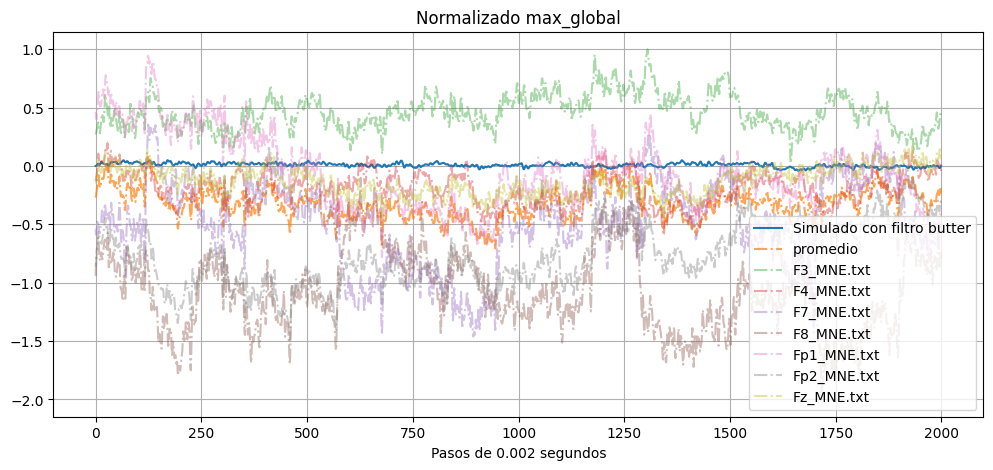

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array(reales_total["datos"])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(len(reales_total["datos"])):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.4)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


121
['F3_MNE.txt', 'F4_MNE.txt', 'F7_MNE.txt', 'F8_MNE.txt', 'Fp1_MNE.txt', 'Fp2_MNE.txt', 'Fz_MNE.txt']
Delta [np.float64(-44.18454830659419), np.float64(2.474524536528806)] ---- [-23.12386289   3.12491284]
Theta [np.float64(-50.33229673977979), np.float64(1.5190272314844635)] ---- [-29.67521377   1.79235884]
Alpha [np.float64(-53.22670809333773), np.float64(1.312453578759814)] ---- [-35.24054366   2.07036529]
Beta [np.float64(-58.600704375446696), np.float64(1.3442520830242062)] ---- [-40.46253791   1.96464269]


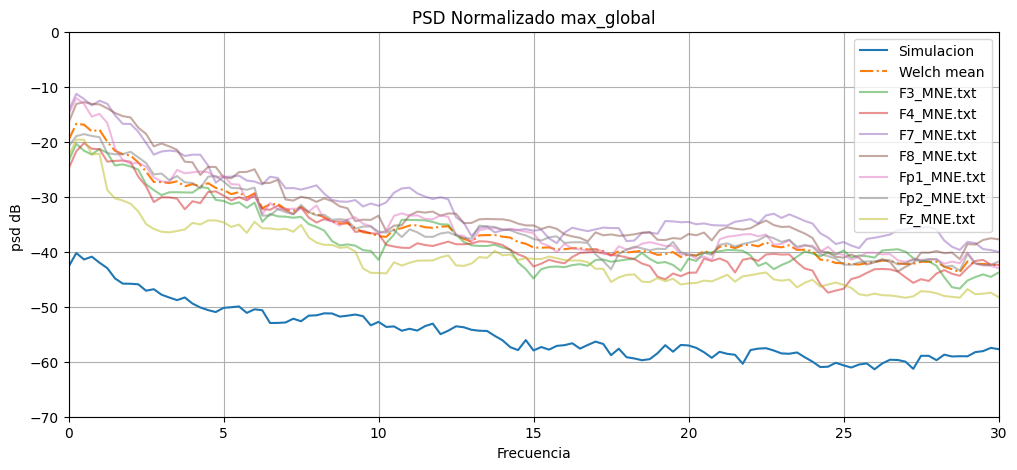

In [8]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 30))
print(count_in_range)
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(len(reales_total["datos"])):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [9]:
Tipo_de_red="SW"

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,20)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0,5.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L10"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-20 08:57:27,411] Using an existing study with name 'Chi30_SW_max_global_L10' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:28,615] Trial 840 finished with value: 113.52974577064928 and parameters: {'L': 15, 'P': 0.9057284316630788, 'Inh': 0.9676180756700362, 'Trest': 0.628345346913955, 'Trelative': 0.9404081814693658, 'C_h': 0.21541537183429318, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:29,597] Trial 841 finished with value: 50.18683311906193 and parameters: {'L': 15, 'P': 0.9824546816723022, 'Inh': 0.9316255521472642, 'Trest': 0.5790782739166533, 'Trelative': 0.8369786145721059, 'C_h': 0.22719191595136237, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:30,189] Trial 842 finished with value: 1570.2835569725573 and parameters: {'L': 15, 'P': 0.9425261900907234, 'Inh': 0.9802730651532812, 'Trest': 0.75455519452635, 'Trelative': 1.5629358960281088, 'C_h': 0.23751955540758343, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:30,801] Trial 843 finished with value: 49.5136905234791 and parameters: {'L': 15, 'P': 0.9250886212436821, 'Inh': 0.95484773352387, 'Trest': 0.648062493564228, 'Trelative': 0.9767567038724507, 'C_h': 0.3110419599045964, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:31,256] Trial 844 finished with value: 15826.585052753326 and parameters: {'L': 15, 'P': 0.9732108533693112, 'Inh': 0.9818338677509058, 'Trest': 0.5329131318922957, 'Trelative': 0.7558419272054054, 'C_h': 0.2122102446408053, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:31,745] Trial 845 finished with value: 60.625925456093086 and parameters: {'L': 15, 'P': 0.9025492740007622, 'Inh': 0.9630794326636198, 'Trest': 0.7791680993362028, 'Trelative': 1.1611054922073862, 'C_h': 0.2676566597724584, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:32,219] Trial 846 finished with value: 468.0091654823762 and parameters: {'L': 15, 'P': 0.9498505120115849, 'Inh': 0.9852676315873454, 'Trest': 0.6569894765728432, 'Trelative': 0.983796315595936, 'C_h': 0.24103648060727825, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:32,745] Trial 847 finished with value: 45.72532462628812 and parameters: {'L': 15, 'P': 0.963939520371205, 'Inh': 0.9353075494727471, 'Trest': 0.5405013109485665, 'Trelative': 0.7833998584017743, 'C_h': 0.29795752528296066, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:33,144] Trial 848 finished with value: 2659.397718330624 and parameters: {'L': 15, 'P': 0.9812297574990093, 'Inh': 0.953356286325431, 'Trest': 0.6861472885315122, 'Trelative': 1.7784005484176548, 'C_h': 0.20783321139464622, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:33,596] Trial 849 finished with value: 216.78422224697923 and parameters: {'L': 15, 'P': 0.9311665835793517, 'Inh': 0.983563659718645, 'Trest': 0.809884118558108, 'Trelative': 1.2452500147652985, 'C_h': 0.27703464168120717, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:33,963] Trial 850 finished with value: 16830.778722769694 and parameters: {'L': 15, 'P': 0.9501965952852923, 'Inh': 0.9985563907695252, 'Trest': 0.41860345044426905, 'Trelative': 0.49849007765654646, 'C_h': 0.253361097028162, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:34,373] Trial 851 finished with value: 246.01936565882013 and parameters: {'L': 15, 'P': 0.9999023262109331, 'Inh': 0.9600958117510382, 'Trest': 0.6135069350375922, 'Trelative': 1.596502797461382, 'C_h': 0.22434857228030783, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:34,849] Trial 852 finished with value: 179.496613070795 and parameters: {'L': 15, 'P': 0.9157964551520472, 'Inh': 0.9337102265091581, 'Trest': 0.7180484938548851, 'Trelative': 1.079138493188493, 'C_h': 0.3010887880468691, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:35,307] Trial 853 finished with value: 26.383065496305385 and parameters: {'L': 15, 'P': 0.9682576705515805, 'Inh': 0.9988521233286142, 'Trest': 0.7838385507538782, 'Trelative': 1.413597685713441, 'C_h': 0.26569509006629305, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:35,735] Trial 854 finished with value: 57.936643724705846 and parameters: {'L': 15, 'P': 0.9718471948011417, 'Inh': 0.9992783171232372, 'Trest': 0.9110068341732669, 'Trelative': 1.4471492318276187, 'C_h': 0.2370459994402339, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:36,161] Trial 855 finished with value: 99.77749015761995 and parameters: {'L': 15, 'P': 0.9477453237935693, 'Inh': 0.9653687956177889, 'Trest': 0.821796153602879, 'Trelative': 1.6061410123977713, 'C_h': 0.2578629097258575, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:36,574] Trial 856 finished with value: 122.07163709555779 and parameters: {'L': 15, 'P': 0.9819621338165504, 'Inh': 0.9737160723753149, 'Trest': 0.8089746006527964, 'Trelative': 1.3421407202880138, 'C_h': 0.20197616422918235, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:37,066] Trial 857 finished with value: 44.91218592650839 and parameters: {'L': 15, 'P': 0.961145209875755, 'Inh': 0.9446591925946105, 'Trest': 0.9185386364821502, 'Trelative': 1.3007543083210362, 'C_h': 0.2767005378800057, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:37,615] Trial 858 finished with value: 15659.927378910677 and parameters: {'L': 15, 'P': 0.9323028212061026, 'Inh': 0.9836058858138711, 'Trest': 0.7510274485765328, 'Trelative': 1.696780385223131, 'C_h': 0.22352678201987258, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:37,991] Trial 859 finished with value: 504.1902029244185 and parameters: {'L': 15, 'P': 0.9047245056502923, 'Inh': 0.9662822871166533, 'Trest': 0.56151923467755, 'Trelative': 0.8231802711420746, 'C_h': 0.24986319616406974, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:38,410] Trial 860 finished with value: 101.66434648917514 and parameters: {'L': 15, 'P': 0.9846509704357531, 'Inh': 0.929575864363958, 'Trest': 0.7036861154730812, 'Trelative': 1.0934426250730358, 'C_h': 0.28660016459838594, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:38,786] Trial 861 finished with value: 124.21217006939492 and parameters: {'L': 15, 'P': 0.9559460003539515, 'Inh': 0.999526969902882, 'Trest': 0.5954551172081646, 'Trelative': 0.8667322492110074, 'C_h': 0.31257708788397975, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:39,162] Trial 862 finished with value: 14752.572286372106 and parameters: {'L': 15, 'P': 0.9343187648293192, 'Inh': 0.9497772050878004, 'Trest': 0.44284331179353936, 'Trelative': 0.6417814679061462, 'C_h': 0.2669760277004406, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:39,666] Trial 863 finished with value: 45.17987238110925 and parameters: {'L': 15, 'P': 0.9989365611798038, 'Inh': 0.9687060165072054, 'Trest': 0.8145228042684951, 'Trelative': 1.195175864981584, 'C_h': 0.2364924173630765, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:40,168] Trial 864 finished with value: 106.0637101402508 and parameters: {'L': 15, 'P': 0.9690666805626345, 'Inh': 0.9827741563844582, 'Trest': 0.6431816553487983, 'Trelative': 1.4746318138476397, 'C_h': 0.20319384478965524, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:40,616] Trial 865 finished with value: 281.4282518984897 and parameters: {'L': 15, 'P': 0.9179094706839751, 'Inh': 0.9485527604135533, 'Trest': 0.9088600913606202, 'Trelative': 1.3067676276338365, 'C_h': 0.2872072033569601, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:41,055] Trial 866 finished with value: 57.23781208613343 and parameters: {'L': 15, 'P': 0.9370859599699202, 'Inh': 0.9702144269362886, 'Trest': 0.7651039556303438, 'Trelative': 1.1362864422421728, 'C_h': 0.2545027442467277, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:41,414] Trial 867 finished with value: 13467.838565140057 and parameters: {'L': 15, 'P': 0.9003183926998017, 'Inh': 0.9825218448102359, 'Trest': 0.5301775715719053, 'Trelative': 0.7242008046264329, 'C_h': 0.22712861286524344, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:41,844] Trial 868 finished with value: 97.17246434357114 and parameters: {'L': 15, 'P': 0.9597915896855077, 'Inh': 0.9326443032613838, 'Trest': 0.6583371141369448, 'Trelative': 1.0269137518829923, 'C_h': 0.3198515902984987, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:42,271] Trial 869 finished with value: 5724.098526208608 and parameters: {'L': 15, 'P': 0.9723015190867492, 'Inh': 0.9989306823562846, 'Trest': 0.8564027125027138, 'Trelative': 1.4609531393523503, 'C_h': 0.2712738256676399, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:42,687] Trial 870 finished with value: 7709.5553409886925 and parameters: {'L': 15, 'P': 0.9458235384148388, 'Inh': 0.9539480953805578, 'Trest': 0.7111626567059657, 'Trelative': 1.7995142555868577, 'C_h': 0.2461271070537228, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:43,066] Trial 871 finished with value: 4341.572576450885 and parameters: {'L': 15, 'P': 0.9204496519548042, 'Inh': 0.9675645749113639, 'Trest': 0.45889733296629104, 'Trelative': 0.6319082489643174, 'C_h': 0.3036906543783076, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:43,590] Trial 872 finished with value: 6199.41675043748 and parameters: {'L': 15, 'P': 0.9998549011229558, 'Inh': 0.9273763918022356, 'Trest': 0.596604925464307, 'Trelative': 1.9046794993284817, 'C_h': 0.22069169254433818, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:44,055] Trial 873 finished with value: 54.62849645321829 and parameters: {'L': 15, 'P': 0.9735961590244739, 'Inh': 0.9816445353281393, 'Trest': 0.7503433839714002, 'Trelative': 1.0553098697766905, 'C_h': 0.2662947584685268, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:44,458] Trial 874 finished with value: 36.29421134556528 and parameters: {'L': 15, 'P': 0.9492620345221813, 'Inh': 0.9472480786441348, 'Trest': 0.5390165658201445, 'Trelative': 0.7798837588026313, 'C_h': 0.2887447574288883, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:45,075] Trial 875 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.95661261765451, 'Inh': 0.9599720002302391, 'Trest': 1.7593565573142937, 'Trelative': 1.9897277993554914, 'C_h': 0.2983422844624169, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:45,453] Trial 876 finished with value: 67.37032092602115 and parameters: {'L': 15, 'P': 0.9823438770689661, 'Inh': 0.9780796950724581, 'Trest': 0.43877955119516415, 'Trelative': 0.6773931520795283, 'C_h': 0.32377626066844956, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:45,851] Trial 877 finished with value: 17367.425729762213 and parameters: {'L': 15, 'P': 0.9471772289235911, 'Inh': 0.9996574859871729, 'Trest': 0.5046370025206587, 'Trelative': 0.6930866085809163, 'C_h': 0.29102537337194323, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:46,282] Trial 878 finished with value: 3460.5481037063582 and parameters: {'L': 15, 'P': 0.984767553222102, 'Inh': 0.9495524052656739, 'Trest': 0.3472464320192715, 'Trelative': 0.5005125598775245, 'C_h': 0.3131186357891048, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:46,696] Trial 879 finished with value: 81.20356157214934 and parameters: {'L': 15, 'P': 0.8999436376862796, 'Inh': 0.9654685411294485, 'Trest': 0.9771160949136, 'Trelative': 1.3569060174527094, 'C_h': 0.28073493897958135, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:47,135] Trial 880 finished with value: 30.273930008089934 and parameters: {'L': 15, 'P': 0.9649049791823461, 'Inh': 0.9827556082609792, 'Trest': 0.6906759407163103, 'Trelative': 1.0675104371863093, 'C_h': 0.291533739951802, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:47,589] Trial 881 finished with value: 375.09948514900594 and parameters: {'L': 15, 'P': 0.9615306277049778, 'Inh': 0.9839938610757295, 'Trest': 0.5475774486658216, 'Trelative': 0.7980667360061611, 'C_h': 0.29867196490900394, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:48,232] Trial 882 finished with value: 39.05487492904785 and parameters: {'L': 16, 'P': 0.9823087335410641, 'Inh': 0.9826637206650188, 'Trest': 0.6640364021217979, 'Trelative': 0.9466844132924632, 'C_h': 0.3259918369562417, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:48,751] Trial 883 finished with value: 17367.425729762213 and parameters: {'L': 15, 'P': 0.9456609104033871, 'Inh': 0.9999634326475849, 'Trest': 0.5136542104453687, 'Trelative': 0.7167346511582117, 'C_h': 0.26421081391458795, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:49,126] Trial 884 finished with value: 3517.266823561051 and parameters: {'L': 15, 'P': 0.9661706809544005, 'Inh': 0.9996105941435081, 'Trest': 0.40730934334228275, 'Trelative': 0.49959393359009696, 'C_h': 0.2896841601823607, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:49,534] Trial 885 finished with value: 61.8332191796096 and parameters: {'L': 15, 'P': 0.9321451744749476, 'Inh': 0.9680442047685704, 'Trest': 0.64284498223524, 'Trelative': 0.9736857024586005, 'C_h': 0.3084630587627558, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:49,906] Trial 886 finished with value: 56.636200307860086 and parameters: {'L': 15, 'P': 0.9823870561390311, 'Inh': 0.9998919765383641, 'Trest': 0.5516370414632608, 'Trelative': 0.8451371319973282, 'C_h': 0.26857928058195407, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:50,319] Trial 887 finished with value: 173.72732684921152 and parameters: {'L': 15, 'P': 0.9509372234638215, 'Inh': 0.9759867270492472, 'Trest': 0.7261305698668551, 'Trelative': 1.0808947925866628, 'C_h': 0.27955987376110325, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:50,683] Trial 888 finished with value: 107.6647548285671 and parameters: {'L': 15, 'P': 0.9992786195182711, 'Inh': 0.9552842447063556, 'Trest': 0.5950316138465607, 'Trelative': 0.9758738744593327, 'C_h': 0.2510827565394053, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:51,205] Trial 889 finished with value: 45.03137387347361 and parameters: {'L': 15, 'P': 0.9639723970743282, 'Inh': 0.978251118327818, 'Trest': 0.7712820945690941, 'Trelative': 1.2110968431513072, 'C_h': 0.20248516927461907, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:51,845] Trial 890 finished with value: 13181.919683595632 and parameters: {'L': 15, 'P': 0.9191770524974714, 'Inh': 0.9443217776328405, 'Trest': 0.47550693890802614, 'Trelative': 0.6688321010713181, 'C_h': 0.3045734542761168, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:52,415] Trial 891 finished with value: 252.94111461081823 and parameters: {'L': 15, 'P': 0.9398094237635429, 'Inh': 0.983328827747759, 'Trest': 0.6745438790319968, 'Trelative': 1.6322991591436904, 'C_h': 0.33069854080328137, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:52,991] Trial 892 finished with value: 8104.54743348416 and parameters: {'L': 16, 'P': 0.9647272731033372, 'Inh': 0.9648072030497268, 'Trest': 0.38318575592664234, 'Trelative': 0.42885630945685116, 'C_h': 0.26365014116836266, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:53,540] Trial 893 finished with value: 46.688659579347366 and parameters: {'L': 15, 'P': 0.9202128811692466, 'Inh': 0.9474458823370863, 'Trest': 0.8051337770394014, 'Trelative': 1.2123479047802648, 'C_h': 0.2398142683811468, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:54,089] Trial 894 finished with value: 81.43928072628849 and parameters: {'L': 15, 'P': 0.9783429973348458, 'Inh': 0.9239604519614397, 'Trest': 0.6629539780430249, 'Trelative': 0.9611509022504975, 'C_h': 0.28000342989133775, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:54,609] Trial 895 finished with value: 336.45169758008666 and parameters: {'L': 15, 'P': 0.9479203777438205, 'Inh': 0.981391370364604, 'Trest': 0.5525703492595035, 'Trelative': 0.8250441735247188, 'C_h': 0.2232081724458719, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:55,182] Trial 896 finished with value: 86.184497708928 and parameters: {'L': 15, 'P': 0.9786742324917223, 'Inh': 0.9637770132170843, 'Trest': 0.7371527925903734, 'Trelative': 1.4830691527027686, 'C_h': 0.2901988183665974, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:55,802] Trial 897 finished with value: 45.31024046053428 and parameters: {'L': 15, 'P': 0.9275121811898865, 'Inh': 0.9824623804591543, 'Trest': 0.5996632904910185, 'Trelative': 0.9332302897255975, 'C_h': 0.2577862947351801, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:56,308] Trial 898 finished with value: 100.07450035625874 and parameters: {'L': 15, 'P': 0.958513210332062, 'Inh': 0.998721838696005, 'Trest': 0.45069526175407837, 'Trelative': 0.7593566450887099, 'C_h': 0.3160788020524225, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:56,888] Trial 899 finished with value: 91.33411982103111 and parameters: {'L': 16, 'P': 0.9023029361647394, 'Inh': 0.930893665330028, 'Trest': 0.8393865735008105, 'Trelative': 1.1839494664606924, 'C_h': 0.24950253568489114, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:57,363] Trial 900 finished with value: 67.82304518670169 and parameters: {'L': 15, 'P': 0.9397657349664779, 'Inh': 0.948428696195885, 'Trest': 0.6777177715386258, 'Trelative': 1.3734136196366398, 'C_h': 0.20596896638966355, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:57,837] Trial 901 finished with value: 20.980106526007965 and parameters: {'L': 15, 'P': 0.9849999550337629, 'Inh': 0.9661882971704024, 'Trest': 0.5542243615430433, 'Trelative': 0.8377768606639232, 'C_h': 0.2753120143671224, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:58,323] Trial 902 finished with value: 3947.200452784579 and parameters: {'L': 15, 'P': 0.9456575785460523, 'Inh': 0.9279180428032631, 'Trest': 0.3609802679010827, 'Trelative': 0.5430143404382679, 'C_h': 0.3008397094024063, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:57:58,898] Trial 903 finished with value: 5730.133552385634 and parameters: {'L': 16, 'P': 0.9186972241129583, 'Inh': 0.9541297069544, 'Trest': 0.29193449706920793, 'Trelative': 0.5626089052172679, 'C_h': 0.2823431923091613, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:57:59,574] Trial 904 finished with value: 410.9995391889218 and parameters: {'L': 15, 'P': 0.9684153937238149, 'Inh': 0.9663993670084096, 'Trest': 0.49597053157572385, 'Trelative': 0.7565891853318426, 'C_h': 0.27337161653527603, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:00,221] Trial 905 finished with value: 155.66614044774462 and parameters: {'L': 15, 'P': 0.963998628921954, 'Inh': 0.9465091628186306, 'Trest': 0.543156839248768, 'Trelative': 0.8446943832433873, 'C_h': 0.3367902232552318, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:00,646] Trial 906 finished with value: 19792.287096585787 and parameters: {'L': 15, 'P': 0.9321867311201284, 'Inh': 0.9249624418644882, 'Trest': 0.41914914358441957, 'Trelative': 0.5901348217116033, 'C_h': 0.30290784095324674, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:01,181] Trial 907 finished with value: 82.39763080404703 and parameters: {'L': 15, 'P': 0.9820646262898276, 'Inh': 0.9654534361608922, 'Trest': 0.5653181559602938, 'Trelative': 1.070177496337621, 'C_h': 0.2857872184444466, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:01,679] Trial 908 finished with value: 112.90187752890355 and parameters: {'L': 15, 'P': 0.9013144142610883, 'Inh': 0.9805952476190848, 'Trest': 0.7777001559170591, 'Trelative': 1.2312133936065688, 'C_h': 0.31729536818686416, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:02,201] Trial 909 finished with value: 11618.634790192507 and parameters: {'L': 15, 'P': 0.9528676694183869, 'Inh': 0.9429497693065991, 'Trest': 0.6375753188315811, 'Trelative': 1.5540045233111561, 'C_h': 0.2682015723004769, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:02,634] Trial 910 finished with value: 16928.447583333338 and parameters: {'L': 15, 'P': 0.9302413114642367, 'Inh': 0.9828199937056564, 'Trest': 0.48425439540717446, 'Trelative': 0.660765139739002, 'C_h': 0.2597432640345393, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:03,124] Trial 911 finished with value: 147.89825938089538 and parameters: {'L': 15, 'P': 0.9828247962181822, 'Inh': 0.9650717337177297, 'Trest': 0.9113704411085939, 'Trelative': 1.2914739491219756, 'C_h': 0.2872627231374089, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:03,645] Trial 912 finished with value: 66.23358158556461 and parameters: {'L': 15, 'P': 0.957168934120563, 'Inh': 0.9995902560878716, 'Trest': 0.7276320398291481, 'Trelative': 1.0580288151361645, 'C_h': 0.30296095383138016, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:04,125] Trial 913 finished with value: 15163.921318788807 and parameters: {'L': 15, 'P': 0.9161937729273855, 'Inh': 0.950302822214488, 'Trest': 0.31837895000981953, 'Trelative': 0.45105369220095015, 'C_h': 0.24847674170960862, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:04,868] Trial 914 finished with value: 77.02632918974997 and parameters: {'L': 15, 'P': 0.9993971653629785, 'Inh': 0.9232144310582845, 'Trest': 0.578482321876917, 'Trelative': 0.9115778217121149, 'C_h': 0.27146578031440205, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:05,460] Trial 915 finished with value: 99.80673899893087 and parameters: {'L': 16, 'P': 0.9426444435134332, 'Inh': 0.9681384893329205, 'Trest': 0.8253060728341485, 'Trelative': 1.180469596616041, 'C_h': 0.28657866076639477, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:06,097] Trial 916 finished with value: 117.2526611596068 and parameters: {'L': 15, 'P': 0.9686602410746079, 'Inh': 0.9990040365762828, 'Trest': 0.6974675531839727, 'Trelative': 1.0381853496117488, 'C_h': 0.3287442307478981, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:06,579] Trial 917 finished with value: 14075.489573341718 and parameters: {'L': 15, 'P': 0.9491519346236224, 'Inh': 0.9995384449569066, 'Trest': 0.4632874833389453, 'Trelative': 0.6796879559416309, 'C_h': 0.2414998686254339, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:07,168] Trial 918 finished with value: 94.4438742312234 and parameters: {'L': 15, 'P': 0.8984869976002638, 'Inh': 0.9386551662921894, 'Trest': 0.5893481806390927, 'Trelative': 1.4162661733814663, 'C_h': 0.26417681567821427, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:07,734] Trial 919 finished with value: 43.79759616838579 and parameters: {'L': 15, 'P': 0.9832149301305532, 'Inh': 0.968533063927528, 'Trest': 0.7649213589051072, 'Trelative': 1.1543129212112047, 'C_h': 0.3060432314256585, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:08,395] Trial 920 finished with value: 176.6032056385198 and parameters: {'L': 15, 'P': 0.926181059747238, 'Inh': 0.9815324651797847, 'Trest': 0.851693468583742, 'Trelative': 1.3258022726673222, 'C_h': 0.27318145454832676, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:08,976] Trial 921 finished with value: 409.0512692026356 and parameters: {'L': 15, 'P': 0.9629546997385092, 'Inh': 0.9529094618697708, 'Trest': 0.6595371914343316, 'Trelative': 0.9694400506574689, 'C_h': 0.23990736135162072, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:09,607] Trial 922 finished with value: 16189.61935736089 and parameters: {'L': 15, 'P': 0.9145736556590326, 'Inh': 0.9684287973713188, 'Trest': 0.3932668908038986, 'Trelative': 0.5807651415094642, 'C_h': 0.2946346056117734, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:10,299] Trial 923 finished with value: 240.74740127779975 and parameters: {'L': 16, 'P': 0.9460084743197177, 'Inh': 0.9204156267744976, 'Trest': 0.9643349354543757, 'Trelative': 1.3440397586334685, 'C_h': 0.2555092354269497, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:10,801] Trial 924 finished with value: 783.0932560519873 and parameters: {'L': 15, 'P': 0.9793038118387166, 'Inh': 0.9996325140280627, 'Trest': 0.529355318176748, 'Trelative': 0.8305145779222459, 'C_h': 0.2743437561951839, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:11,427] Trial 925 finished with value: 121.49679924133403 and parameters: {'L': 15, 'P': 0.9652434215399173, 'Inh': 0.9480948026816306, 'Trest': 0.727704628406786, 'Trelative': 1.0710741821710397, 'C_h': 0.32397876720442287, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:11,918] Trial 926 finished with value: 91.50024391330167 and parameters: {'L': 15, 'P': 0.9997167631560012, 'Inh': 0.9817529511754503, 'Trest': 0.6037696737774285, 'Trelative': 1.5669848503171104, 'C_h': 0.2336035365238217, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:12,461] Trial 927 finished with value: 119.00725732592467 and parameters: {'L': 15, 'P': 0.9359506265795919, 'Inh': 0.9637823035699289, 'Trest': 0.8445784547776813, 'Trelative': 1.1982644667706006, 'C_h': 0.2622337044327313, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:12,995] Trial 928 finished with value: 71.89955998458197 and parameters: {'L': 16, 'P': 0.8950873645592946, 'Inh': 0.9372625066385765, 'Trest': 0.6958377978863878, 'Trelative': 1.0197961166432004, 'C_h': 0.29648892254105885, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:13,467] Trial 929 finished with value: 14532.65432333525 and parameters: {'L': 15, 'P': 0.9192198935740645, 'Inh': 0.9810803661011543, 'Trest': 0.5085540665217547, 'Trelative': 0.722691152055098, 'C_h': 0.24748402653438945, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:14,102] Trial 930 finished with value: 4606.547007278137 and parameters: {'L': 15, 'P': 0.9637617555087468, 'Inh': 0.959705271797357, 'Trest': 0.6231736144685417, 'Trelative': 1.7301273202933953, 'C_h': 0.28015303787050255, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:14,625] Trial 931 finished with value: 57.49171498855472 and parameters: {'L': 15, 'P': 0.9434583520493951, 'Inh': 0.9827593224705304, 'Trest': 0.7493246051410363, 'Trelative': 1.1213330054703805, 'C_h': 0.31827942151805005, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:15,102] Trial 932 finished with value: 59.2055453412126 and parameters: {'L': 14, 'P': 0.9738021587936498, 'Inh': 0.9254496213446711, 'Trest': 0.9077820783591111, 'Trelative': 1.3713718312869851, 'C_h': 0.23129269807936814, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:15,535] Trial 933 finished with value: 4996.206117561999 and parameters: {'L': 15, 'P': 0.9513559087672627, 'Inh': 0.9466896969881823, 'Trest': 0.42836075491963277, 'Trelative': 0.7146917161338386, 'C_h': 0.2559932536091001, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:15,949] Trial 934 finished with value: 764.2718224177896 and parameters: {'L': 14, 'P': 0.9802238451371447, 'Inh': 0.9817971690057118, 'Trest': 0.6329768346253908, 'Trelative': 0.9255291364954772, 'C_h': 0.21901626366652918, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:16,471] Trial 935 finished with value: 32.44002000213102 and parameters: {'L': 15, 'P': 0.9115689014816187, 'Inh': 0.959846931299064, 'Trest': 0.7806923797486316, 'Trelative': 1.1527873060471177, 'C_h': 0.18894962610119115, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:16,980] Trial 936 finished with value: 76.96890147363987 and parameters: {'L': 15, 'P': 0.9048684113973748, 'Inh': 0.9129070537910401, 'Trest': 0.5497168781364163, 'Trelative': 0.8399060666728383, 'C_h': 0.1699402065703164, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:17,549] Trial 937 finished with value: 138.3440850424727 and parameters: {'L': 14, 'P': 0.8975061353809696, 'Inh': 0.9357836957552628, 'Trest': 0.7268741230515359, 'Trelative': 1.477822735445549, 'C_h': 0.18722965423794988, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:18,015] Trial 938 finished with value: 9698.467433802207 and parameters: {'L': 16, 'P': 0.8938388676797617, 'Inh': 0.9545790472019725, 'Trest': 0.3377272447620576, 'Trelative': 0.5005734137127951, 'C_h': 0.1646373961780282, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:18,534] Trial 939 finished with value: 15925.89572035677 and parameters: {'L': 15, 'P': 0.9158306312141726, 'Inh': 0.9278287031771926, 'Trest': 0.4929100221770083, 'Trelative': 0.7657947035539378, 'C_h': 0.18412010603737727, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:19,238] Trial 940 finished with value: 30.083954390081047 and parameters: {'L': 15, 'P': 0.926398246551549, 'Inh': 0.9617599995567134, 'Trest': 0.6603106173691833, 'Trelative': 0.9676257745601337, 'C_h': 0.20973453348195883, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:19,714] Trial 941 finished with value: 581.1475472876514 and parameters: {'L': 14, 'P': 0.894500669485397, 'Inh': 0.9998887211941935, 'Trest': 0.5550747068418804, 'Trelative': 0.8496279938343264, 'C_h': 0.19245962078105416, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:20,182] Trial 942 finished with value: 45.42230475864627 and parameters: {'L': 15, 'P': 0.9195508313800449, 'Inh': 0.9461418085371539, 'Trest': 0.6386939459017211, 'Trelative': 0.9564178561281682, 'C_h': 0.20903787811103997, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:20,630] Trial 943 finished with value: 4883.278469926135 and parameters: {'L': 14, 'P': 0.9324764170805218, 'Inh': 0.917474963087856, 'Trest': 0.42155999012518064, 'Trelative': 0.6578992429709271, 'C_h': 0.19497653351411012, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:21,133] Trial 944 finished with value: 174.20918561492505 and parameters: {'L': 15, 'P': 0.8897088030582253, 'Inh': 0.9624779025427597, 'Trest': 0.5181121035663243, 'Trelative': 0.8188389629407473, 'C_h': 0.21789106755895732, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:21,668] Trial 945 finished with value: 12497.828133274326 and parameters: {'L': 15, 'P': 0.9111931949380713, 'Inh': 0.9437622256717273, 'Trest': 0.2854300926836087, 'Trelative': 0.5530133085052398, 'C_h': 0.15925621604431167, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:22,153] Trial 946 finished with value: 35.25666425873951 and parameters: {'L': 14, 'P': 0.9305251389071069, 'Inh': 0.9643916994868745, 'Trest': 0.6436486728506409, 'Trelative': 0.9772399031007999, 'C_h': 0.2284314717311359, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:22,687] Trial 947 finished with value: 122.80393722201487 and parameters: {'L': 15, 'P': 0.9268990632326268, 'Inh': 0.9169910213108051, 'Trest': 0.6081765952797774, 'Trelative': 0.9399122375388219, 'C_h': 0.17937224628112913, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:23,092] Trial 948 finished with value: 2022.895929723623 and parameters: {'L': 14, 'P': 0.9343971604015993, 'Inh': 0.9349071810345929, 'Trest': 0.4285266616675294, 'Trelative': 0.5918194715597602, 'C_h': 0.20638789522747833, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:23,575] Trial 949 finished with value: 44.82406094361083 and parameters: {'L': 16, 'P': 0.9400524566475082, 'Inh': 0.9599953737015012, 'Trest': 0.5311698987613229, 'Trelative': 0.7961578090875916, 'C_h': 0.23056679095356014, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:24,061] Trial 950 finished with value: 425.5423627478946 and parameters: {'L': 15, 'P': 0.936567111701037, 'Inh': 0.9357212914523891, 'Trest': 0.6585510069138099, 'Trelative': 1.0552759691370144, 'C_h': 0.1956746923304222, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:24,668] Trial 951 finished with value: 2371.153837589965 and parameters: {'L': 15, 'P': 0.9175343041718296, 'Inh': 0.9597766804812596, 'Trest': 0.4582994993984159, 'Trelative': 0.6171321514549637, 'C_h': 0.2179370350213374, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:25,291] Trial 952 finished with value: 1396.2260164210954 and parameters: {'L': 15, 'P': 0.9548937778326111, 'Inh': 0.9691810373855768, 'Trest': 0.6198784740697871, 'Trelative': 0.9373341104756662, 'C_h': 0.23000029534249755, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:25,860] Trial 953 finished with value: 234.82194567855058 and parameters: {'L': 15, 'P': 0.9371898322536533, 'Inh': 0.9161688171274845, 'Trest': 0.7076715021107878, 'Trelative': 1.2315585922492276, 'C_h': 0.1911232493504767, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:26,278] Trial 954 finished with value: 1333.7066441538136 and parameters: {'L': 14, 'P': 0.9995833894487648, 'Inh': 0.9510329293652089, 'Trest': 0.5207815121346959, 'Trelative': 0.8260509543822406, 'C_h': 0.16956252000848154, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:26,776] Trial 955 finished with value: 35.96057159182375 and parameters: {'L': 15, 'P': 0.6408393778611708, 'Inh': 0.9999613537739321, 'Trest': 0.804692560244737, 'Trelative': 1.231764496631929, 'C_h': 0.21651432259803877, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:27,262] Trial 956 finished with value: 63.10015992201859 and parameters: {'L': 15, 'P': 0.6976558541076384, 'Inh': 0.9990187374066865, 'Trest': 0.8965993739428377, 'Trelative': 1.3672891376254395, 'C_h': 0.20941466026339667, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:27,731] Trial 957 finished with value: 69.24530454188199 and parameters: {'L': 14, 'P': 0.5825799039430728, 'Inh': 0.9809963264287016, 'Trest': 0.8185542528807683, 'Trelative': 1.5291037903623015, 'C_h': 0.19205324324222656, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:28,306] Trial 958 finished with value: 49375.851212081085 and parameters: {'L': 16, 'P': 0.893543060623393, 'Inh': 0.9841375088892801, 'Trest': 1.0134874460483418, 'Trelative': 1.3695624699011495, 'C_h': 0.21760445994858668, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:28,814] Trial 959 finished with value: 69.23035198066465 and parameters: {'L': 15, 'P': 0.9827499558872832, 'Inh': 0.9831389198833299, 'Trest': 0.8065032780391485, 'Trelative': 1.234430468904069, 'C_h': 0.1675828949555458, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:29,386] Trial 960 finished with value: 164.65919226642262 and parameters: {'L': 14, 'P': 0.6569282989719681, 'Inh': 0.9838549254644505, 'Trest': 0.7693050275633676, 'Trelative': 1.6031792860738934, 'C_h': 0.22919856655918538, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:29,929] Trial 961 finished with value: 37.6545775889654 and parameters: {'L': 14, 'P': 0.5938676830005016, 'Inh': 0.9693197174273254, 'Trest': 0.8830643437131016, 'Trelative': 1.256405897795504, 'C_h': 0.18104316694774433, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:30,542] Trial 962 finished with value: 81.64707721446746 and parameters: {'L': 15, 'P': 0.6593051964624944, 'Inh': 0.9986504061976145, 'Trest': 0.9693334903551942, 'Trelative': 1.4231594794229032, 'C_h': 0.2113528887128095, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:31,022] Trial 963 finished with value: 146.7908967422608 and parameters: {'L': 15, 'P': 0.5625171820820607, 'Inh': 0.9992798720220389, 'Trest': 0.733397083168704, 'Trelative': 1.7413176851304517, 'C_h': 0.23697647892486862, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:31,483] Trial 964 finished with value: 111.70304377896815 and parameters: {'L': 15, 'P': 0.9136801237459864, 'Inh': 0.9701242896726705, 'Trest': 0.7091764730624097, 'Trelative': 1.075431625597502, 'C_h': 0.20624998899375804, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:31,960] Trial 965 finished with value: 115.30782906317248 and parameters: {'L': 14, 'P': 0.886798405081469, 'Inh': 0.9993200628602384, 'Trest': 0.8497613758732543, 'Trelative': 1.2011177849275432, 'C_h': 0.14813825458431426, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:32,513] Trial 966 finished with value: 431.8284080866849 and parameters: {'L': 15, 'P': 0.6422069404196594, 'Inh': 0.9997872724442293, 'Trest': 0.6601030489169332, 'Trelative': 1.0320440537382722, 'C_h': 0.2354773944406422, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:33,065] Trial 967 finished with value: 112.57457659776068 and parameters: {'L': 15, 'P': 0.9593462772944904, 'Inh': 0.9661036478564452, 'Trest': 0.812337032696601, 'Trelative': 1.239396779683765, 'C_h': 0.195867560108485, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:33,562] Trial 968 finished with value: 91.73670196683496 and parameters: {'L': 14, 'P': 0.6808794577014459, 'Inh': 0.9712769470309326, 'Trest': 0.7595006444041101, 'Trelative': 1.5026106293960635, 'C_h': 0.2453269898872875, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:34,116] Trial 969 finished with value: 104.71749743223776 and parameters: {'L': 15, 'P': 0.6269219721135157, 'Inh': 0.9779947267507829, 'Trest': 0.656213211609134, 'Trelative': 1.0140576996445634, 'C_h': 0.22321943272958913, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:34,603] Trial 970 finished with value: 171.87986902232817 and parameters: {'L': 14, 'P': 0.9290630807319913, 'Inh': 0.9552333262155464, 'Trest': 0.9777233462870247, 'Trelative': 1.4157272174624587, 'C_h': 0.24342645943581273, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:35,104] Trial 971 finished with value: 6706.8620776309945 and parameters: {'L': 16, 'P': 0.9787730544000457, 'Inh': 0.9798940190683483, 'Trest': 0.613918554036287, 'Trelative': 1.6494823517415877, 'C_h': 0.21475266030868115, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:35,612] Trial 972 finished with value: 134.74696751246972 and parameters: {'L': 15, 'P': 0.7429578489319246, 'Inh': 0.9995744317737434, 'Trest': 0.8893380523048012, 'Trelative': 1.2582479819277972, 'C_h': 0.18474910035522385, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:36,140] Trial 973 finished with value: 78.74366177203531 and parameters: {'L': 14, 'P': 0.9520097515531771, 'Inh': 0.9554306484851015, 'Trest': 0.7385998493346007, 'Trelative': 1.0945745643780098, 'C_h': 0.2539588124468709, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:36,639] Trial 974 finished with value: 43.35166867638756 and parameters: {'L': 15, 'P': 0.9222999503094517, 'Inh': 0.9701636761281098, 'Trest': 0.6129854894877453, 'Trelative': 0.9312853897834975, 'C_h': 0.22752321907356898, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:37,111] Trial 975 finished with value: 75.73221884055091 and parameters: {'L': 15, 'P': 0.9841750334670015, 'Inh': 0.9361525697196516, 'Trest': 0.7732407141583266, 'Trelative': 1.1412819385213315, 'C_h': 0.2027217554645558, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:37,557] Trial 976 finished with value: 49375.851212081085 and parameters: {'L': 14, 'P': 0.9003697287849439, 'Inh': 0.9815327909178317, 'Trest': 2.3891124094253158, 'Trelative': 2.5155077176581173, 'C_h': 0.2450686859212179, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:37,986] Trial 977 finished with value: 24.11444076349798 and parameters: {'L': 15, 'P': 0.999868372022742, 'Inh': 0.9579744599881159, 'Trest': 0.6921058696408903, 'Trelative': 1.031123864070803, 'C_h': 0.2649351741113896, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:38,445] Trial 978 finished with value: 54.01699012581481 and parameters: {'L': 15, 'P': 0.9912900605728715, 'Inh': 0.9377666385264025, 'Trest': 0.588643113401381, 'Trelative': 1.051714841156322, 'C_h': 0.22010082151297486, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:38,920] Trial 979 finished with value: 98.534819622776 and parameters: {'L': 15, 'P': 0.7194633864932506, 'Inh': 0.9146947709790638, 'Trest': 0.6734322541706689, 'Trelative': 0.9970539634643809, 'C_h': 0.25270325352626133, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:39,478] Trial 980 finished with value: 141.6587414376201 and parameters: {'L': 16, 'P': 0.9981983787687536, 'Inh': 0.9531125058553463, 'Trest': 0.8748597904877734, 'Trelative': 1.272258114660947, 'C_h': 0.17102268334787496, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:39,962] Trial 981 finished with value: 50.805726110027464 and parameters: {'L': 15, 'P': 0.9665310170647304, 'Inh': 0.933111862440991, 'Trest': 0.5460070370258504, 'Trelative': 0.8264113467229509, 'C_h': 0.23647155498491487, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:40,372] Trial 982 finished with value: 26.610515327907624 and parameters: {'L': 15, 'P': 0.9479900618858156, 'Inh': 0.9589873956464562, 'Trest': 0.6657453684548605, 'Trelative': 0.985652660527331, 'C_h': 0.2620650852203152, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:40,843] Trial 983 finished with value: 2209.4389217704984 and parameters: {'L': 15, 'P': 0.9445888127347863, 'Inh': 0.9079156707678923, 'Trest': 0.45651506116620444, 'Trelative': 0.6868085209717105, 'C_h': 0.26391038278636136, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:41,384] Trial 984 finished with value: 12409.11864497105 and parameters: {'L': 15, 'P': 0.9651342757546921, 'Inh': 0.9312791309708013, 'Trest': 0.394231479738001, 'Trelative': 0.5203463835977737, 'C_h': 0.2653330037554629, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:41,832] Trial 985 finished with value: 88.45339603838039 and parameters: {'L': 15, 'P': 0.9358984616491693, 'Inh': 0.9419122466431022, 'Trest': 0.5957158624674586, 'Trelative': 0.8870320498166689, 'C_h': 0.27449218472498277, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:42,285] Trial 986 finished with value: 85.85053454420364 and parameters: {'L': 15, 'P': 0.912855972010811, 'Inh': 0.9524685299317783, 'Trest': 0.6630134738167677, 'Trelative': 0.9759522221115539, 'C_h': 0.2531592273614879, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:42,753] Trial 987 finished with value: 66.53457072110685 and parameters: {'L': 15, 'P': 0.9975279183243889, 'Inh': 0.917428200277879, 'Trest': 0.4978583616231051, 'Trelative': 0.7580252666991255, 'C_h': 0.29187892174614116, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:43,214] Trial 988 finished with value: 46.30587089480926 and parameters: {'L': 15, 'P': 0.9785041111950165, 'Inh': 0.950807017649503, 'Trest': 0.5754923284663745, 'Trelative': 0.9407537910745492, 'C_h': 0.2618213172668211, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:43,702] Trial 989 finished with value: 16424.363166409563 and parameters: {'L': 15, 'P': 0.9519371214539873, 'Inh': 0.9290787675630509, 'Trest': 0.3438572855069579, 'Trelative': 0.5462393545670555, 'C_h': 0.2430039871538375, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:44,199] Trial 990 finished with value: 21227.9020822757 and parameters: {'L': 15, 'P': 0.08313106856505947, 'Inh': 0.9585214314720018, 'Trest': 0.6667593073640137, 'Trelative': 1.0174711692401026, 'C_h': 0.27176668710687885, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:44,663] Trial 991 finished with value: 60.0462461151491 and parameters: {'L': 15, 'P': 0.9262349893898003, 'Inh': 0.9632550543315792, 'Trest': 0.7116352940479785, 'Trelative': 1.0721642657114905, 'C_h': 0.30458232786690637, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:45,087] Trial 992 finished with value: 9326.658944808218 and parameters: {'L': 16, 'P': 0.9661810702531659, 'Inh': 0.9377984868509109, 'Trest': 0.49000189225451196, 'Trelative': 0.746501048069177, 'C_h': 0.2459940829436804, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:45,587] Trial 993 finished with value: 77.59427778386444 and parameters: {'L': 15, 'P': 0.9993752919382224, 'Inh': 0.9617363901650217, 'Trest': 0.6033113606370621, 'Trelative': 0.8923347606090573, 'C_h': 0.2842194431162243, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:46,094] Trial 994 finished with value: 114.39263544920041 and parameters: {'L': 15, 'P': 0.8870229451114251, 'Inh': 0.9087777234055083, 'Trest': 0.7428068085215324, 'Trelative': 1.106349484077247, 'C_h': 0.26300208979771966, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:46,586] Trial 995 finished with value: 35.35567911544081 and parameters: {'L': 15, 'P': 0.9485831630019608, 'Inh': 0.9459615405635895, 'Trest': 0.5459585501967502, 'Trelative': 0.7709654135805566, 'C_h': 0.2361597895968829, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:47,119] Trial 996 finished with value: 106.45622076206578 and parameters: {'L': 16, 'P': 0.907063995600523, 'Inh': 0.9662844496617867, 'Trest': 0.6536830322179142, 'Trelative': 0.9470143206899944, 'C_h': 0.2937645473226733, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:47,542] Trial 997 finished with value: 22755.300743142103 and parameters: {'L': 15, 'P': 0.9306790454864845, 'Inh': 0.9324481487282379, 'Trest': 0.43650752732778453, 'Trelative': 0.585638863989816, 'C_h': 0.25747521077038105, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:48,124] Trial 998 finished with value: 39.5091091302427 and parameters: {'L': 15, 'P': 0.9773558728117191, 'Inh': 0.9656040126106792, 'Trest': 0.7832315442850873, 'Trelative': 1.1774310847479197, 'C_h': 0.23071140606516105, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:48,709] Trial 999 finished with value: 48.27078550321021 and parameters: {'L': 15, 'P': 0.9539695407145681, 'Inh': 0.9539884153585945, 'Trest': 0.6669050394922889, 'Trelative': 0.9910788653215827, 'C_h': 0.27459860027850674, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:49,133] Trial 1000 finished with value: 432.72834158238925 and parameters: {'L': 15, 'P': 0.933197278914131, 'Inh': 0.9732925923485453, 'Trest': 0.549415145071322, 'Trelative': 0.8554477488551935, 'C_h': 0.3115604107426003, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:49,551] Trial 1001 finished with value: 17604.477790295452 and parameters: {'L': 15, 'P': 0.9119961132893359, 'Inh': 0.9196966373715876, 'Trest': 0.38992472024955765, 'Trelative': 0.438005647003751, 'C_h': 0.3394267880022849, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:50,076] Trial 1002 finished with value: 663.652947244518 and parameters: {'L': 15, 'P': 0.9699680027780312, 'Inh': 0.942146297670899, 'Trest': 0.7114681880812104, 'Trelative': 1.142970120528002, 'C_h': 0.2521063748530354, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:50,672] Trial 1003 finished with value: 193.50064771806782 and parameters: {'L': 15, 'P': 0.981667496903968, 'Inh': 0.9779133851161689, 'Trest': 0.8413808583262172, 'Trelative': 1.278770712430282, 'C_h': 0.27433215853757115, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:51,383] Trial 1004 finished with value: 40.90766534452318 and parameters: {'L': 16, 'P': 0.9999468821569218, 'Inh': 0.9508365571330878, 'Trest': 0.5758492510056114, 'Trelative': 0.8479913973586607, 'C_h': 0.2240980836792824, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:51,987] Trial 1005 finished with value: 103.93126581188041 and parameters: {'L': 15, 'P': 0.9516131342888894, 'Inh': 0.9813201097449513, 'Trest': 0.7192204347670458, 'Trelative': 1.1210873575957994, 'C_h': 0.2900597377474287, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:52,402] Trial 1006 finished with value: 13750.158026415966 and parameters: {'L': 15, 'P': 0.889745599757123, 'Inh': 0.9693518207369083, 'Trest': 0.48701577016973996, 'Trelative': 0.6786793359240237, 'C_h': 0.2430258449132798, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:52,801] Trial 1007 finished with value: 12573.089653610996 and parameters: {'L': 15, 'P': 0.9331519089786502, 'Inh': 0.9357887709850872, 'Trest': 0.30412371011791633, 'Trelative': 0.332940425184302, 'C_h': 0.19668897038777816, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:53,279] Trial 1008 finished with value: 69.74774921577591 and parameters: {'L': 15, 'P': 0.9635713747127362, 'Inh': 0.9075822340788218, 'Trest': 0.6364542414387887, 'Trelative': 0.9126251370413825, 'C_h': 0.2672366007846798, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:53,856] Trial 1009 finished with value: 171.97064940343049 and parameters: {'L': 15, 'P': 0.9175113729167974, 'Inh': 0.9635210897195897, 'Trest': 0.7909219810087783, 'Trelative': 1.3254380349992252, 'C_h': 0.3029202574935494, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:54,342] Trial 1010 finished with value: 41.51776300581788 and parameters: {'L': 16, 'P': 0.944687948334621, 'Inh': 0.9817323859867245, 'Trest': 0.9309688932607141, 'Trelative': 1.3319386951871084, 'C_h': 0.2313281777933191, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:54,836] Trial 1011 finished with value: 79.57142458460243 and parameters: {'L': 15, 'P': 0.9819247529954482, 'Inh': 0.9474968572065345, 'Trest': 0.6054785846277706, 'Trelative': 0.9485764935800669, 'C_h': 0.20738357237614855, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:55,259] Trial 1012 finished with value: 14341.19828174896 and parameters: {'L': 15, 'P': 0.8906005420086857, 'Inh': 0.9837237919129709, 'Trest': 0.47215971105734317, 'Trelative': 0.709056135243141, 'C_h': 0.25577862241118876, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:55,896] Trial 1013 finished with value: 110.61088835199843 and parameters: {'L': 15, 'P': 0.963114351921958, 'Inh': 0.9294388862245253, 'Trest': 0.7500028158919859, 'Trelative': 1.1017072331911335, 'C_h': 0.29125591878161133, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:56,518] Trial 1014 finished with value: 68.5484642041359 and parameters: {'L': 15, 'P': 0.9065615640092447, 'Inh': 0.9647921141085818, 'Trest': 0.8625487483427982, 'Trelative': 1.2470829616566363, 'C_h': 0.3209100477349447, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:57,013] Trial 1015 finished with value: 41.72817631089106 and parameters: {'L': 15, 'P': 0.9423563656618024, 'Inh': 0.9544180909897708, 'Trest': 0.6641397497267215, 'Trelative': 0.9841918302552874, 'C_h': 0.28029913341303603, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:57,651] Trial 1016 finished with value: 285.18308755206016 and parameters: {'L': 16, 'P': 0.9195057102706952, 'Inh': 0.9999096814973059, 'Trest': 0.5397538388285978, 'Trelative': 0.7968115713174936, 'C_h': 0.24153057902592645, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:58,211] Trial 1017 finished with value: 56.25284607317267 and parameters: {'L': 15, 'P': 0.9854296523642999, 'Inh': 0.9800108219968189, 'Trest': 0.8059557894572164, 'Trelative': 1.1600108185320215, 'C_h': 0.21974549279553374, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:58,885] Trial 1018 finished with value: 8453.641604289081 and parameters: {'L': 15, 'P': 0.96179936980811, 'Inh': 0.9262360830368044, 'Trest': 0.6770732332572751, 'Trelative': 1.5024293449508583, 'C_h': 0.26025125369092345, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:59,334] Trial 1019 finished with value: 13653.199375574199 and parameters: {'L': 15, 'P': 0.9325458559015686, 'Inh': 0.9466632409833792, 'Trest': 0.4310917133290848, 'Trelative': 0.6396505902598533, 'C_h': 0.18220050038451882, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:00,000] Trial 1020 finished with value: 117.53962676711551 and parameters: {'L': 15, 'P': 0.9520423076149487, 'Inh': 0.8953762976201798, 'Trest': 0.5699410113538801, 'Trelative': 0.8633196833011625, 'C_h': 0.15586756465809667, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:00,508] Trial 1021 finished with value: 78.47902164152465 and parameters: {'L': 14, 'P': 0.9804140062520234, 'Inh': 0.9688021916479517, 'Trest': 0.7249035697240229, 'Trelative': 1.0780264857669843, 'C_h': 0.2785079139250788, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:01,118] Trial 1022 finished with value: 79.97463062771895 and parameters: {'L': 14, 'P': 0.998843751691064, 'Inh': 0.9770245017897418, 'Trest': 0.9909830959420051, 'Trelative': 1.3964646168135606, 'C_h': 0.2368551068122459, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:01,639] Trial 1023 finished with value: 101.52331283835703 and parameters: {'L': 14, 'P': 0.911918973673689, 'Inh': 0.9505675868651452, 'Trest': 0.8556938901608999, 'Trelative': 1.2349949237477333, 'C_h': 0.316691265788454, 'Tipo_red': 2}. Best is trial 667 with value: 20.129239459281262.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:02,181] Trial 1024 finished with value: 19.39960452712443 and parameters: {'L': 15, 'P': 0.9420141419627918, 'Inh': 0.9787666249875214, 'Trest': 0.6232172962219267, 'Trelative': 0.9457542498793468, 'C_h': 0.25970757323938154, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:02,726] Trial 1025 finished with value: 230.02763489075224 and parameters: {'L': 15, 'P': 0.9747062806635922, 'Inh': 0.9852996734497557, 'Trest': 0.5097163170891299, 'Trelative': 0.7463202948542701, 'C_h': 0.298484911161914, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:03,303] Trial 1026 finished with value: 1771.132905452028 and parameters: {'L': 15, 'P': 0.95207781311112, 'Inh': 0.9994767909993562, 'Trest': 0.5869225613103242, 'Trelative': 0.8655284663113437, 'C_h': 0.2711489191765214, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:03,942] Trial 1027 finished with value: 13241.766680819623 and parameters: {'L': 15, 'P': 0.9712150288155744, 'Inh': 0.9823288664140235, 'Trest': 0.2807602955452072, 'Trelative': 0.35794578936799415, 'C_h': 0.2917165897685512, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:04,435] Trial 1028 finished with value: 7249.082816462894 and parameters: {'L': 15, 'P': 0.9446758206304839, 'Inh': 0.9816844404859844, 'Trest': 0.4096917088889336, 'Trelative': 0.5937192694106971, 'C_h': 0.33535695148320205, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:05,044] Trial 1029 finished with value: 47.403047763143 and parameters: {'L': 15, 'P': 0.8851302618632682, 'Inh': 0.9652886912136164, 'Trest': 0.7633704063243347, 'Trelative': 1.1197468307889016, 'C_h': 0.2622495511333152, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:05,791] Trial 1030 finished with value: 14553.16738337138 and parameters: {'L': 16, 'P': 0.9992281686966765, 'Inh': 0.9436416033590431, 'Trest': 0.6830564279517564, 'Trelative': 1.0080320723073757, 'C_h': 0.30713228489696115, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:06,739] Trial 1031 finished with value: 100.4362755194784 and parameters: {'L': 15, 'P': 0.9645523599422524, 'Inh': 0.9801032987996212, 'Trest': 0.9145883819723594, 'Trelative': 1.3465519293303925, 'C_h': 0.2743532845269132, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:07,341] Trial 1032 finished with value: 58.94325667226346 and parameters: {'L': 15, 'P': 0.9306730503515407, 'Inh': 0.9627740160825808, 'Trest': 0.5075762738419946, 'Trelative': 0.7693596003497369, 'C_h': 0.2551574112187943, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:08,099] Trial 1033 finished with value: 59.7627385691517 and parameters: {'L': 15, 'P': 0.9515735170389167, 'Inh': 0.934693711606626, 'Trest': 0.6035269112116606, 'Trelative': 0.9043915124476736, 'C_h': 0.28522967301031066, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:08,942] Trial 1034 finished with value: 5729.793340086055 and parameters: {'L': 15, 'P': 0.9752601447330941, 'Inh': 0.9852951572459411, 'Trest': 0.7341895003254659, 'Trelative': 1.5195098891901395, 'C_h': 0.25050981964507835, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:09,587] Trial 1035 finished with value: 246.27956142867367 and parameters: {'L': 16, 'P': 0.9103088874932262, 'Inh': 0.9180127572054966, 'Trest': 0.8403632318988372, 'Trelative': 1.240288475787703, 'C_h': 0.30383029522565685, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:10,264] Trial 1036 finished with value: 15313.009956933203 and parameters: {'L': 15, 'P': 0.9825901072885843, 'Inh': 0.9613358601476175, 'Trest': 0.3998480706143114, 'Trelative': 0.5523663193610171, 'C_h': 0.28091753219863735, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:10,880] Trial 1037 finished with value: 49.9638642018132 and parameters: {'L': 15, 'P': 0.9326986155945702, 'Inh': 0.9530532886617054, 'Trest': 0.5954037136682093, 'Trelative': 0.9123335635084353, 'C_h': 0.2601267484615445, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:11,512] Trial 1038 finished with value: 64.42443986327672 and parameters: {'L': 15, 'P': 0.9570537794842859, 'Inh': 0.9849103927088423, 'Trest': 0.7452290267480222, 'Trelative': 1.1145564070183958, 'C_h': 0.23914584676437556, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:11,981] Trial 1039 finished with value: 549.0947201321914 and parameters: {'L': 15, 'P': 0.8866607618305312, 'Inh': 0.9661046946481648, 'Trest': 0.5097261897700022, 'Trelative': 0.7676780393190525, 'C_h': 0.31830884157432227, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:12,480] Trial 1040 finished with value: 74.95314134844662 and parameters: {'L': 15, 'P': 0.944745082903252, 'Inh': 0.9308246508329993, 'Trest': 0.6370985710446939, 'Trelative': 0.9754167481574076, 'C_h': 0.34729872160359315, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:13,093] Trial 1041 finished with value: 85.8933708957971 and parameters: {'L': 15, 'P': 0.999538928766138, 'Inh': 0.9472000314570008, 'Trest': 0.8299510005746328, 'Trelative': 1.4085178259643634, 'C_h': 0.27147773767289013, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:13,785] Trial 1042 finished with value: 51.46061491591777 and parameters: {'L': 16, 'P': 0.9204492114545848, 'Inh': 0.9993395715363598, 'Trest': 0.6974158986187492, 'Trelative': 1.139250021483845, 'C_h': 0.29075239447647094, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:14,279] Trial 1043 finished with value: 14681.506703737503 and parameters: {'L': 15, 'P': 0.9607488855547021, 'Inh': 0.9809264549446715, 'Trest': 0.36868642874232044, 'Trelative': 0.4130332170434584, 'C_h': 0.25126935663655936, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:14,904] Trial 1044 finished with value: 120.03121287059648 and parameters: {'L': 15, 'P': 0.9029951530881146, 'Inh': 0.9038246064886248, 'Trest': 0.9965288628409885, 'Trelative': 1.3541363846263395, 'C_h': 0.20688235843579963, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:15,440] Trial 1045 finished with value: 30.783036705340912 and parameters: {'L': 15, 'P': 0.9756559561717232, 'Inh': 0.9667047859360731, 'Trest': 0.5321873234640698, 'Trelative': 0.7969137434639342, 'C_h': 0.2668098253130044, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:15,982] Trial 1046 finished with value: 13989.84843227737 and parameters: {'L': 15, 'P': 0.9836483043355649, 'Inh': 0.9282917687662391, 'Trest': 0.3355701036551798, 'Trelative': 0.3876788058332409, 'C_h': 0.23958324270821502, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:16,514] Trial 1047 finished with value: 10894.183609079737 and parameters: {'L': 15, 'P': 0.9799650668001793, 'Inh': 0.9998962151782022, 'Trest': 0.218755461137294, 'Trelative': 0.2697634554093079, 'C_h': 0.22720378042881764, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:17,040] Trial 1048 finished with value: 4190.374838820884 and parameters: {'L': 15, 'P': 0.963737474932119, 'Inh': 0.9483932273923847, 'Trest': 0.4502485093576766, 'Trelative': 0.6967941997004541, 'C_h': 0.2563140398913834, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:17,556] Trial 1049 finished with value: 15096.704282702716 and parameters: {'L': 15, 'P': 0.9824540686477019, 'Inh': 0.961328384010822, 'Trest': 0.4789661167375969, 'Trelative': 0.6757109078587988, 'C_h': 0.26243558082431634, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:18,154] Trial 1050 finished with value: 18270.349179731522 and parameters: {'L': 15, 'P': 0.9636155322088199, 'Inh': 0.9175705977841361, 'Trest': 0.3115869991712582, 'Trelative': 0.46291193320543755, 'C_h': 0.24048233327934807, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:18,785] Trial 1051 finished with value: 40.24379691454027 and parameters: {'L': 16, 'P': 0.9774477498601523, 'Inh': 0.9675502755971276, 'Trest': 0.52595543350885, 'Trelative': 0.8146278735812794, 'C_h': 0.272655493647462, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:19,266] Trial 1052 finished with value: 422.9242308112112 and parameters: {'L': 15, 'P': 0.9461127538213265, 'Inh': 0.9999704443924163, 'Trest': 0.5747799716211607, 'Trelative': 0.8100309788187295, 'C_h': 0.21472380180421496, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:19,837] Trial 1053 finished with value: 141.53168882151948 and parameters: {'L': 15, 'P': 0.9834107848658337, 'Inh': 0.9461915737132927, 'Trest': 0.39808677304735157, 'Trelative': 0.7509888422461195, 'C_h': 0.25231556363137086, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:20,519] Trial 1054 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9981833064929719, 'Inh': 0.9348251299057587, 'Trest': 2.2710363510188074, 'Trelative': 2.3887036448850454, 'C_h': 0.22044100726869906, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:20,989] Trial 1055 finished with value: 16522.803087639397 and parameters: {'L': 15, 'P': 0.9614048294575268, 'Inh': 0.9680884272375222, 'Trest': 0.48378401259544634, 'Trelative': 0.6963720029543237, 'C_h': 0.19955600667249143, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:21,566] Trial 1056 finished with value: 79.62666957805196 and parameters: {'L': 15, 'P': 0.943860979215846, 'Inh': 0.9828415263747238, 'Trest': 0.597769604633911, 'Trelative': 0.9209326228783626, 'C_h': 0.2799578765596751, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:22,096] Trial 1057 finished with value: 24.201385020581757 and parameters: {'L': 15, 'P': 0.9674214890517372, 'Inh': 0.9474914861926772, 'Trest': 0.5579031906353575, 'Trelative': 0.9137662051053713, 'C_h': 0.24021920990496745, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:22,560] Trial 1058 finished with value: 15608.942011005916 and parameters: {'L': 15, 'P': 0.9818026632432797, 'Inh': 0.9117687757227054, 'Trest': 0.250158201900493, 'Trelative': 0.27860155417141264, 'C_h': 0.22160247811037914, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:23,051] Trial 1059 finished with value: 14071.837334507372 and parameters: {'L': 15, 'P': 0.9420805184311796, 'Inh': 0.8908948962936568, 'Trest': 0.38860440873626145, 'Trelative': 0.5904346343854472, 'C_h': 0.19333965332125877, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:23,627] Trial 1060 finished with value: 3443.359413642932 and parameters: {'L': 15, 'P': 0.965966759216506, 'Inh': 0.9216379318961988, 'Trest': 0.4557675626448687, 'Trelative': 0.6516482964320811, 'C_h': 0.23230496849726434, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:24,181] Trial 1061 finished with value: 113.61780383252984 and parameters: {'L': 15, 'P': 0.9338328587599765, 'Inh': 0.9011961479818886, 'Trest': 0.5243094735217261, 'Trelative': 0.7841573182932454, 'C_h': 0.24194740326615669, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:24,774] Trial 1062 finished with value: 13626.242146592198 and parameters: {'L': 16, 'P': 0.9991315435482998, 'Inh': 0.932268496250923, 'Trest': 0.3822253374075604, 'Trelative': 0.5535158676617599, 'C_h': 0.21293816663031556, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:25,245] Trial 1063 finished with value: 348.0423879993868 and parameters: {'L': 15, 'P': 0.9994590885586433, 'Inh': 0.9435403190425631, 'Trest': 0.5483489002963624, 'Trelative': 0.8705747253008445, 'C_h': 0.2427616273675035, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:25,713] Trial 1064 finished with value: 29.268973233053295 and parameters: {'L': 15, 'P': 0.9598246831074296, 'Inh': 0.9487094576719238, 'Trest': 0.6194699928861007, 'Trelative': 0.9368613087029474, 'C_h': 0.17968532871542303, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:26,179] Trial 1065 finished with value: 7394.703109958478 and parameters: {'L': 15, 'P': 0.9698559560288461, 'Inh': 0.9227596557018556, 'Trest': 0.4558726472559792, 'Trelative': 0.7257271588341552, 'C_h': 0.14604498712107716, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:26,621] Trial 1066 finished with value: 14345.09589466526 and parameters: {'L': 15, 'P': 0.9691850138588792, 'Inh': 0.9195402381591858, 'Trest': 0.27084739479329156, 'Trelative': 0.3074341989505498, 'C_h': 0.154319212692614, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:27,101] Trial 1067 finished with value: 211.35581197004294 and parameters: {'L': 15, 'P': 0.9547884678028187, 'Inh': 0.8769039967382098, 'Trest': 0.547062479538654, 'Trelative': 0.8951958004223608, 'C_h': 0.17537138335876862, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:27,595] Trial 1068 finished with value: 1220.4267305850547 and parameters: {'L': 15, 'P': 0.9791730924711733, 'Inh': 0.942805576674373, 'Trest': 0.6268635525674555, 'Trelative': 1.0599120629554193, 'C_h': 0.16628394853212178, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:28,079] Trial 1069 finished with value: 14305.845021412691 and parameters: {'L': 15, 'P': 0.9559978111665834, 'Inh': 0.9492723410523789, 'Trest': 0.4288613730957187, 'Trelative': 0.6724340974757199, 'C_h': 0.14452107622137006, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:28,607] Trial 1070 finished with value: 63.750734711538755 and parameters: {'L': 16, 'P': 0.9814765327219441, 'Inh': 0.8860518162895903, 'Trest': 0.5637584822102151, 'Trelative': 0.9404517194970528, 'C_h': 0.19270963697753496, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:29,115] Trial 1071 finished with value: 221.46697326648143 and parameters: {'L': 15, 'P': 0.9442837734191946, 'Inh': 0.9324222762228995, 'Trest': 0.6765158067254253, 'Trelative': 1.0822800503715797, 'C_h': 0.1842440158506638, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:29,602] Trial 1072 finished with value: 145.79328631524695 and parameters: {'L': 15, 'P': 0.9807714559192159, 'Inh': 0.9131910579974369, 'Trest': 0.5263259215671876, 'Trelative': 0.7940979940508242, 'C_h': 0.2143782099094573, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:30,105] Trial 1073 finished with value: 13946.04322168134 and parameters: {'L': 15, 'P': 0.9993205427242621, 'Inh': 0.9526355968614941, 'Trest': 0.35029143125970813, 'Trelative': 0.4766062754350806, 'C_h': 0.20037884833619327, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:30,653] Trial 1074 finished with value: 48.91758568812989 and parameters: {'L': 15, 'P': 0.9595745979410077, 'Inh': 0.9568518580181476, 'Trest': 0.6412667309021527, 'Trelative': 1.212793427996374, 'C_h': 0.16768857324413589, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:31,305] Trial 1075 finished with value: 425.59073625129565 and parameters: {'L': 16, 'P': 0.9443871817760112, 'Inh': 0.5867352735349936, 'Trest': 0.6945583960752965, 'Trelative': 1.0989109501429748, 'C_h': 0.17446681178983728, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:31,849] Trial 1076 finished with value: 89.27520671069226 and parameters: {'L': 15, 'P': 0.9655303264252814, 'Inh': 0.9351094608472414, 'Trest': 0.7788294125288938, 'Trelative': 1.2173904291801447, 'C_h': 0.26362265621470005, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:32,342] Trial 1077 finished with value: 17609.27584048458 and parameters: {'L': 15, 'P': 0.9326308062694164, 'Inh': 0.9055624998834151, 'Trest': 0.4592132989182206, 'Trelative': 0.6696701614183977, 'C_h': 0.12474019974042383, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:33,005] Trial 1078 finished with value: 1037.6247105648292 and parameters: {'L': 15, 'P': 0.9832078700195535, 'Inh': 0.9671907217541795, 'Trest': 0.5858611640812478, 'Trelative': 1.6296825133126087, 'C_h': 0.2556063417904527, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:33,521] Trial 1079 finished with value: 291.9326277408325 and parameters: {'L': 15, 'P': 0.9504824188388543, 'Inh': 0.951451139875581, 'Trest': 0.7256857151982886, 'Trelative': 1.0877569344639584, 'C_h': 0.1840415672829169, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:34,020] Trial 1080 finished with value: 11663.465680152647 and parameters: {'L': 15, 'P': 0.9659503039065503, 'Inh': 0.9645689173640862, 'Trest': 0.487811830590122, 'Trelative': 0.7088521028629783, 'C_h': 0.24082259761196756, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:34,539] Trial 1081 finished with value: 138.38891778296355 and parameters: {'L': 16, 'P': 0.9999993236909939, 'Inh': 0.9295730553119327, 'Trest': 0.6037243358117959, 'Trelative': 0.9323900190983818, 'C_h': 0.20319882349753654, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:35,060] Trial 1082 finished with value: 285.743215291076 and parameters: {'L': 15, 'P': 0.9294748779782895, 'Inh': 0.982763155047357, 'Trest': 0.7744621799637526, 'Trelative': 1.2617118188993948, 'C_h': 0.265791246326032, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:35,502] Trial 1083 finished with value: 15474.06861449859 and parameters: {'L': 15, 'P': 0.9790873900434526, 'Inh': 0.9475235836747514, 'Trest': 0.33474337206346544, 'Trelative': 0.5159375470398279, 'C_h': 0.1534628237246997, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:36,027] Trial 1084 finished with value: 173.03449870884697 and parameters: {'L': 15, 'P': 0.9489381505513633, 'Inh': 0.9687102853248563, 'Trest': 0.6606743219502643, 'Trelative': 1.4773524163606462, 'C_h': 0.22719725841405802, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:36,542] Trial 1085 finished with value: 69.170958684532 and parameters: {'L': 15, 'P': 0.9273064904230056, 'Inh': 0.9853346354282005, 'Trest': 0.8861400726972022, 'Trelative': 1.2433756186785043, 'C_h': 0.2767487985580153, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:37,008] Trial 1086 finished with value: 55.935522418293196 and parameters: {'L': 15, 'P': 0.9572184958339092, 'Inh': 0.938907977194412, 'Trest': 0.5379464283564253, 'Trelative': 0.8562318843995421, 'C_h': 0.2503832677134032, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:37,590] Trial 1087 finished with value: 222.8054249938091 and parameters: {'L': 15, 'P': 0.9994592522071177, 'Inh': 0.8979491297715098, 'Trest': 0.7781555081454731, 'Trelative': 1.1517886321196504, 'C_h': 0.2920394684519582, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:38,123] Trial 1088 finished with value: 120.87813510811412 and parameters: {'L': 15, 'P': 0.9710706211658486, 'Inh': 0.9643689621042797, 'Trest': 0.6740783176261691, 'Trelative': 1.061768632149564, 'C_h': 0.22979788842141347, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:38,607] Trial 1089 finished with value: 26770.167281144568 and parameters: {'L': 15, 'P': 0.9429444136442182, 'Inh': 0.9820681656363712, 'Trest': 0.44557979844037254, 'Trelative': 0.6710202121805967, 'C_h': 0.20146198448554836, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:39,156] Trial 1090 finished with value: 80.03805495183767 and parameters: {'L': 15, 'P': 0.9799364878271518, 'Inh': 0.9998494049971755, 'Trest': 0.574754180264036, 'Trelative': 0.8915907909949049, 'C_h': 0.2618414612768337, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:39,673] Trial 1091 finished with value: 296.6273531146325 and parameters: {'L': 15, 'P': 0.9326208084504047, 'Inh': 0.9183201248649021, 'Trest': 0.7168903729170933, 'Trelative': 1.0623333040258687, 'C_h': 0.2736740086620991, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:40,243] Trial 1092 finished with value: 76.57921607110876 and parameters: {'L': 16, 'P': 0.9641911777279025, 'Inh': 0.9517741023336093, 'Trest': 0.821124520745641, 'Trelative': 1.3737748573590778, 'C_h': 0.24480647742902245, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:40,979] Trial 1093 finished with value: 1116.9641214463893 and parameters: {'L': 15, 'P': 0.9241550282618758, 'Inh': 0.9662127498250651, 'Trest': 0.6385830672467514, 'Trelative': 1.7369587493811314, 'C_h': 0.20866088166059207, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:41,480] Trial 1094 finished with value: 95.15534524858276 and parameters: {'L': 15, 'P': 0.9490511939495896, 'Inh': 0.9346483218731879, 'Trest': 0.5138345272743138, 'Trelative': 0.8056358566562455, 'C_h': 0.2887169792046751, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:42,071] Trial 1095 finished with value: 451.9733284507725 and parameters: {'L': 15, 'P': 0.9808790216923325, 'Inh': 0.6595765281874728, 'Trest': 0.9142027735618329, 'Trelative': 1.3243827981448297, 'C_h': 0.18242809765603774, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:42,560] Trial 1096 finished with value: 12870.50809709881 and parameters: {'L': 15, 'P': 0.914524859991149, 'Inh': 0.981322635701914, 'Trest': 0.23744605225464177, 'Trelative': 0.7074863983953612, 'C_h': 0.25445339128379496, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:42,998] Trial 1097 finished with value: 9513.82622326379 and parameters: {'L': 15, 'P': 0.9661403384724402, 'Inh': 0.9541566109586399, 'Trest': 0.36503378331791164, 'Trelative': 0.5833666563351845, 'C_h': 0.22697619944236552, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:43,564] Trial 1098 finished with value: 26.733428321745503 and parameters: {'L': 15, 'P': 0.9464370362873873, 'Inh': 0.9991301768925936, 'Trest': 0.6314409303097135, 'Trelative': 1.0034062511493687, 'C_h': 0.26538303997250795, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:44,027] Trial 1099 finished with value: 3494.8207175318676 and parameters: {'L': 16, 'P': 0.9819552482908944, 'Inh': 0.9871880201375274, 'Trest': 0.4389506163444721, 'Trelative': 0.6158754180110286, 'C_h': 0.3014449266121989, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:44,522] Trial 1100 finished with value: 491.5154261665883 and parameters: {'L': 15, 'P': 0.9526723668136795, 'Inh': 0.997075036283312, 'Trest': 0.569006409458476, 'Trelative': 0.8927755183438748, 'C_h': 0.27214786331205626, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:44,991] Trial 1101 finished with value: 13406.010695357194 and parameters: {'L': 15, 'P': 0.047759633672073365, 'Inh': 0.9976778191374497, 'Trest': 0.4675075502260262, 'Trelative': 0.7054729232077018, 'C_h': 0.2868233947268954, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:45,507] Trial 1102 finished with value: 82.37387549806029 and parameters: {'L': 15, 'P': 0.9656824205159851, 'Inh': 0.9779200402605145, 'Trest': 0.5925216730994884, 'Trelative': 0.9581273029645166, 'C_h': 0.2681835646953492, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:46,023] Trial 1103 finished with value: 817.3851210574112 and parameters: {'L': 16, 'P': 0.9989332920082256, 'Inh': 0.9999135007152175, 'Trest': 0.5378500704245535, 'Trelative': 0.8925028654460404, 'C_h': 0.24920123666480123, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:46,537] Trial 1104 finished with value: 7249.082816462894 and parameters: {'L': 15, 'P': 0.945488421164347, 'Inh': 0.9807945022090712, 'Trest': 0.35990546498633336, 'Trelative': 0.5084699262127966, 'C_h': 0.30178600585648835, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:47,155] Trial 1105 finished with value: 2108.0432058580104 and parameters: {'L': 15, 'P': 0.9793575136900374, 'Inh': 0.9775045039144751, 'Trest': 0.655658659658233, 'Trelative': 1.014350611510661, 'C_h': 0.2687983560506372, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:47,714] Trial 1106 finished with value: 485.9440601310903 and parameters: {'L': 15, 'P': 0.9407356154349334, 'Inh': 0.9692549178849345, 'Trest': 0.48698873178555596, 'Trelative': 0.7743319806736855, 'C_h': 0.29055877893859783, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:48,187] Trial 1107 finished with value: 89.12919186838919 and parameters: {'L': 15, 'P': 0.963585103626694, 'Inh': 0.9996503700685518, 'Trest': 0.616351573383596, 'Trelative': 0.9915263143349647, 'C_h': 0.2521324726436841, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:48,756] Trial 1108 finished with value: 217.76346809871413 and parameters: {'L': 15, 'P': 0.9837580025250594, 'Inh': 0.9991316340246462, 'Trest': 0.7205254252503946, 'Trelative': 1.1107818399435625, 'C_h': 0.2702025789277523, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:49,358] Trial 1109 finished with value: 7538.824892243206 and parameters: {'L': 15, 'P': 0.9525265747196429, 'Inh': 0.9719336660193337, 'Trest': 0.5919990947866367, 'Trelative': 1.4624180310333907, 'C_h': 0.24418503708082706, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:49,901] Trial 1110 finished with value: 17000.300736825644 and parameters: {'L': 15, 'P': 0.9997483346619801, 'Inh': 0.9778194530665766, 'Trest': 0.4423014884103982, 'Trelative': 0.6468187628056121, 'C_h': 0.3099396873623726, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:50,517] Trial 1111 finished with value: 65.33414832101823 and parameters: {'L': 15, 'P': 0.9338444092260595, 'Inh': 0.9518985022377727, 'Trest': 0.682501522725698, 'Trelative': 1.2402246675826762, 'C_h': 0.28785196617510805, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:51,150] Trial 1112 finished with value: 531.6875640377108 and parameters: {'L': 15, 'P': 0.9672103302812909, 'Inh': 0.9627978484808559, 'Trest': 0.5079628428728739, 'Trelative': 0.8535301656913814, 'C_h': 0.2562443106345621, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:51,658] Trial 1113 finished with value: 12308.714657865637 and parameters: {'L': 15, 'P': 0.9357096587950414, 'Inh': 0.9811044505841315, 'Trest': 0.30501857283827777, 'Trelative': 0.3483444988644758, 'C_h': 0.23571934134725364, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:52,257] Trial 1114 finished with value: 83.19456916704505 and parameters: {'L': 16, 'P': 0.9667444790323668, 'Inh': 0.9386184482728237, 'Trest': 0.7254803499576943, 'Trelative': 1.07375595140429, 'C_h': 0.2764106868725331, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:52,746] Trial 1115 finished with value: 253.9644842013575 and parameters: {'L': 15, 'P': 0.9834906842192156, 'Inh': 0.9988921488216687, 'Trest': 0.6128248342230865, 'Trelative': 0.9478835843845296, 'C_h': 0.2571886402801203, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:53,251] Trial 1116 finished with value: 4912.0094189441925 and parameters: {'L': 15, 'P': 0.9523297235038821, 'Inh': 0.9631949725634275, 'Trest': 0.5280841325442275, 'Trelative': 1.8624740029399938, 'C_h': 0.23273383773990325, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:53,715] Trial 1117 finished with value: 14978.446694632525 and parameters: {'L': 15, 'P': 0.9243792608817579, 'Inh': 0.9829939424020893, 'Trest': 0.39317115639709677, 'Trelative': 0.6421056412309929, 'C_h': 0.3017075642049923, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:54,330] Trial 1118 finished with value: 1451.2346694164314 and parameters: {'L': 16, 'P': 0.9487586061897902, 'Inh': 0.9469212100686227, 'Trest': 0.6812286210312359, 'Trelative': 1.483575540232227, 'C_h': 0.2800519097043101, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:55,010] Trial 1119 finished with value: 44.65995752144097 and parameters: {'L': 15, 'P': 0.9995557883152115, 'Inh': 0.9999498711064414, 'Trest': 0.7993744154049829, 'Trelative': 1.2357279024111985, 'C_h': 0.2626359641343344, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:55,578] Trial 1120 finished with value: 99.32246517340633 and parameters: {'L': 15, 'P': 0.973455427832411, 'Inh': 0.9217917340541855, 'Trest': 0.578803752809782, 'Trelative': 0.9102012103417928, 'C_h': 0.3270831825663307, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:56,129] Trial 1121 finished with value: 111.29391610456285 and parameters: {'L': 15, 'P': 0.9323033549229174, 'Inh': 0.96285802727036, 'Trest': 0.6835194221026197, 'Trelative': 1.0636032925924144, 'C_h': 0.24055481693405914, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:56,564] Trial 1122 finished with value: 103.85718513136699 and parameters: {'L': 15, 'P': 0.9617547839374425, 'Inh': 0.9806417784903014, 'Trest': 0.46417482080587724, 'Trelative': 0.7225585158954891, 'C_h': 0.28450308714100997, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:57,093] Trial 1123 finished with value: 150.86886707829626 and parameters: {'L': 15, 'P': 0.9824801809960106, 'Inh': 0.9489515136635804, 'Trest': 0.8130683764290406, 'Trelative': 1.2567724043722235, 'C_h': 0.2199182291568641, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:57,643] Trial 1124 finished with value: 167.96616288809275 and parameters: {'L': 15, 'P': 0.9122560657836216, 'Inh': 0.9998711860246329, 'Trest': 0.5809116743111333, 'Trelative': 1.6352140376932682, 'C_h': 0.26189900585556425, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:58,167] Trial 1125 finished with value: 160.93844769381298 and parameters: {'L': 15, 'P': 0.9459415566037533, 'Inh': 0.9725000917995651, 'Trest': 0.7237528007193684, 'Trelative': 1.0634684942021007, 'C_h': 0.31328460907576294, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:58,739] Trial 1126 finished with value: 1255.4102276689125 and parameters: {'L': 16, 'P': 0.9646544398093715, 'Inh': 0.9334265462537255, 'Trest': 0.640536720316641, 'Trelative': 1.4127983233471748, 'C_h': 0.2343998794581791, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:59,215] Trial 1127 finished with value: 9969.723888676052 and parameters: {'L': 15, 'P': 0.9234098396596828, 'Inh': 0.901827821769775, 'Trest': 0.4123950345750854, 'Trelative': 0.726795676228677, 'C_h': 0.25043822180450853, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:59,668] Trial 1128 finished with value: 47.303164125035366 and parameters: {'L': 15, 'P': 0.9780896597398485, 'Inh': 0.9683477157711209, 'Trest': 0.5172976392258001, 'Trelative': 0.845371459537047, 'C_h': 0.2747147148989131, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:00,290] Trial 1129 finished with value: 60.59498132610355 and parameters: {'L': 15, 'P': 0.9458874308307667, 'Inh': 0.9499927349551969, 'Trest': 0.8501172692099845, 'Trelative': 1.2458908592081708, 'C_h': 0.2975912046259317, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:00,722] Trial 1130 finished with value: 13080.622006109044 and parameters: {'L': 15, 'P': 0.9836766826706439, 'Inh': 0.9798471528514614, 'Trest': 0.20039866282549307, 'Trelative': 0.22419703004293412, 'C_h': 0.22217401557450733, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:01,267] Trial 1131 finished with value: 81.89185680501714 and parameters: {'L': 15, 'P': 0.9998735389645725, 'Inh': 0.9255883427642458, 'Trest': 0.7345012075890041, 'Trelative': 1.0850010519467292, 'C_h': 0.26185706859276275, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:01,879] Trial 1132 finished with value: 567.7939696151427 and parameters: {'L': 15, 'P': 0.956137911569414, 'Inh': 0.9629893654852641, 'Trest': 0.615621892030859, 'Trelative': 0.9659751613849209, 'C_h': 0.2868895589397429, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:02,370] Trial 1133 finished with value: 475.2271822525522 and parameters: {'L': 16, 'P': 0.9243131529770495, 'Inh': 0.9814205289103942, 'Trest': 0.513381866203065, 'Trelative': 0.8101342276369595, 'C_h': 0.24468797344687096, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:02,909] Trial 1134 finished with value: 46.7321414532474 and parameters: {'L': 15, 'P': 0.9661091445919889, 'Inh': 0.9997220927000516, 'Trest': 0.7827861339578441, 'Trelative': 1.227495050914338, 'C_h': 0.2691769195828887, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:03,457] Trial 1135 finished with value: 103.44159290632692 and parameters: {'L': 15, 'P': 0.9373512262594846, 'Inh': 0.9424270359815655, 'Trest': 0.664629365781851, 'Trelative': 1.0022067662906773, 'C_h': 0.30756027320037344, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:04,042] Trial 1136 finished with value: 66.57637403565269 and parameters: {'L': 15, 'P': 0.9098962751122942, 'Inh': 0.9655368118616515, 'Trest': 0.934834174419304, 'Trelative': 1.3625893952854615, 'C_h': 0.23724627975209087, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:04,508] Trial 1137 finished with value: 13389.34187582145 and parameters: {'L': 15, 'P': 0.9542407399570405, 'Inh': 0.9996283550448021, 'Trest': 0.37127482926409205, 'Trelative': 0.49234231806676776, 'C_h': 0.2138792940229839, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:05,046] Trial 1138 finished with value: 167.88251674729116 and parameters: {'L': 15, 'P': 0.9770631293250706, 'Inh': 0.9148925120875192, 'Trest': 0.606912455477297, 'Trelative': 0.9475251663533115, 'C_h': 0.9090026762463744, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:05,592] Trial 1139 finished with value: 14554.723073338168 and parameters: {'L': 15, 'P': 0.13566198836117715, 'Inh': 0.9484115703485404, 'Trest': 0.7136105024917032, 'Trelative': 1.5528978883604987, 'C_h': 0.29042487249583887, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:06,134] Trial 1140 finished with value: 537.8000044090413 and parameters: {'L': 15, 'P': 0.9998687079979933, 'Inh': 0.9819636869037588, 'Trest': 0.5148349599814347, 'Trelative': 0.7528802099862715, 'C_h': 0.25349045778203355, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:06,738] Trial 1141 finished with value: 92.56755396081736 and parameters: {'L': 16, 'P': 0.7264228478018646, 'Inh': 0.9624256587247371, 'Trest': 0.8656002689892697, 'Trelative': 1.21510184374025, 'C_h': 0.27423630414397254, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:07,238] Trial 1142 finished with value: 6791.962911551287 and parameters: {'L': 15, 'P': 0.9365824394212933, 'Inh': 0.9356753272141147, 'Trest': 0.29861357726039905, 'Trelative': 0.5032232107155756, 'C_h': 0.3256399562949367, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:07,849] Trial 1143 finished with value: 4115.350242978155 and parameters: {'L': 15, 'P': 0.9651670071292932, 'Inh': 0.3800673984607397, 'Trest': 0.7486747013131674, 'Trelative': 1.1098960591805989, 'C_h': 0.22863715135717094, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:08,397] Trial 1144 finished with value: 593.8355860038637 and parameters: {'L': 15, 'P': 0.9207169664753104, 'Inh': 0.44034471977218453, 'Trest': 0.5941753793491469, 'Trelative': 0.8973821680224676, 'C_h': 0.2465207006219381, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:08,991] Trial 1145 finished with value: 160.4785935154515 and parameters: {'L': 16, 'P': 0.9828796078413713, 'Inh': 0.9813422416593713, 'Trest': 0.4669087498305775, 'Trelative': 0.7245483152985135, 'C_h': 0.2881549988825351, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:09,538] Trial 1146 finished with value: 4522.986507366714 and parameters: {'L': 15, 'P': 0.9477298097409684, 'Inh': 0.9545144632973156, 'Trest': 0.672562755929176, 'Trelative': 1.3664569007018983, 'C_h': 0.264691835222378, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:10,070] Trial 1147 finished with value: 42.61493007326372 and parameters: {'L': 15, 'P': 0.9030106425628169, 'Inh': 0.9700924771540204, 'Trest': 0.8076756408874844, 'Trelative': 1.1867248013169347, 'C_h': 0.21431352540998247, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:10,521] Trial 1148 finished with value: 1853.0657333598456 and parameters: {'L': 15, 'P': 0.9665600983970047, 'Inh': 0.9997829090721452, 'Trest': 0.555774168052321, 'Trelative': 0.8836912150856839, 'C_h': 0.30858742767868724, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:11,093] Trial 1149 finished with value: 49375.851212081085 and parameters: {'L': 14, 'P': 0.938706894282864, 'Inh': 0.9296993265423376, 'Trest': 1.046598618273174, 'Trelative': 1.4464591085038783, 'C_h': 0.24650288655290567, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:11,550] Trial 1150 finished with value: 16557.957934483464 and parameters: {'L': 15, 'P': 0.9790054664082454, 'Inh': 0.8853278157698311, 'Trest': 0.4070648517824479, 'Trelative': 0.5530454102717993, 'C_h': 0.27608005972574573, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:12,049] Trial 1151 finished with value: 137.0436821134462 and parameters: {'L': 15, 'P': 0.9533292462903444, 'Inh': 0.981944184051164, 'Trest': 0.6565390023364044, 'Trelative': 1.0424210956595457, 'C_h': 0.22646507062316934, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:12,583] Trial 1152 finished with value: 164.13543678022995 and parameters: {'L': 15, 'P': 0.9205380468993711, 'Inh': 0.9560002399089633, 'Trest': 0.7974522598544563, 'Trelative': 1.1870853869019484, 'C_h': 0.257528171733266, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:13,095] Trial 1153 finished with value: 167.59229105555275 and parameters: {'L': 14, 'P': 0.9639788090884889, 'Inh': 0.9097640671261882, 'Trest': 0.9144378588897664, 'Trelative': 1.3288765903684499, 'C_h': 0.29954168842467255, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:13,742] Trial 1154 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9826384595376091, 'Inh': 0.9812486078918695, 'Trest': 1.4173536609694448, 'Trelative': 1.7183734752608228, 'C_h': 0.2072312271992099, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:14,256] Trial 1155 finished with value: 53.033442188559484 and parameters: {'L': 14, 'P': 0.9345502832197168, 'Inh': 0.9382351545028847, 'Trest': 0.5367554197060783, 'Trelative': 0.8266767377163228, 'C_h': 0.28059892802974623, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:14,773] Trial 1156 finished with value: 57.18011453537596 and parameters: {'L': 14, 'P': 0.906313884212779, 'Inh': 0.9627908489049735, 'Trest': 0.71797105811862, 'Trelative': 1.0783156510324494, 'C_h': 0.23605439303177092, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:15,358] Trial 1157 finished with value: 28.617332600586693 and parameters: {'L': 15, 'P': 0.9557170792592296, 'Inh': 0.9816994096435632, 'Trest': 0.6371331451861659, 'Trelative': 1.007985818052005, 'C_h': 0.26237370315627817, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:16,026] Trial 1158 finished with value: 95.57645092914001 and parameters: {'L': 15, 'P': 0.9519395001220669, 'Inh': 0.9824875611168067, 'Trest': 0.7779441978060087, 'Trelative': 1.5323595393387204, 'C_h': 0.3286504419932311, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:16,560] Trial 1159 finished with value: 95.26834077227649 and parameters: {'L': 15, 'P': 0.9834157734090768, 'Inh': 0.9815912000591769, 'Trest': 0.47555660871866806, 'Trelative': 0.7194250661327795, 'C_h': 0.2981050013933786, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:17,102] Trial 1160 finished with value: 34.24605396654716 and parameters: {'L': 15, 'P': 0.9380089166202449, 'Inh': 0.9816663925406722, 'Trest': 0.6259331016244591, 'Trelative': 0.9772025364792487, 'C_h': 0.28284987355718577, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:17,714] Trial 1161 finished with value: 76.3238863924828 and parameters: {'L': 16, 'P': 0.961626023681372, 'Inh': 0.9671459337066196, 'Trest': 0.9033825028898574, 'Trelative': 1.3046585540630358, 'C_h': 0.26547388686145146, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:18,208] Trial 1162 finished with value: 857.2948078827576 and parameters: {'L': 15, 'P': 0.9497434573327731, 'Inh': 0.9994856422230348, 'Trest': 0.571036842290018, 'Trelative': 0.8721660003131766, 'C_h': 0.2686812050459689, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:18,776] Trial 1163 finished with value: 80.20499289539802 and parameters: {'L': 15, 'P': 0.9995362809069122, 'Inh': 0.9996893713748697, 'Trest': 0.7057893276403976, 'Trelative': 1.0738748514984464, 'C_h': 0.31646310359743074, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:19,258] Trial 1164 finished with value: 19358.52332109626 and parameters: {'L': 15, 'P': 0.9683716344519047, 'Inh': 0.9682992602104903, 'Trest': 0.3994557670238134, 'Trelative': 0.5940546877248236, 'C_h': 0.29532341264098383, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:19,747] Trial 1165 finished with value: 105.74043020175654 and parameters: {'L': 15, 'P': 0.9242323789396356, 'Inh': 0.9995221732836097, 'Trest': 0.8332057968441147, 'Trelative': 1.2146709557155635, 'C_h': 0.3526847676068664, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:20,296] Trial 1166 finished with value: 94.96566486676423 and parameters: {'L': 15, 'P': 0.981002107990681, 'Inh': 0.9813743210124454, 'Trest': 0.6567847847637487, 'Trelative': 1.015394798673492, 'C_h': 0.2571490108592002, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:20,836] Trial 1167 finished with value: 14547.69744741447 and parameters: {'L': 15, 'P': 0.9457035865268422, 'Inh': 0.9570573053073537, 'Trest': 0.5327747404822927, 'Trelative': 1.9622298684602082, 'C_h': 0.281613507415952, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:21,345] Trial 1168 finished with value: 17825.863303663886 and parameters: {'L': 16, 'P': 0.9623673943196949, 'Inh': 0.9996179235651996, 'Trest': 0.31088591852191594, 'Trelative': 0.41001662060690214, 'C_h': 0.3101789746755292, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:21,976] Trial 1169 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9246475526610702, 'Inh': 0.9713813363398722, 'Trest': 3.968696124819793, 'Trelative': 4.026835588895898, 'C_h': 0.25507769106958295, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:22,509] Trial 1170 finished with value: 84.01010528243701 and parameters: {'L': 15, 'P': 0.9999876108540936, 'Inh': 0.9500155707520012, 'Trest': 0.7219371056696706, 'Trelative': 1.4379206232242279, 'C_h': 0.27400674578513134, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:23,137] Trial 1171 finished with value: 25483.489883578597 and parameters: {'L': 15, 'P': 0.942200309460648, 'Inh': 0.9826150494269135, 'Trest': 0.4551709821744271, 'Trelative': 0.6801300582005022, 'C_h': 0.29129739572630065, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:23,633] Trial 1172 finished with value: 230.01124036650566 and parameters: {'L': 15, 'P': 0.9652392574193079, 'Inh': 0.9615684200059251, 'Trest': 0.6067142218145096, 'Trelative': 0.9139405361598193, 'C_h': 0.2537115147337952, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:24,227] Trial 1173 finished with value: 95.75005699695711 and parameters: {'L': 15, 'P': 0.9845681647539982, 'Inh': 0.9818440567955747, 'Trest': 0.7738913790200719, 'Trelative': 1.2015470525722936, 'C_h': 0.3388003031675324, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:24,823] Trial 1174 finished with value: 276.07990414957106 and parameters: {'L': 16, 'P': 0.9259300199277781, 'Inh': 0.9557189977144325, 'Trest': 0.9414233302531524, 'Trelative': 1.3303115346173249, 'C_h': 0.24454311022314074, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:25,412] Trial 1175 finished with value: 234.16655506537137 and parameters: {'L': 15, 'P': 0.9020069616436923, 'Inh': 0.999860559810246, 'Trest': 0.6670887265872262, 'Trelative': 1.575523024928077, 'C_h': 0.2734475249455968, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:25,931] Trial 1176 finished with value: 136.9435278780907 and parameters: {'L': 15, 'P': 0.9554011576020613, 'Inh': 0.9676641538725845, 'Trest': 0.8279215817858031, 'Trelative': 1.2100650188833852, 'C_h': 0.3087218966428296, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:26,440] Trial 1177 finished with value: 69.46471858444018 and parameters: {'L': 15, 'P': 0.9809273117007122, 'Inh': 0.9426469801460482, 'Trest': 0.5353362157697514, 'Trelative': 0.8291427202028683, 'C_h': 0.23757675724896812, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:27,037] Trial 1178 finished with value: 37.011192530140015 and parameters: {'L': 15, 'P': 0.9419562583553924, 'Inh': 0.9800838481859118, 'Trest': 0.7376908580804656, 'Trelative': 1.1091502595372695, 'C_h': 0.2871154635281239, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:27,718] Trial 1179 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9673292796537875, 'Inh': 0.9477119636084478, 'Trest': 4.934431821350459, 'Trelative': 4.988312180102963, 'C_h': 0.2619341878427153, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:28,322] Trial 1180 finished with value: 43.99971158834228 and parameters: {'L': 15, 'P': 0.915811687749766, 'Inh': 0.98192756877338, 'Trest': 0.6023792842687983, 'Trelative': 0.9339679556964274, 'C_h': 0.22137415148251172, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:28,887] Trial 1181 finished with value: 13423.680351114408 and parameters: {'L': 16, 'P': 0.936747504426681, 'Inh': 0.9671750764882637, 'Trest': 0.40505078311026643, 'Trelative': 0.6820403810286161, 'C_h': 0.2664150879141588, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:29,404] Trial 1182 finished with value: 21745.67763507727 and parameters: {'L': 15, 'P': 0.9832336872236876, 'Inh': 0.9341788919461032, 'Trest': 0.4959187420214227, 'Trelative': 8.773097058669617, 'C_h': 0.29835285524367633, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:30,006] Trial 1183 finished with value: 64.42443986327672 and parameters: {'L': 15, 'P': 0.9571853550915023, 'Inh': 0.9836671653896638, 'Trest': 0.6629523898724726, 'Trelative': 1.043471625216362, 'C_h': 0.24090080838388828, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:30,618] Trial 1184 finished with value: 52.35210988137924 and parameters: {'L': 15, 'P': 0.8986502459485632, 'Inh': 0.9556170128657719, 'Trest': 0.850002555071321, 'Trelative': 1.3472809010382236, 'C_h': 0.2800818368201874, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:31,163] Trial 1185 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.5250963637657953, 'Inh': 0.9993678429098302, 'Trest': 1.001547053936607, 'Trelative': 1.4211044692757309, 'C_h': 0.3248788616664324, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:31,703] Trial 1186 finished with value: 59.165180611317716 and parameters: {'L': 15, 'P': 0.9659026125296228, 'Inh': 0.9238408444832614, 'Trest': 0.5739946466186555, 'Trelative': 0.8583012279923802, 'C_h': 0.2522728680591527, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:32,237] Trial 1187 finished with value: 138.54408526551148 and parameters: {'L': 15, 'P': 0.9384316260135959, 'Inh': 0.9603956325944704, 'Trest': 0.7441688834606928, 'Trelative': 1.087011486551576, 'C_h': 0.22242308212271303, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:32,691] Trial 1188 finished with value: 45.5434300220572 and parameters: {'L': 15, 'P': 0.9813090783154018, 'Inh': 0.9825468111525194, 'Trest': 0.45996267220697074, 'Trelative': 0.7876452991646233, 'C_h': 0.2669871299298359, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:33,322] Trial 1189 finished with value: 188.00218123881052 and parameters: {'L': 16, 'P': 0.9209788979327646, 'Inh': 0.9451900640305949, 'Trest': 0.6282922489259859, 'Trelative': 1.0060906937559402, 'C_h': 0.20028497143167853, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:33,884] Trial 1190 finished with value: 237.1969132240947 and parameters: {'L': 15, 'P': 0.9487998003847656, 'Inh': 0.9691104710670866, 'Trest': 0.8770736218144776, 'Trelative': 1.2714558129559614, 'C_h': 0.287718039388069, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:34,361] Trial 1191 finished with value: 18709.402801736367 and parameters: {'L': 15, 'P': 0.984625597144795, 'Inh': 0.9830019157928119, 'Trest': 0.3309005159873567, 'Trelative': 0.5482155668491511, 'C_h': 0.2458771942450475, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:34,900] Trial 1192 finished with value: 158.10363159589102 and parameters: {'L': 15, 'P': 0.9630733718863583, 'Inh': 0.9323690450636349, 'Trest': 0.7375919694308796, 'Trelative': 1.133747363186877, 'C_h': 0.31269442829800165, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:35,441] Trial 1193 finished with value: 675.40102799607 and parameters: {'L': 15, 'P': 0.9995150199320619, 'Inh': 0.9671052621183227, 'Trest': 0.5504829269821125, 'Trelative': 0.8359763666034908, 'C_h': 0.22833571823305995, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:35,982] Trial 1194 finished with value: 969.9816834069588 and parameters: {'L': 15, 'P': 0.9307870630894437, 'Inh': 0.9499572979125934, 'Trest': 0.6706077001857665, 'Trelative': 1.7096448495148555, 'C_h': 0.2661503883115984, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:36,597] Trial 1195 finished with value: 454.8745969201309 and parameters: {'L': 16, 'P': 0.9048677114985821, 'Inh': 0.9128295967810665, 'Trest': 0.7952206064585976, 'Trelative': 1.180485769019823, 'C_h': 0.28486249519933177, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:37,046] Trial 1196 finished with value: 16198.17598438498 and parameters: {'L': 15, 'P': 0.9998512966193789, 'Inh': 0.9831229644789511, 'Trest': 0.4607308445767001, 'Trelative': 0.6991576183326478, 'C_h': 0.25165988201325273, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:37,686] Trial 1197 finished with value: 5632.730685780716 and parameters: {'L': 15, 'P': 0.967516462828966, 'Inh': 0.747647793281349, 'Trest': 0.26295684762642646, 'Trelative': 0.6426591866162176, 'C_h': 0.22449006233459062, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:38,198] Trial 1198 finished with value: 203.70190512127778 and parameters: {'L': 15, 'P': 0.9494610323210599, 'Inh': 0.9695008629596931, 'Trest': 0.5779285103796533, 'Trelative': 1.566154045421694, 'C_h': 0.21026900360462145, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:38,706] Trial 1199 finished with value: 145.44700516038995 and parameters: {'L': 15, 'P': 0.9222135265548776, 'Inh': 0.9454791022669016, 'Trest': 0.6822200924616915, 'Trelative': 1.0592942180231124, 'C_h': 0.27131613828873974, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:39,241] Trial 1200 finished with value: 93.8671452994498 and parameters: {'L': 15, 'P': 0.9747104440196803, 'Inh': 0.9857339879663992, 'Trest': 0.7835408421254223, 'Trelative': 1.3222732628893041, 'C_h': 0.2972116790310668, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:39,723] Trial 1201 finished with value: 477.3329749312996 and parameters: {'L': 15, 'P': 0.953710652578601, 'Inh': 0.961742838323328, 'Trest': 0.5230127696985268, 'Trelative': 0.8679727519001064, 'C_h': 0.24215761297757937, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:40,250] Trial 1202 finished with value: 71.28649252773161 and parameters: {'L': 15, 'P': 0.9362033201673526, 'Inh': 0.999754373321915, 'Trest': 0.9406608326426692, 'Trelative': 1.342086162855142, 'C_h': 0.259256591103463, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:40,752] Trial 1203 finished with value: 14213.201118261844 and parameters: {'L': 16, 'P': 0.9854114789569216, 'Inh': 0.9249346925849297, 'Trest': 0.38525309202049035, 'Trelative': 0.499978026133177, 'C_h': 0.30642369844247536, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:41,304] Trial 1204 finished with value: 132.42306813202828 and parameters: {'L': 15, 'P': 0.963614953196424, 'Inh': 0.9673251850660001, 'Trest': 0.6339149896604309, 'Trelative': 1.0493805611823401, 'C_h': 0.28337082825371246, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:41,854] Trial 1205 finished with value: 52.51174339566628 and parameters: {'L': 15, 'P': 0.8910780056803841, 'Inh': 0.999506873817264, 'Trest': 0.7347627268461276, 'Trelative': 1.0941746001157564, 'C_h': 0.20253568940283131, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:42,451] Trial 1206 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9136643305691774, 'Inh': 0.9446528057610567, 'Trest': 1.067227927595914, 'Trelative': 1.461977218443125, 'C_h': 0.23962764345501228, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:43,014] Trial 1207 finished with value: 207.35185299040168 and parameters: {'L': 15, 'P': 0.9432446648619324, 'Inh': 0.9831015247013031, 'Trest': 0.8591116807309532, 'Trelative': 1.236023155264097, 'C_h': 0.3331853887953088, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:43,530] Trial 1208 finished with value: 122.15716679711561 and parameters: {'L': 15, 'P': 0.9697969992066829, 'Inh': 0.9511763039775653, 'Trest': 0.5746556591692017, 'Trelative': 0.9095805568287099, 'C_h': 0.26710584151297184, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:44,204] Trial 1209 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9487484070654704, 'Inh': 0.9047604112833878, 'Trest': 1.7747788611808124, 'Trelative': 2.011077626908341, 'C_h': 0.23450063853084765, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:44,828] Trial 1210 finished with value: 329.3590372858811 and parameters: {'L': 15, 'P': 0.9995473599663083, 'Inh': 0.9693097083867419, 'Trest': 0.6429807155451024, 'Trelative': 0.9347378700261558, 'C_h': 0.3000770884520816, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:45,281] Trial 1211 finished with value: 16113.022122086504 and parameters: {'L': 15, 'P': 0.9279637893140612, 'Inh': 0.9324153005516027, 'Trest': 0.4826582365231996, 'Trelative': 0.7320497818723923, 'C_h': 0.25422370763556595, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:45,792] Trial 1212 finished with value: 139.4615610626565 and parameters: {'L': 15, 'P': 0.9776161726821337, 'Inh': 0.9797774706162344, 'Trest': 0.7343370946312383, 'Trelative': 1.084536814108539, 'C_h': 0.21634044479136064, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:46,235] Trial 1213 finished with value: 14044.910987197361 and parameters: {'L': 15, 'P': 0.9546022702617807, 'Inh': 0.9546020368703447, 'Trest': 0.20156827554215406, 'Trelative': 0.29008674942150325, 'C_h': 0.27990705135986604, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:46,911] Trial 1214 finished with value: 87.13666199137147 and parameters: {'L': 16, 'P': 0.9096517234948239, 'Inh': 0.9838147738341695, 'Trest': 0.8319319044480615, 'Trelative': 1.2190320887474315, 'C_h': 0.32293927239266507, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:47,605] Trial 1215 finished with value: 14190.731696501747 and parameters: {'L': 15, 'P': 0.9828606297220821, 'Inh': 0.999878146079971, 'Trest': 0.43736318046820966, 'Trelative': 0.6509945509761409, 'C_h': 0.1957959141666721, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:48,176] Trial 1216 finished with value: 129.29014536163365 and parameters: {'L': 15, 'P': 0.9362808266045035, 'Inh': 0.964963199651683, 'Trest': 0.5763942901255765, 'Trelative': 0.9010629515707533, 'C_h': 0.26239619142803844, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:48,680] Trial 1217 finished with value: 611.652415482777 and parameters: {'L': 15, 'P': 0.969175687774421, 'Inh': 0.9995993775990806, 'Trest': 0.6690369499662907, 'Trelative': 1.6076830385883332, 'C_h': 0.23155167735971666, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:49,337] Trial 1218 finished with value: 569.3939130586914 and parameters: {'L': 15, 'P': 0.9534355603062227, 'Inh': 0.9237165816863113, 'Trest': 0.9281788970385958, 'Trelative': 1.3489027216991598, 'C_h': 0.29350062537349964, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:49,955] Trial 1219 finished with value: 131.98424490158084 and parameters: {'L': 16, 'P': 0.8865618321161238, 'Inh': 0.9460226525750115, 'Trest': 0.7509081898868628, 'Trelative': 1.0879303113705276, 'C_h': 0.2530461657173467, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:50,469] Trial 1220 finished with value: 261.77399730017316 and parameters: {'L': 15, 'P': 0.9260930313282553, 'Inh': 0.9671753701391431, 'Trest': 0.5139851690876853, 'Trelative': 0.8463088159158239, 'C_h': 0.17626855345337128, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:50,964] Trial 1221 finished with value: 113.5734679056205 and parameters: {'L': 15, 'P': 0.9814808751082092, 'Inh': 0.9997558242384877, 'Trest': 0.6694548202224968, 'Trelative': 0.9961102637412702, 'C_h': 0.2705079125855263, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:51,527] Trial 1222 finished with value: 3190.9172041665433 and parameters: {'L': 15, 'P': 0.9993073209733124, 'Inh': 0.9376044038615228, 'Trest': 0.36530796347427424, 'Trelative': 0.5683222500109109, 'C_h': 0.21675193505419588, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:52,185] Trial 1223 finished with value: 12080.833288652344 and parameters: {'L': 15, 'P': 0.9444309011354112, 'Inh': 0.9696721840873441, 'Trest': 0.5897865653773712, 'Trelative': 3.5789795111055347, 'C_h': 0.28431773179267245, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:52,824] Trial 1224 finished with value: 188.7028713977303 and parameters: {'L': 16, 'P': 0.9624639854674204, 'Inh': 0.9549713507137267, 'Trest': 0.8096436059527335, 'Trelative': 1.169574380038436, 'C_h': 0.24592278565722211, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:53,429] Trial 1225 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9074453702443076, 'Inh': 0.9802044222310209, 'Trest': 1.3067921495011838, 'Trelative': 1.699906989136669, 'C_h': 0.3160097544443198, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:53,860] Trial 1226 finished with value: 16719.414914989924 and parameters: {'L': 15, 'P': 0.9999298348928554, 'Inh': 0.9139728724558069, 'Trest': 0.49557431274490454, 'Trelative': 0.7588810303404434, 'C_h': 0.23410236442829035, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:54,440] Trial 1227 finished with value: 1412.5376541323164 and parameters: {'L': 15, 'P': 0.9312691117278445, 'Inh': 0.9817328601271312, 'Trest': 0.6822367991970172, 'Trelative': 1.4742285270106734, 'C_h': 0.2773157316838114, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:55,041] Trial 1228 finished with value: 87.25148383613663 and parameters: {'L': 15, 'P': 0.9663477482647377, 'Inh': 0.9390691322085167, 'Trest': 0.8553101356297368, 'Trelative': 1.2275018849617563, 'C_h': 0.30307413164673336, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:55,534] Trial 1229 finished with value: 646.7983034413518 and parameters: {'L': 15, 'P': 0.9568019167506691, 'Inh': 0.9997816612708886, 'Trest': 0.6158724454034477, 'Trelative': 0.8742347524343528, 'C_h': 0.25404036689010184, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:56,067] Trial 1230 finished with value: 12384.68849759257 and parameters: {'L': 15, 'P': 0.981801675293876, 'Inh': 0.9591285039140114, 'Trest': 0.408699285767289, 'Trelative': 0.5710699612761037, 'C_h': 0.21029603909735584, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:56,655] Trial 1231 finished with value: 216.15879151104474 and parameters: {'L': 16, 'P': 0.9210044822115645, 'Inh': 0.9697830902165561, 'Trest': 0.7510921976552312, 'Trelative': 1.0545677508315872, 'C_h': 0.3461590310747887, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:57,150] Trial 1232 finished with value: 265.2664282897771 and parameters: {'L': 15, 'P': 0.943266944246141, 'Inh': 0.9243723342532288, 'Trest': 0.5710103776646112, 'Trelative': 0.8460870438681873, 'C_h': 0.2663248063077038, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:57,803] Trial 1233 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.5477831702094681, 'Inh': 0.950609770619595, 'Trest': 1.0105751721008103, 'Trelative': 1.3968509340969135, 'C_h': 0.1955459346922976, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:58,369] Trial 1234 finished with value: 28.03929329440656 and parameters: {'L': 14, 'P': 0.9670823168945157, 'Inh': 0.9790522621757649, 'Trest': 0.696730671979365, 'Trelative': 1.0073397019953336, 'C_h': 0.23337590961197005, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:58,953] Trial 1235 finished with value: 451.0110021025067 and parameters: {'L': 15, 'P': 0.9780476598414909, 'Inh': 0.9004828004647294, 'Trest': 0.9142207389067655, 'Trelative': 1.266146852899855, 'C_h': 0.1688076284128193, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:59,635] Trial 1236 finished with value: 93.82569975193802 and parameters: {'L': 15, 'P': 0.9997750158587153, 'Inh': 0.9385064652324414, 'Trest': 0.8114752481882636, 'Trelative': 1.165630357278231, 'C_h': 0.22121559015593104, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:00,219] Trial 1237 finished with value: 117.10005122225773 and parameters: {'L': 15, 'P': 0.9738194089866515, 'Inh': 0.9688270961722372, 'Trest': 0.7404646622652528, 'Trelative': 1.4823000072908223, 'C_h': 0.1944306666997042, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:00,761] Trial 1238 finished with value: 68.52641371699927 and parameters: {'L': 15, 'P': 0.968295809458748, 'Inh': 0.9802074037620475, 'Trest': 0.8246700968908335, 'Trelative': 1.1842309005121352, 'C_h': 0.22622177246811886, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:01,316] Trial 1239 finished with value: 61.90899930216017 and parameters: {'L': 15, 'P': 0.9830008608973668, 'Inh': 0.9532335423208889, 'Trest': 0.941589543187336, 'Trelative': 1.3753507118260953, 'C_h': 0.18780319770035545, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:01,979] Trial 1240 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9608495108183429, 'Inh': 0.9818369414342781, 'Trest': 2.208451570039373, 'Trelative': 2.3333822896137146, 'C_h': 0.21045803259758747, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:02,536] Trial 1241 finished with value: 283.52307496859356 and parameters: {'L': 14, 'P': 0.9505157288671481, 'Inh': 0.9291524446355599, 'Trest': 0.702150875207809, 'Trelative': 1.0304075502252708, 'C_h': 0.24099677202911088, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:03,100] Trial 1242 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9840095066445363, 'Inh': 0.8768061207645177, 'Trest': 1.0918025473376027, 'Trelative': 1.4681852025113962, 'C_h': 0.15896666780164828, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:03,603] Trial 1243 finished with value: 29.2821647724738 and parameters: {'L': 14, 'P': 0.9642185987178211, 'Inh': 0.9575323757118827, 'Trest': 0.6930223336639522, 'Trelative': 1.0126053938276638, 'C_h': 0.23320191605837787, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:04,073] Trial 1244 finished with value: 13411.32723108217 and parameters: {'L': 14, 'P': 0.11063158642061477, 'Inh': 0.9051255028218077, 'Trest': 0.8794966888992065, 'Trelative': 1.242009540282213, 'C_h': 0.20230239871635017, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:04,666] Trial 1245 finished with value: 52.66023805490974 and parameters: {'L': 14, 'P': 0.9821163531129081, 'Inh': 0.913989414235781, 'Trest': 0.7398343337332838, 'Trelative': 1.079332939994291, 'C_h': 0.2229901000011928, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:05,285] Trial 1246 finished with value: 4474.888226422006 and parameters: {'L': 14, 'P': 0.9703525597462951, 'Inh': 0.9324686569279574, 'Trest': 0.5330805206010484, 'Trelative': 0.8003436203620542, 'C_h': 0.18829472956868212, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:05,817] Trial 1247 finished with value: 339.221648446578 and parameters: {'L': 14, 'P': 0.9850414841311075, 'Inh': 0.9457897722800409, 'Trest': 0.6330469126191507, 'Trelative': 0.964011327637558, 'C_h': 0.13671237490202842, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:06,378] Trial 1248 finished with value: 160.4773970776152 and parameters: {'L': 14, 'P': 0.9603640553850998, 'Inh': 0.9227081724209026, 'Trest': 0.7932950674683182, 'Trelative': 1.1713024208700153, 'C_h': 0.21361239069844412, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:07,025] Trial 1249 finished with value: 309.59883176846495 and parameters: {'L': 14, 'P': 0.9982528573554929, 'Inh': 0.9529114810267066, 'Trest': 0.6709239129894524, 'Trelative': 0.9725692222982675, 'C_h': 0.2332674147093251, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:07,533] Trial 1250 finished with value: 17043.51645808563 and parameters: {'L': 14, 'P': 0.9639809926234831, 'Inh': 0.8963254483515883, 'Trest': 0.478440368665932, 'Trelative': 0.730570483319268, 'C_h': 0.2406951260061584, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:08,020] Trial 1251 finished with value: 91.79955691549013 and parameters: {'L': 14, 'P': 0.9469100391403699, 'Inh': 0.9578656699364334, 'Trest': 0.5758402715672083, 'Trelative': 0.9732479855391885, 'C_h': 0.17034036284742687, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:08,653] Trial 1252 finished with value: 72.78226787570644 and parameters: {'L': 14, 'P': 0.9820598379707492, 'Inh': 0.9359006774899187, 'Trest': 0.9717893494882734, 'Trelative': 1.3409045453746786, 'C_h': 0.21469276496253967, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:09,213] Trial 1253 finished with value: 835.356883789563 and parameters: {'L': 14, 'P': 0.9654877735052475, 'Inh': 0.9642836047378479, 'Trest': 0.7444700854636996, 'Trelative': 1.0817329593649931, 'C_h': 0.24038489739424101, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:09,681] Trial 1254 finished with value: 18965.05766071804 and parameters: {'L': 14, 'P': 0.9410977930030578, 'Inh': 0.9414462469288932, 'Trest': 0.3270958090893935, 'Trelative': 0.3925972156341546, 'C_h': 0.2769689080406399, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:10,188] Trial 1255 finished with value: 53.80007866640137 and parameters: {'L': 14, 'P': 0.9514200700473808, 'Inh': 0.9673515031993729, 'Trest': 0.636022486259223, 'Trelative': 0.9361762144461943, 'C_h': 0.18536679039838683, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:10,755] Trial 1256 finished with value: 47.59437989899169 and parameters: {'L': 14, 'P': 0.9844328093619977, 'Inh': 0.9513169445378044, 'Trest': 0.857744813197485, 'Trelative': 1.3211201227471292, 'C_h': 0.25952157814160354, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:11,215] Trial 1257 finished with value: 11076.404151459588 and parameters: {'L': 14, 'P': 0.9700752359727742, 'Inh': 0.9998336894123306, 'Trest': 0.5018398349321236, 'Trelative': 0.7629814079517798, 'C_h': 0.0031256558460315276, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:11,704] Trial 1258 finished with value: 3506.149222356663 and parameters: {'L': 14, 'P': 0.9997206801169868, 'Inh': 0.9231345039532235, 'Trest': 0.6965605288198744, 'Trelative': 1.032026639517695, 'C_h': 0.20772469620545173, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:12,188] Trial 1259 finished with value: 13544.664657750813 and parameters: {'L': 14, 'P': 0.9360404421339568, 'Inh': 0.9696281845379562, 'Trest': 0.4177905985017535, 'Trelative': 0.5800536493840396, 'C_h': 0.286694157871807, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:12,708] Trial 1260 finished with value: 1759.0808446221972 and parameters: {'L': 14, 'P': 0.9578094644847499, 'Inh': 0.9841143708130523, 'Trest': 0.5933555081001124, 'Trelative': 1.762218904701884, 'C_h': 0.22893468098461975, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:13,309] Trial 1261 finished with value: 2420.4773059163845 and parameters: {'L': 14, 'P': 0.9832549647372094, 'Inh': 0.9502060999120784, 'Trest': 0.800448853182876, 'Trelative': 1.5368627009510971, 'C_h': 0.30795529101035407, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:13,880] Trial 1262 finished with value: 116.75995240527793 and parameters: {'L': 14, 'P': 0.9354760974529943, 'Inh': 0.9684921771359276, 'Trest': 0.5297728459234269, 'Trelative': 0.79884763204767, 'C_h': 0.2551889810549891, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:14,616] Trial 1263 finished with value: 49375.851212081085 and parameters: {'L': 16, 'P': 0.9673438019395562, 'Inh': 0.9333636487295978, 'Trest': 2.0524871665344686, 'Trelative': 2.2154158409653033, 'C_h': 0.29498034174063004, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:15,157] Trial 1264 finished with value: 38.459638443181476 and parameters: {'L': 15, 'P': 0.9992477418821095, 'Inh': 0.9996159086324496, 'Trest': 0.7008236639610965, 'Trelative': 1.06311206419887, 'C_h': 0.2717868482960057, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:15,726] Trial 1265 finished with value: 52.203072679932305 and parameters: {'L': 14, 'P': 0.9497607731154314, 'Inh': 0.911963591050858, 'Trest': 0.8664936564511914, 'Trelative': 1.2532390687578476, 'C_h': 0.24090238983324583, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:16,295] Trial 1266 finished with value: 1251.4691965407274 and parameters: {'L': 15, 'P': 0.1627668538442799, 'Inh': 0.9814218383347966, 'Trest': 0.6194225394733198, 'Trelative': 0.9018670312683652, 'C_h': 0.22463471767944038, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:16,829] Trial 1267 finished with value: 191.2868134929995 and parameters: {'L': 15, 'P': 0.9679705544982904, 'Inh': 0.8833975842880627, 'Trest': 0.7651343727888765, 'Trelative': 1.1508531354197287, 'C_h': 0.25033101570833943, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:17,307] Trial 1268 finished with value: 20191.279542877266 and parameters: {'L': 15, 'P': 0.925472235446539, 'Inh': 0.9546403003552569, 'Trest': 0.412225606411128, 'Trelative': 0.6267160794908904, 'C_h': 0.32405874097770143, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:17,784] Trial 1269 finished with value: 420.33473051501664 and parameters: {'L': 15, 'P': 0.9508739968071781, 'Inh': 0.9676678315925864, 'Trest': 0.5596525102095378, 'Trelative': 0.8700490253960779, 'C_h': 0.269340749872354, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:18,371] Trial 1270 finished with value: 1277.1440310206071 and parameters: {'L': 15, 'P': 0.9776394702021372, 'Inh': 0.9333667707526079, 'Trest': 0.666654126346669, 'Trelative': 1.5627882396821866, 'C_h': 0.19046021298038773, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:18,874] Trial 1271 finished with value: 12690.91355004134 and parameters: {'L': 16, 'P': 0.9360590369902706, 'Inh': 0.9820535892924143, 'Trest': 0.23937565672679462, 'Trelative': 0.25417958819805475, 'C_h': 0.29443935950146716, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:19,521] Trial 1272 finished with value: 45.36423490669806 and parameters: {'L': 14, 'P': 0.9839098930546274, 'Inh': 0.9536459580716304, 'Trest': 0.9909745451601664, 'Trelative': 1.368298728431022, 'C_h': 0.20921452998512294, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:20,042] Trial 1273 finished with value: 17253.750184322245 and parameters: {'L': 15, 'P': 0.958892844504048, 'Inh': 0.9823436530554049, 'Trest': 0.48142861128945186, 'Trelative': 0.7390256370539163, 'C_h': 0.2351821151838301, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:20,616] Trial 1274 finished with value: 100.10715816953588 and parameters: {'L': 15, 'P': 0.9289826734408835, 'Inh': 0.9657566360584288, 'Trest': 0.7941241529535791, 'Trelative': 1.1711154836194435, 'C_h': 0.2610327911664266, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:21,350] Trial 1275 finished with value: 161.91048300619585 and parameters: {'L': 15, 'P': 0.9686924625808692, 'Inh': 0.9395321704889528, 'Trest': 0.6601264729526352, 'Trelative': 1.020799238137215, 'C_h': 0.2834501644888695, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:21,942] Trial 1276 finished with value: 146.69855757971254 and parameters: {'L': 15, 'P': 0.9481974842207342, 'Inh': 0.8360740917500747, 'Trest': 0.895750370610122, 'Trelative': 1.2891477199026136, 'C_h': 0.249071783043609, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:22,451] Trial 1277 finished with value: 177.44596508060638 and parameters: {'L': 16, 'P': 0.9993475210877775, 'Inh': 0.9845117292627867, 'Trest': 0.5762939879705071, 'Trelative': 0.8977269137906309, 'C_h': 0.1578344311590572, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:23,121] Trial 1278 finished with value: 39582.401431433915 and parameters: {'L': 14, 'P': 0.917351091331404, 'Inh': 0.0003965981286374598, 'Trest': 0.7473047887258458, 'Trelative': 1.0991747936492506, 'C_h': 0.22400855355692567, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:23,651] Trial 1279 finished with value: 17895.269480068142 and parameters: {'L': 15, 'P': 0.9698522764097843, 'Inh': 0.9198294510865992, 'Trest': 0.3598187533006333, 'Trelative': 0.6139799943323575, 'C_h': 0.30884533784240525, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:24,256] Trial 1280 finished with value: 13760.54629070667 and parameters: {'L': 15, 'P': 0.9456787003269306, 'Inh': 0.9555782336594384, 'Trest': 0.5078421315147357, 'Trelative': 4.4875810189788465, 'C_h': 0.2026042618416098, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:24,771] Trial 1281 finished with value: 53.672498884919804 and parameters: {'L': 15, 'P': 0.9859214445167992, 'Inh': 0.9634758720708342, 'Trest': 0.6802129647632453, 'Trelative': 0.998095541808422, 'C_h': 0.2732507593318524, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:25,284] Trial 1282 finished with value: 43.28400200570309 and parameters: {'L': 15, 'P': 0.9556341118351499, 'Inh': 0.9997406917106197, 'Trest': 0.8035295832405853, 'Trelative': 1.2420670781763659, 'C_h': 0.2551940512729306, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:25,772] Trial 1283 finished with value: 139.8166654069182 and parameters: {'L': 14, 'P': 0.9326455853683092, 'Inh': 0.9439596781273909, 'Trest': 0.6150381732670054, 'Trelative': 0.9039603219013319, 'C_h': 0.3345576267870675, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:26,279] Trial 1284 finished with value: 16716.969519766473 and parameters: {'L': 14, 'P': 0.9813136440761199, 'Inh': 0.9835622402170522, 'Trest': 0.4480114971175052, 'Trelative': 0.6466140744837794, 'C_h': 0.2936642191424354, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:26,843] Trial 1285 finished with value: 223.3106766116656 and parameters: {'L': 15, 'P': 0.9642017880830681, 'Inh': 0.9169937814098408, 'Trest': 0.891775487198321, 'Trelative': 1.3884762160687647, 'C_h': 0.17553882184711223, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:27,356] Trial 1286 finished with value: 305.03480014786436 and parameters: {'L': 15, 'P': 0.9173790180086894, 'Inh': 0.9998328606348377, 'Trest': 0.7321535168403014, 'Trelative': 1.5875102255581777, 'C_h': 0.23747598854295807, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:27,842] Trial 1287 finished with value: 36.744198907216784 and parameters: {'L': 15, 'P': 0.9416612923935891, 'Inh': 0.9672089613053259, 'Trest': 0.5647540967317994, 'Trelative': 0.8255121376155816, 'C_h': 0.2722141036272758, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:28,500] Trial 1288 finished with value: 13656.786847688418 and parameters: {'L': 16, 'P': 0.9704891150463508, 'Inh': 0.9416732310662269, 'Trest': 0.6659070965435943, 'Trelative': 1.856867624783129, 'C_h': 0.2195199692409677, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:28,956] Trial 1289 finished with value: 16129.431936351337 and parameters: {'L': 15, 'P': 0.9985619169857893, 'Inh': 0.9703292647179504, 'Trest': 0.3017674982323144, 'Trelative': 0.5255133544940133, 'C_h': 0.2591403131535778, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:29,438] Trial 1290 finished with value: 449.01066330530597 and parameters: {'L': 14, 'P': 0.9516662825237762, 'Inh': 0.9818909583744949, 'Trest': 0.4943807216219119, 'Trelative': 0.7995200723525382, 'C_h': 0.3134329370059118, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:30,021] Trial 1291 finished with value: 225.50972121603877 and parameters: {'L': 15, 'P': 0.9824983270064077, 'Inh': 0.8999639958653286, 'Trest': 0.8087132733372558, 'Trelative': 1.186336771602814, 'C_h': 0.2845284182185834, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:30,575] Trial 1292 finished with value: 15011.889366670846 and parameters: {'L': 15, 'P': 0.9998676432335282, 'Inh': 0.952310353717077, 'Trest': 0.6042263871524286, 'Trelative': 3.262905235875554, 'C_h': 0.1963273025056858, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:31,204] Trial 1293 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9287718889654485, 'Inh': 0.9281815830940965, 'Trest': 1.1759451982007767, 'Trelative': 1.5285242559487258, 'C_h': 0.24183215415411563, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:31,742] Trial 1294 finished with value: 77.48175536012499 and parameters: {'L': 14, 'P': 0.9092782008256002, 'Inh': 0.980495921099866, 'Trest': 0.7421270502019651, 'Trelative': 1.061285252674075, 'C_h': 0.2656526788271687, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:32,292] Trial 1295 finished with value: 143.18848555986924 and parameters: {'L': 15, 'P': 0.9614447947272549, 'Inh': 0.9573062439009058, 'Trest': 0.9887467350246615, 'Trelative': 1.3402032768916163, 'C_h': 0.22828161454324564, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:32,838] Trial 1296 finished with value: 37.62054437194616 and parameters: {'L': 15, 'P': 0.9366138214574136, 'Inh': 0.9808799751624258, 'Trest': 0.56238198707148, 'Trelative': 0.8528440891394593, 'C_h': 0.28588680788014137, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:33,353] Trial 1297 finished with value: 3423.08963303429 and parameters: {'L': 15, 'P': 0.9725991015964967, 'Inh': 0.9380511274563709, 'Trest': 0.40198059785227863, 'Trelative': 0.6415932774713898, 'C_h': 0.25178304607084884, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:33,961] Trial 1298 finished with value: 95.95140653511872 and parameters: {'L': 14, 'P': 0.9502142060205785, 'Inh': 0.9661494893279251, 'Trest': 0.6778841330374963, 'Trelative': 1.0169567048912775, 'C_h': 0.21318395376069507, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:34,608] Trial 1299 finished with value: 162.48082807741224 and parameters: {'L': 16, 'P': 0.9854206525616821, 'Inh': 0.9520157998869028, 'Trest': 0.8820854201955619, 'Trelative': 1.2718042075185945, 'C_h': 0.34960820409682725, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:35,186] Trial 1300 finished with value: 88.51829022226353 and parameters: {'L': 15, 'P': 0.9239002941435603, 'Inh': 0.9841387943852657, 'Trest': 0.4944870342826546, 'Trelative': 0.7140955692454083, 'C_h': 0.2979512659174413, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:35,769] Trial 1301 finished with value: 147.41114541429772 and parameters: {'L': 15, 'P': 0.960912750990589, 'Inh': 0.920367924741201, 'Trest': 0.7594579740242501, 'Trelative': 1.1250626685651537, 'C_h': 0.27327851936033487, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:36,277] Trial 1302 finished with value: 84.02676862948493 and parameters: {'L': 15, 'P': 0.9424488781409717, 'Inh': 0.9695666111356165, 'Trest': 0.6452862983630959, 'Trelative': 0.9449693201028245, 'C_h': 0.24048200272459092, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:36,780] Trial 1303 finished with value: 381.03836734898516 and parameters: {'L': 14, 'P': 0.9992103360040563, 'Inh': 0.9990126538750004, 'Trest': 0.5708356463675793, 'Trelative': 0.9352368438278105, 'C_h': 0.31452502975602425, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:37,406] Trial 1304 finished with value: 904.138733571698 and parameters: {'L': 15, 'P': 0.9029249006259368, 'Inh': 0.357297954347931, 'Trest': 0.8437503981242771, 'Trelative': 1.2196070119303193, 'C_h': 0.1860857155985098, 'Tipo_red': 2}. Best is trial 1024 with value: 19.39960452712443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:38,040] Trial 1305 finished with value: 11.756698794924691 and parameters: {'L': 15, 'P': 0.9713179958501162, 'Inh': 0.9998089895230675, 'Trest': 0.7108657200382942, 'Trelative': 1.0499478170708305, 'C_h': 0.2600259765908771, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:38,648] Trial 1306 finished with value: 83.91158832771974 and parameters: {'L': 15, 'P': 0.9520091311269966, 'Inh': 0.9861406290256763, 'Trest': 0.9307689884930592, 'Trelative': 1.5197690236805683, 'C_h': 0.22467682892280896, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:39,268] Trial 1307 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9219714537946644, 'Inh': 0.9865134065211761, 'Trest': 1.0468358346166755, 'Trelative': 1.407037988529429, 'C_h': 0.2102888445069465, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:39,856] Trial 1308 finished with value: 158.60980376322334 and parameters: {'L': 16, 'P': 0.9675109856492532, 'Inh': 0.9852001105732577, 'Trest': 0.8205322099885268, 'Trelative': 1.652096343620616, 'C_h': 0.2476671471118911, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:40,444] Trial 1309 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9363847076002438, 'Inh': 0.9877381187511612, 'Trest': 2.9631057458180954, 'Trelative': 3.0628156888123317, 'C_h': 0.14663599679529965, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:40,948] Trial 1310 finished with value: 59.596437909982775 and parameters: {'L': 15, 'P': 0.954726945773498, 'Inh': 0.998860145995994, 'Trest': 0.9257565319540891, 'Trelative': 1.361174558878291, 'C_h': 0.2363628903033089, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:41,508] Trial 1311 finished with value: 50.627620515061224 and parameters: {'L': 14, 'P': 0.978925722891898, 'Inh': 0.9704381773833651, 'Trest': 0.7484918783908834, 'Trelative': 1.1649949022152029, 'C_h': 0.2768137639747795, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:42,106] Trial 1312 finished with value: 17.94174343406006 and parameters: {'L': 15, 'P': 0.8968534015796196, 'Inh': 0.9820800088226507, 'Trest': 0.7392143922131986, 'Trelative': 1.0904381577673226, 'C_h': 0.25251368103521465, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:42,766] Trial 1313 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.8808890425000527, 'Inh': 0.9999874442690992, 'Trest': 1.1103514117478097, 'Trelative': 1.5023292657925185, 'C_h': 0.2042572054007965, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:43,287] Trial 1314 finished with value: 52.51174339566628 and parameters: {'L': 15, 'P': 0.8903898603264488, 'Inh': 0.9990521903352367, 'Trest': 0.7918390617320527, 'Trelative': 1.210095889525599, 'C_h': 0.17600956894734196, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:43,881] Trial 1315 finished with value: 201.13726560335797 and parameters: {'L': 16, 'P': 0.8961322363320865, 'Inh': 0.96556678414705, 'Trest': 0.8915716157287414, 'Trelative': 1.3168807577147625, 'C_h': 0.22625422890950286, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:44,460] Trial 1316 finished with value: 36.14704745430295 and parameters: {'L': 15, 'P': 0.8951934082832139, 'Inh': 0.9822967081749204, 'Trest': 0.9783159132029373, 'Trelative': 1.3836542800268208, 'C_h': 0.19960820425350206, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:45,134] Trial 1317 finished with value: 8349.992711889196 and parameters: {'L': 15, 'P': 0.9180570534959249, 'Inh': 0.9993788866744895, 'Trest': 0.7100442831406211, 'Trelative': 1.7784156514321607, 'C_h': 0.24746732893064632, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:45,735] Trial 1318 finished with value: 109.41329484672758 and parameters: {'L': 15, 'P': 0.9089694283590708, 'Inh': 0.9514881811287087, 'Trest': 0.8191695600050728, 'Trelative': 1.1966099630994516, 'C_h': 0.2237221322201806, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:46,396] Trial 1319 finished with value: 48.0906340577923 and parameters: {'L': 15, 'P': 0.9090392296219167, 'Inh': 0.9670288582742258, 'Trest': 0.7006045996055073, 'Trelative': 1.0277532491577361, 'C_h': 0.2537061663691341, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:47,004] Trial 1320 finished with value: 65.59602511188477 and parameters: {'L': 15, 'P': 0.881560693413837, 'Inh': 0.9466784365481771, 'Trest': 0.8615758489792187, 'Trelative': 1.2171444491892358, 'C_h': 0.23508168866044216, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:47,543] Trial 1321 finished with value: 80.11502977287519 and parameters: {'L': 15, 'P': 0.917643146778654, 'Inh': 0.980993146949848, 'Trest': 0.749155289626375, 'Trelative': 1.0853075110850052, 'C_h': 0.20950714207779336, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:48,123] Trial 1322 finished with value: 30.68516725270976 and parameters: {'L': 15, 'P': 0.935120863881368, 'Inh': 0.9997353014132325, 'Trest': 0.656295224713844, 'Trelative': 1.0383284878022467, 'C_h': 0.25465246797185503, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:48,726] Trial 1323 finished with value: 390.6786948322884 and parameters: {'L': 15, 'P': 0.983492769062454, 'Inh': 0.9672225772458649, 'Trest': 0.808618698786873, 'Trelative': 1.5741590398034357, 'C_h': 0.22867195816149324, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:49,278] Trial 1324 finished with value: 120.63747917041702 and parameters: {'L': 15, 'P': 0.9316210780058686, 'Inh': 0.9389658847789633, 'Trest': 0.655778909699494, 'Trelative': 0.9652778295823408, 'C_h': 0.18459075308505185, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:49,847] Trial 1325 finished with value: 47.9454680672374 and parameters: {'L': 16, 'P': 0.9625649627890412, 'Inh': 0.9989405221867131, 'Trest': 0.7484681364568477, 'Trelative': 1.1011127829305383, 'C_h': 0.26095668624286605, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:50,572] Trial 1326 finished with value: 49375.851212081085 and parameters: {'L': 15, 'P': 0.9035691821068451, 'Inh': 0.9669830809045906, 'Trest': 1.0195900606009651, 'Trelative': 1.39913275918155, 'C_h': 0.2421444129205737, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:51,197] Trial 1327 finished with value: 48.28947026596309 and parameters: {'L': 15, 'P': 0.9378126434606309, 'Inh': 0.9548242296649307, 'Trest': 0.6214092869488879, 'Trelative': 0.9337118020081049, 'C_h': 0.21565595102079302, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:51,766] Trial 1328 finished with value: 244.22342987822472 and parameters: {'L': 15, 'P': 0.9829091891016445, 'Inh': 0.9812135742418968, 'Trest': 0.8946648242663827, 'Trelative': 1.2713221092710763, 'C_h': 0.6872015209604492, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:52,322] Trial 1329 finished with value: 61.49268698978009 and parameters: {'L': 15, 'P': 0.9546119220734114, 'Inh': 0.9363308351664504, 'Trest': 0.7028249451778178, 'Trelative': 0.9925955561717709, 'C_h': 0.2886421029329911, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:52,824] Trial 1330 finished with value: 27.491659575359353 and parameters: {'L': 15, 'P': 0.9193191254719137, 'Inh': 0.9691031742252073, 'Trest': 0.6174437033981968, 'Trelative': 0.8761461567680178, 'C_h': 0.2649399403965509, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:53,383] Trial 1331 finished with value: 82.20025667349337 and parameters: {'L': 15, 'P': 0.8791942243021814, 'Inh': 0.9038786876585213, 'Trest': 0.5700487792576608, 'Trelative': 0.8243821050854562, 'C_h': 0.24004916393492912, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:53,922] Trial 1332 finished with value: 2955.1981918824868 and parameters: {'L': 15, 'P': 0.8815437396829471, 'Inh': 0.9240521098132676, 'Trest': 0.46246804896007326, 'Trelative': 0.7366848203270766, 'C_h': 0.25823816296451507, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:54,510] Trial 1333 finished with value: 68.79554725193607 and parameters: {'L': 16, 'P': 0.9132879274239043, 'Inh': 0.9484552139656908, 'Trest': 0.5945118951440895, 'Trelative': 0.8731556029472947, 'C_h': 0.19941338726043722, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:55,046] Trial 1334 finished with value: 114.83860574465736 and parameters: {'L': 15, 'P': 0.893549115199955, 'Inh': 0.9367064874881457, 'Trest': 0.6091539765266848, 'Trelative': 0.9235060792366356, 'C_h': 0.22460006331488813, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:55,578] Trial 1335 finished with value: 19145.983822497587 and parameters: {'L': 15, 'P': 0.909765152974033, 'Inh': 0.9586682583609185, 'Trest': 0.47425797341035947, 'Trelative': 0.708605268908807, 'C_h': 0.24839367218401576, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:56,200] Trial 1336 finished with value: 15979.155537645913 and parameters: {'L': 15, 'P': 0.8962581243303759, 'Inh': 0.8773179856741639, 'Trest': 0.775406508949887, 'Trelative': 6.809867206872481, 'C_h': 0.1657540511527377, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:56,767] Trial 1337 finished with value: 210.4368565350393 and parameters: {'L': 15, 'P': 0.9260073769129883, 'Inh': 0.9155048816273774, 'Trest': 0.5658943574931291, 'Trelative': 0.8057428721133166, 'C_h': 0.26490600873824927, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:57,309] Trial 1338 finished with value: 12997.777973682598 and parameters: {'L': 15, 'P': 0.9192219457206431, 'Inh': 0.9649077542418725, 'Trest': 0.00443631553395174, 'Trelative': 0.05539615471488668, 'C_h': 0.21917849466877076, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:57,912] Trial 1339 finished with value: 49.221660434461555 and parameters: {'L': 15, 'P': 0.904041816391388, 'Inh': 0.9472096294835456, 'Trest': 0.6681448718356356, 'Trelative': 0.9757055572715639, 'C_h': 0.23657453534702777, 'Tipo_red': 2}. Best is trial 1305 with value: 11.756698794924691.


In [10]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,30)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L20"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)

[I 2024-11-20 09:01:57,946] Using an existing study with name 'Chi30_SW_max_global_L20' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:59,496] Trial 500 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9592749728017842, 'Inh': 0.8224293664059338, 'Trest': 6.319437175909334, 'Trelative': 6.361192719347966, 'C_h': 0.369246885737423, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:00,182] Trial 501 finished with value: 466.01991068856404 and parameters: {'L': 22, 'P': 0.971077626693255, 'Inh': 0.8171735633115912, 'Trest': 0.48495917114579457, 'Trelative': 0.7479491153659604, 'C_h': 0.3945926744342851, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:00,910] Trial 502 finished with value: 229.36050871594406 and parameters: {'L': 22, 'P': 0.9195078068106456, 'Inh': 0.792332422957827, 'Trest': 0.7247502038042648, 'Trelative': 0.9787233049350488, 'C_h': 0.33406947582901814, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:02,157] Trial 503 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9257033715321729, 'Inh': 0.8014316886959232, 'Trest': 1.2521801742992853, 'Trelative': 1.5632131870381323, 'C_h': 0.37298219454864995, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:03,100] Trial 504 finished with value: 1143.7034399048061 and parameters: {'L': 22, 'P': 0.9410570854977008, 'Inh': 0.8231585732794415, 'Trest': 0.970782963785771, 'Trelative': 1.268195381928324, 'C_h': 0.3300065048659373, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:04,015] Trial 505 finished with value: 971.5406150288702 and parameters: {'L': 22, 'P': 0.9142055293288565, 'Inh': 0.856442484302514, 'Trest': 0.8118885086550403, 'Trelative': 1.1191188626423636, 'C_h': 0.3388562164776888, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:04,739] Trial 506 finished with value: 246.40163324783293 and parameters: {'L': 22, 'P': 0.9764871378107752, 'Inh': 0.7909643202355308, 'Trest': 0.7165138836611219, 'Trelative': 0.9947048037730488, 'C_h': 0.34213498680369914, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:05,472] Trial 507 finished with value: 331.9670075496819 and parameters: {'L': 22, 'P': 0.9691578237711136, 'Inh': 0.7891351488095159, 'Trest': 0.6780672629187621, 'Trelative': 0.9354174704576892, 'C_h': 0.36423460074753755, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:06,403] Trial 508 finished with value: 1041.1585377097792 and parameters: {'L': 22, 'P': 0.9769427206327432, 'Inh': 0.793595715657897, 'Trest': 0.9336411182769522, 'Trelative': 1.2318792219844859, 'C_h': 0.3639824537152491, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:07,654] Trial 509 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9614532690107747, 'Inh': 0.8329317440149874, 'Trest': 1.106506044263673, 'Trelative': 1.3546145676120949, 'C_h': 0.34864730373785124, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:08,383] Trial 510 finished with value: 2768.1995612366954 and parameters: {'L': 22, 'P': 0.981157623107338, 'Inh': 0.7580753428669375, 'Trest': 0.7149902937764967, 'Trelative': 0.9611442444661411, 'C_h': 0.3522721979818468, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:09,090] Trial 511 finished with value: 292.00712014777525 and parameters: {'L': 22, 'P': 0.9475306937481717, 'Inh': 0.7898703660074704, 'Trest': 0.6756395101294719, 'Trelative': 0.9371588121200588, 'C_h': 0.3647410806991673, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:10,178] Trial 512 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9480492302010299, 'Inh': 0.7967728032965187, 'Trest': 1.4830657681294683, 'Trelative': 1.7289040202174615, 'C_h': 0.36880209495217425, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:11,228] Trial 513 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.998213442005508, 'Inh': 0.7842055090484176, 'Trest': 1.0344234850094336, 'Trelative': 1.3105876503297185, 'C_h': 0.3234586174069218, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:12,137] Trial 514 finished with value: 900.8704553037472 and parameters: {'L': 22, 'P': 0.922896108251843, 'Inh': 0.8134255043922981, 'Trest': 0.8648247898174393, 'Trelative': 1.1512545831686962, 'C_h': 0.3829065090302139, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:12,976] Trial 515 finished with value: 769.8004750583449 and parameters: {'L': 22, 'P': 0.9571974061734712, 'Inh': 0.7353272833613571, 'Trest': 0.6692913209090791, 'Trelative': 0.9819102608014545, 'C_h': 0.4107334505060556, 'Tipo_red': 2}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:13,883] Trial 516 finished with value: 1125.2201847226975 and parameters: {'L': 22, 'P': 0.9388866819711721, 'Inh': 0.8464769119750949, 'Trest': 0.815093268504904, 'Trelative': 1.1270772788243848, 'C_h': 0.35188174840745035, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:15,308] Trial 517 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9714605314366591, 'Inh': 0.8722329685241637, 'Trest': 1.1721020993443902, 'Trelative': 1.485183103453307, 'C_h': 0.3797935062569873, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:16,100] Trial 518 finished with value: 363.30254586920836 and parameters: {'L': 22, 'P': 0.9081920844140301, 'Inh': 0.7697145851875851, 'Trest': 0.6774415393554583, 'Trelative': 0.93822592085555, 'C_h': 0.421748913421433, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:17,203] Trial 519 finished with value: 900.8077035788558 and parameters: {'L': 22, 'P': 0.9110398321550687, 'Inh': 0.9173560677789327, 'Trest': 0.9694557703137703, 'Trelative': 1.2878938796731048, 'C_h': 0.4215372181655413, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:18,147] Trial 520 finished with value: 358.0396210373024 and parameters: {'L': 22, 'P': 0.9334655263061162, 'Inh': 0.7686524065064534, 'Trest': 0.6841580097862318, 'Trelative': 0.9897001457874992, 'C_h': 0.3955571889477687, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:19,299] Trial 521 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9374920816216314, 'Inh': 0.767168455937121, 'Trest': 1.0839430594188446, 'Trelative': 1.3637665298900643, 'C_h': 0.4027443144830951, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:20,619] Trial 522 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9035243717541723, 'Inh': 0.7896330859662972, 'Trest': 1.2695208021002529, 'Trelative': 1.6504420415015297, 'C_h': 0.38551283169249156, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:21,454] Trial 523 finished with value: 247.0047766176914 and parameters: {'L': 22, 'P': 0.9499773384820712, 'Inh': 0.814670897781504, 'Trest': 0.7024476713990934, 'Trelative': 0.9956244596661948, 'C_h': 0.42796053518183397, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:22,599] Trial 524 finished with value: 1143.8014194997688 and parameters: {'L': 22, 'P': 0.9565164856905074, 'Inh': 0.8136174688614604, 'Trest': 0.8871023587402771, 'Trelative': 1.1780430820400682, 'C_h': 0.4308527717191782, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:23,970] Trial 525 finished with value: 1194.7155821987465 and parameters: {'L': 22, 'P': 0.9220104775734684, 'Inh': 0.776377203024943, 'Trest': 0.723542475657225, 'Trelative': 1.006051403007579, 'C_h': 0.41470601133136553, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:25,275] Trial 526 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9804466855256372, 'Inh': 0.8246866752459325, 'Trest': 1.3194356529489442, 'Trelative': 1.581840967342387, 'C_h': 0.351976325683793, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:26,443] Trial 527 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9477354033822765, 'Inh': 0.7496304412920428, 'Trest': 1.00588132346867, 'Trelative': 1.326528389579115, 'C_h': 0.30495598161980514, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:27,393] Trial 528 finished with value: 318.9298600758475 and parameters: {'L': 22, 'P': 0.9253012464427813, 'Inh': 0.8014395809400621, 'Trest': 0.7068856660056859, 'Trelative': 0.9828643834739197, 'C_h': 0.37690388394494806, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:28,297] Trial 529 finished with value: 815.036331528043 and parameters: {'L': 22, 'P': 0.9736902791030672, 'Inh': 0.8058902876636712, 'Trest': 0.8443443904082509, 'Trelative': 1.152918999661189, 'C_h': 0.3352429352555566, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:29,433] Trial 530 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9330689263521625, 'Inh': 0.8440437962232286, 'Trest': 9.187687837659604, 'Trelative': 9.207020275068967, 'C_h': 0.3711947554562768, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:30,378] Trial 531 finished with value: 254.0169780396002 and parameters: {'L': 22, 'P': 0.9573997799422559, 'Inh': 0.7913673584795118, 'Trest': 0.6847510875974915, 'Trelative': 0.9596499308916084, 'C_h': 0.39554728063980427, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:31,313] Trial 532 finished with value: 14529.916555091706 and parameters: {'L': 22, 'P': 0.9592754439514619, 'Inh': 0.8043220386396472, 'Trest': 0.9482458057138068, 'Trelative': 10.321922351073642, 'C_h': 0.3626735140091925, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:32,121] Trial 533 finished with value: 268.760614305496 and parameters: {'L': 22, 'P': 0.9862662079849082, 'Inh': 0.8297333716704142, 'Trest': 0.6217307273921352, 'Trelative': 0.9063589964044867, 'C_h': 0.43987062964635365, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:33,236] Trial 534 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9976928156993172, 'Inh': 0.8325257939330883, 'Trest': 1.123280610733272, 'Trelative': 1.4027691965359006, 'C_h': 0.43989101603751685, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:34,075] Trial 535 finished with value: 9041.266717849821 and parameters: {'L': 22, 'P': 0.9743439999372527, 'Inh': 0.8626606093713814, 'Trest': 0.7097837787309174, 'Trelative': 0.9984327166491986, 'C_h': 0.38310592513389174, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:35,026] Trial 536 finished with value: 895.6481663755592 and parameters: {'L': 22, 'P': 0.9581571309434216, 'Inh': 0.7933297539929484, 'Trest': 0.8095426741274929, 'Trelative': 1.1019580414598427, 'C_h': 0.4044812926164138, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:36,241] Trial 537 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9738705622159601, 'Inh': 0.900427103727739, 'Trest': 4.76327164186177, 'Trelative': 4.833459140453374, 'C_h': 0.4363214035581619, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:37,326] Trial 538 finished with value: 367.8335629536191 and parameters: {'L': 22, 'P': 0.9989836862028856, 'Inh': 0.821996960894141, 'Trest': 0.6446039510906332, 'Trelative': 0.9245016971956819, 'C_h': 0.3318082623840873, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:38,374] Trial 539 finished with value: 1185.9620518811394 and parameters: {'L': 22, 'P': 0.9470751908847, 'Inh': 0.8434441420634262, 'Trest': 0.9904195764156905, 'Trelative': 1.2710292817191913, 'C_h': 0.3734505239266285, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:39,392] Trial 540 finished with value: 272.8638512870562 and parameters: {'L': 22, 'P': 0.9802451137573556, 'Inh': 0.7962741230264818, 'Trest': 0.5946907411185935, 'Trelative': 0.896609217652355, 'C_h': 0.4016932492319972, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:40,741] Trial 541 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9812497977906343, 'Inh': 0.7950477133671155, 'Trest': 1.2443514678465428, 'Trelative': 1.517182732165494, 'C_h': 0.405421797030508, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:42,521] Trial 542 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.953826955452788, 'Inh': 0.8142212303761314, 'Trest': 1.5745532041355843, 'Trelative': 1.8571729665692287, 'C_h': 0.34759228114096713, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:43,602] Trial 543 finished with value: 187.84613315201554 and parameters: {'L': 22, 'P': 0.9260663908875194, 'Inh': 0.8293938123488113, 'Trest': 0.625931064973322, 'Trelative': 0.9094425695052667, 'C_h': 0.39197472038840125, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:44,836] Trial 544 finished with value: 647.5359584182247 and parameters: {'L': 22, 'P': 0.9363893023965093, 'Inh': 0.8556336615014026, 'Trest': 0.8941573946909321, 'Trelative': 1.209676489435208, 'C_h': 0.418006559212912, 'Tipo_red': 1}. Best is trial 465 with value: 151.38228132582117.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:45,903] Trial 545 finished with value: 109.38880536700958 and parameters: {'L': 22, 'P': 0.9194385832102621, 'Inh': 0.8349777986490104, 'Trest': 0.6175115971560636, 'Trelative': 0.9081752599354109, 'C_h': 0.39119786543696916, 'Tipo_red': 1}. Best is trial 545 with value: 109.38880536700958.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:47,387] Trial 546 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9165295005369338, 'Inh': 0.8321736683612866, 'Trest': 1.0621057669218277, 'Trelative': 1.3552327472139047, 'C_h': 0.3898945824772603, 'Tipo_red': 1}. Best is trial 545 with value: 109.38880536700958.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:48,303] Trial 547 finished with value: 62.42882254357648 and parameters: {'L': 22, 'P': 0.8931648987245482, 'Inh': 0.8617163479258781, 'Trest': 0.6377380400247575, 'Trelative': 0.9507691117056398, 'C_h': 0.4287935796588075, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:49,304] Trial 548 finished with value: 804.0689845768737 and parameters: {'L': 22, 'P': 0.8866476854475489, 'Inh': 0.8706185130138758, 'Trest': 0.7538721203092769, 'Trelative': 1.1086817457682796, 'C_h': 0.4217989514313871, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:50,442] Trial 549 finished with value: 967.9825729018571 and parameters: {'L': 22, 'P': 0.9383722662009193, 'Inh': 0.8424334657284398, 'Trest': 0.8969508927670358, 'Trelative': 1.215912704056644, 'C_h': 0.40456560545134673, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:51,293] Trial 550 finished with value: 6187.567642803057 and parameters: {'L': 22, 'P': 0.9012900024179388, 'Inh': 0.8917562959656359, 'Trest': 0.6396556358416444, 'Trelative': 0.9187582586827868, 'C_h': 0.3846613531343435, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:52,977] Trial 551 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9249776928737106, 'Inh': 0.8436229515153761, 'Trest': 1.348604700760193, 'Trelative': 1.6104579075890404, 'C_h': 0.4352869702599418, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:02:54,326] Trial 552 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9516904342089689, 'Inh': 0.8730096118646036, 'Trest': 1.1017817539338162, 'Trelative': 1.4107761621280717, 'C_h': 0.4010303294242674, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:55,123] Trial 553 finished with value: 337.8610940818202 and parameters: {'L': 22, 'P': 0.9825247318424741, 'Inh': 0.8112951114029401, 'Trest': 0.6099376422074575, 'Trelative': 0.9146550884018821, 'C_h': 0.38233599004848695, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:56,138] Trial 554 finished with value: 1214.5050559629562 and parameters: {'L': 22, 'P': 0.8946048124800788, 'Inh': 0.8224189380660055, 'Trest': 0.8107285771939443, 'Trelative': 1.1555524472814416, 'C_h': 0.4208404662042121, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:57,063] Trial 555 finished with value: 1037.0426497069197 and parameters: {'L': 22, 'P': 0.9466141468343316, 'Inh': 0.800465635901964, 'Trest': 0.8642495549071448, 'Trelative': 1.1402726890274508, 'C_h': 0.44652225093197173, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:57,902] Trial 556 finished with value: 213.30928380245572 and parameters: {'L': 22, 'P': 0.9274764556685273, 'Inh': 0.8520755303276965, 'Trest': 0.5897788907558051, 'Trelative': 0.8502886171228975, 'C_h': 0.4008054016533042, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:58,642] Trial 557 finished with value: 70.68447339197736 and parameters: {'L': 22, 'P': 0.9633752743549708, 'Inh': 0.9109011224742781, 'Trest': 0.5704759636054821, 'Trelative': 0.8161075678896755, 'C_h': 0.41384251516086823, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:59,353] Trial 558 finished with value: 742.184251156743 and parameters: {'L': 22, 'P': 0.9567417192176358, 'Inh': 0.906833528992794, 'Trest': 0.610253941591952, 'Trelative': 0.9136973852472104, 'C_h': 0.4031133185123439, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:00,272] Trial 559 finished with value: 620.854991430554 and parameters: {'L': 22, 'P': 0.9991521428996103, 'Inh': 0.9461123544853411, 'Trest': 0.9678403260339747, 'Trelative': 1.2888019036401057, 'C_h': 0.42849585128070217, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:01,012] Trial 560 finished with value: 244.2150242472078 and parameters: {'L': 22, 'P': 0.9629573771551905, 'Inh': 0.8583289374911084, 'Trest': 0.5820876790456952, 'Trelative': 0.9076497274349088, 'C_h': 0.41633760107280426, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:01,915] Trial 561 finished with value: 933.7449461834877 and parameters: {'L': 22, 'P': 0.9808442813073321, 'Inh': 0.8620262220229048, 'Trest': 0.8197158858458646, 'Trelative': 1.1146071432142441, 'C_h': 0.41194168327474234, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:02,689] Trial 562 finished with value: 345.77284350878193 and parameters: {'L': 22, 'P': 0.9251372813261077, 'Inh': 0.9975598806078687, 'Trest': 0.5956188289014109, 'Trelative': 0.89536015996132, 'C_h': 0.38899862309169525, 'Tipo_red': 2}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:03,849] Trial 563 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9400197980549789, 'Inh': 0.8821040945701571, 'Trest': 1.1317198950343341, 'Trelative': 1.4407385631826564, 'C_h': 0.4355030105176284, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:04,480] Trial 564 finished with value: 2023.7607202310294 and parameters: {'L': 22, 'P': 0.875383861465475, 'Inh': 0.9118507047575454, 'Trest': 0.5837333350604839, 'Trelative': 0.8678394870049005, 'C_h': 0.4172546707741495, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:05,336] Trial 565 finished with value: 422.633600159356 and parameters: {'L': 22, 'P': 0.9700503350002855, 'Inh': 0.9302250425067409, 'Trest': 0.8263039230521694, 'Trelative': 1.1265200648162275, 'C_h': 0.3970091226911133, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:06,383] Trial 566 finished with value: 1038.3404992738213 and parameters: {'L': 22, 'P': 0.913049376326202, 'Inh': 0.8532235587408993, 'Trest': 0.9913000299148118, 'Trelative': 1.3361896448428543, 'C_h': 0.36993920973677774, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:07,177] Trial 567 finished with value: 252.71039314879113 and parameters: {'L': 22, 'P': 0.9412108088271941, 'Inh': 0.8370823032854987, 'Trest': 0.5825904223392815, 'Trelative': 0.9038185419749473, 'C_h': 0.44720264166715273, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:08,150] Trial 568 finished with value: 1095.7867097335609 and parameters: {'L': 22, 'P': 0.9466222364337654, 'Inh': 0.8355448205596898, 'Trest': 0.6942272492559622, 'Trelative': 1.0229054608759742, 'C_h': 0.4437763586634478, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:09,437] Trial 569 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9674528769174533, 'Inh': 0.8814415961324298, 'Trest': 1.3072935151109712, 'Trelative': 1.5916667180758222, 'C_h': 0.3180466298807689, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:10,490] Trial 570 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.8971723145714058, 'Inh': 0.844986918336883, 'Trest': 1.0209882700993862, 'Trelative': 1.3570159405562092, 'C_h': 0.4225694185860425, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:11,381] Trial 571 finished with value: 1216.0885357378725 and parameters: {'L': 22, 'P': 0.9287325502602415, 'Inh': 0.8636094730246379, 'Trest': 0.8255893278557893, 'Trelative': 1.1390821460011953, 'C_h': 0.448680504477774, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:12,465] Trial 572 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9883522924118447, 'Inh': 0.8234353380003796, 'Trest': 2.063677348346329, 'Trelative': 2.2147563007457594, 'C_h': 0.3434918184996298, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:13,337] Trial 573 finished with value: 235.24804755050408 and parameters: {'L': 22, 'P': 0.9575255340437749, 'Inh': 0.8485122556806233, 'Trest': 0.5862669871887645, 'Trelative': 0.8948220219780478, 'C_h': 0.3969732037206474, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:14,018] Trial 574 finished with value: 531.4302405521763 and parameters: {'L': 22, 'P': 0.9630276483572007, 'Inh': 0.8959235975893534, 'Trest': 0.6124708894797959, 'Trelative': 0.8905930031016255, 'C_h': 0.4014909810002756, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:14,688] Trial 575 finished with value: 191.7155506307533 and parameters: {'L': 21, 'P': 0.9189837185089278, 'Inh': 0.8568586852907334, 'Trest': 0.5598434215065555, 'Trelative': 0.845047811528213, 'C_h': 0.39112426204690937, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:15,432] Trial 576 finished with value: 1089.2076156703524 and parameters: {'L': 21, 'P': 0.9103325543952633, 'Inh': 0.8732863834962727, 'Trest': 0.8596737944484771, 'Trelative': 1.1849170722097717, 'C_h': 0.4228487059687351, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:16,389] Trial 577 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8867617686964065, 'Inh': 0.8536103609124305, 'Trest': 7.687752471024934, 'Trelative': 7.713979012913084, 'C_h': 0.45022074159796743, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:17,138] Trial 578 finished with value: 276.59580595821575 and parameters: {'L': 22, 'P': 0.9209977339594596, 'Inh': 0.8520107776265344, 'Trest': 0.5722515152193111, 'Trelative': 0.8700311152176685, 'C_h': 0.39769398555293295, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:17,880] Trial 579 finished with value: 755.1739410671928 and parameters: {'L': 21, 'P': 0.9360231322480768, 'Inh': 0.8918414277523206, 'Trest': 0.8276429917508277, 'Trelative': 1.112310005603419, 'C_h': 0.4152297526630553, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:18,587] Trial 580 finished with value: 230.24031182615917 and parameters: {'L': 22, 'P': 0.9860233800543745, 'Inh': 0.8285143356549071, 'Trest': 0.6113135045092462, 'Trelative': 0.9431019950176259, 'C_h': 0.43560763560763643, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:19,606] Trial 581 finished with value: 49375.851212081085 and parameters: {'L': 22, 'P': 0.9993792226034545, 'Inh': 0.8396784315796876, 'Trest': 1.1638272183021532, 'Trelative': 1.480234681772897, 'C_h': 0.4542259980770351, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:20,297] Trial 582 finished with value: 115.31233901192734 and parameters: {'L': 22, 'P': 0.9814081868672422, 'Inh': 0.8651096588484033, 'Trest': 0.5475264195641549, 'Trelative': 0.8271222519017409, 'C_h': 0.3740287906697945, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:20,945] Trial 583 finished with value: 210.73619004956822 and parameters: {'L': 21, 'P': 0.960899132205094, 'Inh': 0.8749374581864193, 'Trest': 0.5102107558723025, 'Trelative': 0.7696155637018033, 'C_h': 0.3757186465140691, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:21,999] Trial 584 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8696054730257505, 'Inh': 0.8737605291773551, 'Trest': 3.0663612491638266, 'Trelative': 3.1463168663907286, 'C_h': 0.3648300589400728, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:22,711] Trial 585 finished with value: 99.53707450979813 and parameters: {'L': 21, 'P': 0.9506485807229785, 'Inh': 0.8947081850349253, 'Trest': 0.49164286497263937, 'Trelative': 0.8176769227726994, 'C_h': 0.3410080739698255, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:23,281] Trial 586 finished with value: 3261.4278651292007 and parameters: {'L': 21, 'P': 0.915815702823363, 'Inh': 0.9651988654539356, 'Trest': 0.4835208476706008, 'Trelative': 0.7679947436367167, 'C_h': 0.31044763667425285, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:23,861] Trial 587 finished with value: 601.8268625220297 and parameters: {'L': 21, 'P': 0.8947185035750602, 'Inh': 0.9244344479303676, 'Trest': 0.49425857248729743, 'Trelative': 0.792450281266214, 'C_h': 0.32147898414899456, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:24,663] Trial 588 finished with value: 1237.939795350896 and parameters: {'L': 21, 'P': 0.9432229958713919, 'Inh': 0.8802258681463891, 'Trest': 0.9841072954597496, 'Trelative': 1.3299365497420235, 'C_h': 0.3489900453451663, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:25,541] Trial 589 finished with value: 828.2065439476886 and parameters: {'L': 21, 'P': 0.9631636997475861, 'Inh': 0.9054996002289166, 'Trest': 0.780167138093259, 'Trelative': 1.098802332402832, 'C_h': 0.33385076513505824, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:26,164] Trial 590 finished with value: 684.7094286672816 and parameters: {'L': 21, 'P': 0.914968009297676, 'Inh': 0.9012458363124677, 'Trest': 0.4672680763711642, 'Trelative': 0.7791023874421401, 'C_h': 0.3591607729050659, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:26,946] Trial 591 finished with value: 897.8138504753208 and parameters: {'L': 21, 'P': 0.945247778423331, 'Inh': 0.8667856144722361, 'Trest': 0.8994753989952748, 'Trelative': 1.21185653437326, 'C_h': 0.29394432738308457, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:27,588] Trial 592 finished with value: 201.74991234103103 and parameters: {'L': 21, 'P': 0.9763251250997531, 'Inh': 0.8571339477174821, 'Trest': 0.48920395068373634, 'Trelative': 0.775421079415414, 'C_h': 0.37510037729370777, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:28,324] Trial 593 finished with value: 1144.7132113014848 and parameters: {'L': 21, 'P': 0.9857130039004721, 'Inh': 0.890795396593287, 'Trest': 0.7494820487182897, 'Trelative': 1.0747247574087297, 'C_h': 0.3738622595915934, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:28,979] Trial 594 finished with value: 151.25309862401718 and parameters: {'L': 21, 'P': 0.9308359614056279, 'Inh': 0.8637552103226223, 'Trest': 0.5110455063434223, 'Trelative': 0.8010575065733527, 'C_h': 0.335079039727421, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:30,073] Trial 595 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8926165152179428, 'Inh': 0.859016650322724, 'Trest': 1.8745752190410792, 'Trelative': 2.0500666366294773, 'C_h': 0.33691277188078206, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:30,609] Trial 596 finished with value: 14782.761916384883 and parameters: {'L': 21, 'P': 0.9270530735098166, 'Inh': 0.9583458339302521, 'Trest': 0.4647842430598922, 'Trelative': 0.7332399885929379, 'C_h': 0.3454728656550733, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:31,409] Trial 597 finished with value: 17394.698779475428 and parameters: {'L': 21, 'P': 0.9165910861099905, 'Inh': 0.8710219726990961, 'Trest': 0.4141814504869073, 'Trelative': 6.921966915556738, 'C_h': 0.3600330372158647, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:32,036] Trial 598 finished with value: 13208.62546317301 and parameters: {'L': 21, 'P': 0.9352403006519697, 'Inh': 0.9202043736622348, 'Trest': 0.4679351528645723, 'Trelative': 0.6962656366477975, 'C_h': 0.299439138791016, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:32,939] Trial 599 finished with value: 1088.8674768938492 and parameters: {'L': 21, 'P': 0.9776746027161236, 'Inh': 0.8560765620179811, 'Trest': 0.7591718631662935, 'Trelative': 1.0711989965450175, 'C_h': 0.3840447213817916, 'Tipo_red': 2}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:33,598] Trial 600 finished with value: 112.46193346614427 and parameters: {'L': 21, 'P': 0.8684073484822448, 'Inh': 0.8851447521204848, 'Trest': 0.49320743087283625, 'Trelative': 0.7903191236971971, 'C_h': 0.3307072004827287, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:34,341] Trial 601 finished with value: 142.07661282279443 and parameters: {'L': 21, 'P': 0.8662775521785827, 'Inh': 0.8865860990618238, 'Trest': 0.451646236871967, 'Trelative': 0.7351414252459701, 'C_h': 0.3250594008745825, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:35,028] Trial 602 finished with value: 123.03415227462317 and parameters: {'L': 21, 'P': 0.8590819323833089, 'Inh': 0.8935355254558026, 'Trest': 0.44020197949247963, 'Trelative': 0.7528889868868842, 'C_h': 0.3205162440956253, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:35,735] Trial 603 finished with value: 13906.148425141046 and parameters: {'L': 21, 'P': 0.8512254887420636, 'Inh': 0.9077290443994468, 'Trest': 0.3894137680694261, 'Trelative': 0.6640012432652684, 'C_h': 0.2789403895120145, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:36,474] Trial 604 finished with value: 145.66326947440683 and parameters: {'L': 21, 'P': 0.8656410262892946, 'Inh': 0.8884490067550633, 'Trest': 0.394312833577261, 'Trelative': 0.717232728905709, 'C_h': 0.31484109526257714, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:37,216] Trial 605 finished with value: 184.0338965217086 and parameters: {'L': 21, 'P': 0.8657974844055565, 'Inh': 0.8888435594736397, 'Trest': 0.42952220295412014, 'Trelative': 0.7138456250021828, 'C_h': 0.3097862451676355, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:38,081] Trial 606 finished with value: 19224.578263253206 and parameters: {'L': 21, 'P': 0.837445728945407, 'Inh': 0.9422537992001898, 'Trest': 0.3878899954109074, 'Trelative': 5.994409330207369, 'C_h': 0.30539160070946164, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:39,396] Trial 607 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8608880037626799, 'Inh': 0.8898528858057261, 'Trest': 6.7624612759880645, 'Trelative': 6.794409118144101, 'C_h': 0.32424830640916197, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:40,380] Trial 608 finished with value: 519.0967991103166 and parameters: {'L': 21, 'P': 0.8641586047458923, 'Inh': 0.9229169086992295, 'Trest': 0.40611520301474807, 'Trelative': 0.7144881059261387, 'C_h': 0.3029620063733036, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:41,139] Trial 609 finished with value: 16105.75997548622 and parameters: {'L': 21, 'P': 0.8778157969645304, 'Inh': 0.8869327988406187, 'Trest': 0.38301093857087937, 'Trelative': 0.634168745011128, 'C_h': 0.28464246186746706, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:41,878] Trial 610 finished with value: 13240.412908741324 and parameters: {'L': 21, 'P': 0.8765468456026425, 'Inh': 0.9062289995347209, 'Trest': 0.38488043619404055, 'Trelative': 0.6752604720370714, 'C_h': 0.3169894316487714, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:42,568] Trial 611 finished with value: 17128.59351643159 and parameters: {'L': 21, 'P': 0.859938205565855, 'Inh': 0.8902098933633099, 'Trest': 0.38184171928725813, 'Trelative': 0.6282784037180578, 'C_h': 0.3271798288514302, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:43,261] Trial 612 finished with value: 17562.204316125095 and parameters: {'L': 21, 'P': 0.8399789436464528, 'Inh': 0.8765387891710571, 'Trest': 0.3883889082593168, 'Trelative': 0.6614994161714249, 'C_h': 0.2904344789598687, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:43,969] Trial 613 finished with value: 2675.2276730586004 and parameters: {'L': 21, 'P': 0.8855811443209625, 'Inh': 0.9322284000087324, 'Trest': 0.5032519029338114, 'Trelative': 0.8281985493731194, 'C_h': 0.32034526449912937, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:44,694] Trial 614 finished with value: 21440.72982487625 and parameters: {'L': 21, 'P': 0.8717922261128144, 'Inh': 0.906622615240674, 'Trest': 0.3698014486033512, 'Trelative': 0.6335858662291316, 'C_h': 0.335265446741751, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:45,369] Trial 615 finished with value: 110.4977246414452 and parameters: {'L': 21, 'P': 0.897829044911704, 'Inh': 0.8762988160217758, 'Trest': 0.5538817999800663, 'Trelative': 0.8279522853229161, 'C_h': 0.31035452584731943, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:46,120] Trial 616 finished with value: 15075.439973111252 and parameters: {'L': 21, 'P': 0.8871592052154009, 'Inh': 0.8749613558781526, 'Trest': 0.3537681175757532, 'Trelative': 0.5931793012198072, 'C_h': 0.2825991896116748, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:46,974] Trial 617 finished with value: 714.5191654272295 and parameters: {'L': 21, 'P': 0.8543327778412314, 'Inh': 0.9176522647758215, 'Trest': 0.5366945625357498, 'Trelative': 0.8321766326375757, 'C_h': 0.31995060111219836, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:47,884] Trial 618 finished with value: 15405.840355247878 and parameters: {'L': 21, 'P': 0.9008807847783119, 'Inh': 0.8873928732797146, 'Trest': 0.3250905154977537, 'Trelative': 0.5839422008302539, 'C_h': 0.30761933771499916, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:48,856] Trial 619 finished with value: 817.8113982992439 and parameters: {'L': 21, 'P': 0.868999919119029, 'Inh': 0.8710366679812873, 'Trest': 0.7668680533611678, 'Trelative': 1.0877449233716747, 'C_h': 0.34293192970842695, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:50,263] Trial 620 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8953576558308727, 'Inh': 0.9058788778267445, 'Trest': 2.2576203012496365, 'Trelative': 2.375892589171821, 'C_h': 0.26622981820208447, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:51,159] Trial 621 finished with value: 84.4150978543772 and parameters: {'L': 21, 'P': 0.8394304693947037, 'Inh': 0.891633227096433, 'Trest': 0.49885957040489226, 'Trelative': 0.7308736110456612, 'C_h': 0.348929558759964, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:52,073] Trial 622 finished with value: 104.94991546660816 and parameters: {'L': 21, 'P': 0.8399206561181214, 'Inh': 0.8936707132120033, 'Trest': 0.5325689355358786, 'Trelative': 0.8076719645597245, 'C_h': 0.35131149338692114, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:52,739] Trial 623 finished with value: 2446.3333974698203 and parameters: {'L': 21, 'P': 0.8281036168476178, 'Inh': 0.9485148447541307, 'Trest': 0.5190656003239836, 'Trelative': 0.8061371677824528, 'C_h': 0.30267149057532283, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:53,570] Trial 624 finished with value: 11375.044282932611 and parameters: {'L': 21, 'P': 0.8527397898611856, 'Inh': 0.9234490508083304, 'Trest': 0.3139959183125325, 'Trelative': 0.5754290069013077, 'C_h': 0.3508187036816638, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:54,930] Trial 625 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8699726746173311, 'Inh': 0.8955230446136757, 'Trest': 5.959608198256942, 'Trelative': 5.9919851117468195, 'C_h': 0.3217275680024585, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:55,639] Trial 626 finished with value: 20171.18336078362 and parameters: {'L': 21, 'P': 0.8316631705729597, 'Inh': 0.9761826661475561, 'Trest': 0.5364090774212416, 'Trelative': 0.8245228694289253, 'C_h': 0.3482828243862004, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:56,417] Trial 627 finished with value: 16935.94771138774 and parameters: {'L': 21, 'P': 0.8381631330847754, 'Inh': 0.8827841680881178, 'Trest': 0.3260338918996678, 'Trelative': 0.6021938510069352, 'C_h': 0.36033607423100694, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:57,326] Trial 628 finished with value: 883.8982838427445 and parameters: {'L': 21, 'P': 0.8815680257704422, 'Inh': 0.9046788268686309, 'Trest': 0.89660894439697, 'Trelative': 1.2444459473237466, 'C_h': 0.2989735971834205, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:58,170] Trial 629 finished with value: 149.9793224705976 and parameters: {'L': 21, 'P': 0.8483416130114718, 'Inh': 0.8619867747032385, 'Trest': 0.5707254241104407, 'Trelative': 0.8307940201202817, 'C_h': 0.32725014701979543, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:03:59,292] Trial 630 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8149827263742229, 'Inh': 0.8617642389023971, 'Trest': 5.530942311440693, 'Trelative': 5.579115697350616, 'C_h': 0.31232011749368804, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:00,099] Trial 631 finished with value: 18100.742823614364 and parameters: {'L': 21, 'P': 0.8602831925957445, 'Inh': 0.8627565844086169, 'Trest': 0.3060403507356995, 'Trelative': 0.5461263576355676, 'C_h': 0.28243377695323557, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:01,025] Trial 632 finished with value: 316.9036087303763 and parameters: {'L': 21, 'P': 0.8387754754477912, 'Inh': 0.9280638263498341, 'Trest': 0.497717403730847, 'Trelative': 0.8121646232474581, 'C_h': 0.33570082682193736, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:01,730] Trial 633 finished with value: 66.56629307495864 and parameters: {'L': 21, 'P': 0.8199348942542436, 'Inh': 0.8954204653889498, 'Trest': 0.5540604947382917, 'Trelative': 0.8282349401268521, 'C_h': 0.33012937997915476, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:02,620] Trial 634 finished with value: 4593.040015074692 and parameters: {'L': 21, 'P': 0.8110423418591081, 'Inh': 0.9019667066894518, 'Trest': 0.3395388112621153, 'Trelative': 0.6510032790713292, 'C_h': 0.32947584553983367, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:03,690] Trial 635 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8425032237287168, 'Inh': 0.8890335010546119, 'Trest': 8.387253513346451, 'Trelative': 8.42337772638349, 'C_h': 0.29318528357081886, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:04,519] Trial 636 finished with value: 1867.858060253786 and parameters: {'L': 21, 'P': 0.8235302019613975, 'Inh': 0.6454498613087956, 'Trest': 0.29077787903243224, 'Trelative': 0.5560291865679381, 'C_h': 0.31099848161056476, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:05,464] Trial 637 finished with value: 609.368866289402 and parameters: {'L': 21, 'P': 0.854355968125776, 'Inh': 0.9298670071446314, 'Trest': 0.8503042568086596, 'Trelative': 1.1310369337206763, 'C_h': 0.3461118908721758, 'Tipo_red': 2}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:06,409] Trial 638 finished with value: 72.84199398321263 and parameters: {'L': 21, 'P': 0.8761319718560698, 'Inh': 0.8755891136568584, 'Trest': 0.5607492978959446, 'Trelative': 0.8270222748097776, 'C_h': 0.27054572044073055, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:07,773] Trial 639 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8763161990837884, 'Inh': 0.9082048158502415, 'Trest': 1.013052287062115, 'Trelative': 1.310734249368002, 'C_h': 0.2587055814835103, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:08,582] Trial 640 finished with value: 802.1349454187285 and parameters: {'L': 21, 'P': 0.8501281622980202, 'Inh': 0.8773183186356653, 'Trest': 0.7232065863128623, 'Trelative': 1.0585430448720283, 'C_h': 0.28153144883077585, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:09,300] Trial 641 finished with value: 206.5344722381719 and parameters: {'L': 21, 'P': 0.8744831729914015, 'Inh': 0.8796469439549164, 'Trest': 0.5927681960498035, 'Trelative': 0.8831741568846319, 'C_h': 0.3187410944731112, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:10,215] Trial 642 finished with value: 663.0913198537412 and parameters: {'L': 21, 'P': 0.8015962960533971, 'Inh': 0.8885799094644066, 'Trest': 0.797648376035883, 'Trelative': 1.1197633859244085, 'C_h': 0.27068113708345515, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:11,146] Trial 643 finished with value: 659.6923061938008 and parameters: {'L': 21, 'P': 0.8677421628806159, 'Inh': 0.915368425259373, 'Trest': 0.5921755710469827, 'Trelative': 0.8595444007977607, 'C_h': 0.2975828671092885, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:12,522] Trial 644 finished with value: 638.6729610625475 and parameters: {'L': 21, 'P': 0.8285855496722467, 'Inh': 0.9495375980857169, 'Trest': 0.9978144493217289, 'Trelative': 1.2893419470823853, 'C_h': 0.32156457043697484, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:13,273] Trial 645 finished with value: 99.86863982087236 and parameters: {'L': 21, 'P': 0.8882109550229462, 'Inh': 0.8960948289166135, 'Trest': 0.5780854057887721, 'Trelative': 0.865340409121016, 'C_h': 0.30844330655283775, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:14,459] Trial 646 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8464863422764972, 'Inh': 0.9081258556737387, 'Trest': 2.5977257852344406, 'Trelative': 2.7115568624240827, 'C_h': 0.27302756557754815, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:15,898] Trial 647 finished with value: 927.1650397476327 and parameters: {'L': 21, 'P': 0.8847368360066271, 'Inh': 0.858904912411717, 'Trest': 0.8075223986351917, 'Trelative': 1.0897933787360528, 'C_h': 0.2965728524752393, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:16,918] Trial 648 finished with value: 14477.192932450736 and parameters: {'L': 21, 'P': 0.896163996878694, 'Inh': 0.8977828896963008, 'Trest': 0.2956996768555956, 'Trelative': 0.5185856146901785, 'C_h': 0.3335368215214253, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:17,560] Trial 649 finished with value: 1804.5951967085682 and parameters: {'L': 21, 'P': 0.8629252364775762, 'Inh': 0.9391838444753362, 'Trest': 0.5339606894207235, 'Trelative': 0.7949691729885765, 'C_h': 0.3096913692557915, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:18,698] Trial 650 finished with value: 928.3692797423566 and parameters: {'L': 21, 'P': 0.8958237938176383, 'Inh': 0.8625549359006054, 'Trest': 0.6907046934024789, 'Trelative': 1.0118427338604414, 'C_h': 0.35603231444277955, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:19,632] Trial 651 finished with value: 13548.06481096565 and parameters: {'L': 21, 'P': 0.8524426347992345, 'Inh': 0.9246793457669643, 'Trest': 0.24921375488793895, 'Trelative': 0.5275159538593497, 'C_h': 0.33690773160089854, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:21,045] Trial 652 finished with value: 870.5921714862361 and parameters: {'L': 21, 'P': 0.8231302756963786, 'Inh': 0.8876361940666816, 'Trest': 0.9595514305366046, 'Trelative': 1.2496766832149604, 'C_h': 0.29811887672542364, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:21,849] Trial 653 finished with value: 169.93088871710023 and parameters: {'L': 21, 'P': 0.8776532991818243, 'Inh': 0.8492832253589623, 'Trest': 0.5277284524588386, 'Trelative': 0.8005908779669225, 'C_h': 0.2702915992371902, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:23,630] Trial 654 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8811448327965624, 'Inh': 0.8966778494977957, 'Trest': 1.144157367780337, 'Trelative': 1.4788802724456598, 'C_h': 0.2583184724886685, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:24,532] Trial 655 finished with value: 964.1641082173879 and parameters: {'L': 21, 'P': 0.892540607659829, 'Inh': 0.8676527117470557, 'Trest': 0.736403809321204, 'Trelative': 1.0557351934804144, 'C_h': 0.2654954318284317, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:25,489] Trial 656 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.863946343494824, 'Inh': 0.9179952973390882, 'Trest': 4.473693014663222, 'Trelative': 4.5303672750223205, 'C_h': 0.2823661563882389, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:26,330] Trial 657 finished with value: 205.79334805893856 and parameters: {'L': 21, 'P': 0.8428088543966766, 'Inh': 0.8798383065457208, 'Trest': 0.525854268398379, 'Trelative': 0.7986145525494306, 'C_h': 0.3065621777743311, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:27,353] Trial 658 finished with value: 18236.030310417766 and parameters: {'L': 21, 'P': 0.9020152124434406, 'Inh': 0.8470454809896731, 'Trest': 0.2400655555157234, 'Trelative': 0.5088369099011463, 'C_h': 0.28751131871942043, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:28,271] Trial 659 finished with value: 982.5452894678 and parameters: {'L': 21, 'P': 0.8754959512418268, 'Inh': 0.8946343654802488, 'Trest': 0.8635423932108621, 'Trelative': 1.1853254416613042, 'C_h': 0.32596450710738695, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:29,778] Trial 660 finished with value: 557.4499960317635 and parameters: {'L': 21, 'P': 0.8526716722030377, 'Inh': 0.8505204530664887, 'Trest': 0.6919332719551073, 'Trelative': 1.0131295542318457, 'C_h': 0.31859420367529884, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:30,582] Trial 661 finished with value: 172.9151464748019 and parameters: {'L': 21, 'P': 0.8155964085116776, 'Inh': 0.871861655194627, 'Trest': 0.40327087577692833, 'Trelative': 0.7260010869127697, 'C_h': 0.3426860430494749, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:31,383] Trial 662 finished with value: 13436.844970027412 and parameters: {'L': 21, 'P': 0.7972908139282268, 'Inh': 0.9104071763565998, 'Trest': 0.2138681706173115, 'Trelative': 0.45786455267816584, 'C_h': 0.3456043484008789, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:32,698] Trial 663 finished with value: 17265.443274171736 and parameters: {'L': 28, 'P': 0.8152832072306497, 'Inh': 0.8725374027922671, 'Trest': 0.3761857734986659, 'Trelative': 0.724426039265246, 'C_h': 0.27135823480810317, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:33,451] Trial 664 finished with value: 12454.729559233985 and parameters: {'L': 21, 'P': 0.8291997346755016, 'Inh': 0.939328720228965, 'Trest': 0.23635622547302038, 'Trelative': 0.5653123686987889, 'C_h': 0.3300794091064987, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:34,357] Trial 665 finished with value: 102.94483816821082 and parameters: {'L': 21, 'P': 0.8424539540210698, 'Inh': 0.8981193170980072, 'Trest': 0.4504847073764361, 'Trelative': 0.7406254119054556, 'C_h': 0.30048595200449946, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:35,221] Trial 666 finished with value: 10557.83523790148 and parameters: {'L': 21, 'P': 0.8134798291441488, 'Inh': 0.922176855321017, 'Trest': 0.26225600193923043, 'Trelative': 0.5213198273541148, 'C_h': 0.2935518419562794, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:36,167] Trial 667 finished with value: 148.75621377783366 and parameters: {'L': 21, 'P': 0.8575142198156465, 'Inh': 0.8823613001360445, 'Trest': 0.48433246462138013, 'Trelative': 0.7569958148351716, 'C_h': 0.30742513529829035, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:37,140] Trial 668 finished with value: 145.71795634176638 and parameters: {'L': 21, 'P': 0.8321049872659846, 'Inh': 0.9017205621383829, 'Trest': 0.41609481271730575, 'Trelative': 0.7042853149464717, 'C_h': 0.3117313226831016, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:38,007] Trial 669 finished with value: 9776.259840615714 and parameters: {'L': 21, 'P': 0.8084163119267702, 'Inh': 0.9515801112426013, 'Trest': 0.2645210489124461, 'Trelative': 0.5964801676673249, 'C_h': 0.253539787084627, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:38,714] Trial 670 finished with value: 3197.9113964469616 and parameters: {'L': 21, 'P': 0.7952287349187149, 'Inh': 0.9716631723525861, 'Trest': 0.45699423173100395, 'Trelative': 0.7385151220191212, 'C_h': 0.27674539978891294, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:39,428] Trial 671 finished with value: 14430.989679462857 and parameters: {'L': 21, 'P': 0.835774255440909, 'Inh': 0.9058046123321015, 'Trest': 0.21456616364406061, 'Trelative': 0.44554007269954654, 'C_h': 0.30723643515184923, 'Tipo_red': 1}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:40,310] Trial 672 finished with value: 7366.262754639654 and parameters: {'L': 21, 'P': 0.8386879831180559, 'Inh': 0.9287182303340169, 'Trest': 0.4184342955874853, 'Trelative': 0.683539434964708, 'C_h': 0.2880109738448952, 'Tipo_red': 2}. Best is trial 547 with value: 62.42882254357648.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:41,376] Trial 673 finished with value: 54.76315838681541 and parameters: {'L': 21, 'P': 0.8218724933327044, 'Inh': 0.8986595090794103, 'Trest': 0.4467096992623995, 'Trelative': 0.748635037850703, 'C_h': 0.3155354835930847, 'Tipo_red': 1}. Best is trial 673 with value: 54.76315838681541.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:42,250] Trial 674 finished with value: 119.11784952361151 and parameters: {'L': 21, 'P': 0.8157098557152481, 'Inh': 0.897469955745731, 'Trest': 0.5674376990003376, 'Trelative': 0.9725829854170733, 'C_h': 0.315373399133793, 'Tipo_red': 1}. Best is trial 673 with value: 54.76315838681541.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:43,598] Trial 675 finished with value: 727.8527821829329 and parameters: {'L': 21, 'P': 0.8325842542154483, 'Inh': 0.901650213906366, 'Trest': 0.8513040449039173, 'Trelative': 1.1851326440094083, 'C_h': 0.3119749305173978, 'Tipo_red': 1}. Best is trial 673 with value: 54.76315838681541.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:45,004] Trial 676 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7879220571576963, 'Inh': 0.9225836877896182, 'Trest': 9.452000472223359, 'Trelative': 9.480273956952267, 'C_h': 0.2904348037724355, 'Tipo_red': 1}. Best is trial 673 with value: 54.76315838681541.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:45,879] Trial 677 finished with value: 48.09804583459581 and parameters: {'L': 21, 'P': 0.8484066970009225, 'Inh': 0.8958353707888399, 'Trest': 0.6086156689893886, 'Trelative': 0.9985773764360016, 'C_h': 0.26433219483508485, 'Tipo_red': 1}. Best is trial 677 with value: 48.09804583459581.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:47,294] Trial 678 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8469097645751037, 'Inh': 0.941989480645433, 'Trest': 1.018732968174187, 'Trelative': 1.3450903512388244, 'C_h': 0.32068077666535966, 'Tipo_red': 1}. Best is trial 677 with value: 48.09804583459581.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:48,874] Trial 679 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8228303440262574, 'Inh': 0.8980940932426396, 'Trest': 3.300734629751305, 'Trelative': 3.393893948796036, 'C_h': 0.25342236041922156, 'Tipo_red': 1}. Best is trial 677 with value: 48.09804583459581.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:49,862] Trial 680 finished with value: 743.5139994606287 and parameters: {'L': 21, 'P': 0.8496704469684048, 'Inh': 0.909836228023948, 'Trest': 0.7707476065388424, 'Trelative': 1.0890733178236904, 'C_h': 0.297461168451058, 'Tipo_red': 1}. Best is trial 677 with value: 48.09804583459581.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:51,359] Trial 681 finished with value: 840.7013721618176 and parameters: {'L': 21, 'P': 0.7948143175037872, 'Inh': 0.8900327286984259, 'Trest': 0.6575726027649375, 'Trelative': 1.0187456139359115, 'C_h': 0.32563294235789203, 'Tipo_red': 1}. Best is trial 677 with value: 48.09804583459581.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:52,562] Trial 682 finished with value: 590.2542712167938 and parameters: {'L': 21, 'P': 0.8573977463087761, 'Inh': 0.9191882558736068, 'Trest': 0.8353583448231056, 'Trelative': 1.1845578277822288, 'C_h': 0.31254617769872184, 'Tipo_red': 1}. Best is trial 677 with value: 48.09804583459581.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:53,499] Trial 683 finished with value: 42.85918029765706 and parameters: {'L': 21, 'P': 0.8261400864203441, 'Inh': 0.9624568556852314, 'Trest': 0.560500051954341, 'Trelative': 0.9386796561420995, 'C_h': 0.28227131375036746, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:54,509] Trial 684 finished with value: 5564.019551379609 and parameters: {'L': 21, 'P': 0.8178904858393274, 'Inh': 0.9743095125276233, 'Trest': 0.5002256029566848, 'Trelative': 0.8651247914247208, 'C_h': 0.272922497694, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:55,129] Trial 685 finished with value: 1545.6331159987371 and parameters: {'L': 21, 'P': 0.8283152646652817, 'Inh': 0.96118448457635, 'Trest': 0.5544686123393259, 'Trelative': 0.9750771899885756, 'C_h': 0.25070951001833963, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:56,562] Trial 686 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.839011463850061, 'Inh': 0.9381842945721297, 'Trest': 1.1466620830060608, 'Trelative': 1.4985633467641049, 'C_h': 0.2891903955326175, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:57,485] Trial 687 finished with value: 770.2428810452217 and parameters: {'L': 21, 'P': 0.8025882769255471, 'Inh': 0.8924193059093005, 'Trest': 0.7630374527164077, 'Trelative': 1.104784286604062, 'C_h': 0.3004003713362317, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:58,516] Trial 688 finished with value: 8182.887209530886 and parameters: {'L': 21, 'P': 0.8587551877361725, 'Inh': 0.9836348838677771, 'Trest': 0.3841126302008312, 'Trelative': 0.7004984503283151, 'C_h': 0.33750939367185945, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:59,390] Trial 689 finished with value: 91.47780613545348 and parameters: {'L': 21, 'P': 0.7814568231136386, 'Inh': 0.9543582829244344, 'Trest': 0.60867492536955, 'Trelative': 0.9261329013182119, 'C_h': 0.8712156158561819, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:00,145] Trial 690 finished with value: 2162.4250343229232 and parameters: {'L': 21, 'P': 0.7782904187882466, 'Inh': 0.9343525706587654, 'Trest': 0.3188846583109749, 'Trelative': 0.6086216070321477, 'C_h': 0.9296858207238553, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:01,266] Trial 691 finished with value: 462.9793105325071 and parameters: {'L': 21, 'P': 0.8257457047835961, 'Inh': 0.9635789418462923, 'Trest': 0.9230940565452261, 'Trelative': 1.271855827127247, 'C_h': 0.2814456726210498, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:02,093] Trial 692 finished with value: 1543.3845649422205 and parameters: {'L': 21, 'P': 0.8022462748168017, 'Inh': 0.9580009885537581, 'Trest': 0.5455613355688633, 'Trelative': 0.8731305068134833, 'C_h': 0.3229361224577872, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:03,151] Trial 693 finished with value: 3049.3929086342355 and parameters: {'L': 21, 'P': 0.8138825769540577, 'Inh': 0.9860250354437623, 'Trest': 0.22527599901709777, 'Trelative': 0.5358814960723386, 'C_h': 0.6890130168960147, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:04,073] Trial 694 finished with value: 1887.6081247810728 and parameters: {'L': 21, 'P': 0.8395490725934964, 'Inh': 0.9475231536133004, 'Trest': 0.5061936515745743, 'Trelative': 0.8053669694957288, 'C_h': 0.3055443937683266, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:05,014] Trial 695 finished with value: 861.3323082742722 and parameters: {'L': 21, 'P': 0.8514998317712535, 'Inh': 0.9132019706428891, 'Trest': 0.7213260339271622, 'Trelative': 1.0591096577192043, 'C_h': 0.8530742913685047, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:05,793] Trial 696 finished with value: 566.9894929486477 and parameters: {'L': 21, 'P': 0.791016368548971, 'Inh': 0.9281664538102038, 'Trest': 0.3881148153204549, 'Trelative': 0.693981731934128, 'C_h': 0.7230889877588832, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:06,804] Trial 697 finished with value: 837.4418296339015 and parameters: {'L': 21, 'P': 0.8259227877787491, 'Inh': 0.9075855143828393, 'Trest': 0.9859053888281821, 'Trelative': 1.3272812225041775, 'C_h': 0.266771226668978, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:07,893] Trial 698 finished with value: 657.6194450518173 and parameters: {'L': 21, 'P': 0.8602190848160475, 'Inh': 0.881784497696473, 'Trest': 0.6033667139097411, 'Trelative': 1.0253921846373137, 'C_h': 0.33170996734117203, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:08,683] Trial 699 finished with value: 11997.060763732603 and parameters: {'L': 21, 'P': 0.779866492442737, 'Inh': 0.9432373488955704, 'Trest': 0.1982946576273072, 'Trelative': 0.4325070110427148, 'C_h': 0.3101645082535141, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:09,652] Trial 700 finished with value: 695.6414172441765 and parameters: {'L': 21, 'P': 0.8049538828988914, 'Inh': 0.8954634880839939, 'Trest': 0.8487004892113311, 'Trelative': 1.1824437771815897, 'C_h': 0.34174470869460716, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:10,488] Trial 701 finished with value: 631.9908364993795 and parameters: {'L': 21, 'P': 0.8428876174113287, 'Inh': 0.9169024250674304, 'Trest': 0.4601781699042523, 'Trelative': 0.8286112778519963, 'C_h': 0.29417827506443633, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:11,313] Trial 702 finished with value: 793.5806278662892 and parameters: {'L': 21, 'P': 0.8682713318448527, 'Inh': 0.8845984214998732, 'Trest': 0.6876381386848279, 'Trelative': 1.041904927862971, 'C_h': 0.24723713892757782, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:12,486] Trial 703 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8257526520354738, 'Inh': 0.8756139100421452, 'Trest': 1.408085869793039, 'Trelative': 1.7299253449094767, 'C_h': 0.9446323772898142, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:13,109] Trial 704 finished with value: 1615.9271556011577 and parameters: {'L': 21, 'P': 0.8430877515817821, 'Inh': 0.9299816544576572, 'Trest': 0.3278159399478473, 'Trelative': 0.6561131722871472, 'C_h': 0.354232819775295, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:13,799] Trial 705 finished with value: 77.22311939236315 and parameters: {'L': 21, 'P': 0.8718711897677144, 'Inh': 0.902169880855931, 'Trest': 0.5646219610245571, 'Trelative': 0.8889493751589972, 'C_h': 0.323553199346119, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:15,221] Trial 706 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8810225746951692, 'Inh': 0.9541498954823713, 'Trest': 1.1010710406256763, 'Trelative': 1.4659762380742574, 'C_h': 0.2792724672262463, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:16,217] Trial 707 finished with value: 575.7761009435826 and parameters: {'L': 21, 'P': 0.8639617830211728, 'Inh': 0.9082128683832688, 'Trest': 0.8688168810974836, 'Trelative': 1.2169862837954954, 'C_h': 0.3172094936656569, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:17,231] Trial 708 finished with value: 733.6881544479605 and parameters: {'L': 21, 'P': 0.8421368245832807, 'Inh': 0.896595263101885, 'Trest': 0.6690361571981333, 'Trelative': 1.0052038307011621, 'C_h': 0.29592406045679676, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:17,835] Trial 709 finished with value: 10304.850399683644 and parameters: {'L': 21, 'P': 0.8114735619739294, 'Inh': 0.9246011530987398, 'Trest': 0.1880085102176391, 'Trelative': 0.45615575081537146, 'C_h': 0.26833983971156433, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:18,436] Trial 710 finished with value: 1486.1998355817204 and parameters: {'L': 21, 'P': 0.8638789037799178, 'Inh': 0.9080964600524655, 'Trest': 0.44542111231856263, 'Trelative': 0.7676269059800969, 'C_h': 0.7839023534247039, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:19,300] Trial 711 finished with value: 470.8032903316324 and parameters: {'L': 21, 'P': 0.8269843423087708, 'Inh': 0.9996845459586372, 'Trest': 0.7489480404647411, 'Trelative': 1.061328855540227, 'C_h': 0.8772490437383994, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:20,337] Trial 712 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8502586110945681, 'Inh': 0.9607287051628222, 'Trest': 5.091148430209907, 'Trelative': 5.1458503559548845, 'C_h': 0.3190329361970792, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:21,736] Trial 713 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7636665931288444, 'Inh': 0.8829076540130759, 'Trest': 1.002877398708567, 'Trelative': 1.3703146327810103, 'C_h': 0.35217667797042335, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:22,456] Trial 714 finished with value: 3636.811198857547 and parameters: {'L': 21, 'P': 0.0011209334498758494, 'Inh': 0.9331636027684109, 'Trest': 0.5563669732380946, 'Trelative': 0.8811032723982272, 'C_h': 0.298086985452363, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:23,397] Trial 715 finished with value: 14628.509592374949 and parameters: {'L': 21, 'P': 0.8765931923195669, 'Inh': 0.8964387720408303, 'Trest': 0.3242824227060917, 'Trelative': 0.6006718234845477, 'C_h': 0.3313201066587789, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:24,136] Trial 716 finished with value: 239.2894563641715 and parameters: {'L': 21, 'P': 0.807350075973951, 'Inh': 0.8733272570792102, 'Trest': 0.19569891990668647, 'Trelative': 0.5089213455808939, 'C_h': 0.9987867789105089, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:25,219] Trial 717 finished with value: 617.7783163742466 and parameters: {'L': 21, 'P': 0.8726179135007183, 'Inh': 0.9119650608214297, 'Trest': 0.6746401596826694, 'Trelative': 1.006553775964332, 'C_h': 0.3145890089153438, 'Tipo_red': 2}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:26,353] Trial 718 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8322790138775052, 'Inh': 0.938494086021081, 'Trest': 1.2618565345308888, 'Trelative': 1.5510389061515824, 'C_h': 0.2606286134441773, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:27,236] Trial 719 finished with value: 564.9158624711855 and parameters: {'L': 21, 'P': 0.8529878253300617, 'Inh': 0.8794536679752735, 'Trest': 0.8759169569235405, 'Trelative': 1.1909557609184942, 'C_h': 0.28065059081967986, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:27,944] Trial 720 finished with value: 48.44582891457374 and parameters: {'L': 21, 'P': 0.8841708050665235, 'Inh': 0.896083795599398, 'Trest': 0.5485293503456027, 'Trelative': 0.946843280819129, 'C_h': 0.3548476892014649, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:29,276] Trial 721 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8884577615675602, 'Inh': 0.9162159947628061, 'Trest': 3.895772680715937, 'Trelative': 3.971134654778276, 'C_h': 0.35381723309893176, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:29,963] Trial 722 finished with value: 600.6514938444658 and parameters: {'L': 21, 'P': 0.8865567632053172, 'Inh': 0.9039432739254802, 'Trest': 0.46970315833781884, 'Trelative': 0.8951839692488066, 'C_h': 0.35084565640933724, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:30,654] Trial 723 finished with value: 11693.093583831727 and parameters: {'L': 21, 'P': 0.8789263686184066, 'Inh': 0.9721059517242515, 'Trest': 0.21503140273962446, 'Trelative': 0.49093638583841065, 'C_h': 0.3044517740248646, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:31,313] Trial 724 finished with value: 114.0508541567212 and parameters: {'L': 21, 'P': 0.7886350362927609, 'Inh': 0.8928514901294105, 'Trest': 0.39753006694152576, 'Trelative': 0.7247105981194383, 'C_h': 0.33708902081535574, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:31,881] Trial 725 finished with value: 242168.21736477013 and parameters: {'L': 21, 'P': 0.7673465645419414, 'Inh': 0.9468994682485589, 'Trest': 0.16165998646572505, 'Trelative': 0.4800215759963289, 'C_h': 0.3433271012831299, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:32,665] Trial 726 finished with value: 88.26284540924193 and parameters: {'L': 21, 'P': 0.74678981166197, 'Inh': 0.9242518079519692, 'Trest': 0.3784849218414132, 'Trelative': 0.6776788799504849, 'C_h': 0.36202687633032177, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:33,642] Trial 727 finished with value: 907.6952584885752 and parameters: {'L': 21, 'P': 0.7742349749336103, 'Inh': 0.9280873701483696, 'Trest': 0.6762703406657047, 'Trelative': 1.0005206641820918, 'C_h': 0.3621126641526597, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:34,381] Trial 728 finished with value: 13430.705658592537 and parameters: {'L': 21, 'P': 0.7632709310171382, 'Inh': 0.9481704825388921, 'Trest': 0.17434487439707974, 'Trelative': 0.5040860000516733, 'C_h': 0.352371671445558, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:35,026] Trial 729 finished with value: 93.79174191009317 and parameters: {'L': 21, 'P': 0.7295940551022955, 'Inh': 0.9242179086824445, 'Trest': 0.3526245533003942, 'Trelative': 0.6744925822466311, 'C_h': 0.36685670376686236, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:35,760] Trial 730 finished with value: 5804.545515835903 and parameters: {'L': 21, 'P': 0.726290522762025, 'Inh': 0.9693810731027107, 'Trest': 0.3226629312876686, 'Trelative': 0.6703010326132559, 'C_h': 0.36584111824195187, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:36,609] Trial 731 finished with value: 424.6732435754592 and parameters: {'L': 21, 'P': 0.751298664658853, 'Inh': 0.9294132539950868, 'Trest': 0.8349358233348024, 'Trelative': 1.195138826098521, 'C_h': 0.3505076073765764, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:37,521] Trial 732 finished with value: 17033.06652894771 and parameters: {'L': 21, 'P': 0.7365468706493611, 'Inh': 0.9166031127044462, 'Trest': 0.1805133413995062, 'Trelative': 7.285700763697677, 'C_h': 0.36452893435498424, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:38,172] Trial 733 finished with value: 1570.0000599987802 and parameters: {'L': 21, 'P': 0.7830521343421736, 'Inh': 0.9537391316967432, 'Trest': 0.5963792912463539, 'Trelative': 0.959034124078334, 'C_h': 0.37097624229916204, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:39,536] Trial 734 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7474074122104437, 'Inh': 0.934807744301436, 'Trest': 1.054826488918538, 'Trelative': 1.3811096163505543, 'C_h': 0.3364059615052086, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:40,162] Trial 735 finished with value: 1310.462270670963 and parameters: {'L': 21, 'P': 0.7418690435820742, 'Inh': 0.9154801108927498, 'Trest': 0.3582599822836694, 'Trelative': 0.7275720845394211, 'C_h': 0.33596575815924073, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:41,159] Trial 736 finished with value: 678.1611301243676 and parameters: {'L': 21, 'P': 0.7866834310938599, 'Inh': 0.8974472711578149, 'Trest': 0.7487475614075526, 'Trelative': 1.0965610217838668, 'C_h': 0.3600806943738119, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:41,827] Trial 737 finished with value: 3863.308439948532 and parameters: {'L': 21, 'P': 0.7992225946275031, 'Inh': 0.9835265822989947, 'Trest': 0.5678492138232154, 'Trelative': 0.9170381886005704, 'C_h': 0.3375753002557431, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:42,489] Trial 738 finished with value: 17200.969217219696 and parameters: {'L': 21, 'P': 0.7848644967041296, 'Inh': 0.9178541399887443, 'Trest': 0.1423248157697849, 'Trelative': 0.43534532784533053, 'C_h': 0.3661083851492836, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:43,409] Trial 739 finished with value: 557.9356319371433 and parameters: {'L': 21, 'P': 0.701388773215774, 'Inh': 0.8934757880443965, 'Trest': 0.8871229025910168, 'Trelative': 1.256776540454361, 'C_h': 0.32857944731389493, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:44,110] Trial 740 finished with value: 4540.5190849935325 and parameters: {'L': 21, 'P': 0.7985360644796801, 'Inh': 0.9421325917741112, 'Trest': 0.40003941457336284, 'Trelative': 0.727521826256802, 'C_h': 0.6279603814652757, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:44,978] Trial 741 finished with value: 24049.095296213836 and parameters: {'L': 21, 'P': 0.07505572042263287, 'Inh': 0.871760587110767, 'Trest': 0.657153116129689, 'Trelative': 1.012085589327147, 'C_h': 0.37287613242936113, 'Tipo_red': 1}. Best is trial 683 with value: 42.85918029765706.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:45,688] Trial 742 finished with value: 40.678207156183625 and parameters: {'L': 21, 'P': 0.7182642747285282, 'Inh': 0.917561187979627, 'Trest': 0.39931920298977636, 'Trelative': 0.7429252953030541, 'C_h': 0.34543184348546213, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:46,655] Trial 743 finished with value: 6583.708046914484 and parameters: {'L': 29, 'P': 0.7157450545010965, 'Inh': 0.9671334381806154, 'Trest': 0.2061409327469981, 'Trelative': 0.5529884929008062, 'C_h': 0.3525992241808261, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:47,355] Trial 744 finished with value: 15512.487500656063 and parameters: {'L': 21, 'P': 0.7156942310018117, 'Inh': 0.9264915240247235, 'Trest': 0.36147993278685253, 'Trelative': 0.6926003080427605, 'C_h': 0.24158899140874857, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:48,256] Trial 745 finished with value: 373.37620951582886 and parameters: {'L': 21, 'P': 0.7556293534197114, 'Inh': 0.9517798882722331, 'Trest': 0.724251832079781, 'Trelative': 1.0834037670383128, 'C_h': 0.34688526508112255, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:49,223] Trial 746 finished with value: 47.145179059634636 and parameters: {'L': 21, 'P': 0.7492649170195924, 'Inh': 0.9124917168834337, 'Trest': 0.5666170008729062, 'Trelative': 0.8929121327139401, 'C_h': 0.33630223907016155, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:50,223] Trial 747 finished with value: 578.7249103530161 and parameters: {'L': 21, 'P': 0.7532424858474495, 'Inh': 0.9389001886060131, 'Trest': 0.9010440541706874, 'Trelative': 1.2461432054032078, 'C_h': 0.36466046085433895, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:51,285] Trial 748 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7797011855386253, 'Inh': 0.9140897214679569, 'Trest': 1.077045346819486, 'Trelative': 1.4261580681269175, 'C_h': 0.37591453321586465, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:51,970] Trial 749 finished with value: 899.6784508125131 and parameters: {'L': 21, 'P': 0.7297477343643357, 'Inh': 0.9297977130319983, 'Trest': 0.6202740291900144, 'Trelative': 0.9384420009942531, 'C_h': 0.33989878414700897, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:53,172] Trial 750 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7286966478666893, 'Inh': 0.9646813892595402, 'Trest': 1.1981091268724455, 'Trelative': 1.665789910141336, 'C_h': 0.3766104050079968, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:54,580] Trial 751 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.745080855527123, 'Inh': 0.9029174929823696, 'Trest': 1.6537971055121017, 'Trelative': 1.8726749112985241, 'C_h': 0.35340068208357645, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:55,496] Trial 752 finished with value: 505.9742305609575 and parameters: {'L': 21, 'P': 0.7662566512722909, 'Inh': 0.9171728108948168, 'Trest': 0.7767153470628337, 'Trelative': 1.1369194990410583, 'C_h': 0.2875569479348826, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:56,193] Trial 753 finished with value: 1176.9507414796299 and parameters: {'L': 21, 'P': 0.6991010640106078, 'Inh': 0.9394771614503571, 'Trest': 0.5634339910965401, 'Trelative': 0.9373691210971512, 'C_h': 0.33505874928666063, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:57,213] Trial 754 finished with value: 628.7385899401477 and parameters: {'L': 21, 'P': 0.7672816418358243, 'Inh': 0.9023028954407432, 'Trest': 0.9282679644886818, 'Trelative': 1.2881303506890383, 'C_h': 0.35914036819042117, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:57,895] Trial 755 finished with value: 18196.956790676177 and parameters: {'L': 21, 'P': 0.7455876632592693, 'Inh': 0.8719854910142082, 'Trest': 0.31098111576952303, 'Trelative': 0.5803771084120191, 'C_h': 0.3788550577478412, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:59,093] Trial 756 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7144275351472278, 'Inh': 0.9219237417093706, 'Trest': 2.8176149649810958, 'Trelative': 2.8965429887424268, 'C_h': 0.3303779387825213, 'Tipo_red': 2}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:59,810] Trial 757 finished with value: 11770.076170353339 and parameters: {'L': 21, 'P': 0.7923450543436794, 'Inh': 0.9826932490347408, 'Trest': 0.16568502806167762, 'Trelative': 0.38867096758846575, 'C_h': 0.28749699768993764, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:00,399] Trial 758 finished with value: 3262.54760793257 and parameters: {'L': 21, 'P': 0.7646795312935304, 'Inh': 0.9551579626770685, 'Trest': 0.5671591264212457, 'Trelative': 0.8935044586934999, 'C_h': 0.2669342175074562, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:01,126] Trial 759 finished with value: 877.806875690066 and parameters: {'L': 21, 'P': 0.8066481813419702, 'Inh': 0.8972984072098034, 'Trest': 0.768798383140277, 'Trelative': 1.0867383501462873, 'C_h': 0.3484513956989479, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:01,890] Trial 760 finished with value: 196.57620541618934 and parameters: {'L': 21, 'P': 0.6740278911189166, 'Inh': 0.8800172685662245, 'Trest': 0.4850410938686825, 'Trelative': 0.8129850012702908, 'C_h': 0.3144861610150148, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:03,277] Trial 761 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7315871837766637, 'Inh': 0.9213797532093052, 'Trest': 7.4912624465466795, 'Trelative': 7.515588844589785, 'C_h': 0.37479742111648207, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:04,127] Trial 762 finished with value: 13696.508912533947 and parameters: {'L': 21, 'P': 0.78123263223239, 'Inh': 0.8673575918082705, 'Trest': 0.1544297866616332, 'Trelative': 0.36039117213182625, 'C_h': 0.2969780312748282, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:04,820] Trial 763 finished with value: 15595.424959756638 and parameters: {'L': 21, 'P': 0.7762188858871032, 'Inh': 0.9061319373066601, 'Trest': 0.3565930068189598, 'Trelative': 0.6420160928066391, 'C_h': 0.32824312618984675, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:05,818] Trial 764 finished with value: 439.4912687485435 and parameters: {'L': 21, 'P': 0.8069750673939495, 'Inh': 0.943100736009785, 'Trest': 0.6923685203013898, 'Trelative': 1.0358469283549903, 'C_h': 0.24741133599864557, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:06,916] Trial 765 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8175669710647636, 'Inh': 0.5842710950346468, 'Trest': 1.0303757801670557, 'Trelative': 1.3426269998265443, 'C_h': 0.35256720832706934, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:07,641] Trial 766 finished with value: 127.99552567405622 and parameters: {'L': 21, 'P': 0.7485199929937031, 'Inh': 0.8905627707687138, 'Trest': 0.5532161665339017, 'Trelative': 0.8555081055963064, 'C_h': 0.3215455411349827, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:08,522] Trial 767 finished with value: 14980.744779019571 and parameters: {'L': 21, 'P': 0.7946810006843226, 'Inh': 0.9125955773167983, 'Trest': 0.7835967722782715, 'Trelative': 1.156010015771622, 'C_h': 0.30219059148971444, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:09,301] Trial 768 finished with value: 15015.791771673 and parameters: {'L': 21, 'P': 0.9013442741638131, 'Inh': 0.8705237000306808, 'Trest': 0.3439015578149067, 'Trelative': 0.6504901362690174, 'C_h': 0.34300434684582226, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:10,261] Trial 769 finished with value: 708.4124833755969 and parameters: {'L': 21, 'P': 0.8207176308179087, 'Inh': 0.9313833102107091, 'Trest': 0.892695305528098, 'Trelative': 1.2558909503494737, 'C_h': 0.9723383120173791, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:11,096] Trial 770 finished with value: 101.1246542174432 and parameters: {'L': 21, 'P': 0.7165073993576847, 'Inh': 0.8930614843110426, 'Trest': 0.518987927947242, 'Trelative': 0.88079397999552, 'C_h': 0.37954703472126483, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:11,839] Trial 771 finished with value: 9111.600267737134 and parameters: {'L': 21, 'P': 0.7435749032632786, 'Inh': 0.8849059228276878, 'Trest': 0.13223646568283776, 'Trelative': 0.5964900958981707, 'C_h': 0.37627468830518007, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:12,870] Trial 772 finished with value: 16373.751800011883 and parameters: {'L': 21, 'P': 0.7038168389469537, 'Inh': 0.9631502152355136, 'Trest': 0.3548542192801468, 'Trelative': 7.993368270275653, 'C_h': 0.38110848842003586, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:13,724] Trial 773 finished with value: 177.90082473373644 and parameters: {'L': 21, 'P': 0.6932160468771701, 'Inh': 0.8581288450526451, 'Trest': 0.5426709176030098, 'Trelative': 0.8809319486930358, 'C_h': 0.3653698867949802, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:14,406] Trial 774 finished with value: 16756.476905006723 and parameters: {'L': 21, 'P': 0.6886904956846795, 'Inh': 0.9116136016139135, 'Trest': 0.15456123289686186, 'Trelative': 0.3781445532517878, 'C_h': 0.3861433862828155, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:15,352] Trial 775 finished with value: 463.22504155623926 and parameters: {'L': 21, 'P': 0.7217700397867801, 'Inh': 0.9379813453801816, 'Trest': 0.7161951317988717, 'Trelative': 1.0523210758588428, 'C_h': 0.35115117204678375, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:16,707] Trial 776 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.6804482107058711, 'Inh': 0.8805201740750502, 'Trest': 8.132567224487651, 'Trelative': 8.15808015810654, 'C_h': 0.3680158657932924, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:17,407] Trial 777 finished with value: 14848.791598563459 and parameters: {'L': 21, 'P': 0.7169293399175911, 'Inh': 0.896778114259387, 'Trest': 0.34965344203816284, 'Trelative': 0.6494151189132131, 'C_h': 0.3381938213439765, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:18,132] Trial 778 finished with value: 112.59128650277387 and parameters: {'L': 21, 'P': 0.7416191685671663, 'Inh': 0.8642018533921841, 'Trest': 0.5293229655601883, 'Trelative': 0.8533840816789274, 'C_h': 0.38833059493103156, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:19,488] Trial 779 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7228321790654989, 'Inh': 0.9970833818729237, 'Trest': 1.1817117720950248, 'Trelative': 1.5145001521685075, 'C_h': 0.7736649189354208, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:20,447] Trial 780 finished with value: 580.0910234399255 and parameters: {'L': 21, 'P': 0.7463031912531042, 'Inh': 0.9240406075285048, 'Trest': 0.9273732727841868, 'Trelative': 1.2810565498463928, 'C_h': 0.3835108191998605, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:21,536] Trial 781 finished with value: 860.5660657155296 and parameters: {'L': 28, 'P': 0.737078691444733, 'Inh': 0.9533229096969312, 'Trest': 0.3574365679661234, 'Trelative': 0.7661827660418729, 'C_h': 0.35763730896383567, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:22,447] Trial 782 finished with value: 1004.6276718958328 and parameters: {'L': 21, 'P': 0.7665903858040061, 'Inh': 0.906536139591201, 'Trest': 0.7043193697876078, 'Trelative': 1.0424655376959464, 'C_h': 0.9000019888545221, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:23,157] Trial 783 finished with value: 254.99520081656485 and parameters: {'L': 21, 'P': 0.7556129562631076, 'Inh': 0.8518178671285865, 'Trest': 0.5062912008985258, 'Trelative': 0.8238055217073126, 'C_h': 0.276406329057535, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:24,523] Trial 784 finished with value: 20024.458861574756 and parameters: {'L': 30, 'P': 0.7254236621258537, 'Inh': 0.8843951742746344, 'Trest': 0.13752764288072433, 'Trelative': 0.43082887809423354, 'C_h': 0.3906963147272172, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:25,736] Trial 785 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7126318543065371, 'Inh': 0.9350192715224197, 'Trest': 7.098437503315023, 'Trelative': 7.1259900638737586, 'C_h': 0.32798486920924896, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:26,790] Trial 786 finished with value: 900.8165336944702 and parameters: {'L': 21, 'P': 0.7641030389729891, 'Inh': 0.8731512870565415, 'Trest': 0.726146347928544, 'Trelative': 1.0447809641545796, 'C_h': 0.3581340689382419, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:27,588] Trial 787 finished with value: 19571.02550221097 and parameters: {'L': 21, 'P': 0.7021879951346117, 'Inh': 0.9150060473754249, 'Trest': 0.33527629331880787, 'Trelative': 0.6509951433905742, 'C_h': 0.2633317003730623, 'Tipo_red': 1}. Best is trial 742 with value: 40.678207156183625.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:28,306] Trial 788 finished with value: 35.97314037881392 and parameters: {'L': 21, 'P': 0.7880137551897783, 'Inh': 0.9723410098211207, 'Trest': 0.542200520169567, 'Trelative': 0.9032725724296422, 'C_h': 0.7353597217444343, 'Tipo_red': 1}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:29,293] Trial 789 finished with value: 282.223035615646 and parameters: {'L': 21, 'P': 0.7398031336054162, 'Inh': 0.9716169613041973, 'Trest': 0.9600985602217915, 'Trelative': 1.348148286929109, 'C_h': 0.24109539349550635, 'Tipo_red': 1}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:30,370] Trial 790 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8973797358512057, 'Inh': 0.9839687316704728, 'Trest': 1.3200911772596564, 'Trelative': 1.6396303587925565, 'C_h': 0.8795243718914193, 'Tipo_red': 1}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:31,289] Trial 791 finished with value: 995.5946502371837 and parameters: {'L': 21, 'P': 0.7685050206547783, 'Inh': 0.6733281700596356, 'Trest': 0.7763588270771589, 'Trelative': 1.1161257524354977, 'C_h': 0.8321000520175141, 'Tipo_red': 1}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:32,435] Trial 792 finished with value: 14435.63026206979 and parameters: {'L': 21, 'P': 0.9058529716596346, 'Inh': 0.9806046441162377, 'Trest': 0.6260282654498696, 'Trelative': 10.41720357664499, 'C_h': 0.7254542989913507, 'Tipo_red': 1}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:33,499] Trial 793 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7317816453231888, 'Inh': 0.9986591089886393, 'Trest': 1.0439682927169263, 'Trelative': 1.386300230204069, 'C_h': 0.9121385282248989, 'Tipo_red': 1}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:34,518] Trial 794 finished with value: 502.1580951862194 and parameters: {'L': 27, 'P': 0.7786202898568613, 'Inh': 0.9569304532986734, 'Trest': 0.5508200934139159, 'Trelative': 0.894289404365584, 'C_h': 0.8113087160414738, 'Tipo_red': 2}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:35,610] Trial 795 finished with value: 322.4868997576176 and parameters: {'L': 21, 'P': 0.8969969887337484, 'Inh': 0.9721352293142616, 'Trest': 0.8227408963325868, 'Trelative': 1.177285242536317, 'C_h': 0.29146973084132677, 'Tipo_red': 1}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:36,196] Trial 796 finished with value: 242.81204663356243 and parameters: {'L': 21, 'P': 0.7495469612474076, 'Inh': 0.9527152089514981, 'Trest': 0.5322710406826826, 'Trelative': 0.8450065236157174, 'C_h': 0.758453605736966, 'Tipo_red': 1}. Best is trial 788 with value: 35.97314037881392.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:36,825] Trial 797 finished with value: 29.26517657587384 and parameters: {'L': 21, 'P': 0.8379651758284181, 'Inh': 0.9363825410332534, 'Trest': 0.13976189062598632, 'Trelative': 0.40521654041650984, 'C_h': 0.963411154170804, 'Tipo_red': 1}. Best is trial 797 with value: 29.26517657587384.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:37,354] Trial 798 finished with value: 3024.543604376037 and parameters: {'L': 21, 'P': 0.8301455928239335, 'Inh': 0.9435278620165453, 'Trest': 0.07388358479129586, 'Trelative': 0.24847965760192442, 'C_h': 0.9791163018030431, 'Tipo_red': 1}. Best is trial 797 with value: 29.26517657587384.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:38,029] Trial 799 finished with value: 39.191059905748595 and parameters: {'L': 21, 'P': 0.8418161210682117, 'Inh': 0.9656491939567774, 'Trest': 0.006728931148342221, 'Trelative': 0.3324204396094454, 'C_h': 0.9151505461417677, 'Tipo_red': 1}. Best is trial 797 with value: 29.26517657587384.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:38,731] Trial 800 finished with value: 22.431617192227893 and parameters: {'L': 21, 'P': 0.810480187530557, 'Inh': 0.9729708659938432, 'Trest': 0.03913619413804431, 'Trelative': 0.2781592719524, 'C_h': 0.9598719756674081, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:39,434] Trial 801 finished with value: 129.02387290189597 and parameters: {'L': 21, 'P': 0.807694306803859, 'Inh': 0.9845109624121161, 'Trest': 0.029533146477785446, 'Trelative': 0.3208505643191334, 'C_h': 0.9358780448111826, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:40,212] Trial 802 finished with value: 3588.2787967279255 and parameters: {'L': 21, 'P': 0.8216857197903294, 'Inh': 0.967015379319969, 'Trest': 0.0530048348466991, 'Trelative': 0.18113408744601195, 'C_h': 0.9087094863876648, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:40,814] Trial 803 finished with value: 28.53362647667009 and parameters: {'L': 21, 'P': 0.8092432716718803, 'Inh': 0.997222618075599, 'Trest': 0.017116560751858776, 'Trelative': 0.1775431400970522, 'C_h': 0.9524709024500592, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:41,568] Trial 804 finished with value: 436.98737655272225 and parameters: {'L': 21, 'P': 0.7963459239287224, 'Inh': 0.990095674918125, 'Trest': 0.019828300778200275, 'Trelative': 0.17971058991184308, 'C_h': 0.9234208175197685, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:42,276] Trial 805 finished with value: 28.201592318806895 and parameters: {'L': 21, 'P': 0.8015232782074999, 'Inh': 0.987188705117583, 'Trest': 0.005505469539260288, 'Trelative': 0.17537793085248649, 'C_h': 0.9450649073077381, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:42,867] Trial 806 finished with value: 93.56786338921266 and parameters: {'L': 21, 'P': 0.8023909051849486, 'Inh': 0.9817089118415346, 'Trest': 0.048489044266111066, 'Trelative': 0.27838025501094144, 'C_h': 0.9496404825885024, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:43,507] Trial 807 finished with value: 13414.002756785527 and parameters: {'L': 21, 'P': 0.790422966557743, 'Inh': 0.9856804041765568, 'Trest': 0.0003114582282352507, 'Trelative': 0.04275885710315275, 'C_h': 0.9552771420262361, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:44,167] Trial 808 finished with value: 101.88968229780953 and parameters: {'L': 21, 'P': 0.8074058502424691, 'Inh': 0.9967704321829813, 'Trest': 0.15478609271139215, 'Trelative': 0.30196853815466096, 'C_h': 0.961617598895966, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:44,994] Trial 809 finished with value: 140.22181609955211 and parameters: {'L': 21, 'P': 0.787580204912782, 'Inh': 0.9986241830119666, 'Trest': 0.020683629718090346, 'Trelative': 0.17029314908163232, 'C_h': 0.9823448312276224, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:45,667] Trial 810 finished with value: 166.52564072930787 and parameters: {'L': 21, 'P': 0.8024301203865085, 'Inh': 0.9764369024274675, 'Trest': 0.000737479294314114, 'Trelative': 0.2146930561726731, 'C_h': 0.9513735393637245, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:46,358] Trial 811 finished with value: 39.84263405623527 and parameters: {'L': 21, 'P': 0.7828699487633699, 'Inh': 0.9763875635717917, 'Trest': 0.006411736360077677, 'Trelative': 0.17942267440837106, 'C_h': 0.9433213341430587, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:47,106] Trial 812 finished with value: 12252.53979767982 and parameters: {'L': 21, 'P': 0.778206068984489, 'Inh': 0.970297144311316, 'Trest': 0.09609828516626298, 'Trelative': 0.2632737806807377, 'C_h': 0.9470356161133671, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:47,787] Trial 813 finished with value: 11257.338365109275 and parameters: {'L': 21, 'P': 0.8097243850805347, 'Inh': 0.9817828072709206, 'Trest': 0.00983448864208436, 'Trelative': 0.03550379326227121, 'C_h': 0.9708504046481171, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:48,487] Trial 814 finished with value: 74.13341643384527 and parameters: {'L': 21, 'P': 0.7852940884957147, 'Inh': 0.9721417737495064, 'Trest': 0.02179872682193061, 'Trelative': 0.1985351512144525, 'C_h': 0.9298658987288412, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:49,191] Trial 815 finished with value: 164.04837878038492 and parameters: {'L': 21, 'P': 0.7910390428316375, 'Inh': 0.996442045045003, 'Trest': 0.03646949783332376, 'Trelative': 0.20676751837060411, 'C_h': 0.9416560779162959, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:49,903] Trial 816 finished with value: 47.69626275690414 and parameters: {'L': 21, 'P': 0.7737980608547035, 'Inh': 0.9732633024093402, 'Trest': 0.0006089848868883196, 'Trelative': 0.06533345945337665, 'C_h': 0.9845218070883444, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:50,462] Trial 817 finished with value: 2469.5528246080307 and parameters: {'L': 21, 'P': 0.7777812269315387, 'Inh': 0.9995379847403866, 'Trest': 0.033858042037377856, 'Trelative': 0.039358755154771996, 'C_h': 0.9896202530181293, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:51,199] Trial 818 finished with value: 10378.833965973692 and parameters: {'L': 21, 'P': 0.7747700705312774, 'Inh': 0.9700958131398425, 'Trest': 0.005405581969257254, 'Trelative': 0.02620745998889118, 'C_h': 0.9640362229707398, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:51,853] Trial 819 finished with value: 13106.214800548627 and parameters: {'L': 21, 'P': 0.7969460899244291, 'Inh': 0.9760541151986379, 'Trest': 0.012020922689738004, 'Trelative': 0.03124358029176566, 'C_h': 0.9142021621630035, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:52,452] Trial 820 finished with value: 305.59604444256445 and parameters: {'L': 21, 'P': 0.7625932215912034, 'Inh': 0.9708581004672956, 'Trest': 0.06619665925568129, 'Trelative': 0.26674771513698103, 'C_h': 0.9339862208438097, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:53,106] Trial 821 finished with value: 19115.715718578216 and parameters: {'L': 21, 'P': 0.8105010119115301, 'Inh': 0.9692028004156492, 'Trest': 0.009413630047611643, 'Trelative': 0.189268840566163, 'C_h': 0.8874093151085558, 'Tipo_red': 1}. Best is trial 800 with value: 22.431617192227893.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:53,941] Trial 822 finished with value: 21.768384410194138 and parameters: {'L': 21, 'P': 0.7854482329475106, 'Inh': 0.9562181058435032, 'Trest': 0.030915979010749984, 'Trelative': 0.2543314981659155, 'C_h': 0.9633998222640623, 'Tipo_red': 1}. Best is trial 822 with value: 21.768384410194138.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:54,744] Trial 823 finished with value: 13.488156355769549 and parameters: {'L': 21, 'P': 0.7849450042438971, 'Inh': 0.9839435157649556, 'Trest': 0.10085509674779636, 'Trelative': 0.2930385862035446, 'C_h': 0.9960171742511755, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:55,501] Trial 824 finished with value: 32.212437821899584 and parameters: {'L': 21, 'P': 0.7798275524509392, 'Inh': 0.9611843934814268, 'Trest': 0.11794702700598159, 'Trelative': 0.26866709303155406, 'C_h': 0.9721750279868268, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:56,262] Trial 825 finished with value: 33.00175810387503 and parameters: {'L': 21, 'P': 0.7716490071562342, 'Inh': 0.9620504309263351, 'Trest': 0.005153126022432342, 'Trelative': 0.06592146634546847, 'C_h': 0.9947314665097198, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:56,909] Trial 826 finished with value: 97.57883157664 and parameters: {'L': 21, 'P': 0.783589445203951, 'Inh': 0.999823151368396, 'Trest': 0.06827382609595656, 'Trelative': 0.2540728884239482, 'C_h': 0.994846242953201, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:57,740] Trial 827 finished with value: 51.69539295636117 and parameters: {'L': 21, 'P': 0.816796271302874, 'Inh': 0.9595871785297835, 'Trest': 0.02915565483763696, 'Trelative': 0.04288953580401169, 'C_h': 0.9795569683355054, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:58,358] Trial 828 finished with value: 229.7752218153669 and parameters: {'L': 21, 'P': 0.7681718664764865, 'Inh': 0.9587433969556959, 'Trest': 0.11768371665600247, 'Trelative': 0.2575435276962486, 'C_h': 0.9785363525558511, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:58,982] Trial 829 finished with value: 9056.393712575038 and parameters: {'L': 21, 'P': 0.7947853809391966, 'Inh': 0.9776041694020657, 'Trest': 0.0010310170609083955, 'Trelative': 0.025886965139674284, 'C_h': 0.9642161023528439, 'Tipo_red': 2}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:59,700] Trial 830 finished with value: 54.24590666484796 and parameters: {'L': 21, 'P': 0.8132046787705963, 'Inh': 0.9991731722823339, 'Trest': 0.015897177817253555, 'Trelative': 0.017590069603896884, 'C_h': 0.9993021760604973, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:00,391] Trial 831 finished with value: 24.002863047185535 and parameters: {'L': 21, 'P': 0.8151410388086247, 'Inh': 0.996135032748492, 'Trest': 0.013432041204290784, 'Trelative': 0.022940823118666753, 'C_h': 0.9944602577157495, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:01,009] Trial 832 finished with value: 232.39569181366943 and parameters: {'L': 21, 'P': 0.8038876138966841, 'Inh': 0.9917691771597864, 'Trest': 0.002362455556240437, 'Trelative': 0.037269255315686645, 'C_h': 0.9955235617290729, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:01,675] Trial 833 finished with value: 9214.30920092963 and parameters: {'L': 21, 'P': 0.819253261618553, 'Inh': 0.9978971908623905, 'Trest': 0.010502026866660668, 'Trelative': 0.027426178437023857, 'C_h': 0.9745911701146662, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:02,393] Trial 834 finished with value: 4216.1601069389535 and parameters: {'L': 21, 'P': 0.8182608015179645, 'Inh': 0.9811905969692214, 'Trest': 0.16595273364327115, 'Trelative': 0.33783653014288095, 'C_h': 0.9915379518420312, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:03,035] Trial 835 finished with value: 107.82646924094588 and parameters: {'L': 21, 'P': 0.8199914885987571, 'Inh': 0.9978345678903977, 'Trest': 0.00538356254980886, 'Trelative': 0.046541851776952914, 'C_h': 0.9982571743383367, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:03,580] Trial 836 finished with value: 90.21575053438205 and parameters: {'L': 21, 'P': 0.7950245774614285, 'Inh': 0.9629951356229597, 'Trest': 0.019482963502183225, 'Trelative': 0.22654207804429416, 'C_h': 0.963720195164984, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:04,226] Trial 837 finished with value: 50.396751972889504 and parameters: {'L': 21, 'P': 0.7684642257466725, 'Inh': 0.9991196267529607, 'Trest': 0.15685345647792215, 'Trelative': 0.32801743604860245, 'C_h': 0.9752162718273535, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:04,939] Trial 838 finished with value: 106.06436791783516 and parameters: {'L': 21, 'P': 0.7769629857241697, 'Inh': 0.9997754997252598, 'Trest': 0.1518810234254636, 'Trelative': 0.33943226939259724, 'C_h': 0.975880691652514, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:05,663] Trial 839 finished with value: 10093.573498530182 and parameters: {'L': 21, 'P': 0.7580307797228829, 'Inh': 0.975867956519602, 'Trest': 0.0016689419763724744, 'Trelative': 0.028412320997120023, 'C_h': 0.950977745869455, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:06,348] Trial 840 finished with value: 2503.3252495991123 and parameters: {'L': 21, 'P': 0.7711387356783437, 'Inh': 0.9606789494555361, 'Trest': 0.14709507279662393, 'Trelative': 0.2926207759739834, 'C_h': 0.9994537863808799, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:07,066] Trial 841 finished with value: 13101.415965309494 and parameters: {'L': 21, 'P': 0.7862282121914254, 'Inh': 0.9994850303372382, 'Trest': 0.00781266301488602, 'Trelative': 0.013646149775638605, 'C_h': 0.975492801446979, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:07,671] Trial 842 finished with value: 83.71716643282957 and parameters: {'L': 21, 'P': 0.8124923760310109, 'Inh': 0.9757923730135677, 'Trest': 0.1671842677349276, 'Trelative': 0.36366368870243787, 'C_h': 0.9606112397565933, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:08,241] Trial 843 finished with value: 3498.3298089395357 and parameters: {'L': 21, 'P': 0.7908800694479845, 'Inh': 0.9637557554107462, 'Trest': 0.002641388810648279, 'Trelative': 0.03673409708245895, 'C_h': 0.9760860207225833, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:08,868] Trial 844 finished with value: 99.85368104329177 and parameters: {'L': 21, 'P': 0.7626247928242827, 'Inh': 0.9851614285625478, 'Trest': 0.1776815421624735, 'Trelative': 0.3120401022299948, 'C_h': 0.9435270249239168, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:09,458] Trial 845 finished with value: 45.71695451454835 and parameters: {'L': 21, 'P': 0.8039839909928194, 'Inh': 0.9600502701619208, 'Trest': 0.18552347330014812, 'Trelative': 0.4745840326805525, 'C_h': 0.982888485125859, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:10,082] Trial 846 finished with value: 234.2040609286483 and parameters: {'L': 21, 'P': 0.8011732882371843, 'Inh': 0.9619029791571562, 'Trest': 0.18056372818263677, 'Trelative': 0.3392082835279934, 'C_h': 0.9820255052503194, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:10,706] Trial 847 finished with value: 1891.5254461861884 and parameters: {'L': 21, 'P': 0.8272294911859956, 'Inh': 0.9810802981272398, 'Trest': 0.1938792758214234, 'Trelative': 0.3883207101998951, 'C_h': 0.9595617113742457, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:11,607] Trial 848 finished with value: 10750.717865466502 and parameters: {'L': 21, 'P': 0.7714324256019008, 'Inh': 0.9540126818530478, 'Trest': 0.001212170117877387, 'Trelative': 0.004977097134460096, 'C_h': 0.9944903581772735, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:12,262] Trial 849 finished with value: 140.39980415125038 and parameters: {'L': 21, 'P': 0.8089112211989493, 'Inh': 0.9990657146943024, 'Trest': 0.15458175083454417, 'Trelative': 0.33877695397281443, 'C_h': 0.959221442072115, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:13,098] Trial 850 finished with value: 32.854260116546314 and parameters: {'L': 21, 'P': 0.820331050095504, 'Inh': 0.9592113699245207, 'Trest': 0.005303501510063695, 'Trelative': 0.18853115748441424, 'C_h': 0.92595232483056, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:13,776] Trial 851 finished with value: 19.34844923066337 and parameters: {'L': 21, 'P': 0.7926408939337924, 'Inh': 0.9608068709599049, 'Trest': 0.20879087069509616, 'Trelative': 0.41271868884474305, 'C_h': 0.9346688298628456, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:14,370] Trial 852 finished with value: 59.964125318737175 and parameters: {'L': 21, 'P': 0.7898278290548517, 'Inh': 0.9573930656657104, 'Trest': 0.012156672270712508, 'Trelative': 0.189841524824062, 'C_h': 0.932126892156865, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:14,979] Trial 853 finished with value: 100.04311411348355 and parameters: {'L': 21, 'P': 0.7690007102954404, 'Inh': 0.9793910965827086, 'Trest': 0.1710439443444902, 'Trelative': 0.30608765237282626, 'C_h': 0.9263725272617558, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:15,754] Trial 854 finished with value: 600.081343680015 and parameters: {'L': 21, 'P': 0.8042716091692547, 'Inh': 0.9580557475483313, 'Trest': 0.005319161743597745, 'Trelative': 0.15478219662114817, 'C_h': 0.9026997033792307, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:16,397] Trial 855 finished with value: 11596.325861731519 and parameters: {'L': 21, 'P': 0.765355995001626, 'Inh': 0.9810446808308375, 'Trest': 0.22980892421388163, 'Trelative': 0.3931888194351892, 'C_h': 0.952270622712031, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:17,295] Trial 856 finished with value: 21.768384410194138 and parameters: {'L': 21, 'P': 0.785583549553524, 'Inh': 0.9561873387775867, 'Trest': 0.0016406764525640346, 'Trelative': 0.13811899512815506, 'C_h': 0.9775769111335816, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:18,015] Trial 857 finished with value: 1134.796373866875 and parameters: {'L': 21, 'P': 0.7799937290099014, 'Inh': 0.9622155449611629, 'Trest': 0.19234619752725438, 'Trelative': 0.37550544180316614, 'C_h': 0.978190645824785, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:18,625] Trial 858 finished with value: 4377.78930103224 and parameters: {'L': 21, 'P': 0.757347425097449, 'Inh': 0.999663947084836, 'Trest': 0.18549630909583018, 'Trelative': 0.3864265305201341, 'C_h': 0.9979883605413519, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:19,497] Trial 859 finished with value: 14036.777397631015 and parameters: {'L': 21, 'P': 0.7884352056191505, 'Inh': 0.9783072423647197, 'Trest': 0.025937398482674654, 'Trelative': 0.11855138886654402, 'C_h': 0.9383177948105659, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:20,180] Trial 860 finished with value: 625.2294585280782 and parameters: {'L': 21, 'P': 0.7569943195107056, 'Inh': 0.9549418423494845, 'Trest': 0.18654316996314085, 'Trelative': 0.3762506370852543, 'C_h': 0.9760508070851626, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:20,918] Trial 861 finished with value: 12713.150011298005 and parameters: {'L': 21, 'P': 0.7930385950528017, 'Inh': 0.9759255648754043, 'Trest': 0.019893597462445692, 'Trelative': 0.025354979572434072, 'C_h': 0.9528839748417388, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:21,609] Trial 862 finished with value: 1782.5304640663956 and parameters: {'L': 21, 'P': 0.8039364321424356, 'Inh': 0.955827319632947, 'Trest': 0.15922647979572827, 'Trelative': 0.3400475582503093, 'C_h': 0.9993149181720289, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:22,326] Trial 863 finished with value: 10468.217227899102 and parameters: {'L': 21, 'P': 0.7720430746139195, 'Inh': 0.9808362156548225, 'Trest': 0.0037071906131930232, 'Trelative': 0.032360769657109566, 'C_h': 0.9180267644364597, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:22,956] Trial 864 finished with value: 23.278504742991416 and parameters: {'L': 21, 'P': 0.8195763500390274, 'Inh': 0.9533452696706596, 'Trest': 0.00573830855637919, 'Trelative': 0.1948199984164198, 'C_h': 0.9632416062779187, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:23,684] Trial 865 finished with value: 10365.387609059377 and parameters: {'L': 21, 'P': 0.8236780872545163, 'Inh': 0.9509951762339245, 'Trest': 0.1999729990803248, 'Trelative': 0.3799499187026302, 'C_h': 0.9639390451925609, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:24,333] Trial 866 finished with value: 30.660642343642806 and parameters: {'L': 21, 'P': 0.788095283741704, 'Inh': 0.9514691866859989, 'Trest': 0.20638037005210672, 'Trelative': 0.43540832772701005, 'C_h': 0.9382477159322394, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:25,001] Trial 867 finished with value: 69.20351829573049 and parameters: {'L': 21, 'P': 0.7832907177000035, 'Inh': 0.9478961734572062, 'Trest': 0.18487208756659887, 'Trelative': 0.41513105959653734, 'C_h': 0.905025312328738, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:25,793] Trial 868 finished with value: 106.14843588605132 and parameters: {'L': 21, 'P': 0.75590502808007, 'Inh': 0.9705525979912092, 'Trest': 0.21537060621997123, 'Trelative': 0.42622684739083855, 'C_h': 0.9320739524283943, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:26,450] Trial 869 finished with value: 2073.2524136017964 and parameters: {'L': 21, 'P': 0.776042458046898, 'Inh': 0.9474732580041767, 'Trest': 0.17403034560024572, 'Trelative': 0.3708694656737854, 'C_h': 0.9491304690930631, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:27,183] Trial 870 finished with value: 42.30226312155438 and parameters: {'L': 21, 'P': 0.7983878061491466, 'Inh': 0.9769311311442672, 'Trest': 0.006882474302174285, 'Trelative': 0.18061446932868574, 'C_h': 0.9388387374424516, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:27,939] Trial 871 finished with value: 123.43730267916521 and parameters: {'L': 21, 'P': 0.794728019275562, 'Inh': 0.9503425593708889, 'Trest': 0.21088857003251377, 'Trelative': 0.42668324091345466, 'C_h': 0.9391831753826316, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:28,698] Trial 872 finished with value: 77.29172563563051 and parameters: {'L': 21, 'P': 0.8017685039679837, 'Inh': 0.9728924465501505, 'Trest': 0.1954420077043832, 'Trelative': 0.3936581524245122, 'C_h': 0.9187511662920708, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:29,615] Trial 873 finished with value: 328.7035387671157 and parameters: {'L': 21, 'P': 0.832310417765211, 'Inh': 0.9492564473325389, 'Trest': 0.010422587991894258, 'Trelative': 0.17127801479132262, 'C_h': 0.9587239606358099, 'Tipo_red': 2}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:30,184] Trial 874 finished with value: 40.89135856821062 and parameters: {'L': 21, 'P': 0.7957888599627815, 'Inh': 0.9722140135680832, 'Trest': 0.21912313155975333, 'Trelative': 0.44499147647509174, 'C_h': 0.9237603976750315, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:30,770] Trial 875 finished with value: 5584.659360277822 and parameters: {'L': 21, 'P': 0.7911225412012023, 'Inh': 0.9726409829804149, 'Trest': 0.0103603849481178, 'Trelative': 0.18696352611111375, 'C_h': 0.9009348999607609, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:31,451] Trial 876 finished with value: 1671.3808871301333 and parameters: {'L': 21, 'P': 0.8014693230247226, 'Inh': 0.9654743218976551, 'Trest': 0.22699501147365425, 'Trelative': 0.4435644041976071, 'C_h': 0.9258274774762127, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:31,993] Trial 877 finished with value: 1904.6401862100263 and parameters: {'L': 21, 'P': 0.7767975668139034, 'Inh': 0.9775392974602929, 'Trest': 0.20729428512044917, 'Trelative': 0.44503633728215863, 'C_h': 0.8929180115285631, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:32,689] Trial 878 finished with value: 504.86366722034353 and parameters: {'L': 21, 'P': 0.7552433398853308, 'Inh': 0.9498171673842281, 'Trest': 0.22051922941371815, 'Trelative': 0.434769179379459, 'C_h': 0.8654647940741732, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:33,430] Trial 879 finished with value: 748.5173167327072 and parameters: {'L': 21, 'P': 0.8025067883869775, 'Inh': 0.9800670880285071, 'Trest': 0.22757694623549213, 'Trelative': 0.5048404541417253, 'C_h': 0.9432258121539777, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:34,234] Trial 880 finished with value: 9936.508906697532 and parameters: {'L': 21, 'P': 0.8221507781370866, 'Inh': 0.9493258562746789, 'Trest': 0.2273168410659125, 'Trelative': 0.4363881086358311, 'C_h': 0.9234116536567154, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:34,964] Trial 881 finished with value: 71.75908675557982 and parameters: {'L': 21, 'P': 0.783398853666059, 'Inh': 0.9664141140809844, 'Trest': 0.004271556164871543, 'Trelative': 0.17656315707069273, 'C_h': 0.9660832568080887, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:35,653] Trial 882 finished with value: 79.10826145832246 and parameters: {'L': 21, 'P': 0.8150792258513317, 'Inh': 0.9841314223755241, 'Trest': 0.22830384225358838, 'Trelative': 0.43594746942006946, 'C_h': 0.9501309742913293, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:36,374] Trial 883 finished with value: 45.91491265488721 and parameters: {'L': 21, 'P': 0.7510950957792623, 'Inh': 0.9449271803565015, 'Trest': 0.02696945570671535, 'Trelative': 0.21502541165743716, 'C_h': 0.9196804265978503, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:37,040] Trial 884 finished with value: 1161.9871865881005 and parameters: {'L': 21, 'P': 0.754367161775477, 'Inh': 0.9449332868630637, 'Trest': 0.006379549649921681, 'Trelative': 0.18430977947893262, 'C_h': 0.905753427101601, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:37,696] Trial 885 finished with value: 7551.501692189901 and parameters: {'L': 21, 'P': 0.7614736876299506, 'Inh': 0.9642300137519213, 'Trest': 0.0012073002597863015, 'Trelative': 0.018040159513935117, 'C_h': 0.92176672457721, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:38,856] Trial 886 finished with value: 280.78499700981837 and parameters: {'L': 30, 'P': 0.7424779213695253, 'Inh': 0.9837238336359538, 'Trest': 0.011701505668599453, 'Trelative': 0.19644585905769535, 'C_h': 0.94107911777204, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:39,663] Trial 887 finished with value: 60.37833707086253 and parameters: {'L': 21, 'P': 0.7771171084350541, 'Inh': 0.9476921400298014, 'Trest': 0.011275216447841869, 'Trelative': 0.20959355062985763, 'C_h': 0.9670035707616561, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:40,287] Trial 888 finished with value: 106.18034602053622 and parameters: {'L': 21, 'P': 0.7861884973362424, 'Inh': 0.9656924920706691, 'Trest': 0.21138046791283127, 'Trelative': 0.42457196188663626, 'C_h': 0.9796805585136645, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:40,879] Trial 889 finished with value: 183.26395028975958 and parameters: {'L': 21, 'P': 0.748641190138175, 'Inh': 0.9850993652561078, 'Trest': 0.2526430417755856, 'Trelative': 0.47609878872582206, 'C_h': 0.9395093761907832, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:41,556] Trial 890 finished with value: 2264.846394880468 and parameters: {'L': 21, 'P': 0.8036797741138825, 'Inh': 0.9482056728077534, 'Trest': 0.24493075864699282, 'Trelative': 0.4695428545634879, 'C_h': 0.9148730576720892, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:42,177] Trial 891 finished with value: 260.87016979541636 and parameters: {'L': 21, 'P': 0.7717924999704067, 'Inh': 0.9667828686763434, 'Trest': 0.1984969785730439, 'Trelative': 0.3757101985943601, 'C_h': 0.9596824549418954, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:42,866] Trial 892 finished with value: 51.702841389768565 and parameters: {'L': 21, 'P': 0.7841389393112178, 'Inh': 0.9988979339123742, 'Trest': 0.014172380908579613, 'Trelative': 0.11325995944353184, 'C_h': 0.9748147996210464, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:43,727] Trial 893 finished with value: 2013.5132793222667 and parameters: {'L': 21, 'P': 0.8001007743780171, 'Inh': 0.9465545430843332, 'Trest': 0.007157910323139781, 'Trelative': 0.1806673214532121, 'C_h': 0.8497747670454551, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:44,291] Trial 894 finished with value: 235.70288665952467 and parameters: {'L': 21, 'P': 0.7550878189989462, 'Inh': 0.9831577081291868, 'Trest': 0.25375310283910557, 'Trelative': 0.48135466941520105, 'C_h': 0.8890445223486234, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:45,149] Trial 895 finished with value: 33.92613065850657 and parameters: {'L': 21, 'P': 0.818931567436674, 'Inh': 0.9656733855179235, 'Trest': 0.24100765107996214, 'Trelative': 0.4632608751639013, 'C_h': 0.9378330127691862, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:45,816] Trial 896 finished with value: 118.89081650394606 and parameters: {'L': 21, 'P': 0.8246063387974781, 'Inh': 0.9458752747806201, 'Trest': 0.26535319706254384, 'Trelative': 0.4850145520422927, 'C_h': 0.9314288528242187, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:46,482] Trial 897 finished with value: 53.49139354269874 and parameters: {'L': 21, 'P': 0.8278799971766588, 'Inh': 0.9619942569766441, 'Trest': 0.22445772518020668, 'Trelative': 0.4627813914332441, 'C_h': 0.9137242261382974, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:47,153] Trial 898 finished with value: 2110.8496492524287 and parameters: {'L': 21, 'P': 0.8106591308160728, 'Inh': 0.94074204134, 'Trest': 0.25389942924049663, 'Trelative': 0.47970058610925803, 'C_h': 0.8907143442045748, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:47,691] Trial 899 finished with value: 13481.275501827604 and parameters: {'L': 21, 'P': 0.8308488130134246, 'Inh': 0.9823037714672526, 'Trest': 0.0025114786810656892, 'Trelative': 0.03091030097691322, 'C_h': 0.9487596473866682, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:48,240] Trial 900 finished with value: 232.1425525064255 and parameters: {'L': 21, 'P': 0.800798202016372, 'Inh': 0.9562379154885556, 'Trest': 0.2285740437266755, 'Trelative': 0.45715533884800336, 'C_h': 0.9353056138432191, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:48,840] Trial 901 finished with value: 114.81499761016107 and parameters: {'L': 21, 'P': 0.7915425613944719, 'Inh': 0.966680222136403, 'Trest': 0.24767644551642715, 'Trelative': 0.47374930558851996, 'C_h': 0.9556201444893814, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:49,452] Trial 902 finished with value: 31.125937053431805 and parameters: {'L': 21, 'P': 0.8205294811418946, 'Inh': 0.9823472754207572, 'Trest': 0.2257783268998948, 'Trelative': 0.4200076260270279, 'C_h': 0.9165664851698279, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:50,304] Trial 903 finished with value: 111.11288713187247 and parameters: {'L': 21, 'P': 0.8210370138423266, 'Inh': 0.997226840256907, 'Trest': 0.25309682706251035, 'Trelative': 0.4756612988584062, 'C_h': 0.9045756256219243, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:50,995] Trial 904 finished with value: 36.46972958284988 and parameters: {'L': 21, 'P': 0.8144411041537861, 'Inh': 0.9851874966493837, 'Trest': 0.003945303278788479, 'Trelative': 0.2120112795242165, 'C_h': 0.9228019814771041, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:51,779] Trial 905 finished with value: 151.79618276195004 and parameters: {'L': 21, 'P': 0.829734042066758, 'Inh': 0.9843727982064192, 'Trest': 0.2198042785756113, 'Trelative': 0.41169580967132613, 'C_h': 0.8830501479034671, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:52,452] Trial 906 finished with value: 168.7231858563347 and parameters: {'L': 21, 'P': 0.8348190797206638, 'Inh': 0.9995059484806956, 'Trest': 0.01058516359963324, 'Trelative': 0.2152038296637174, 'C_h': 0.9581951116105575, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:53,267] Trial 907 finished with value: 205.7562425775487 and parameters: {'L': 21, 'P': 0.8131634753147401, 'Inh': 0.9829120798364012, 'Trest': 0.2503441704397148, 'Trelative': 0.45498792407700717, 'C_h': 0.9345612884773288, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:54,421] Trial 908 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8312047719872842, 'Inh': 0.9683262251582101, 'Trest': 6.271207077568852, 'Trelative': 6.308032609147062, 'C_h': 0.971374724864036, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:55,045] Trial 909 finished with value: 1402.5721622728865 and parameters: {'L': 21, 'P': 0.8095212193788315, 'Inh': 0.9996127252331108, 'Trest': 0.24097866158851777, 'Trelative': 0.5031083567499006, 'C_h': 0.9423304712991584, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:55,607] Trial 910 finished with value: 238.51271468143028 and parameters: {'L': 21, 'P': 0.8380829645472042, 'Inh': 0.9657060169650717, 'Trest': 0.008696018693788554, 'Trelative': 0.18451358999539821, 'C_h': 0.9089683879257355, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:56,201] Trial 911 finished with value: 86.92505977479478 and parameters: {'L': 21, 'P': 0.8029383947678911, 'Inh': 0.982663465648188, 'Trest': 0.2218116060584885, 'Trelative': 0.41459289110941805, 'C_h': 0.9613774969206679, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:57,055] Trial 912 finished with value: 219.69889820969928 and parameters: {'L': 21, 'P': 0.817639854362148, 'Inh': 0.9656149237699129, 'Trest': 0.23333423795464214, 'Trelative': 0.477745391052416, 'C_h': 0.9251004336293512, 'Tipo_red': 2}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:57,651] Trial 913 finished with value: 1097.664701717748 and parameters: {'L': 21, 'P': 0.7990786992195517, 'Inh': 0.9801349949951422, 'Trest': 0.26815102742729713, 'Trelative': 0.5069081682255119, 'C_h': 0.9814491077466684, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:58,346] Trial 914 finished with value: 577.0236218227471 and parameters: {'L': 21, 'P': 0.8353552948975415, 'Inh': 0.9452533697258079, 'Trest': 0.0033622526826452507, 'Trelative': 0.15923596791796676, 'C_h': 0.862906817113824, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:59,174] Trial 915 finished with value: 57.69937553718695 and parameters: {'L': 21, 'P': 0.8181637351349462, 'Inh': 0.9677136927430844, 'Trest': 0.22696499613351748, 'Trelative': 0.4171235059423307, 'C_h': 0.8908803934841604, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:59,876] Trial 916 finished with value: 2281.0660252614357 and parameters: {'L': 21, 'P': 0.790838079415777, 'Inh': 0.9985500275939366, 'Trest': 0.19967675600991946, 'Trelative': 0.37258317128220336, 'C_h': 0.9975963052248891, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:00,669] Trial 917 finished with value: 49.317054015245546 and parameters: {'L': 21, 'P': 0.8361594895484017, 'Inh': 0.9410415681530635, 'Trest': 0.003315356102325898, 'Trelative': 0.18543816795576382, 'C_h': 0.9489351246148126, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:01,507] Trial 918 finished with value: 13767.141001784008 and parameters: {'L': 21, 'P': 0.8107402464493352, 'Inh': 0.9615579192375656, 'Trest': 0.004621081834400256, 'Trelative': 0.029013445174647712, 'C_h': 0.9304269715609919, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:02,159] Trial 919 finished with value: 3630.339603183499 and parameters: {'L': 21, 'P': 0.7864223711209949, 'Inh': 0.9753851020637987, 'Trest': 0.22542636858080334, 'Trelative': 0.43439039912072214, 'C_h': 0.9680530149154835, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:02,861] Trial 920 finished with value: 1946.204990901374 and parameters: {'L': 21, 'P': 0.8117335345871918, 'Inh': 0.9594814793553313, 'Trest': 0.30317381101073565, 'Trelative': 0.5444114167169444, 'C_h': 0.9137633563913655, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:03,463] Trial 921 finished with value: 11812.549700436752 and parameters: {'L': 21, 'P': 0.8358629863937116, 'Inh': 0.9797709526847589, 'Trest': 0.004219247818208467, 'Trelative': 0.013116079317508744, 'C_h': 0.9831703689341373, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:04,645] Trial 922 finished with value: 182.91649551867565 and parameters: {'L': 28, 'P': 0.7924883158045765, 'Inh': 0.9388438125624478, 'Trest': 0.23950834898236667, 'Trelative': 0.4890198018053573, 'C_h': 0.9472999535525983, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:05,297] Trial 923 finished with value: 50.43712423542547 and parameters: {'L': 21, 'P': 0.8145415046312063, 'Inh': 0.9864809275809611, 'Trest': 0.0003357188623358577, 'Trelative': 0.21320537816494578, 'C_h': 0.9997508850911409, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:06,101] Trial 924 finished with value: 228.15031475755197 and parameters: {'L': 21, 'P': 0.7916525099602165, 'Inh': 0.960261025940936, 'Trest': 0.27899925969621764, 'Trelative': 0.5719409317956854, 'C_h': 0.9629158593320619, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:06,863] Trial 925 finished with value: 52.59439721245706 and parameters: {'L': 21, 'P': 0.8406578602985658, 'Inh': 0.983894403065091, 'Trest': 0.3059341681827125, 'Trelative': 0.4997054884043698, 'C_h': 0.9344896122708665, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:07,616] Trial 926 finished with value: 735.3540703157246 and parameters: {'L': 21, 'P': 0.775980685248585, 'Inh': 0.9363072157774972, 'Trest': 0.16175545231011307, 'Trelative': 0.3164683819160805, 'C_h': 0.898625083153272, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:08,380] Trial 927 finished with value: 1927.313862274526 and parameters: {'L': 21, 'P': 0.821588682155609, 'Inh': 0.9579695944225541, 'Trest': 0.18655877628709833, 'Trelative': 0.34667953001451407, 'C_h': 0.9743562461701751, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:09,003] Trial 928 finished with value: 298.1792445269498 and parameters: {'L': 21, 'P': 0.7989130206964684, 'Inh': 0.9963698971848399, 'Trest': 0.32236222329676234, 'Trelative': 0.5537463334287283, 'C_h': 0.9433393584056915, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:09,614] Trial 929 finished with value: 59.517044784031086 and parameters: {'L': 21, 'P': 0.8419696541966766, 'Inh': 0.9402036618605326, 'Trest': 0.008497116617279588, 'Trelative': 0.192338916453983, 'C_h': 0.9193618541614731, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:10,242] Trial 930 finished with value: 2536.6377175718962 and parameters: {'L': 21, 'P': 0.7794713795126594, 'Inh': 0.9988732644184526, 'Trest': 0.31253926737540694, 'Trelative': 0.59844778373722, 'C_h': 0.9583410523721475, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:10,944] Trial 931 finished with value: 24.980859280162832 and parameters: {'L': 21, 'P': 0.8164692945735911, 'Inh': 0.9661747235045933, 'Trest': 0.18154298367150032, 'Trelative': 0.3557759002650308, 'C_h': 0.9768217726320799, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:12,051] Trial 932 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8235030229263468, 'Inh': 0.9770698284167497, 'Trest': 5.402878684463698, 'Trelative': 5.441799597352208, 'C_h': 0.9283840441295133, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:12,940] Trial 933 finished with value: 131.4165240745439 and parameters: {'L': 21, 'P': 0.8393299027591059, 'Inh': 0.9990604985586456, 'Trest': 0.30611855728541026, 'Trelative': 0.5335205593934089, 'C_h': 0.9557293034816176, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:13,621] Trial 934 finished with value: 11933.571538935836 and parameters: {'L': 21, 'P': 0.8135044646771296, 'Inh': 0.9632978601256099, 'Trest': 0.006249817999651704, 'Trelative': 0.011232411067193443, 'C_h': 0.8983395159853791, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:14,192] Trial 935 finished with value: 605.9377811832402 and parameters: {'L': 21, 'P': 0.7930926757746346, 'Inh': 0.9790951070453349, 'Trest': 0.17586610762867694, 'Trelative': 0.3223174150700794, 'C_h': 0.9776901027172804, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:15,340] Trial 936 finished with value: 108.97816929914227 and parameters: {'L': 27, 'P': 0.7733285949020052, 'Inh': 0.9388665163774522, 'Trest': 0.00332319022735994, 'Trelative': 0.015216745260501152, 'C_h': 0.999780279130478, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:16,052] Trial 937 finished with value: 565.2933622188602 and parameters: {'L': 21, 'P': 0.8444023356566303, 'Inh': 0.9533143239962231, 'Trest': 0.31101650888326854, 'Trelative': 0.5438478272397024, 'C_h': 0.9433314662545657, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:16,745] Trial 938 finished with value: 233.3234159698146 and parameters: {'L': 21, 'P': 0.8263015236618816, 'Inh': 0.9790169062526468, 'Trest': 0.0081356902341162, 'Trelative': 0.17739252551795634, 'C_h': 0.9186192649198304, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:17,784] Trial 939 finished with value: 6151.729399016444 and parameters: {'L': 29, 'P': 0.8056017137391244, 'Inh': 0.9648796947010773, 'Trest': 0.0011366789017424606, 'Trelative': 0.012717432513592253, 'C_h': 0.6652445742788843, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:18,479] Trial 940 finished with value: 27.01921613813941 and parameters: {'L': 21, 'P': 0.7836523541644415, 'Inh': 0.9456161209113592, 'Trest': 0.3263024268017032, 'Trelative': 0.5721889968846939, 'C_h': 0.9669716067401066, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:19,109] Trial 941 finished with value: 2419.170961877851 and parameters: {'L': 21, 'P': 0.7666264085380158, 'Inh': 0.9374303829354482, 'Trest': 0.30074157076380204, 'Trelative': 0.5572739301994014, 'C_h': 0.9638414432721345, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:19,754] Trial 942 finished with value: 4568.112118946065 and parameters: {'L': 21, 'P': 0.7769770886626964, 'Inh': 0.9362449416509222, 'Trest': 0.3252980493376751, 'Trelative': 0.5473441926338809, 'C_h': 0.9813367824289625, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:20,849] Trial 943 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7845024090237057, 'Inh': 0.9995557290784066, 'Trest': 3.4722879533521893, 'Trelative': 3.542053872251163, 'C_h': 0.9434598865955717, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:21,547] Trial 944 finished with value: 30.0217918326388 and parameters: {'L': 21, 'P': 0.7930904324267358, 'Inh': 0.97979353288484, 'Trest': 0.18081626544293264, 'Trelative': 0.35370491613472005, 'C_h': 0.8776946804487119, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:22,253] Trial 945 finished with value: 273.3995343604195 and parameters: {'L': 21, 'P': 0.767088428526476, 'Inh': 0.9409434988234131, 'Trest': 0.32587282773567355, 'Trelative': 0.5676493115144985, 'C_h': 0.8727290918457852, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:22,897] Trial 946 finished with value: 391.17630690475187 and parameters: {'L': 21, 'P': 0.7927697130997197, 'Inh': 0.9537167371110667, 'Trest': 0.17638673029239332, 'Trelative': 0.34394750316194167, 'C_h': 0.9020048456897747, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:23,777] Trial 947 finished with value: 5235.886665398814 and parameters: {'L': 21, 'P': 0.7653477558966425, 'Inh': 0.9806453129893578, 'Trest': 0.33405239727357106, 'Trelative': 0.5869099641060541, 'C_h': 0.9697583363547579, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:24,985] Trial 948 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8075436767180715, 'Inh': 0.9609603730436054, 'Trest': 2.3260451976637446, 'Trelative': 2.4146027784457242, 'C_h': 0.8800211432167291, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:25,936] Trial 949 finished with value: 172.1051160196598 and parameters: {'L': 21, 'P': 0.7895485109246396, 'Inh': 0.9995189615865002, 'Trest': 0.17657969688328332, 'Trelative': 0.3684323400286359, 'C_h': 0.917840452126024, 'Tipo_red': 2}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:26,822] Trial 950 finished with value: 559.728358639782 and parameters: {'L': 21, 'P': 0.8146296546256053, 'Inh': 0.9790593764275957, 'Trest': 0.32780092059310734, 'Trelative': 0.5380583327143215, 'C_h': 0.9576330136386697, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:27,382] Trial 951 finished with value: 40.83889294799464 and parameters: {'L': 21, 'P': 0.7838962455615457, 'Inh': 0.9442754703206494, 'Trest': 0.17605675739557164, 'Trelative': 0.3600355521096492, 'C_h': 0.9999550590600715, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:27,986] Trial 952 finished with value: 379.97041442737 and parameters: {'L': 21, 'P': 0.7644202209858311, 'Inh': 0.9414020946737893, 'Trest': 0.16929732489380123, 'Trelative': 0.3383555576588742, 'C_h': 0.9876125449140691, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:29,252] Trial 953 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.7730610317682146, 'Inh': 0.9406706458909575, 'Trest': 4.206050803393706, 'Trelative': 4.275313115457295, 'C_h': 0.999315854939693, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:30,179] Trial 954 finished with value: 119.77486391253767 and parameters: {'L': 21, 'P': 0.7389867693764907, 'Inh': 0.9556248260955826, 'Trest': 0.16112116623620237, 'Trelative': 0.30317356493642045, 'C_h': 0.9832002091570606, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:30,906] Trial 955 finished with value: 37.24040786236502 and parameters: {'L': 21, 'P': 0.7845235575730025, 'Inh': 0.9410356870993908, 'Trest': 0.004182832964360339, 'Trelative': 0.19502108206102858, 'C_h': 0.9635919016493165, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:31,502] Trial 956 finished with value: 72.37837766356286 and parameters: {'L': 21, 'P': 0.81872970777746, 'Inh': 0.9619753519648465, 'Trest': 0.013655618467689094, 'Trelative': 0.19206165602548775, 'C_h': 0.9603813136823991, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:32,203] Trial 957 finished with value: 1215.8731405709218 and parameters: {'L': 21, 'P': 0.8440960851678437, 'Inh': 0.9352234802221363, 'Trest': 0.3245253605818738, 'Trelative': 0.5751997247604341, 'C_h': 0.9483924307018232, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:32,884] Trial 958 finished with value: 11302.066808878344 and parameters: {'L': 21, 'P': 0.7585392373229698, 'Inh': 0.9998044513003066, 'Trest': 0.00026434061565677736, 'Trelative': 0.0041115569383201045, 'C_h': 0.9700230049252724, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:33,470] Trial 959 finished with value: 31.674472640662646 and parameters: {'L': 21, 'P': 0.8054216295203253, 'Inh': 0.9823377272050262, 'Trest': 0.32283834046867915, 'Trelative': 0.5367761116764423, 'C_h': 0.8415497646982817, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:34,543] Trial 960 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8078399316568378, 'Inh': 0.9813375200126577, 'Trest': 8.837200312971008, 'Trelative': 8.866685205432152, 'C_h': 0.8152875106650953, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:35,524] Trial 961 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8270483206692131, 'Inh': 0.4082047844899923, 'Trest': 9.715919813925076, 'Trelative': 9.737628850201757, 'C_h': 0.8489485914002202, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:36,397] Trial 962 finished with value: 639.9533862783792 and parameters: {'L': 21, 'P': 0.7939049581771376, 'Inh': 0.5525676050611097, 'Trest': 0.1812747512037479, 'Trelative': 0.36573833769193026, 'C_h': 0.8915100875968498, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:37,034] Trial 963 finished with value: 5405.944425022981 and parameters: {'L': 21, 'P': 0.8111230164954104, 'Inh': 0.9819064931158936, 'Trest': 0.004295554898397451, 'Trelative': 0.19621119830508324, 'C_h': 0.8613306173877886, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:37,790] Trial 964 finished with value: 12235.532788844816 and parameters: {'L': 21, 'P': 0.8462349212676991, 'Inh': 0.9722801183394505, 'Trest': 0.0013524955784535442, 'Trelative': 0.008114848129397306, 'C_h': 0.9306026071763154, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:38,517] Trial 965 finished with value: 738.6705007418626 and parameters: {'L': 21, 'P': 0.7810922136974279, 'Inh': 0.9601924027773098, 'Trest': 0.3232449767661275, 'Trelative': 0.5339067577631915, 'C_h': 0.8397247916148931, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:39,272] Trial 966 finished with value: 17757.73702248769 and parameters: {'L': 21, 'P': 0.8300177047279524, 'Inh': 0.9986982834323848, 'Trest': 0.0009870699278488647, 'Trelative': 0.17781585967863728, 'C_h': 0.8761954197181129, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:40,567] Trial 967 finished with value: 49375.851212081085 and parameters: {'L': 21, 'P': 0.8017732447482552, 'Inh': 0.9832637696193995, 'Trest': 4.881194712506255, 'Trelative': 4.930089866585826, 'C_h': 0.9035148819365671, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:41,549] Trial 968 finished with value: 563.9998778498162 and parameters: {'L': 21, 'P': 0.784068731029952, 'Inh': 0.6211011873440648, 'Trest': 0.3159345178113452, 'Trelative': 0.5596655279165779, 'C_h': 0.9524157491632788, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:42,184] Trial 969 finished with value: 1056.911179746318 and parameters: {'L': 21, 'P': 0.8196570843880717, 'Inh': 0.9599327186240526, 'Trest': 0.18434458041507482, 'Trelative': 0.3598928576391133, 'C_h': 0.971806789963634, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:42,694] Trial 970 finished with value: 1781.32701457729 and parameters: {'L': 21, 'P': 0.8449936189041758, 'Inh': 0.9809836298056701, 'Trest': 0.0005184002993182668, 'Trelative': 0.18328719804674948, 'C_h': 0.9344211613483692, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:43,334] Trial 971 finished with value: 1196.2494161379307 and parameters: {'L': 21, 'P': 0.760716880969528, 'Inh': 0.9530236885537225, 'Trest': 0.3480125145932574, 'Trelative': 0.5815492847619609, 'C_h': 0.9094116034120376, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:43,939] Trial 972 finished with value: 1009.5800078959547 and parameters: {'L': 21, 'P': 0.8019435398145482, 'Inh': 0.9355156129512595, 'Trest': 0.186433085823631, 'Trelative': 0.3657727452441883, 'C_h': 0.9661943666663222, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:44,539] Trial 973 finished with value: 303.44331865721665 and parameters: {'L': 21, 'P': 0.7826245149395097, 'Inh': 0.968319280630607, 'Trest': 0.1713864203622243, 'Trelative': 0.3694228961286948, 'C_h': 0.9451380719631991, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:45,355] Trial 974 finished with value: 65.71127970638076 and parameters: {'L': 21, 'P': 0.8253633805476356, 'Inh': 0.9796824921054699, 'Trest': 0.3332764041736624, 'Trelative': 0.5615342644080497, 'C_h': 0.9822399086094182, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:45,953] Trial 975 finished with value: 329.9683329060303 and parameters: {'L': 21, 'P': 0.8090271980629438, 'Inh': 0.9542659581088376, 'Trest': 0.3332658439489681, 'Trelative': 0.574120460294699, 'C_h': 0.9548561606277638, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:46,750] Trial 976 finished with value: 997.1078087988583 and parameters: {'L': 21, 'P': 0.7723657292479044, 'Inh': 0.9356116991188065, 'Trest': 0.16183352758154812, 'Trelative': 0.3839420637303065, 'C_h': 0.9237298199116165, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:47,441] Trial 977 finished with value: 10502.180688099543 and parameters: {'L': 21, 'P': 0.8318435481246489, 'Inh': 0.9787844740347447, 'Trest': 0.18654406704690166, 'Trelative': 0.35367494177726755, 'C_h': 0.7991977155252796, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:48,158] Trial 978 finished with value: 1639.697798115462 and parameters: {'L': 21, 'P': 0.7944417380408151, 'Inh': 0.9999059806813314, 'Trest': 0.005826045239644242, 'Trelative': 0.22313832850308005, 'C_h': 0.9806321903331202, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:48,707] Trial 979 finished with value: 77.02273466694174 and parameters: {'L': 21, 'P': 0.750360591991012, 'Inh': 0.9995883797685818, 'Trest': 0.3293549573815363, 'Trelative': 0.5567912035275774, 'C_h': 0.8861130804022069, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:49,411] Trial 980 finished with value: 22.728721103998172 and parameters: {'L': 21, 'P': 0.849419359487298, 'Inh': 0.962902779681332, 'Trest': 0.0031541613167856974, 'Trelative': 0.18448988625831023, 'C_h': 0.9385604426190588, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:50,047] Trial 981 finished with value: 875.6245099827346 and parameters: {'L': 21, 'P': 0.842097810866277, 'Inh': 0.939182629816306, 'Trest': 0.3704933941466699, 'Trelative': 0.6067226008009761, 'C_h': 0.9147337769514982, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:50,783] Trial 982 finished with value: 484.7941747136002 and parameters: {'L': 21, 'P': 0.8498660816495772, 'Inh': 0.9528808944095607, 'Trest': 0.1798579967589414, 'Trelative': 0.34272372972241905, 'C_h': 0.9632246787842491, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:51,360] Trial 983 finished with value: 13134.748527382302 and parameters: {'L': 21, 'P': 0.8495095412225357, 'Inh': 0.9633350529667346, 'Trest': 0.17413288937050694, 'Trelative': 0.3225590142554787, 'C_h': 0.7426735245806648, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:52,108] Trial 984 finished with value: 117.26973338748603 and parameters: {'L': 21, 'P': 0.825817346936675, 'Inh': 0.9370365262896374, 'Trest': 0.3512394576942134, 'Trelative': 0.6057064069946942, 'C_h': 0.9335676726245236, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:52,943] Trial 985 finished with value: 150.23498551903833 and parameters: {'L': 21, 'P': 0.8517991998624158, 'Inh': 0.9608421726805435, 'Trest': 0.1790932291082505, 'Trelative': 0.37658335659019865, 'C_h': 0.9860772389528991, 'Tipo_red': 2}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:53,597] Trial 986 finished with value: 693.6479673021059 and parameters: {'L': 21, 'P': 0.8161808809876914, 'Inh': 0.9351683122934091, 'Trest': 0.22907966889243447, 'Trelative': 0.3972705711928304, 'C_h': 0.9605204274780906, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:54,251] Trial 987 finished with value: 47.933870084223045 and parameters: {'L': 21, 'P': 0.837321488623762, 'Inh': 0.9790276676523796, 'Trest': 0.35954890144339924, 'Trelative': 0.5742355471131689, 'C_h': 0.8963014348023599, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:54,929] Trial 988 finished with value: 38.460266688293686 and parameters: {'L': 21, 'P': 0.8094636019321853, 'Inh': 0.958633235457188, 'Trest': 0.17098701780105105, 'Trelative': 0.3317279868692161, 'C_h': 0.9369530998622098, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:55,545] Trial 989 finished with value: 127.06956430371156 and parameters: {'L': 21, 'P': 0.8075872058322237, 'Inh': 0.9305883550640188, 'Trest': 0.3746470937460228, 'Trelative': 0.6100621206249381, 'C_h': 0.9436872140814903, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:56,341] Trial 990 finished with value: 67.75906073240922 and parameters: {'L': 21, 'P': 0.7970522059661475, 'Inh': 0.954710945155697, 'Trest': 0.002154210619189939, 'Trelative': 0.1622685949111439, 'C_h': 0.9801525824954396, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:56,897] Trial 991 finished with value: 217.80738758398982 and parameters: {'L': 21, 'P': 0.8190446701141055, 'Inh': 0.9829697625855992, 'Trest': 0.37754873201691613, 'Trelative': 0.6162000332265907, 'C_h': 0.9636817984761591, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:57,602] Trial 992 finished with value: 652.182703461702 and parameters: {'L': 21, 'P': 0.7981322940127321, 'Inh': 0.9559688230756129, 'Trest': 0.17956505623350028, 'Trelative': 0.3532035011471082, 'C_h': 0.931047104348267, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:58,185] Trial 993 finished with value: 1420.9382651545548 and parameters: {'L': 21, 'P': 0.7644375686950375, 'Inh': 0.9319455073460093, 'Trest': 0.3602738849526638, 'Trelative': 0.5931940702876661, 'C_h': 0.982880498772705, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:58,722] Trial 994 finished with value: 12003.756894838003 and parameters: {'L': 21, 'P': 0.7824782998870344, 'Inh': 0.9766543196674209, 'Trest': 0.002804408244341295, 'Trelative': 0.00958613997320279, 'C_h': 0.9589411216943401, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:59,299] Trial 995 finished with value: 723.9994803329449 and parameters: {'L': 21, 'P': 0.8156193939993422, 'Inh': 0.9992232239410539, 'Trest': 0.35242400597737167, 'Trelative': 0.587350379622854, 'C_h': 0.9427349961277423, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:59,988] Trial 996 finished with value: 367.72092459864814 and parameters: {'L': 21, 'P': 0.8000537685680544, 'Inh': 0.9503669190371661, 'Trest': 0.19168576301023024, 'Trelative': 0.36403870252640297, 'C_h': 0.9689992420503871, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:00,990] Trial 997 finished with value: 700.71457541537 and parameters: {'L': 21, 'P': 0.824382768411891, 'Inh': 0.4859178354245881, 'Trest': 0.18445679047125826, 'Trelative': 0.36796101872760234, 'C_h': 0.9982775494283559, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:01,654] Trial 998 finished with value: 2639.96204072399 and parameters: {'L': 21, 'P': 0.7769905194819564, 'Inh': 0.9708315643223272, 'Trest': 0.3261944024221315, 'Trelative': 0.5476671632881954, 'C_h': 0.9281065892501876, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:02,214] Trial 999 finished with value: 12961.919375591757 and parameters: {'L': 21, 'P': 0.808232636533583, 'Inh': 0.9834114986755391, 'Trest': 0.0035542172688203177, 'Trelative': 0.054415776418065886, 'C_h': 0.9444847684720371, 'Tipo_red': 1}. Best is trial 823 with value: 13.488156355769549.


In [11]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',30,40)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L30"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)

[I 2024-11-20 09:09:02,251] Using an existing study with name 'Chi30_SW_max_global_L30' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:05,214] Trial 507 finished with value: 3574.6515374730616 and parameters: {'L': 30, 'P': 0.5491778896049128, 'Inh': 0.047472854840706735, 'Trest': 0.006571372841058187, 'Trelative': 0.10547875510962929, 'C_h': 0.8909104367560823, 'Tipo_red': 1}. Best is trial 500 with value: 38.93881219271349.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:06,567] Trial 508 finished with value: 117.5146497172325 and parameters: {'L': 31, 'P': 0.9325600658732554, 'Inh': 0.9994705535733357, 'Trest': 0.33186073308068087, 'Trelative': 0.5590660046900753, 'C_h': 0.9665010242205314, 'Tipo_red': 1}. Best is trial 500 with value: 38.93881219271349.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:08,050] Trial 509 finished with value: 221.52369435538904 and parameters: {'L': 31, 'P': 0.693149897546215, 'Inh': 0.9617425601284371, 'Trest': 0.001612921136510459, 'Trelative': 0.21694054095722148, 'C_h': 0.9203312946697726, 'Tipo_red': 1}. Best is trial 500 with value: 38.93881219271349.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:09,253] Trial 510 finished with value: 91.03305228863405 and parameters: {'L': 31, 'P': 0.9682431907667564, 'Inh': 0.9995039335681465, 'Trest': 0.5860028246282317, 'Trelative': 0.8613869542796297, 'C_h': 0.9383271568854726, 'Tipo_red': 1}. Best is trial 500 with value: 38.93881219271349.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:11,720] Trial 511 finished with value: 5958.835149813775 and parameters: {'L': 31, 'P': 0.5809596611697109, 'Inh': 0.9835655774052291, 'Trest': 0.9071198128456541, 'Trelative': 1.192720336596354, 'C_h': 0.9030434092514439, 'Tipo_red': 1}. Best is trial 500 with value: 38.93881219271349.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:12,775] Trial 512 finished with value: 439.5550375111016 and parameters: {'L': 31, 'P': 0.9768041624140018, 'Inh': 0.9686569550058758, 'Trest': 0.6750004633276236, 'Trelative': 0.9598174001761062, 'C_h': 0.9335952880978572, 'Tipo_red': 1}. Best is trial 500 with value: 38.93881219271349.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:13,938] Trial 513 finished with value: 18.812598821308573 and parameters: {'L': 30, 'P': 0.9850146342777687, 'Inh': 0.9995280585337079, 'Trest': 0.526172892763374, 'Trelative': 0.7913788343501165, 'C_h': 0.8673958725848347, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:16,130] Trial 514 finished with value: 604.7930061965336 and parameters: {'L': 30, 'P': 0.6378138692314077, 'Inh': 0.99887909598697, 'Trest': 0.797681567302629, 'Trelative': 1.0735819226491412, 'C_h': 0.8412335066359736, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:18,191] Trial 515 finished with value: 17919.677577808197 and parameters: {'L': 30, 'P': 0.996351376488941, 'Inh': 0.9996737475833914, 'Trest': 0.9583200621118892, 'Trelative': 1.1917427402316862, 'C_h': 0.8266081955126319, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:21,105] Trial 516 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9981064951732971, 'Inh': 0.9811271379652685, 'Trest': 7.1487901087471, 'Trelative': 7.177931179512729, 'C_h': 0.8688139219652197, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:22,097] Trial 517 finished with value: 96.94555322930853 and parameters: {'L': 30, 'P': 0.9758971796530947, 'Inh': 0.9999499355971587, 'Trest': 0.6045509776613784, 'Trelative': 0.9015272342036305, 'C_h': 0.8625650718296541, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:23,106] Trial 518 finished with value: 81.30134503523429 and parameters: {'L': 30, 'P': 0.9996685560148045, 'Inh': 0.9995430183382967, 'Trest': 0.6293842104648113, 'Trelative': 0.918489187280688, 'C_h': 0.8662313110975391, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:25,307] Trial 519 finished with value: 22496.73400944599 and parameters: {'L': 30, 'P': 0.9835332232264846, 'Inh': 0.9997646045798501, 'Trest': 0.8857074011406856, 'Trelative': 1.174432523766762, 'C_h': 0.852036844278733, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:26,231] Trial 520 finished with value: 92.72876823968171 and parameters: {'L': 30, 'P': 0.9992086900111294, 'Inh': 0.9817771538801087, 'Trest': 0.6954808504278756, 'Trelative': 0.9691328065621728, 'C_h': 0.813501652526484, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:28,066] Trial 521 finished with value: 782.9452720803401 and parameters: {'L': 30, 'P': 0.9858965860809027, 'Inh': 0.980169697907069, 'Trest': 0.7852558019619159, 'Trelative': 1.045781153827257, 'C_h': 0.8475097430916111, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:31,112] Trial 522 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9971847456490244, 'Inh': 0.9988225441952729, 'Trest': 1.0149670823684325, 'Trelative': 1.3262308028413021, 'C_h': 0.8161393808998142, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:33,581] Trial 523 finished with value: 1195.266852339414 and parameters: {'L': 30, 'P': 0.9977204623536188, 'Inh': 0.21944237970664604, 'Trest': 0.6367923146970929, 'Trelative': 0.9044652133030828, 'C_h': 0.8645806718017974, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:36,179] Trial 524 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9758598826427263, 'Inh': 0.9994764037809457, 'Trest': 4.833387339595255, 'Trelative': 4.87496762276663, 'C_h': 0.8646422224966848, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:39,086] Trial 525 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.6595654674870234, 'Inh': 0.963693695466141, 'Trest': 1.0324838757125696, 'Trelative': 1.3233903178247184, 'C_h': 0.8045570572839709, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:40,162] Trial 526 finished with value: 126.53922065965752 and parameters: {'L': 30, 'P': 0.9824501341660901, 'Inh': 0.9829732790750301, 'Trest': 0.6906785685108614, 'Trelative': 0.9542935010862647, 'C_h': 0.8390448457723652, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:42,470] Trial 527 finished with value: 1378.2802249473866 and parameters: {'L': 30, 'P': 0.998441873958817, 'Inh': 0.3338879588620227, 'Trest': 0.5410192194351329, 'Trelative': 0.8512896363798307, 'C_h': 0.8300159808968511, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:45,203] Trial 528 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9707813071256345, 'Inh': 0.9536709704185816, 'Trest': 1.07460583574737, 'Trelative': 1.3286715040723887, 'C_h': 0.8818299337273698, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:46,996] Trial 529 finished with value: 595.4580056391217 and parameters: {'L': 30, 'P': 0.9714832366100565, 'Inh': 0.9993685638071683, 'Trest': 0.7843270860883532, 'Trelative': 1.0406214519232624, 'C_h': 0.8709927963445439, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:50,085] Trial 530 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9807415046718662, 'Inh': 0.9682192035865307, 'Trest': 1.3694982302358545, 'Trelative': 1.6074015921842961, 'C_h': 0.8621507942504298, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:51,235] Trial 531 finished with value: 6426.572592221095 and parameters: {'L': 30, 'P': 0.08290862507114505, 'Inh': 0.9992817291026541, 'Trest': 0.544805742934364, 'Trelative': 0.8064183133012705, 'C_h': 0.8478507927738194, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:52,402] Trial 532 finished with value: 342.08145884832504 and parameters: {'L': 30, 'P': 0.9659826272055941, 'Inh': 0.9817777682125401, 'Trest': 0.4627214038170735, 'Trelative': 0.683419565275815, 'C_h': 0.877419586689971, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:54,465] Trial 533 finished with value: 1068.4741322022255 and parameters: {'L': 30, 'P': 0.9981428832706896, 'Inh': 0.9499458836365658, 'Trest': 0.8110554751019561, 'Trelative': 1.0824224528222504, 'C_h': 0.8767109014767749, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:55,498] Trial 534 finished with value: 73.7629284304504 and parameters: {'L': 30, 'P': 0.9999676287486411, 'Inh': 0.9994363528217348, 'Trest': 0.6259010332228931, 'Trelative': 0.9216163695635652, 'C_h': 0.894484319943038, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:58,325] Trial 535 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9999714877583994, 'Inh': 0.9696575804337884, 'Trest': 1.1984407523794198, 'Trelative': 1.502522426740855, 'C_h': 0.887714052231418, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:59,223] Trial 536 finished with value: 6340.9628587659645 and parameters: {'L': 30, 'P': 0.982417263269981, 'Inh': 0.9784721787591443, 'Trest': 0.6728719839744701, 'Trelative': 0.9260782690500756, 'C_h': 0.8536568651575956, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:00,911] Trial 537 finished with value: 680.3211505398486 and parameters: {'L': 30, 'P': 0.9694371386812325, 'Inh': 0.999647047580363, 'Trest': 0.8809594574382748, 'Trelative': 1.173672056668635, 'C_h': 0.8220076593794111, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:01,877] Trial 538 finished with value: 1507.9590486972504 and parameters: {'L': 30, 'P': 0.9829333346036986, 'Inh': 0.9404983406482028, 'Trest': 0.6391067013081823, 'Trelative': 0.8958927672054668, 'C_h': 0.8992072921317593, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:02,939] Trial 539 finished with value: 4071.8755066902363 and parameters: {'L': 30, 'P': 0.9997597176652436, 'Inh': 0.9706516002559621, 'Trest': 0.3758979517496609, 'Trelative': 0.6294931626148531, 'C_h': 0.8850269010053592, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:04,825] Trial 540 finished with value: 15778.120484102164 and parameters: {'L': 30, 'P': 0.9639479924937524, 'Inh': 0.98263705269735, 'Trest': 0.586845526190495, 'Trelative': 10.176922056272748, 'C_h': 0.8648737405612897, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:06,091] Trial 541 finished with value: 213.03971345266032 and parameters: {'L': 30, 'P': 0.9643869944857723, 'Inh': 0.9576797054666176, 'Trest': 0.3450332822174482, 'Trelative': 0.6117912064872721, 'C_h': 0.9004581691373583, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:08,752] Trial 542 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9985884700711348, 'Inh': 0.984232050443715, 'Trest': 1.0312060260045488, 'Trelative': 1.2971147792091133, 'C_h': 0.8419534569283853, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:11,624] Trial 543 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9821114835269181, 'Inh': 0.9993099992899273, 'Trest': 1.5734288604756792, 'Trelative': 1.7583958717296182, 'C_h': 0.8870778116914089, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:13,513] Trial 544 finished with value: 1064.8519197723392 and parameters: {'L': 30, 'P': 0.95838204437727, 'Inh': 0.965594990356214, 'Trest': 0.7760153916113461, 'Trelative': 1.032241710226641, 'C_h': 0.8063595343025957, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:15,300] Trial 545 finished with value: 882.2618129827968 and parameters: {'L': 30, 'P': 0.9813567375156029, 'Inh': 0.7314200578838188, 'Trest': 0.47082222624995207, 'Trelative': 0.7365989274176981, 'C_h': 0.8645339013091673, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:16,428] Trial 546 finished with value: 210.04161755703754 and parameters: {'L': 30, 'P': 0.9985477157813076, 'Inh': 0.9390972479767948, 'Trest': 0.2915274808191539, 'Trelative': 0.5226157558273438, 'C_h': 0.8945237864604165, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:19,522] Trial 547 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.963486642220417, 'Inh': 0.9819381437440345, 'Trest': 1.2363434930968755, 'Trelative': 1.4989342894627575, 'C_h': 0.04591172136608668, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:20,575] Trial 548 finished with value: 118.6373517510939 and parameters: {'L': 30, 'P': 0.9790750637369446, 'Inh': 0.9613386171630818, 'Trest': 0.5850532226690524, 'Trelative': 0.8447922931553775, 'C_h': 0.8292306155646899, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:21,665] Trial 549 finished with value: 108.99984106742417 and parameters: {'L': 30, 'P': 0.9554826105559274, 'Inh': 0.979442872972256, 'Trest': 0.20425363320097506, 'Trelative': 0.5156878838021196, 'C_h': 0.9068291828616573, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:24,490] Trial 550 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.999172897308448, 'Inh': 0.9474168422006709, 'Trest': 4.135383597994791, 'Trelative': 4.1981905080491595, 'C_h': 0.8509061607918911, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:26,403] Trial 551 finished with value: 705.8950226254015 and parameters: {'L': 30, 'P': 0.9771040734879278, 'Inh': 0.9832465467570293, 'Trest': 0.8282173471243532, 'Trelative': 1.0991630332394853, 'C_h': 0.879599145338167, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:27,550] Trial 552 finished with value: 128.14088282719914 and parameters: {'L': 30, 'P': 0.9999411493519759, 'Inh': 0.9658888114061348, 'Trest': 0.38307854518691953, 'Trelative': 0.6574462774416354, 'C_h': 0.9174533525856428, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:30,551] Trial 553 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9513971593318749, 'Inh': 0.9986976074569963, 'Trest': 6.213277772722753, 'Trelative': 6.244275073906156, 'C_h': 0.8921420333699741, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:31,471] Trial 554 finished with value: 101.53338047198584 and parameters: {'L': 30, 'P': 0.9606964370245935, 'Inh': 0.9820593814989848, 'Trest': 0.6425354930825589, 'Trelative': 0.910655459633156, 'C_h': 0.8532197182517169, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:34,078] Trial 555 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9806047051769428, 'Inh': 0.9999034443311795, 'Trest': 8.11099269895292, 'Trelative': 8.141476690989482, 'C_h': 0.9091977067104795, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:35,232] Trial 556 finished with value: 98.72835979908595 and parameters: {'L': 30, 'P': 0.9681915850209156, 'Inh': 0.9549704862482117, 'Trest': 0.22005061547211757, 'Trelative': 0.44171935582271693, 'C_h': 0.7899093291831775, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:37,270] Trial 557 finished with value: 313.5396931868307 and parameters: {'L': 36, 'P': 0.9506901626989895, 'Inh': 0.9294781677242994, 'Trest': 0.4524637005714613, 'Trelative': 0.7439084640287643, 'C_h': 0.8647898661577345, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:39,082] Trial 558 finished with value: 15499.941274438992 and parameters: {'L': 30, 'P': 0.9804467951172532, 'Inh': 0.9993643513476146, 'Trest': 0.9835708907213013, 'Trelative': 1.2764560095663344, 'C_h': 0.884269291740791, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:40,004] Trial 559 finished with value: 266.71872752452634 and parameters: {'L': 30, 'P': 0.9990929678503719, 'Inh': 0.9666018950435458, 'Trest': 0.1897721558531429, 'Trelative': 0.4414710410373772, 'C_h': 0.9107652176491605, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:41,100] Trial 560 finished with value: 3896.555248846503 and parameters: {'L': 30, 'P': 0.965166271734664, 'Inh': 0.9796675189980482, 'Trest': 0.6105209522283465, 'Trelative': 0.8553345891037589, 'C_h': 0.4946668177418513, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:42,152] Trial 561 finished with value: 374.3687506091532 and parameters: {'L': 30, 'P': 0.9436274625248402, 'Inh': 0.9480108490633673, 'Trest': 0.376646168600694, 'Trelative': 0.6447791144035783, 'C_h': 0.8287347317904152, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:45,387] Trial 562 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9824922528613939, 'Inh': 0.9831306106432145, 'Trest': 2.1777181088386266, 'Trelative': 2.2931813759257538, 'C_h': 0.8422985075635263, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:46,835] Trial 563 finished with value: 1631.8131518834464 and parameters: {'L': 35, 'P': 0.9993122220043917, 'Inh': 0.965634763961023, 'Trest': 0.7283023547416831, 'Trelative': 0.9801853243924268, 'C_h': 0.9226614998790871, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:47,817] Trial 564 finished with value: 404.6162502807701 and parameters: {'L': 31, 'P': 0.9554159318677168, 'Inh': 0.9832995710591701, 'Trest': 0.46592877969297963, 'Trelative': 0.7491177297541671, 'C_h': 0.8645663456684657, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:48,834] Trial 565 finished with value: 173.3932061110884 and parameters: {'L': 30, 'P': 0.9763950974323425, 'Inh': 0.9394014605707252, 'Trest': 0.17738099322506704, 'Trelative': 0.3885790315989734, 'C_h': 0.8991204541962861, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:52,138] Trial 566 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9443504323315426, 'Inh': 0.9997962120385421, 'Trest': 8.936099434150444, 'Trelative': 8.960951404577976, 'C_h': 0.9276266068863923, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:54,805] Trial 567 finished with value: 6219.458264923415 and parameters: {'L': 34, 'P': 0.9665854133637479, 'Inh': 0.9656019827871724, 'Trest': 0.8639324090395042, 'Trelative': 1.1555244197489785, 'C_h': 0.878530613188141, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:56,316] Trial 568 finished with value: 586.0410623313276 and parameters: {'L': 31, 'P': 0.98073179397352, 'Inh': 0.7708973203867308, 'Trest': 0.31704940262168585, 'Trelative': 0.5350508289789244, 'C_h': 0.8943574047272302, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:59,021] Trial 569 finished with value: 7111.392237651374 and parameters: {'L': 30, 'P': 0.9522324632424503, 'Inh': 0.1179065471509172, 'Trest': 0.5189993359504085, 'Trelative': 0.8034533839857946, 'C_h': 0.9379808444769584, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:02,324] Trial 570 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9814937557075186, 'Inh': 0.9997796063732135, 'Trest': 3.7779280924784424, 'Trelative': 3.8398419203606275, 'C_h': 0.9183074372938796, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:03,755] Trial 571 finished with value: 219.63656081492573 and parameters: {'L': 30, 'P': 0.9639775267747405, 'Inh': 0.9193055300881391, 'Trest': 0.19995415864970212, 'Trelative': 0.4436070109763554, 'C_h': 0.8161431325564383, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:05,455] Trial 572 finished with value: 795.7432340866094 and parameters: {'L': 31, 'P': 0.99993261186201, 'Inh': 0.980875684223601, 'Trest': 0.693718792682892, 'Trelative': 1.0070757234191339, 'C_h': 0.8758625330471533, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:06,646] Trial 573 finished with value: 1918.2862495885784 and parameters: {'L': 31, 'P': 0.9460260713973517, 'Inh': 0.9628663152154697, 'Trest': 0.36556982164669694, 'Trelative': 0.6091719542572034, 'C_h': 0.8439367769850729, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:07,797] Trial 574 finished with value: 4759.204901210039 and parameters: {'L': 30, 'P': 0.9808443938608568, 'Inh': 0.9998947919201984, 'Trest': 0.018513391467285006, 'Trelative': 0.22487136903992638, 'C_h': 0.9388680049019299, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:09,166] Trial 575 finished with value: 60.0860225845467 and parameters: {'L': 31, 'P': 0.9990752798648236, 'Inh': 0.9999435110917024, 'Trest': 0.5591150573168191, 'Trelative': 0.8866835268075225, 'C_h': 0.910873388423652, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:10,193] Trial 576 finished with value: 2176.460871970149 and parameters: {'L': 31, 'P': 0.9825200575632395, 'Inh': 0.9540216960202141, 'Trest': 0.3670689383747916, 'Trelative': 0.6469045102801433, 'C_h': 0.916638674262297, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:11,301] Trial 577 finished with value: 147.38640309177035 and parameters: {'L': 31, 'P': 0.996805951140319, 'Inh': 0.9775772395942005, 'Trest': 0.16620848697364835, 'Trelative': 0.39331208686428026, 'C_h': 0.9065114655838689, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:13,547] Trial 578 finished with value: 5256.636246311634 and parameters: {'L': 31, 'P': 0.9987764323786615, 'Inh': 0.9785328021018774, 'Trest': 0.9161119360865699, 'Trelative': 1.1792195442145523, 'C_h': 0.9372614151363655, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:14,579] Trial 579 finished with value: 9182.197308632352 and parameters: {'L': 31, 'P': 0.9662496835403758, 'Inh': 0.942237190536787, 'Trest': 0.5598005493770488, 'Trelative': 0.8180655468170048, 'C_h': 0.5864808933694106, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:18,010] Trial 580 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9997945065493345, 'Inh': 0.9999333231660906, 'Trest': 1.157003647324081, 'Trelative': 1.4565248590524362, 'C_h': 0.9502846836564771, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:19,029] Trial 581 finished with value: 10930.305774607003 and parameters: {'L': 31, 'P': 0.9334344092422542, 'Inh': 0.9629765622105122, 'Trest': 0.005213760684887936, 'Trelative': 0.00780413860171969, 'C_h': 0.9004763074025182, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:20,324] Trial 582 finished with value: 1198.6018454748503 and parameters: {'L': 31, 'P': 0.28140769973748275, 'Inh': 0.9817312503674533, 'Trest': 0.28703530849183934, 'Trelative': 0.5023476258393519, 'C_h': 0.9270876349379845, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:21,731] Trial 583 finished with value: 273.70123521992724 and parameters: {'L': 33, 'P': 0.9621449839919526, 'Inh': 0.9671470776549693, 'Trest': 0.5190321341309744, 'Trelative': 0.8016887208417373, 'C_h': 0.94859491526096, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:23,911] Trial 584 finished with value: 644.8965380911981 and parameters: {'L': 31, 'P': 0.9788341698192152, 'Inh': 0.9830925261722283, 'Trest': 0.7883774041871665, 'Trelative': 1.0361251714859778, 'C_h': 0.893596390399152, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:25,221] Trial 585 finished with value: 228.29823111668782 and parameters: {'L': 31, 'P': 0.9445806082024165, 'Inh': 0.944865595903994, 'Trest': 0.3338672014879584, 'Trelative': 0.592852755103801, 'C_h': 0.9229761963226615, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:28,182] Trial 586 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9684528790105182, 'Inh': 0.9825166619745965, 'Trest': 9.82365711592892, 'Trelative': 9.845228506846984, 'C_h': 0.9582090369414079, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:29,246] Trial 587 finished with value: 152.79833552253527 and parameters: {'L': 31, 'P': 0.984307184077091, 'Inh': 0.9633158482153702, 'Trest': 0.18849037155492776, 'Trelative': 0.3612595902831377, 'C_h': 0.9138072989307402, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:30,725] Trial 588 finished with value: 275.8333469365951 and parameters: {'L': 31, 'P': 0.9532288562724588, 'Inh': 0.9256365291960852, 'Trest': 0.7087787096863783, 'Trelative': 0.990064671608405, 'C_h': 0.8874045861478123, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:32,089] Trial 589 finished with value: 10280.035167438044 and parameters: {'L': 33, 'P': 0.9355695774000146, 'Inh': 0.9811711010935332, 'Trest': 0.0036923919765584345, 'Trelative': 0.014331223493030731, 'C_h': 0.9403734855117502, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:33,173] Trial 590 finished with value: 2505.4508213972476 and parameters: {'L': 31, 'P': 0.9803447023114037, 'Inh': 0.9990815993531013, 'Trest': 0.48524171450201764, 'Trelative': 0.7721702387289751, 'C_h': 0.9617511744582151, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:34,587] Trial 591 finished with value: 189.374597000703 and parameters: {'L': 33, 'P': 0.9996060929700422, 'Inh': 0.9561474991574331, 'Trest': 0.41899577332209015, 'Trelative': 0.6835383355302198, 'C_h': 0.9297871059784438, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:37,324] Trial 592 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9995270022690816, 'Inh': 0.9825409344627011, 'Trest': 2.953151681924754, 'Trelative': 3.017586762913008, 'C_h': 0.9782447112558971, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:39,581] Trial 593 finished with value: 4048.1005543471133 and parameters: {'L': 31, 'P': 0.9625320874226719, 'Inh': 0.9662991306450937, 'Trest': 0.9827063337807236, 'Trelative': 1.2217186823320976, 'C_h': 0.9992900358314615, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:40,999] Trial 594 finished with value: 230.20793437472003 and parameters: {'L': 31, 'P': 0.9514013892074635, 'Inh': 0.9049719371669073, 'Trest': 0.17907781253640204, 'Trelative': 0.3571220393445614, 'C_h': 0.903066910777314, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:42,949] Trial 595 finished with value: 541.1065153185256 and parameters: {'L': 34, 'P': 0.4224783841448889, 'Inh': 0.9420005599929152, 'Trest': 0.6280787632978813, 'Trelative': 0.9125493536763378, 'C_h': 0.9531840991384735, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:44,666] Trial 596 finished with value: 265.9511174714704 and parameters: {'L': 38, 'P': 0.977905000038585, 'Inh': 0.9857406024773331, 'Trest': 0.30317278267650916, 'Trelative': 0.5412197783772058, 'C_h': 0.8755695860841357, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:45,781] Trial 597 finished with value: 256.5294583537354 and parameters: {'L': 31, 'P': 0.9383606613170798, 'Inh': 0.9659944645679763, 'Trest': 0.7048522850384458, 'Trelative': 0.9821452968930069, 'C_h': 0.9142240375540236, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:47,339] Trial 598 finished with value: 232.68365861619029 and parameters: {'L': 35, 'P': 0.9994995432370295, 'Inh': 0.9994265754563726, 'Trest': 0.4385610287414596, 'Trelative': 0.7222582543723782, 'C_h': 0.9713148312338155, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:48,703] Trial 599 finished with value: 4776.272571890048 and parameters: {'L': 31, 'P': 0.18878195552605959, 'Inh': 0.9766594626051401, 'Trest': 0.20098934549249942, 'Trelative': 0.3836690533638321, 'C_h': 0.929855227576115, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:51,261] Trial 600 finished with value: 21191.76425162155 and parameters: {'L': 32, 'P': 0.9621137210932252, 'Inh': 0.9998293292089824, 'Trest': 0.8592796061944104, 'Trelative': 1.1481105139345318, 'C_h': 0.8860824701847961, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:53,789] Trial 601 finished with value: 1324.7048572625242 and parameters: {'L': 33, 'P': 0.9820477048520021, 'Inh': 0.47706365330883216, 'Trest': 0.5186481568224199, 'Trelative': 0.7845508811466637, 'C_h': 0.9489163536956129, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:54,687] Trial 602 finished with value: 11764.208548366276 and parameters: {'L': 31, 'P': 0.9290753509908736, 'Inh': 0.9996208089792653, 'Trest': 0.3216385540111212, 'Trelative': 0.5490751472902455, 'C_h': 0.1599297676100775, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:55,954] Trial 603 finished with value: 289.5679870280038 and parameters: {'L': 32, 'P': 0.9673086402274279, 'Inh': 0.944094606305604, 'Trest': 0.13611694088297727, 'Trelative': 0.2780073569791544, 'C_h': 0.982309773038632, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:57,749] Trial 604 finished with value: 869.9045924818699 and parameters: {'L': 32, 'P': 0.9820162858369939, 'Inh': 0.806419118190132, 'Trest': 0.001643381933024629, 'Trelative': 0.18349708454057617, 'C_h': 0.9647312709977475, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:59,020] Trial 605 finished with value: 119.24592734248725 and parameters: {'L': 32, 'P': 0.9488756512874608, 'Inh': 0.9653815200440103, 'Trest': 0.5956171945594257, 'Trelative': 0.867184128027366, 'C_h': 0.6154350371018684, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:02,115] Trial 606 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9652384975102305, 'Inh': 0.9803132938179386, 'Trest': 1.3950609710849677, 'Trelative': 1.6279480227277736, 'C_h': 0.999631994302831, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:07,495] Trial 607 finished with value: 49375.851212081085 and parameters: {'L': 37, 'P': 0.9308724734567762, 'Inh': 0.9514040147165618, 'Trest': 1.0897590165538784, 'Trelative': 1.3641193175264295, 'C_h': 0.8675642464082444, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:08,552] Trial 608 finished with value: 648.9925672017188 and parameters: {'L': 31, 'P': 0.9791040152756072, 'Inh': 0.981917891821059, 'Trest': 0.4128689144296117, 'Trelative': 0.6751079206263801, 'C_h': 0.9069811848106397, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:10,946] Trial 609 finished with value: 1006.4680537641425 and parameters: {'L': 32, 'P': 0.952226416439614, 'Inh': 0.9635382858889843, 'Trest': 0.7771463979141582, 'Trelative': 1.030095468953269, 'C_h': 0.9465814365312328, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:12,217] Trial 610 finished with value: 329.09899599232995 and parameters: {'L': 31, 'P': 0.9818699888639293, 'Inh': 0.9304925228174693, 'Trest': 0.28256776447477683, 'Trelative': 0.5127860288977444, 'C_h': 0.9783289612644999, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:13,232] Trial 611 finished with value: 412.28166132504845 and parameters: {'L': 32, 'P': 0.9993046542600595, 'Inh': 0.9827580187562325, 'Trest': 0.5663901066652841, 'Trelative': 0.8241076131482514, 'C_h': 0.8509448926244543, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:15,615] Trial 612 finished with value: 1240.4894511655843 and parameters: {'L': 36, 'P': 0.9636848902468058, 'Inh': 0.9988127774260945, 'Trest': 0.1539477089086861, 'Trelative': 0.3369335784596138, 'C_h': 0.928526555018968, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:17,759] Trial 613 finished with value: 1025.6961162008465 and parameters: {'L': 31, 'P': 0.9269904163993808, 'Inh': 0.9651872035834292, 'Trest': 0.7618682588328588, 'Trelative': 1.051580590210915, 'C_h': 0.8916412718283147, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:20,384] Trial 614 finished with value: 1228.2918881764263 and parameters: {'L': 31, 'P': 0.9807993549539505, 'Inh': 0.26573081778982055, 'Trest': 0.4184577809845237, 'Trelative': 0.6694553813080274, 'C_h': 0.9615567583402453, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:21,683] Trial 615 finished with value: 151.66872233662448 and parameters: {'L': 33, 'P': 0.9991000662152508, 'Inh': 0.9819335553258629, 'Trest': 0.18689223493720017, 'Trelative': 0.39075404363360866, 'C_h': 0.9402654713782447, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:23,036] Trial 616 finished with value: 222.67821194574086 and parameters: {'L': 32, 'P': 0.9444007973018993, 'Inh': 0.9472951790494597, 'Trest': 0.5723597908250987, 'Trelative': 0.8525358153083833, 'C_h': 0.8737455779900823, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:25,931] Trial 617 finished with value: 6556.723738066461 and parameters: {'L': 34, 'P': 0.962424144877311, 'Inh': 0.9835714943700844, 'Trest': 0.9268127861304107, 'Trelative': 1.2411669094611584, 'C_h': 0.9822956859444101, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:26,992] Trial 618 finished with value: 34.63310647761269 and parameters: {'L': 32, 'P': 0.9196875556978866, 'Inh': 0.9982594936834811, 'Trest': 0.34807782500314555, 'Trelative': 0.6068583629217423, 'C_h': 0.9997648753650135, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:28,062] Trial 619 finished with value: 118.19690977790101 and parameters: {'L': 32, 'P': 0.915596308333879, 'Inh': 0.998885729369571, 'Trest': 0.44844753446286667, 'Trelative': 0.7160743046274992, 'C_h': 0.9908546776324604, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:30,494] Trial 620 finished with value: 6750.734284869539 and parameters: {'L': 32, 'P': 0.9102084777700981, 'Inh': 0.9654954556900545, 'Trest': 0.7484174198268927, 'Trelative': 1.0458848598375357, 'C_h': 0.9991310185000621, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:31,870] Trial 621 finished with value: 270.568235447037 and parameters: {'L': 32, 'P': 0.9250674355963164, 'Inh': 0.9316973080864881, 'Trest': 0.3382625043349595, 'Trelative': 0.6080884388553367, 'C_h': 0.9692799291340454, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:33,354] Trial 622 finished with value: 136.16660687842952 and parameters: {'L': 32, 'P': 0.9064799305330157, 'Inh': 0.9997745113186606, 'Trest': 0.6005614533000867, 'Trelative': 0.8571920554398054, 'C_h': 0.9791238912941939, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:35,891] Trial 623 finished with value: 1415.4680325641614 and parameters: {'L': 32, 'P': 0.9289304356836376, 'Inh': 0.6884776264335035, 'Trest': 0.9877958591775509, 'Trelative': 1.2723137317892363, 'C_h': 0.9640519717231957, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:37,280] Trial 624 finished with value: 688.1090795049082 and parameters: {'L': 32, 'P': 0.38789904850051526, 'Inh': 0.9688131730110587, 'Trest': 0.15845080387945965, 'Trelative': 0.3372007702772858, 'C_h': 0.9983203636664472, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:39,671] Trial 625 finished with value: 1597.9716117790126 and parameters: {'L': 32, 'P': 0.9411438482643524, 'Inh': 0.43598735470478345, 'Trest': 0.0052872198942433, 'Trelative': 0.23073704712146992, 'C_h': 0.9513937273000399, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:43,315] Trial 626 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.8914574158251347, 'Inh': 0.999644858113679, 'Trest': 2.4745051202638484, 'Trelative': 2.583830439802109, 'C_h': 0.9803966189777997, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:44,564] Trial 627 finished with value: 135.61671271212978 and parameters: {'L': 31, 'P': 0.9454485450388159, 'Inh': 0.95110984065152, 'Trest': 0.4562111839915549, 'Trelative': 0.729023880441649, 'C_h': 0.9368997981780669, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:45,541] Trial 628 finished with value: 474.3590963073931 and parameters: {'L': 30, 'P': 0.915428970690423, 'Inh': 0.9805319269856373, 'Trest': 0.7000545311107735, 'Trelative': 0.9979127270927703, 'C_h': 0.964308660969383, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:48,612] Trial 629 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9567739037759394, 'Inh': 0.9797356448229967, 'Trest': 1.18222670695124, 'Trelative': 1.4468017047428194, 'C_h': 0.9823495956745021, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:49,970] Trial 630 finished with value: 211.65619213959926 and parameters: {'L': 32, 'P': 0.9685060359121462, 'Inh': 0.9552994694035691, 'Trest': 0.3676018712438111, 'Trelative': 0.5920063516800285, 'C_h': 0.9232693104092631, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:51,368] Trial 631 finished with value: 125.07729919015294 and parameters: {'L': 32, 'P': 0.9408796883605239, 'Inh': 0.9804658641221681, 'Trest': 0.004083314854220699, 'Trelative': 0.1637912335180825, 'C_h': 0.9980838975710894, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:53,384] Trial 632 finished with value: 20163.181732514975 and parameters: {'L': 31, 'P': 0.967279925025179, 'Inh': 0.9999685535307204, 'Trest': 0.8514822352229992, 'Trelative': 1.1252172192456003, 'C_h': 0.9524496364305145, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:54,704] Trial 633 finished with value: 282.2873971822254 and parameters: {'L': 30, 'P': 0.9093605126940345, 'Inh': 0.9166224796582328, 'Trest': 0.28786539815472956, 'Trelative': 0.5317368856897748, 'C_h': 0.9688282113435371, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:56,161] Trial 634 finished with value: 160.75027031485052 and parameters: {'L': 32, 'P': 0.9379482517936767, 'Inh': 0.9639607402905237, 'Trest': 0.5766003204724777, 'Trelative': 0.8537151901812546, 'C_h': 0.911043176599988, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:57,355] Trial 635 finished with value: 3802.8246682544336 and parameters: {'L': 31, 'P': 0.9795413141205547, 'Inh': 0.9811414994439467, 'Trest': 0.19896342358507088, 'Trelative': 0.4558594175731765, 'C_h': 0.9406975012890979, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:58,683] Trial 636 finished with value: 82.3361563789076 and parameters: {'L': 32, 'P': 0.8677437597947801, 'Inh': 0.9995863546758011, 'Trest': 0.5010960140504396, 'Trelative': 0.773261821932536, 'C_h': 0.999030403844113, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:59,819] Trial 637 finished with value: 625.7014048898816 and parameters: {'L': 31, 'P': 0.8491675435908328, 'Inh': 0.9463699280805582, 'Trest': 0.7433952525887616, 'Trelative': 0.9867469477704207, 'C_h': 0.9992114055060874, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:03,092] Trial 638 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.8621860221010282, 'Inh': 0.99976632498203, 'Trest': 1.0102984779383641, 'Trelative': 1.2910927940029664, 'C_h': 0.9831197913276568, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:04,202] Trial 639 finished with value: 154.50559412136752 and parameters: {'L': 30, 'P': 0.8784124183727945, 'Inh': 0.9674386631841502, 'Trest': 0.5326102105849426, 'Trelative': 0.7821993517063589, 'C_h': 0.9830560212604545, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:06,966] Trial 640 finished with value: 805.6167663000551 and parameters: {'L': 33, 'P': 0.8608873832351802, 'Inh': 0.9799086568573017, 'Trest': 0.6916192330697832, 'Trelative': 1.0016872289846817, 'C_h': 0.956417862725507, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:09,191] Trial 641 finished with value: 2817.824751743985 and parameters: {'L': 32, 'P': 0.8304000309930613, 'Inh': 0.9544040274904977, 'Trest': 0.8720007817111813, 'Trelative': 1.1801250913984904, 'C_h': 0.9040541996335375, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:10,192] Trial 642 finished with value: 107.55260885399201 and parameters: {'L': 31, 'P': 0.8859514264159606, 'Inh': 0.9825250628677841, 'Trest': 0.4900077655841704, 'Trelative': 0.7930526881122223, 'C_h': 0.9982013843355189, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:11,246] Trial 643 finished with value: 153.29413482704615 and parameters: {'L': 31, 'P': 0.8722556759577424, 'Inh': 0.9994476065403407, 'Trest': 0.37778917198141, 'Trelative': 0.6182311257692383, 'C_h': 0.9699336369019753, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:12,712] Trial 644 finished with value: 293.87769226041405 and parameters: {'L': 30, 'P': 0.8903956043313873, 'Inh': 0.8953049047162002, 'Trest': 0.6778847025680252, 'Trelative': 0.9519005266702463, 'C_h': 0.9364475769004503, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:14,105] Trial 645 finished with value: 12482.78674415386 and parameters: {'L': 32, 'P': 0.8433244444706043, 'Inh': 0.9369308085906854, 'Trest': 0.4974321614870276, 'Trelative': 0.7611717340491514, 'C_h': 0.09633025252625205, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:17,237] Trial 646 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.871913950853618, 'Inh': 0.9661331044583917, 'Trest': 1.251476543985743, 'Trelative': 1.4928836050966565, 'C_h': 0.9998811512045399, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:18,320] Trial 647 finished with value: 158.4578856461132 and parameters: {'L': 32, 'P': 0.8997685734737848, 'Inh': 0.9999358699117745, 'Trest': 0.1721827883806058, 'Trelative': 0.36042029144019394, 'C_h': 0.9655365495617232, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:19,812] Trial 648 finished with value: 634.4745649442988 and parameters: {'L': 30, 'P': 0.8262589362719416, 'Inh': 0.9725659931552795, 'Trest': 0.3154564584011871, 'Trelative': 0.53192644240891, 'C_h': 0.9198883715929528, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:22,143] Trial 649 finished with value: 12692.347206188537 and parameters: {'L': 31, 'P': 0.8105510458068029, 'Inh': 0.9785176626083979, 'Trest': 0.8504637754177536, 'Trelative': 1.1651769118284092, 'C_h': 0.8929010443310472, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:23,562] Trial 650 finished with value: 332.8888618954905 and parameters: {'L': 32, 'P': 0.450765443158658, 'Inh': 0.950041209546128, 'Trest': 0.5826144368297996, 'Trelative': 0.8801157680337024, 'C_h': 0.9995233243020248, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:24,624] Trial 651 finished with value: 181.2851181669793 and parameters: {'L': 31, 'P': 0.8568978053722427, 'Inh': 0.9811424752632177, 'Trest': 0.1688198648032106, 'Trelative': 0.3431913061677231, 'C_h': 0.9498654752726214, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:25,768] Trial 652 finished with value: 215.39201616541672 and parameters: {'L': 31, 'P': 0.8929841342716738, 'Inh': 0.9995983930021328, 'Trest': 0.4256288978920268, 'Trelative': 0.6920176195879799, 'C_h': 0.9798306880684325, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:27,058] Trial 653 finished with value: 8650.221172379086 and parameters: {'L': 33, 'P': 0.9232390258815133, 'Inh': 0.960942439344848, 'Trest': 0.008370926017403468, 'Trelative': 0.02582999769015948, 'C_h': 0.9194617504050506, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:29,442] Trial 654 finished with value: 1305.1679845238089 and parameters: {'L': 32, 'P': 0.9201295626812779, 'Inh': 0.9173205362799072, 'Trest': 0.6687154564754773, 'Trelative': 1.0284575092817472, 'C_h': 0.966739370220636, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:32,626] Trial 655 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.4890008185127044, 'Inh': 0.9997704894098988, 'Trest': 1.068195413486367, 'Trelative': 1.3333386952652013, 'C_h': 0.9372465972365556, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:33,838] Trial 656 finished with value: 207.0333596742896 and parameters: {'L': 30, 'P': 0.9051202791214878, 'Inh': 0.9313512801865186, 'Trest': 0.3260633580414244, 'Trelative': 0.5777445966887977, 'C_h': 0.9048562327209585, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:36,471] Trial 657 finished with value: 12390.459360111612 and parameters: {'L': 32, 'P': 0.9506225088649315, 'Inh': 0.9699708976887058, 'Trest': 0.8543365962391709, 'Trelative': 1.1534547726776372, 'C_h': 0.9800950980567763, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:37,622] Trial 658 finished with value: 123.06636161687861 and parameters: {'L': 31, 'P': 0.9837483095802891, 'Inh': 0.9817287546380198, 'Trest': 0.52040065487241, 'Trelative': 0.8292150454546138, 'C_h': 0.8852712896300925, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:39,120] Trial 659 finished with value: 10197.059624806774 and parameters: {'L': 32, 'P': 0.9994876343407653, 'Inh': 0.9532510896855004, 'Trest': 0.21369193767749992, 'Trelative': 0.4333330609429673, 'C_h': 0.286895014849715, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:40,228] Trial 660 finished with value: 204.70586154673742 and parameters: {'L': 32, 'P': 0.935246518974771, 'Inh': 0.9828533415030403, 'Trest': 0.6705611648369831, 'Trelative': 0.9604916982114872, 'C_h': 0.9550646203502545, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:41,253] Trial 661 finished with value: 12552.993318657558 and parameters: {'L': 31, 'P': 0.8733791701806046, 'Inh': 0.9995902826139447, 'Trest': 0.39562481255774284, 'Trelative': 0.6753998135973591, 'C_h': 0.22373920890294008, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:42,377] Trial 662 finished with value: 127.63108084574823 and parameters: {'L': 30, 'P': 0.9564863255796218, 'Inh': 0.960072142720147, 'Trest': 0.18013995216132933, 'Trelative': 0.37679762096788727, 'C_h': 0.9996189370375339, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:46,068] Trial 663 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.9678950089327835, 'Inh': 0.9783984785014808, 'Trest': 5.729024911941294, 'Trelative': 5.7715179681001825, 'C_h': 0.9998012763815796, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:47,261] Trial 664 finished with value: 347.53923844486593 and parameters: {'L': 31, 'P': 0.9333697595063617, 'Inh': 0.9421633463579554, 'Trest': 0.0033977765455672215, 'Trelative': 0.1826836626570136, 'C_h': 0.9256417756903218, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:48,208] Trial 665 finished with value: 88.53146456585904 and parameters: {'L': 30, 'P': 0.9144889335631509, 'Inh': 0.9810031920518709, 'Trest': 0.5072627113739252, 'Trelative': 0.7395192671781957, 'C_h': 0.9745149476858788, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:49,800] Trial 666 finished with value: 542.7548249518127 and parameters: {'L': 30, 'P': 0.8864672675625923, 'Inh': 0.8366696990026303, 'Trest': 0.3342107352828289, 'Trelative': 0.6337531104932177, 'C_h': 0.9774664565049962, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:50,884] Trial 667 finished with value: 1575.1093508481968 and parameters: {'L': 30, 'P': 0.9075258834738433, 'Inh': 0.9998935355829158, 'Trest': 0.5397231555415329, 'Trelative': 0.8172550041049579, 'C_h': 0.9792947079491268, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:52,070] Trial 668 finished with value: 3034.0514903766834 and parameters: {'L': 30, 'P': 0.8581093010092926, 'Inh': 0.9694837012639046, 'Trest': 0.3040594016136831, 'Trelative': 0.5441418584545941, 'C_h': 0.9653939550273567, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:54,052] Trial 669 finished with value: 1671.5573854937634 and parameters: {'L': 30, 'P': 0.9052679932851198, 'Inh': 0.964733341712621, 'Trest': 0.8018005520578813, 'Trelative': 1.0888347069701116, 'C_h': 0.9994375069390911, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:55,994] Trial 670 finished with value: 1055.0114684610194 and parameters: {'L': 30, 'P': 0.8881962523174682, 'Inh': 0.5140301037719998, 'Trest': 0.16210198214047755, 'Trelative': 0.4895227174053156, 'C_h': 0.9792809932101193, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:56,884] Trial 671 finished with value: 111.30927069928292 and parameters: {'L': 30, 'P': 0.9173347448897059, 'Inh': 0.9820945087959408, 'Trest': 0.46877191130115864, 'Trelative': 0.7428942464946875, 'C_h': 0.9518772902689598, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:57,928] Trial 672 finished with value: 125.79753911674942 and parameters: {'L': 30, 'P': 0.9194328836252263, 'Inh': 0.9998186802890308, 'Trest': 0.6909685424607652, 'Trelative': 0.9556136502436223, 'C_h': 0.8765296354241014, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:59,249] Trial 673 finished with value: 168.42430537958396 and parameters: {'L': 30, 'P': 0.8893536638158741, 'Inh': 0.9345035525123125, 'Trest': 0.33947047195902247, 'Trelative': 0.5770792224806205, 'C_h': 0.9796193931179509, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:00,425] Trial 674 finished with value: 183.44215209464645 and parameters: {'L': 30, 'P': 0.8351657616074708, 'Inh': 0.9535142475896213, 'Trest': 0.0047026463106339955, 'Trelative': 0.18174430188781057, 'C_h': 0.9586565724807244, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:02,431] Trial 675 finished with value: 25628.92677659771 and parameters: {'L': 30, 'P': 0.9393586076748158, 'Inh': 0.9812903501341471, 'Trest': 0.9870908294067233, 'Trelative': 1.283735472616708, 'C_h': 0.9036092833817468, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:03,315] Trial 676 finished with value: 94.78499855343745 and parameters: {'L': 30, 'P': 0.8574408394752362, 'Inh': 0.9649957164771742, 'Trest': 0.5187771135523056, 'Trelative': 0.8068261994122334, 'C_h': 0.9315810981617447, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:04,378] Trial 677 finished with value: 501.66684210203596 and parameters: {'L': 30, 'P': 0.9078959020769362, 'Inh': 0.9829823631894676, 'Trest': 0.20471637846491614, 'Trelative': 0.4330355746182031, 'C_h': 0.982341432297351, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:05,504] Trial 678 finished with value: 166.85007229171717 and parameters: {'L': 31, 'P': 0.9244208375297025, 'Inh': 0.9838664194501374, 'Trest': 0.7253244736419454, 'Trelative': 0.9913855980568397, 'C_h': 0.9625135226810098, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:07,012] Trial 679 finished with value: 152.89954636062149 and parameters: {'L': 31, 'P': 0.9481063065346031, 'Inh': 0.9504594869309336, 'Trest': 0.3422316487346332, 'Trelative': 0.6131497948554929, 'C_h': 0.8951719803408784, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:08,267] Trial 680 finished with value: 128.06200821603625 and parameters: {'L': 30, 'P': 0.9580530232439873, 'Inh': 0.9658621278622036, 'Trest': 0.5036148240193584, 'Trelative': 0.7582723455345498, 'C_h': 0.9462896832882284, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:09,417] Trial 681 finished with value: 100.23706191727179 and parameters: {'L': 31, 'P': 0.8769228097583895, 'Inh': 0.9837806963951113, 'Trest': 0.19123415778612823, 'Trelative': 0.44240796714421626, 'C_h': 0.9996017415107846, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:11,789] Trial 682 finished with value: 1942.7988294917893 and parameters: {'L': 31, 'P': 0.9993795717135002, 'Inh': 0.9311926948921561, 'Trest': 0.84791437351251, 'Trelative': 1.1332279072970284, 'C_h': 0.9148603112961227, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:12,813] Trial 683 finished with value: 117.2259131350249 and parameters: {'L': 30, 'P': 0.9331042815172801, 'Inh': 0.983428840911747, 'Trest': 0.6052579577330863, 'Trelative': 0.9014984872521659, 'C_h': 0.9996570997034336, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:13,811] Trial 684 finished with value: 1993.7238979957133 and parameters: {'L': 31, 'P': 0.9665757501271771, 'Inh': 0.9593393061653963, 'Trest': 0.4072157801857825, 'Trelative': 0.6586736002469883, 'C_h': 0.8563469830462727, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:15,193] Trial 685 finished with value: 181.55244859824464 and parameters: {'L': 31, 'P': 0.9008798394736338, 'Inh': 0.9836879815004836, 'Trest': 0.15809376909956896, 'Trelative': 0.33188527187334244, 'C_h': 0.9738222375646304, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:16,316] Trial 686 finished with value: 6739.868884163451 and parameters: {'L': 30, 'P': 0.9811377810321662, 'Inh': 0.9652539123428165, 'Trest': 0.006334545384047985, 'Trelative': 0.15762984914520917, 'C_h': 0.8754536862100241, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:17,477] Trial 687 finished with value: 69.50263346890924 and parameters: {'L': 31, 'P': 0.951447700180409, 'Inh': 0.9983135978190532, 'Trest': 0.6138431839555759, 'Trelative': 0.9517309257590243, 'C_h': 0.9377059081841749, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:20,596] Trial 688 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.2451003046366893, 'Inh': 0.9993490833245194, 'Trest': 1.1274281467121092, 'Trelative': 1.4063648103862592, 'C_h': 0.953576398117351, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:22,409] Trial 689 finished with value: 7269.700728628776 and parameters: {'L': 30, 'P': 0.032453163981436495, 'Inh': 0.9997231642387743, 'Trest': 0.9095542305271368, 'Trelative': 1.2099035445216753, 'C_h': 0.9400198410240408, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:25,112] Trial 690 finished with value: 6247.53640386372 and parameters: {'L': 33, 'P': 0.9473434122860657, 'Inh': 0.9811328810482738, 'Trest': 0.7894618747837037, 'Trelative': 1.0713387143317616, 'C_h': 0.9675368911246032, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:28,182] Trial 691 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9216202475576395, 'Inh': 0.9981843752807578, 'Trest': 1.2498970978532813, 'Trelative': 1.5308152360608474, 'C_h': 0.9324594129307932, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:29,275] Trial 692 finished with value: 102.5073123964021 and parameters: {'L': 30, 'P': 0.9523728630854558, 'Inh': 0.9989401978404809, 'Trest': 0.663898579960557, 'Trelative': 0.913433550390379, 'C_h': 0.9811112059038294, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:32,638] Trial 693 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9365828044857315, 'Inh': 0.7133358201814564, 'Trest': 1.023547004060495, 'Trelative': 1.3041458312992869, 'C_h': 0.4723741947051062, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:35,730] Trial 694 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9638691315796436, 'Inh': 0.9680654013076222, 'Trest': 4.350295291130164, 'Trelative': 4.415085573227432, 'C_h': 0.9474802140835644, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:36,864] Trial 695 finished with value: 551.8696792302724 and parameters: {'L': 30, 'P': 0.9799026566343233, 'Inh': 0.9473555953063256, 'Trest': 0.655185668062183, 'Trelative': 0.9128899081411549, 'C_h': 0.9242542145056987, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:40,815] Trial 696 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.9246070880528507, 'Inh': 0.9994817019457064, 'Trest': 1.5279415304980226, 'Trelative': 1.7746134276803, 'C_h': 0.9645743403274809, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:42,089] Trial 697 finished with value: 718.7641884019553 and parameters: {'L': 32, 'P': 0.9543636315734835, 'Inh': 0.9677060756687432, 'Trest': 0.5455215240891718, 'Trelative': 0.8141897278703694, 'C_h': 0.9816018824842144, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:46,613] Trial 698 finished with value: 3560.5002830651433 and parameters: {'L': 40, 'P': 0.9803547025083147, 'Inh': 0.9816135408672602, 'Trest': 0.894641154983902, 'Trelative': 1.164160433440299, 'C_h': 0.959001361506142, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:48,083] Trial 699 finished with value: 230.90160750786063 and parameters: {'L': 31, 'P': 0.9397301404915093, 'Inh': 0.9423071618145846, 'Trest': 0.4002387524169859, 'Trelative': 0.6585791828014974, 'C_h': 0.9170405439486065, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:51,891] Trial 700 finished with value: 49375.851212081085 and parameters: {'L': 33, 'P': 0.9090734984428164, 'Inh': 0.9820464910203238, 'Trest': 4.988395535367472, 'Trelative': 5.044924651549512, 'C_h': 0.9438620970103481, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:53,652] Trial 701 finished with value: 17171.094333069796 and parameters: {'L': 30, 'P': 0.9716860597866431, 'Inh': 0.9988022871301692, 'Trest': 0.7409441002033039, 'Trelative': 1.0730020483779057, 'C_h': 0.9787996779503902, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:56,570] Trial 702 finished with value: 1048.7295164455456 and parameters: {'L': 32, 'P': 0.9997267251155852, 'Inh': 0.36860346010227385, 'Trest': 0.4766975925722243, 'Trelative': 0.7531903482880968, 'C_h': 0.9381274988529283, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:57,684] Trial 703 finished with value: 376.44760794575996 and parameters: {'L': 31, 'P': 0.9563822969031508, 'Inh': 0.9644036111485108, 'Trest': 0.3034472031457456, 'Trelative': 0.5617608968542904, 'C_h': 0.9643976577290541, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:58,996] Trial 704 finished with value: 91.80672764468022 and parameters: {'L': 31, 'P': 0.9817358957370523, 'Inh': 0.9993354741210575, 'Trest': 0.593802011557057, 'Trelative': 0.8908270880205393, 'C_h': 0.9811262723789007, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:02,132] Trial 705 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9996477169995969, 'Inh': 0.9108978291716721, 'Trest': 1.0571006122030184, 'Trelative': 1.3486397804119497, 'C_h': 0.9990047161313358, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:04,677] Trial 706 finished with value: 1463.4644199343581 and parameters: {'L': 31, 'P': 0.9718045604379624, 'Inh': 0.9521625497974612, 'Trest': 0.9026396571121074, 'Trelative': 1.1852048589831965, 'C_h': 0.9828990667204828, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:05,889] Trial 707 finished with value: 148.02307296765082 and parameters: {'L': 31, 'P': 0.9811685494144375, 'Inh': 0.9801858840801912, 'Trest': 0.6614983750101822, 'Trelative': 0.9670086588024259, 'C_h': 0.5430525753753268, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:06,906] Trial 708 finished with value: 743.9844539980769 and parameters: {'L': 31, 'P': 0.9477388058833515, 'Inh': 0.9684460823562737, 'Trest': 0.708561752880354, 'Trelative': 0.9991576855267258, 'C_h': 0.999823965372115, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:08,796] Trial 709 finished with value: 14549.435226627307 and parameters: {'L': 31, 'P': 0.9657358260011687, 'Inh': 0.9801783733004508, 'Trest': 0.9290931113071599, 'Trelative': 1.188831742372449, 'C_h': 0.9806598348973755, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:12,019] Trial 710 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9317722907074086, 'Inh': 0.9515250245548046, 'Trest': 1.3642190266858258, 'Trelative': 1.6187519070734977, 'C_h': 0.9622995242060701, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:14,723] Trial 711 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9824321255959982, 'Inh': 0.9993013762790858, 'Trest': 7.370837374576977, 'Trelative': 7.405671602623578, 'C_h': 0.9737584337103123, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:15,868] Trial 712 finished with value: 782.4816761938575 and parameters: {'L': 31, 'P': 0.9995105120385256, 'Inh': 0.9338238432099615, 'Trest': 0.5433367172010695, 'Trelative': 0.8126468922860701, 'C_h': 0.6826842664100756, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:16,888] Trial 713 finished with value: 55.84353365686645 and parameters: {'L': 30, 'P': 0.9591592112677487, 'Inh': 0.9832241861701972, 'Trest': 0.5063559124403094, 'Trelative': 0.7658761932197522, 'C_h': 0.9843267551797017, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:18,986] Trial 714 finished with value: 16430.894413959588 and parameters: {'L': 31, 'P': 0.9360501328014791, 'Inh': 0.9718812154217261, 'Trest': 0.46783321185934373, 'Trelative': 6.679171833871301, 'C_h': 0.9821874048104294, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:20,276] Trial 715 finished with value: 98.35806872538117 and parameters: {'L': 31, 'P': 0.9186446845755427, 'Inh': 0.9994296803125915, 'Trest': 0.16030949223507104, 'Trelative': 0.35799709227180077, 'C_h': 0.9835420545067542, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:22,887] Trial 716 finished with value: 1238.9954110234078 and parameters: {'L': 30, 'P': 0.9522918552383997, 'Inh': 0.3984229829742766, 'Trest': 0.4518577334713223, 'Trelative': 0.6941671951906825, 'C_h': 0.9989750333909236, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:25,998] Trial 717 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9414235952884783, 'Inh': 0.9643396100173843, 'Trest': 3.22203396944249, 'Trelative': 3.2823273321952837, 'C_h': 0.9620736536285875, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:27,476] Trial 718 finished with value: 105.87741048711553 and parameters: {'L': 31, 'P': 0.9609642263609377, 'Inh': 0.9826982542388899, 'Trest': 0.32018241671032327, 'Trelative': 0.6219566751951039, 'C_h': 0.9560403532732058, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:30,743] Trial 719 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9219296618346633, 'Inh': 0.9819570045103341, 'Trest': 9.364897873798476, 'Trelative': 9.395697937396113, 'C_h': 0.9809706820085202, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:31,787] Trial 720 finished with value: 4701.104020675197 and parameters: {'L': 31, 'P': 0.9607776627040309, 'Inh': 0.952138560911004, 'Trest': 0.5490842551489832, 'Trelative': 0.8312119102611285, 'C_h': 0.9998939748326018, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:34,498] Trial 721 finished with value: 910.2465005942123 and parameters: {'L': 32, 'P': 0.9407885165154852, 'Inh': 0.1562222397335341, 'Trest': 0.18382128417080906, 'Trelative': 0.3885434384780214, 'C_h': 0.42548032522477713, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:37,512] Trial 722 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9054906100837548, 'Inh': 0.9993823302092996, 'Trest': 8.632294060010256, 'Trelative': 8.661348646577213, 'C_h': 0.9677219985432278, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:39,624] Trial 723 finished with value: 1323.3840506053336 and parameters: {'L': 31, 'P': 0.9669343321852197, 'Inh': 0.9246004024779351, 'Trest': 0.7988654703827369, 'Trelative': 1.068489594131161, 'C_h': 0.9446025867465506, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:41,733] Trial 724 finished with value: 841.7063704238813 and parameters: {'L': 31, 'P': 0.9498828367526335, 'Inh': 0.5469091975509073, 'Trest': 0.36556157567722103, 'Trelative': 0.596478026568179, 'C_h': 0.9794646297832997, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:45,237] Trial 725 finished with value: 49375.851212081085 and parameters: {'L': 32, 'P': 0.9262853063639729, 'Inh': 0.9654758374199603, 'Trest': 6.765686627288137, 'Trelative': 6.803062672336234, 'C_h': 0.9600599301271683, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:46,198] Trial 726 finished with value: 81.7637631443625 and parameters: {'L': 30, 'P': 0.9781528284259039, 'Inh': 0.9816051413549277, 'Trest': 0.6066245577095666, 'Trelative': 0.8844872065861794, 'C_h': 0.9993055453336135, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:48,989] Trial 727 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9453351453458714, 'Inh': 0.8631356469713836, 'Trest': 1.0638411954603382, 'Trelative': 1.3621145849164886, 'C_h': 0.9986139323629576, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:50,962] Trial 728 finished with value: 1068.5765134583366 and parameters: {'L': 30, 'P': 0.9211439815810898, 'Inh': 0.9400670782592263, 'Trest': 0.8859787305850149, 'Trelative': 1.1651737909412445, 'C_h': 0.3362611406554936, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:52,139] Trial 729 finished with value: 227.04457891670702 and parameters: {'L': 30, 'P': 0.966505900948586, 'Inh': 0.9511531731603735, 'Trest': 0.69028284425998, 'Trelative': 0.9737242581815484, 'C_h': 0.9826434173298418, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:53,278] Trial 730 finished with value: 91.31704730125622 and parameters: {'L': 30, 'P': 0.9361827403994228, 'Inh': 0.9690431860245271, 'Trest': 0.6047400978150199, 'Trelative': 0.8910620556102472, 'C_h': 0.983865314340176, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:55,669] Trial 731 finished with value: 1655.1526474800032 and parameters: {'L': 30, 'P': 0.9027548589858335, 'Inh': 0.9134690188683868, 'Trest': 0.8120022355373251, 'Trelative': 1.0754381875829555, 'C_h': 0.9851378760827463, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:56,995] Trial 732 finished with value: 660.2879575080846 and parameters: {'L': 30, 'P': 0.0973836287811447, 'Inh': 0.932000441854244, 'Trest': 0.5726271039060636, 'Trelative': 0.8275582541360301, 'C_h': 0.9680650430540338, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:59,762] Trial 733 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9167773526233836, 'Inh': 0.9634797403829614, 'Trest': 1.0417110833075727, 'Trelative': 1.3311116030461965, 'C_h': 0.9851564073324949, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:00,943] Trial 734 finished with value: 183.17885735803367 and parameters: {'L': 30, 'P': 0.898798143685035, 'Inh': 0.9677352593739045, 'Trest': 0.5324663011330588, 'Trelative': 0.7709769566650629, 'C_h': 0.9952881244825924, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:03,968] Trial 735 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9353387836843303, 'Inh': 0.9469785676910164, 'Trest': 1.2128050695698014, 'Trelative': 1.4872677084166954, 'C_h': 0.9542546695404741, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:05,829] Trial 736 finished with value: 745.5459305870676 and parameters: {'L': 30, 'P': 0.9334116104545048, 'Inh': 0.980207329258103, 'Trest': 0.7283751956677356, 'Trelative': 1.0001476547489898, 'C_h': 0.999562297825624, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:07,013] Trial 737 finished with value: 389.6670961429237 and parameters: {'L': 30, 'P': 0.9127856377642881, 'Inh': 0.9675349764737456, 'Trest': 0.3764156455447765, 'Trelative': 0.6396474865229049, 'C_h': 0.9660157364949455, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:08,212] Trial 738 finished with value: 921.5925247966771 and parameters: {'L': 30, 'P': 0.9446939584678948, 'Inh': 0.9514736648838805, 'Trest': 0.16996138538770555, 'Trelative': 0.3395982515754746, 'C_h': 0.999985993195525, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:10,536] Trial 739 finished with value: 24167.681513267755 and parameters: {'L': 30, 'P': 0.8941767881283793, 'Inh': 0.999639394497879, 'Trest': 0.8405526411600328, 'Trelative': 1.0990247920359688, 'C_h': 0.9481856723121277, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:11,504] Trial 740 finished with value: 119.00498101847259 and parameters: {'L': 30, 'P': 0.9531174833475667, 'Inh': 0.98069491198234, 'Trest': 0.4516440451713056, 'Trelative': 0.7387584114470397, 'C_h': 0.976337148157699, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:12,768] Trial 741 finished with value: 458.69435894837653 and parameters: {'L': 30, 'P': 0.9261953734684545, 'Inh': 0.9315486812903307, 'Trest': 0.623892906405365, 'Trelative': 0.9413314257094311, 'C_h': 0.9819409779220402, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:13,841] Trial 742 finished with value: 149.13213332325844 and parameters: {'L': 30, 'P': 0.9644384198746558, 'Inh': 0.9815002849570565, 'Trest': 0.0149422471437895, 'Trelative': 0.1485381639228032, 'C_h': 0.9995659114579474, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:14,860] Trial 743 finished with value: 547.1785043705197 and parameters: {'L': 30, 'P': 0.9315872369720917, 'Inh': 0.9653134098292139, 'Trest': 0.31217414164686336, 'Trelative': 0.5814878996822437, 'C_h': 0.9463096601664106, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:17,905] Trial 744 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9518147977503936, 'Inh': 0.9828968322969484, 'Trest': 1.7329152970714086, 'Trelative': 1.9529268828564503, 'C_h': 0.9676645438915322, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:18,925] Trial 745 finished with value: 175.43518493410411 and parameters: {'L': 30, 'P': 0.8863016284502097, 'Inh': 0.9510570004704424, 'Trest': 0.4798900751913224, 'Trelative': 0.7542571725730819, 'C_h': 0.9330797972885382, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:21,805] Trial 746 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9682018990279267, 'Inh': 0.8997004320926111, 'Trest': 5.381872903650082, 'Trelative': 5.429165970425068, 'C_h': 0.9662224470056032, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:22,851] Trial 747 finished with value: 159.07920083593916 and parameters: {'L': 30, 'P': 0.9032839087296798, 'Inh': 0.9809312575219559, 'Trest': 0.002781281564904329, 'Trelative': 0.2165356061893221, 'C_h': 0.9814184623547688, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:25,212] Trial 748 finished with value: 14770.475329478833 and parameters: {'L': 30, 'P': 0.9391231047095483, 'Inh': 0.9993322169091866, 'Trest': 0.7320088012394745, 'Trelative': 10.404067784501478, 'C_h': 0.9496152130995891, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:26,289] Trial 749 finished with value: 77.58090650911296 and parameters: {'L': 30, 'P': 0.9154601824804697, 'Inh': 0.9653212272899155, 'Trest': 0.25331212529747776, 'Trelative': 0.5093541226169916, 'C_h': 0.9996797246212299, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:27,460] Trial 750 finished with value: 79.66205061573406 and parameters: {'L': 30, 'P': 0.9033438664756523, 'Inh': 0.9997430272865891, 'Trest': 0.18121729934231745, 'Trelative': 0.4240246727170879, 'C_h': 0.9985108824123984, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:28,659] Trial 751 finished with value: 199.60191050748796 and parameters: {'L': 30, 'P': 0.8953320353357889, 'Inh': 0.9464301187814967, 'Trest': 0.1159422929257089, 'Trelative': 0.31033104500566655, 'C_h': 0.9955568423168407, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:29,782] Trial 752 finished with value: 188.26456617479255 and parameters: {'L': 30, 'P': 0.8878701004068976, 'Inh': 0.966214739239302, 'Trest': 0.18496890183069864, 'Trelative': 0.4299582306374719, 'C_h': 0.9984478657567081, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:32,014] Trial 753 finished with value: 17091.1756431627 and parameters: {'L': 30, 'P': 0.881351408144263, 'Inh': 0.9818063213046527, 'Trest': 0.17334962375826032, 'Trelative': 3.605826224383156, 'C_h': 0.9979463797879065, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:33,371] Trial 754 finished with value: 232.22881190396035 and parameters: {'L': 30, 'P': 0.9115988704360857, 'Inh': 0.921414839184565, 'Trest': 0.2136936445883382, 'Trelative': 0.4761821233882077, 'C_h': 0.9821982067159077, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:34,545] Trial 755 finished with value: 130.68700801177613 and parameters: {'L': 30, 'P': 0.8690254130913817, 'Inh': 0.981152658028319, 'Trest': 0.2879738514790546, 'Trelative': 0.5312813911692634, 'C_h': 0.9807817179433046, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:35,657] Trial 756 finished with value: 128.66785303897717 and parameters: {'L': 30, 'P': 0.9111883323232239, 'Inh': 0.9997253139052531, 'Trest': 0.18446240481294496, 'Trelative': 0.43974680635596314, 'C_h': 0.9973260154121034, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:38,543] Trial 757 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.8823537802530018, 'Inh': 0.956120250940987, 'Trest': 6.0254436562747955, 'Trelative': 6.062860533521022, 'C_h': 0.5707727979049235, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:39,457] Trial 758 finished with value: 232.84984879930118 and parameters: {'L': 30, 'P': 0.9051217439099506, 'Inh': 0.999953056641773, 'Trest': 0.3536277801216676, 'Trelative': 0.5956949099368111, 'C_h': 0.9999815037021065, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:40,550] Trial 759 finished with value: 141.16602467291432 and parameters: {'L': 30, 'P': 0.9085316500421785, 'Inh': 0.9707826311758365, 'Trest': 0.1384890790410656, 'Trelative': 0.30325874983586076, 'C_h': 0.9695826625642325, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:42,014] Trial 760 finished with value: 381.9422022269779 and parameters: {'L': 30, 'P': 0.9235999877557097, 'Inh': 0.9366449058664791, 'Trest': 0.02767357287595379, 'Trelative': 0.17229136774377207, 'C_h': 0.9707782034138082, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:43,412] Trial 761 finished with value: 356.6569206167144 and parameters: {'L': 30, 'P': 0.8738968353962762, 'Inh': 0.8839310650182508, 'Trest': 0.3291155078786455, 'Trelative': 0.5720463669182335, 'C_h': 0.9992656331582691, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:45,759] Trial 762 finished with value: 1179.6666396051016 and parameters: {'L': 30, 'P': 0.9221294952037689, 'Inh': 0.30817580595171756, 'Trest': 0.371269572511746, 'Trelative': 0.6407876994202661, 'C_h': 0.9992690302773506, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:46,901] Trial 763 finished with value: 146.31304238106583 and parameters: {'L': 30, 'P': 0.8963707936985509, 'Inh': 0.9818425874007056, 'Trest': 0.1849772583067468, 'Trelative': 0.4023429036704522, 'C_h': 0.9999554943088486, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:48,659] Trial 764 finished with value: 841.4624858596126 and parameters: {'L': 30, 'P': 0.9242043041757553, 'Inh': 0.9632109952164045, 'Trest': 0.3172503428133643, 'Trelative': 0.5678423987942125, 'C_h': 0.9686011531210114, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:49,662] Trial 765 finished with value: 108.21515413446289 and parameters: {'L': 30, 'P': 0.9537179749072027, 'Inh': 0.9831942749991456, 'Trest': 0.4527286094452592, 'Trelative': 0.7018025039217249, 'C_h': 0.9660647256786732, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:50,696] Trial 766 finished with value: 157.73388910912013 and parameters: {'L': 30, 'P': 0.9816523729257616, 'Inh': 0.9541134826818728, 'Trest': 0.1344174830187066, 'Trelative': 0.2800445725571007, 'C_h': 0.9794436567970333, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:51,666] Trial 767 finished with value: 76.46382991701236 and parameters: {'L': 30, 'P': 0.94381832653582, 'Inh': 0.9820550051054178, 'Trest': 0.4522992334436562, 'Trelative': 0.7269761768656189, 'C_h': 0.9601689552673555, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:52,798] Trial 768 finished with value: 174.07197131016113 and parameters: {'L': 30, 'P': 0.9585868941786394, 'Inh': 0.9667831365472069, 'Trest': 0.03348700701200927, 'Trelative': 0.13195988634851544, 'C_h': 0.9527095780524284, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:53,902] Trial 769 finished with value: 175.0098893690421 and parameters: {'L': 30, 'P': 0.9793980509383798, 'Inh': 0.9834929681565776, 'Trest': 0.0003179623492797212, 'Trelative': 0.1234096687669097, 'C_h': 0.9551108024346319, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:54,842] Trial 770 finished with value: 113.9868375102074 and parameters: {'L': 30, 'P': 0.9447607438227671, 'Inh': 0.99871435790637, 'Trest': 0.364598517796095, 'Trelative': 0.61308026222431, 'C_h': 0.9806740188358772, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:56,327] Trial 771 finished with value: 270.3910254437181 and parameters: {'L': 30, 'P': 0.9803441464729405, 'Inh': 0.9405583078043158, 'Trest': 0.2869620228354622, 'Trelative': 0.5111748785913774, 'C_h': 0.929968943050873, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:57,412] Trial 772 finished with value: 106.07077192864634 and parameters: {'L': 30, 'P': 0.9481706695417977, 'Inh': 0.9660760147048388, 'Trest': 0.46344427829947976, 'Trelative': 0.714213029055762, 'C_h': 0.9562340785106073, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:58,721] Trial 773 finished with value: 136.06837421529266 and parameters: {'L': 30, 'P': 0.5189075300392014, 'Inh': 0.9841002688883365, 'Trest': 0.2390834481149151, 'Trelative': 0.42244847613728004, 'C_h': 0.9802685164494706, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:59,880] Trial 774 finished with value: 68.65134303090959 and parameters: {'L': 30, 'P': 0.965979181147936, 'Inh': 0.9989700121814749, 'Trest': 0.0031531894284928808, 'Trelative': 0.21392387891985518, 'C_h': 0.9404329448202022, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:17:00,845] Trial 775 finished with value: 12399.20250639577 and parameters: {'L': 30, 'P': 0.9667907970007147, 'Inh': 0.9999657214516728, 'Trest': 0.015803376958919937, 'Trelative': 0.11405059896426417, 'C_h': 0.9028300890039724, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:03,464] Trial 776 finished with value: 1040.5816361129478 and parameters: {'L': 30, 'P': 0.1764920099808458, 'Inh': 0.2457367427800521, 'Trest': 0.14030399847746813, 'Trelative': 0.2789881306142765, 'C_h': 0.9289526877091784, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:05,196] Trial 777 finished with value: 876.0874090426071 and parameters: {'L': 30, 'P': 0.9807236886396274, 'Inh': 0.6728115708138577, 'Trest': 0.04182820386321329, 'Trelative': 0.2090517699504018, 'C_h': 0.9162755262029221, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:06,580] Trial 778 finished with value: 180.53914737877227 and parameters: {'L': 30, 'P': 0.9636011612821155, 'Inh': 0.9507942090259853, 'Trest': 0.23387963651351767, 'Trelative': 0.472328621307373, 'C_h': 0.9248153833003664, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:07,632] Trial 779 finished with value: 14954.79797528333 and parameters: {'L': 30, 'P': 0.940554252229046, 'Inh': 0.9197774766556716, 'Trest': 0.00918882381144626, 'Trelative': 0.08829695650480482, 'C_h': 0.5122516423014973, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:08,683] Trial 780 finished with value: 187.84136391729317 and parameters: {'L': 30, 'P': 0.9585400606363874, 'Inh': 0.9679872830917643, 'Trest': 0.006604284867701442, 'Trelative': 0.1797107740929511, 'C_h': 0.9444489480247759, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:09,980] Trial 781 finished with value: 155.4799970929129 and parameters: {'L': 30, 'P': 0.9842326275802151, 'Inh': 0.98271786419245, 'Trest': 0.4521223095424314, 'Trelative': 0.720179837320635, 'C_h': 0.999189729729232, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:11,111] Trial 782 finished with value: 103.51997510263729 and parameters: {'L': 30, 'P': 0.9998900078819303, 'Inh': 0.9997650774288266, 'Trest': 0.3433998337102475, 'Trelative': 0.6079892012252364, 'C_h': 0.9451665403223558, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:12,647] Trial 783 finished with value: 214.822604919915 and parameters: {'L': 30, 'P': 0.9403801140644672, 'Inh': 0.9505068618920406, 'Trest': 0.2087192952232555, 'Trelative': 0.40725830805792734, 'C_h': 0.9641335190323354, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:17:15,717] Trial 784 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9699861937145369, 'Inh': 0.9685254652297036, 'Trest': 3.5562805615268696, 'Trelative': 3.614758201156479, 'C_h': 0.9990628803522739, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:16,897] Trial 785 finished with value: 125.55772466843318 and parameters: {'L': 30, 'P': 0.9536071893021272, 'Inh': 0.9833364993329416, 'Trest': 0.5631031649662686, 'Trelative': 0.8465799764636707, 'C_h': 0.8979829308778234, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:19,665] Trial 786 finished with value: 1182.412936130801 and parameters: {'L': 30, 'P': 0.9831847132370508, 'Inh': 0.19591450143268108, 'Trest': 0.43815284043551495, 'Trelative': 0.7256917601444239, 'C_h': 0.979658503891292, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:20,831] Trial 787 finished with value: 35.06151336821403 and parameters: {'L': 30, 'P': 0.9373967336474934, 'Inh': 0.9991707294843619, 'Trest': 0.21073410492370787, 'Trelative': 0.4171322537987296, 'C_h': 0.9998641398278884, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:21,850] Trial 788 finished with value: 1146.2995568706576 and parameters: {'L': 30, 'P': 0.9305951840842551, 'Inh': 0.9994073662383766, 'Trest': 0.650198449071384, 'Trelative': 0.9301528256960743, 'C_h': 0.9997416379460654, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:23,911] Trial 789 finished with value: 1030.7710316481903 and parameters: {'L': 30, 'P': 0.9288195795524121, 'Inh': 0.5870069351139857, 'Trest': 0.18605810384308713, 'Trelative': 0.36080183550112355, 'C_h': 0.9781496378428285, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:25,049] Trial 790 finished with value: 100.64385301064144 and parameters: {'L': 30, 'P': 0.923804944735312, 'Inh': 0.9816612055301133, 'Trest': 0.31715342136143454, 'Trelative': 0.5376710799039133, 'C_h': 0.9827717094499051, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:26,348] Trial 791 finished with value: 62.83506357070557 and parameters: {'L': 30, 'P': 0.9407767235887701, 'Inh': 0.9837531885745029, 'Trest': 0.010993261240657443, 'Trelative': 0.09714333394378581, 'C_h': 0.9999392308521835, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:27,652] Trial 792 finished with value: 65.86770955218869 and parameters: {'L': 30, 'P': 0.9181592607063221, 'Inh': 0.9997495507016759, 'Trest': 0.0053495691960290526, 'Trelative': 0.1142596831077135, 'C_h': 0.99944936179751, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:29,208] Trial 793 finished with value: 1448.8072894030736 and parameters: {'L': 30, 'P': 0.31462689635157154, 'Inh': 0.9998881270046378, 'Trest': 0.14595477058842957, 'Trelative': 0.3430269304622872, 'C_h': 0.9980785663927221, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:30,224] Trial 794 finished with value: 79.33410551583422 and parameters: {'L': 30, 'P': 0.9195747766949078, 'Inh': 0.9993074663194171, 'Trest': 0.020401647959104777, 'Trelative': 0.08460954171446494, 'C_h': 0.9998760024340957, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:31,418] Trial 795 finished with value: 177.09119376432534 and parameters: {'L': 30, 'P': 0.9300460837310631, 'Inh': 0.9651415077332187, 'Trest': 0.02929969246116232, 'Trelative': 0.12474163297860624, 'C_h': 0.9842283905702857, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:32,442] Trial 796 finished with value: 75.98949405835235 and parameters: {'L': 30, 'P': 0.9390038671672918, 'Inh': 0.9999891136793623, 'Trest': 0.09922806112193139, 'Trelative': 0.23531465849728456, 'C_h': 0.9996323624554775, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:33,564] Trial 797 finished with value: 82.25622289459662 and parameters: {'L': 30, 'P': 0.9174797113589686, 'Inh': 0.9986682021539902, 'Trest': 0.048766122094584335, 'Trelative': 0.11008624282806923, 'C_h': 0.9841936901916124, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:17:34,724] Trial 798 finished with value: 6301.785243571797 and parameters: {'L': 30, 'P': 0.9329139948069526, 'Inh': 0.9997867883849579, 'Trest': 0.011939467187666794, 'Trelative': 0.045298056963386124, 'C_h': 0.9678445346766776, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:36,057] Trial 799 finished with value: 109.58051607723509 and parameters: {'L': 30, 'P': 0.9223489671614592, 'Inh': 0.9814709238185602, 'Trest': 0.008137351131145207, 'Trelative': 0.05637994513181291, 'C_h': 0.9991173724139886, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:37,344] Trial 800 finished with value: 142.89941666982352 and parameters: {'L': 30, 'P': 0.940996965549931, 'Inh': 0.9674216047295889, 'Trest': 0.1396549573489993, 'Trelative': 0.34655363425537367, 'C_h': 0.9758003633959772, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:39,390] Trial 801 finished with value: 735.721895091942 and parameters: {'L': 30, 'P': 0.9160994975026505, 'Inh': 0.6329296097787696, 'Trest': 0.16992122038688223, 'Trelative': 0.3303428691986514, 'C_h': 0.979209088751027, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:40,415] Trial 802 finished with value: 98.96625768720654 and parameters: {'L': 30, 'P': 0.9426533054011571, 'Inh': 0.9798098666216875, 'Trest': 0.15482953899261506, 'Trelative': 0.3628750746842227, 'C_h': 0.9990858497260655, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:41,530] Trial 803 finished with value: 105.67482254120799 and parameters: {'L': 30, 'P': 0.9078689134171434, 'Inh': 0.9993282752376735, 'Trest': 0.0063878462001472625, 'Trelative': 0.08130043339575044, 'C_h': 0.9607128144140195, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:42,774] Trial 804 finished with value: 148.87694592995823 and parameters: {'L': 30, 'P': 0.9445187283697027, 'Inh': 0.9518385362044428, 'Trest': 0.010136581466126119, 'Trelative': 0.04568636800937196, 'C_h': 0.980211371046231, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:44,009] Trial 805 finished with value: 141.51368315369578 and parameters: {'L': 30, 'P': 0.9113356640185942, 'Inh': 0.9804631178348476, 'Trest': 0.021819295171167263, 'Trelative': 0.19310022355485693, 'C_h': 0.9631003791274886, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:46,378] Trial 806 finished with value: 1163.0108571331589 and parameters: {'L': 30, 'P': 0.9316795796941092, 'Inh': 0.7545499621947048, 'Trest': 0.24210973559823407, 'Trelative': 0.4553024608566124, 'C_h': 0.9994504480138273, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:47,429] Trial 807 finished with value: 161.10107164440262 and parameters: {'L': 30, 'P': 0.954483081651816, 'Inh': 0.9676110953631951, 'Trest': 0.01639010195758614, 'Trelative': 0.13991265625243332, 'C_h': 0.9778702176937557, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:48,669] Trial 808 finished with value: 87.08440333429728 and parameters: {'L': 30, 'P': 0.9368886365208644, 'Inh': 0.9836567771939939, 'Trest': 0.272128099046045, 'Trelative': 0.4849150003471842, 'C_h': 0.9563751078021068, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:17:50,941] Trial 809 finished with value: 17427.39377950467 and parameters: {'L': 30, 'P': 0.9111569042373309, 'Inh': 0.9577060660700064, 'Trest': 0.2551826366843122, 'Trelative': 8.097183097193332, 'C_h': 0.9994743205913048, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:53,857] Trial 810 finished with value: 1140.6971862206788 and parameters: {'L': 30, 'P': 0.9488135044032421, 'Inh': 0.07699560362778135, 'Trest': 0.011412151800238926, 'Trelative': 0.02044151856594978, 'C_h': 0.9996199276235912, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:55,050] Trial 811 finished with value: 79.45492704094337 and parameters: {'L': 30, 'P': 0.9230413423377566, 'Inh': 0.9819009454587141, 'Trest': 0.27100366302673085, 'Trelative': 0.48455276800305563, 'C_h': 0.9659047296649045, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:56,432] Trial 812 finished with value: 207.99324249007668 and parameters: {'L': 30, 'P': 0.8961759537901957, 'Inh': 0.9301604550328707, 'Trest': 0.25718441866271646, 'Trelative': 0.5011777982815089, 'C_h': 0.9634354111798322, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:57,651] Trial 813 finished with value: 90.91970090050619 and parameters: {'L': 30, 'P': 0.904685462461728, 'Inh': 0.9412398557453546, 'Trest': 0.20418372416773442, 'Trelative': 0.4485700462112297, 'C_h': 0.9501120264627341, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:59,038] Trial 814 finished with value: 94.735129369763 and parameters: {'L': 30, 'P': 0.9240520358253317, 'Inh': 0.9649437822918607, 'Trest': 0.27760307398740053, 'Trelative': 0.48088423090517923, 'C_h': 0.9809785670436408, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:00,273] Trial 815 finished with value: 83.58139443263809 and parameters: {'L': 30, 'P': 0.9193064807630047, 'Inh': 0.9799825128365359, 'Trest': 0.2044436141573487, 'Trelative': 0.371578964005296, 'C_h': 0.9678997428129344, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:01,380] Trial 816 finished with value: 8284.603927926308 and parameters: {'L': 30, 'P': 0.9285962610610993, 'Inh': 0.9456946691024649, 'Trest': 0.006001436940947513, 'Trelative': 0.02619757113346287, 'C_h': 0.9493964315294675, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:02,825] Trial 817 finished with value: 105.43992198326288 and parameters: {'L': 30, 'P': 0.9041516518261921, 'Inh': 0.9992403102826227, 'Trest': 0.36940678934596627, 'Trelative': 0.6675368556132768, 'C_h': 0.9778747306167322, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:03,837] Trial 818 finished with value: 237.4106188374267 and parameters: {'L': 30, 'P': 0.8897223885649849, 'Inh': 0.9671054647983005, 'Trest': 0.3588902341275046, 'Trelative': 0.5882713377731257, 'C_h': 0.9817491716852266, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:04,974] Trial 819 finished with value: 124.4469293227332 and parameters: {'L': 30, 'P': 0.9357637368076233, 'Inh': 0.9793902433670416, 'Trest': 0.17548068629180802, 'Trelative': 0.3490734703869981, 'C_h': 0.9999191161266974, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:06,155] Trial 820 finished with value: 108.24772943973379 and parameters: {'L': 30, 'P': 0.9180649829749808, 'Inh': 0.9561627447463407, 'Trest': 0.37174808982494933, 'Trelative': 0.5925313298296393, 'C_h': 0.9505190151368037, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:07,356] Trial 821 finished with value: 5110.982854649129 and parameters: {'L': 30, 'P': 0.9431178583979255, 'Inh': 0.9997390859137582, 'Trest': 0.009996380863780185, 'Trelative': 0.06821150586743363, 'C_h': 0.965312766137228, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:10,569] Trial 822 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.8979480074726389, 'Inh': 0.980160936832895, 'Trest': 7.874847660492023, 'Trelative': 7.9008719733141675, 'C_h': 0.9800985908723061, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:11,866] Trial 823 finished with value: 296.33241878908035 and parameters: {'L': 30, 'P': 0.9481042843985678, 'Inh': 0.9288264818983694, 'Trest': 0.21393406128793913, 'Trelative': 0.402031803573751, 'C_h': 0.9623034632943535, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:12,936] Trial 824 finished with value: 128.74643662063727 and parameters: {'L': 30, 'P': 0.9216904759007556, 'Inh': 0.9996450060466932, 'Trest': 0.3202406907414762, 'Trelative': 0.526339474892155, 'C_h': 0.9410472350234662, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:14,194] Trial 825 finished with value: 700.1528122669888 and parameters: {'L': 30, 'P': 0.9490171189252787, 'Inh': 0.9651580774594444, 'Trest': 0.39314665594810877, 'Trelative': 0.6493307579725556, 'C_h': 0.9835044571998107, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:15,239] Trial 826 finished with value: 7600.491620867243 and parameters: {'L': 30, 'P': 0.9281846913364907, 'Inh': 0.9998071110815038, 'Trest': 0.19293475285902367, 'Trelative': 0.34877994345859836, 'C_h': 0.9651406255114158, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:16,500] Trial 827 finished with value: 2612.6226488028383 and parameters: {'L': 30, 'P': 0.951529122582409, 'Inh': 0.9817207879227553, 'Trest': 0.0006402069966103211, 'Trelative': 0.02806436177079122, 'C_h': 0.9823805690373255, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:17,932] Trial 828 finished with value: 2754.2658548206414 and parameters: {'L': 30, 'P': 0.8961535756055361, 'Inh': 0.9533304678652017, 'Trest': 0.00028823350016116134, 'Trelative': 0.06038478794136981, 'C_h': 0.9444023615900762, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:18,999] Trial 829 finished with value: 78.091254988766 and parameters: {'L': 30, 'P': 0.9185076251775985, 'Inh': 0.9818326338452384, 'Trest': 0.4289554982241254, 'Trelative': 0.6775539818161402, 'C_h': 0.9990560339794193, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:20,280] Trial 830 finished with value: 282.8228775474397 and parameters: {'L': 30, 'P': 0.9342748057755406, 'Inh': 0.9332615427915507, 'Trest': 0.4541729759774647, 'Trelative': 0.7000196853159435, 'C_h': 0.9612695091016518, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:21,667] Trial 831 finished with value: 134.8390701456808 and parameters: {'L': 30, 'P': 0.9560170202232708, 'Inh': 0.9511815833355399, 'Trest': 0.4374183699897826, 'Trelative': 0.7042020313664574, 'C_h': 0.9833596398597748, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:22,789] Trial 832 finished with value: 1109.583044052918 and parameters: {'L': 30, 'P': 0.9330167226555122, 'Inh': 0.9700995548411606, 'Trest': 0.46158938586253107, 'Trelative': 0.7096829798845319, 'C_h': 0.9360745015802608, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:26,238] Trial 833 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.053002310051255885, 'Inh': 0.9671929234273223, 'Trest': 2.7791339666896206, 'Trelative': 2.8513890841791496, 'C_h': 0.9814516851129494, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:27,262] Trial 834 finished with value: 159.24223395806635 and parameters: {'L': 30, 'P': 0.9589224740525364, 'Inh': 0.9471105732706835, 'Trest': 0.4522763128005367, 'Trelative': 0.7418292105742105, 'C_h': 0.9594942489361936, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:28,378] Trial 835 finished with value: 560.2049821602891 and parameters: {'L': 30, 'P': 0.9101324351903078, 'Inh': 0.9813674096375655, 'Trest': 0.001718007730804716, 'Trelative': 0.009855233094158922, 'C_h': 0.9999073840464687, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:31,637] Trial 836 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9504935035217831, 'Inh': 0.9160640049159967, 'Trest': 3.9242272055712313, 'Trelative': 4.008847001260299, 'C_h': 0.9679754662390688, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:32,703] Trial 837 finished with value: 112.38359686650536 and parameters: {'L': 30, 'P': 0.9175287075929046, 'Inh': 0.9799148465321623, 'Trest': 0.2920182135662913, 'Trelative': 0.5048638141153375, 'C_h': 0.941786890532825, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:34,122] Trial 838 finished with value: 189.23322976820197 and parameters: {'L': 30, 'P': 0.9604087318808127, 'Inh': 0.962765471526192, 'Trest': 0.5528820248811961, 'Trelative': 0.821872433931933, 'C_h': 0.9806285737865004, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:35,133] Trial 839 finished with value: 67.17416611130429 and parameters: {'L': 30, 'P': 0.935969751102094, 'Inh': 0.9808521688357266, 'Trest': 0.2286513736855792, 'Trelative': 0.3844712525019164, 'C_h': 0.9996821257702334, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:36,629] Trial 840 finished with value: 118.41605176636689 and parameters: {'L': 30, 'P': 0.9404537365371007, 'Inh': 0.9324759553862827, 'Trest': 0.20506706277888176, 'Trelative': 0.3747754779226657, 'C_h': 0.9982121466258314, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:38,896] Trial 841 finished with value: 1113.4523310252848 and parameters: {'L': 30, 'P': 0.958143586517154, 'Inh': 0.48853181253832506, 'Trest': 0.41072433810861847, 'Trelative': 0.6561406200821868, 'C_h': 0.9991756689709522, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:40,058] Trial 842 finished with value: 159.25007565000055 and parameters: {'L': 30, 'P': 0.9637620552705258, 'Inh': 0.9535987280984042, 'Trest': 0.6265410103337475, 'Trelative': 0.8782516647771166, 'C_h': 0.629910045932877, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:41,420] Trial 843 finished with value: 76.99289545094756 and parameters: {'L': 30, 'P': 0.938333476550669, 'Inh': 0.9826382616670046, 'Trest': 0.1840495260349599, 'Trelative': 0.35903333509241525, 'C_h': 0.9829959585491442, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:44,272] Trial 844 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9466575609775759, 'Inh': 0.9367930781486751, 'Trest': 1.9871609572729807, 'Trelative': 2.135425299974454, 'C_h': 0.9812108373211804, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:45,629] Trial 845 finished with value: 212.41268710917996 and parameters: {'L': 30, 'P': 0.9592485106143687, 'Inh': 0.9670836266899522, 'Trest': 0.5212602056370574, 'Trelative': 0.7649795543602922, 'C_h': 0.9797242283916037, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:46,769] Trial 846 finished with value: 175.26730130254273 and parameters: {'L': 30, 'P': 0.9410472333664066, 'Inh': 0.9473294616734445, 'Trest': 0.3486092852162487, 'Trelative': 0.580624654153775, 'C_h': 0.9596136069707898, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:48,285] Trial 847 finished with value: 1391.5411585691513 and parameters: {'L': 30, 'P': 0.9636398820582042, 'Inh': 0.9133786397165754, 'Trest': 0.6446886236526663, 'Trelative': 0.9046372307085122, 'C_h': 0.949922422287605, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:50,579] Trial 848 finished with value: 7428.554191823686 and parameters: {'L': 30, 'P': 0.9382424403544355, 'Inh': 0.9665257282765256, 'Trest': 0.7982983070389091, 'Trelative': 1.060633037417408, 'C_h': 0.9787265254668541, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:51,700] Trial 849 finished with value: 110.69269832431475 and parameters: {'L': 30, 'P': 0.9667824013477282, 'Inh': 0.9821406609459932, 'Trest': 0.44203612254707836, 'Trelative': 0.6620407565479278, 'C_h': 0.9991220907997863, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:52,978] Trial 850 finished with value: 128.970753517969 and parameters: {'L': 30, 'P': 0.9350237775694231, 'Inh': 0.9814789636491276, 'Trest': 0.2288783491178522, 'Trelative': 0.393171752713533, 'C_h': 0.9376106404754387, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:54,328] Trial 851 finished with value: 122.1374840849867 and parameters: {'L': 30, 'P': 0.9697853398801989, 'Inh': 0.9567867946900624, 'Trest': 0.7138729518729792, 'Trelative': 0.9694133997171954, 'C_h': 0.9635724271865688, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:55,534] Trial 852 finished with value: 164.81037935014785 and parameters: {'L': 30, 'P': 0.9561062728157745, 'Inh': 0.9691254342184985, 'Trest': 0.4755866986837762, 'Trelative': 0.7097352000367744, 'C_h': 0.9782746396874586, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:57,608] Trial 853 finished with value: 929.2975894876103 and parameters: {'L': 30, 'P': 0.9339839268250211, 'Inh': 0.4300964969645287, 'Trest': 0.21319192261571251, 'Trelative': 0.39929174988289895, 'C_h': 0.3847559814694658, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:59,027] Trial 854 finished with value: 106.95858713159419 and parameters: {'L': 30, 'P': 0.9690989713213902, 'Inh': 0.99965003776754, 'Trest': 0.3073928547515946, 'Trelative': 0.518420519150325, 'C_h': 0.9829235581946308, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:00,484] Trial 855 finished with value: 244.67993779400416 and parameters: {'L': 30, 'P': 0.9132878600565316, 'Inh': 0.9378462429055116, 'Trest': 0.573592703413747, 'Trelative': 0.8472292937851366, 'C_h': 0.9571497684559651, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:03,585] Trial 856 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9451761641210462, 'Inh': 0.8996767134848189, 'Trest': 4.546251657440576, 'Trelative': 4.603838795049478, 'C_h': 0.9341818756434506, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:05,948] Trial 857 finished with value: 263.0693230906286 and parameters: {'L': 39, 'P': 0.8880136026261586, 'Inh': 0.9794884266890813, 'Trest': 0.20447333936464773, 'Trelative': 0.36910986492663533, 'C_h': 0.9825323206854276, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:06,982] Trial 858 finished with value: 420.56350623265405 and parameters: {'L': 30, 'P': 0.9694008453175845, 'Inh': 0.9567014269329193, 'Trest': 0.4252653330918424, 'Trelative': 0.6562197633723994, 'C_h': 0.999881249666843, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:08,134] Trial 859 finished with value: 77.80751995032993 and parameters: {'L': 30, 'P': 0.9239475420526252, 'Inh': 0.9827579591628185, 'Trest': 0.7252366780727484, 'Trelative': 0.9807247992052083, 'C_h': 0.9702849832337647, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:11,608] Trial 860 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.8880563801900406, 'Inh': 0.9357179295990462, 'Trest': 1.0164844637977568, 'Trelative': 1.2571001090519551, 'C_h': 0.9391909790736955, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:13,524] Trial 861 finished with value: 2294.171090791481 and parameters: {'L': 30, 'P': 0.9159178001446215, 'Inh': 0.9535472240440928, 'Trest': 0.9529082183993667, 'Trelative': 1.201317838786039, 'C_h': 0.9290978317242607, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:15,448] Trial 862 finished with value: 16509.934815558823 and parameters: {'L': 30, 'P': 0.9093477148526727, 'Inh': 0.9807291830844116, 'Trest': 0.810544552329383, 'Trelative': 1.0807124478391505, 'C_h': 0.9593111532943779, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:17,590] Trial 863 finished with value: 4041.8164197203614 and parameters: {'L': 30, 'P': 0.9264055839283908, 'Inh': 0.9674791923593433, 'Trest': 0.8136493373486084, 'Trelative': 1.0986296013565529, 'C_h': 0.9465373027390231, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:18,858] Trial 864 finished with value: 91.95948759250305 and parameters: {'L': 30, 'P': 0.8952716928980172, 'Inh': 0.999915120507195, 'Trest': 0.6904470454924272, 'Trelative': 0.9402012342289283, 'C_h': 0.9633653241011957, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:21,907] Trial 865 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9335719689844675, 'Inh': 0.9231907321713017, 'Trest': 1.2250571062488684, 'Trelative': 1.4471988507559042, 'C_h': 0.9237376786985961, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:22,902] Trial 866 finished with value: 130.31618107582807 and parameters: {'L': 30, 'P': 0.9124253833722309, 'Inh': 0.981213349941587, 'Trest': 0.7249302064274823, 'Trelative': 0.9775349961385327, 'C_h': 0.9697662091147776, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:25,123] Trial 867 finished with value: 18808.257255413977 and parameters: {'L': 30, 'P': 0.38279696216236453, 'Inh': 0.9480971493623835, 'Trest': 0.9500300538902726, 'Trelative': 1.2207513609062604, 'C_h': 0.94749065849521, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:27,013] Trial 868 finished with value: 485.35141234648256 and parameters: {'L': 30, 'P': 0.9336765321885352, 'Inh': 0.8214365971147853, 'Trest': 0.5602161700402297, 'Trelative': 0.7983249952764042, 'C_h': 0.9676919646288741, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:28,026] Trial 869 finished with value: 110.36784185146129 and parameters: {'L': 30, 'P': 0.8997435176086915, 'Inh': 0.9679300032100856, 'Trest': 0.6027063626363536, 'Trelative': 0.8742579811823863, 'C_h': 0.9252961465826587, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:30,056] Trial 870 finished with value: 3475.2377109287945 and parameters: {'L': 30, 'P': 0.9436625718186629, 'Inh': 0.9804155272011071, 'Trest': 0.8075673282246532, 'Trelative': 1.0538574063727097, 'C_h': 0.9745889962442816, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:31,206] Trial 871 finished with value: 11638.705430789321 and parameters: {'L': 30, 'P': 0.9135376565570046, 'Inh': 0.9809937919524206, 'Trest': 0.47969600321915684, 'Trelative': 0.7514011929410145, 'C_h': 0.19433823069378597, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:32,487] Trial 872 finished with value: 147.30198455986124 and parameters: {'L': 30, 'P': 0.9241647688386736, 'Inh': 0.9997078225609798, 'Trest': 0.6352061130182106, 'Trelative': 0.9098752503065408, 'C_h': 0.9994274265002756, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:34,955] Trial 873 finished with value: 297.1861352370918 and parameters: {'L': 38, 'P': 0.9459101873506276, 'Inh': 0.953896027480258, 'Trest': 0.3380062016418701, 'Trelative': 0.560043008694541, 'C_h': 0.9475214988606346, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:36,872] Trial 874 finished with value: 23742.306501661278 and parameters: {'L': 30, 'P': 0.8832886089165771, 'Inh': 0.9999691105270553, 'Trest': 0.8768668535138944, 'Trelative': 1.109826233659157, 'C_h': 0.9998248424150121, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:38,012] Trial 875 finished with value: 115.39657583078832 and parameters: {'L': 30, 'P': 0.9533034112270019, 'Inh': 0.9662006296196897, 'Trest': 0.4587814064783854, 'Trelative': 0.6851645628616072, 'C_h': 0.9796901670825288, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:39,517] Trial 876 finished with value: 211.47412610657668 and parameters: {'L': 30, 'P': 0.92990277337784, 'Inh': 0.9402604787885918, 'Trest': 0.6687347263175724, 'Trelative': 0.9145192324618829, 'C_h': 0.9516443873928855, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:40,716] Trial 877 finished with value: 138.91104085877757 and parameters: {'L': 30, 'P': 0.9094272276687738, 'Inh': 0.9788770027562705, 'Trest': 0.30594979052437754, 'Trelative': 0.5666624348026356, 'C_h': 0.9812126350067796, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:43,879] Trial 878 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9448703931077113, 'Inh': 0.964370659712623, 'Trest': 1.0700995084640597, 'Trelative': 1.3104296135063764, 'C_h': 0.929048539612332, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:45,261] Trial 879 finished with value: 176.08036308987184 and parameters: {'L': 30, 'P': 0.561656663841275, 'Inh': 0.9834552045929933, 'Trest': 0.19332849820324938, 'Trelative': 0.37046422923449884, 'C_h': 0.9635569616609765, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:46,396] Trial 880 finished with value: 99.65612035876788 and parameters: {'L': 30, 'P': 0.9246664032854063, 'Inh': 0.999983439376555, 'Trest': 0.4927402827006676, 'Trelative': 0.7581362294301794, 'C_h': 0.9826327090009233, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:48,798] Trial 881 finished with value: 1217.7959751037229 and parameters: {'L': 30, 'P': 0.9562052052283126, 'Inh': 0.9464322034043835, 'Trest': 0.744953399587317, 'Trelative': 1.009765169334824, 'C_h': 0.9533768104359787, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:51,450] Trial 882 finished with value: 1201.165944735996 and parameters: {'L': 30, 'P': 0.8986617112594906, 'Inh': 0.3517893231608793, 'Trest': 0.3578079059330379, 'Trelative': 0.5774137634743115, 'C_h': 0.999527907687933, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:54,444] Trial 883 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9654306153724999, 'Inh': 0.9186711890950102, 'Trest': 6.3236592994996546, 'Trelative': 6.369128014849117, 'C_h': 0.9169374710956395, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:55,832] Trial 884 finished with value: 163.76691534123336 and parameters: {'L': 30, 'P': 0.8766853903413749, 'Inh': 0.966223209602252, 'Trest': 0.18388573097166705, 'Trelative': 0.33397744069702, 'C_h': 0.9686237810788937, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:57,492] Trial 885 finished with value: 806.7052053140548 and parameters: {'L': 30, 'P': 0.9359144534527605, 'Inh': 0.9999175362356357, 'Trest': 0.5610363798267677, 'Trelative': 0.818204367563094, 'C_h': 0.9370731530986365, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:58,706] Trial 886 finished with value: 144.8859662767478 and parameters: {'L': 30, 'P': 0.9514076071513308, 'Inh': 0.9823263878770363, 'Trest': 0.017197705837730087, 'Trelative': 0.21650266842276042, 'C_h': 0.9814002292910231, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:00,200] Trial 887 finished with value: 1106.749147739476 and parameters: {'L': 30, 'P': 0.2303348450583752, 'Inh': 0.959334830819563, 'Trest': 0.366189713197308, 'Trelative': 0.5925391139237799, 'C_h': 0.9999554244372613, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:03,161] Trial 888 finished with value: 775.7206609721806 and parameters: {'L': 30, 'P': 0.9232653713663109, 'Inh': 0.12560732186238066, 'Trest': 0.8389773940690685, 'Trelative': 1.0750949135995256, 'C_h': 0.9631577773273645, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:04,305] Trial 889 finished with value: 828.5436964795463 and parameters: {'L': 30, 'P': 0.9688906063024436, 'Inh': 0.9727379872279049, 'Trest': 0.1810075217567774, 'Trelative': 0.34560680000088273, 'C_h': 0.9825231205113736, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:05,492] Trial 890 finished with value: 67.45552689925982 and parameters: {'L': 30, 'P': 0.8971198449669809, 'Inh': 0.9823315268384035, 'Trest': 0.5504252285755851, 'Trelative': 0.7853052373069994, 'C_h': 0.9479039187388923, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:08,714] Trial 891 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.8810059508950773, 'Inh': 0.8936363303157044, 'Trest': 2.3840156865375057, 'Trelative': 2.49601550875395, 'C_h': 0.9459328350362458, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:09,794] Trial 892 finished with value: 191.23343232379088 and parameters: {'L': 30, 'P': 0.9099515546532004, 'Inh': 0.9345826699850637, 'Trest': 0.4587095085704431, 'Trelative': 0.70240604458925, 'C_h': 0.9215389353357991, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:11,243] Trial 893 finished with value: 608.9470236411605 and parameters: {'L': 30, 'P': 0.8953274289093835, 'Inh': 0.9449107086885576, 'Trest': 0.19500611925389866, 'Trelative': 0.39935101720942956, 'C_h': 0.9667160971238852, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:12,798] Trial 894 finished with value: 121.11194298057103 and parameters: {'L': 30, 'P': 0.8739620333186655, 'Inh': 0.9569577694523301, 'Trest': 0.6146101169149822, 'Trelative': 0.8772161522363268, 'C_h': 0.9816339936877391, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:14,270] Trial 895 finished with value: 217.19870883149608 and parameters: {'L': 30, 'P': 0.8997815571919431, 'Inh': 0.9252981408798421, 'Trest': 0.3653243602265351, 'Trelative': 0.6157054772578159, 'C_h': 0.9993392970433742, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:15,604] Trial 896 finished with value: 205.9478432317135 and parameters: {'L': 30, 'P': 0.9168839810857218, 'Inh': 0.9820341901883385, 'Trest': 0.1685417274076851, 'Trelative': 0.41260826941723455, 'C_h': 0.9368076800035673, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:16,747] Trial 897 finished with value: 155.54681102953728 and parameters: {'L': 30, 'P': 0.8967086365736334, 'Inh': 0.9674292864423237, 'Trest': 0.01650456486342808, 'Trelative': 0.23435683272203434, 'C_h': 0.9599687561512928, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:17,875] Trial 898 finished with value: 61.08119750441796 and parameters: {'L': 30, 'P': 0.9174521517105775, 'Inh': 0.9825556903992884, 'Trest': 0.521715648090288, 'Trelative': 0.7637696257838842, 'C_h': 0.9837767961865291, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:19,970] Trial 899 finished with value: 19420.105322261003 and parameters: {'L': 30, 'P': 0.16187148204708235, 'Inh': 0.9533080345980092, 'Trest': 0.9599103509504834, 'Trelative': 1.2288706333021053, 'C_h': 0.9185916800790825, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:23,287] Trial 900 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9310610820454872, 'Inh': 0.9809781281525335, 'Trest': 6.990669957196733, 'Trelative': 7.0222465996973655, 'C_h': 0.9462119811767808, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:24,393] Trial 901 finished with value: 481.6399749305116 and parameters: {'L': 30, 'P': 0.9356654580174987, 'Inh': 0.9827477047235355, 'Trest': 0.6419073958434051, 'Trelative': 0.8961983030782927, 'C_h': 0.9656649018626533, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:25,778] Trial 902 finished with value: 11364.72131132192 and parameters: {'L': 30, 'P': 0.0028907324883311603, 'Inh': 0.9998583816692902, 'Trest': 0.0066980637723815795, 'Trelative': 0.25269254710616773, 'C_h': 0.9099265152203954, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:28,017] Trial 903 finished with value: 1517.577659191268 and parameters: {'L': 30, 'P': 0.9009114801836128, 'Inh': 0.9390915656443186, 'Trest': 0.823511867983602, 'Trelative': 1.0899147684952313, 'C_h': 0.9808780812166108, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:29,514] Trial 904 finished with value: 156.10060993421718 and parameters: {'L': 30, 'P': 0.8849305370836074, 'Inh': 0.9580350631133475, 'Trest': 0.5286119063108371, 'Trelative': 0.7990703044064007, 'C_h': 0.7097843880040026, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:32,862] Trial 905 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9149926546739959, 'Inh': 0.9827887254949387, 'Trest': 1.1543981022580594, 'Trelative': 1.3932550487024815, 'C_h': 0.9504459025810311, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:33,872] Trial 906 finished with value: 642.7409139602905 and parameters: {'L': 30, 'P': 0.9404718139904046, 'Inh': 0.9679457709540251, 'Trest': 0.3242337145791698, 'Trelative': 0.5212669843212735, 'C_h': 0.9312219159903953, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:35,285] Trial 907 finished with value: 58.26963103123257 and parameters: {'L': 31, 'P': 0.947643332572747, 'Inh': 0.9997012089149488, 'Trest': 0.0006007932453895937, 'Trelative': 0.21194297120403985, 'C_h': 0.9802416331832958, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:36,594] Trial 908 finished with value: 49.52550632844738 and parameters: {'L': 31, 'P': 0.9516418160992828, 'Inh': 0.9992696530805982, 'Trest': 0.02055351908638682, 'Trelative': 0.20614218780485968, 'C_h': 0.9817550219453665, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:37,778] Trial 909 finished with value: 307.106761438629 and parameters: {'L': 31, 'P': 0.9555271304975811, 'Inh': 0.9847401919439577, 'Trest': 0.015730058316996476, 'Trelative': 0.19482659719049095, 'C_h': 0.9476589118875721, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:39,071] Trial 910 finished with value: 118.37511861620146 and parameters: {'L': 31, 'P': 0.9691509293142332, 'Inh': 0.9999836205350794, 'Trest': 0.17075197288074476, 'Trelative': 0.3329387133026912, 'C_h': 0.9659569405255236, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:40,494] Trial 911 finished with value: 199.06702915996158 and parameters: {'L': 31, 'P': 0.9576470067526182, 'Inh': 0.9851577908274324, 'Trest': 0.1495723080331237, 'Trelative': 0.3090738251859438, 'C_h': 0.9796058146016032, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-20 09:20:41,710] Trial 912 finished with value: 101.89121698382485 and parameters: {'L': 31, 'P': 0.3413360684061333, 'Inh': 0.9836353339407703, 'Trest': 0.026177298577952146, 'Trelative': 0.1247080380317237, 'C_h': 0.93174798772541, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:42,935] Trial 913 finished with value: 5361.694805782264 and parameters: {'L': 31, 'P': 0.9749781458085348, 'Inh': 0.9846155427179298, 'Trest': 0.0020369186003615313, 'Trelative': 0.061989688650252645, 'C_h': 0.9547980658619599, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:44,412] Trial 914 finished with value: 182.47481276569187 and parameters: {'L': 31, 'P': 0.9482536567028688, 'Inh': 0.9670245720467959, 'Trest': 0.013416222060668115, 'Trelative': 0.1767934621931847, 'C_h': 0.9792749883745786, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:45,686] Trial 915 finished with value: 128.93322686423647 and parameters: {'L': 31, 'P': 0.9504334997668399, 'Inh': 0.9836283135602951, 'Trest': 0.16170876663639094, 'Trelative': 0.3858460367246012, 'C_h': 0.9130602227828555, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:47,141] Trial 916 finished with value: 141.50306600623432 and parameters: {'L': 31, 'P': 0.9763838208727015, 'Inh': 0.9848363240048796, 'Trest': 0.21078615180041155, 'Trelative': 0.4236523385886257, 'C_h': 0.9607486495141395, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:48,212] Trial 917 finished with value: 3970.595934126321 and parameters: {'L': 31, 'P': 0.9424040285616587, 'Inh': 0.9619080655954108, 'Trest': 0.011444460805177678, 'Trelative': 0.07185265523013218, 'C_h': 0.9338568401677356, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:49,421] Trial 918 finished with value: 151.9426652971117 and parameters: {'L': 31, 'P': 0.9682575630323039, 'Inh': 0.998755720354069, 'Trest': 0.2848447655304839, 'Trelative': 0.5069883719297739, 'C_h': 0.9796714723798001, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:50,845] Trial 919 finished with value: 145.269479463712 and parameters: {'L': 31, 'P': 0.9537714804616703, 'Inh': 0.9648211419007773, 'Trest': 0.26884978669446, 'Trelative': 0.4958432982278371, 'C_h': 0.9802011705930712, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:52,312] Trial 920 finished with value: 11358.891681188741 and parameters: {'L': 31, 'P': 0.9782803781911652, 'Inh': 0.9994098137452316, 'Trest': 0.01447757362017002, 'Trelative': 0.019553659018504255, 'C_h': 0.956900957100326, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:54,588] Trial 921 finished with value: 730.0650957777788 and parameters: {'L': 31, 'P': 0.9394406830820943, 'Inh': 0.6491551156876532, 'Trest': 0.329160495511689, 'Trelative': 0.5786890042804627, 'C_h': 0.9412294777752979, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:57,905] Trial 922 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9602319142994931, 'Inh': 0.9999276356832844, 'Trest': 8.966845332643118, 'Trelative': 8.997083289420841, 'C_h': 0.3617586743469699, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:58,960] Trial 923 finished with value: 79.21134426989781 and parameters: {'L': 31, 'P': 0.9323048504674399, 'Inh': 0.9988306467881548, 'Trest': 0.19448037298687584, 'Trelative': 0.3444581646567333, 'C_h': 0.9764762423705905, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:00,929] Trial 924 finished with value: 829.949910457667 and parameters: {'L': 31, 'P': 0.9788790825150762, 'Inh': 0.9473018555758251, 'Trest': 0.39159466188958764, 'Trelative': 0.6350221508549589, 'C_h': 0.9812526016448623, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:02,432] Trial 925 finished with value: 83.8236402955749 and parameters: {'L': 31, 'P': 0.9503548647575532, 'Inh': 0.9995611430509922, 'Trest': 0.21975322930593005, 'Trelative': 0.4170346577128854, 'C_h': 0.912573549951335, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:03,565] Trial 926 finished with value: 186.3376527002042 and parameters: {'L': 31, 'P': 0.9777854823479548, 'Inh': 0.9688155129558954, 'Trest': 0.4204229050834436, 'Trelative': 0.6586177133233233, 'C_h': 0.9626098462682939, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:04,956] Trial 927 finished with value: 183.7942236723895 and parameters: {'L': 31, 'P': 0.9348194665585119, 'Inh': 0.9798730115647145, 'Trest': 0.17528858966225908, 'Trelative': 0.39178440556069816, 'C_h': 0.9482317842310963, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:06,348] Trial 928 finished with value: 97.82271651479815 and parameters: {'L': 31, 'P': 0.9628621850240859, 'Inh': 0.999288925671695, 'Trest': 0.42549343372660103, 'Trelative': 0.6670358751982897, 'C_h': 0.9825279565197526, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:07,560] Trial 929 finished with value: 38.406694881010786 and parameters: {'L': 31, 'P': 0.9299685776471034, 'Inh': 0.9997206839584596, 'Trest': 0.2194149267478316, 'Trelative': 0.4633436108326693, 'C_h': 0.9227424917248781, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:09,075] Trial 930 finished with value: 108.05556846748038 and parameters: {'L': 31, 'P': 0.9210637720466217, 'Inh': 0.9991800113934236, 'Trest': 0.5343870277364995, 'Trelative': 0.7567890062958569, 'C_h': 0.9058334970160818, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:10,290] Trial 931 finished with value: 11193.131902946508 and parameters: {'L': 31, 'P': 0.9782455570740699, 'Inh': 0.9996491398637599, 'Trest': 0.3481004478797005, 'Trelative': 0.581875617502486, 'C_h': 0.30397785587754933, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:11,480] Trial 932 finished with value: 20010.84296432932 and parameters: {'L': 31, 'P': 0.9511388399830585, 'Inh': 0.9685788267977523, 'Trest': 0.001678535062376523, 'Trelative': 0.17544358669759147, 'C_h': 0.9078947130617406, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:13,811] Trial 933 finished with value: 979.0172688604295 and parameters: {'L': 31, 'P': 0.9266801442944201, 'Inh': 0.6092154604289457, 'Trest': 0.48128698955358984, 'Trelative': 0.7303573665582728, 'C_h': 0.9225772022933838, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:14,889] Trial 934 finished with value: 10370.005014152997 and parameters: {'L': 31, 'P': 0.9586486860517107, 'Inh': 0.9796196982543224, 'Trest': 0.18571152344743158, 'Trelative': 0.3796695813128316, 'C_h': 0.2581968597127734, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:16,347] Trial 935 finished with value: 210.29272759872867 and parameters: {'L': 31, 'P': 0.9049134123145617, 'Inh': 0.9500271005733426, 'Trest': 0.3950035689300183, 'Trelative': 0.6241819016654184, 'C_h': 0.9256985662887328, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:17,519] Trial 936 finished with value: 125.70429631179228 and parameters: {'L': 31, 'P': 0.9821922981345732, 'Inh': 0.9668346979962705, 'Trest': 0.6166632551272826, 'Trelative': 0.8554370127861964, 'C_h': 0.9100468499861079, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:18,985] Trial 937 finished with value: 12863.532313635471 and parameters: {'L': 31, 'P': 0.9342699329732128, 'Inh': 0.9997684346983431, 'Trest': 0.0205814790615098, 'Trelative': 0.02419358534635696, 'C_h': 0.8906786889933046, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:20,025] Trial 938 finished with value: 9357.26226593005 and parameters: {'L': 31, 'P': 0.9549605777101943, 'Inh': 0.976332371023888, 'Trest': 0.0075757928321355875, 'Trelative': 0.01867084037736634, 'C_h': 0.7291362919445824, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:21,271] Trial 939 finished with value: 2524.383760534734 and parameters: {'L': 31, 'P': 0.9143689514930402, 'Inh': 0.9829669658724036, 'Trest': 0.3076884580804027, 'Trelative': 0.5258213750691958, 'C_h': 0.9354704168522794, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:22,489] Trial 940 finished with value: 134.9322375927085 and parameters: {'L': 31, 'P': 0.97924154576924, 'Inh': 0.9992096022365712, 'Trest': 0.5247989560454581, 'Trelative': 0.7412675961308632, 'C_h': 0.9291262719548591, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:24,147] Trial 941 finished with value: 172.58402435265077 and parameters: {'L': 31, 'P': 0.9324413857830265, 'Inh': 0.93937045421988, 'Trest': 0.22519004122489564, 'Trelative': 0.4755571015271675, 'C_h': 0.8936690372260757, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:27,647] Trial 942 finished with value: 18322.258452702346 and parameters: {'L': 31, 'P': 0.9600918350589484, 'Inh': 0.02337086356639273, 'Trest': 0.3595391351465407, 'Trelative': 0.5790227794671927, 'C_h': 0.943375060847161, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:29,148] Trial 943 finished with value: 186.3001339650886 and parameters: {'L': 31, 'P': 0.9421658609427224, 'Inh': 0.9618634983121006, 'Trest': 0.6173319183118096, 'Trelative': 0.855618563057295, 'C_h': 0.9997101435061171, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:30,097] Trial 944 finished with value: 113.9666707753398 and parameters: {'L': 31, 'P': 0.9809572798050095, 'Inh': 0.999458622976364, 'Trest': 0.21630227283302414, 'Trelative': 0.3527258359991004, 'C_h': 0.9156359204232529, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:31,416] Trial 945 finished with value: 9282.766340107986 and parameters: {'L': 31, 'P': 0.9074298223069551, 'Inh': 0.9700116800155443, 'Trest': 0.4899126827177338, 'Trelative': 0.8064536970771253, 'C_h': 0.0668007501787975, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:32,613] Trial 946 finished with value: 344.0182216905211 and parameters: {'L': 31, 'P': 0.9638118166713951, 'Inh': 0.9816897406387662, 'Trest': 0.18301248360982617, 'Trelative': 0.3308649076384421, 'C_h': 0.9638535408821285, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:33,896] Trial 947 finished with value: 1052.6441010757017 and parameters: {'L': 31, 'P': 0.9251019791683889, 'Inh': 0.9512253049894378, 'Trest': 0.7481122863514682, 'Trelative': 0.9921430979170716, 'C_h': 0.9424989556053546, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:35,487] Trial 948 finished with value: 158.57891828595945 and parameters: {'L': 31, 'P': 0.9441493930698217, 'Inh': 0.9815237737936559, 'Trest': 0.37503865767278693, 'Trelative': 0.5615266681673183, 'C_h': 0.9043577311460029, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:36,987] Trial 949 finished with value: 140.58969402911066 and parameters: {'L': 31, 'P': 0.9836245904320126, 'Inh': 0.9535501307056343, 'Trest': 0.003137111302118606, 'Trelative': 0.09757341543989806, 'C_h': 0.9639444066374888, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:38,114] Trial 950 finished with value: 2694.5545894783745 and parameters: {'L': 31, 'P': 0.8907357630283561, 'Inh': 0.9174542964745578, 'Trest': 0.6198140632677837, 'Trelative': 0.8953761609777746, 'C_h': 0.9290776958031731, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:39,585] Trial 951 finished with value: 153.55759697011882 and parameters: {'L': 31, 'P': 0.9624418244615931, 'Inh': 0.9999384712909365, 'Trest': 0.012727388182506405, 'Trelative': 0.13144582457936582, 'C_h': 0.9993882885988499, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:41,162] Trial 952 finished with value: 516.0319266595579 and parameters: {'L': 31, 'P': 0.9189613160452322, 'Inh': 0.9669865692917916, 'Trest': 0.33563867198058467, 'Trelative': 0.5668475494896515, 'C_h': 0.955531029940825, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:42,145] Trial 953 finished with value: 5340.841714424909 and parameters: {'L': 31, 'P': 0.9449703296373478, 'Inh': 0.9808770562019153, 'Trest': 0.19352898654754092, 'Trelative': 0.37515103794220167, 'C_h': 0.9463521430653038, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:43,591] Trial 954 finished with value: 190.20506475411213 and parameters: {'L': 31, 'P': 0.9695161873435448, 'Inh': 0.9364898440846879, 'Trest': 0.5160063331878602, 'Trelative': 0.757318467603995, 'C_h': 0.9830738589697705, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:44,781] Trial 955 finished with value: 345.36095161090105 and parameters: {'L': 31, 'P': 0.9341489483732694, 'Inh': 0.9694784154185582, 'Trest': 0.7166232248187527, 'Trelative': 0.977270902297503, 'C_h': 0.9998531494487701, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:46,574] Trial 956 finished with value: 400.7204656661982 and parameters: {'L': 31, 'P': 0.9077681032698078, 'Inh': 0.8537453065945845, 'Trest': 0.21786996983127485, 'Trelative': 0.40639591215316634, 'C_h': 0.9640222275222564, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:48,806] Trial 957 finished with value: 15918.44781756657 and parameters: {'L': 31, 'P': 0.9862932148401585, 'Inh': 0.9995647822473565, 'Trest': 0.9106545854474228, 'Trelative': 1.1757829567338538, 'C_h': 0.8989998418353089, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:50,009] Trial 958 finished with value: 122.2484676175959 and parameters: {'L': 31, 'P': 0.8763575221016783, 'Inh': 0.9823077487259537, 'Trest': 0.3941005943346948, 'Trelative': 0.5768015949842183, 'C_h': 0.9162071036010928, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:51,477] Trial 959 finished with value: 139.74033091746583 and parameters: {'L': 31, 'P': 0.9505431311797063, 'Inh': 0.9574858248007224, 'Trest': 0.012068756902187878, 'Trelative': 0.22174273710338005, 'C_h': 0.9673422577484282, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:53,080] Trial 960 finished with value: 235.04374841523187 and parameters: {'L': 34, 'P': 0.9239030274851205, 'Inh': 0.9820944636822354, 'Trest': 0.5178668673248612, 'Trelative': 0.7550801746837799, 'C_h': 0.931572224536397, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:56,385] Trial 961 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9642700404460631, 'Inh': 0.9991114470766198, 'Trest': 3.03574832053984, 'Trelative': 3.11428367294607, 'C_h': 0.40620914154162696, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:57,922] Trial 962 finished with value: 324.33196406102394 and parameters: {'L': 31, 'P': 0.9857966818067234, 'Inh': 0.9420363122256512, 'Trest': 0.17874204694370063, 'Trelative': 0.3703425642847848, 'C_h': 0.950308907945145, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:00,120] Trial 963 finished with value: 1789.6584087058727 and parameters: {'L': 31, 'P': 0.9419748378821274, 'Inh': 0.9672684206806847, 'Trest': 0.7602614513949165, 'Trelative': 1.0366339635421786, 'C_h': 0.9807855601657682, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:01,354] Trial 964 finished with value: 10419.798362687847 and parameters: {'L': 31, 'P': 0.8973297565618058, 'Inh': 0.9823558923111969, 'Trest': 0.34782455268524715, 'Trelative': 0.5568435224272985, 'C_h': 0.43734154297071803, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:02,519] Trial 965 finished with value: 150.44134598702576 and parameters: {'L': 31, 'P': 0.9628635653070818, 'Inh': 0.9813504526411396, 'Trest': 0.57536238701241, 'Trelative': 0.8231742474169652, 'C_h': 0.9830970940612006, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:03,951] Trial 966 finished with value: 554.1801292495095 and parameters: {'L': 31, 'P': 0.9253526123028096, 'Inh': 0.9559279931045982, 'Trest': 0.18431783515914735, 'Trelative': 0.35225504338349223, 'C_h': 0.9607767460585691, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:05,844] Trial 967 finished with value: 802.2286055903212 and parameters: {'L': 31, 'P': 0.11038260666872801, 'Inh': 0.90978370753216, 'Trest': 0.3772346167237528, 'Trelative': 0.604709983959588, 'C_h': 0.9997061651052204, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:07,978] Trial 968 finished with value: 707.9155471385676 and parameters: {'L': 31, 'P': 0.9491175905313115, 'Inh': 0.9992392693600304, 'Trest': 0.7525107689020198, 'Trelative': 1.0097774173870322, 'C_h': 0.935875951559545, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:10,480] Trial 969 finished with value: 319.31128988806006 and parameters: {'L': 40, 'P': 0.984338351549627, 'Inh': 0.9999548061087881, 'Trest': 0.0012659983236956406, 'Trelative': 0.04825305778999067, 'C_h': 0.9832653825086854, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:11,582] Trial 970 finished with value: 11053.31655079222 and parameters: {'L': 30, 'P': 0.9068758809425893, 'Inh': 0.9650361008866263, 'Trest': 0.0055043138119226405, 'Trelative': 0.020431972860462944, 'C_h': 0.963404908447022, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:13,106] Trial 971 finished with value: 201.05186030166539 and parameters: {'L': 30, 'P': 0.9351355925867044, 'Inh': 0.9300571490431864, 'Trest': 0.5101969126586522, 'Trelative': 0.7574549997214416, 'C_h': 0.8889396188199623, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:14,908] Trial 972 finished with value: 724.6340445951669 and parameters: {'L': 30, 'P': 0.9996625662805002, 'Inh': 0.7783606548713872, 'Trest': 0.23450546320089644, 'Trelative': 0.44465109977371076, 'C_h': 0.999823522245918, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:16,992] Trial 973 finished with value: 25308.298874104155 and parameters: {'L': 30, 'P': 0.966124467596109, 'Inh': 0.9998970056989003, 'Trest': 0.9562096226330574, 'Trelative': 1.1715197400135744, 'C_h': 0.9227815899557669, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:18,334] Trial 974 finished with value: 145.09094607251455 and parameters: {'L': 31, 'P': 0.6241208475826596, 'Inh': 0.9803433501516666, 'Trest': 0.3190821719956128, 'Trelative': 0.5354603885986947, 'C_h': 0.9498242469916323, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:19,498] Trial 975 finished with value: 156.48994577299072 and parameters: {'L': 31, 'P': 0.8850057587163505, 'Inh': 0.964087341433967, 'Trest': 0.6096653482814737, 'Trelative': 0.8581608736572109, 'C_h': 0.9819367914066625, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:23,074] Trial 976 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9213689713171668, 'Inh': 0.2988871386848925, 'Trest': 2.1479520168754274, 'Trelative': 2.280431105316041, 'C_h': 0.9682898378402227, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:24,230] Trial 977 finished with value: 9908.752022606652 and parameters: {'L': 30, 'P': 0.9508685619300176, 'Inh': 0.9436354013530674, 'Trest': 0.18293333909924764, 'Trelative': 0.3645779094900569, 'C_h': 0.1523180167842748, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:25,806] Trial 978 finished with value: 1283.9958474951968 and parameters: {'L': 31, 'P': 0.26150591048990945, 'Inh': 0.980562464592984, 'Trest': 0.4222974845373186, 'Trelative': 0.6768882608533819, 'C_h': 0.668959023731698, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:26,779] Trial 979 finished with value: 722.6775719849497 and parameters: {'L': 31, 'P': 0.9796604634753157, 'Inh': 0.981485954175849, 'Trest': 0.7205545806648621, 'Trelative': 0.9724656760374928, 'C_h': 0.9100936180642055, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:27,759] Trial 980 finished with value: 10380.018902156471 and parameters: {'L': 30, 'P': 0.9378523916564196, 'Inh': 0.9619990704458762, 'Trest': 0.0018381661735386461, 'Trelative': 0.0036835610111235484, 'C_h': 0.9386397365500724, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:31,631] Trial 981 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9672043297505142, 'Inh': 0.9491829770262826, 'Trest': 4.743882597931873, 'Trelative': 4.7885344178923495, 'C_h': 0.648502428747505, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:32,727] Trial 982 finished with value: 126.08905098393159 and parameters: {'L': 30, 'P': 0.9208977630174567, 'Inh': 0.981194098051949, 'Trest': 0.37377468517898244, 'Trelative': 0.6099042435044961, 'C_h': 0.9813565491888951, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:33,880] Trial 983 finished with value: 318.1002959535785 and parameters: {'L': 30, 'P': 0.9010235554804708, 'Inh': 0.9825090929752981, 'Trest': 0.1950700899449423, 'Trelative': 0.3795920088932251, 'C_h': 0.9529081829752293, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:35,339] Trial 984 finished with value: 145.06643520775435 and parameters: {'L': 31, 'P': 0.9479548822649057, 'Inh': 0.9994315834153888, 'Trest': 0.522295946905128, 'Trelative': 0.755602599384891, 'C_h': 0.9998937020210651, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:38,680] Trial 985 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9819656159995201, 'Inh': 0.9649314319674182, 'Trest': 1.4379939407638433, 'Trelative': 1.6672009995281578, 'C_h': 0.9678181841017116, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:40,637] Trial 986 finished with value: 1394.903619088751 and parameters: {'L': 30, 'P': 0.8642676870947198, 'Inh': 0.9290175924513976, 'Trest': 0.9020169090347023, 'Trelative': 1.16905658683799, 'C_h': 0.9817038840106247, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:41,992] Trial 987 finished with value: 144.75823419453926 and parameters: {'L': 31, 'P': 0.963136502506236, 'Inh': 0.9811482086273006, 'Trest': 0.18556499578071678, 'Trelative': 0.3635449918999387, 'C_h': 0.9280611731363593, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:44,373] Trial 988 finished with value: 1297.8345189984673 and parameters: {'L': 31, 'P': 0.9272345452049551, 'Inh': 0.561905874149828, 'Trest': 0.0032201517577373773, 'Trelative': 0.2006646556065253, 'C_h': 0.8921172966822325, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:45,939] Trial 989 finished with value: 208.76347698498094 and parameters: {'L': 30, 'P': 0.9477388334695613, 'Inh': 0.8787352998708501, 'Trest': 0.36315048632621094, 'Trelative': 0.5938878852881639, 'C_h': 0.949006994662985, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:47,306] Trial 990 finished with value: 167.36792503703407 and parameters: {'L': 30, 'P': 0.9078372902507015, 'Inh': 0.9501450318506003, 'Trest': 0.614855515825645, 'Trelative': 0.8509230252797881, 'C_h': 0.9699188765822091, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:48,442] Trial 991 finished with value: 144.4477065557419 and parameters: {'L': 31, 'P': 0.9832724544762748, 'Inh': 0.9988519506080522, 'Trest': 0.35187383457510246, 'Trelative': 0.6021421446484473, 'C_h': 0.9828144693634414, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:51,666] Trial 992 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9615888892204949, 'Inh': 0.9692514884095471, 'Trest': 1.190345091898324, 'Trelative': 1.3814744953751728, 'C_h': 0.9191160344365245, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:20,313] Trial 993 finished with value: 133.70794645739932 and parameters: {'L': 30, 'P': 0.9339486996393193, 'Inh': 0.9814359056310431, 'Trest': 0.1924836233061512, 'Trelative': 0.3889364034203596, 'C_h': 0.954112906454615, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:22,582] Trial 994 finished with value: 610.6894749582734 and parameters: {'L': 31, 'P': 0.8866862362450479, 'Inh': 0.7310106438706209, 'Trest': 0.5324804960820075, 'Trelative': 0.7928012580482633, 'C_h': 0.9845941281942883, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:24,419] Trial 995 finished with value: 19930.135808775427 and parameters: {'L': 30, 'P': 0.9826595855466407, 'Inh': 0.9995132731103202, 'Trest': 0.7886586791510213, 'Trelative': 1.042195498919009, 'C_h': 0.964591484783993, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:26,499] Trial 996 finished with value: 282.6296006529013 and parameters: {'L': 37, 'P': 0.9141091431807148, 'Inh': 0.9564204887067784, 'Trest': 0.36625990843606504, 'Trelative': 0.5846893541262244, 'C_h': 0.939161250022636, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:28,077] Trial 997 finished with value: 252.82398673754727 and parameters: {'L': 36, 'P': 0.9459741897492288, 'Inh': 0.9671075470280693, 'Trest': 0.6399637955378699, 'Trelative': 0.895211932879943, 'C_h': 0.9015303576794005, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:29,307] Trial 998 finished with value: 116.56703727587809 and parameters: {'L': 31, 'P': 0.9990010183494114, 'Inh': 0.9825074945108909, 'Trest': 0.2025598532729842, 'Trelative': 0.3646188760106367, 'C_h': 0.9812393513088922, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:32,113] Trial 999 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9612286070936519, 'Inh': 0.9316241397158233, 'Trest': 1.0031848607120326, 'Trelative': 1.2607176158964275, 'C_h': 0.9653337792728067, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:34,591] Trial 1000 finished with value: 374.7843648555401 and parameters: {'L': 39, 'P': 0.9302702221301343, 'Inh': 0.9819394553413683, 'Trest': 0.503026609557325, 'Trelative': 0.7496673449013884, 'C_h': 0.9995644852863994, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:35,698] Trial 1001 finished with value: 2511.785028881189 and parameters: {'L': 30, 'P': 0.9704810045959142, 'Inh': 0.9500345138731591, 'Trest': 0.20580471315354784, 'Trelative': 0.383837287730462, 'C_h': 0.9398015538669111, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:39,432] Trial 1002 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.9028703171571556, 'Inh': 0.9658551571064427, 'Trest': 9.9186484112096, 'Trelative': 9.947329947004661, 'C_h': 0.9798387049501364, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:41,343] Trial 1003 finished with value: 1577.7893710678586 and parameters: {'L': 30, 'P': 0.9466396576949005, 'Inh': 0.9997561190749104, 'Trest': 0.7580038973782532, 'Trelative': 1.0476384843096562, 'C_h': 0.9996419286931998, 'Tipo_red': 2}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:42,473] Trial 1004 finished with value: 91.13416821287231 and parameters: {'L': 31, 'P': 0.9199356324950674, 'Inh': 0.9992337664386517, 'Trest': 0.37654562453648266, 'Trelative': 0.6163257049904672, 'C_h': 0.9159740933862613, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:45,825] Trial 1005 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.9837635906340738, 'Inh': 0.9686421520170542, 'Trest': 5.1562859689574685, 'Trelative': 5.200441547607522, 'C_h': 0.9997934691451044, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:49,284] Trial 1006 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.95397268051988, 'Inh': 0.9999141349927763, 'Trest': 5.563431854710015, 'Trelative': 5.605525506418324, 'C_h': 0.9536138956125889, 'Tipo_red': 1}. Best is trial 513 with value: 18.812598821308573.


In [12]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',40,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L40"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-20 09:23:49,333] Using an existing study with name 'Chi30_SW_max_global_L40' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:52,143] Trial 500 finished with value: 485.05715822291563 and parameters: {'L': 41, 'P': 0.38850962079057577, 'Inh': 0.9814297169187065, 'Trest': 0.20637124453601488, 'Trelative': 0.5025313734234473, 'C_h': 0.5901526125701513, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:24:01,084] Trial 501 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3339312230764929, 'Inh': 0.952033707138302, 'Trest': 1.2647635716394297, 'Trelative': 1.6472588746795815, 'C_h': 0.5677739731910392, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:06,496] Trial 502 finished with value: 1693.5607175753225 and parameters: {'L': 41, 'P': 0.3715196359467694, 'Inh': 0.9315024769727185, 'Trest': 0.976341584749314, 'Trelative': 1.2720831384888511, 'C_h': 0.09086105871681127, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:09,692] Trial 503 finished with value: 1062.6975559144907 and parameters: {'L': 40, 'P': 0.4087227921444522, 'Inh': 0.999819046153745, 'Trest': 0.6937602761989331, 'Trelative': 0.9713126068179496, 'C_h': 0.5208430543298695, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:24:18,291] Trial 504 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.309958989890037, 'Inh': 0.9666612889444866, 'Trest': 5.714327822655832, 'Trelative': 5.745561882063639, 'C_h': 0.650761506480713, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:23,131] Trial 505 finished with value: 1300.8942938634168 and parameters: {'L': 41, 'P': 0.3621573175421273, 'Inh': 0.6943024535006903, 'Trest': 0.5171317963344861, 'Trelative': 0.839181025208528, 'C_h': 0.6055672058288097, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:25,283] Trial 506 finished with value: 5585.77760867262 and parameters: {'L': 40, 'P': 0.3448717028440468, 'Inh': 0.9809419814694712, 'Trest': 0.19733937398821058, 'Trelative': 0.41521681080655604, 'C_h': 0.5444561268678627, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:27,885] Trial 507 finished with value: 817.751589501971 and parameters: {'L': 40, 'P': 0.3912137295960192, 'Inh': 0.9499801237541415, 'Trest': 0.46692204789558783, 'Trelative': 0.7474225246940911, 'C_h': 0.6257769269631545, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:30,247] Trial 508 finished with value: 9155.50375720325 and parameters: {'L': 41, 'P': 0.4281078277475092, 'Inh': 0.9677653367982673, 'Trest': 0.0011692570248603706, 'Trelative': 0.18051530260386495, 'C_h': 0.5592884687771594, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:38,806] Trial 509 finished with value: 2102.2641097164715 and parameters: {'L': 43, 'P': 0.37537666280978466, 'Inh': 0.5266984802396715, 'Trest': 0.8088697932606925, 'Trelative': 1.1009101591172767, 'C_h': 0.5835823782275571, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:41,992] Trial 510 finished with value: 417.2675749052196 and parameters: {'L': 40, 'P': 0.40798901918340996, 'Inh': 0.9226012423468856, 'Trest': 0.2710613809199276, 'Trelative': 0.564476271720771, 'C_h': 0.6073093203249511, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:45,460] Trial 511 finished with value: 1237.3373667008805 and parameters: {'L': 42, 'P': 0.31964089830405845, 'Inh': 0.985071611511567, 'Trest': 0.6000806534499246, 'Trelative': 0.9002055218439349, 'C_h': 0.5899509194073169, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:48,426] Trial 512 finished with value: 336.12067930505873 and parameters: {'L': 40, 'P': 0.35015900748107215, 'Inh': 0.9440610835041074, 'Trest': 0.3638919751683903, 'Trelative': 0.6297603157818442, 'C_h': 0.6447225367926432, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:51,402] Trial 513 finished with value: 425.9933601022453 and parameters: {'L': 40, 'P': 0.3376268042344635, 'Inh': 0.9549306184704025, 'Trest': 0.20871150111201162, 'Trelative': 0.436535987398525, 'C_h': 0.6543883542727965, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:54,674] Trial 514 finished with value: 927.4558873424177 and parameters: {'L': 41, 'P': 0.3513860406997042, 'Inh': 0.9820507899642626, 'Trest': 0.5642621895438011, 'Trelative': 0.8712370950247863, 'C_h': 0.8668521917586918, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:00,996] Trial 515 finished with value: 2050.6727514846298 and parameters: {'L': 42, 'P': 0.3161159037704509, 'Inh': 0.8961061050921497, 'Trest': 0.8653910153979814, 'Trelative': 1.155574031776898, 'C_h': 0.562445733517097, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:06,089] Trial 516 finished with value: 1573.908106418401 and parameters: {'L': 41, 'P': 0.3587344742419808, 'Inh': 0.62619549625479, 'Trest': 0.45406382834557124, 'Trelative': 0.7314088931116044, 'C_h': 0.5139926611944224, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:11,373] Trial 517 finished with value: 21055.500294728685 and parameters: {'L': 40, 'P': 0.2965169787069687, 'Inh': 0.9642078478999198, 'Trest': 0.6972483756523556, 'Trelative': 10.302068775901137, 'C_h': 0.616796317939338, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:25:14,048] Trial 518 finished with value: 17489.19236757977 and parameters: {'L': 42, 'P': 0.3312622236067091, 'Inh': 0.9491971950537947, 'Trest': 0.18815487007093237, 'Trelative': 0.40903003866109544, 'C_h': 0.5388664315447212, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:16,302] Trial 519 finished with value: 677.7429710174198 and parameters: {'L': 40, 'P': 0.3595271591775027, 'Inh': 0.9843932097089529, 'Trest': 0.3835769198309506, 'Trelative': 0.6338301611041122, 'C_h': 0.6457354154194253, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:19,651] Trial 520 finished with value: 519.3083617982018 and parameters: {'L': 42, 'P': 0.33963459060136447, 'Inh': 0.9996768344485425, 'Trest': 0.317722275124882, 'Trelative': 0.5692798236980328, 'C_h': 0.5765635853921951, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:25:29,211] Trial 521 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.25171634536799375, 'Inh': 0.9387073388443357, 'Trest': 1.0564540990860258, 'Trelative': 1.3644381759942923, 'C_h': 0.5990140125757671, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:34,187] Trial 522 finished with value: 1487.380540699099 and parameters: {'L': 40, 'P': 0.3779401095922674, 'Inh': 0.9666677500574702, 'Trest': 0.7214661072806163, 'Trelative': 1.0191719415964704, 'C_h': 0.36451572317927855, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:37,992] Trial 523 finished with value: 874.9204658636777 and parameters: {'L': 41, 'P': 0.3205182430436645, 'Inh': 0.9263812918778742, 'Trest': 0.5882950288165181, 'Trelative': 0.8894348543380808, 'C_h': 0.6631430182273826, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:43,433] Trial 524 finished with value: 1203.735723592402 and parameters: {'L': 40, 'P': 0.36544215577168027, 'Inh': 0.36510045187230616, 'Trest': 0.13680700279515412, 'Trelative': 0.3249926293070697, 'C_h': 0.5550961038957278, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:46,231] Trial 525 finished with value: 336.8934942932476 and parameters: {'L': 40, 'P': 0.3477220436206985, 'Inh': 0.9704179649205975, 'Trest': 0.45808981801445275, 'Trelative': 0.7378466114881165, 'C_h': 0.5783053959813309, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:52,728] Trial 526 finished with value: 1547.6751741089577 and parameters: {'L': 43, 'P': 0.38195751106150133, 'Inh': 0.9791227799234838, 'Trest': 0.9586829578458436, 'Trelative': 1.2589966815528237, 'C_h': 0.5709670620704136, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:56,400] Trial 527 finished with value: 899.8930766652976 and parameters: {'L': 42, 'P': 0.29613092907901406, 'Inh': 0.9998129007168401, 'Trest': 0.541084517408621, 'Trelative': 0.8453966900359595, 'C_h': 0.5362042211294675, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:01,459] Trial 528 finished with value: 1646.0376760780068 and parameters: {'L': 40, 'P': 0.35049875881058085, 'Inh': 0.9503164444477686, 'Trest': 0.7563923548961538, 'Trelative': 1.0750394938498764, 'C_h': 0.6231334438562527, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:04,795] Trial 529 finished with value: 535.4658685775479 and parameters: {'L': 41, 'P': 0.39068789604668686, 'Inh': 0.9171257629653291, 'Trest': 0.45302789183540365, 'Trelative': 0.7105150996507225, 'C_h': 0.5548056068095093, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:12,140] Trial 530 finished with value: 1286.4342124110735 and parameters: {'L': 42, 'P': 0.44557208798794995, 'Inh': 0.30210590513911323, 'Trest': 0.16115605735487976, 'Trelative': 0.3562655888465061, 'C_h': 0.6381001987546363, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:14,395] Trial 531 finished with value: 1450.458341828292 and parameters: {'L': 40, 'P': 0.41446104458770017, 'Inh': 0.9660086047976602, 'Trest': 0.46062911582488664, 'Trelative': 0.7580063667315489, 'C_h': 0.6039118259700953, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:20,150] Trial 532 finished with value: 5274.0711678000835 and parameters: {'L': 41, 'P': 0.32674375365213154, 'Inh': 0.9821024365530662, 'Trest': 0.725257644566312, 'Trelative': 1.0243401594210966, 'C_h': 0.5761724131437792, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:26:22,122] Trial 533 finished with value: 9010.873829012737 and parameters: {'L': 40, 'P': 0.3761463185010952, 'Inh': 0.9998411987506866, 'Trest': 0.0003213872371957138, 'Trelative': 0.0007082992142017908, 'C_h': 0.5117928964346555, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:25,571] Trial 534 finished with value: 531.2897907544466 and parameters: {'L': 42, 'P': 0.35958741435504776, 'Inh': 0.9445057275424935, 'Trest': 0.32781269931293466, 'Trelative': 0.5796958481411847, 'C_h': 0.5939526925950974, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:29,090] Trial 535 finished with value: 1489.2260009398183 and parameters: {'L': 41, 'P': 0.2701420868923071, 'Inh': 0.9638886572744889, 'Trest': 0.5747584269110517, 'Trelative': 0.8849792662172419, 'C_h': 0.6196921619785747, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:26:37,537] Trial 536 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.39682158761007236, 'Inh': 0.9366960026368204, 'Trest': 2.605290423077624, 'Trelative': 2.6939990559604112, 'C_h': 0.6640823816320316, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:42,572] Trial 537 finished with value: 1308.8987485209695 and parameters: {'L': 40, 'P': 0.3413813593108512, 'Inh': 0.9837819519148004, 'Trest': 0.8944405592199385, 'Trelative': 1.2021505035938516, 'C_h': 0.5297455306611614, 'Tipo_red': 2}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:46,060] Trial 538 finished with value: 704.184242622357 and parameters: {'L': 42, 'P': 0.4738519192084638, 'Inh': 0.9037909253373883, 'Trest': 0.32766017267112746, 'Trelative': 0.5643271361350887, 'C_h': 0.5578051666993736, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:48,402] Trial 539 finished with value: 14698.415608471454 and parameters: {'L': 41, 'P': 0.4269382985414073, 'Inh': 0.9607740826868936, 'Trest': 0.16866146752354744, 'Trelative': 0.34539755621289303, 'C_h': 0.6422388111183699, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:26:50,582] Trial 540 finished with value: 14849.12978379999 and parameters: {'L': 40, 'P': 0.3826465376399027, 'Inh': 0.9793899521431026, 'Trest': 0.0015782175736577808, 'Trelative': 0.27366914120840613, 'C_h': 0.5813307154674968, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:53,249] Trial 541 finished with value: 462.0250350090685 and parameters: {'L': 41, 'P': 0.9879762747977191, 'Inh': 0.9499426605759994, 'Trest': 0.5548019228064811, 'Trelative': 0.8540000440495246, 'C_h': 0.6018825955758678, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:56,665] Trial 542 finished with value: 471.98921733366984 and parameters: {'L': 40, 'P': 0.3083475874279065, 'Inh': 0.9691430658682618, 'Trest': 0.42634255661417003, 'Trelative': 0.6995869608325095, 'C_h': 0.5495495880323386, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:02,239] Trial 543 finished with value: 7096.920977089712 and parameters: {'L': 42, 'P': 0.36479201710061976, 'Inh': 0.9995523516767234, 'Trest': 0.7554132938539959, 'Trelative': 1.0423623506123025, 'C_h': 0.48799059307161696, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:27:13,244] Trial 544 finished with value: 49375.851212081085 and parameters: {'L': 43, 'P': 0.4080220210422325, 'Inh': 0.9420527354449374, 'Trest': 1.1929012450269054, 'Trelative': 1.4904597852808916, 'C_h': 0.6146915202830358, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:16,543] Trial 545 finished with value: 490.10976663661734 and parameters: {'L': 40, 'P': 0.3358968889204888, 'Inh': 0.9218470094585482, 'Trest': 0.27939034932847895, 'Trelative': 0.5277534905605397, 'C_h': 0.5763664417317999, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:19,673] Trial 546 finished with value: 856.7115975469653 and parameters: {'L': 42, 'P': 0.3674886922530952, 'Inh': 0.9812727342434087, 'Trest': 0.6094419917862148, 'Trelative': 0.9072938597300054, 'C_h': 0.6592141773560933, 'Tipo_red': 1}. Best is trial 330 with value: 251.63742800407206.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:22,330] Trial 547 finished with value: 249.31749543530407 and parameters: {'L': 40, 'P': 0.3880520726320216, 'Inh': 0.962073507671767, 'Trest': 0.22407082851046406, 'Trelative': 0.4502596718770441, 'C_h': 0.6330235535171758, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:25,890] Trial 548 finished with value: 858.0898200496887 and parameters: {'L': 41, 'P': 0.40324593115569973, 'Inh': 0.8882039564789446, 'Trest': 0.22558029107487454, 'Trelative': 0.4652946872419206, 'C_h': 0.6432184355969169, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:28,371] Trial 549 finished with value: 15704.341046127374 and parameters: {'L': 40, 'P': 0.43708002048167044, 'Inh': 0.9329254510878967, 'Trest': 0.13608985341297808, 'Trelative': 0.2682509543312122, 'C_h': 0.6302850868296727, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:31,415] Trial 550 finished with value: 401.6888368818852 and parameters: {'L': 41, 'P': 0.4185796444474066, 'Inh': 0.9524347299050103, 'Trest': 0.2902121603701461, 'Trelative': 0.5057125886520926, 'C_h': 0.6732910484303349, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:34,587] Trial 551 finished with value: 289.5843940860739 and parameters: {'L': 42, 'P': 0.389150479977525, 'Inh': 0.9995909923524421, 'Trest': 0.16997373774297464, 'Trelative': 0.39072800881580366, 'C_h': 0.6295917266440254, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:27:36,565] Trial 552 finished with value: 9718.569806393387 and parameters: {'L': 40, 'P': 0.456525404849883, 'Inh': 0.999044779040054, 'Trest': 0.01101816191773397, 'Trelative': 0.1470736805198113, 'C_h': 0.6545177816695897, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:27:39,000] Trial 553 finished with value: 7365.627356978199 and parameters: {'L': 42, 'P': 0.40461256217079933, 'Inh': 0.9839216673701979, 'Trest': 0.010430479974396, 'Trelative': 0.21908566531958462, 'C_h': 0.6362026161707521, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:41,711] Trial 554 finished with value: 924.2254427337316 and parameters: {'L': 43, 'P': 0.43020291776910663, 'Inh': 0.9993050954470424, 'Trest': 0.2026159966970879, 'Trelative': 0.4134613548017716, 'C_h': 0.6659352235429999, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:44,165] Trial 555 finished with value: 453.0382073958722 and parameters: {'L': 41, 'P': 0.3928447776228764, 'Inh': 0.9768857347476543, 'Trest': 0.3336059237149794, 'Trelative': 0.6028407706848741, 'C_h': 0.6250572093709135, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:47,470] Trial 556 finished with value: 6045.954618530836 and parameters: {'L': 40, 'P': 0.38894869230193246, 'Inh': 0.7659932007929054, 'Trest': 0.16411410837852886, 'Trelative': 0.35137065707763426, 'C_h': 0.6437280500102381, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:27:49,929] Trial 557 finished with value: 8302.278088938958 and parameters: {'L': 42, 'P': 0.4221639956034059, 'Inh': 0.9835054187680421, 'Trest': 0.002655808140907545, 'Trelative': 0.00955085756782248, 'C_h': 0.620505625609748, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:53,412] Trial 558 finished with value: 880.4621011772088 and parameters: {'L': 40, 'P': 0.38077548668605055, 'Inh': 0.9581970685613359, 'Trest': 0.39529331557916414, 'Trelative': 0.685636454520003, 'C_h': 0.6629321953622903, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:55,870] Trial 559 finished with value: 727.9906350949245 and parameters: {'L': 41, 'P': 0.40612542407143043, 'Inh': 0.9998762833045441, 'Trest': 0.29390191763480494, 'Trelative': 0.5215694258800274, 'C_h': 0.6161245089519818, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:58,675] Trial 560 finished with value: 674.1506353656304 and parameters: {'L': 40, 'P': 0.3779615386080873, 'Inh': 0.9630632159242447, 'Trest': 0.4927464788390227, 'Trelative': 0.7795844097291704, 'C_h': 0.6379719138774075, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:01,472] Trial 561 finished with value: 1012.8592702689695 and parameters: {'L': 42, 'P': 0.44542051573310426, 'Inh': 0.9820068525218244, 'Trest': 0.1919312508200673, 'Trelative': 0.4212573080071305, 'C_h': 0.609376974370838, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:04,763] Trial 562 finished with value: 740.8152840226431 and parameters: {'L': 41, 'P': 0.39612851241664, 'Inh': 0.9512375856035094, 'Trest': 0.6711488130342412, 'Trelative': 0.9662121462094623, 'C_h': 0.6729720236295567, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:28:13,336] Trial 563 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3701549010284304, 'Inh': 0.9113750555848232, 'Trest': 7.82150583160187, 'Trelative': 7.86102432159077, 'C_h': 0.6020184225330851, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:15,578] Trial 564 finished with value: 1481.0896298738753 and parameters: {'L': 40, 'P': 0.40635834140506144, 'Inh': 0.9686071050667313, 'Trest': 0.4129603643746505, 'Trelative': 0.6662407692432882, 'C_h': 0.6285373073541488, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:19,216] Trial 565 finished with value: 871.8693876502724 and parameters: {'L': 41, 'P': 0.4202564248819129, 'Inh': 0.8579248934261273, 'Trest': 0.17641321891956976, 'Trelative': 0.39999034066774236, 'C_h': 0.6549245798120829, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:23,062] Trial 566 finished with value: 764.239469244775 and parameters: {'L': 42, 'P': 0.3603553083078365, 'Inh': 0.9352905342829049, 'Trest': 0.6072610033001169, 'Trelative': 0.9245995643181744, 'C_h': 0.6009360817260693, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:27,904] Trial 567 finished with value: 3110.1934165185035 and parameters: {'L': 40, 'P': 0.38550926911673844, 'Inh': 0.9821559907217776, 'Trest': 0.822130315506954, 'Trelative': 1.1388006735443983, 'C_h': 0.6398475957220028, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:31,571] Trial 568 finished with value: 284.8081721173799 and parameters: {'L': 44, 'P': 0.35387523531757203, 'Inh': 0.9991187944040333, 'Trest': 0.35131175752356275, 'Trelative': 0.6206085025382895, 'C_h': 0.5273759456573532, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:34,505] Trial 569 finished with value: 681.5491838271893 and parameters: {'L': 43, 'P': 0.4422712930313798, 'Inh': 0.9991036781824448, 'Trest': 0.49595385379947854, 'Trelative': 0.7818755401702775, 'C_h': 0.49433795533208735, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:37,307] Trial 570 finished with value: 13514.811520636118 and parameters: {'L': 44, 'P': 0.3784563120217322, 'Inh': 0.9833592928374079, 'Trest': 0.18301545129540764, 'Trelative': 0.4259888882696964, 'C_h': 0.5332153234234577, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:40,104] Trial 571 finished with value: 10618.152357697942 and parameters: {'L': 44, 'P': 0.3974089813980013, 'Inh': 0.9976084507973508, 'Trest': 0.005533730215176613, 'Trelative': 0.18665239800239763, 'C_h': 0.5273510775629013, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:44,482] Trial 572 finished with value: 681.6590844740273 and parameters: {'L': 44, 'P': 0.42059432761367177, 'Inh': 0.9679999835792786, 'Trest': 0.6477195034673914, 'Trelative': 0.9835248224648065, 'C_h': 0.5242089694547482, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:47,344] Trial 573 finished with value: 1923.9700801401048 and parameters: {'L': 44, 'P': 0.48120817909881985, 'Inh': 0.9984242074027592, 'Trest': 0.33851078232639387, 'Trelative': 0.5925646337103363, 'C_h': 0.49776711272641117, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:53,943] Trial 574 finished with value: 4559.622054759409 and parameters: {'L': 43, 'P': 0.3175993887585462, 'Inh': 0.9791416887730452, 'Trest': 0.9832688759839668, 'Trelative': 1.2867213625806242, 'C_h': 0.551636032496106, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:28:56,811] Trial 575 finished with value: 15673.69118825841 and parameters: {'L': 43, 'P': 0.3600099557803406, 'Inh': 0.9675603530739304, 'Trest': 0.44083165011045683, 'Trelative': 0.7027367528067551, 'C_h': 0.25196754318586, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:10,045] Trial 576 finished with value: 49375.851212081085 and parameters: {'L': 45, 'P': 0.3368328021566108, 'Inh': 0.9993294332313256, 'Trest': 5.030342689214028, 'Trelative': 5.074116734696839, 'C_h': 0.5603669352543005, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:14,114] Trial 577 finished with value: 16961.790115228036 and parameters: {'L': 44, 'P': 0.38955205698115186, 'Inh': 0.9998869904309416, 'Trest': 0.19022721350318497, 'Trelative': 0.4260706117085674, 'C_h': 0.503298331048562, 'Tipo_red': 2}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:19,991] Trial 578 finished with value: 1994.6542192028326 and parameters: {'L': 42, 'P': 0.3711158519677909, 'Inh': 0.9622768866714337, 'Trest': 0.7795319525457786, 'Trelative': 1.07917032031267, 'C_h': 0.47154486300066256, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:31,147] Trial 579 finished with value: 1452.1781356809036 and parameters: {'L': 45, 'P': 0.28617795715106564, 'Inh': 0.19944603419113216, 'Trest': 0.5720585946129518, 'Trelative': 0.8651218061548462, 'C_h': 0.511871243285391, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:34,355] Trial 580 finished with value: 380.2652316111699 and parameters: {'L': 43, 'P': 0.40890174382273936, 'Inh': 0.9725420624773986, 'Trest': 0.32586644713381285, 'Trelative': 0.5987195741893458, 'C_h': 0.539726828068099, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:40,399] Trial 581 finished with value: 1446.2030092296816 and parameters: {'L': 42, 'P': 0.351787909077609, 'Inh': 0.5966623872600421, 'Trest': 0.19999770697445413, 'Trelative': 0.44803895342528577, 'C_h': 0.5838439017987841, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:42,987] Trial 582 finished with value: 1306.9871975346932 and parameters: {'L': 42, 'P': 0.42849355639671616, 'Inh': 0.9804482030777216, 'Trest': 0.49594224239042356, 'Trelative': 0.7797556293189869, 'C_h': 0.5649503655046517, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:53,522] Trial 583 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.37943982584142116, 'Inh': 0.9526438353703548, 'Trest': 1.487175146851981, 'Trelative': 1.729502705629531, 'C_h': 0.5443999715575896, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:59,411] Trial 584 finished with value: 1229.4268421567651 and parameters: {'L': 41, 'P': 0.3279960538539156, 'Inh': 0.42136565688678607, 'Trest': 0.008418713456406601, 'Trelative': 0.1465942856294748, 'C_h': 0.5898371543754776, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:06,229] Trial 585 finished with value: 1858.055024295346 and parameters: {'L': 43, 'P': 0.39320891092414023, 'Inh': 0.9811024346081424, 'Trest': 0.7287975449279585, 'Trelative': 1.0179673294667597, 'C_h': 0.5655261201469742, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:10,243] Trial 586 finished with value: 396.87477901843795 and parameters: {'L': 44, 'P': 0.36339366953750757, 'Inh': 0.9533730844750066, 'Trest': 0.38146684017311006, 'Trelative': 0.677931455807014, 'C_h': 0.5168956109440845, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:13,571] Trial 587 finished with value: 754.5688509946378 and parameters: {'L': 41, 'P': 0.4480660381651726, 'Inh': 0.9782493377451549, 'Trest': 0.5907395230598642, 'Trelative': 0.915878152918774, 'C_h': 0.6099598950460282, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:19,948] Trial 588 finished with value: 9009.152337139334 and parameters: {'L': 42, 'P': 0.34810090743436983, 'Inh': 0.999709642453196, 'Trest': 0.9375749202469468, 'Trelative': 1.225955781235394, 'C_h': 0.5896376018830141, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:22,820] Trial 589 finished with value: 14231.425258913054 and parameters: {'L': 43, 'P': 0.41363508374529495, 'Inh': 0.9369993570919395, 'Trest': 0.17803873579406812, 'Trelative': 0.3951816432834941, 'C_h': 0.5415148150278687, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:26,196] Trial 590 finished with value: 456.8299088232788 and parameters: {'L': 41, 'P': 0.3113540281048587, 'Inh': 0.9655407866973794, 'Trest': 0.33513384756878645, 'Trelative': 0.5969039357018081, 'C_h': 0.5724528655237695, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:30,021] Trial 591 finished with value: 864.4818187631706 and parameters: {'L': 42, 'P': 0.3750505792493207, 'Inh': 0.9531558383672646, 'Trest': 0.532854698466592, 'Trelative': 0.8203647033165712, 'C_h': 0.6162797034359485, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:36,017] Trial 592 finished with value: 16641.112479359002 and parameters: {'L': 41, 'P': 0.39214971836786144, 'Inh': 0.9998200331006982, 'Trest': 0.7824014555633351, 'Trelative': 1.0812158792668205, 'C_h': 0.5942723038483645, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:41,707] Trial 593 finished with value: 1670.5494223635146 and parameters: {'L': 42, 'P': 0.3381157483442017, 'Inh': 0.6551165857406123, 'Trest': 0.20092477752010293, 'Trelative': 0.45934217051993115, 'C_h': 0.5526577708139859, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:45,639] Trial 594 finished with value: 602.792640949512 and parameters: {'L': 44, 'P': 0.43026404934018414, 'Inh': 0.9271112659353016, 'Trest': 0.4056966212836542, 'Trelative': 0.7074907112098189, 'C_h': 0.5240546081165144, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:47,939] Trial 595 finished with value: 7130.032967375512 and parameters: {'L': 41, 'P': 0.365465409177964, 'Inh': 0.9784583698846043, 'Trest': 0.013120365667165679, 'Trelative': 0.1835470374310733, 'C_h': 0.6049622622024291, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:58,413] Trial 596 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.4662104703788633, 'Inh': 0.9616246322489636, 'Trest': 3.3287131758404938, 'Trelative': 3.38764081409189, 'C_h': 0.5731217938199373, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:01,864] Trial 597 finished with value: 688.636637426679 and parameters: {'L': 41, 'P': 0.4072666159494205, 'Inh': 0.9819201360075502, 'Trest': 0.5654093063520707, 'Trelative': 0.8585709582799037, 'C_h': 0.6247520409452401, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:31:04,059] Trial 598 finished with value: 6373.400371035246 and parameters: {'L': 40, 'P': 0.3502818713368553, 'Inh': 0.9447701893355905, 'Trest': 0.2916256359162013, 'Trelative': 0.5456397143729721, 'C_h': 0.11461252302108937, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:07,969] Trial 599 finished with value: 961.1383090534922 and parameters: {'L': 42, 'P': 0.3840569738115839, 'Inh': 0.9651986942962205, 'Trest': 0.7091363580024482, 'Trelative': 0.9974500415373211, 'C_h': 0.5908784188025886, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:31:16,687] Trial 600 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.30150964119281537, 'Inh': 0.9840787455426667, 'Trest': 2.975850505341055, 'Trelative': 3.0433433453521213, 'C_h': 0.1931497365489584, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:31:25,971] Trial 601 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.32795441076802423, 'Inh': 0.9229367899954024, 'Trest': 1.0531792998249339, 'Trelative': 1.3860149195761915, 'C_h': 0.5516092005697477, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:29,350] Trial 602 finished with value: 363.10206054971894 and parameters: {'L': 42, 'P': 0.4055646034964429, 'Inh': 0.9505893721708176, 'Trest': 0.4162425079049198, 'Trelative': 0.6922440106606518, 'C_h': 0.6103374414916447, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:31,808] Trial 603 finished with value: 11433.285791160608 and parameters: {'L': 40, 'P': 0.3681276929043362, 'Inh': 0.9820966663321608, 'Trest': 0.16203605784191283, 'Trelative': 0.3408288461343079, 'C_h': 0.5722160071683821, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:31:43,204] Trial 604 finished with value: 49375.851212081085 and parameters: {'L': 43, 'P': 0.4268538928536463, 'Inh': 0.7313494920605121, 'Trest': 6.799938522683808, 'Trelative': 6.8305079650989065, 'C_h': 0.6290376934697886, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:46,173] Trial 605 finished with value: 319.29765592269024 and parameters: {'L': 40, 'P': 0.3909465466709066, 'Inh': 0.9582728590678578, 'Trest': 0.5976102755241848, 'Trelative': 0.87079918495527, 'C_h': 0.5395501994725601, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:51,210] Trial 606 finished with value: 1846.46280218403 and parameters: {'L': 41, 'P': 0.35329280718029016, 'Inh': 0.9669260599705485, 'Trest': 0.8407240683093413, 'Trelative': 1.1709197327384766, 'C_h': 0.519012236361958, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:53,986] Trial 607 finished with value: 1475.9506600033033 and parameters: {'L': 42, 'P': 0.3804123684778509, 'Inh': 0.9850996743313314, 'Trest': 0.6490651748235404, 'Trelative': 0.9421132570111953, 'C_h': 0.4903150588949533, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:58,308] Trial 608 finished with value: 2181.283199507537 and parameters: {'L': 40, 'P': 0.33022173784425274, 'Inh': 0.9642489023798845, 'Trest': 0.8980737377564558, 'Trelative': 1.1961626327314443, 'C_h': 0.5429169927847579, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:01,486] Trial 609 finished with value: 558.73553201332 and parameters: {'L': 41, 'P': 0.4011725218945685, 'Inh': 0.9346030612193614, 'Trest': 0.5512029360124923, 'Trelative': 0.8585598355297027, 'C_h': 0.477831143435514, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:04,219] Trial 610 finished with value: 629.4724119940214 and parameters: {'L': 42, 'P': 0.4528682480074265, 'Inh': 0.9997843288513192, 'Trest': 0.45228424787922294, 'Trelative': 0.7584645808821071, 'C_h': 0.5053963987684469, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:07,182] Trial 611 finished with value: 920.3151204243808 and parameters: {'L': 40, 'P': 0.3632457299423405, 'Inh': 0.9081782149786204, 'Trest': 0.6881772088692562, 'Trelative': 0.980903561923137, 'C_h': 0.5281192901551759, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:16,282] Trial 612 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.41886449371746326, 'Inh': 0.999254418893022, 'Trest': 1.078149099586353, 'Trelative': 1.396495237509701, 'C_h': 0.6534496964372218, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:25,847] Trial 613 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.3436656949112941, 'Inh': 0.964860448553898, 'Trest': 8.623812705013366, 'Trelative': 8.662928240691732, 'C_h': 0.6271213337542788, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:28,705] Trial 614 finished with value: 668.5006269264265 and parameters: {'L': 43, 'P': 0.3917488782302045, 'Inh': 0.9808001369415081, 'Trest': 0.23915430901382745, 'Trelative': 0.4962751195151978, 'C_h': 0.5957690445442619, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:37,270] Trial 615 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.8247398671321244, 'Inh': 0.9484369761685192, 'Trest': 1.27713249452813, 'Trelative': 1.5579827086252718, 'C_h': 0.5383318560612852, 'Tipo_red': 2}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:39,734] Trial 616 finished with value: 7033.285126512749 and parameters: {'L': 41, 'P': 0.3203100414315509, 'Inh': 0.9645878094036991, 'Trest': 0.0002011310094128249, 'Trelative': 0.1747622703825248, 'C_h': 0.010970199122217084, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:43,265] Trial 617 finished with value: 6193.25972657321 and parameters: {'L': 40, 'P': 0.001117324631706107, 'Inh': 0.9326065829649823, 'Trest': 0.462038431412876, 'Trelative': 0.7753852359793783, 'C_h': 0.6684011756132663, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:53,513] Trial 618 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.3692672924113367, 'Inh': 0.812675213197623, 'Trest': 4.330066482052801, 'Trelative': 4.3934829118787775, 'C_h': 0.5817158204117732, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:59,305] Trial 619 finished with value: 6168.915663176792 and parameters: {'L': 41, 'P': 0.29503576380964186, 'Inh': 0.9821010991194455, 'Trest': 0.6750598526682561, 'Trelative': 1.0128546492064878, 'C_h': 0.6081990873043563, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:01,909] Trial 620 finished with value: 2534.9760066335857 and parameters: {'L': 40, 'P': 0.7540845305552563, 'Inh': 0.9510192096197607, 'Trest': 0.30446187868533614, 'Trelative': 0.5668223118960709, 'C_h': 0.5612147564390912, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:07,807] Trial 621 finished with value: 1394.1724544482706 and parameters: {'L': 42, 'P': 0.437143854397025, 'Inh': 0.9740673002254074, 'Trest': 0.8670825783673501, 'Trelative': 1.1661784097910255, 'C_h': 0.6414417959154506, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:33:10,556] Trial 622 finished with value: 6982.115860357547 and parameters: {'L': 42, 'P': 0.4002965675394891, 'Inh': 0.9828320071451226, 'Trest': 0.16805335625769963, 'Trelative': 0.3569705471370117, 'C_h': 0.515238222568986, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:13,433] Trial 623 finished with value: 814.0384889075184 and parameters: {'L': 40, 'P': 0.35294489936056406, 'Inh': 0.9223479143122464, 'Trest': 0.516386834434514, 'Trelative': 0.8072317960519901, 'C_h': 0.6232335900234584, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:15,938] Trial 624 finished with value: 435.87845612357836 and parameters: {'L': 41, 'P': 0.37586569464371333, 'Inh': 0.9987109868691669, 'Trest': 0.33731921161551337, 'Trelative': 0.5755098013164274, 'C_h': 0.5523075233642102, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:19,153] Trial 625 finished with value: 693.469816437244 and parameters: {'L': 40, 'P': 0.4226441598335416, 'Inh': 0.9527967704915175, 'Trest': 0.6247871939198955, 'Trelative': 0.9101856157715796, 'C_h': 0.5869904278334831, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:21,338] Trial 626 finished with value: 12965.61733146819 and parameters: {'L': 40, 'P': 0.27883706675403247, 'Inh': 0.9666556687225032, 'Trest': 0.1590234220498292, 'Trelative': 0.37239617342165626, 'C_h': 0.6049749476778372, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:25,429] Trial 627 finished with value: 894.6590494383994 and parameters: {'L': 42, 'P': 0.3345762334558062, 'Inh': 0.9405741785939064, 'Trest': 0.45359746184335004, 'Trelative': 0.7542807391835012, 'C_h': 0.6749163413413135, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:31,921] Trial 628 finished with value: 1874.9931324641386 and parameters: {'L': 43, 'P': 0.39098509472176773, 'Inh': 0.979411596632644, 'Trest': 0.800306036321214, 'Trelative': 1.0883165276301936, 'C_h': 0.6478303931284518, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:33:40,205] Trial 629 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.312385523715541, 'Inh': 0.9997188996075378, 'Trest': 5.252473457963475, 'Trelative': 5.304390218925691, 'C_h': 0.5679878451744218, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:43,487] Trial 630 finished with value: 338.82932371331515 and parameters: {'L': 42, 'P': 0.36701483546397046, 'Inh': 0.959051586827952, 'Trest': 0.3618375989795157, 'Trelative': 0.6477228933825682, 'C_h': 0.5319912898625584, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:45,651] Trial 631 finished with value: 12039.717460279884 and parameters: {'L': 40, 'P': 0.35003718472162526, 'Inh': 0.9998747214060109, 'Trest': 0.15024457286898235, 'Trelative': 0.3041037199097235, 'C_h': 0.6276482367620445, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:49,446] Trial 632 finished with value: 797.5287941473259 and parameters: {'L': 41, 'P': 0.40850265023943155, 'Inh': 0.9071051579119889, 'Trest': 0.5893693793796932, 'Trelative': 0.8799422506906754, 'C_h': 0.5815043736176226, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:52,644] Trial 633 finished with value: 430.99722716354916 and parameters: {'L': 41, 'P': 0.3861413408860472, 'Inh': 0.9318159962607042, 'Trest': 0.3511379444980478, 'Trelative': 0.5963330120360076, 'C_h': 0.6048820976779612, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:55,685] Trial 634 finished with value: 793.9864282730076 and parameters: {'L': 40, 'P': 0.3739688916044892, 'Inh': 0.9690871028064445, 'Trest': 0.014324936159720691, 'Trelative': 0.40621315032804545, 'C_h': 0.9742995193914056, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:59,752] Trial 635 finished with value: 688.7989840994064 and parameters: {'L': 42, 'P': 0.43923531920336545, 'Inh': 0.9498686197737528, 'Trest': 0.7008969204857891, 'Trelative': 0.9863971882052873, 'C_h': 0.5479802110658569, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:02,862] Trial 636 finished with value: 649.3582562689332 and parameters: {'L': 44, 'P': 0.41062007303089293, 'Inh': 0.9744842369279479, 'Trest': 0.4991746583910083, 'Trelative': 0.7756826828041226, 'C_h': 0.5020627731092026, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:34:08,664] Trial 637 finished with value: 6773.328489182874 and parameters: {'L': 41, 'P': 0.3380375133990704, 'Inh': 0.9999990344550653, 'Trest': 0.8903418211622128, 'Trelative': 1.2053964723838186, 'C_h': 0.6481212459689916, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:11,470] Trial 638 finished with value: 324.50178827648534 and parameters: {'L': 40, 'P': 0.35527198382751624, 'Inh': 0.9809632629161971, 'Trest': 0.27193166469999774, 'Trelative': 0.6056656357818435, 'C_h': 0.5893634126532311, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:34:13,730] Trial 639 finished with value: 9007.477031859415 and parameters: {'L': 40, 'P': 0.312540659990009, 'Inh': 0.9855487557806566, 'Trest': 0.1634192150062606, 'Trelative': 0.3704111935172617, 'C_h': 0.6189666818076027, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:16,813] Trial 640 finished with value: 413.4292518574725 and parameters: {'L': 40, 'P': 0.3288542060273529, 'Inh': 0.9794904878948718, 'Trest': 0.27108722175276945, 'Trelative': 0.5494394123741873, 'C_h': 0.595889375864448, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:19,957] Trial 641 finished with value: 1068.1632687892109 and parameters: {'L': 40, 'P': 0.3560988091356868, 'Inh': 0.9479213537938063, 'Trest': 0.4954348386816865, 'Trelative': 0.7914005327831796, 'C_h': 0.6220418751028648, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:22,565] Trial 642 finished with value: 679.324075723893 and parameters: {'L': 40, 'P': 0.3413529968776917, 'Inh': 0.9688418830287371, 'Trest': 0.17091625816408715, 'Trelative': 0.4442392067892873, 'C_h': 0.5902813676300517, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:34:27,444] Trial 643 finished with value: 14238.713762717456 and parameters: {'L': 40, 'P': 0.36026210899086847, 'Inh': 0.9812741370046567, 'Trest': 0.7178984319727426, 'Trelative': 1.0245313545844765, 'C_h': 0.6950378132034513, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:31,362] Trial 644 finished with value: 799.3285573159559 and parameters: {'L': 40, 'P': 0.29957439477876124, 'Inh': 0.9361648896950434, 'Trest': 0.3310805878063243, 'Trelative': 0.645123130264128, 'C_h': 0.8994773927678408, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:33,925] Trial 645 finished with value: 13888.27791390038 and parameters: {'L': 40, 'P': 0.459230022559826, 'Inh': 0.9598440553135476, 'Trest': 0.003019971264344057, 'Trelative': 0.06435155461347974, 'C_h': 0.6062569672713574, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:37,184] Trial 646 finished with value: 1189.8505855273695 and parameters: {'L': 40, 'P': 0.3222811612181744, 'Inh': 0.983236854655111, 'Trest': 0.543315660269739, 'Trelative': 0.8243363240318052, 'C_h': 0.6388856410295366, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:42,967] Trial 647 finished with value: 1525.8538549545613 and parameters: {'L': 40, 'P': 0.3797382512314205, 'Inh': 0.9587303446428533, 'Trest': 0.9657797913410455, 'Trelative': 1.28748314760025, 'C_h': 0.6616699983537815, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:46,103] Trial 648 finished with value: 511.329976928011 and parameters: {'L': 40, 'P': 0.4850694977187441, 'Inh': 0.9206917763857508, 'Trest': 0.3132755885976361, 'Trelative': 0.5729986541928281, 'C_h': 0.6312284053398641, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:34:55,539] Trial 649 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3467623121720323, 'Inh': 0.9984525717079603, 'Trest': 2.252747188608632, 'Trelative': 2.3577681605994583, 'C_h': 0.574236945120401, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:58,140] Trial 650 finished with value: 306.9152280798677 and parameters: {'L': 40, 'P': 0.40035358942973515, 'Inh': 0.9996220569458576, 'Trest': 0.512728003564097, 'Trelative': 0.821380833960963, 'C_h': 0.32098928933507437, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:35:07,332] Trial 651 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.17223447880227594, 'Inh': 0.9857603815514571, 'Trest': 1.1016204179164029, 'Trelative': 1.367287528715594, 'C_h': 0.4125537300780184, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:18,282] Trial 652 finished with value: 18540.47778988704 and parameters: {'L': 46, 'P': 0.4227476887359723, 'Inh': 0.9834207318449056, 'Trest': 0.7002338028620334, 'Trelative': 1.009571189711174, 'C_h': 0.29952174482033733, 'Tipo_red': 1}. Best is trial 547 with value: 249.31749543530407.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:22,842] Trial 653 finished with value: 231.3352289075796 and parameters: {'L': 40, 'P': 0.39802098981244927, 'Inh': 0.997467112456881, 'Trest': 0.4944506935006264, 'Trelative': 0.7801656117265463, 'C_h': 0.23360068855434607, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:27,371] Trial 654 finished with value: 327.23149188793514 and parameters: {'L': 40, 'P': 0.4332649783802632, 'Inh': 0.9844769661498322, 'Trest': 0.6331746206656832, 'Trelative': 0.9261198977436638, 'C_h': 0.20555039933079222, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:35:32,832] Trial 655 finished with value: 4683.022401790447 and parameters: {'L': 40, 'P': 0.4078761439560994, 'Inh': 0.9937578624996807, 'Trest': 0.8607179035212615, 'Trelative': 1.182360000533946, 'C_h': 0.5197766058555918, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:35:42,222] Trial 656 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.450029003602787, 'Inh': 0.998337482213957, 'Trest': 1.1053927633634424, 'Trelative': 1.400370772748754, 'C_h': 0.26304538450868437, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:47,855] Trial 657 finished with value: 7761.821709700371 and parameters: {'L': 40, 'P': 0.39525742702056793, 'Inh': 0.9979435915730953, 'Trest': 0.8212713118998438, 'Trelative': 1.0864529716980202, 'C_h': 0.337082892333037, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:50,666] Trial 658 finished with value: 950.2894921532526 and parameters: {'L': 40, 'P': 0.4159505480192339, 'Inh': 0.9666662679614695, 'Trest': 0.5292694134743144, 'Trelative': 0.8125233729350075, 'C_h': 0.538659330074908, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:53,342] Trial 659 finished with value: 558.2881154679909 and parameters: {'L': 40, 'P': 0.43602701410375044, 'Inh': 0.999053993755462, 'Trest': 0.49850571054561316, 'Trelative': 0.7794679121489789, 'C_h': 0.4807047491885436, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:58,926] Trial 660 finished with value: 1143.6105905075547 and parameters: {'L': 40, 'P': 0.3913018381239158, 'Inh': 0.9673637587323448, 'Trest': 0.7820388909096248, 'Trelative': 1.087719180182849, 'C_h': 0.24417056385194735, 'Tipo_red': 2}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:36:09,667] Trial 661 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.46900708293299026, 'Inh': 0.951009551195915, 'Trest': 1.3410483367305241, 'Trelative': 1.617913077467608, 'C_h': 0.1605774012379667, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:14,134] Trial 662 finished with value: 352.9732224354466 and parameters: {'L': 40, 'P': 0.41505594046511923, 'Inh': 0.9985817011722902, 'Trest': 0.6170565115440954, 'Trelative': 0.9058478172091943, 'C_h': 0.2752217497677939, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:36:16,610] Trial 663 finished with value: 5598.620369299226 and parameters: {'L': 40, 'P': 0.40265798311558315, 'Inh': 0.9775699043140685, 'Trest': 0.473377169771815, 'Trelative': 0.7190553941524483, 'C_h': 0.1713060255305474, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:22,906] Trial 664 finished with value: 1413.9422562565899 and parameters: {'L': 40, 'P': 0.39084725038582074, 'Inh': 0.9694134198358441, 'Trest': 0.9606353626301614, 'Trelative': 1.2744504339926181, 'C_h': 0.2753742401767274, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:26,528] Trial 665 finished with value: 373.5693823852323 and parameters: {'L': 40, 'P': 0.37636509482658337, 'Inh': 0.949697522257317, 'Trest': 0.42415705275578464, 'Trelative': 0.735037248635337, 'C_h': 0.3190531617139559, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:36:45,071] Trial 666 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.4285555893549653, 'Inh': 0.9999925408799526, 'Trest': 1.8803534422513457, 'Trelative': 2.0292555306932725, 'C_h': 0.5643136712345808, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:48,898] Trial 667 finished with value: 574.0400283976008 and parameters: {'L': 40, 'P': 0.40348945282108645, 'Inh': 0.9688782992241646, 'Trest': 0.6651306102059219, 'Trelative': 0.961845960246528, 'C_h': 0.5439924310821614, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:37:06,669] Trial 668 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.44796949431507094, 'Inh': 0.9393539902187578, 'Trest': 4.040616277675765, 'Trelative': 4.106319404205804, 'C_h': 0.34155921777432885, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:37:13,625] Trial 669 finished with value: 12110.372244611952 and parameters: {'L': 40, 'P': 0.3697470728060367, 'Inh': 0.9993058695598684, 'Trest': 0.1875437927546102, 'Trelative': 0.42020208124257785, 'C_h': 0.2360027708533718, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:37:55,168] Trial 670 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.3924567427496462, 'Inh': 0.12166906319787563, 'Trest': 6.27076720023736, 'Trelative': 6.309486430294698, 'C_h': 0.5100753706074993, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:04,468] Trial 671 finished with value: 1076.1131112842145 and parameters: {'L': 40, 'P': 0.23570230802778663, 'Inh': 0.9799494255126314, 'Trest': 0.4143264793279348, 'Trelative': 0.6844913469439045, 'C_h': 0.3644850069111407, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:38:07,972] Trial 672 finished with value: 8947.89686050531 and parameters: {'L': 40, 'P': 0.3704317248226161, 'Inh': 0.957421763399018, 'Trest': 0.1880006376825933, 'Trelative': 0.39058456972152206, 'C_h': 0.12676900089175627, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:38:10,418] Trial 673 finished with value: 9417.999295193877 and parameters: {'L': 42, 'P': 0.4112593995344523, 'Inh': 0.9791263082387002, 'Trest': 0.006712712077734495, 'Trelative': 0.09016509867057132, 'C_h': 0.5688769905526517, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:15,893] Trial 674 finished with value: 709.3911417272238 and parameters: {'L': 40, 'P': 0.42386213483908636, 'Inh': 0.9359807564186481, 'Trest': 0.6864578280067473, 'Trelative': 0.9732130534252281, 'C_h': 0.6780145509194608, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:38:18,506] Trial 675 finished with value: 8928.078190214459 and parameters: {'L': 40, 'P': 0.39257916950074934, 'Inh': 0.9650682104840445, 'Trest': 0.357866635862025, 'Trelative': 0.628831563321077, 'C_h': 0.07947742731343083, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:25,067] Trial 676 finished with value: 939.1362183072147 and parameters: {'L': 42, 'P': 0.9413070794946877, 'Inh': 0.9822037344249848, 'Trest': 0.8694440682785135, 'Trelative': 1.1705508510672864, 'C_h': 0.6106670495393591, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:28,513] Trial 677 finished with value: 624.2688301343634 and parameters: {'L': 40, 'P': 0.26194169033713094, 'Inh': 0.95127570610396, 'Trest': 0.5510842345121769, 'Trelative': 0.8522630203722557, 'C_h': 0.22292917715742405, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:36,787] Trial 678 finished with value: 888.2747823627777 and parameters: {'L': 40, 'P': 0.36177376675289613, 'Inh': 0.049452765423863676, 'Trest': 0.3120785981947317, 'Trelative': 0.5608887908266911, 'C_h': 0.4601649518033191, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:42,555] Trial 679 finished with value: 501.8792857407036 and parameters: {'L': 41, 'P': 0.3325528245041068, 'Inh': 0.9997500079505315, 'Trest': 0.4571773138677886, 'Trelative': 0.7450388181382587, 'C_h': 0.5841600054175886, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:47,676] Trial 680 finished with value: 14318.369811819335 and parameters: {'L': 40, 'P': 0.38221575238870653, 'Inh': 0.8935153697935853, 'Trest': 0.1783798546600982, 'Trelative': 0.3811667425292018, 'C_h': 0.2923676637903299, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:51,439] Trial 681 finished with value: 524.8048407610523 and parameters: {'L': 42, 'P': 0.28691627468384623, 'Inh': 0.9633735159587553, 'Trest': 0.6577339219164855, 'Trelative': 0.9245668326160208, 'C_h': 0.1446606257941559, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:54,270] Trial 682 finished with value: 857.4156726784634 and parameters: {'L': 41, 'P': 0.4398329899561259, 'Inh': 0.9997306568467679, 'Trest': 0.3199730317791768, 'Trelative': 0.5707235556287433, 'C_h': 0.5302565967727775, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:03,779] Trial 683 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.41264050878367964, 'Inh': 0.9324244014864019, 'Trest': 1.006523436993597, 'Trelative': 1.3044707867305698, 'C_h': 0.20132110448767493, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:09,878] Trial 684 finished with value: 5377.740003968487 and parameters: {'L': 41, 'P': 0.3483341633159128, 'Inh': 0.9822366259726711, 'Trest': 0.7550649924494084, 'Trelative': 1.0383666836368177, 'C_h': 0.555264373081563, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:16,267] Trial 685 finished with value: 866.1781182900497 and parameters: {'L': 42, 'P': 0.3132754546916232, 'Inh': 0.9143131998288097, 'Trest': 0.5208093194953707, 'Trelative': 0.8081140988562973, 'C_h': 0.647741384464498, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:19,260] Trial 686 finished with value: 14710.12524548883 and parameters: {'L': 40, 'P': 0.3799945375069202, 'Inh': 0.9512097979958652, 'Trest': 0.16895562719205087, 'Trelative': 0.4258183828940197, 'C_h': 0.38563261324666603, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:24,918] Trial 687 finished with value: 1604.4038564812668 and parameters: {'L': 40, 'P': 0.46161575074566813, 'Inh': 0.49875158995080565, 'Trest': 0.4014249622829356, 'Trelative': 0.6624835689925496, 'C_h': 0.44439062982837135, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:28,464] Trial 688 finished with value: 15350.988936557716 and parameters: {'L': 42, 'P': 0.40137817806592546, 'Inh': 0.8739890540828913, 'Trest': 0.012459027902971265, 'Trelative': 0.18825221518930635, 'C_h': 0.2212939378662015, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:32,017] Trial 689 finished with value: 234.51866496181754 and parameters: {'L': 41, 'P': 0.3568649188318442, 'Inh': 0.9716783198314455, 'Trest': 0.6136673715065476, 'Trelative': 0.8762161621327922, 'C_h': 0.4284120662533504, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:40,697] Trial 690 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.8620446517044325, 'Inh': 0.9783713902619569, 'Trest': 1.066263388515693, 'Trelative': 1.422975183081053, 'C_h': 0.5221484708260968, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:47,104] Trial 691 finished with value: 1594.6847571280573 and parameters: {'L': 42, 'P': 0.3654816753374398, 'Inh': 0.9636796743735424, 'Trest': 0.8519849247788153, 'Trelative': 1.1616480108840772, 'C_h': 0.34324752963022453, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:53,982] Trial 692 finished with value: 1317.1711269167995 and parameters: {'L': 40, 'P': 0.38367573845415837, 'Inh': 0.5672699195909675, 'Trest': 0.6642731272939981, 'Trelative': 0.9635626332023839, 'C_h': 0.4294464797741767, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:00,075] Trial 693 finished with value: 1444.6379768925844 and parameters: {'L': 41, 'P': 0.4246959476081499, 'Inh': 0.9805594203925735, 'Trest': 0.8406932372167772, 'Trelative': 1.220335849104408, 'C_h': 0.48531200897547616, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:40:10,233] Trial 694 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.3608640865817698, 'Inh': 0.9453998919030414, 'Trest': 1.1992916133888654, 'Trelative': 1.435803861024736, 'C_h': 0.4058254539096909, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:13,561] Trial 695 finished with value: 473.92251306623695 and parameters: {'L': 40, 'P': 0.3960184556125731, 'Inh': 0.9245095322248515, 'Trest': 0.6161788794795372, 'Trelative': 0.9126840266794414, 'C_h': 0.18929406958610795, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:40:22,908] Trial 696 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3506622451286351, 'Inh': 0.9688632311781828, 'Trest': 8.981684295635985, 'Trelative': 9.01309020697829, 'C_h': 0.27817059616470896, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:40:25,230] Trial 697 finished with value: 10725.001547528616 and parameters: {'L': 40, 'P': 0.37389385877491776, 'Inh': 0.9999478623690495, 'Trest': 0.5113804153975038, 'Trelative': 0.8022314876595162, 'C_h': 0.03862198574079856, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:31,359] Trial 698 finished with value: 5539.06065109282 and parameters: {'L': 42, 'P': 0.40749611163030824, 'Inh': 0.9999281665731483, 'Trest': 0.7654931332712895, 'Trelative': 1.0778137275360766, 'C_h': 0.3624060521405693, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:34,447] Trial 699 finished with value: 474.0592797116234 and parameters: {'L': 41, 'P': 0.34002642717723885, 'Inh': 0.9492484534403228, 'Trest': 0.446035543784549, 'Trelative': 0.7224787189143038, 'C_h': 0.31777075007231537, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:39,188] Trial 700 finished with value: 1063.8898356880168 and parameters: {'L': 40, 'P': 0.43245400833268155, 'Inh': 0.9797792355133714, 'Trest': 0.9355567794427597, 'Trelative': 1.206591467266541, 'C_h': 0.5519181189805846, 'Tipo_red': 2}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:41,583] Trial 701 finished with value: 14087.301598093185 and parameters: {'L': 41, 'P': 0.38223581640843224, 'Inh': 0.9628341716069588, 'Trest': 0.3006505748425195, 'Trelative': 0.5378327809826476, 'C_h': 0.44766894825195364, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:44,847] Trial 702 finished with value: 357.45273789558695 and parameters: {'L': 42, 'P': 0.36743563702914606, 'Inh': 0.9810397374756847, 'Trest': 0.6124665263793271, 'Trelative': 0.9060057052091905, 'C_h': 0.3926121675247797, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:47,910] Trial 703 finished with value: 416.83797572006443 and parameters: {'L': 40, 'P': 0.39956051750871846, 'Inh': 0.9375527397883161, 'Trest': 0.2818263053103934, 'Trelative': 0.524962924184524, 'C_h': 0.5073731411934737, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:50,347] Trial 704 finished with value: 1810.4822211386218 and parameters: {'L': 42, 'P': 0.4175040177310416, 'Inh': 0.9997551838860173, 'Trest': 0.5916642916095924, 'Trelative': 0.8362101995835194, 'C_h': 0.25999218861587114, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:52,632] Trial 705 finished with value: 17542.276284013675 and parameters: {'L': 40, 'P': 0.35464091779377965, 'Inh': 0.9606071589101511, 'Trest': 0.1738101059362535, 'Trelative': 0.3787276232919716, 'C_h': 0.41365100023256896, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:58,128] Trial 706 finished with value: 1081.871896254978 and parameters: {'L': 41, 'P': 0.7839413537617936, 'Inh': 0.468146461557374, 'Trest': 0.000976586778214078, 'Trelative': 0.3174362410375557, 'C_h': 0.5734641767386549, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:01,438] Trial 707 finished with value: 444.8198177726707 and parameters: {'L': 40, 'P': 0.38620688939532805, 'Inh': 0.9155572617780326, 'Trest': 0.44497168964531647, 'Trelative': 0.7262419320741884, 'C_h': 0.3073909759042372, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:06,751] Trial 708 finished with value: 5787.424337881125 and parameters: {'L': 40, 'P': 0.3335615277596289, 'Inh': 0.9738993223971829, 'Trest': 0.799390642428477, 'Trelative': 1.036004122235624, 'C_h': 0.5472193838209133, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:09,978] Trial 709 finished with value: 365.74634644534996 and parameters: {'L': 42, 'P': 0.3690010196370138, 'Inh': 0.9453327357431084, 'Trest': 0.44520159455051256, 'Trelative': 0.7002331919805739, 'C_h': 0.466373636811756, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:12,576] Trial 710 finished with value: 291.33405351259637 and parameters: {'L': 40, 'P': 0.4425777412635818, 'Inh': 0.9780343499917528, 'Trest': 0.6326833633238216, 'Trelative': 0.9432862958233177, 'C_h': 0.2916221472696477, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:41:25,436] Trial 711 finished with value: 49375.851212081085 and parameters: {'L': 45, 'P': 0.46160785799293746, 'Inh': 0.9585202272441229, 'Trest': 7.946860510536165, 'Trelative': 7.9781063214096655, 'C_h': 0.2592772230524269, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:41:34,936] Trial 712 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.4501233136807718, 'Inh': 0.8310661939681878, 'Trest': 1.1201858726336569, 'Trelative': 1.5179294873113516, 'C_h': 0.33305156162876587, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:41,133] Trial 713 finished with value: 1597.038589071765 and parameters: {'L': 42, 'P': 0.44821172369190493, 'Inh': 0.9353874546302151, 'Trest': 0.9110506512814592, 'Trelative': 1.2340851941304023, 'C_h': 0.34360699526973965, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:46,358] Trial 714 finished with value: 1083.4340212972272 and parameters: {'L': 40, 'P': 0.4914787109946066, 'Inh': 0.9797524145604604, 'Trest': 0.7355926528825676, 'Trelative': 1.0442443923903613, 'C_h': 0.594522448818362, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:48,967] Trial 715 finished with value: 274.84584857250496 and parameters: {'L': 41, 'P': 0.4356177529928596, 'Inh': 0.9995498080511461, 'Trest': 0.6853530696693403, 'Trelative': 0.9993688704286958, 'C_h': 0.2148175132586121, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:41:58,389] Trial 716 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.48218447909758505, 'Inh': 0.9636909611205178, 'Trest': 1.4122326491467798, 'Trelative': 1.7126366281716225, 'C_h': 0.23023048996162077, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:42:13,081] Trial 717 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.47439837930424256, 'Inh': 0.9825098679977144, 'Trest': 1.1414461723531273, 'Trelative': 1.4419954965337298, 'C_h': 0.24215719841217753, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:18,622] Trial 718 finished with value: 1753.2351354200307 and parameters: {'L': 41, 'P': 0.45363592660312446, 'Inh': 0.9068351492725325, 'Trest': 0.9305264517864438, 'Trelative': 1.2063958645424109, 'C_h': 0.24478540252036918, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:42:28,673] Trial 719 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.43809590077411714, 'Inh': 0.9466679429950876, 'Trest': 7.281943095573093, 'Trelative': 7.318665423743295, 'C_h': 0.20816770051539546, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:34,487] Trial 720 finished with value: 1661.1558589380165 and parameters: {'L': 41, 'P': 0.437497866741272, 'Inh': 0.9268464845348804, 'Trest': 0.7382315796114425, 'Trelative': 1.0652294143048757, 'C_h': 0.20111125943143404, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:39,836] Trial 721 finished with value: 1088.4050626461838 and parameters: {'L': 41, 'P': 0.47867045215794685, 'Inh': 0.9814221691550102, 'Trest': 0.9752097419504144, 'Trelative': 1.300285991850897, 'C_h': 0.2794507947227329, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:45,258] Trial 722 finished with value: 1397.151241701567 and parameters: {'L': 41, 'P': 0.45609639063934976, 'Inh': 0.9602913730323009, 'Trest': 0.7116547402224133, 'Trelative': 1.0061220204943215, 'C_h': 0.17428120213404483, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:47,621] Trial 723 finished with value: 1069.064341750768 and parameters: {'L': 41, 'P': 0.42527635012555404, 'Inh': 0.9815882615202633, 'Trest': 0.6100013501817433, 'Trelative': 0.9099087148631262, 'C_h': 0.3124691081650317, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:50,646] Trial 724 finished with value: 275.04434063880024 and parameters: {'L': 41, 'P': 0.42488457999831064, 'Inh': 0.9516761087040043, 'Trest': 0.6078030044479429, 'Trelative': 0.8959855404809947, 'C_h': 0.29371695154604655, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:42:59,408] Trial 725 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.43258816337228245, 'Inh': 0.9999553485673098, 'Trest': 1.0512108588910145, 'Trelative': 1.3193809835645836, 'C_h': 0.21365101730776193, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:43:09,050] Trial 726 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.41827576934341315, 'Inh': 0.9414443514288532, 'Trest': 1.2091812434344689, 'Trelative': 1.5469903862442749, 'C_h': 0.29466629067863853, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:15,217] Trial 727 finished with value: 1913.4171437264395 and parameters: {'L': 41, 'P': 0.4374976055674543, 'Inh': 0.8936262866225534, 'Trest': 0.8500750822283127, 'Trelative': 1.1537695026984118, 'C_h': 0.2692293849984029, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:17,935] Trial 728 finished with value: 512.1484437491854 and parameters: {'L': 41, 'P': 0.4129918116587342, 'Inh': 0.9637110876139483, 'Trest': 0.6628697568529679, 'Trelative': 0.951640338601399, 'C_h': 0.2815203018075064, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:43:27,178] Trial 729 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.4632375758169084, 'Inh': 0.9262466359788746, 'Trest': 5.509429985161803, 'Trelative': 5.553411764234043, 'C_h': 0.30851122666171654, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:29,644] Trial 730 finished with value: 1147.5136698042659 and parameters: {'L': 41, 'P': 0.5005886637535168, 'Inh': 0.9997610927971241, 'Trest': 0.5827826776295302, 'Trelative': 0.8957798383029337, 'C_h': 0.22761822679570176, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:43:39,081] Trial 731 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.4702016122016097, 'Inh': 0.010518243127611404, 'Trest': 1.605598596308067, 'Trelative': 1.8743990928320136, 'C_h': 0.3734765227025869, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:44,852] Trial 732 finished with value: 1084.4952719948703 and parameters: {'L': 41, 'P': 0.4102820243738909, 'Inh': 0.9675438764183076, 'Trest': 0.8334198946623578, 'Trelative': 1.1821447644968135, 'C_h': 0.2947355338934922, 'Tipo_red': 2}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:47,883] Trial 733 finished with value: 325.38490054874694 and parameters: {'L': 41, 'P': 0.44349287792475145, 'Inh': 0.9519561650349369, 'Trest': 0.5466626204694286, 'Trelative': 0.832978492250919, 'C_h': 0.18031994734209605, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:53,704] Trial 734 finished with value: 2010.9613860859508 and parameters: {'L': 41, 'P': 0.42448091324832915, 'Inh': 0.9810696545851872, 'Trest': 0.7458005676112872, 'Trelative': 1.0510000013586462, 'C_h': 0.2409149874324881, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:56,949] Trial 735 finished with value: 476.1006306518939 and parameters: {'L': 41, 'P': 0.40218916542800165, 'Inh': 0.9471111432768405, 'Trest': 0.48789304474621353, 'Trelative': 0.7672645908805824, 'C_h': 0.3234207111060401, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:05,914] Trial 736 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.4028945923813485, 'Inh': 0.9783721858716341, 'Trest': 1.0005505207082446, 'Trelative': 1.2944610107343961, 'C_h': 0.2654006300020317, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:08,789] Trial 737 finished with value: 18018.340201285562 and parameters: {'L': 41, 'P': 0.4271433274377648, 'Inh': 0.9206171021888035, 'Trest': 0.33891861665980805, 'Trelative': 0.6012882134062956, 'C_h': 0.3111241242010692, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:14,982] Trial 738 finished with value: 1817.0554978449452 and parameters: {'L': 41, 'P': 0.3960397619057307, 'Inh': 0.5460210414589584, 'Trest': 0.6265047107337236, 'Trelative': 0.9077246063716088, 'C_h': 0.28829568740519984, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:17,281] Trial 739 finished with value: 11473.135975726891 and parameters: {'L': 41, 'P': 0.4538497338551265, 'Inh': 0.99968819758206, 'Trest': 0.23733019008196052, 'Trelative': 0.48558827435058644, 'C_h': 0.19765105014281698, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:26,960] Trial 740 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.3898930881569129, 'Inh': 0.964703944810661, 'Trest': 1.2958407538610799, 'Trelative': 1.5691575018170822, 'C_h': 0.2625896222789718, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:29,715] Trial 741 finished with value: 12906.886384335901 and parameters: {'L': 41, 'P': 0.894025513842691, 'Inh': 0.9998558002541951, 'Trest': 0.4328551724166379, 'Trelative': 0.6840929210287826, 'C_h': 0.2278003971158124, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:35,203] Trial 742 finished with value: 1687.5702298445492 and parameters: {'L': 40, 'P': 0.41145469622920133, 'Inh': 0.9357218994122313, 'Trest': 0.80855415829583, 'Trelative': 1.1167564548031754, 'C_h': 0.28156223378340844, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:37,657] Trial 743 finished with value: 10475.170468028315 and parameters: {'L': 41, 'P': 0.3767270189048036, 'Inh': 0.9798268538832262, 'Trest': 0.21086252308406836, 'Trelative': 0.44183969801293554, 'C_h': 0.24943064246780955, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:40,506] Trial 744 finished with value: 370.42982729292055 and parameters: {'L': 40, 'P': 0.4345953743896608, 'Inh': 0.9557598865626298, 'Trest': 0.5508552520166246, 'Trelative': 0.8475661682178837, 'C_h': 0.21727594650591078, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:42,972] Trial 745 finished with value: 7825.407607748615 and parameters: {'L': 41, 'P': 0.41538871680501555, 'Inh': 0.9693776001167976, 'Trest': 0.38077525771611215, 'Trelative': 0.6363023297533632, 'C_h': 0.23752508101272046, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:51,245] Trial 746 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3910925122181788, 'Inh': 0.9781210593179539, 'Trest': 4.6993300526055855, 'Trelative': 4.757040376960531, 'C_h': 0.3546771904115414, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:56,751] Trial 747 finished with value: 1886.909723952331 and parameters: {'L': 40, 'P': 0.3655481963794951, 'Inh': 0.9494246206652032, 'Trest': 0.7078223087586283, 'Trelative': 1.0606450198233206, 'C_h': 0.378751816820228, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:02,754] Trial 748 finished with value: 1590.3133068199072 and parameters: {'L': 41, 'P': 0.4490188239042968, 'Inh': 0.9232912928254017, 'Trest': 0.9575827285199414, 'Trelative': 1.2070967935373416, 'C_h': 0.1710493837576089, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:11,792] Trial 749 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.47620910136888595, 'Inh': 0.9823972131276869, 'Trest': 3.642638430169425, 'Trelative': 3.7048218610079826, 'C_h': 0.6696513128762519, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:14,063] Trial 750 finished with value: 9849.037472001753 and parameters: {'L': 40, 'P': 0.5005420182252158, 'Inh': 0.9614769518840667, 'Trest': 0.18452290878560682, 'Trelative': 0.45173279307767444, 'C_h': 0.27085256789282314, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:17,425] Trial 751 finished with value: 544.4255460149923 and parameters: {'L': 41, 'P': 0.37833356428394344, 'Inh': 0.9379737525290803, 'Trest': 0.5373197441980169, 'Trelative': 0.8420512097004212, 'C_h': 0.32652649184927424, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:19,802] Trial 752 finished with value: 9146.252824725276 and parameters: {'L': 40, 'P': 0.35159653221987236, 'Inh': 0.9996243937597292, 'Trest': 0.37531956540962014, 'Trelative': 0.6555588806103386, 'C_h': 0.2909406728641698, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:22,175] Trial 753 finished with value: 10387.628107698705 and parameters: {'L': 41, 'P': 0.40219568250385473, 'Inh': 0.9778835667379175, 'Trest': 0.1853332400599501, 'Trelative': 0.42444058597293005, 'C_h': 0.18768102388980834, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:31,334] Trial 754 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.41955584623285297, 'Inh': 0.9003974562899684, 'Trest': 2.4464950246611306, 'Trelative': 2.566857376958859, 'C_h': 0.34757671957553044, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:36,620] Trial 755 finished with value: 1677.1371828481815 and parameters: {'L': 41, 'P': 0.38081818248299165, 'Inh': 0.9524157191996975, 'Trest': 0.7987952531929219, 'Trelative': 1.0576540156180796, 'C_h': 0.24976964864030832, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:42,017] Trial 756 finished with value: 350.9681319070945 and parameters: {'L': 49, 'P': 0.36020104795668595, 'Inh': 0.9838367546242115, 'Trest': 0.5447096689736278, 'Trelative': 0.8271991190450962, 'C_h': 0.3047583202615255, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:46,635] Trial 757 finished with value: 15899.597172927342 and parameters: {'L': 40, 'P': 0.43072453011612855, 'Inh': 0.9611370176581263, 'Trest': 0.29311447378607247, 'Trelative': 5.993355838536711, 'C_h': 0.2265569707796955, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:49,940] Trial 758 finished with value: 362.16670865988164 and parameters: {'L': 41, 'P': 0.39532055077473927, 'Inh': 0.9365689632626467, 'Trest': 0.6744291642901648, 'Trelative': 0.9616424018464791, 'C_h': 0.3293442553120388, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:52,217] Trial 759 finished with value: 10941.601736593153 and parameters: {'L': 40, 'P': 0.34989030707968527, 'Inh': 0.9812895295373686, 'Trest': 0.010293913826625145, 'Trelative': 0.19796955345092998, 'C_h': 0.613315097764428, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:54,909] Trial 760 finished with value: 13946.12042916854 and parameters: {'L': 42, 'P': 0.3690595521280633, 'Inh': 0.9674922950108218, 'Trest': 0.40667787859095655, 'Trelative': 0.7122253689179017, 'C_h': 0.2575283084402324, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:03,478] Trial 761 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.40984229207113415, 'Inh': 0.9994804450318079, 'Trest': 1.0277737151680064, 'Trelative': 1.340117278493881, 'C_h': 0.19926044964967524, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:07,271] Trial 762 finished with value: 707.5661927154005 and parameters: {'L': 42, 'P': 0.3904513700952831, 'Inh': 0.9128325095144005, 'Trest': 0.5331102881031767, 'Trelative': 0.8221512769825944, 'C_h': 0.29352601876795686, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:09,889] Trial 763 finished with value: 354.228306650839 and parameters: {'L': 40, 'P': 0.45303884013213774, 'Inh': 0.9476974937147894, 'Trest': 0.21641083712558506, 'Trelative': 0.47915321200811634, 'C_h': 0.6909519642983566, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:15,015] Trial 764 finished with value: 4017.610510118959 and parameters: {'L': 40, 'P': 0.3333629972910081, 'Inh': 0.9821512900145631, 'Trest': 0.8203231338202814, 'Trelative': 1.097551811828807, 'C_h': 0.6533931436452187, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:17,883] Trial 765 finished with value: 1332.8918906352537 and parameters: {'L': 41, 'P': 0.4221163535649526, 'Inh': 0.967215102434911, 'Trest': 0.375306316048608, 'Trelative': 0.6435458428362707, 'C_h': 0.626935949074596, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:21,198] Trial 766 finished with value: 818.9930441742795 and parameters: {'L': 41, 'P': 0.37593850128627526, 'Inh': 0.9386933497784752, 'Trest': 0.5703905827098756, 'Trelative': 0.8561689019042029, 'C_h': 0.6033795835922117, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:23,406] Trial 767 finished with value: 10232.44230383828 and parameters: {'L': 40, 'P': 0.04306111220590947, 'Inh': 0.9834361276552873, 'Trest': 0.19859446580822898, 'Trelative': 0.4818819308527463, 'C_h': 0.15143176630541655, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:28,820] Trial 768 finished with value: 1886.3278733686277 and parameters: {'L': 40, 'P': 0.3550894950824611, 'Inh': 0.9599008291377216, 'Trest': 0.6942396536128171, 'Trelative': 1.017863306836875, 'C_h': 0.637025957238464, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:34,753] Trial 769 finished with value: 1646.5343038073752 and parameters: {'L': 42, 'P': 0.4005413130048884, 'Inh': 0.6120900933153873, 'Trest': 0.44102737866017044, 'Trelative': 0.7052823961560656, 'C_h': 0.3084528394215163, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:42,791] Trial 770 finished with value: 1415.0404092824976 and parameters: {'L': 42, 'P': 0.37872543682591775, 'Inh': 0.27296222329844233, 'Trest': 0.1445516633805511, 'Trelative': 0.3064928674927865, 'C_h': 0.6153806230535986, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:45,034] Trial 771 finished with value: 12141.15945913624 and parameters: {'L': 41, 'P': 0.44256229237226047, 'Inh': 0.984329779653979, 'Trest': 0.3540502089992637, 'Trelative': 0.725895989581316, 'C_h': 0.214585413128552, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:50,358] Trial 772 finished with value: 9072.222270123892 and parameters: {'L': 40, 'P': 0.34629923269305546, 'Inh': 0.9992051483615202, 'Trest': 0.9562987958433715, 'Trelative': 1.3304797685637522, 'C_h': 0.58779208216316, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:53,779] Trial 773 finished with value: 715.5393897845719 and parameters: {'L': 41, 'P': 0.4103895420943311, 'Inh': 0.919912458255565, 'Trest': 0.6133144927822063, 'Trelative': 0.9213261477027558, 'C_h': 0.6394662341467369, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:47:02,878] Trial 774 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3918650258975831, 'Inh': 0.08496235866094493, 'Trest': 8.301174231836796, 'Trelative': 8.333631796845292, 'C_h': 0.6583265106516406, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:05,617] Trial 775 finished with value: 15809.438328378448 and parameters: {'L': 42, 'P': 0.3257775897760325, 'Inh': 0.9626359782715619, 'Trest': 0.0021030524086895763, 'Trelative': 0.09422536975014395, 'C_h': 0.5830296863996871, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:08,658] Trial 776 finished with value: 18401.319641442125 and parameters: {'L': 40, 'P': 0.36149226796136513, 'Inh': 0.9526188439072242, 'Trest': 0.3178734670573935, 'Trelative': 0.6022870773281561, 'C_h': 0.2779762045988174, 'Tipo_red': 2}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:14,433] Trial 777 finished with value: 1043.4282243918176 and parameters: {'L': 41, 'P': 0.4707441002909196, 'Inh': 0.9834467164834687, 'Trest': 0.7732666926445045, 'Trelative': 1.0728498604060013, 'C_h': 0.42293370326169877, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:18,822] Trial 778 finished with value: 702.7401434590388 and parameters: {'L': 43, 'P': 0.43409797123092764, 'Inh': 0.8773090804498497, 'Trest': 0.5124320287817263, 'Trelative': 0.7688692834321401, 'C_h': 0.6134564801986994, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:47:27,599] Trial 779 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3749421778302001, 'Inh': 0.9356583252808831, 'Trest': 1.2756822412145539, 'Trelative': 1.5419460771947757, 'C_h': 0.5996494607606438, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:30,315] Trial 780 finished with value: 797.2275623360935 and parameters: {'L': 41, 'P': 0.4174105642970331, 'Inh': 0.9682817001126783, 'Trest': 0.19601178199829716, 'Trelative': 0.40494154049693454, 'C_h': 0.6764955299784843, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:35,016] Trial 781 finished with value: 15649.191652952284 and parameters: {'L': 40, 'P': 0.34041896863703325, 'Inh': 0.9828283044904923, 'Trest': 0.6559769085409966, 'Trelative': 10.209277098585984, 'C_h': 0.32649813566933544, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:43,188] Trial 782 finished with value: 1693.3376079982797 and parameters: {'L': 45, 'P': 0.39433702060852505, 'Inh': 0.9456594832838634, 'Trest': 0.9042938931986924, 'Trelative': 1.180299770196971, 'C_h': 0.2468885277408125, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:50,636] Trial 783 finished with value: 1785.7029642548393 and parameters: {'L': 42, 'P': 0.35958550858987076, 'Inh': 0.43838250718709654, 'Trest': 0.43003130893473396, 'Trelative': 0.7180233747033862, 'C_h': 0.5708890326547479, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:47:53,025] Trial 784 finished with value: 8319.661027067834 and parameters: {'L': 40, 'P': 0.3171058951924203, 'Inh': 0.9995584665698011, 'Trest': 0.1223446442348165, 'Trelative': 0.293255946554298, 'C_h': 0.6285606322422269, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:48:03,255] Trial 785 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.40527597990372105, 'Inh': 0.9998150258992387, 'Trest': 9.997199895837028, 'Trelative': 10.027263126403435, 'C_h': 0.5956470128145513, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:05,525] Trial 786 finished with value: 1154.33093535377 and parameters: {'L': 40, 'P': 0.38280344416485346, 'Inh': 0.9664134729583986, 'Trest': 0.34179509519279355, 'Trelative': 0.5622063129742187, 'C_h': 0.7006236191244223, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:09,270] Trial 787 finished with value: 839.3395820734557 and parameters: {'L': 41, 'P': 0.42902768944402503, 'Inh': 0.9230424128735224, 'Trest': 0.6493477985377636, 'Trelative': 0.9370076403972409, 'C_h': 0.5681773662122945, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:48:19,073] Trial 788 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.3686578751989497, 'Inh': 0.9640496373919643, 'Trest': 1.114683725110792, 'Trelative': 1.4108813578931634, 'C_h': 0.18500754306506653, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:22,013] Trial 789 finished with value: 431.0850665254969 and parameters: {'L': 40, 'P': 0.34163877587266434, 'Inh': 0.9429543093849904, 'Trest': 0.48951088040666907, 'Trelative': 0.7818954184345992, 'C_h': 0.4842029365430583, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:25,449] Trial 790 finished with value: 10809.91209531278 and parameters: {'L': 46, 'P': 0.918401542990515, 'Inh': 0.9798309649864594, 'Trest': 0.001190984322875649, 'Trelative': 0.16112699002128394, 'C_h': 0.6117259794813209, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:35,016] Trial 791 finished with value: 1646.8622326661382 and parameters: {'L': 42, 'P': 0.4583536827548489, 'Inh': 0.1803362589094626, 'Trest': 0.7717693260136729, 'Trelative': 1.0688811693006204, 'C_h': 0.6326911780926123, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:37,448] Trial 792 finished with value: 11700.049039012183 and parameters: {'L': 40, 'P': 0.40341042027305696, 'Inh': 0.9997732690521253, 'Trest': 0.29493446620058045, 'Trelative': 0.5478474522537933, 'C_h': 0.3529322501721368, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:41,159] Trial 793 finished with value: 813.8789647498393 and parameters: {'L': 42, 'P': 0.3816900185661201, 'Inh': 0.9538185530591259, 'Trest': 0.5287204414391, 'Trelative': 0.8204589896953649, 'C_h': 0.6500867476477138, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:46,353] Trial 794 finished with value: 1450.0154902818601 and parameters: {'L': 40, 'P': 0.44183867280092115, 'Inh': 0.9687108606975181, 'Trest': 0.8736048302946053, 'Trelative': 1.1890381913140504, 'C_h': 0.582112717584752, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:51,122] Trial 795 finished with value: 1404.1454431287511 and parameters: {'L': 41, 'P': 0.35719196910974366, 'Inh': 0.7122119554446724, 'Trest': 0.23431395617179102, 'Trelative': 0.5083370309487674, 'C_h': 0.5052122810780293, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:00,348] Trial 796 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.4233022108268195, 'Inh': 0.9815157191853296, 'Trest': 6.512483200962632, 'Trelative': 6.548079193073833, 'C_h': 0.5351999962123133, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:03,775] Trial 797 finished with value: 536.9357943626528 and parameters: {'L': 41, 'P': 0.3919068671733286, 'Inh': 0.9102316384774803, 'Trest': 0.44838144211581693, 'Trelative': 0.7507889858128237, 'C_h': 0.5637586084746566, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:07,273] Trial 798 finished with value: 558.535296982842 and parameters: {'L': 41, 'P': 0.3251835270512209, 'Inh': 0.9339549710439147, 'Trest': 0.695105003454811, 'Trelative': 0.9535969326282996, 'C_h': 0.21119127499055598, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:09,423] Trial 799 finished with value: 11095.86677871353 and parameters: {'L': 40, 'P': 0.36979258976423346, 'Inh': 0.999833048141693, 'Trest': 0.13690140970468728, 'Trelative': 0.26938178013585645, 'C_h': 0.6664474271171219, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:12,235] Trial 800 finished with value: 951.9557559292491 and parameters: {'L': 41, 'P': 0.4130342281097711, 'Inh': 0.9670486250192428, 'Trest': 0.39347134561347963, 'Trelative': 0.6312425381733471, 'C_h': 0.6143289677369719, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:15,556] Trial 801 finished with value: 822.7911667212188 and parameters: {'L': 40, 'P': 0.3441547970972136, 'Inh': 0.9527768291179647, 'Trest': 0.6083075844381014, 'Trelative': 0.913450377642532, 'C_h': 0.5867903572986799, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:18,466] Trial 802 finished with value: 262.7332997989804 and parameters: {'L': 42, 'P': 0.39447606977383765, 'Inh': 0.9814498773501528, 'Trest': 0.2904837182142298, 'Trelative': 0.543390266068225, 'C_h': 0.6419337449392277, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:21,254] Trial 803 finished with value: 1356.227149193453 and parameters: {'L': 42, 'P': 0.4917224716228992, 'Inh': 0.9822257248040374, 'Trest': 0.13310722748900747, 'Trelative': 0.34969779320562805, 'C_h': 0.684672042661682, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:23,916] Trial 804 finished with value: 8673.765379548468 and parameters: {'L': 42, 'P': 0.46452799456148863, 'Inh': 0.9825543493866095, 'Trest': 0.014768260787991316, 'Trelative': 0.1809909492636661, 'C_h': 0.6550168710165188, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:26,540] Trial 805 finished with value: 664.92074498812 and parameters: {'L': 42, 'P': 0.43644435588354025, 'Inh': 0.9831809674415202, 'Trest': 0.28902566768359755, 'Trelative': 0.5267684378532278, 'C_h': 0.6586837960058285, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:29,090] Trial 806 finished with value: 1125.1231408104136 and parameters: {'L': 42, 'P': 0.4023248845200391, 'Inh': 0.9992251221824539, 'Trest': 0.28472540408598535, 'Trelative': 0.5336060344443992, 'C_h': 0.6392503372338159, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:31,816] Trial 807 finished with value: 11007.158855009986 and parameters: {'L': 42, 'P': 0.36671782379050255, 'Inh': 0.9998585382273311, 'Trest': 0.16772110564072154, 'Trelative': 0.3583626085142746, 'C_h': 0.6258729806214084, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:35,308] Trial 808 finished with value: 446.0747399878863 and parameters: {'L': 42, 'P': 0.3099236285380949, 'Inh': 0.9698194218641393, 'Trest': 0.4430567959454088, 'Trelative': 0.7151937596480655, 'C_h': 0.6419820988255511, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:38,901] Trial 809 finished with value: 295.2762205800645 and parameters: {'L': 43, 'P': 0.42157765563533667, 'Inh': 0.9702565088100045, 'Trest': 0.31917900895224155, 'Trelative': 0.583138380082908, 'C_h': 0.6757510157949538, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:42,615] Trial 810 finished with value: 7645.949903284757 and parameters: {'L': 43, 'P': 0.38173782993429073, 'Inh': 0.9481478996951349, 'Trest': 0.16135377289377137, 'Trelative': 0.32568041705682926, 'C_h': 0.644390088893233, 'Tipo_red': 2}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:45,646] Trial 811 finished with value: 1342.3769652339352 and parameters: {'L': 43, 'P': 0.41593535520576685, 'Inh': 0.9662246910870067, 'Trest': 0.25688351828451395, 'Trelative': 0.5427277472723913, 'C_h': 0.6769711566705588, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:58,002] Trial 812 finished with value: 49375.851212081085 and parameters: {'L': 44, 'P': 0.34444007961345513, 'Inh': 0.9341664903097671, 'Trest': 2.700316418293087, 'Trelative': 2.7742264560099663, 'C_h': 0.6958512009086472, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:00,709] Trial 813 finished with value: 10974.62477486182 and parameters: {'L': 43, 'P': 0.4458021890928611, 'Inh': 0.9999061945495216, 'Trest': 0.023263520309137725, 'Trelative': 0.2744421702787659, 'C_h': 0.6891745470376233, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:04,429] Trial 814 finished with value: 379.9587348801077 and parameters: {'L': 43, 'P': 0.3601361798162182, 'Inh': 0.9710665538992967, 'Trest': 0.32689424262829814, 'Trelative': 0.56078132031206, 'C_h': 0.6495244369239687, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:08,476] Trial 815 finished with value: 820.0770672547319 and parameters: {'L': 44, 'P': 0.39635273887022904, 'Inh': 0.9525368012975143, 'Trest': 0.35868697846648046, 'Trelative': 0.5927598530050319, 'C_h': 0.721680300485622, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:12,524] Trial 816 finished with value: 468.03729025633373 and parameters: {'L': 44, 'P': 0.33122373899832847, 'Inh': 0.9825045927389497, 'Trest': 0.18496531377260766, 'Trelative': 0.40177248270613447, 'C_h': 0.7046104023328129, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:15,286] Trial 817 finished with value: 13412.936994578009 and parameters: {'L': 43, 'P': 0.379056520650026, 'Inh': 0.9250437731859262, 'Trest': 0.012450733627479948, 'Trelative': 0.15837519637470132, 'C_h': 0.6625149152271425, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:19,861] Trial 818 finished with value: 815.9875518906312 and parameters: {'L': 44, 'P': 0.421889657026322, 'Inh': 0.9678573731496309, 'Trest': 0.47684209297835467, 'Trelative': 0.7519292174787117, 'C_h': 0.677816688786483, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:23,947] Trial 819 finished with value: 1030.8203955278398 and parameters: {'L': 43, 'P': 0.3579414163984475, 'Inh': 0.9811235271904728, 'Trest': 0.5041062303746064, 'Trelative': 0.7908206015386947, 'C_h': 0.7132029656875175, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:26,846] Trial 820 finished with value: 13702.688363169287 and parameters: {'L': 43, 'P': 0.40004600097012166, 'Inh': 0.9480405048876462, 'Trest': 0.004027037017992174, 'Trelative': 0.10681369466499174, 'C_h': 0.6654515305023071, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:29,979] Trial 821 finished with value: 512.2261244898352 and parameters: {'L': 43, 'P': 0.37815814512340723, 'Inh': 0.9850013241511699, 'Trest': 0.36308997334308335, 'Trelative': 0.607229974601242, 'C_h': 0.6757173427426564, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:41,172] Trial 822 finished with value: 49375.851212081085 and parameters: {'L': 43, 'P': 0.43100385538998726, 'Inh': 0.7480598870025035, 'Trest': 2.08571673656604, 'Trelative': 2.2170461711815648, 'C_h': 0.7034084394877469, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:47,249] Trial 823 finished with value: 11915.22661235116 and parameters: {'L': 42, 'P': 0.3068272719216295, 'Inh': 0.9586329786943946, 'Trest': 0.7131591717500728, 'Trelative': 1.001061362629874, 'C_h': 0.3987157267693142, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:51,114] Trial 824 finished with value: 615.0067661031713 and parameters: {'L': 41, 'P': 0.4610177052703588, 'Inh': 0.8977956360486552, 'Trest': 0.5526447758289239, 'Trelative': 0.8478286864281135, 'C_h': 0.2619553008068103, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:56,534] Trial 825 finished with value: 1231.1095647667473 and parameters: {'L': 42, 'P': 0.6270895212305826, 'Inh': 0.6768847158426426, 'Trest': 0.26301161719889, 'Trelative': 0.5105862968759239, 'C_h': 0.6333574281473743, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:00,727] Trial 826 finished with value: 517.133157515934 and parameters: {'L': 44, 'P': 0.33020714005455104, 'Inh': 0.9391302056556728, 'Trest': 0.33992092072445085, 'Trelative': 0.5972888670737726, 'C_h': 0.6658498014194505, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:06,049] Trial 827 finished with value: 7202.532191324105 and parameters: {'L': 41, 'P': 0.4100542422348381, 'Inh': 0.9810628863976371, 'Trest': 0.6727338631830441, 'Trelative': 1.0065472785655243, 'C_h': 0.28714680570940615, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:12,101] Trial 828 finished with value: 1747.6526733534051 and parameters: {'L': 42, 'P': 0.3520684212605903, 'Inh': 0.9656307715427028, 'Trest': 0.873202159206903, 'Trelative': 1.1622945651988408, 'C_h': 0.6854349033506527, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:14,465] Trial 829 finished with value: 11123.930320906793 and parameters: {'L': 41, 'P': 0.38987074591072113, 'Inh': 0.9992142782166517, 'Trest': 0.1555826539291135, 'Trelative': 0.3681314100648916, 'C_h': 0.6259321778854148, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:22,438] Trial 830 finished with value: 1473.266558396159 and parameters: {'L': 42, 'P': 0.36768611695058273, 'Inh': 0.34305420028111766, 'Trest': 0.47843182692047737, 'Trelative': 0.7598273330586246, 'C_h': 0.6569078730585441, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:25,355] Trial 831 finished with value: 7979.95878279275 and parameters: {'L': 43, 'P': 0.4441243343175976, 'Inh': 0.9255678835047123, 'Trest': 0.29143847455483285, 'Trelative': 0.5536981545317443, 'C_h': 0.16437468020360613, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:28,755] Trial 832 finished with value: 614.9594261612572 and parameters: {'L': 41, 'P': 0.41704852137792237, 'Inh': 0.9503975751425459, 'Trest': 0.5922899053443362, 'Trelative': 0.921219361423784, 'C_h': 0.6188232651724339, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:32,016] Trial 833 finished with value: 320.9625624399886 and parameters: {'L': 41, 'P': 0.3419824121871949, 'Inh': 0.9797479635420842, 'Trest': 0.17924173135816762, 'Trelative': 0.3915014719030736, 'C_h': 0.6488467410690387, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:42,587] Trial 834 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.3882530093887965, 'Inh': 0.9675094731008479, 'Trest': 3.1274182074457584, 'Trelative': 3.210306015609247, 'C_h': 0.23020418937983722, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:45,013] Trial 835 finished with value: 2112.6909150364263 and parameters: {'L': 41, 'P': 0.4796476265186247, 'Inh': 0.9991959958711715, 'Trest': 0.4515778887386074, 'Trelative': 0.7256758601025285, 'C_h': 0.3779628879076572, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:49,258] Trial 836 finished with value: 1312.2086738029477 and parameters: {'L': 45, 'P': 0.36552878369143216, 'Inh': 0.9998659075225663, 'Trest': 0.7097241355838035, 'Trelative': 0.9979377270428622, 'C_h': 0.6035636255499767, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:55,742] Trial 837 finished with value: 1514.137748256661 and parameters: {'L': 42, 'P': 0.39987304930420736, 'Inh': 0.9455993076601715, 'Trest': 0.9498264170455419, 'Trelative': 1.2543667769719846, 'C_h': 0.6370095884451391, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:59,050] Trial 838 finished with value: 375.02955776388995 and parameters: {'L': 41, 'P': 0.3213615600246883, 'Inh': 0.9713745939654913, 'Trest': 0.33396798570035524, 'Trelative': 0.6077048697116277, 'C_h': 0.6229203251687692, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:02,008] Trial 839 finished with value: 15162.412723882266 and parameters: {'L': 42, 'P': 0.425909663792267, 'Inh': 0.9156679925353066, 'Trest': 0.1310906336792552, 'Trelative': 0.2696533691764519, 'C_h': 0.6790317021659881, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:05,512] Trial 840 finished with value: 855.5174573022912 and parameters: {'L': 41, 'P': 0.3820173991912741, 'Inh': 0.981934046391109, 'Trest': 0.5560416064815797, 'Trelative': 0.8913709859643213, 'C_h': 0.6068168763234367, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:13,330] Trial 841 finished with value: 2241.9632448908897 and parameters: {'L': 44, 'P': 0.3477974555343188, 'Inh': 0.9609540516825136, 'Trest': 0.7176649730312937, 'Trelative': 1.0113320750196328, 'C_h': 0.6545129276617119, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:52:16,508] Trial 842 finished with value: 14796.172570638406 and parameters: {'L': 43, 'P': 0.4106352490800474, 'Inh': 0.9329812954097388, 'Trest': 0.3608217550709327, 'Trelative': 0.6073533874244796, 'C_h': 0.33197264402974536, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:52:26,501] Trial 843 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.6721550137112502, 'Inh': 0.9799701176469805, 'Trest': 1.1030062397604756, 'Trelative': 1.3935878929756003, 'C_h': 0.25217557609043784, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:52:29,187] Trial 844 finished with value: 13129.605597423233 and parameters: {'L': 42, 'P': 0.3696474396763139, 'Inh': 0.958451579094008, 'Trest': 0.010373226364200572, 'Trelative': 0.12277417981341032, 'C_h': 0.6205254154780989, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:31,798] Trial 845 finished with value: 454.8878045795371 and parameters: {'L': 40, 'P': 0.4457884842500156, 'Inh': 0.981912194458578, 'Trest': 0.47965533787492765, 'Trelative': 0.7175523360816646, 'C_h': 0.29810290708670895, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:37,655] Trial 846 finished with value: 1597.38696837881 and parameters: {'L': 41, 'P': 0.50831868173052, 'Inh': 0.9517978555687407, 'Trest': 0.7787526900606261, 'Trelative': 1.1092397675041699, 'C_h': 0.3122042170720653, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:42,301] Trial 847 finished with value: 532.8617139611936 and parameters: {'L': 45, 'P': 0.3927748451658983, 'Inh': 0.9362331343924792, 'Trest': 0.22678914538427625, 'Trelative': 0.5020049711651762, 'C_h': 0.6001797630063309, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:52:46,071] Trial 848 finished with value: 11355.182438735948 and parameters: {'L': 42, 'P': 0.14709626756958527, 'Inh': 0.9990483054126644, 'Trest': 0.5426323247020678, 'Trelative': 0.8480877400796042, 'C_h': 0.9295322618799878, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:49,616] Trial 849 finished with value: 910.431841575478 and parameters: {'L': 41, 'P': 0.3335499847634791, 'Inh': 0.9671444532650697, 'Trest': 0.31751927039640876, 'Trelative': 0.5657046174233027, 'C_h': 0.6431469699086938, 'Tipo_red': 2}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:52:55,046] Trial 850 finished with value: 9463.039350106716 and parameters: {'L': 40, 'P': 0.2969482468675058, 'Inh': 0.9831970929369395, 'Trest': 0.8202735585581622, 'Trelative': 1.0928985937098377, 'C_h': 0.6690023295773943, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:52:57,701] Trial 851 finished with value: 13030.588155446852 and parameters: {'L': 40, 'P': 0.3539391988534014, 'Inh': 0.8978328251901636, 'Trest': 0.18019972159219813, 'Trelative': 0.4799385938376913, 'C_h': 0.23445919078325614, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:00,952] Trial 852 finished with value: 756.8457709661715 and parameters: {'L': 42, 'P': 0.424268463181064, 'Inh': 0.9996568987492144, 'Trest': 0.51879772653087, 'Trelative': 0.7841085335169041, 'C_h': 0.6975908365887193, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:03,794] Trial 853 finished with value: 336.085803320076 and parameters: {'L': 40, 'P': 0.3771287963098928, 'Inh': 0.9497292011194493, 'Trest': 0.3729668679185355, 'Trelative': 0.6722494176486941, 'C_h': 0.44182604811605036, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:09,696] Trial 854 finished with value: 1527.3382127345421 and parameters: {'L': 41, 'P': 0.4043694074028496, 'Inh': 0.9668633061428146, 'Trest': 0.9279567250591314, 'Trelative': 1.2598750285086064, 'C_h': 0.10485774687659452, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:13,789] Trial 855 finished with value: 680.0715222347559 and parameters: {'L': 42, 'P': 0.36446071571244615, 'Inh': 0.9170681270464873, 'Trest': 0.6484115292436801, 'Trelative': 0.9555973510932031, 'C_h': 0.2735012030107525, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:53:23,760] Trial 856 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.45990937386353425, 'Inh': 0.9818703232698401, 'Trest': 6.01610863277389, 'Trelative': 6.051696908234861, 'C_h': 0.6313642872752446, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:25,970] Trial 857 finished with value: 9980.378788543834 and parameters: {'L': 40, 'P': 0.43593486774239343, 'Inh': 0.9999043555946618, 'Trest': 0.17998116471739267, 'Trelative': 0.3798734401606012, 'C_h': 0.6118258521407952, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:28,594] Trial 858 finished with value: 17573.373641250266 and parameters: {'L': 40, 'P': 0.39222220239857297, 'Inh': 0.9427802577003049, 'Trest': 0.40546693557270724, 'Trelative': 0.6891364382144616, 'C_h': 0.18945043003272913, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:32,199] Trial 859 finished with value: 1089.6236535757082 and parameters: {'L': 40, 'P': 0.3271254987624504, 'Inh': 0.9658602805779062, 'Trest': 0.6533134883369642, 'Trelative': 0.9215310863493231, 'C_h': 0.6011565864655172, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:53:34,744] Trial 860 finished with value: 11059.76884363437 and parameters: {'L': 42, 'P': 0.3526556007272491, 'Inh': 0.9775896893847661, 'Trest': 0.19429815459256028, 'Trelative': 0.41441507799081967, 'C_h': 0.21233004231607167, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:38,255] Trial 861 finished with value: 676.666744095629 and parameters: {'L': 40, 'P': 0.40707477116822194, 'Inh': 0.9513215838996981, 'Trest': 0.48898192762432324, 'Trelative': 0.7851284934727103, 'C_h': 0.6472451644504351, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:46,915] Trial 862 finished with value: 1818.2131368696735 and parameters: {'L': 41, 'P': 0.37525536690284017, 'Inh': 0.3833328488700276, 'Trest': 0.8293424503723827, 'Trelative': 1.1061651805641821, 'C_h': 0.5851988255246344, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:53:50,221] Trial 863 finished with value: 16596.438716138186 and parameters: {'L': 43, 'P': 0.3100590925012834, 'Inh': 0.9289746024373623, 'Trest': 0.02673094392899672, 'Trelative': 0.06150301868576269, 'C_h': 0.6280455132982876, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:53,681] Trial 864 finished with value: 1197.8197693686664 and parameters: {'L': 44, 'P': 0.424480985041908, 'Inh': 0.9831612552970239, 'Trest': 0.35843127361729266, 'Trelative': 0.6305509003112459, 'C_h': 0.6817405025783654, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:53:56,293] Trial 865 finished with value: 12153.46299503491 and parameters: {'L': 41, 'P': 0.3794395412314265, 'Inh': 0.9627600453802445, 'Trest': 0.004401015694381644, 'Trelative': 0.2477593989447816, 'C_h': 0.7167368070507544, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:59,368] Trial 866 finished with value: 1210.8150963881712 and parameters: {'L': 40, 'P': 0.3535403212573879, 'Inh': 0.9807793050796781, 'Trest': 0.6091398675756587, 'Trelative': 0.8780817105561454, 'C_h': 0.6595771963673771, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:54:10,504] Trial 867 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.39887343855860347, 'Inh': 0.9502941642913749, 'Trest': 1.0266409641502845, 'Trelative': 1.2920521586661908, 'C_h': 0.5939443641418845, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:14,007] Trial 868 finished with value: 466.68615036557037 and parameters: {'L': 41, 'P': 0.3427569491640694, 'Inh': 0.9990903171150424, 'Trest': 0.32280933984195825, 'Trelative': 0.5910499438918132, 'C_h': 0.615280928498478, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:19,521] Trial 869 finished with value: 1155.1793640677242 and parameters: {'L': 40, 'P': 0.9663372626191375, 'Inh': 0.966619585735782, 'Trest': 0.713393995230826, 'Trelative': 1.0273841171564846, 'C_h': 0.35415833632626587, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:22,353] Trial 870 finished with value: 390.90614717960744 and parameters: {'L': 40, 'P': 0.44206788042111916, 'Inh': 0.9319563483922271, 'Trest': 0.485646751114005, 'Trelative': 0.8335257770718211, 'C_h': 0.5707274831650178, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:24,970] Trial 871 finished with value: 1344.740473252481 and parameters: {'L': 41, 'P': 0.47077266828602093, 'Inh': 0.9832524120966317, 'Trest': 0.20420670176316513, 'Trelative': 0.44332868997057495, 'C_h': 0.6390012606086298, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:54:28,294] Trial 872 finished with value: 8569.045383428802 and parameters: {'L': 45, 'P': 0.41623211280450634, 'Inh': 0.9645143765874401, 'Trest': 0.45259793845229374, 'Trelative': 0.7293001911111938, 'C_h': 0.13023550679835028, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:54:30,982] Trial 873 finished with value: 13297.06419746895 and parameters: {'L': 41, 'P': 0.3781160570194551, 'Inh': 0.9486412661562981, 'Trest': 0.003681709016862933, 'Trelative': 0.07085510359291164, 'C_h': 0.5591983828105974, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:37,804] Trial 874 finished with value: 2084.7164206739244 and parameters: {'L': 42, 'P': 0.39866983348348994, 'Inh': 0.9032934131353296, 'Trest': 0.8185688665894886, 'Trelative': 1.090009811564053, 'C_h': 0.5818777062356432, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:54:46,969] Trial 875 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.35932914281038264, 'Inh': 0.982599347538928, 'Trest': 1.3996985056647713, 'Trelative': 1.6765450173319014, 'C_h': 0.616828886351408, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:50,150] Trial 876 finished with value: 383.61673784088356 and parameters: {'L': 41, 'P': 0.32722856365569897, 'Inh': 0.9655413284105441, 'Trest': 0.2977824155420096, 'Trelative': 0.7642384963349682, 'C_h': 0.2967221408368401, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:55:11,169] Trial 877 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.38264864871164495, 'Inh': 0.9294302343412232, 'Trest': 1.1838057984516426, 'Trelative': 1.4499902526132744, 'C_h': 0.6621434835718802, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:14,739] Trial 878 finished with value: 1261.668999580662 and parameters: {'L': 40, 'P': 0.2772016800244181, 'Inh': 0.999417839918137, 'Trest': 0.49694739788295217, 'Trelative': 0.7939833762982932, 'C_h': 0.6032531220498312, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:18,438] Trial 879 finished with value: 658.4172924562621 and parameters: {'L': 42, 'P': 0.4296385345411232, 'Inh': 0.98114249350319, 'Trest': 0.6644443019676655, 'Trelative': 0.9323609921818212, 'C_h': 0.637944755529857, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:55:30,664] Trial 880 finished with value: 49375.851212081085 and parameters: {'L': 43, 'P': 0.405805692927681, 'Inh': 0.947170079092222, 'Trest': 3.8135942213548484, 'Trelative': 3.8792357149796355, 'C_h': 0.32439121500962365, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:35,080] Trial 881 finished with value: 852.6768990008578 and parameters: {'L': 42, 'P': 0.4878380871619864, 'Inh': 0.8511350433595806, 'Trest': 0.22748414367748734, 'Trelative': 0.49067667051559805, 'C_h': 0.5525782631047667, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:40,928] Trial 882 finished with value: 3229.298142223792 and parameters: {'L': 40, 'P': 0.364547950521877, 'Inh': 0.9657345527738944, 'Trest': 0.9465972635082194, 'Trelative': 1.2230458669998243, 'C_h': 0.5825270048794728, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:43,563] Trial 883 finished with value: 573.0792993988246 and parameters: {'L': 41, 'P': 0.386444229877078, 'Inh': 0.9829634460634418, 'Trest': 0.5851340507828513, 'Trelative': 0.8815658542568083, 'C_h': 0.26093557693349545, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:47,173] Trial 884 finished with value: 539.3323055998975 and parameters: {'L': 40, 'P': 0.3372495839248447, 'Inh': 0.9154360884784432, 'Trest': 0.3611414102166906, 'Trelative': 0.6286244329054649, 'C_h': 0.6221413190638649, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:49,517] Trial 885 finished with value: 10724.505728113507 and parameters: {'L': 40, 'P': 0.44203236825593184, 'Inh': 0.9426906386505074, 'Trest': 0.16279489318126897, 'Trelative': 0.3725402735623393, 'C_h': 0.6021182061536355, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:58,415] Trial 886 finished with value: 1367.7305882190176 and parameters: {'L': 41, 'P': 0.3027603189027281, 'Inh': 0.23064267524706372, 'Trest': 0.7654186997384713, 'Trelative': 1.0531788321682747, 'C_h': 0.6758559997212261, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:56:01,731] Trial 887 finished with value: 15450.884825049434 and parameters: {'L': 42, 'P': 0.41429826910003836, 'Inh': 0.8833445927715563, 'Trest': 0.41732150957086045, 'Trelative': 0.6553133138241589, 'C_h': 0.23349776607290015, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:05,261] Trial 888 finished with value: 946.196907193455 and parameters: {'L': 41, 'P': 0.3647683747038097, 'Inh': 0.9835373387572032, 'Trest': 0.5987627689149938, 'Trelative': 0.8865235533444896, 'C_h': 0.6470232252555507, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:56:17,118] Trial 889 finished with value: 49375.851212081085 and parameters: {'L': 43, 'P': 0.34742874689769265, 'Inh': 0.9612420285071355, 'Trest': 9.421958584036805, 'Trelative': 9.453027927414226, 'C_h': 0.4644530971662095, 'Tipo_red': 2}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:56:19,259] Trial 890 finished with value: 13834.920627454978 and parameters: {'L': 40, 'P': 0.4559522907953425, 'Inh': 0.9835924282864057, 'Trest': 0.1765625630561954, 'Trelative': 0.4193679275102484, 'C_h': 0.5724689913502223, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:22,002] Trial 891 finished with value: 524.1556124797152 and parameters: {'L': 42, 'P': 0.3934008217638859, 'Inh': 0.9983972678086714, 'Trest': 0.33288295792467, 'Trelative': 0.601797599178366, 'C_h': 0.6262872680614998, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:25,546] Trial 892 finished with value: 1261.8330043862006 and parameters: {'L': 40, 'P': 0.31999183624165817, 'Inh': 0.9600583595410918, 'Trest': 0.5586299381667307, 'Trelative': 0.8415279215564432, 'C_h': 0.5966812783425794, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:31,505] Trial 893 finished with value: 1754.839530663811 and parameters: {'L': 40, 'P': 0.4121514345290745, 'Inh': 0.7955925608114703, 'Trest': 0.8451689259141069, 'Trelative': 1.1311056277331357, 'C_h': 0.6918726484277328, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:37,986] Trial 894 finished with value: 1191.621854319291 and parameters: {'L': 41, 'P': 0.37288931235123957, 'Inh': 0.41389509045818174, 'Trest': 0.1638323579012814, 'Trelative': 0.3515825074858515, 'C_h': 0.3931010271551396, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:56:47,697] Trial 895 finished with value: 49375.851212081085 and parameters: {'L': 42, 'P': 0.42944435068685244, 'Inh': 0.9368799419107087, 'Trest': 9.07736821171033, 'Trelative': 9.10907711727133, 'C_h': 0.6671179400201124, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:50,246] Trial 896 finished with value: 1275.2963504768948 and parameters: {'L': 40, 'P': 0.3899363409887516, 'Inh': 0.9682514766788461, 'Trest': 0.35551948720700716, 'Trelative': 0.6565013693663183, 'C_h': 0.5243190316134715, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:57:00,170] Trial 897 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.35309723751238065, 'Inh': 0.999978175679772, 'Trest': 1.0679705007935383, 'Trelative': 1.353414000609987, 'C_h': 0.5472520985587032, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:03,086] Trial 898 finished with value: 464.5918685209754 and parameters: {'L': 40, 'P': 0.33485552624582465, 'Inh': 0.9499141485444644, 'Trest': 0.6869954714136812, 'Trelative': 0.9941114920925288, 'C_h': 0.20638727474245225, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:06,233] Trial 899 finished with value: 5276.106605656982 and parameters: {'L': 44, 'P': 0.37423958697531773, 'Inh': 0.980156060297155, 'Trest': 0.010482236813058154, 'Trelative': 0.27372371626309333, 'C_h': 0.4957932916157557, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:11,872] Trial 900 finished with value: 1527.974810844822 and parameters: {'L': 42, 'P': 0.40987403762343866, 'Inh': 0.6382373583796888, 'Trest': 0.46270275472760486, 'Trelative': 0.7596966935436452, 'C_h': 0.2788187095378573, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:15,420] Trial 901 finished with value: 588.5669471029705 and parameters: {'L': 41, 'P': 0.39457539003409603, 'Inh': 0.9229536575709357, 'Trest': 0.29942084975544425, 'Trelative': 0.5502663107419399, 'C_h': 0.6429185024330191, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:18,478] Trial 902 finished with value: 601.4772678580484 and parameters: {'L': 40, 'P': 0.4468179589687844, 'Inh': 0.9690215422563295, 'Trest': 0.6282407969562448, 'Trelative': 0.8879840493072684, 'C_h': 0.5838855770286252, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:24,632] Trial 903 finished with value: 2190.456629386544 and parameters: {'L': 41, 'P': 0.35544929468873254, 'Inh': 0.5835320252965055, 'Trest': 0.8612220780578822, 'Trelative': 1.162559966234562, 'C_h': 0.6058730265071882, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:57:27,515] Trial 904 finished with value: 9583.470564450197 and parameters: {'L': 43, 'P': 0.3745636533163545, 'Inh': 0.999646845263611, 'Trest': 0.1903376213056968, 'Trelative': 0.4195976016134731, 'C_h': 0.5621710329991514, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:32,432] Trial 905 finished with value: 1204.3078870241613 and parameters: {'L': 40, 'P': 0.21072981142022162, 'Inh': 0.7704496678098656, 'Trest': 0.49109106203972963, 'Trelative': 0.7824990874464142, 'C_h': 0.6289460048802497, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:57:42,188] Trial 906 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.42773521209387017, 'Inh': 0.14119755517500343, 'Trest': 4.520758561184258, 'Trelative': 4.580567424694001, 'C_h': 0.17991365797258552, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:45,568] Trial 907 finished with value: 327.3074241330983 and parameters: {'L': 42, 'P': 0.4685947142541357, 'Inh': 0.9499189079553757, 'Trest': 0.0015936648694508393, 'Trelative': 0.20545310664252814, 'C_h': 0.8315337565741879, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:47,822] Trial 908 finished with value: 1095.7455731277723 and parameters: {'L': 40, 'P': 0.320897643437018, 'Inh': 0.9822453364624321, 'Trest': 0.3935750182764485, 'Trelative': 0.6592404096355708, 'C_h': 0.6121984886301871, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:51,260] Trial 909 finished with value: 576.5556285296708 and parameters: {'L': 41, 'P': 0.3984583490949332, 'Inh': 0.9669660679934277, 'Trest': 0.6816072171315739, 'Trelative': 0.9854520153696621, 'C_h': 0.6527622790974332, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:54,748] Trial 910 finished with value: 582.5201148659153 and parameters: {'L': 40, 'P': 0.337260392555518, 'Inh': 0.9354031914716, 'Trest': 0.2349414427024924, 'Trelative': 0.45186241725378495, 'C_h': 0.585072953792077, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:57,785] Trial 911 finished with value: 240.09475620086465 and parameters: {'L': 42, 'P': 0.3672854937792183, 'Inh': 0.982778280094756, 'Trest': 0.5253529851638951, 'Trelative': 0.8389273615005463, 'C_h': 0.25177166821850744, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:58:04,991] Trial 912 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3826762365521374, 'Inh': 0.9840375455668517, 'Trest': 1.0225057657509637, 'Trelative': 1.3032164226494491, 'C_h': 0.2629901469264909, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:14,412] Trial 913 finished with value: 1733.4366414692772 and parameters: {'L': 42, 'P': 0.41490954447639994, 'Inh': 0.2942794789653802, 'Trest': 0.8567427312421516, 'Trelative': 1.1651334142540488, 'C_h': 0.25155911199905534, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:17,262] Trial 914 finished with value: 252.93532177870114 and parameters: {'L': 41, 'P': 0.37062835653863313, 'Inh': 0.9998594831297322, 'Trest': 0.5887734755545903, 'Trelative': 0.8702376704158233, 'C_h': 0.24851275371747586, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:58:26,541] Trial 915 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.39165875595578176, 'Inh': 0.9981198029891709, 'Trest': 1.0260759719162102, 'Trelative': 1.333634752200504, 'C_h': 0.22191161419006933, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:58:34,089] Trial 916 finished with value: 4885.241924355619 and parameters: {'L': 43, 'P': 0.36635837939872384, 'Inh': 0.9996050411888816, 'Trest': 0.7672778990204037, 'Trelative': 1.074825840323959, 'C_h': 0.2732235157177786, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:58:44,052] Trial 917 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.41523435201747966, 'Inh': 0.9830185262782555, 'Trest': 1.1968725945338299, 'Trelative': 1.4880579068247888, 'C_h': 0.24166463634052535, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:50,097] Trial 918 finished with value: 4759.02307906174 and parameters: {'L': 41, 'P': 0.38389691613754284, 'Inh': 0.9848631510937319, 'Trest': 0.7367198165000188, 'Trelative': 1.0251330079001841, 'C_h': 0.25901253955759784, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:52,647] Trial 919 finished with value: 404.0689197350387 and parameters: {'L': 40, 'P': 0.4052236747006028, 'Inh': 0.9781567123994566, 'Trest': 0.5753325968734506, 'Trelative': 0.8234984078314849, 'C_h': 0.23887703898468038, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:57,807] Trial 920 finished with value: 1257.397125648382 and parameters: {'L': 42, 'P': 0.4383592971869989, 'Inh': 0.9836456164339479, 'Trest': 0.9237892776406436, 'Trelative': 1.228928189509848, 'C_h': 0.28465388334878183, 'Tipo_red': 1}. Best is trial 653 with value: 231.3352289075796.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:00,501] Trial 921 finished with value: 188.46158437091856 and parameters: {'L': 40, 'P': 0.37099999073417167, 'Inh': 0.9979603419906822, 'Trest': 0.6811787242773911, 'Trelative': 0.9495193649579581, 'C_h': 0.22259908482643623, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:59:07,469] Trial 922 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3961877756686308, 'Inh': 0.9998945883362363, 'Trest': 1.081834468916092, 'Trelative': 1.3605965550331542, 'C_h': 0.2175438599926463, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:13,016] Trial 923 finished with value: 1746.0255484664685 and parameters: {'L': 40, 'P': 0.37570715406467814, 'Inh': 0.9753448338519786, 'Trest': 0.9286191505823287, 'Trelative': 1.2031656125057373, 'C_h': 0.24454183788085096, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:18,586] Trial 924 finished with value: 9265.144481164629 and parameters: {'L': 40, 'P': 0.41589846926878515, 'Inh': 0.9980935086620183, 'Trest': 0.7250120986032229, 'Trelative': 1.0064325181010632, 'C_h': 0.21802026048367973, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:59:27,905] Trial 925 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3908778040209428, 'Inh': 0.9988021890174928, 'Trest': 1.3240327893782742, 'Trelative': 1.6090468225916197, 'C_h': 0.21276934881870466, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:59:37,299] Trial 926 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.36381493795016684, 'Inh': 0.9666752672351239, 'Trest': 1.6456528516539577, 'Trelative': 1.860266446559331, 'C_h': 0.23910563756932554, 'Tipo_red': 2}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:42,598] Trial 927 finished with value: 1530.4017582443516 and parameters: {'L': 40, 'P': 0.4293632617541633, 'Inh': 0.9709586925748905, 'Trest': 0.8047660845277228, 'Trelative': 1.0934427114483034, 'C_h': 0.2348624005199177, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:45,095] Trial 928 finished with value: 1491.7134972231693 and parameters: {'L': 40, 'P': 0.4032026751817432, 'Inh': 0.9825627247527586, 'Trest': 0.6196534488675141, 'Trelative': 0.8918269158663699, 'C_h': 0.2633654075251911, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:59:54,388] Trial 929 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.45684286045231437, 'Inh': 0.9607086747335974, 'Trest': 5.727218758706017, 'Trelative': 5.789377578451247, 'C_h': 0.19469039955042125, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:00:03,572] Trial 930 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.372938979556297, 'Inh': 0.9842267494464643, 'Trest': 1.2225775753627133, 'Trelative': 1.5139244551147057, 'C_h': 0.24957262162698268, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:00:09,020] Trial 931 finished with value: 23503.955295708565 and parameters: {'L': 40, 'P': 0.3868656124018785, 'Inh': 0.9996400321707588, 'Trest': 0.9716619132692514, 'Trelative': 1.2105418526389473, 'C_h': 0.19553704924325876, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:11,439] Trial 932 finished with value: 1668.8897436886014 and parameters: {'L': 40, 'P': 0.4202243102722273, 'Inh': 0.999206745256444, 'Trest': 0.5727026080010105, 'Trelative': 0.8571181987239499, 'C_h': 0.23155129005879366, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:00:20,459] Trial 933 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3592729371269129, 'Inh': 0.522512168499275, 'Trest': 3.3990695794524077, 'Trelative': 3.48136925642082, 'C_h': 0.2629657957378153, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:25,998] Trial 934 finished with value: 1535.7534508668778 and parameters: {'L': 40, 'P': 0.39894210709653544, 'Inh': 0.9650785906079982, 'Trest': 0.8006861530403695, 'Trelative': 1.1876194594262117, 'C_h': 0.292949381597555, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:28,296] Trial 935 finished with value: 1295.9013113253295 and parameters: {'L': 40, 'P': 0.4433376996513064, 'Inh': 0.9995282376339667, 'Trest': 0.6692705099757157, 'Trelative': 0.9642903217285694, 'C_h': 0.21958423184835393, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:31,098] Trial 936 finished with value: 508.5534298746074 and parameters: {'L': 40, 'P': 0.37796777382231805, 'Inh': 0.9538493957213128, 'Trest': 0.5111574871855364, 'Trelative': 0.8083018681367324, 'C_h': 0.2696153254858018, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:33,784] Trial 937 finished with value: 16998.93731967968 and parameters: {'L': 40, 'P': 0.4120155503180089, 'Inh': 0.9700976935459036, 'Trest': 0.4569646473683801, 'Trelative': 0.7371536332658757, 'C_h': 0.22914163769982715, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:39,689] Trial 938 finished with value: 4380.13775674857 and parameters: {'L': 41, 'P': 0.35775914411902854, 'Inh': 0.9796277665987885, 'Trest': 0.9087768724717165, 'Trelative': 1.1872835081512518, 'C_h': 0.24962752251871487, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:42,767] Trial 939 finished with value: 338.45527983349064 and parameters: {'L': 40, 'P': 0.3856390472396973, 'Inh': 0.9550138543869453, 'Trest': 0.6141545806722701, 'Trelative': 0.9681753754572258, 'C_h': 0.20416189214292205, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:00:45,133] Trial 940 finished with value: 6573.320792649603 and parameters: {'L': 40, 'P': 0.4882172123303349, 'Inh': 0.9794287859062243, 'Trest': 0.45118420536798287, 'Trelative': 0.6980482631565854, 'C_h': 0.28633321747982493, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:00:55,027] Trial 941 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.4289750973971397, 'Inh': 0.9494893669378816, 'Trest': 1.1153199000941745, 'Trelative': 1.4112144324252824, 'C_h': 0.2448096579519779, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:01:00,417] Trial 942 finished with value: 25365.826754207585 and parameters: {'L': 40, 'P': 0.3675412900716179, 'Inh': 0.9993027682943117, 'Trest': 0.7206315780794106, 'Trelative': 1.008708172805749, 'C_h': 0.2201624225819464, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:03,621] Trial 943 finished with value: 14334.390380819375 and parameters: {'L': 44, 'P': 0.4072324370077852, 'Inh': 0.9632262190583673, 'Trest': 0.4134193939231483, 'Trelative': 0.6730999796770746, 'C_h': 0.29545250213547947, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:01:13,658] Trial 944 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.4612549648662224, 'Inh': 0.9799882574882938, 'Trest': 4.8893279435200965, 'Trelative': 4.942581294241554, 'C_h': 0.1840124217893209, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:19,108] Trial 945 finished with value: 1750.6609486548393 and parameters: {'L': 40, 'P': 0.39572984585174525, 'Inh': 0.9412695976278389, 'Trest': 0.8386857707421297, 'Trelative': 1.0865419183277236, 'C_h': 0.2650395630349672, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:21,585] Trial 946 finished with value: 1135.4116044813538 and parameters: {'L': 40, 'P': 0.5175362949365284, 'Inh': 0.9998615395582855, 'Trest': 0.5520294300239162, 'Trelative': 0.8489291887543182, 'C_h': 0.2217217324432781, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:01:24,043] Trial 947 finished with value: 13749.567605889588 and parameters: {'L': 41, 'P': 0.3489865050544041, 'Inh': 0.9696999601576126, 'Trest': 0.3113320154581889, 'Trelative': 0.5832431149653107, 'C_h': 0.311983557011617, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:01:33,414] Trial 948 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.42764982874397817, 'Inh': 0.9683400099640642, 'Trest': 1.4603686712907051, 'Trelative': 1.7164741392291876, 'C_h': 0.2525527540992423, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:36,576] Trial 949 finished with value: 209.05690564886302 and parameters: {'L': 41, 'P': 0.3808567740253007, 'Inh': 0.9803597488693329, 'Trest': 0.6501653601137825, 'Trelative': 0.9299901135845717, 'C_h': 0.2322786355117139, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:01:46,652] Trial 950 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.37453192628568555, 'Inh': 0.981763313912028, 'Trest': 1.0996898703151488, 'Trelative': 1.4011404635772449, 'C_h': 0.2414234386019995, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:55,324] Trial 951 finished with value: 1770.621655492135 and parameters: {'L': 41, 'P': 0.4414403642772776, 'Inh': 0.2554839669549623, 'Trest': 0.8038171150772563, 'Trelative': 1.09619243144946, 'C_h': 0.2101107068048373, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:02:05,494] Trial 952 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.4020804900818953, 'Inh': 0.9830659077240158, 'Trest': 1.0061225706771038, 'Trelative': 1.3248338082033921, 'C_h': 0.1728649998714568, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:11,702] Trial 953 finished with value: 2431.7766678815356 and parameters: {'L': 41, 'P': 0.3804452367237036, 'Inh': 0.9798128211335679, 'Trest': 0.7509365231297882, 'Trelative': 1.0508364121418288, 'C_h': 0.2757151846278148, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:17,911] Trial 954 finished with value: 2615.9061737389543 and parameters: {'L': 41, 'P': 0.42122994901535227, 'Inh': 0.9998289223910173, 'Trest': 0.917414093349345, 'Trelative': 1.1764302056578997, 'C_h': 0.19545058134824278, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:21,163] Trial 955 finished with value: 474.8947151520197 and parameters: {'L': 41, 'P': 0.35366172640810173, 'Inh': 0.9554328793305681, 'Trest': 0.6897255048325146, 'Trelative': 0.9736959302592394, 'C_h': 0.23853472609802828, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:23,746] Trial 956 finished with value: 624.8813419345416 and parameters: {'L': 41, 'P': 0.39639016494543367, 'Inh': 0.9997024144052918, 'Trest': 0.5746084824895682, 'Trelative': 0.8595870462970042, 'C_h': 0.22572943409641094, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:02:33,784] Trial 957 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.36605995643465195, 'Inh': 0.9679808622251828, 'Trest': 1.2582882724062632, 'Trelative': 1.5110892669871725, 'C_h': 0.22731714727701868, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:38,493] Trial 958 finished with value: 1715.2906911353948 and parameters: {'L': 41, 'P': 0.4167235647601715, 'Inh': 0.9481003562261531, 'Trest': 0.9123677825465099, 'Trelative': 1.1845834910307071, 'C_h': 0.2647747551565662, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:41,092] Trial 959 finished with value: 840.8661712689228 and parameters: {'L': 41, 'P': 0.3858188417481436, 'Inh': 0.984015816420233, 'Trest': 0.5764618424372591, 'Trelative': 0.8646019772604381, 'C_h': 0.2421440008289122, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:02:47,047] Trial 960 finished with value: 10698.806176951306 and parameters: {'L': 41, 'P': 0.44871427749295145, 'Inh': 0.9672421759217348, 'Trest': 0.7551600196420405, 'Trelative': 1.0306801060612565, 'C_h': 0.2059929231566092, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:50,496] Trial 961 finished with value: 451.33220583718975 and parameters: {'L': 41, 'P': 0.3472818825192971, 'Inh': 0.9349318404340238, 'Trest': 0.4695998950824178, 'Trelative': 0.7606158544645427, 'C_h': 0.28314891636238965, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:02:53,045] Trial 962 finished with value: 9277.178826389996 and parameters: {'L': 41, 'P': 0.402127398077192, 'Inh': 0.9833588312206303, 'Trest': 0.39741631403070965, 'Trelative': 0.6912290509859519, 'C_h': 0.2511097865842067, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:55,628] Trial 963 finished with value: 663.3941275902206 and parameters: {'L': 40, 'P': 0.4312278856258768, 'Inh': 0.9532314942830011, 'Trest': 0.6503063413169573, 'Trelative': 0.9796615450306527, 'C_h': 0.20278156032531733, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:03:04,778] Trial 964 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.46926230684931763, 'Inh': 0.9787750228991567, 'Trest': 1.0934727186825077, 'Trelative': 1.3895332089181907, 'C_h': 0.30486909731972556, 'Tipo_red': 2}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:03:07,285] Trial 965 finished with value: 8869.484240861499 and parameters: {'L': 40, 'P': 0.36994206644225347, 'Inh': 0.9835518512325399, 'Trest': 0.32651737725379565, 'Trelative': 0.5956712573379483, 'C_h': 0.2852214217080235, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:15,031] Trial 966 finished with value: 1885.8894554041397 and parameters: {'L': 44, 'P': 0.3449781482966692, 'Inh': 0.9545330328908964, 'Trest': 0.8544964552341795, 'Trelative': 1.149834787014523, 'C_h': 0.15868657543972503, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:17,746] Trial 967 finished with value: 317.324166424671 and parameters: {'L': 40, 'P': 0.38639058843459445, 'Inh': 0.9674323818100153, 'Trest': 0.5588763464877957, 'Trelative': 0.8417252108340691, 'C_h': 0.2585069351069659, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:03:20,321] Trial 968 finished with value: 10312.658798799817 and parameters: {'L': 41, 'P': 0.4020341125391894, 'Inh': 0.9401052108851402, 'Trest': 0.20297821371468663, 'Trelative': 0.48969300395642823, 'C_h': 0.20839349635311927, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:22,983] Trial 969 finished with value: 11940.71764712121 and parameters: {'L': 41, 'P': 0.41456725813267464, 'Inh': 0.9996336742383264, 'Trest': 0.42214587929418784, 'Trelative': 0.6989791535144477, 'C_h': 0.22490487078322197, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:03:32,241] Trial 970 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.3649321132151493, 'Inh': 0.9839554056370973, 'Trest': 7.6133789016462075, 'Trelative': 7.65547458658421, 'C_h': 0.2587718222568909, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:03:38,373] Trial 971 finished with value: 6521.485741063785 and parameters: {'L': 41, 'P': 0.3841519785510696, 'Inh': 0.9997667473042439, 'Trest': 0.722469560095325, 'Trelative': 1.0028176647452423, 'C_h': 0.18439109851809518, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:41,717] Trial 972 finished with value: 420.3649815458208 and parameters: {'L': 40, 'P': 0.4475398725864817, 'Inh': 0.9189236990585495, 'Trest': 0.5485276340233378, 'Trelative': 0.8409225113248213, 'C_h': 0.2742521442019474, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:03:43,986] Trial 973 finished with value: 6236.946411005333 and parameters: {'L': 40, 'P': 0.34191275693953344, 'Inh': 0.9640396347958564, 'Trest': 0.2167886455201733, 'Trelative': 0.5062833290946361, 'C_h': 0.23905236168141678, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:03:54,137] Trial 974 finished with value: 49375.851212081085 and parameters: {'L': 41, 'P': 0.42271656340274855, 'Inh': 0.9435342908829503, 'Trest': 1.0073813037885797, 'Trelative': 1.2921575930639524, 'C_h': 0.31170297622568943, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:56,655] Trial 975 finished with value: 10717.869747847422 and parameters: {'L': 40, 'P': 0.3646835996911728, 'Inh': 0.9688505303997846, 'Trest': 0.4176785620288684, 'Trelative': 0.6603738887974047, 'C_h': 0.21543526918957856, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:59,197] Trial 976 finished with value: 926.8375078139824 and parameters: {'L': 41, 'P': 0.3978728496724452, 'Inh': 0.9832968057351662, 'Trest': 0.6947836106658247, 'Trelative': 0.9521718967238004, 'C_h': 0.2364074949052059, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:04:01,623] Trial 977 finished with value: 7584.6802933049075 and parameters: {'L': 40, 'P': 0.3846579646791851, 'Inh': 0.955201650867967, 'Trest': 0.2052398863107474, 'Trelative': 0.4234966205576187, 'C_h': 0.2706352883214726, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:07,158] Trial 978 finished with value: 2441.0549257757634 and parameters: {'L': 40, 'P': 0.4317531091311243, 'Inh': 0.9995622215319712, 'Trest': 0.883225413272941, 'Trelative': 1.169688327771537, 'C_h': 0.2888517244440448, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:10,709] Trial 979 finished with value: 507.1088291454594 and parameters: {'L': 41, 'P': 0.3492701878239064, 'Inh': 0.929755307260026, 'Trest': 0.5035538254475761, 'Trelative': 0.7815958175329891, 'C_h': 0.2228406024323701, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:04:14,087] Trial 980 finished with value: 10909.280125274532 and parameters: {'L': 45, 'P': 0.37293461796650074, 'Inh': 0.9991412774996202, 'Trest': 0.3156586060130203, 'Trelative': 0.567493293656565, 'C_h': 0.19628131779456223, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:16,835] Trial 981 finished with value: 272.4724729347543 and parameters: {'L': 40, 'P': 0.4809706060937563, 'Inh': 0.9698293404802178, 'Trest': 0.6257796445603342, 'Trelative': 0.9274082374922119, 'C_h': 0.3317225529487988, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:21,785] Trial 982 finished with value: 1320.3638110976135 and parameters: {'L': 40, 'P': 0.47627291669978394, 'Inh': 0.9647150800842887, 'Trest': 0.8961510442015039, 'Trelative': 1.2348396838806242, 'C_h': 0.3240406663991818, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:04:31,032] Trial 983 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.48130228388850405, 'Inh': 0.9396394119877415, 'Trest': 1.266903636328578, 'Trelative': 1.5181051613734886, 'C_h': 0.3378357305679469, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:04:40,457] Trial 984 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.4934976319800627, 'Inh': 0.9127443498386991, 'Trest': 1.8588579247694552, 'Trelative': 2.040635673598374, 'C_h': 0.35109468207670985, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:04:49,664] Trial 985 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.49226896257089214, 'Inh': 0.9999883303366592, 'Trest': 1.1034454670091534, 'Trelative': 1.3843676289433893, 'C_h': 0.31574970827874516, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:54,984] Trial 986 finished with value: 1172.436524783924 and parameters: {'L': 40, 'P': 0.5056631117905277, 'Inh': 0.9678325266208914, 'Trest': 0.7376208777529532, 'Trelative': 1.024249281623986, 'C_h': 0.3331799822758276, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:57,575] Trial 987 finished with value: 792.4823585039362 and parameters: {'L': 40, 'P': 0.43678708663006893, 'Inh': 0.9801767233216939, 'Trest': 0.6681834674147098, 'Trelative': 0.9535752070935977, 'C_h': 0.31416914373342814, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:03,187] Trial 988 finished with value: 1295.3173689604457 and parameters: {'L': 40, 'P': 0.476035737308569, 'Inh': 0.9509118129784491, 'Trest': 0.9564867839485879, 'Trelative': 1.2406715775181536, 'C_h': 0.30272905748694934, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:05,503] Trial 989 finished with value: 1154.4005245914136 and parameters: {'L': 40, 'P': 0.4727378476537071, 'Inh': 0.9792589866015298, 'Trest': 0.626296573189683, 'Trelative': 0.9162770015877185, 'C_h': 0.35573235383281976, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:05:14,838] Trial 990 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.45773943406025086, 'Inh': 0.9348027001693471, 'Trest': 1.4462145290644703, 'Trelative': 1.7157243476047257, 'C_h': 0.3256541259717607, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:20,279] Trial 991 finished with value: 1544.4670762961537 and parameters: {'L': 40, 'P': 0.5048907604415728, 'Inh': 0.9560278377049019, 'Trest': 0.7637002101686823, 'Trelative': 1.064458056664045, 'C_h': 0.3052702462590062, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:22,774] Trial 992 finished with value: 1423.6859555219676 and parameters: {'L': 40, 'P': 0.45733755990726227, 'Inh': 0.9998107080390766, 'Trest': 0.5188881820745093, 'Trelative': 0.8477316012079835, 'C_h': 0.2829669268377637, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:28,064] Trial 993 finished with value: 1160.8807728994157 and parameters: {'L': 40, 'P': 0.5366557924329416, 'Inh': 0.969833543710763, 'Trest': 0.8508512308534879, 'Trelative': 1.1449714912739037, 'C_h': 0.25642381354141836, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:30,917] Trial 994 finished with value: 409.2370555189264 and parameters: {'L': 40, 'P': 0.45665491170215067, 'Inh': 0.9751664013660538, 'Trest': 0.5044374876824975, 'Trelative': 0.8051844796829051, 'C_h': 0.29003887603480333, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:05:39,895] Trial 995 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.46031561136423954, 'Inh': 0.9545097456171929, 'Trest': 1.1078654803489894, 'Trelative': 1.416230429152159, 'C_h': 0.33953654293057905, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:05:42,351] Trial 996 finished with value: 11431.484001931944 and parameters: {'L': 40, 'P': 0.4451116158061892, 'Inh': 0.9998226758362999, 'Trest': 0.3523408630792657, 'Trelative': 0.5948450149655073, 'C_h': 0.25814213572889855, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:05:44,984] Trial 997 finished with value: 9633.501645261162 and parameters: {'L': 40, 'P': 0.5568176665305713, 'Inh': 0.9261940504503248, 'Trest': 0.003991186793857571, 'Trelative': 0.026631779806018274, 'C_h': 0.36329056428306283, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:47,537] Trial 998 finished with value: 1230.3324390911903 and parameters: {'L': 40, 'P': 0.4776306357630013, 'Inh': 0.9753154855964515, 'Trest': 0.6369722616313218, 'Trelative': 0.9343217998918193, 'C_h': 0.37061102280627806, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:49,925] Trial 999 finished with value: 1646.4502164751104 and parameters: {'L': 40, 'P': 0.4441433018338158, 'Inh': 0.9818175602579258, 'Trest': 0.32607457512987603, 'Trelative': 0.5856689486081783, 'C_h': 0.4187952738014262, 'Tipo_red': 1}. Best is trial 921 with value: 188.46158437091856.


In [13]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,60)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L50"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-20 10:05:49,971] Using an existing study with name 'Chi30_SW_max_global_L50' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:13,612] Trial 500 finished with value: 1956.8409280094904 and parameters: {'L': 54, 'P': 0.08799072577815419, 'Inh': 0.29257554280397025, 'Trest': 0.22679668286434151, 'Trelative': 0.42674325321071194, 'C_h': 0.8299124280884178, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:33,101] Trial 501 finished with value: 1198.5755112880188 and parameters: {'L': 51, 'P': 0.051553419011805136, 'Inh': 0.20177172426933343, 'Trest': 0.15578182911107769, 'Trelative': 0.3082418327589488, 'C_h': 0.8383073811203408, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:56,067] Trial 502 finished with value: 3083.079985091985 and parameters: {'L': 51, 'P': 0.06445085317339769, 'Inh': 0.18909930896466817, 'Trest': 0.020167686863405504, 'Trelative': 0.17508356777234177, 'C_h': 0.8663204452697937, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:07:18,797] Trial 503 finished with value: 13230.669305058882 and parameters: {'L': 51, 'P': 0.09879876879575021, 'Inh': 0.15485879330259816, 'Trest': 0.16646178421611413, 'Trelative': 0.3584690947707323, 'C_h': 0.8320589889635834, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:38,441] Trial 504 finished with value: 1966.2412674383313 and parameters: {'L': 50, 'P': 0.07901620722173208, 'Inh': 0.21438040392489532, 'Trest': 0.19221276449228336, 'Trelative': 0.353403519784654, 'C_h': 0.8477890171020297, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:57,062] Trial 505 finished with value: 2548.2010620748574 and parameters: {'L': 51, 'P': 0.05257661801080948, 'Inh': 0.20300596838463622, 'Trest': 0.02768553923930707, 'Trelative': 0.20960243044220206, 'C_h': 0.8425141352816999, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:08:25,898] Trial 506 finished with value: 5193.128510194598 and parameters: {'L': 57, 'P': 0.16579892697533796, 'Inh': 0.193251869560652, 'Trest': 0.338024139047325, 'Trelative': 0.5924469693159446, 'C_h': 0.8677073594259155, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:45,883] Trial 507 finished with value: 1424.8602819694024 and parameters: {'L': 51, 'P': 0.10668155632455367, 'Inh': 0.17184147567867603, 'Trest': 0.3019891708932235, 'Trelative': 0.523352386641136, 'C_h': 0.8106475632261083, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:09:08,026] Trial 508 finished with value: 18454.49012607994 and parameters: {'L': 51, 'P': 0.07506373597020105, 'Inh': 0.1328899756595998, 'Trest': 0.22342394757992506, 'Trelative': 0.4244254864618992, 'C_h': 0.8159173542800054, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:35,483] Trial 509 finished with value: 1967.4755073051438 and parameters: {'L': 55, 'P': 0.05075032872985902, 'Inh': 0.2447564911238578, 'Trest': 0.4478626183110903, 'Trelative': 0.697548434666516, 'C_h': 0.8790426162496844, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:56,969] Trial 510 finished with value: 2593.3770357208928 and parameters: {'L': 51, 'P': 0.07767226836686432, 'Inh': 0.1784371526481616, 'Trest': 0.034157709991359, 'Trelative': 0.1758511014584844, 'C_h': 0.8391006855243978, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:15,770] Trial 511 finished with value: 3726.941399917683 and parameters: {'L': 50, 'P': 0.04766528120836258, 'Inh': 0.1518392825192006, 'Trest': 0.0025948325525594895, 'Trelative': 0.04431097698235603, 'C_h': 0.9235828777545506, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:35,840] Trial 512 finished with value: 1503.9246877419791 and parameters: {'L': 51, 'P': 0.13451961131867401, 'Inh': 0.2667722785656065, 'Trest': 0.3644920938342697, 'Trelative': 0.5924927114032981, 'C_h': 0.8040568889860455, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:56,517] Trial 513 finished with value: 1284.9285268602334 and parameters: {'L': 51, 'P': 0.0968244824139319, 'Inh': 0.2229650952569112, 'Trest': 0.1984551691279205, 'Trelative': 0.32622287879670375, 'C_h': 0.9682807113829887, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:16,430] Trial 514 finished with value: 1514.730315908868 and parameters: {'L': 51, 'P': 0.12298371275193624, 'Inh': 0.22693960899168614, 'Trest': 0.0021462334789585924, 'Trelative': 0.10128532761953937, 'C_h': 0.976640381304229, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:37,408] Trial 515 finished with value: 1797.8910068519413 and parameters: {'L': 51, 'P': 0.10032606854806712, 'Inh': 0.21155401498455256, 'Trest': 0.4921461214011742, 'Trelative': 0.7316303876192073, 'C_h': 0.9598397712350145, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:57,662] Trial 516 finished with value: 1632.8219448375087 and parameters: {'L': 51, 'P': 0.1077617472571906, 'Inh': 0.16684160911102322, 'Trest': 0.3178626721566011, 'Trelative': 0.5563962609803086, 'C_h': 0.9657927410075429, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:15,248] Trial 517 finished with value: 1487.951318432428 and parameters: {'L': 51, 'P': 0.1455833059676065, 'Inh': 0.3321123272394972, 'Trest': 0.5935095003818684, 'Trelative': 0.8508114798762152, 'C_h': 0.9371207696457936, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:35,502] Trial 518 finished with value: 1208.1353263976016 and parameters: {'L': 51, 'P': 0.09050508608460783, 'Inh': 0.22606723241786683, 'Trest': 0.21638544031534965, 'Trelative': 0.43107850550363064, 'C_h': 0.9283991354619536, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:12:58,317] Trial 519 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.12702669082029802, 'Inh': 0.21023682183743495, 'Trest': 3.349121564829577, 'Trelative': 3.3989183273904047, 'C_h': 0.9955853971171015, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:19,904] Trial 520 finished with value: 1692.70498347464 and parameters: {'L': 51, 'P': 0.09199429846273996, 'Inh': 0.18596197257570024, 'Trest': 0.20369752642441566, 'Trelative': 0.3621075043903877, 'C_h': 0.987766601659696, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:41,856] Trial 521 finished with value: 4027.071180535306 and parameters: {'L': 51, 'P': 0.21148055293288764, 'Inh': 0.18535337952165776, 'Trest': 0.20204020952239504, 'Trelative': 0.39286066826626254, 'C_h': 0.9388552774269389, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:01,444] Trial 522 finished with value: 1565.95408070606 and parameters: {'L': 50, 'P': 0.10039394300202178, 'Inh': 0.16873861561419443, 'Trest': 0.44732657541722753, 'Trelative': 0.6859512852150751, 'C_h': 0.9651482859827137, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:14:23,848] Trial 523 finished with value: 6657.885278301375 and parameters: {'L': 51, 'P': 0.11704704841907898, 'Inh': 0.20316743468955673, 'Trest': 0.0063627375184769075, 'Trelative': 0.17827138630262135, 'C_h': 0.9174120869221198, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:44,714] Trial 524 finished with value: 1624.7396194085654 and parameters: {'L': 51, 'P': 0.08657060650527884, 'Inh': 0.23079526275102083, 'Trest': 0.00020759747882023727, 'Trelative': 0.10157467991132818, 'C_h': 0.9512475623985718, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:07,412] Trial 525 finished with value: 1913.3921420631852 and parameters: {'L': 51, 'P': 0.15915275042752697, 'Inh': 0.24584792597745964, 'Trest': 0.4192594451521596, 'Trelative': 0.668595621173212, 'C_h': 0.9419407631318734, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:15:39,972] Trial 526 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.07821411034233357, 'Inh': 0.2107349149609088, 'Trest': 7.556447441413264, 'Trelative': 7.5945245532216425, 'C_h': 0.904136767802755, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:58,395] Trial 527 finished with value: 1750.968017819172 and parameters: {'L': 51, 'P': 0.11754423432573438, 'Inh': 0.309726221139021, 'Trest': 0.6445360601669186, 'Trelative': 0.9008031859448388, 'C_h': 0.924335243464902, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:16,313] Trial 528 finished with value: 1765.5778004780268 and parameters: {'L': 50, 'P': 0.2531996747577091, 'Inh': 0.23054521959987326, 'Trest': 0.20470598955791658, 'Trelative': 0.38724725051038444, 'C_h': 0.8989973498711574, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:32,284] Trial 529 finished with value: 1718.5395045094858 and parameters: {'L': 51, 'P': 0.9424585259668343, 'Inh': 0.2850813014352427, 'Trest': 0.36819244659570793, 'Trelative': 0.5892414823096763, 'C_h': 0.8824083588996409, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:51,485] Trial 530 finished with value: 1594.6652226403723 and parameters: {'L': 51, 'P': 0.09302616967752818, 'Inh': 0.31382185146379804, 'Trest': 0.5968059179955422, 'Trelative': 0.8553087854925029, 'C_h': 0.9761200288874158, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:09,600] Trial 531 finished with value: 1992.280583964879 and parameters: {'L': 51, 'P': 0.7837048505006357, 'Inh': 0.2507841439446508, 'Trest': 0.22439051890549605, 'Trelative': 0.4375939336700683, 'C_h': 0.931070147906958, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:17:30,702] Trial 532 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.07002662824483863, 'Inh': 0.2753707848829963, 'Trest': 4.7521690229942894, 'Trelative': 4.7851914191427705, 'C_h': 0.9584581773419478, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:48,397] Trial 533 finished with value: 1795.2582178296898 and parameters: {'L': 51, 'P': 0.13738493038126687, 'Inh': 0.22821483489044103, 'Trest': 0.40735688414284743, 'Trelative': 0.6424134546690813, 'C_h': 0.8615978076203613, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:07,570] Trial 534 finished with value: 2006.330831996604 and parameters: {'L': 51, 'P': 0.06307176361088129, 'Inh': 0.202046629157781, 'Trest': 0.17061265186799232, 'Trelative': 0.32966730184475157, 'C_h': 0.9103886523833247, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:26,902] Trial 535 finished with value: 1393.4545736690086 and parameters: {'L': 51, 'P': 0.10261756129898003, 'Inh': 0.3327144004678688, 'Trest': 0.5824892957943912, 'Trelative': 0.8042899910575144, 'C_h': 0.8831335464914413, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:44,362] Trial 536 finished with value: 1898.5210284910086 and parameters: {'L': 50, 'P': 0.4885681116768455, 'Inh': 0.2999263547064337, 'Trest': 0.7418750660333894, 'Trelative': 0.9766836971908013, 'C_h': 0.9997862604937319, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:04,244] Trial 537 finished with value: 1736.6654949087924 and parameters: {'L': 51, 'P': 0.03734555576964638, 'Inh': 0.3137206425921971, 'Trest': 0.008221401942887115, 'Trelative': 0.1944729744350081, 'C_h': 0.945868809670012, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:24,597] Trial 538 finished with value: 1460.023625464131 and parameters: {'L': 51, 'P': 0.0798484745799167, 'Inh': 0.2636892454615012, 'Trest': 0.34448992755935753, 'Trelative': 0.5866550311808458, 'C_h': 0.9090544622714332, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:42,295] Trial 539 finished with value: 1724.7919085152564 and parameters: {'L': 51, 'P': 0.056637389526580526, 'Inh': 0.2910245770708442, 'Trest': 0.21521292810836873, 'Trelative': 0.4196063632067346, 'C_h': 0.8645984272090333, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:59,643] Trial 540 finished with value: 1820.4004740702546 and parameters: {'L': 51, 'P': 0.11296290296429616, 'Inh': 0.3389036675536391, 'Trest': 0.5077031596839081, 'Trelative': 0.7804425088401565, 'C_h': 0.9312000918906608, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:18,570] Trial 541 finished with value: 1936.3437158702257 and parameters: {'L': 50, 'P': 0.08662625093151446, 'Inh': 0.3181019658498373, 'Trest': 0.8316718110685842, 'Trelative': 1.0880094387095918, 'C_h': 0.8934265737351469, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:20:41,579] Trial 542 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.03732462313865957, 'Inh': 0.29189527205252397, 'Trest': 5.567444505607348, 'Trelative': 5.607848426617058, 'C_h': 0.23434304434449305, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:00,871] Trial 543 finished with value: 1481.904654555038 and parameters: {'L': 51, 'P': 0.0680436679050542, 'Inh': 0.27319848391242946, 'Trest': 0.37167573704733, 'Trelative': 0.5892921972252148, 'C_h': 0.8499135239946697, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:24,034] Trial 544 finished with value: 10333.673364157705 and parameters: {'L': 51, 'P': 0.09089648170074624, 'Inh': 0.18389704495179066, 'Trest': 0.1913517937076921, 'Trelative': 0.36341515372895716, 'C_h': 0.8271248016375625, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:43,020] Trial 545 finished with value: 2150.641885068942 and parameters: {'L': 51, 'P': 0.026233760050266078, 'Inh': 0.3310184347819918, 'Trest': 0.6337011854389727, 'Trelative': 0.9029529534852139, 'C_h': 0.9650500884189318, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:05,265] Trial 546 finished with value: 2147.7773401866466 and parameters: {'L': 51, 'P': 0.05456125360220776, 'Inh': 0.24413456252044358, 'Trest': 0.452672406322095, 'Trelative': 0.6905955999556246, 'C_h': 0.8744987327478306, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:22:26,511] Trial 547 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.13219642953486477, 'Inh': 0.3077655893186702, 'Trest': 6.1614691362543015, 'Trelative': 6.192500345161213, 'C_h': 0.9165591160829668, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:43,210] Trial 548 finished with value: 3002.028953852259 and parameters: {'L': 51, 'P': 0.07399160828220494, 'Inh': 0.3408339532053448, 'Trest': 0.18239662293009348, 'Trelative': 0.36425971622615155, 'C_h': 0.4661208627573531, 'Tipo_red': 2}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:04,190] Trial 549 finished with value: 1174.4889051778678 and parameters: {'L': 51, 'P': 0.10752242343331328, 'Inh': 0.22161339024779375, 'Trest': 0.9410609681274797, 'Trelative': 1.1737561305658755, 'C_h': 0.8920712451794319, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:23:26,235] Trial 550 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.11979344799634967, 'Inh': 0.193822710404583, 'Trest': 1.0635733335732653, 'Trelative': 1.291075961489208, 'C_h': 0.8849866268293075, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:23:49,201] Trial 551 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.19422736478985614, 'Inh': 0.22122069588781734, 'Trest': 1.2874617702980007, 'Trelative': 1.5615770349095075, 'C_h': 0.8974922844885886, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:08,615] Trial 552 finished with value: 1444.315826543039 and parameters: {'L': 50, 'P': 0.1427469151646883, 'Inh': 0.23450478833471342, 'Trest': 0.8846064881644047, 'Trelative': 1.1522827737365253, 'C_h': 0.9440405037280948, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:28,217] Trial 553 finished with value: 1859.5656643391915 and parameters: {'L': 51, 'P': 0.4336687948732828, 'Inh': 0.2138275375954834, 'Trest': 0.9605896628801927, 'Trelative': 1.2259015470684667, 'C_h': 0.8597131674591711, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:49,073] Trial 554 finished with value: 1631.5599008572742 and parameters: {'L': 51, 'P': 0.1093347445159413, 'Inh': 0.1546731027009007, 'Trest': 0.6885014087589928, 'Trelative': 0.9573910950117447, 'C_h': 0.9070614361528496, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:08,615] Trial 555 finished with value: 1726.689417036587 and parameters: {'L': 50, 'P': 0.15799361779369464, 'Inh': 0.2006177792890018, 'Trest': 0.8178807582360625, 'Trelative': 1.0441009420944332, 'C_h': 0.9235556563752488, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:25,329] Trial 556 finished with value: 11082.846916693301 and parameters: {'L': 51, 'P': 0.10152024107563845, 'Inh': 0.25087082138251837, 'Trest': 0.002037379931024652, 'Trelative': 0.008629099164183252, 'C_h': 0.19352839986696124, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:25:48,067] Trial 557 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.09395001459633485, 'Inh': 0.1729198374198912, 'Trest': 1.175204846846152, 'Trelative': 1.3840093848396129, 'C_h': 0.8738023491245781, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:07,417] Trial 558 finished with value: 1263.3248653454068 and parameters: {'L': 51, 'P': 0.12165832537989901, 'Inh': 0.22458322578291706, 'Trest': 0.5618025217931162, 'Trelative': 0.811921907506378, 'C_h': 0.8933246177307252, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:26:30,587] Trial 559 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.1430418105344313, 'Inh': 0.2311639544784545, 'Trest': 1.0179292971619154, 'Trelative': 1.2682874752245148, 'C_h': 0.8422005388015081, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:50,387] Trial 560 finished with value: 1486.2740683484233 and parameters: {'L': 51, 'P': 0.12586495092691438, 'Inh': 0.19763961279047676, 'Trest': 0.7235761692172236, 'Trelative': 0.9578771067575438, 'C_h': 0.8919440849366924, 'Tipo_red': 1}. Best is trial 433 with value: 951.7924426130967.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:08,752] Trial 561 finished with value: 910.3935987982177 and parameters: {'L': 50, 'P': 0.12913359147155082, 'Inh': 0.21054627229030856, 'Trest': 0.6523744892179474, 'Trelative': 0.8931817937251163, 'C_h': 0.8732440088933263, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:27:30,387] Trial 562 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.16594083237694685, 'Inh': 0.20595449994787945, 'Trest': 1.3381474833936273, 'Trelative': 1.5548972330386777, 'C_h': 0.8763607151011582, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:27:48,376] Trial 563 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.14771148558127645, 'Inh': 0.2122756213207243, 'Trest': 2.777190355668919, 'Trelative': 2.8632906210943587, 'C_h': 0.8537098674437573, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:07,322] Trial 564 finished with value: 1215.670100847828 and parameters: {'L': 50, 'P': 0.12949212009125344, 'Inh': 0.22467115151747416, 'Trest': 0.9086797055442071, 'Trelative': 1.1547395360053467, 'C_h': 0.8742065774232506, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:28:26,539] Trial 565 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.17066162308110192, 'Inh': 0.21995678205657118, 'Trest': 1.1787137694930299, 'Trelative': 1.4205023575253435, 'C_h': 0.1215659423205332, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:28:47,710] Trial 566 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.13255061486787398, 'Inh': 0.18641128060845683, 'Trest': 9.299299822013168, 'Trelative': 9.33167372878195, 'C_h': 0.8684174368417793, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:29:06,376] Trial 567 finished with value: 1315.2354414656813 and parameters: {'L': 50, 'P': 0.1829283587806783, 'Inh': 0.22203535080290024, 'Trest': 0.893295678110782, 'Trelative': 1.1496090937504932, 'C_h': 0.8952187992126368, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:29:27,911] Trial 568 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.179158010861889, 'Inh': 0.22047447054248026, 'Trest': 1.444550673801296, 'Trelative': 1.6509603754365867, 'C_h': 0.8917249315688078, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:29:47,860] Trial 569 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.20091242415502383, 'Inh': 0.18757932280832695, 'Trest': 1.0771813483061288, 'Trelative': 1.3524948132165675, 'C_h': 0.8935801793338065, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:30:07,396] Trial 570 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.16149442682330267, 'Inh': 0.21681702947280154, 'Trest': 1.1042892660902903, 'Trelative': 1.3500489781093763, 'C_h': 0.8842743198848318, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:30:28,066] Trial 571 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.15156449706198405, 'Inh': 0.23602374437065426, 'Trest': 1.3571452352071183, 'Trelative': 1.575953814801578, 'C_h': 0.911342927143743, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:46,693] Trial 572 finished with value: 1559.8355051220635 and parameters: {'L': 50, 'P': 0.1911164110055775, 'Inh': 0.17799153576381926, 'Trest': 0.9222577315599048, 'Trelative': 1.1671824737910579, 'C_h': 0.8701596571717418, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:06,114] Trial 573 finished with value: 1946.0482326141523 and parameters: {'L': 50, 'P': 0.1772822307286765, 'Inh': 0.19333424247881154, 'Trest': 0.9247064104473174, 'Trelative': 1.1525411305456443, 'C_h': 0.9072763273176432, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:25,319] Trial 574 finished with value: 1281.313646999102 and parameters: {'L': 50, 'P': 0.14662591083898108, 'Inh': 0.23404865049811324, 'Trest': 0.8079784512671606, 'Trelative': 1.0626331040906871, 'C_h': 0.8646298934322325, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:31:45,761] Trial 575 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.22831009357462317, 'Inh': 0.23270538726834578, 'Trest': 1.1722374102525892, 'Trelative': 1.4056431387855082, 'C_h': 0.8556792602416051, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:06,360] Trial 576 finished with value: 2717.663013882436 and parameters: {'L': 50, 'P': 0.14314099060091276, 'Inh': 0.2108830898976284, 'Trest': 0.8833422033050664, 'Trelative': 1.1375391305811036, 'C_h': 0.866298675433109, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:32:26,758] Trial 577 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.1599212294108336, 'Inh': 0.2440818588315617, 'Trest': 1.0040492075886118, 'Trelative': 1.2683642026829773, 'C_h': 0.8829148031386201, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:44,409] Trial 578 finished with value: 1055.751762702733 and parameters: {'L': 50, 'P': 0.15114220281052368, 'Inh': 0.22292948866956053, 'Trest': 0.8289050813340924, 'Trelative': 1.0603585821655037, 'C_h': 0.8647749205784574, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:03,669] Trial 579 finished with value: 1368.9578981432157 and parameters: {'L': 50, 'P': 0.1514290219794758, 'Inh': 0.24093616215149022, 'Trest': 0.7738660450225471, 'Trelative': 1.0366486838508921, 'C_h': 0.8475111105102227, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:33:24,949] Trial 580 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.13863242114816382, 'Inh': 0.15749993653914324, 'Trest': 1.653117708754209, 'Trelative': 1.874880974608538, 'C_h': 0.8600107326900608, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:43,111] Trial 581 finished with value: 1687.8623598905297 and parameters: {'L': 50, 'P': 0.12759926650572573, 'Inh': 0.21471626812033734, 'Trest': 0.7590343432788904, 'Trelative': 0.9938823948098894, 'C_h': 0.8411403330690924, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:34:03,515] Trial 582 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.13134432006178154, 'Inh': 0.25305395575131306, 'Trest': 1.2293611513025533, 'Trelative': 1.4615350200586403, 'C_h': 0.8737028828632636, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:34:24,831] Trial 583 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.1531972336463067, 'Inh': 0.23128588997429692, 'Trest': 1.0632489329975512, 'Trelative': 11.027542429793765, 'C_h': 0.8360171257343094, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:34:42,261] Trial 584 finished with value: 2371.0116983316993 and parameters: {'L': 50, 'P': 0.12199360718811876, 'Inh': 0.20155198103090466, 'Trest': 0.7639851287250382, 'Trelative': 1.0109916554531124, 'C_h': 0.8622272430280481, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:00,937] Trial 585 finished with value: 1648.6200937596661 and parameters: {'L': 50, 'P': 0.17175674659764772, 'Inh': 0.2523434805522994, 'Trest': 0.9568893171861511, 'Trelative': 1.203129366893923, 'C_h': 0.8832187729832512, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:19,852] Trial 586 finished with value: 1794.247980129567 and parameters: {'L': 50, 'P': 0.13170690592657067, 'Inh': 0.17285046093271528, 'Trest': 0.6755549475993645, 'Trelative': 0.9306706139976787, 'C_h': 0.9139234866379693, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:38,558] Trial 587 finished with value: 1557.4545257755572 and parameters: {'L': 50, 'P': 0.11760060333523754, 'Inh': 0.20036423825050165, 'Trest': 0.6483689502401304, 'Trelative': 0.8774646342508527, 'C_h': 0.8593479943720235, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:56,713] Trial 588 finished with value: 2099.352897578434 and parameters: {'L': 50, 'P': 0.5728523591368804, 'Inh': 0.22890422159677523, 'Trest': 0.8067776883171092, 'Trelative': 1.058488066473369, 'C_h': 0.8260728755326203, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:36:17,891] Trial 589 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.14370775126163837, 'Inh': 0.25346176664226633, 'Trest': 1.449362423280779, 'Trelative': 1.704872203515604, 'C_h': 0.8816335256262513, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:33,918] Trial 590 finished with value: 1376.3723870208787 and parameters: {'L': 50, 'P': 0.11421089386613166, 'Inh': 0.218757154505279, 'Trest': 0.6662254739147155, 'Trelative': 0.9227554711451842, 'C_h': 0.898106944082382, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:55,012] Trial 591 finished with value: 2636.0733670033155 and parameters: {'L': 50, 'P': 0.15715593518864426, 'Inh': 0.13895186861244815, 'Trest': 0.950219141830835, 'Trelative': 1.1935165268724153, 'C_h': 0.8484150726255633, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:13,896] Trial 592 finished with value: 1468.2333686190916 and parameters: {'L': 50, 'P': 0.11176997017732478, 'Inh': 0.19487503987277252, 'Trest': 0.5918219710450429, 'Trelative': 0.84867147452545, 'C_h': 0.5387902177395227, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:34,118] Trial 593 finished with value: 1434.7647378280087 and parameters: {'L': 50, 'P': 0.1286718612721482, 'Inh': 0.17442669283500406, 'Trest': 0.8078270639337585, 'Trelative': 1.0508414786139844, 'C_h': 0.9214710382255247, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:37:54,509] Trial 594 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.11204704241931168, 'Inh': 0.2501924022794389, 'Trest': 1.0779440635033943, 'Trelative': 1.3618884307144385, 'C_h': 0.8780745309937881, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:38:13,049] Trial 595 finished with value: 1324.0834284577622 and parameters: {'L': 50, 'P': 0.14572692181933222, 'Inh': 0.23703294757645826, 'Trest': 0.5774350788560098, 'Trelative': 0.8194464278042697, 'C_h': 0.8205702221672759, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:38:34,060] Trial 596 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.12750981498861957, 'Inh': 0.2157660352114275, 'Trest': 1.2387811265606874, 'Trelative': 1.4719835278657178, 'C_h': 0.8414542375573205, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:38:51,686] Trial 597 finished with value: 1339.0555342688258 and parameters: {'L': 50, 'P': 0.11009812406072236, 'Inh': 0.26421535705458515, 'Trest': 0.5706155905630382, 'Trelative': 0.8083144142017029, 'C_h': 0.8994634193492886, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:12,504] Trial 598 finished with value: 1513.0685418777368 and parameters: {'L': 51, 'P': 0.1836415034923633, 'Inh': 0.20513937545616429, 'Trest': 0.8216352698653362, 'Trelative': 1.0490462921430637, 'C_h': 0.863236688642077, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:32,358] Trial 599 finished with value: 1576.1461070315615 and parameters: {'L': 51, 'P': 0.11137890705364091, 'Inh': 0.23890779373132492, 'Trest': 0.5700036525750276, 'Trelative': 0.8175338735071624, 'C_h': 0.9155393972843787, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:51,868] Trial 600 finished with value: 1476.698692782958 and parameters: {'L': 50, 'P': 0.14670321045341522, 'Inh': 0.26241586192750643, 'Trest': 0.9055829210217885, 'Trelative': 1.154807403003432, 'C_h': 0.8127325518324463, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:40:13,908] Trial 601 finished with value: 5758.837758593699 and parameters: {'L': 51, 'P': 0.09822544897385137, 'Inh': 0.18568037341721352, 'Trest': 0.5275946918946319, 'Trelative': 0.7688545899033224, 'C_h': 0.8776827602557876, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:31,953] Trial 602 finished with value: 1560.618897778315 and parameters: {'L': 51, 'P': 0.1265438478167815, 'Inh': 0.2230430005762812, 'Trest': 0.7135967467320998, 'Trelative': 0.9612102589084378, 'C_h': 0.9254928034497574, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:40:53,184] Trial 603 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.09928366426569715, 'Inh': 0.2441439852577713, 'Trest': 1.1061616322438934, 'Trelative': 1.3494097351762324, 'C_h': 0.8544044907021504, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:10,999] Trial 604 finished with value: 1819.268946298899 and parameters: {'L': 51, 'P': 0.6434664865806753, 'Inh': 0.1606450434501813, 'Trest': 0.4729424061416939, 'Trelative': 0.709636629921566, 'C_h': 0.8360624762268155, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:29,368] Trial 605 finished with value: 1748.17086779818 and parameters: {'L': 51, 'P': 0.17319841657324292, 'Inh': 0.26883916530164803, 'Trest': 0.7562523844072249, 'Trelative': 1.0250907061431989, 'C_h': 0.8848792839629498, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:48,885] Trial 606 finished with value: 1281.5829412986518 and parameters: {'L': 51, 'P': 0.12781456795939544, 'Inh': 0.21841737619900692, 'Trest': 0.46597599507207726, 'Trelative': 0.7066060594510576, 'C_h': 0.9032048932806115, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:08,559] Trial 607 finished with value: 1230.8773449918504 and parameters: {'L': 50, 'P': 0.15329550733290678, 'Inh': 0.19350008454904577, 'Trest': 0.9338733565752743, 'Trelative': 1.1733915849573489, 'C_h': 0.8991547986049073, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:42:29,271] Trial 608 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.16209269843124358, 'Inh': 0.18517009184925534, 'Trest': 1.4346262540174253, 'Trelative': 1.686912323931692, 'C_h': 0.9333098633514777, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:42:50,175] Trial 609 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.18340671842989845, 'Inh': 0.20898340374295402, 'Trest': 1.184889006434405, 'Trelative': 1.4210907009449514, 'C_h': 0.9142257802027268, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:43:11,589] Trial 610 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.16739538167213122, 'Inh': 0.15632524881136017, 'Trest': 1.0291883162140107, 'Trelative': 1.2618867464371188, 'C_h': 0.8987041293628006, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:30,733] Trial 611 finished with value: 1461.7033610314222 and parameters: {'L': 50, 'P': 0.20330612345421, 'Inh': 0.19538971802384952, 'Trest': 0.9297917453889643, 'Trelative': 1.1941087243646438, 'C_h': 0.9436582754188395, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:43:50,865] Trial 612 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.14943775313657187, 'Inh': 0.18185455253728358, 'Trest': 1.254854276416806, 'Trelative': 1.5253835738085646, 'C_h': 0.9133027297317404, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:44:10,094] Trial 613 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.14537743195199498, 'Inh': 0.22154197448614435, 'Trest': 1.7648831326935324, 'Trelative': 1.9283328793374817, 'C_h': 0.8989301279734799, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:27,340] Trial 614 finished with value: 1541.226273786493 and parameters: {'L': 50, 'P': 0.16525035112069542, 'Inh': 0.20703692933553758, 'Trest': 0.8956774265042403, 'Trelative': 1.1238104891261786, 'C_h': 0.9301670810902236, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:46,612] Trial 615 finished with value: 2050.9831435754254 and parameters: {'L': 50, 'P': 0.13359463324461096, 'Inh': 0.17599649268977416, 'Trest': 0.7328782172590191, 'Trelative': 0.9921574510077222, 'C_h': 0.893352579310397, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:45:08,125] Trial 616 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.13028196907299677, 'Inh': 0.22418209093471775, 'Trest': 1.0242638969784241, 'Trelative': 1.282221573955081, 'C_h': 0.9087043425887709, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:27,592] Trial 617 finished with value: 1455.1550824448138 and parameters: {'L': 50, 'P': 0.1510909527117201, 'Inh': 0.12843494351676984, 'Trest': 0.6802477743623352, 'Trelative': 0.9043283606645149, 'C_h': 0.9570712642361964, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:46,420] Trial 618 finished with value: 1682.438384645529 and parameters: {'L': 50, 'P': 0.19276739481250998, 'Inh': 0.20174883005740432, 'Trest': 0.8565462830706501, 'Trelative': 1.1097571438556388, 'C_h': 0.5081815657116595, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:04,169] Trial 619 finished with value: 1656.0955602321203 and parameters: {'L': 50, 'P': 0.22280165501133764, 'Inh': 0.23657164763902153, 'Trest': 0.6633980848413017, 'Trelative': 0.8950050009212578, 'C_h': 0.8735120509114848, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:46:28,894] Trial 620 finished with value: 49375.851212081085 and parameters: {'L': 52, 'P': 0.13008665471949807, 'Inh': 0.1495011351347045, 'Trest': 2.4076843691921477, 'Trelative': 2.5149586552928582, 'C_h': 0.9307043791773207, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:48,868] Trial 621 finished with value: 1866.1025955243663 and parameters: {'L': 50, 'P': 0.11360986890055016, 'Inh': 0.16950010506025212, 'Trest': 0.4896205523260722, 'Trelative': 0.7477449055953808, 'C_h': 0.895377754541457, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:07,818] Trial 622 finished with value: 1556.805194444479 and parameters: {'L': 51, 'P': 0.16899261663258291, 'Inh': 0.203529918939971, 'Trest': 0.4507056976867384, 'Trelative': 0.7182573337625726, 'C_h': 0.983248416132518, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:47:31,639] Trial 623 finished with value: 49375.851212081085 and parameters: {'L': 52, 'P': 0.14033805735964097, 'Inh': 0.23963869173425326, 'Trest': 1.3200370917861555, 'Trelative': 1.574704149247741, 'C_h': 0.9141917204315951, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:51,410] Trial 624 finished with value: 1254.7192321339999 and parameters: {'L': 51, 'P': 0.1056790026558899, 'Inh': 0.22531950410117063, 'Trest': 0.900174508727334, 'Trelative': 1.1656465768466913, 'C_h': 0.4018538803572702, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:48:14,599] Trial 625 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.5374892888652327, 'Inh': 0.2186604924663195, 'Trest': 3.081227774186867, 'Trelative': 3.166202377707127, 'C_h': 0.3098293416277417, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:48:35,142] Trial 626 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.11553604988203423, 'Inh': 0.18801549753256447, 'Trest': 1.4989935724451078, 'Trelative': 1.7304899298563807, 'C_h': 0.8833109839903058, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:48:58,080] Trial 627 finished with value: 49375.851212081085 and parameters: {'L': 51, 'P': 0.11811188422428326, 'Inh': 0.22841717176352302, 'Trest': 1.1080838970358733, 'Trelative': 1.3409901154793689, 'C_h': 0.8749454155590657, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:18,830] Trial 628 finished with value: 1422.6554554929228 and parameters: {'L': 51, 'P': 0.1557252218459892, 'Inh': 0.2053177454801483, 'Trest': 0.9731974180190867, 'Trelative': 1.2395870201540387, 'C_h': 0.26561844781749405, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:37,980] Trial 629 finished with value: 1592.1497693604645 and parameters: {'L': 51, 'P': 0.13410095595994267, 'Inh': 0.22996829628588475, 'Trest': 0.5496237280883679, 'Trelative': 0.7905896436199382, 'C_h': 0.44858675883730637, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:59,295] Trial 630 finished with value: 3412.8169135318703 and parameters: {'L': 51, 'P': 0.09295581397006396, 'Inh': 0.1860394580591264, 'Trest': 0.7376644462147877, 'Trelative': 0.9876142802043578, 'C_h': 0.9432615237670557, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:17,509] Trial 631 finished with value: 1581.420150394519 and parameters: {'L': 51, 'P': 0.12117942574633891, 'Inh': 0.24996635270014947, 'Trest': 0.4081186721061081, 'Trelative': 0.6454799338888813, 'C_h': 0.3946928423725956, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:35,579] Trial 632 finished with value: 960.5148183064833 and parameters: {'L': 50, 'P': 0.1037690607274708, 'Inh': 0.20990082941599003, 'Trest': 0.6077337123513116, 'Trelative': 0.9265628293745316, 'C_h': 0.3736290013802908, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:50:55,823] Trial 633 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.10775428113657642, 'Inh': 0.16928865359460157, 'Trest': 1.2265357109138502, 'Trelative': 1.484592663071106, 'C_h': 0.38102985639324666, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:26,144] Trial 634 finished with value: 1609.3946801985858 and parameters: {'L': 58, 'P': 0.15773117713364107, 'Inh': 0.21019346327561833, 'Trest': 0.9411965609831865, 'Trelative': 1.20339968618478, 'C_h': 0.33504406126103875, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:51:46,695] Trial 635 finished with value: 6749.681127208181 and parameters: {'L': 50, 'P': 0.09993985562948696, 'Inh': 0.20452777344489825, 'Trest': 0.7960353840158039, 'Trelative': 1.0418355514560864, 'C_h': 0.9014009962577846, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:04,403] Trial 636 finished with value: 1318.4629130383528 and parameters: {'L': 50, 'P': 0.13074679194983713, 'Inh': 0.19603748580389238, 'Trest': 0.6593379198622374, 'Trelative': 0.9041996915558886, 'C_h': 0.4140485564181184, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:52:25,389] Trial 637 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.15328468256799102, 'Inh': 0.21876573006676103, 'Trest': 1.1275954938048396, 'Trelative': 1.372218402214195, 'C_h': 0.35636279557459427, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:45,737] Trial 638 finished with value: 1071.6392164023905 and parameters: {'L': 50, 'P': 0.18417448082522123, 'Inh': 0.14508132570824278, 'Trest': 0.8914734498529536, 'Trelative': 1.1440945487125858, 'C_h': 0.3470251801968485, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:53:06,545] Trial 639 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.17584666293864284, 'Inh': 0.19287693182360693, 'Trest': 1.0421007983480235, 'Trelative': 1.281999099551981, 'C_h': 0.3749353984499561, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:53:25,635] Trial 640 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.1989838307846632, 'Inh': 0.13579247266449473, 'Trest': 1.2217415431061558, 'Trelative': 1.4750171411827435, 'C_h': 0.4199814289876028, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:54:05,657] Trial 641 finished with value: 49375.851212081085 and parameters: {'L': 59, 'P': 0.19318408779850982, 'Inh': 0.11306749207186087, 'Trest': 1.5857055081726599, 'Trelative': 1.8593096517844305, 'C_h': 0.36419255260951505, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:54:24,630] Trial 642 finished with value: 4231.920913244405 and parameters: {'L': 50, 'P': 0.18326818750026486, 'Inh': 0.15267222416068663, 'Trest': 0.8588527568830759, 'Trelative': 1.1154255483302142, 'C_h': 0.3490562004825008, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:45,368] Trial 643 finished with value: 6286.003990562127 and parameters: {'L': 50, 'P': 0.14339396636518245, 'Inh': 0.09722080811357878, 'Trest': 0.9394744367785062, 'Trelative': 1.1910411351384411, 'C_h': 0.3916387548037331, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:04,623] Trial 644 finished with value: 1251.8013685849705 and parameters: {'L': 50, 'P': 0.20975350880363164, 'Inh': 0.1615155849875547, 'Trest': 0.7478514516243979, 'Trelative': 0.9950073633610184, 'C_h': 0.3073362864641336, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:55:26,203] Trial 645 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.22707670491821674, 'Inh': 0.12984241285747897, 'Trest': 1.2955490912243928, 'Trelative': 1.5316939734366648, 'C_h': 0.33696901987693173, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:55:47,837] Trial 646 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.18117402931376966, 'Inh': 0.14233062462460863, 'Trest': 1.0365841243572487, 'Trelative': 1.3046349091215481, 'C_h': 0.3313983960135448, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:07,908] Trial 647 finished with value: 1626.9142163499553 and parameters: {'L': 50, 'P': 0.20604890576425336, 'Inh': 0.16644518772366032, 'Trest': 0.8779833664607078, 'Trelative': 1.1246279054643677, 'C_h': 0.35078320359212056, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:56:28,932] Trial 648 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.17052473013717978, 'Inh': 0.11393775772074144, 'Trest': 1.3900811925873373, 'Trelative': 1.6739491237212676, 'C_h': 0.4096325530114058, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:47,757] Trial 649 finished with value: 1639.2857667482551 and parameters: {'L': 50, 'P': 0.19544907834514025, 'Inh': 0.16259791210483715, 'Trest': 0.7449880342308013, 'Trelative': 0.9909979258891318, 'C_h': 0.3886006310515761, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:57:08,931] Trial 650 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.17689998402059054, 'Inh': 0.13712419275226748, 'Trest': 1.0780688398710008, 'Trelative': 1.31959911160712, 'C_h': 0.2995248502487331, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:28,171] Trial 651 finished with value: 1306.0532730878215 and parameters: {'L': 50, 'P': 0.15052539835987444, 'Inh': 0.17492696960484563, 'Trest': 0.695590641498843, 'Trelative': 0.9337405711927722, 'C_h': 0.313738027376646, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:57:49,195] Trial 652 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.16073557014051115, 'Inh': 0.14245881490747758, 'Trest': 1.9935746652198856, 'Trelative': 2.192506524563062, 'C_h': 0.2882131171513738, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:09,060] Trial 653 finished with value: 1679.061411393642 and parameters: {'L': 50, 'P': 0.20464614378191248, 'Inh': 0.16584257228331456, 'Trest': 0.9330953906975867, 'Trelative': 1.1746717732236784, 'C_h': 0.3206899679909373, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:27,294] Trial 654 finished with value: 1372.3631120320279 and parameters: {'L': 50, 'P': 0.22366548278350465, 'Inh': 0.19032537784886858, 'Trest': 0.6475101650369863, 'Trelative': 0.9126347820907954, 'C_h': 0.2963545493566363, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:58:48,439] Trial 655 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.16708496866225245, 'Inh': 0.15535642778805378, 'Trest': 1.1541712685668568, 'Trelative': 1.3962476884644817, 'C_h': 0.2751180259354614, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:08,694] Trial 656 finished with value: 5306.381224242975 and parameters: {'L': 50, 'P': 0.1495778536297902, 'Inh': 0.1689713730310909, 'Trest': 0.857634529531473, 'Trelative': 1.0960618067776435, 'C_h': 0.4717011426215668, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:26,539] Trial 657 finished with value: 1326.38479008244 and parameters: {'L': 50, 'P': 0.2471260892271414, 'Inh': 0.18475340467262127, 'Trest': 0.6271542395275544, 'Trelative': 0.8753674567087217, 'C_h': 0.35648323476349936, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:59:47,985] Trial 658 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.13454330220805652, 'Inh': 0.21055446891267215, 'Trest': 8.287320207798382, 'Trelative': 8.31788949365048, 'C_h': 0.3028325872542232, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:00:08,461] Trial 659 finished with value: 27673.509127490724 and parameters: {'L': 50, 'P': 0.13539651964815833, 'Inh': 0.18571850675408322, 'Trest': 0.8242228884372175, 'Trelative': 1.054442208930935, 'C_h': 0.3300368138019074, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:26,502] Trial 660 finished with value: 1054.0825639487732 and parameters: {'L': 50, 'P': 0.17227650962938534, 'Inh': 0.23854448491117616, 'Trest': 0.5763626312706127, 'Trelative': 7.149963441103107, 'C_h': 0.339763626813449, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:42,042] Trial 661 finished with value: 1508.6772236429535 and parameters: {'L': 50, 'P': 0.18375663305559004, 'Inh': 0.24501919682041295, 'Trest': 0.9720372291838582, 'Trelative': 6.45809952432379, 'C_h': 0.3387173591720538, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:01:03,155] Trial 662 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.21862576115755444, 'Inh': 0.23719060255749194, 'Trest': 1.2897252447099175, 'Trelative': 1.5498185769003898, 'C_h': 0.37588446009571286, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:21,140] Trial 663 finished with value: 1628.6950740337877 and parameters: {'L': 50, 'P': 0.18986752006373483, 'Inh': 0.2566251856426759, 'Trest': 0.6338250096771566, 'Trelative': 10.334748641243833, 'C_h': 0.2622675979667479, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:01:42,247] Trial 664 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.35968554187174906, 'Inh': 0.23131226354794351, 'Trest': 1.0916060380001607, 'Trelative': 1.3172445561200947, 'C_h': 0.3683300758371783, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:03,157] Trial 665 finished with value: 30103.151638626954 and parameters: {'L': 50, 'P': 0.1542798710674995, 'Inh': 0.08736309772452074, 'Trest': 0.7876135885237534, 'Trelative': 8.778754244225471, 'C_h': 0.35879330433699363, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:21,373] Trial 666 finished with value: 1334.0445192735506 and parameters: {'L': 50, 'P': 0.3930878201711616, 'Inh': 0.14280616545282562, 'Trest': 0.5630484943248442, 'Trelative': 0.8015498965582186, 'C_h': 0.3349019858018588, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:40,668] Trial 667 finished with value: 1769.8745899769974 and parameters: {'L': 50, 'P': 0.20810793178048306, 'Inh': 0.20275254738708928, 'Trest': 0.759358073732453, 'Trelative': 7.265524355833684, 'C_h': 0.37507467237607633, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:03:00,716] Trial 668 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.29515809624492206, 'Inh': 0.11417820191248336, 'Trest': 1.024721032661137, 'Trelative': 7.49838528768978, 'C_h': 0.3165233616347244, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:17,845] Trial 669 finished with value: 1632.547220448177 and parameters: {'L': 50, 'P': 0.16863818362870053, 'Inh': 0.25324765993736537, 'Trest': 0.49077814869763264, 'Trelative': 0.7761876888781085, 'C_h': 0.28307383952116955, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:03:39,454] Trial 670 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.17684974857767052, 'Inh': 0.22974899903836163, 'Trest': 7.218648544022713, 'Trelative': 7.271958283593592, 'C_h': 0.3471389815888324, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:57,704] Trial 671 finished with value: 1520.7977430735114 and parameters: {'L': 50, 'P': 0.32492680830339615, 'Inh': 0.1621379757250159, 'Trest': 0.679188185312357, 'Trelative': 0.9467957215144381, 'C_h': 0.39997596012930253, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:29,994] Trial 672 finished with value: 1633.178151644878 and parameters: {'L': 57, 'P': 0.20482655527684293, 'Inh': 0.19011165491305013, 'Trest': 0.9313905636512976, 'Trelative': 1.1880722531014134, 'C_h': 0.3068341873700435, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:47,586] Trial 673 finished with value: 1389.845931802386 and parameters: {'L': 50, 'P': 0.15784424234554534, 'Inh': 0.2600789353454608, 'Trest': 0.47685588194438866, 'Trelative': 4.973039269793034, 'C_h': 0.322649194570623, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:05:06,784] Trial 674 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.18229834454163707, 'Inh': 0.2195712575008902, 'Trest': 5.286883252898176, 'Trelative': 5.333384596479606, 'C_h': 0.3452828621864493, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:05:26,852] Trial 675 finished with value: 6861.920875514606 and parameters: {'L': 50, 'P': 0.11949640496560494, 'Inh': 0.18247252958624915, 'Trest': 0.8137605554169137, 'Trelative': 7.717042801216345, 'C_h': 0.329828436479042, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:05:47,927] Trial 676 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.13982780244567786, 'Inh': 0.24371705545745614, 'Trest': 1.5185235761665448, 'Trelative': 1.759780103327878, 'C_h': 0.4925819116354502, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:06:07,407] Trial 677 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.1151048026874926, 'Inh': 0.20782082476448033, 'Trest': 1.2037916097086607, 'Trelative': 1.478223577152954, 'C_h': 0.3828328863299944, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:06:28,801] Trial 678 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.15504077358999538, 'Inh': 0.1267459878643803, 'Trest': 3.6638048754424055, 'Trelative': 3.7245211103479416, 'C_h': 0.34337506191149003, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:45,579] Trial 679 finished with value: 1739.4351609935968 and parameters: {'L': 50, 'P': 0.10601700594595598, 'Inh': 0.2627922085319903, 'Trest': 0.4163643057509605, 'Trelative': 0.6285960624637148, 'C_h': 0.3505984078952811, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:02,689] Trial 680 finished with value: 1251.2043509279547 and parameters: {'L': 50, 'P': 0.1401982219489166, 'Inh': 0.23223745881786279, 'Trest': 0.6282011621684893, 'Trelative': 0.8842477044584901, 'C_h': 0.36609408087819184, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:22,401] Trial 681 finished with value: 1178.297514316026 and parameters: {'L': 50, 'P': 0.13012603903312706, 'Inh': 0.15104762545111214, 'Trest': 0.5936751762164046, 'Trelative': 0.8287425533342665, 'C_h': 0.43075524740896315, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:40,808] Trial 682 finished with value: 1634.0544331829758 and parameters: {'L': 50, 'P': 0.755073457801624, 'Inh': 0.13289310700230428, 'Trest': 0.3850538888298734, 'Trelative': 0.6392511560522659, 'C_h': 0.3634594515559081, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:59,838] Trial 683 finished with value: 1152.78189158252 and parameters: {'L': 50, 'P': 0.16851930234171003, 'Inh': 0.15182425402002797, 'Trest': 0.5718564845810615, 'Trelative': 6.888523345752804, 'C_h': 0.3806083729030425, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:19,459] Trial 684 finished with value: 1646.4240892032244 and parameters: {'L': 50, 'P': 0.17491238072345425, 'Inh': 0.15240718487021174, 'Trest': 0.38975602642090734, 'Trelative': 6.870676255238273, 'C_h': 0.4127758264045701, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:36,093] Trial 685 finished with value: 945.5555645463762 and parameters: {'L': 50, 'P': 0.19423185458252726, 'Inh': 0.10119176305944622, 'Trest': 0.5927464779043852, 'Trelative': 6.842935199264686, 'C_h': 0.42150157114878334, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:56,619] Trial 686 finished with value: 4098.088846890879 and parameters: {'L': 50, 'P': 0.2349260658067263, 'Inh': 0.07280471857908942, 'Trest': 0.6071120470509319, 'Trelative': 7.038644136695531, 'C_h': 0.42315230058447234, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:16,434] Trial 687 finished with value: 4323.359812726477 and parameters: {'L': 50, 'P': 0.19261848065240933, 'Inh': 0.08616150526736979, 'Trest': 0.38018529705178694, 'Trelative': 7.630353968540071, 'C_h': 0.4436224766153647, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:09:33,387] Trial 688 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.20768709638355112, 'Inh': 0.0933326645812848, 'Trest': 8.784860073090574, 'Trelative': 8.817573080632375, 'C_h': 0.367954628831754, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:55,353] Trial 689 finished with value: 3630.900611933672 and parameters: {'L': 50, 'P': 0.27494262689399435, 'Inh': 0.09810254203783847, 'Trest': 0.5979096914847156, 'Trelative': 6.288226762520363, 'C_h': 0.43373780798504435, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:15,447] Trial 690 finished with value: 1673.5304042763955 and parameters: {'L': 50, 'P': 0.21018528042653856, 'Inh': 0.11322258379534891, 'Trest': 0.3847637083608812, 'Trelative': 7.0639053149047575, 'C_h': 0.42905566548640733, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:35,547] Trial 691 finished with value: 1149.919852262265 and parameters: {'L': 50, 'P': 0.2300260109519247, 'Inh': 0.10965377405225389, 'Trest': 0.6214201334047604, 'Trelative': 6.992544012600877, 'C_h': 0.39575926709200593, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:54,982] Trial 692 finished with value: 1139.3761025414753 and parameters: {'L': 50, 'P': 0.2365545496217525, 'Inh': 0.11445777213211498, 'Trest': 0.5901061871095522, 'Trelative': 6.782807099155562, 'C_h': 0.3992222276607767, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:11:16,112] Trial 693 finished with value: 10472.344627709726 and parameters: {'L': 50, 'P': 0.19392394963002432, 'Inh': 0.04980235244562059, 'Trest': 0.3544135250267272, 'Trelative': 6.725565004500738, 'C_h': 0.40175078243027124, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:36,865] Trial 694 finished with value: 9966.840044034054 and parameters: {'L': 50, 'P': 0.18912676588081287, 'Inh': 0.10562787955129886, 'Trest': 0.5349448485870202, 'Trelative': 7.011531292276569, 'C_h': 0.38606498425281216, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:57,699] Trial 695 finished with value: 1447.319256969089 and parameters: {'L': 50, 'P': 0.2438975658919977, 'Inh': 0.05255669097438358, 'Trest': 0.3200730181642475, 'Trelative': 6.590458724695434, 'C_h': 0.43522637619214044, 'Tipo_red': 1}. Best is trial 561 with value: 910.3935987982177.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:17,299] Trial 696 finished with value: 899.8925389624477 and parameters: {'L': 50, 'P': 0.2364564565149005, 'Inh': 0.11100580764247138, 'Trest': 0.4750279545930526, 'Trelative': 6.79215673268983, 'C_h': 0.3974124753216142, 'Tipo_red': 1}. Best is trial 696 with value: 899.8925389624477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:35,525] Trial 697 finished with value: 1155.535112167023 and parameters: {'L': 50, 'P': 0.2736717154763303, 'Inh': 0.1090369283715623, 'Trest': 0.24410316912562469, 'Trelative': 6.686541648525748, 'C_h': 0.3893129807859162, 'Tipo_red': 1}. Best is trial 696 with value: 899.8925389624477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:12:56,034] Trial 698 finished with value: 6841.644332765057 and parameters: {'L': 50, 'P': 0.25154695715101805, 'Inh': 0.06590553576791505, 'Trest': 0.28867853638090385, 'Trelative': 6.950289008290476, 'C_h': 0.39917338860479235, 'Tipo_red': 1}. Best is trial 696 with value: 899.8925389624477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:15,301] Trial 699 finished with value: 1108.925134763215 and parameters: {'L': 50, 'P': 0.24764034036457622, 'Inh': 0.1065319034395074, 'Trest': 0.26320014321013946, 'Trelative': 6.787039074712105, 'C_h': 0.41202308745037886, 'Tipo_red': 1}. Best is trial 696 with value: 899.8925389624477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:34,493] Trial 700 finished with value: 1014.1047389562299 and parameters: {'L': 50, 'P': 0.2678185689467558, 'Inh': 0.11118942138000326, 'Trest': 0.20327842824724562, 'Trelative': 6.821007830581024, 'C_h': 0.4565952706180711, 'Tipo_red': 1}. Best is trial 696 with value: 899.8925389624477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:13:55,404] Trial 701 finished with value: 19806.341164877867 and parameters: {'L': 50, 'P': 0.2686840125909407, 'Inh': 0.02419257416793162, 'Trest': 0.18960422078579567, 'Trelative': 6.658809263161451, 'C_h': 0.4154554686641315, 'Tipo_red': 1}. Best is trial 696 with value: 899.8925389624477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:15,419] Trial 702 finished with value: 869.5025760631192 and parameters: {'L': 50, 'P': 0.23688563092890835, 'Inh': 0.0754245038267963, 'Trest': 0.23313339266760905, 'Trelative': 6.911001631710814, 'C_h': 0.448336586078387, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:33,280] Trial 703 finished with value: 1235.1293183843186 and parameters: {'L': 50, 'P': 0.2846348036150409, 'Inh': 0.06882984513071438, 'Trest': 0.18809147022733724, 'Trelative': 6.8878993164607865, 'C_h': 0.4374947024892912, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:53,995] Trial 704 finished with value: 1150.5109516711764 and parameters: {'L': 50, 'P': 0.25951523352545525, 'Inh': 0.08455748114894052, 'Trest': 0.17399698857840384, 'Trelative': 7.0904084631024, 'C_h': 0.4626858839062519, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:11,167] Trial 705 finished with value: 1703.323058374952 and parameters: {'L': 50, 'P': 0.26821407993972735, 'Inh': 0.08784284645507637, 'Trest': 0.015181340897767348, 'Trelative': 7.146956981078938, 'C_h': 0.45923827256040317, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:15:32,551] Trial 706 finished with value: 14637.026682717284 and parameters: {'L': 50, 'P': 0.24346235791609894, 'Inh': 0.10304943714047864, 'Trest': 0.38533786704521, 'Trelative': 6.816281723432327, 'C_h': 0.4700293590687966, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:51,046] Trial 707 finished with value: 1247.5626038072887 and parameters: {'L': 50, 'P': 0.2539738728791783, 'Inh': 0.06185889943855523, 'Trest': 0.17088606084958713, 'Trelative': 7.167076347063773, 'C_h': 0.4793424125298544, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:10,545] Trial 708 finished with value: 1149.17021176263 and parameters: {'L': 50, 'P': 0.3001869115518525, 'Inh': 0.08347422541933848, 'Trest': 0.0008394440506062084, 'Trelative': 7.4029387810495955, 'C_h': 0.448574948448161, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:31,239] Trial 709 finished with value: 3447.557272969974 and parameters: {'L': 50, 'P': 0.28747172926849557, 'Inh': 0.0893876918365314, 'Trest': 0.0009316131329841354, 'Trelative': 6.506244100764698, 'C_h': 0.46193002426338803, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:16:49,783] Trial 710 finished with value: 4902.447396777197 and parameters: {'L': 50, 'P': 0.30098621275004755, 'Inh': 0.03806875023315111, 'Trest': 0.2348597394258521, 'Trelative': 7.399839124364796, 'C_h': 0.45500354823938693, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:08,078] Trial 711 finished with value: 1182.6803484678642 and parameters: {'L': 50, 'P': 0.26338985491206857, 'Inh': 0.11568895704749523, 'Trest': 0.29084543410255875, 'Trelative': 6.828689409939385, 'C_h': 0.43769841026764145, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:26,780] Trial 712 finished with value: 1002.5695651088311 and parameters: {'L': 50, 'P': 0.27576777678995446, 'Inh': 0.07669009540538793, 'Trest': 0.15519043180898273, 'Trelative': 6.9949618704646515, 'C_h': 0.4168368506425761, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:46,564] Trial 713 finished with value: 1325.0668049388262 and parameters: {'L': 50, 'P': 0.24147037553125178, 'Inh': 0.0749737301274074, 'Trest': 0.12897499118587208, 'Trelative': 7.092262214019412, 'C_h': 0.4921746868216011, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:07,362] Trial 714 finished with value: 5065.944549810717 and parameters: {'L': 50, 'P': 0.26466493235559313, 'Inh': 0.05103491530938546, 'Trest': 0.008030504890444767, 'Trelative': 6.693984335947047, 'C_h': 0.4119163006038261, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:18:27,684] Trial 715 finished with value: 5396.824519951029 and parameters: {'L': 50, 'P': 0.28557359119304054, 'Inh': 0.08940138555284159, 'Trest': 0.18432344386550692, 'Trelative': 7.412194434456546, 'C_h': 0.45071388571843135, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:18:46,957] Trial 716 finished with value: 11670.170880349782 and parameters: {'L': 50, 'P': 0.26569649663537886, 'Inh': 0.10331417455697625, 'Trest': 0.2704043758967315, 'Trelative': 6.9307908582349, 'C_h': 0.3962526612334423, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:07,339] Trial 717 finished with value: 965.7994967920498 and parameters: {'L': 50, 'P': 0.2338734058887919, 'Inh': 0.018528341569421042, 'Trest': 0.3220742869601986, 'Trelative': 6.074165151204779, 'C_h': 0.41120132214720806, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:26,917] Trial 718 finished with value: 1120.4484219994645 and parameters: {'L': 50, 'P': 0.23480977676889137, 'Inh': 0.07231648218115797, 'Trest': 0.012175774484865187, 'Trelative': 5.9921253763826074, 'C_h': 0.42316756606607064, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:48,021] Trial 719 finished with value: 1359.67753137378 and parameters: {'L': 50, 'P': 0.2340179876532629, 'Inh': 0.027912390943278555, 'Trest': 0.022452707855518443, 'Trelative': 6.41968262062566, 'C_h': 0.4209984663757214, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:08,710] Trial 720 finished with value: 1912.9833827098873 and parameters: {'L': 50, 'P': 0.3056541118131988, 'Inh': 0.06447126762386764, 'Trest': 0.2045643474904593, 'Trelative': 6.195409011417387, 'C_h': 0.42069868777201946, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:20:30,167] Trial 721 finished with value: 8257.232669685613 and parameters: {'L': 50, 'P': 0.24792454606435846, 'Inh': 0.04286261473157038, 'Trest': 0.0421033664936301, 'Trelative': 6.775251589180655, 'C_h': 0.4461877936288633, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:20:51,007] Trial 722 finished with value: 10346.137651622816 and parameters: {'L': 50, 'P': 0.2312484769569282, 'Inh': 0.001676938519581908, 'Trest': 0.01615800690415803, 'Trelative': 5.876971182598582, 'C_h': 0.38676535178100013, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:10,002] Trial 723 finished with value: 1489.1141869792787 and parameters: {'L': 50, 'P': 0.3192420546271713, 'Inh': 0.11433681235859114, 'Trest': 0.2990634844198484, 'Trelative': 6.512083009949584, 'C_h': 0.4062932050762468, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:29,180] Trial 724 finished with value: 1472.723935946763 and parameters: {'L': 50, 'P': 0.27242810244312476, 'Inh': 0.08359518748531063, 'Trest': 0.17079102817472988, 'Trelative': 7.151916214654252, 'C_h': 0.43551944507261275, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:48,959] Trial 725 finished with value: 1237.6690421869084 and parameters: {'L': 50, 'P': 0.2274629350080316, 'Inh': 0.022094208860236608, 'Trest': 0.3059244898835676, 'Trelative': 6.012477350180524, 'C_h': 0.47034654052788116, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:09,451] Trial 726 finished with value: 3472.1119198109905 and parameters: {'L': 50, 'P': 0.24969095254313248, 'Inh': 0.0605472408454092, 'Trest': 0.17831103259376835, 'Trelative': 7.348247570419456, 'C_h': 0.4112959827048042, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:22:30,315] Trial 727 finished with value: 6302.190096383732 and parameters: {'L': 50, 'P': 0.23683229077562545, 'Inh': 0.07803655694454259, 'Trest': 0.011224948348374297, 'Trelative': 6.910318101338823, 'C_h': 0.3920461099076361, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:48,100] Trial 728 finished with value: 1357.7105116011332 and parameters: {'L': 50, 'P': 0.28426040544297515, 'Inh': 0.11907310568651233, 'Trest': 0.33555435514306303, 'Trelative': 6.660144933986155, 'C_h': 0.44832842834939207, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:07,454] Trial 729 finished with value: 1281.5344770653398 and parameters: {'L': 50, 'P': 0.25944158524365596, 'Inh': 0.10199741877330498, 'Trest': 0.33674867677523623, 'Trelative': 7.039368865406318, 'C_h': 0.48535782421505486, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:23:28,103] Trial 730 finished with value: 15320.091532527096 and parameters: {'L': 50, 'P': 0.2264997793342778, 'Inh': 0.07466385385835514, 'Trest': 0.19858290684855467, 'Trelative': 7.250787927936273, 'C_h': 0.42459202354751663, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:23:48,673] Trial 731 finished with value: 3571.320680432602 and parameters: {'L': 50, 'P': 0.26093283570330433, 'Inh': 0.09648708922069096, 'Trest': 0.15606854939737028, 'Trelative': 6.377667137134468, 'C_h': 0.3940418316193833, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:08,007] Trial 732 finished with value: 1509.527942712263 and parameters: {'L': 50, 'P': 0.30151557017763003, 'Inh': 0.12622718308548397, 'Trest': 0.37546193110193493, 'Trelative': 6.757828484131724, 'C_h': 0.515681528439819, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:28,542] Trial 733 finished with value: 1824.536888172175 and parameters: {'L': 50, 'P': 0.22306699975002997, 'Inh': 0.04687057531841253, 'Trest': 0.002376165732422608, 'Trelative': 7.786154851194947, 'C_h': 0.3771773934947364, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:45,212] Trial 734 finished with value: 1361.5862536079953 and parameters: {'L': 50, 'P': 0.24436535138291648, 'Inh': 0.11617112901262294, 'Trest': 0.3564514270691931, 'Trelative': 6.608321459002941, 'C_h': 0.4583334883157275, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:05,105] Trial 735 finished with value: 4495.755582835116 and parameters: {'L': 50, 'P': 0.2821084959999097, 'Inh': 0.07394006701369688, 'Trest': 0.15964259310906814, 'Trelative': 6.941791326327797, 'C_h': 0.4143566030083457, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:22,193] Trial 736 finished with value: 1256.5035623423723 and parameters: {'L': 50, 'P': 0.25286809946759586, 'Inh': 0.08869194328518262, 'Trest': 0.41623180076387584, 'Trelative': 6.13265659248191, 'C_h': 0.4324721531502489, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:41,744] Trial 737 finished with value: 1635.1818577535646 and parameters: {'L': 50, 'P': 0.2302316114154221, 'Inh': 0.11717102860980419, 'Trest': 0.011797172815803307, 'Trelative': 7.440379069327829, 'C_h': 0.3782801453715709, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:02,863] Trial 738 finished with value: 1639.5092325213113 and parameters: {'L': 50, 'P': 0.2808827155842524, 'Inh': 0.058395021980198435, 'Trest': 0.39906341103160525, 'Trelative': 7.158174229927989, 'C_h': 0.40411735399931875, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:26:24,349] Trial 739 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.233584107402022, 'Inh': 0.020268962981849062, 'Trest': 5.966202187481409, 'Trelative': 6.011737177917913, 'C_h': 0.436767734873472, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:43,443] Trial 740 finished with value: 1012.3579913981231 and parameters: {'L': 50, 'P': 0.2202037564764332, 'Inh': 0.10674743797535419, 'Trest': 0.17532274721507207, 'Trelative': 6.823145917988354, 'C_h': 0.4779179574046196, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:27:04,198] Trial 741 finished with value: 10209.360884918025 and parameters: {'L': 50, 'P': 0.2124695610730737, 'Inh': 0.09422994572019439, 'Trest': 0.19277841622404557, 'Trelative': 6.939367476261552, 'C_h': 0.4949425810827633, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:25,202] Trial 742 finished with value: 4565.766321717797 and parameters: {'L': 50, 'P': 0.21797352483847912, 'Inh': 0.041534428276812765, 'Trest': 0.39352051555921386, 'Trelative': 7.251453877324828, 'C_h': 0.4710879937564372, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:44,339] Trial 743 finished with value: 1258.215523230672 and parameters: {'L': 50, 'P': 0.24507863347943912, 'Inh': 0.12672790568658931, 'Trest': 0.015836473821187982, 'Trelative': 7.086630069923584, 'C_h': 0.4593104788815647, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:28:03,737] Trial 744 finished with value: 7244.790257016473 and parameters: {'L': 50, 'P': 0.2585755844649372, 'Inh': 0.07611856096484548, 'Trest': 0.20781702962643206, 'Trelative': 6.508320952888859, 'C_h': 0.49713340222766605, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:24,233] Trial 745 finished with value: 2082.5173719234103 and parameters: {'L': 50, 'P': 0.22215372855265386, 'Inh': 0.1036883055698037, 'Trest': 0.010674156601382545, 'Trelative': 6.898606808935095, 'C_h': 0.47332605553445933, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:44,281] Trial 746 finished with value: 1398.2545908368909 and parameters: {'L': 50, 'P': 0.21776377695566526, 'Inh': 0.12425833170571035, 'Trest': 0.45611221714491157, 'Trelative': 7.525913789686579, 'C_h': 0.4383063195730039, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:06,104] Trial 747 finished with value: 15053.805991286144 and parameters: {'L': 50, 'P': 0.23659339560540535, 'Inh': 0.06818143029044582, 'Trest': 0.42210658119386346, 'Trelative': 6.744837796615212, 'C_h': 0.4145661945654145, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:26,036] Trial 748 finished with value: 1129.9462254560926 and parameters: {'L': 50, 'P': 0.2514903403733281, 'Inh': 0.09911609499097318, 'Trest': 0.19622971997925245, 'Trelative': 5.564158035068007, 'C_h': 0.5213544811511273, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:45,624] Trial 749 finished with value: 1289.656442031721 and parameters: {'L': 50, 'P': 0.2569204831484566, 'Inh': 0.08854001909728423, 'Trest': 0.012223911597678038, 'Trelative': 5.612941384251518, 'C_h': 0.45127071121562506, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:30:06,715] Trial 750 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.2916717545326517, 'Inh': 0.09672890249750131, 'Trest': 7.620044719876976, 'Trelative': 7.800473521929808, 'C_h': 0.5287782684236308, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:26,299] Trial 751 finished with value: 980.148321123042 and parameters: {'L': 50, 'P': 0.25397076515842176, 'Inh': 0.04337534477274835, 'Trest': 0.21934200514532093, 'Trelative': 5.8861160983105085, 'C_h': 0.4898440129091546, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:30:45,837] Trial 752 finished with value: 21164.277995119264 and parameters: {'L': 50, 'P': 0.2401169789125613, 'Inh': 0.019155958165007786, 'Trest': 0.0035217798763489405, 'Trelative': 5.863557970919801, 'C_h': 0.5038577138677237, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:31:07,434] Trial 753 finished with value: 7426.369649534021 and parameters: {'L': 50, 'P': 0.214339022056092, 'Inh': 0.0049390897192023026, 'Trest': 0.27748893732623336, 'Trelative': 5.505373251189763, 'C_h': 0.5469590051712425, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:25,516] Trial 754 finished with value: 1540.5399660307794 and parameters: {'L': 50, 'P': 0.3250960838391649, 'Inh': 0.0656990004675489, 'Trest': 0.31707236388208887, 'Trelative': 6.256055253612521, 'C_h': 0.5236033079039428, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:46,261] Trial 755 finished with value: 6000.302519037352 and parameters: {'L': 50, 'P': 0.26457365937917776, 'Inh': 0.04127094641991158, 'Trest': 0.19037145717827297, 'Trelative': 5.175076133390127, 'C_h': 0.42772236124295815, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:32:07,629] Trial 756 finished with value: 9332.289069832468 and parameters: {'L': 50, 'P': 0.23889144381092442, 'Inh': 0.04915880678363468, 'Trest': 0.4012853190229632, 'Trelative': 5.625967746256137, 'C_h': 0.48511727585471964, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:32:28,945] Trial 757 finished with value: 6207.672993659546 and parameters: {'L': 50, 'P': 0.21784362543625874, 'Inh': 0.0397691119594383, 'Trest': 0.2331060207342359, 'Trelative': 5.936958199413876, 'C_h': 0.44661248974168094, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:49,473] Trial 758 finished with value: 2761.46357404897 and parameters: {'L': 50, 'P': 0.2736617977046536, 'Inh': 0.056791978878077486, 'Trest': 0.40485901091968124, 'Trelative': 6.13339502233581, 'C_h': 0.4187227144899399, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:08,781] Trial 759 finished with value: 1118.1121044019494 and parameters: {'L': 50, 'P': 0.24000984918103596, 'Inh': 0.10395360809147436, 'Trest': 0.19560505110399878, 'Trelative': 5.869670155261941, 'C_h': 0.4006427120331624, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:29,761] Trial 760 finished with value: 1412.0373573864827 and parameters: {'L': 50, 'P': 0.25412877286489455, 'Inh': 0.025138155564788177, 'Trest': 0.15289538249423873, 'Trelative': 6.338045588496565, 'C_h': 0.4792936131274685, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:48,765] Trial 761 finished with value: 1493.039634578609 and parameters: {'L': 50, 'P': 0.28186864404449347, 'Inh': 0.08734525448155422, 'Trest': 0.0027855671878702915, 'Trelative': 5.818901015564325, 'C_h': 0.4078482431592702, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:09,394] Trial 762 finished with value: 1474.4416431314303 and parameters: {'L': 50, 'P': 0.24135214455853057, 'Inh': 0.05929795787535442, 'Trest': 0.19596510072669632, 'Trelative': 5.845313528315742, 'C_h': 0.4342245120536344, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:27,766] Trial 763 finished with value: 1563.418605821307 and parameters: {'L': 50, 'P': 0.2949616792095451, 'Inh': 0.1293365008482404, 'Trest': 0.2118461634670995, 'Trelative': 5.373778012542775, 'C_h': 0.5087683299945697, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:46,487] Trial 764 finished with value: 977.9197522512229 and parameters: {'L': 50, 'P': 0.21680585680514158, 'Inh': 0.10559142255866406, 'Trest': 0.0025461347544192825, 'Trelative': 5.777907672745561, 'C_h': 0.44505137202942024, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:06,781] Trial 765 finished with value: 1897.5382315658062 and parameters: {'L': 50, 'P': 0.21185430505370376, 'Inh': 0.1239737091749588, 'Trest': 0.41432412146901865, 'Trelative': 5.789596048988076, 'C_h': 0.41937151012597895, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:25,909] Trial 766 finished with value: 1216.8867236617862 and parameters: {'L': 50, 'P': 0.21471438820163583, 'Inh': 0.10938732658149267, 'Trest': 0.1980111020759991, 'Trelative': 6.0507639049232855, 'C_h': 0.3690014173089765, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:35:46,512] Trial 767 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.2067547558106397, 'Inh': 0.10389388020519566, 'Trest': 4.418271476067598, 'Trelative': 4.462270174615869, 'C_h': 0.4702417981892475, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:05,393] Trial 768 finished with value: 1374.0793380554692 and parameters: {'L': 50, 'P': 0.23428572985616417, 'Inh': 0.13500093574122718, 'Trest': 0.4420281391607377, 'Trelative': 5.523775033186615, 'C_h': 0.39834694250309033, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:36:26,754] Trial 769 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.20069222399992223, 'Inh': 0.07622571049412935, 'Trest': 4.079351674605232, 'Trelative': 4.138284037187407, 'C_h': 0.5705722304968341, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:47,717] Trial 770 finished with value: 6249.963272539056 and parameters: {'L': 50, 'P': 0.22328983012694623, 'Inh': 0.0011832382302681688, 'Trest': 0.2961897182426345, 'Trelative': 5.72555270716265, 'C_h': 0.42917545118808914, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:06,187] Trial 771 finished with value: 1412.5973204287309 and parameters: {'L': 50, 'P': 0.24699983300586753, 'Inh': 0.09930763611882822, 'Trest': 0.01282804286868322, 'Trelative': 6.047403525552597, 'C_h': 0.4492473719103569, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:37,146] Trial 772 finished with value: 1186.1974566499491 and parameters: {'L': 56, 'P': 0.26443862405942764, 'Inh': 0.03382789362261103, 'Trest': 0.0009382612235666317, 'Trelative': 6.443147382040836, 'C_h': 0.4880735900582084, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:55,898] Trial 773 finished with value: 1377.5551582164542 and parameters: {'L': 50, 'P': 0.22469327921939142, 'Inh': 0.13461204022112452, 'Trest': 0.4755239038483586, 'Trelative': 5.648538798281293, 'C_h': 0.3810261697366822, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:15,338] Trial 774 finished with value: 1136.829985579998 and parameters: {'L': 50, 'P': 0.24640172967516039, 'Inh': 0.07803685935926967, 'Trest': 0.2819689300691445, 'Trelative': 5.902512970841089, 'C_h': 0.41047514057011586, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:33,712] Trial 775 finished with value: 1205.9142864928597 and parameters: {'L': 50, 'P': 0.25397216266727407, 'Inh': 0.06648905391773083, 'Trest': 0.18608906627781105, 'Trelative': 5.531308949202548, 'C_h': 0.4166263098368886, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:54,144] Trial 776 finished with value: 1216.7365389329054 and parameters: {'L': 50, 'P': 0.27000291324766523, 'Inh': 0.058160425501420435, 'Trest': 0.2902051803038459, 'Trelative': 5.8890085917408515, 'C_h': 0.45815949615704726, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:11,973] Trial 777 finished with value: 1160.7208644807124 and parameters: {'L': 50, 'P': 0.20180460599635006, 'Inh': 0.08656523246940874, 'Trest': 0.1933626813677316, 'Trelative': 6.158433000413059, 'C_h': 0.43190632238463306, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:31,074] Trial 778 finished with value: 1227.1567427572597 and parameters: {'L': 50, 'P': 0.2046849584568606, 'Inh': 0.044703059737764166, 'Trest': 0.3895838791087245, 'Trelative': 5.190935030004784, 'C_h': 0.4087130447022432, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:51,175] Trial 779 finished with value: 8091.478064985149 and parameters: {'L': 50, 'P': 0.24051443020507718, 'Inh': 0.07673707724718945, 'Trest': 0.17131010157499577, 'Trelative': 5.789652217442362, 'C_h': 0.4459024088522581, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:10,718] Trial 780 finished with value: 1053.2715637911908 and parameters: {'L': 50, 'P': 0.22247993065364335, 'Inh': 0.09963835591342146, 'Trest': 0.31165733791476363, 'Trelative': 5.972899574649268, 'C_h': 0.478093801695201, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:30,030] Trial 781 finished with value: 966.1297298904068 and parameters: {'L': 50, 'P': 0.2169783398884012, 'Inh': 0.12353946480981755, 'Trest': 0.41600327028147405, 'Trelative': 6.3770303260397245, 'C_h': 0.5066121850121384, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:49,816] Trial 782 finished with value: 2076.3827527192934 and parameters: {'L': 50, 'P': 0.19781247005910862, 'Inh': 0.1252964865095697, 'Trest': 0.4633006089098949, 'Trelative': 6.239070994788923, 'C_h': 0.5110619636970033, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:10,448] Trial 783 finished with value: 52021.277785184044 and parameters: {'L': 50, 'P': 0.21572388194077302, 'Inh': 0.10052632434759068, 'Trest': 0.48689029741367246, 'Trelative': 6.302729337533722, 'C_h': 0.5302550659256108, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:28,313] Trial 784 finished with value: 908.3724984069709 and parameters: {'L': 50, 'P': 0.2177735820338379, 'Inh': 0.11228591667658214, 'Trest': 0.4690153590964462, 'Trelative': 6.1678950054707276, 'C_h': 0.4842086439786915, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:48,742] Trial 785 finished with value: 2760.4243412493956 and parameters: {'L': 50, 'P': 0.19712036126041912, 'Inh': 0.13251854089608728, 'Trest': 0.49009672687773154, 'Trelative': 6.070019476277963, 'C_h': 0.4897489818580175, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:08,387] Trial 786 finished with value: 1385.9822800597176 and parameters: {'L': 50, 'P': 0.2212276480419958, 'Inh': 0.1185816536363711, 'Trest': 0.4906555036688941, 'Trelative': 6.295287941895837, 'C_h': 0.49786841985773767, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:28,903] Trial 787 finished with value: 3651.7499354146994 and parameters: {'L': 50, 'P': 0.19598271746105433, 'Inh': 0.11842194209503674, 'Trest': 0.4481750827439232, 'Trelative': 6.063017470851582, 'C_h': 0.4771967639800303, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:47,345] Trial 788 finished with value: 1118.5893584608107 and parameters: {'L': 50, 'P': 0.2288913054929819, 'Inh': 0.1395640660574296, 'Trest': 0.3222484799375649, 'Trelative': 6.434952175607537, 'C_h': 0.47499749341559705, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:08,471] Trial 789 finished with value: 2577.372708542337 and parameters: {'L': 50, 'P': 0.21646221335920973, 'Inh': 0.1341832048128784, 'Trest': 0.5765732519033233, 'Trelative': 6.590619369847741, 'C_h': 0.47760361397040285, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:28,425] Trial 790 finished with value: 1591.267135299275 and parameters: {'L': 50, 'P': 0.19803952376596146, 'Inh': 0.10869883872782246, 'Trest': 0.5198388693965996, 'Trelative': 6.3032930403577465, 'C_h': 0.5099472888753029, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:46,906] Trial 791 finished with value: 1065.168549616346 and parameters: {'L': 50, 'P': 0.2223309081821858, 'Inh': 0.13321624529105006, 'Trest': 0.37328484461737366, 'Trelative': 6.48538896427462, 'C_h': 0.46865640653021967, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:44:06,981] Trial 792 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.22258483661573464, 'Inh': 0.13766821896039955, 'Trest': 4.893667210032141, 'Trelative': 4.951347890574594, 'C_h': 0.4749979259465259, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:28,003] Trial 793 finished with value: 2572.125284395349 and parameters: {'L': 50, 'P': 0.22333772780699968, 'Inh': 0.13294844713166792, 'Trest': 0.3111683681319744, 'Trelative': 6.489197114242317, 'C_h': 0.46589177698365114, 'Tipo_red': 1}. Best is trial 702 with value: 869.5025760631192.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:47,443] Trial 794 finished with value: 779.2219648019824 and parameters: {'L': 50, 'P': 0.19528427589929034, 'Inh': 0.1482310018905753, 'Trest': 0.3624986676499866, 'Trelative': 6.5855643744751395, 'C_h': 0.49466884515634085, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:45:08,296] Trial 795 finished with value: 22903.669100016297 and parameters: {'L': 50, 'P': 0.19198828737533313, 'Inh': 0.15068753505978513, 'Trest': 0.4903197076147408, 'Trelative': 6.60689971724363, 'C_h': 0.5515417875455113, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:28,215] Trial 796 finished with value: 963.092637114649 and parameters: {'L': 50, 'P': 0.2010116510952267, 'Inh': 0.1074827906712607, 'Trest': 0.3260521254196489, 'Trelative': 6.558158228371908, 'C_h': 0.49632721164952526, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:45:49,512] Trial 797 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.19789281219371732, 'Inh': 0.14855398264673125, 'Trest': 2.562217987499612, 'Trelative': 2.6637211386294553, 'C_h': 0.5085470574401003, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:19,175] Trial 798 finished with value: 1582.0642673664229 and parameters: {'L': 55, 'P': 0.19747433996207736, 'Inh': 0.1188126550930501, 'Trest': 0.5468004991525037, 'Trelative': 6.599925493720478, 'C_h': 0.4948128906523578, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:38,820] Trial 799 finished with value: 1422.5347976553608 and parameters: {'L': 50, 'P': 0.18619536147590154, 'Inh': 0.14454183399378343, 'Trest': 0.3496208901940535, 'Trelative': 6.475586632687036, 'C_h': 0.48926785949329943, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:59,252] Trial 800 finished with value: 5712.098508175159 and parameters: {'L': 50, 'P': 0.21165735017396223, 'Inh': 0.09743074667936338, 'Trest': 0.5482888946572186, 'Trelative': 6.768997174396976, 'C_h': 0.5054570916727846, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:18,582] Trial 801 finished with value: 1416.0962855761443 and parameters: {'L': 50, 'P': 0.19230340347063848, 'Inh': 0.12044439919698244, 'Trest': 0.3398090827270903, 'Trelative': 6.406809768050735, 'C_h': 0.5422306661129992, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:47:40,052] Trial 802 finished with value: 9177.292664001408 and parameters: {'L': 50, 'P': 0.21004392135854985, 'Inh': 0.10054340776640341, 'Trest': 0.3503563575265058, 'Trelative': 6.626125882311629, 'C_h': 0.5227706173082425, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:48:01,038] Trial 803 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.18437052340903254, 'Inh': 0.14320586706038674, 'Trest': 6.978375742101903, 'Trelative': 15.819667235801905, 'C_h': 0.4905129639172194, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:21,471] Trial 804 finished with value: 921.3999629162577 and parameters: {'L': 50, 'P': 0.2180844535029714, 'Inh': 0.12356756217630714, 'Trest': 0.5722360475970842, 'Trelative': 6.169775697215466, 'C_h': 0.45973158363712363, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:48:40,014] Trial 805 finished with value: 51262.72670129191 and parameters: {'L': 50, 'P': 0.21197887422846584, 'Inh': 0.1301398024811731, 'Trest': 0.6365508522323831, 'Trelative': 6.209600766324467, 'C_h': 0.45793168365592346, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:59,560] Trial 806 finished with value: 5620.303122883522 and parameters: {'L': 50, 'P': 0.18329601883831045, 'Inh': 0.14829625517245243, 'Trest': 0.5606825046791462, 'Trelative': 6.22580431323396, 'C_h': 0.6107214198095199, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:19,231] Trial 807 finished with value: 1559.5468628918009 and parameters: {'L': 50, 'P': 0.2001974520353214, 'Inh': 0.1226026901929128, 'Trest': 0.6362671876273465, 'Trelative': 6.3924059068399695, 'C_h': 0.4831137338833166, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:40,456] Trial 808 finished with value: 2792.461309364211 and parameters: {'L': 50, 'P': 0.218877398831611, 'Inh': 0.025965409927679498, 'Trest': 0.4786223485934451, 'Trelative': 6.569273605983572, 'C_h': 0.4636628072737887, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:57,886] Trial 809 finished with value: 6539.191784754341 and parameters: {'L': 50, 'P': 0.17698880579400597, 'Inh': 0.07620682276327295, 'Trest': 0.6456391965722326, 'Trelative': 6.1551883205185405, 'C_h': 0.523499248625511, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:50:16,491] Trial 810 finished with value: 11973.67097353425 and parameters: {'L': 50, 'P': 0.21214238753520126, 'Inh': 0.0982241903261972, 'Trest': 0.4052171334445237, 'Trelative': 6.412882404755562, 'C_h': 0.4979851210742104, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:36,545] Trial 811 finished with value: 1279.9547937979341 and parameters: {'L': 50, 'P': 0.1816510572644246, 'Inh': 0.12066455245076395, 'Trest': 0.3567226108112908, 'Trelative': 6.703379499010988, 'C_h': 0.4836845049548525, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:56,740] Trial 812 finished with value: 1295.1107972387283 and parameters: {'L': 50, 'P': 0.22898364656206938, 'Inh': 0.15002437574027103, 'Trest': 0.6332452908972194, 'Trelative': 6.06368266511462, 'C_h': 0.4585620250128305, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:17,450] Trial 813 finished with value: 6414.263128610766 and parameters: {'L': 50, 'P': 0.18693368833090893, 'Inh': 0.08781113586413904, 'Trest': 0.1812365406490632, 'Trelative': 6.292084805612623, 'C_h': 0.5122630519799335, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:36,922] Trial 814 finished with value: 1118.650686767038 and parameters: {'L': 50, 'P': 0.20831048618774115, 'Inh': 0.1401081307382149, 'Trest': 0.43193383563389587, 'Trelative': 6.854622282386234, 'C_h': 0.469191246822041, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:52:20,201] Trial 815 finished with value: 16692.514843682653 and parameters: {'L': 60, 'P': 0.23075093126842305, 'Inh': 0.053079713671594135, 'Trest': 0.6208793578852188, 'Trelative': 6.558473986823174, 'C_h': 0.4489520114793037, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:52:40,225] Trial 816 finished with value: 3702.0252157822333 and parameters: {'L': 50, 'P': 0.20259443839589159, 'Inh': 0.11150251089811909, 'Trest': 0.31135124264745523, 'Trelative': 6.319509599865001, 'C_h': 0.49948877744976333, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:00,242] Trial 817 finished with value: 1367.8841331933438 and parameters: {'L': 50, 'P': 0.22683373587534256, 'Inh': 0.08186711439932896, 'Trest': 0.16340217171711038, 'Trelative': 6.7959441083963705, 'C_h': 0.5446665187997174, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:19,399] Trial 818 finished with value: 944.5172152366194 and parameters: {'L': 50, 'P': 0.17574208455233437, 'Inh': 0.11653089788561911, 'Trest': 0.5009370342650779, 'Trelative': 6.012657591698122, 'C_h': 0.47214975234377365, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:39,773] Trial 819 finished with value: 7910.082104900345 and parameters: {'L': 50, 'P': 0.18420794419844805, 'Inh': 0.12581094694095077, 'Trest': 0.6742115097070749, 'Trelative': 5.984293836451, 'C_h': 0.47713689637354173, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:01,418] Trial 820 finished with value: 2422.4993195575435 and parameters: {'L': 50, 'P': 0.17881703604695737, 'Inh': 0.0979748180915991, 'Trest': 0.7078173351084601, 'Trelative': 5.757502117038237, 'C_h': 0.4511785002291485, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:21,133] Trial 821 finished with value: 1064.2637758883257 and parameters: {'L': 50, 'P': 0.19666104666677153, 'Inh': 0.1548672912888154, 'Trest': 0.5058905352963169, 'Trelative': 6.1455372261170345, 'C_h': 0.48534095425237544, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:42,483] Trial 822 finished with value: 1391.1456854449139 and parameters: {'L': 50, 'P': 0.21068721921158998, 'Inh': 0.15744111573794603, 'Trest': 0.5308630821103557, 'Trelative': 6.258145581859866, 'C_h': 0.5280764413135345, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:01,626] Trial 823 finished with value: 1258.7851570548064 and parameters: {'L': 50, 'P': 0.5981900299203171, 'Inh': 0.05810317382819584, 'Trest': 0.4692146449079284, 'Trelative': 6.1203097464654235, 'C_h': 0.49859704171282, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:18,602] Trial 824 finished with value: 1289.1898986207946 and parameters: {'L': 50, 'P': 0.2558515727474973, 'Inh': 0.11316965722037735, 'Trest': 0.38896399755958855, 'Trelative': 6.115569315876459, 'C_h': 0.47617474702182094, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:37,151] Trial 825 finished with value: 1204.304719502267 and parameters: {'L': 50, 'P': 0.19884167378647502, 'Inh': 0.12816122725151605, 'Trest': 0.5203270882750627, 'Trelative': 6.0429129007256055, 'C_h': 0.4579842086321698, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:54,945] Trial 826 finished with value: 1045.9195986177338 and parameters: {'L': 50, 'P': 0.23336525588839735, 'Inh': 0.09268146825255161, 'Trest': 0.27745515370622054, 'Trelative': 6.470513461601103, 'C_h': 0.5075752289144908, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:13,694] Trial 827 finished with value: 1386.7172097195212 and parameters: {'L': 50, 'P': 0.24015684201802737, 'Inh': 0.08642483031632282, 'Trest': 0.0068776416977633925, 'Trelative': 6.522171381785611, 'C_h': 0.5429120682773074, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:32,057] Trial 828 finished with value: 4255.9845904891135 and parameters: {'L': 50, 'P': 0.2567054075651731, 'Inh': 0.031583670556103075, 'Trest': 0.20460851894372062, 'Trelative': 5.889288787894318, 'C_h': 0.5684376441865363, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:56:52,281] Trial 829 finished with value: 3862.5730654580198 and parameters: {'L': 50, 'P': 0.27371044660491234, 'Inh': 0.07328708081876925, 'Trest': 0.3104144667016938, 'Trelative': 6.319358684180461, 'C_h': 0.5148751989956224, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:13,442] Trial 830 finished with value: 5155.000391214674 and parameters: {'L': 50, 'P': 0.23562622560087057, 'Inh': 0.06242024402153129, 'Trest': 0.6387433170962207, 'Trelative': 5.73255115425118, 'C_h': 0.4980577673606992, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:33,587] Trial 831 finished with value: 9986.748225757668 and parameters: {'L': 50, 'P': 0.20504516735921838, 'Inh': 0.09421754658944992, 'Trest': 0.20337952220012995, 'Trelative': 6.997269791531799, 'C_h': 0.519361682244443, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:53,550] Trial 832 finished with value: 1344.7043834657095 and parameters: {'L': 50, 'P': 0.17717773325455655, 'Inh': 0.10644869222766797, 'Trest': 0.5143932151219571, 'Trelative': 6.67191587652133, 'C_h': 0.47440687788222824, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:11,507] Trial 833 finished with value: 1153.4164140720623 and parameters: {'L': 50, 'P': 0.21405060553300748, 'Inh': 0.04271480006975642, 'Trest': 0.010019690901812706, 'Trelative': 6.39208820487288, 'C_h': 0.4926686833251472, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:58:32,821] Trial 834 finished with value: 6506.331739904232 and parameters: {'L': 50, 'P': 0.22979555470691418, 'Inh': 0.08301981514070796, 'Trest': 0.7183362350747835, 'Trelative': 5.927127506336995, 'C_h': 0.505693559458109, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:58:54,393] Trial 835 finished with value: 4767.186094226551 and parameters: {'L': 50, 'P': 0.17637527689555904, 'Inh': 0.11715129358582045, 'Trest': 0.3218477256292599, 'Trelative': 6.263534185079622, 'C_h': 0.4436523702560124, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:59:16,121] Trial 836 finished with value: 25383.57146710416 and parameters: {'L': 50, 'P': 0.19111060291153156, 'Inh': 0.06098669703028958, 'Trest': 0.17831928846402875, 'Trelative': 7.029551554766059, 'C_h': 0.5302677683036614, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:34,983] Trial 837 finished with value: 976.4534948382394 and parameters: {'L': 50, 'P': 0.25841166025732165, 'Inh': 0.09888057284423893, 'Trest': 0.465610442239135, 'Trelative': 6.0849814113737315, 'C_h': 0.48517303851450244, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:54,358] Trial 838 finished with value: 1203.058679567922 and parameters: {'L': 50, 'P': 0.27229274681739807, 'Inh': 0.0910328795791617, 'Trest': 0.3373756796590115, 'Trelative': 6.62668921209455, 'C_h': 0.4596939236644431, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:00:15,343] Trial 839 finished with value: 2517.810629773695 and parameters: {'L': 50, 'P': 0.26787911311575247, 'Inh': 0.07269743609709654, 'Trest': 0.6858095521587275, 'Trelative': 5.764390538930483, 'C_h': 0.4874536325619261, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:00:36,908] Trial 840 finished with value: 21770.700689527286 and parameters: {'L': 50, 'P': 0.25929317527200735, 'Inh': 0.0060478855597539405, 'Trest': 0.007313265631747518, 'Trelative': 6.799895098948264, 'C_h': 0.558588743788224, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:00:57,278] Trial 841 finished with value: 1016.0085314953676 and parameters: {'L': 50, 'P': 0.2432411843847002, 'Inh': 0.1028543298269241, 'Trest': 0.4507243878742493, 'Trelative': 7.192848612724288, 'C_h': 0.44359104938004595, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:01:18,331] Trial 842 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.3042733320530584, 'Inh': 0.10060153974336164, 'Trest': 9.769791565651108, 'Trelative': 9.821919782008745, 'C_h': 0.4408828327927877, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:38,187] Trial 843 finished with value: 1106.3497866326659 and parameters: {'L': 50, 'P': 0.2817503119685144, 'Inh': 0.10469544674726702, 'Trest': 0.1680899659024325, 'Trelative': 7.307624851339743, 'C_h': 0.45823570203959024, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:59,107] Trial 844 finished with value: 3960.7425559323783 and parameters: {'L': 50, 'P': 0.24441060267896558, 'Inh': 0.07949059677063737, 'Trest': 0.36446362921994707, 'Trelative': 7.214178800047548, 'C_h': 0.43523787446556744, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:02:20,707] Trial 845 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.25283799170840626, 'Inh': 0.053716214920424596, 'Trest': 5.710815173099168, 'Trelative': 5.7491304126622715, 'C_h': 0.47127570339131264, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:02:41,124] Trial 846 finished with value: 1527.11140065734 and parameters: {'L': 50, 'P': 0.2409742685106761, 'Inh': 0.11099945585398605, 'Trest': 0.21440920034202907, 'Trelative': 6.877500317857566, 'C_h': 0.5059336588671561, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:02:58,555] Trial 847 finished with value: 1291.1298745751612 and parameters: {'L': 50, 'P': 0.2618284885096455, 'Inh': 0.08444099923155834, 'Trest': 0.39906260219980294, 'Trelative': 7.048807168610327, 'C_h': 0.5920780325577489, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:03:15,965] Trial 848 finished with value: 19078.43561272275 and parameters: {'L': 50, 'P': 0.23129257192401526, 'Inh': 0.02677777839369079, 'Trest': 0.48431697041325894, 'Trelative': 6.041419545180098, 'C_h': 0.4471913290273316, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:03:29,931] Trial 849 finished with value: 27539.6038681173 and parameters: {'L': 50, 'P': 0.24672278608215423, 'Inh': 0.6365344881692726, 'Trest': 0.0020281626876723913, 'Trelative': 7.202237013860117, 'C_h': 0.48412677199609394, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:03:49,160] Trial 850 finished with value: 1717.2572787456527 and parameters: {'L': 50, 'P': 0.6668929610846164, 'Inh': 0.11863812019787913, 'Trest': 0.18399838343401928, 'Trelative': 6.490515000765536, 'C_h': 0.4623462066693155, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:20,487] Trial 851 finished with value: 1776.0992221181928 and parameters: {'L': 57, 'P': 0.2837118816277599, 'Inh': 0.096248672758923, 'Trest': 0.5243670810216732, 'Trelative': 5.457542038119456, 'C_h': 0.5255060421130301, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:37,434] Trial 852 finished with value: 1371.216904703499 and parameters: {'L': 50, 'P': 0.3115742927064944, 'Inh': 0.06616075298469612, 'Trest': 0.32138784650049224, 'Trelative': 6.761901619034172, 'C_h': 0.4371902301286328, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:56,177] Trial 853 finished with value: 1604.4737140014313 and parameters: {'L': 50, 'P': 0.3499896831390147, 'Inh': 0.12971136335839023, 'Trest': 0.16845858877985548, 'Trelative': 6.934590932744757, 'C_h': 0.5058655119149957, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:05:13,285] Trial 854 finished with value: 3124.0621031330843 and parameters: {'L': 50, 'P': 0.22704273664763636, 'Inh': 0.09256982402482661, 'Trest': 0.5986247513548192, 'Trelative': 5.983977700667338, 'C_h': 0.47389398790374343, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:05:33,387] Trial 855 finished with value: 1247.609985076369 and parameters: {'L': 50, 'P': 0.2715976367303648, 'Inh': 0.04361431238686977, 'Trest': 0.33609868362298023, 'Trelative': 6.384803785833481, 'C_h': 0.44577215022527855, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:05:49,448] Trial 856 finished with value: 3385.763666455906 and parameters: {'L': 50, 'P': 0.21963993801117734, 'Inh': 0.11179918070426585, 'Trest': 0.00407982300594828, 'Trelative': 6.626427443842102, 'C_h': 0.49584191972901387, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:06:10,811] Trial 857 finished with value: 4403.596216335481 and parameters: {'L': 50, 'P': 0.2360060931485116, 'Inh': 0.07456582328869064, 'Trest': 0.5387244686270483, 'Trelative': 6.194204983394669, 'C_h': 0.6317875776289804, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:06:31,010] Trial 858 finished with value: 1520.037903887869 and parameters: {'L': 50, 'P': 0.25749244141413913, 'Inh': 0.12475852272677619, 'Trest': 0.6936621950733464, 'Trelative': 7.290904005548528, 'C_h': 0.46288166002411196, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:06:52,928] Trial 859 finished with value: 4501.370149630538 and parameters: {'L': 50, 'P': 0.21242239248517772, 'Inh': 0.08798544185284761, 'Trest': 0.3076580438418375, 'Trelative': 6.600880893910064, 'C_h': 0.43040930047687176, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:14,328] Trial 860 finished with value: 3108.8521212616183 and parameters: {'L': 50, 'P': 0.2918145909022414, 'Inh': 0.05281607542057493, 'Trest': 0.17692833421451865, 'Trelative': 7.075475140359048, 'C_h': 0.5366543874721288, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:33,137] Trial 861 finished with value: 1234.2857222803098 and parameters: {'L': 50, 'P': 0.2421964322727794, 'Inh': 0.13531003424524332, 'Trest': 0.49401466966016094, 'Trelative': 7.5512152917991795, 'C_h': 0.47446666006640437, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:07:54,812] Trial 862 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.2154688191424976, 'Inh': 0.10318006807617998, 'Trest': 6.419820616424956, 'Trelative': 15.118167238100959, 'C_h': 0.4832224705799169, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:08:16,526] Trial 863 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.25652147648158286, 'Inh': 0.02159640410452962, 'Trest': 3.2782534593348585, 'Trelative': 3.3825599883907285, 'C_h': 0.5177173802540297, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:08:36,799] Trial 864 finished with value: 1247.06637061289 and parameters: {'L': 50, 'P': 0.23049851314639416, 'Inh': 0.06729092050344532, 'Trest': 0.0027909691720124363, 'Trelative': 6.817272050730444, 'C_h': 0.4361562834329508, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:08:57,876] Trial 865 finished with value: 1233.6878131575231 and parameters: {'L': 50, 'P': 0.2018594779930079, 'Inh': 0.11148866822075428, 'Trest': 0.3521252984256813, 'Trelative': 6.194185533999296, 'C_h': 0.4557849982084401, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:09:17,608] Trial 866 finished with value: 1590.4357396640357 and parameters: {'L': 50, 'P': 0.27762327569106654, 'Inh': 0.14173570892853632, 'Trest': 0.7212734849097442, 'Trelative': 5.909830030770695, 'C_h': 0.49851345055013285, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:09:39,704] Trial 867 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.24529580033171847, 'Inh': 0.08391235272258134, 'Trest': 2.2571795982587037, 'Trelative': 2.392958686401985, 'C_h': 0.45301879483848984, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:10:01,067] Trial 868 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.21358769985787296, 'Inh': 0.12348012455949947, 'Trest': 9.092453635854916, 'Trelative': 9.16312781350174, 'C_h': 0.48457366063077456, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:10:23,150] Trial 869 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.2253855783577974, 'Inh': 0.09750570504173177, 'Trest': 6.751075779027206, 'Trelative': 11.7614738299347, 'C_h': 0.5100907451136201, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:10:51,037] Trial 870 finished with value: 15586.443906119317 and parameters: {'L': 54, 'P': 0.26504187575431126, 'Inh': 0.06341630304820704, 'Trest': 0.1955239009242028, 'Trelative': 6.435839544544588, 'C_h': 0.4610297557069126, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:12,836] Trial 871 finished with value: 15249.093204673489 and parameters: {'L': 50, 'P': 0.20261635169148048, 'Inh': 0.040937989383012026, 'Trest': 0.4800141883171191, 'Trelative': 5.591957376618883, 'C_h': 0.427411430482895, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:32,718] Trial 872 finished with value: 1367.5833608169337 and parameters: {'L': 50, 'P': 0.2476919392707313, 'Inh': 0.10888557940584509, 'Trest': 0.3461691230944967, 'Trelative': 7.055846177447469, 'C_h': 0.48283173924471706, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:52,559] Trial 873 finished with value: 1487.5007045505151 and parameters: {'L': 50, 'P': 0.18870605113289932, 'Inh': 0.14232748491076688, 'Trest': 0.6788870887794876, 'Trelative': 6.050522576405133, 'C_h': 0.44000556084293674, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:12:12,548] Trial 874 finished with value: 1292.3524652368742 and parameters: {'L': 50, 'P': 0.33562714499510504, 'Inh': 0.07924043585457449, 'Trest': 0.2058772473913264, 'Trelative': 6.644614666682448, 'C_h': 0.4238902547410197, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:12:29,284] Trial 875 finished with value: 1306.3131803270312 and parameters: {'L': 50, 'P': 0.22420603579685192, 'Inh': 0.12229084136262545, 'Trest': 0.5078082107508676, 'Trelative': 6.8715628350480955, 'C_h': 0.46391436352334287, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:12:51,255] Trial 876 finished with value: 11225.690672706962 and parameters: {'L': 50, 'P': 0.17587245556426967, 'Inh': 0.09612011119289653, 'Trest': 0.19988944934025915, 'Trelative': 6.43572342242588, 'C_h': 0.5341656389378235, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:13:10,476] Trial 877 finished with value: 1265.9435156622992 and parameters: {'L': 50, 'P': 0.29802545505007033, 'Inh': 0.15658206646921735, 'Trest': 0.6933969517813889, 'Trelative': 6.215246172738464, 'C_h': 0.5108939194548111, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:13:29,552] Trial 878 finished with value: 1239.448711652933 and parameters: {'L': 50, 'P': 0.23616182523329943, 'Inh': 0.11347594826549423, 'Trest': 0.40560791060518747, 'Trelative': 5.780656522045236, 'C_h': 0.49494985791091023, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:13:50,650] Trial 879 finished with value: 1635.2328115028913 and parameters: {'L': 50, 'P': 0.20207926744648735, 'Inh': 0.05139914292627465, 'Trest': 0.16572584500854987, 'Trelative': 7.126259062796711, 'C_h': 0.44358454385440704, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:11,504] Trial 880 finished with value: 5509.104674629782 and parameters: {'L': 50, 'P': 0.2660676035326576, 'Inh': 0.014121740876932897, 'Trest': 0.5121837182744388, 'Trelative': 5.927131991551731, 'C_h': 0.4692351340298314, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:14:32,771] Trial 881 finished with value: 10884.928041202222 and parameters: {'L': 50, 'P': 0.23974676878963797, 'Inh': 0.13166494377176885, 'Trest': 0.7413482188343894, 'Trelative': 6.332151461762591, 'C_h': 0.4848752030063827, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:44,493] Trial 882 finished with value: 16032.011610317737 and parameters: {'L': 50, 'P': 0.4630256974646204, 'Inh': 0.538303718846743, 'Trest': 0.36749188861268633, 'Trelative': 6.745489958108306, 'C_h': 0.5509015192085809, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:15:04,016] Trial 883 finished with value: 1506.2834455176633 and parameters: {'L': 50, 'P': 0.1723020118871163, 'Inh': 0.08768241931073271, 'Trest': 0.17371261918757536, 'Trelative': 7.334087010370842, 'C_h': 0.4252717772226809, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:15:26,061] Trial 884 finished with value: 5197.186411831309 and parameters: {'L': 50, 'P': 0.21116251907274156, 'Inh': 0.06897235404125401, 'Trest': 0.5701975060631712, 'Trelative': 6.508416245716686, 'C_h': 0.4540610799620276, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:15:45,543] Trial 885 finished with value: 1311.62217763938 and parameters: {'L': 50, 'P': 0.41352035358811895, 'Inh': 0.10833859308642017, 'Trest': 0.3449026382345278, 'Trelative': 5.38480894360156, 'C_h': 0.5007194893342561, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:16:04,246] Trial 886 finished with value: 1156.252376695824 and parameters: {'L': 50, 'P': 0.2821274306506857, 'Inh': 0.14615428642310566, 'Trest': 0.15955753777594706, 'Trelative': 6.909907884347373, 'C_h': 0.0022754513259416465, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:16:24,862] Trial 887 finished with value: 2883.600005545876 and parameters: {'L': 50, 'P': 0.19212691041750662, 'Inh': 0.0905561139388607, 'Trest': 0.014638718454643183, 'Trelative': 6.564513281082645, 'C_h': 0.46496808797959244, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:16:43,937] Trial 888 finished with value: 4587.3533249976435 and parameters: {'L': 50, 'P': 0.216770887303826, 'Inh': 0.03769034165753149, 'Trest': 0.00039965166758202883, 'Trelative': 6.198891813871454, 'C_h': 0.42287084608264136, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:02,578] Trial 889 finished with value: 1468.1999248192003 and parameters: {'L': 50, 'P': 0.25707546710688245, 'Inh': 0.13426069873864155, 'Trest': 0.47856679457460494, 'Trelative': 5.970838796505266, 'C_h': 0.5161710609742922, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:22,595] Trial 890 finished with value: 1423.1862879834077 and parameters: {'L': 50, 'P': 0.22666570111241421, 'Inh': 0.06761148318893112, 'Trest': 0.7523617554909978, 'Trelative': 7.147697046657621, 'C_h': 0.4442443515487975, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:42,315] Trial 891 finished with value: 1197.0012282673313 and parameters: {'L': 50, 'P': 0.31785982162316345, 'Inh': 0.11301566046278014, 'Trest': 0.3389660174209308, 'Trelative': 6.3405658569505725, 'C_h': 0.5750671399816889, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:59,270] Trial 892 finished with value: 1508.1845643498739 and parameters: {'L': 50, 'P': 0.19845752766024122, 'Inh': 0.15835717646625058, 'Trest': 0.6278465713398302, 'Trelative': 5.667512626566794, 'C_h': 0.4795204351504661, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:18:18,427] Trial 893 finished with value: 1518.4420080407028 and parameters: {'L': 50, 'P': 0.24756056697686077, 'Inh': 0.09756900676133759, 'Trest': 0.33139572133321005, 'Trelative': 6.745881525547116, 'C_h': 0.38602136914779056, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:18:36,682] Trial 894 finished with value: 12889.294247971351 and parameters: {'L': 50, 'P': 0.1821747121532436, 'Inh': 0.12670371878732883, 'Trest': 0.5282352170627247, 'Trelative': 7.440419144493612, 'C_h': 0.21607622320616526, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:19:03,687] Trial 895 finished with value: 955.2035329025013 and parameters: {'L': 54, 'P': 0.22492884836408072, 'Inh': 0.08134352074001408, 'Trest': 0.17186266059110072, 'Trelative': 6.908942388718676, 'C_h': 0.4926678300708758, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:19:24,543] Trial 896 finished with value: 6123.476125228564 and parameters: {'L': 50, 'P': 0.26481693089440994, 'Inh': 0.05943342688397165, 'Trest': 0.00016952156934924023, 'Trelative': 6.710344856273269, 'C_h': 0.5307024127132927, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:19:49,744] Trial 897 finished with value: 1143.7764166018146 and parameters: {'L': 54, 'P': 0.2372566576373741, 'Inh': 0.04198589632611615, 'Trest': 0.16565855989513095, 'Trelative': 6.483434453747183, 'C_h': 0.49329185768599537, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:20:20,686] Trial 898 finished with value: 1201.1625234569985 and parameters: {'L': 56, 'P': 0.22980532703483703, 'Inh': 0.074259429525196, 'Trest': 0.000771225975000889, 'Trelative': 6.183785389426018, 'C_h': 0.5143956556058865, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:20:42,513] Trial 899 finished with value: 8019.8730359167375 and parameters: {'L': 50, 'P': 0.28663512239701544, 'Inh': 0.0779431999570663, 'Trest': 0.24021377673775998, 'Trelative': 6.830435464985687, 'C_h': 0.4778882342389621, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:21:08,115] Trial 900 finished with value: 1704.680770471544 and parameters: {'L': 53, 'P': 0.22096840101627477, 'Inh': 0.09553735890779348, 'Trest': 0.18017995088649266, 'Trelative': 6.945267081376391, 'C_h': 0.4981325412541443, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:21:37,147] Trial 901 finished with value: 1187.5747042124908 and parameters: {'L': 55, 'P': 0.2587081018310636, 'Inh': 0.10555209664087228, 'Trest': 0.31459529959349747, 'Trelative': 6.089633346567991, 'C_h': 0.462690060391287, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:22:05,829] Trial 902 finished with value: 16761.37364568724 and parameters: {'L': 54, 'P': 0.24463085919238992, 'Inh': 0.020559037503155735, 'Trest': 0.18510790488684822, 'Trelative': 6.541022131063701, 'C_h': 0.5388370220392209, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:22:26,438] Trial 903 finished with value: 1586.7022985122537 and parameters: {'L': 50, 'P': 0.20802979514407127, 'Inh': 0.055846221130441805, 'Trest': 0.007020812220611933, 'Trelative': 6.385263203047662, 'C_h': 0.44778505730207324, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:23:04,571] Trial 904 finished with value: 1727.8142749276856 and parameters: {'L': 59, 'P': 0.21811664932757874, 'Inh': 0.08503843318426696, 'Trest': 0.3206613627129756, 'Trelative': 6.650927633970764, 'C_h': 0.48134072167687136, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:23:30,828] Trial 905 finished with value: 1116.548511768715 and parameters: {'L': 54, 'P': 0.27388636522820614, 'Inh': 0.11983406823076846, 'Trest': 0.397088549556809, 'Trelative': 5.900055737766867, 'C_h': 0.511044743853309, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:23:50,211] Trial 906 finished with value: 1416.7556232561428 and parameters: {'L': 53, 'P': 0.24394094443191802, 'Inh': 0.08387487419365788, 'Trest': 0.1509156625330086, 'Trelative': 6.910275090205692, 'C_h': 0.43026189084810534, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:24:12,232] Trial 907 finished with value: 2790.317169362282 and parameters: {'L': 50, 'P': 0.22838067366087994, 'Inh': 0.11131362144959231, 'Trest': 0.43351811866798906, 'Trelative': 5.7068552507737556, 'C_h': 0.4664075243496151, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:24:34,878] Trial 908 finished with value: 1578.1805350495702 and parameters: {'L': 55, 'P': 0.20202998597227959, 'Inh': 0.14066415132428065, 'Trest': 0.20260535256957532, 'Trelative': 6.347505956055772, 'C_h': 0.41288185665715516, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:24:56,697] Trial 909 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.7338196097640284, 'Inh': 0.0021458202111325486, 'Trest': 8.644318627169719, 'Trelative': 8.710514015604808, 'C_h': 0.48888127167325673, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:25:18,708] Trial 910 finished with value: 7719.700155687799 and parameters: {'L': 50, 'P': 0.2566941787010746, 'Inh': 0.03608475171829052, 'Trest': 0.541044142730164, 'Trelative': 6.154256957069411, 'C_h': 0.5226916948382954, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:25:39,287] Trial 911 finished with value: 6334.402796429176 and parameters: {'L': 50, 'P': 0.21740983856250087, 'Inh': 0.05651923948477736, 'Trest': 0.3455906065830635, 'Trelative': 6.985638535831715, 'C_h': 0.5542710369368736, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:09,855] Trial 912 finished with value: 1636.4269562515015 and parameters: {'L': 56, 'P': 0.287473055307428, 'Inh': 0.09517911390452125, 'Trest': 0.7617711158558289, 'Trelative': 5.92728369773783, 'C_h': 0.44818284752600995, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:29,409] Trial 913 finished with value: 1172.021924475055 and parameters: {'L': 50, 'P': 0.23939704600102563, 'Inh': 0.12799866874682958, 'Trest': 0.14147908785221436, 'Trelative': 6.7227695415255635, 'C_h': 0.46974824421666594, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:26:51,569] Trial 914 finished with value: 7932.534872721298 and parameters: {'L': 50, 'P': 0.19713969821582, 'Inh': 0.07407657288401677, 'Trest': 0.004205162140753865, 'Trelative': 6.559396092336578, 'C_h': 0.4977041239083312, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:27:10,989] Trial 915 finished with value: 1143.6789165385942 and parameters: {'L': 50, 'P': 0.26571197383603273, 'Inh': 0.15968957485310398, 'Trest': 0.4802341484335243, 'Trelative': 6.080100672961182, 'C_h': 0.43659599033386737, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:27:30,268] Trial 916 finished with value: 953.8941090897681 and parameters: {'L': 50, 'P': 0.22554851349530858, 'Inh': 0.10788686984954352, 'Trest': 0.326522541376156, 'Trelative': 5.429362151068727, 'C_h': 0.4152956591996331, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:27:55,018] Trial 917 finished with value: 1692.6005417878418 and parameters: {'L': 53, 'P': 0.30896150907915143, 'Inh': 0.13733550813065779, 'Trest': 0.6987845222297199, 'Trelative': 7.228572160704686, 'C_h': 0.3994527248559573, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:28:14,145] Trial 918 finished with value: 1235.3387813619056 and parameters: {'L': 50, 'P': 0.24769197695506529, 'Inh': 0.11563878650455958, 'Trest': 0.504248313542286, 'Trelative': 6.9966341110561565, 'C_h': 0.40688942916829846, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:28:34,031] Trial 919 finished with value: 1106.645826658756 and parameters: {'L': 50, 'P': 0.1931137333799016, 'Inh': 0.12213755994009681, 'Trest': 0.16172396286195695, 'Trelative': 5.5538503642391825, 'C_h': 0.4233633502253789, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:28:47,764] Trial 920 finished with value: 5528.441307748705 and parameters: {'L': 50, 'P': 0.2160752844242002, 'Inh': 0.6049464817012131, 'Trest': 0.33199124809127195, 'Trelative': 5.212775962596611, 'C_h': 0.3846171604405815, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:09,370] Trial 921 finished with value: 22892.55424866891 and parameters: {'L': 50, 'P': 0.2665182661332638, 'Inh': 0.07498930094209538, 'Trest': 0.7394800492019202, 'Trelative': 6.751515544080918, 'C_h': 0.4094394859255249, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:28,701] Trial 922 finished with value: 1354.1962986702047 and parameters: {'L': 50, 'P': 0.2456891926723986, 'Inh': 0.14731970875319855, 'Trest': 0.490577549201118, 'Trelative': 6.5419950022177655, 'C_h': 0.4315802652909497, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:56,443] Trial 923 finished with value: 1738.9361313943357 and parameters: {'L': 55, 'P': 0.899892433344265, 'Inh': 0.0912720203848854, 'Trest': 0.1847810500888296, 'Trelative': 6.37822227066704, 'C_h': 0.4490619324711142, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:30:16,226] Trial 924 finished with value: 10920.518686453732 and parameters: {'L': 50, 'P': 0.22803226558814738, 'Inh': 0.1073618378762571, 'Trest': 0.3242102869448725, 'Trelative': 5.563283199876641, 'C_h': 0.3958892236416482, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:30:45,497] Trial 925 finished with value: 2401.376719864216 and parameters: {'L': 54, 'P': 0.17520566482606195, 'Inh': 0.0502385193096654, 'Trest': 0.014858441948492996, 'Trelative': 5.316301446591573, 'C_h': 0.41850684115053854, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:01,547] Trial 926 finished with value: 2159.0316364706155 and parameters: {'L': 50, 'P': 0.20701922935843237, 'Inh': 0.5657786381853961, 'Trest': 0.5692492616254501, 'Trelative': 7.130961632799334, 'C_h': 0.45218319680911345, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:16,984] Trial 927 finished with value: 1912.7282982790523 and parameters: {'L': 50, 'P': 0.28267887929109903, 'Inh': 0.1584196496222426, 'Trest': 0.32562738936069135, 'Trelative': 5.120186656633141, 'C_h': 0.37656414642693936, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:37,546] Trial 928 finished with value: 1299.271651098718 and parameters: {'L': 50, 'P': 0.1918109625281447, 'Inh': 0.13634534981670096, 'Trest': 0.7412117396367033, 'Trelative': 6.701057106905024, 'C_h': 0.43520441295323586, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:58,198] Trial 929 finished with value: 9627.760194461136 and parameters: {'L': 50, 'P': 0.23304668824971822, 'Inh': 0.029541704489464665, 'Trest': 0.1683306500532258, 'Trelative': 5.416255249101191, 'C_h': 0.4121669547538664, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:32:18,037] Trial 930 finished with value: 1236.074907746269 and parameters: {'L': 50, 'P': 0.2510615983421302, 'Inh': 0.10135566945297843, 'Trest': 0.46010135388719753, 'Trelative': 6.972868652825847, 'C_h': 0.4617346717167767, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:32:38,896] Trial 931 finished with value: 24764.060550517457 and parameters: {'L': 50, 'P': 0.17524690775500323, 'Inh': 0.06494208399187468, 'Trest': 0.00986829221662315, 'Trelative': 6.298588007580694, 'C_h': 0.5300684768002991, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:32:59,701] Trial 932 finished with value: 1747.1392179831241 and parameters: {'L': 50, 'P': 0.2205756544083417, 'Inh': 0.11892055534126773, 'Trest': 0.6050089982545284, 'Trelative': 6.788013962813425, 'C_h': 0.5051128117003292, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:33:21,165] Trial 933 finished with value: 6745.311099648161 and parameters: {'L': 50, 'P': 0.20362174548865725, 'Inh': 0.07580002828806266, 'Trest': 0.0005053500626458762, 'Trelative': 5.838640362895276, 'C_h': 0.43412354522704033, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:33:42,729] Trial 934 finished with value: 1121.6367515126724 and parameters: {'L': 50, 'P': 0.2348374536222674, 'Inh': 0.09310186214695086, 'Trest': 0.34557250355273506, 'Trelative': 5.69495264114316, 'C_h': 0.48192725096426886, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:34:02,249] Trial 935 finished with value: 2108.201414977268 and parameters: {'L': 50, 'P': 0.2725790439700109, 'Inh': 0.16423638569329033, 'Trest': 0.8068137341106468, 'Trelative': 7.585855373272974, 'C_h': 0.3974092287695236, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:34:24,562] Trial 936 finished with value: 2921.9472957729613 and parameters: {'L': 50, 'P': 0.17148653568381544, 'Inh': 0.1331078923921142, 'Trest': 0.2701010187278497, 'Trelative': 7.358895903796824, 'C_h': 0.36947939076488706, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:34:43,870] Trial 937 finished with value: 1238.5042075400738 and parameters: {'L': 50, 'P': 0.25621530154806227, 'Inh': 0.11051879640398636, 'Trest': 0.49743895609516053, 'Trelative': 6.593321383027257, 'C_h': 0.4562653126737082, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:34:57,868] Trial 938 finished with value: 26148.79504398075 and parameters: {'L': 50, 'P': 0.20957915351851636, 'Inh': 0.7250167444645228, 'Trest': 0.18935482615032034, 'Trelative': 6.211129560535064, 'C_h': 0.4246791855158471, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:35:20,124] Trial 939 finished with value: 5026.072761674721 and parameters: {'L': 50, 'P': 0.2953649878469289, 'Inh': 0.04908243424476348, 'Trest': 0.6258432343703821, 'Trelative': 6.922304151802685, 'C_h': 0.4721250970514106, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:35:42,660] Trial 940 finished with value: 13696.468126805337 and parameters: {'L': 50, 'P': 0.19125066341190555, 'Inh': 0.08974340979579618, 'Trest': 0.3571283532017842, 'Trelative': 5.696195688594079, 'C_h': 0.49709994030677396, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:36:01,499] Trial 941 finished with value: 1149.5082775034011 and parameters: {'L': 50, 'P': 0.23206934805551654, 'Inh': 0.142754579809069, 'Trest': 0.1736288667851264, 'Trelative': 6.413483959072665, 'C_h': 0.4461775457658689, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:36:22,582] Trial 942 finished with value: 4020.517012967542 and parameters: {'L': 50, 'P': 0.21287652898828213, 'Inh': 0.12350567075460908, 'Trest': 0.0014329080481529921, 'Trelative': 5.417360192028698, 'C_h': 0.520047613378931, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:36:43,079] Trial 943 finished with value: 3226.966776884883 and parameters: {'L': 50, 'P': 0.2535862845425245, 'Inh': 0.06440281108250773, 'Trest': 0.7663393961459342, 'Trelative': 7.0699924843993, 'C_h': 0.41308595415406724, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:37:09,178] Trial 944 finished with value: 1028.4054274119185 and parameters: {'L': 53, 'P': 0.17191169830532585, 'Inh': 0.10641444574712539, 'Trest': 0.46303992561129015, 'Trelative': 6.6542714714852655, 'C_h': 0.4713430970561358, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:37:36,020] Trial 945 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.16992283989928622, 'Inh': 0.11392332662454133, 'Trest': 3.805614673988111, 'Trelative': 3.875973485047152, 'C_h': 0.4525995183597962, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:38:04,209] Trial 946 finished with value: 1487.8596044964067 and parameters: {'L': 54, 'P': 0.16636854221457553, 'Inh': 0.1650288217377826, 'Trest': 0.8054408341428769, 'Trelative': 6.847259841847136, 'C_h': 0.43106001768755003, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:38:25,441] Trial 947 finished with value: 1331.5785096823345 and parameters: {'L': 50, 'P': 0.1871764510662104, 'Inh': 0.13007718627960985, 'Trest': 0.5473815460098848, 'Trelative': 7.26880692221134, 'C_h': 0.03543531410454892, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:38:52,408] Trial 948 finished with value: 1262.3770358848017 and parameters: {'L': 53, 'P': 0.16091059553614956, 'Inh': 0.1518735062809972, 'Trest': 0.6007037761977486, 'Trelative': 6.743436775571662, 'C_h': 0.4692491086919703, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:39:19,342] Trial 949 finished with value: 1269.8965682374778 and parameters: {'L': 53, 'P': 0.18793984291935212, 'Inh': 0.10722391552991481, 'Trest': 0.43420245896151344, 'Trelative': 7.071081213414822, 'C_h': 0.4490986646068731, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:39:48,520] Trial 950 finished with value: 20247.84801088157 and parameters: {'L': 53, 'P': 0.1959771911728056, 'Inh': 0.07986031510282686, 'Trest': 0.7937466170908171, 'Trelative': 6.848278235027669, 'C_h': 0.39213471311427883, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:40:16,796] Trial 951 finished with value: 2603.4777939872065 and parameters: {'L': 54, 'P': 0.6209171071071689, 'Inh': 0.027702145652000243, 'Trest': 0.49448035737647394, 'Trelative': 6.658105314053916, 'C_h': 0.48801679427599604, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:40:44,421] Trial 952 finished with value: 1053.7710736785223 and parameters: {'L': 53, 'P': 0.1666133456003944, 'Inh': 0.14065233268111116, 'Trest': 0.38492958138377825, 'Trelative': 6.008142751382052, 'C_h': 0.46813104675174566, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:41:04,946] Trial 953 finished with value: 2116.9470260257685 and parameters: {'L': 53, 'P': 0.2029809447579879, 'Inh': 0.4988201279497907, 'Trest': 0.6217092906146613, 'Trelative': 6.575562129854822, 'C_h': 0.43956699790743264, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:41:29,108] Trial 954 finished with value: 1250.6394265442696 and parameters: {'L': 53, 'P': 0.2179902005289624, 'Inh': 0.10664440382941845, 'Trest': 0.20382569866301256, 'Trelative': 6.230345215785282, 'C_h': 0.42493796468648254, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:41:56,611] Trial 955 finished with value: 1697.9270249773324 and parameters: {'L': 54, 'P': 0.17293487594695978, 'Inh': 0.1240047491443505, 'Trest': 0.835250456575406, 'Trelative': 7.293952420989364, 'C_h': 0.47929244879381666, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:42:24,756] Trial 956 finished with value: 1175.465726716307 and parameters: {'L': 54, 'P': 0.1918044880451846, 'Inh': 0.07369471946715984, 'Trest': 0.35317220293025975, 'Trelative': 5.801801573540563, 'C_h': 0.3975724230822252, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:42:54,459] Trial 957 finished with value: 4466.787401351302 and parameters: {'L': 54, 'P': 0.16183225469814516, 'Inh': 0.09806611680818976, 'Trest': 0.6307559689771658, 'Trelative': 6.945746633805953, 'C_h': 0.374627751702226, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:43:21,172] Trial 958 finished with value: 1737.1624574821951 and parameters: {'L': 54, 'P': 0.2750065579902782, 'Inh': 0.1665302294854746, 'Trest': 0.18570506443118373, 'Trelative': 6.366491604550208, 'C_h': 0.45430390034503965, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:43:41,071] Trial 959 finished with value: 1181.7087476389324 and parameters: {'L': 50, 'P': 0.21879329793839022, 'Inh': 0.1354923547415831, 'Trest': 0.4783957870560675, 'Trelative': 8.161191381007862, 'C_h': 0.41500336665005677, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:44:14,454] Trial 960 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.18800489402436865, 'Inh': 0.06000041122915982, 'Trest': 2.944722591448192, 'Trelative': 3.0329477740840227, 'C_h': 0.4686237245432691, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:44:38,443] Trial 961 finished with value: 1464.8014182295965 and parameters: {'L': 53, 'P': 0.24095850990795292, 'Inh': 0.09055024201711809, 'Trest': 0.17347636342606182, 'Trelative': 6.118572902135903, 'C_h': 0.443618294144485, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:45:00,278] Trial 962 finished with value: 14564.182087986082 and parameters: {'L': 53, 'P': 0.20965242676606202, 'Inh': 0.012686854466765884, 'Trest': 0.3855707393999583, 'Trelative': 5.415327711557764, 'C_h': 0.49625310334276634, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:45:20,553] Trial 963 finished with value: 2172.1728968056846 and parameters: {'L': 50, 'P': 0.16234412981597082, 'Inh': 0.1139742495365696, 'Trest': 0.804644153127374, 'Trelative': 7.132245007707579, 'C_h': 0.6438492698790448, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:45:41,919] Trial 964 finished with value: 5822.445255656771 and parameters: {'L': 50, 'P': 0.26109042896838913, 'Inh': 0.03731283594259492, 'Trest': 0.5809199543739576, 'Trelative': 6.6448623073563455, 'C_h': 0.4268037087544264, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:45:58,304] Trial 965 finished with value: 1617.192224688877 and parameters: {'L': 50, 'P': 0.3004352751485013, 'Inh': 0.14487639946809366, 'Trest': 0.17397253084406833, 'Trelative': 6.476561262535404, 'C_h': 0.6049183134815254, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:46:20,113] Trial 966 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.2314245058414619, 'Inh': 0.08423337809112212, 'Trest': 5.467280316717641, 'Trelative': 5.489133224887122, 'C_h': 0.48196911919737556, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:46:40,150] Trial 967 finished with value: 1702.7218372912412 and parameters: {'L': 50, 'P': 0.8075594278709942, 'Inh': 0.12077866803746226, 'Trest': 0.3915066552929274, 'Trelative': 6.805327680440623, 'C_h': 0.4600941700869667, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:47:09,063] Trial 968 finished with value: 6913.677235093355 and parameters: {'L': 53, 'P': 0.18078148574307706, 'Inh': 0.054905925828740446, 'Trest': 0.003558830225619203, 'Trelative': 6.022152238398969, 'C_h': 0.39288263637767756, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:47:30,815] Trial 969 finished with value: 2347.294921145123 and parameters: {'L': 55, 'P': 0.20758325770250866, 'Inh': 0.6933112691719805, 'Trest': 0.641248175185812, 'Trelative': 6.95091515259754, 'C_h': 0.4131797344823722, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:47:52,822] Trial 970 finished with value: 1024.875693028627 and parameters: {'L': 50, 'P': 0.24778968850052646, 'Inh': 0.10424732967848949, 'Trest': 0.37718229005628084, 'Trelative': 5.825380961542668, 'C_h': 0.4377643107918833, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:48:16,356] Trial 971 finished with value: 5168.394764077867 and parameters: {'L': 50, 'P': 0.27381195431239325, 'Inh': 0.07585143198856378, 'Trest': 0.8486067232717929, 'Trelative': 5.856523014774089, 'C_h': 0.43947151070749707, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:48:38,834] Trial 972 finished with value: 970.1004697107928 and parameters: {'L': 50, 'P': 0.2577973229259787, 'Inh': 0.10151188521671849, 'Trest': 0.6330032890429287, 'Trelative': 6.158406611376986, 'C_h': 0.42528821826225743, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:49:01,512] Trial 973 finished with value: 2530.1222337299955 and parameters: {'L': 50, 'P': 0.30595397699502885, 'Inh': 0.0889194367738914, 'Trest': 0.8925898424769133, 'Trelative': 6.173545209404641, 'C_h': 0.12071802364551953, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:49:23,773] Trial 974 finished with value: 2439.774909244096 and parameters: {'L': 50, 'P': 0.29060719513102, 'Inh': 0.06945192142190322, 'Trest': 0.585596888066329, 'Trelative': 5.756438862979531, 'C_h': 0.4172065655429963, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:49:44,758] Trial 975 finished with value: 31172.26581306431 and parameters: {'L': 50, 'P': 0.2696535561135704, 'Inh': 0.05233017682869255, 'Trest': 0.7339905155029312, 'Trelative': 6.0041607537028465, 'C_h': 0.4029034617875176, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:50:04,674] Trial 976 finished with value: 1328.1009102265637 and parameters: {'L': 50, 'P': 0.2546467818482202, 'Inh': 0.10174020209478753, 'Trest': 0.8138307458658386, 'Trelative': 5.875654011595203, 'C_h': 0.3666082373788392, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:50:26,931] Trial 977 finished with value: 10478.772350908823 and parameters: {'L': 50, 'P': 0.28534463894412015, 'Inh': 0.07241593201112244, 'Trest': 0.6736496123367286, 'Trelative': 6.1233352290024525, 'C_h': 0.3853026024479985, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:50:59,596] Trial 978 finished with value: 1559.6750950012877 and parameters: {'L': 57, 'P': 0.32697666810713966, 'Inh': 0.09534441629255647, 'Trest': 0.5172273045456569, 'Trelative': 6.246159543935584, 'C_h': 0.4325172275439501, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:51:19,731] Trial 979 finished with value: 1769.271137687996 and parameters: {'L': 50, 'P': 0.2533570100778929, 'Inh': 0.11668989808882343, 'Trest': 0.9569890282129156, 'Trelative': 5.986806786905604, 'C_h': 0.40374334759682284, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:51:37,129] Trial 980 finished with value: 37046.98950544234 and parameters: {'L': 50, 'P': 0.24683161857473454, 'Inh': 0.03934688591393036, 'Trest': 0.6272506596683841, 'Trelative': 5.671511232866358, 'C_h': 0.43002530058874194, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:52:16,639] Trial 981 finished with value: 1358.8858815282463 and parameters: {'L': 59, 'P': 0.2701865916199524, 'Inh': 0.08598888369912641, 'Trest': 0.39326252894968966, 'Trelative': 5.479587321155648, 'C_h': 0.41504436759482044, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:52:36,975] Trial 982 finished with value: 1721.6766286262969 and parameters: {'L': 50, 'P': 0.24209927164884693, 'Inh': 0.10442298498267018, 'Trest': 0.7638043334722464, 'Trelative': 6.299135959746705, 'C_h': 0.4473397471305953, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:52:56,898] Trial 983 finished with value: 1034.8964428351346 and parameters: {'L': 50, 'P': 0.27776212832294855, 'Inh': 0.06597986407041177, 'Trest': 0.3583083948807532, 'Trelative': 5.17497524521837, 'C_h': 0.38308620053355663, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:53:16,039] Trial 984 finished with value: 3528.4441051085864 and parameters: {'L': 50, 'P': 0.2408386533007475, 'Inh': 0.015763238484959988, 'Trest': 0.5315636947534291, 'Trelative': 7.488647868955161, 'C_h': 0.4405677600048029, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:53:36,154] Trial 985 finished with value: 1734.2844295864709 and parameters: {'L': 50, 'P': 0.25707201588888934, 'Inh': 0.12486074866778592, 'Trest': 0.8897254187115443, 'Trelative': 6.073017377421747, 'C_h': 0.4570858418249107, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:53:57,266] Trial 986 finished with value: 3467.9392282086396 and parameters: {'L': 50, 'P': 0.23082791015302673, 'Inh': 0.08478108822782834, 'Trest': 0.3175699815969875, 'Trelative': 4.716491126890943, 'C_h': 0.41769922585880015, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:54:17,094] Trial 987 finished with value: 1422.7149117311328 and parameters: {'L': 50, 'P': 0.3131982635161489, 'Inh': 0.048117876536725335, 'Trest': 0.6736300466118204, 'Trelative': 5.886606290879477, 'C_h': 0.39431280395955054, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:54:50,714] Trial 988 finished with value: 1378.2407042237528 and parameters: {'L': 58, 'P': 0.26792243942525024, 'Inh': 0.10914640243106592, 'Trest': 0.44984449349042954, 'Trelative': 6.38405078231393, 'C_h': 0.43031511292237506, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:55:10,087] Trial 989 finished with value: 1375.582750315916 and parameters: {'L': 50, 'P': 0.2281938273555945, 'Inh': 0.13044131476815307, 'Trest': 0.30440865801038436, 'Trelative': 5.673501962920865, 'C_h': 0.3643057931102822, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:55:31,117] Trial 990 finished with value: 1425.4024237435735 and parameters: {'L': 50, 'P': 0.24684067907216842, 'Inh': 0.0793707980754176, 'Trest': 0.6655306517874003, 'Trelative': 6.220578531928822, 'C_h': 0.4568846583992001, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:55:49,480] Trial 991 finished with value: 929.9743283078546 and parameters: {'L': 50, 'P': 0.22281172584736553, 'Inh': 0.10213178606319502, 'Trest': 0.472851750794688, 'Trelative': 6.507934104418851, 'C_h': 0.4042739069665295, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:56:03,409] Trial 992 finished with value: 17274.063756127936 and parameters: {'L': 50, 'P': 0.2222281400079929, 'Inh': 0.9506972881155697, 'Trest': 0.8164879279149702, 'Trelative': 6.5321674725577585, 'C_h': 0.3805258790562036, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:56:26,152] Trial 993 finished with value: 1201.2772493197756 and parameters: {'L': 50, 'P': 0.21884493122577936, 'Inh': 0.062447310897931665, 'Trest': 0.9565013383812171, 'Trelative': 6.3881743628709735, 'C_h': 0.4140437445248678, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:56:58,846] Trial 994 finished with value: 1257.513971518139 and parameters: {'L': 57, 'P': 0.2282845682480973, 'Inh': 0.09145107579281897, 'Trest': 0.49610012685321975, 'Trelative': 6.559265319545722, 'C_h': 0.3617887557471176, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:57:19,847] Trial 995 finished with value: 1475.1163827805158 and parameters: {'L': 50, 'P': 0.20643916615410612, 'Inh': 0.1200683821847304, 'Trest': 0.6462858884697524, 'Trelative': 6.737928685577656, 'C_h': 0.39765295547618806, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:57:39,146] Trial 996 finished with value: 1350.1274454220568 and parameters: {'L': 50, 'P': 0.24152105821841013, 'Inh': 0.13946967259311954, 'Trest': 0.18050938756744517, 'Trelative': 6.3183398773100965, 'C_h': 0.4004042113597353, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:58:00,599] Trial 997 finished with value: 1181.0442310379303 and parameters: {'L': 50, 'P': 0.22029221186669362, 'Inh': 0.04497049465402807, 'Trest': 0.5086703734953776, 'Trelative': 7.055922796314443, 'C_h': 0.3817051624562593, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:58:19,987] Trial 998 finished with value: 1305.3042499108567 and parameters: {'L': 50, 'P': 0.2812472001802896, 'Inh': 0.10132474784432458, 'Trest': 0.2927476878102346, 'Trelative': 6.443273386938746, 'C_h': 0.4169772175186694, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:58:39,177] Trial 999 finished with value: 49375.851212081085 and parameters: {'L': 50, 'P': 0.49700840900647303, 'Inh': 0.07551857119018787, 'Trest': 1.000363666159715, 'Trelative': 7.213794582118216, 'C_h': 0.49029483015356484, 'Tipo_red': 1}. Best is trial 794 with value: 779.2219648019824.


In [14]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',60,70)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L60"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-20 12:58:39,223] Using an existing study with name 'Chi30_SW_max_global_L60' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:59:20,255] Trial 500 finished with value: 1353.7308230773785 and parameters: {'L': 61, 'P': 0.6743633892057606, 'Inh': 0.07984845963485657, 'Trest': 0.010182940086182571, 'Trelative': 0.1496793204712888, 'C_h': 0.2530220364647699, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:00:05,790] Trial 501 finished with value: 1802.720611974405 and parameters: {'L': 61, 'P': 0.6324437348898101, 'Inh': 0.02393491751635373, 'Trest': 0.1895793903269051, 'Trelative': 0.4031582086710769, 'C_h': 0.2135754452743893, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:00:47,147] Trial 502 finished with value: 1396.824743314013 and parameters: {'L': 61, 'P': 0.656062364127068, 'Inh': 0.05134998850828369, 'Trest': 0.003907189045016579, 'Trelative': 0.1818727735848795, 'C_h': 0.1479459594817792, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:01:26,053] Trial 503 finished with value: 1342.7437388740152 and parameters: {'L': 60, 'P': 0.6300491003384178, 'Inh': 0.07300415784788643, 'Trest': 0.28069226582613943, 'Trelative': 0.4990601598975647, 'C_h': 0.22861696810488483, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:02:08,782] Trial 504 finished with value: 1174.6911634078128 and parameters: {'L': 61, 'P': 0.652677051657867, 'Inh': 0.03296491069174365, 'Trest': 0.20324484521750424, 'Trelative': 0.4417042106162663, 'C_h': 0.2586242388747125, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:02:50,570] Trial 505 finished with value: 1406.4933759085284 and parameters: {'L': 61, 'P': 0.6773465904841824, 'Inh': 0.04539483518505802, 'Trest': 0.45638721322193354, 'Trelative': 0.689458624779304, 'C_h': 0.2659631779854625, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:03:34,858] Trial 506 finished with value: 5768.71258884584 and parameters: {'L': 61, 'P': 0.6518277799402848, 'Inh': 0.0007537268417623505, 'Trest': 0.3252408561922726, 'Trelative': 0.5371554421129916, 'C_h': 0.29892278232967234, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:04:23,491] Trial 507 finished with value: 1761.2193773900467 and parameters: {'L': 61, 'P': 0.6529119023046372, 'Inh': 0.028728476124315755, 'Trest': 0.18098672538158056, 'Trelative': 0.35427055983069405, 'C_h': 0.22246998637553658, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:05:04,235] Trial 508 finished with value: 1825.6631672594058 and parameters: {'L': 61, 'P': 0.6774933755239546, 'Inh': 0.06825311842675927, 'Trest': 0.6622171977691148, 'Trelative': 0.9269181058677611, 'C_h': 0.25695873100628924, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:05:48,585] Trial 509 finished with value: 13906.810125732321 and parameters: {'L': 61, 'P': 0.26291571444846756, 'Inh': 0.04846949411711293, 'Trest': 0.38636023906790684, 'Trelative': 0.6237647035570992, 'C_h': 0.25346155825214994, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:06:31,494] Trial 510 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.6386396232567931, 'Inh': 0.021653182997192814, 'Trest': 5.978373292611662, 'Trelative': 6.011067453963972, 'C_h': 0.19960226981635024, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:07:12,100] Trial 511 finished with value: 1476.4897871680228 and parameters: {'L': 61, 'P': 0.6688516411122721, 'Inh': 0.08222413579108773, 'Trest': 0.1939850429084799, 'Trelative': 0.41411287773102895, 'C_h': 0.17208609677009246, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:07:56,123] Trial 512 finished with value: 1554.2382758801307 and parameters: {'L': 61, 'P': 0.6230619235123863, 'Inh': 0.05134455854715472, 'Trest': 0.5483308064751597, 'Trelative': 0.7842205119958142, 'C_h': 0.24404609576509093, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:08:33,259] Trial 513 finished with value: 1801.6218513474282 and parameters: {'L': 61, 'P': 0.654590072032157, 'Inh': 0.02824348352041244, 'Trest': 0.19947074066638293, 'Trelative': 0.44062649112751934, 'C_h': 0.24780532239326247, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:09:12,427] Trial 514 finished with value: 1506.0806663119463 and parameters: {'L': 61, 'P': 0.6395101397623545, 'Inh': 0.06452224425632326, 'Trest': 0.3675643505304901, 'Trelative': 0.6027054462597204, 'C_h': 0.2380430088384914, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:09:59,214] Trial 515 finished with value: 9925.178721432814 and parameters: {'L': 61, 'P': 0.6825632641340157, 'Inh': 0.03714436572879441, 'Trest': 0.1793301519269455, 'Trelative': 0.34953610721622447, 'C_h': 0.2726817509834887, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:10:41,349] Trial 516 finished with value: 1551.7422428306456 and parameters: {'L': 61, 'P': 0.6153705805678348, 'Inh': 0.08330172869474453, 'Trest': 0.009080235114035707, 'Trelative': 0.03259933015178662, 'C_h': 0.1892984184425714, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:11:25,043] Trial 517 finished with value: 19099.199945512213 and parameters: {'L': 60, 'P': 0.6024717177117688, 'Inh': 0.01471229666083463, 'Trest': 0.5655165832515592, 'Trelative': 0.8144691423457704, 'C_h': 0.22417674332924095, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:12:07,588] Trial 518 finished with value: 1277.5134071016441 and parameters: {'L': 61, 'P': 0.6496247952072863, 'Inh': 0.05132672654600662, 'Trest': 0.0023371615449349764, 'Trelative': 0.16623624264058506, 'C_h': 0.21001282382361366, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:12:56,302] Trial 519 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.6344133328065059, 'Inh': 0.03495375616522299, 'Trest': 1.5195311303811423, 'Trelative': 1.714027001837771, 'C_h': 0.28905451887688893, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:13:38,835] Trial 520 finished with value: 1651.8716318223271 and parameters: {'L': 61, 'P': 0.6693038178645656, 'Inh': 0.06577101892248971, 'Trest': 0.38677057383268965, 'Trelative': 0.6237825029926138, 'C_h': 0.23523129178396243, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:14:25,602] Trial 521 finished with value: 5630.553847856102 and parameters: {'L': 61, 'P': 0.6129547863119399, 'Inh': 0.0020395774335269096, 'Trest': 0.3099368213376682, 'Trelative': 0.53866310745478, 'C_h': 0.25844300477675386, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:15:05,867] Trial 522 finished with value: 1499.9844905127345 and parameters: {'L': 61, 'P': 0.6930620428135699, 'Inh': 0.09015068788393296, 'Trest': 0.6773170653130538, 'Trelative': 0.9333770779758026, 'C_h': 0.0897921936504821, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:15:44,831] Trial 523 finished with value: 1429.8709155859988 and parameters: {'L': 60, 'P': 0.6286173250109675, 'Inh': 0.05421932223117414, 'Trest': 0.00021527054822370606, 'Trelative': 0.022120298788964265, 'C_h': 0.28640968616913887, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:16:30,063] Trial 524 finished with value: 4330.748965311483 and parameters: {'L': 61, 'P': 0.5959224470652574, 'Inh': 0.019620797770828407, 'Trest': 0.19055145755546038, 'Trelative': 0.40851412172978085, 'C_h': 0.17316006338513745, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:16:59,310] Trial 525 finished with value: 1671.0812178589686 and parameters: {'L': 61, 'P': 0.6470110215596527, 'Inh': 0.3714264590483046, 'Trest': 0.47314870797008785, 'Trelative': 0.7243525782240137, 'C_h': 0.1490607931581049, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:17:34,789] Trial 526 finished with value: 2616.9932835463196 and parameters: {'L': 61, 'P': 0.9181683958117954, 'Inh': 0.47163993425150913, 'Trest': 0.9235924185360531, 'Trelative': 1.2035195347922503, 'C_h': 0.44073017708357726, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:18:17,963] Trial 527 finished with value: 1173.924134307011 and parameters: {'L': 61, 'P': 0.4720457633059683, 'Inh': 0.0369602694368925, 'Trest': 0.22096531799739483, 'Trelative': 0.4659011976906484, 'C_h': 0.42742498168660914, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:18:58,790] Trial 528 finished with value: 1725.4252512923117 and parameters: {'L': 60, 'P': 0.47084000841626383, 'Inh': 0.024456917555350788, 'Trest': 0.46415817672275683, 'Trelative': 0.6750494311077674, 'C_h': 0.41656250801223477, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:19:45,594] Trial 529 finished with value: 8234.389601676321 and parameters: {'L': 61, 'P': 0.49248075191454554, 'Inh': 0.000990614947855982, 'Trest': 0.334012240874367, 'Trelative': 0.5847472209124365, 'C_h': 0.7103093546156167, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:20:20,454] Trial 530 finished with value: 1097.8872001657799 and parameters: {'L': 61, 'P': 0.47064961014905515, 'Inh': 0.07323565216438324, 'Trest': 0.693804282925782, 'Trelative': 0.9649092758302433, 'C_h': 0.4334631875661337, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:21:06,165] Trial 531 finished with value: 24634.725356016555 and parameters: {'L': 61, 'P': 0.41792867831253466, 'Inh': 0.10817816647378431, 'Trest': 0.9838964306896971, 'Trelative': 1.1757542335736062, 'C_h': 0.9858949265511391, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:21:41,272] Trial 532 finished with value: 1589.344026452007 and parameters: {'L': 61, 'P': 0.4694342820126871, 'Inh': 0.07699121075838171, 'Trest': 0.7864837257777091, 'Trelative': 1.0613401574038435, 'C_h': 0.30494113635376047, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:22:02,108] Trial 533 finished with value: 1722.6230781292215 and parameters: {'L': 61, 'P': 0.47550258903759224, 'Inh': 0.7413199060058002, 'Trest': 0.687357665010184, 'Trelative': 0.9352908031580234, 'C_h': 0.4252477206659644, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:22:46,573] Trial 534 finished with value: 1266.8225602321204 and parameters: {'L': 61, 'P': 0.44957391861635054, 'Inh': 0.06861691463033409, 'Trest': 0.6868188611038692, 'Trelative': 0.939743946876468, 'C_h': 0.4054259344570991, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:23:33,315] Trial 535 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.43667033699552094, 'Inh': 0.13815185570782587, 'Trest': 6.556798783504789, 'Trelative': 6.590612364335158, 'C_h': 0.43975736217031186, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:24:12,413] Trial 536 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.5080252663221803, 'Inh': 0.08753091476078156, 'Trest': 1.1287553622848037, 'Trelative': 1.3733413826498944, 'C_h': 0.39818446289940296, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:24:54,221] Trial 537 finished with value: 1030.0907090607036 and parameters: {'L': 61, 'P': 0.5804428364813691, 'Inh': 0.055727052372297255, 'Trest': 0.5269652976313497, 'Trelative': 0.7877984029524123, 'C_h': 0.22100838494111685, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:25:37,421] Trial 538 finished with value: 1762.715250611503 and parameters: {'L': 61, 'P': 0.4866370821674677, 'Inh': 0.10362244807337526, 'Trest': 0.795808294401936, 'Trelative': 1.0913830996669975, 'C_h': 0.21241007857983585, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:26:21,854] Trial 539 finished with value: 1460.828143520968 and parameters: {'L': 61, 'P': 0.45275013722401686, 'Inh': 0.06404062182738472, 'Trest': 0.8610881558901077, 'Trelative': 1.1376153648651972, 'C_h': 0.18268183818729758, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:27:06,287] Trial 540 finished with value: 1024.9463122495763 and parameters: {'L': 61, 'P': 0.4382067682260943, 'Inh': 0.05043905521863002, 'Trest': 0.6040554728138245, 'Trelative': 0.8571753205840025, 'C_h': 0.23711847512499776, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:27:45,435] Trial 541 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.4224698234328387, 'Inh': 0.0847703606842678, 'Trest': 1.0563418559588735, 'Trelative': 1.2999750256530505, 'C_h': 0.22200095773154227, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:28:22,076] Trial 542 finished with value: 2130.895933918411 and parameters: {'L': 61, 'P': 0.407251132137569, 'Inh': 0.12379872552166175, 'Trest': 0.9026513288040627, 'Trelative': 1.148426977050411, 'C_h': 0.23057655170149718, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:29:04,502] Trial 543 finished with value: 1283.1806560835641 and parameters: {'L': 61, 'P': 0.47292415091782364, 'Inh': 0.05850180428824994, 'Trest': 0.6362785507367443, 'Trelative': 0.9023464614933489, 'C_h': 0.16225002980350736, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:29:46,147] Trial 544 finished with value: 1809.6983980198954 and parameters: {'L': 61, 'P': 0.4290190281888629, 'Inh': 0.09344056681088599, 'Trest': 0.5837426727558868, 'Trelative': 0.8029363386780055, 'C_h': 0.18525452605742648, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:30:26,127] Trial 545 finished with value: 1345.1522067237115 and parameters: {'L': 60, 'P': 0.4591028698697288, 'Inh': 0.0688608562083036, 'Trest': 0.6158299759600793, 'Trelative': 0.8741130339918014, 'C_h': 0.24122292371177656, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:30:57,113] Trial 546 finished with value: 1129.8965017045605 and parameters: {'L': 61, 'P': 0.44558778459976667, 'Inh': 0.052368726138721185, 'Trest': 0.5088420961952137, 'Trelative': 0.7788115492596411, 'C_h': 0.1999823244087906, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:31:38,680] Trial 547 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.4884207949752306, 'Inh': 0.10801190135110389, 'Trest': 1.2704548786738519, 'Trelative': 1.429144903345765, 'C_h': 0.19489892741564066, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:32:25,854] Trial 548 finished with value: 1421.2906381952637 and parameters: {'L': 61, 'P': 0.4320373740853514, 'Inh': 0.077355947801574, 'Trest': 0.8747133036937784, 'Trelative': 1.1156554415777733, 'C_h': 0.21333676729025527, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:33:12,399] Trial 549 finished with value: 4023.64752856889 and parameters: {'L': 61, 'P': 0.398940814437089, 'Inh': 0.05156851172746825, 'Trest': 0.7390761196809345, 'Trelative': 0.964005107800544, 'C_h': 0.21657017387253477, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:33:55,620] Trial 550 finished with value: 1140.3287847160384 and parameters: {'L': 61, 'P': 0.4435304305535488, 'Inh': 0.05587851006431123, 'Trest': 0.518146398808785, 'Trelative': 0.7835438695417261, 'C_h': 0.19702427831081692, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:34:39,724] Trial 551 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.446939176334704, 'Inh': 0.10059295974844568, 'Trest': 1.0438196383413494, 'Trelative': 1.2833142730619898, 'C_h': 0.1963041069452405, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:35:24,616] Trial 552 finished with value: 3941.5091927005865 and parameters: {'L': 61, 'P': 0.39530682628479274, 'Inh': 0.07482073565080227, 'Trest': 0.7223276762254953, 'Trelative': 0.9938496996075582, 'C_h': 0.16506923391921244, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:36:05,849] Trial 553 finished with value: 1603.2542501046053 and parameters: {'L': 61, 'P': 0.4421886291342501, 'Inh': 0.05938425959748275, 'Trest': 0.5365574408830359, 'Trelative': 0.8141556927584606, 'C_h': 0.18084018535862645, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:36:49,554] Trial 554 finished with value: 1439.5316144315157 and parameters: {'L': 61, 'P': 0.3754776995367907, 'Inh': 0.08918888904924349, 'Trest': 0.9591688016925168, 'Trelative': 1.2399654587966529, 'C_h': 0.19397553420299674, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:37:32,018] Trial 555 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.42032736228764883, 'Inh': 0.05970527118462613, 'Trest': 1.3662498198911304, 'Trelative': 1.5502283971864905, 'C_h': 0.15315425288584197, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:38:15,146] Trial 556 finished with value: 3925.5501254785027 and parameters: {'L': 61, 'P': 0.433252706916074, 'Inh': 0.04947878748023897, 'Trest': 0.8336304321066357, 'Trelative': 1.0463501189587383, 'C_h': 0.23332072999564393, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:38:57,957] Trial 557 finished with value: 1476.597261580637 and parameters: {'L': 61, 'P': 0.325402662518169, 'Inh': 0.077299949086485, 'Trest': 0.5554194747808887, 'Trelative': 0.8041049772177531, 'C_h': 0.2469660348153974, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:39:51,221] Trial 558 finished with value: 1877.6635518555427 and parameters: {'L': 66, 'P': 0.4523484552948711, 'Inh': 0.11931765073967204, 'Trest': 0.5147318000446964, 'Trelative': 0.7680649425082647, 'C_h': 0.10277725069954324, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:40:34,315] Trial 559 finished with value: 1178.5599871509044 and parameters: {'L': 61, 'P': 0.4576642225015503, 'Inh': 0.048204016171428055, 'Trest': 0.7138150025010355, 'Trelative': 0.9560523215445018, 'C_h': 0.14356957835637219, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:41:06,003] Trial 560 finished with value: 2006.6546010277054 and parameters: {'L': 60, 'P': 0.4238600822971679, 'Inh': 0.2321991746959477, 'Trest': 0.4421297619528578, 'Trelative': 0.706325673703289, 'C_h': 0.20159941833485212, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:41:46,490] Trial 561 finished with value: 1724.8255290406335 and parameters: {'L': 61, 'P': 0.45683356766590644, 'Inh': 0.06961118520629248, 'Trest': 0.5557546557716578, 'Trelative': 0.8134810787343945, 'C_h': 0.24222012552832478, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:42:32,811] Trial 562 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.4657051949113766, 'Inh': 0.09609205941334467, 'Trest': 5.466181285124002, 'Trelative': 5.498844775986128, 'C_h': 0.27631989443086186, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:43:17,643] Trial 563 finished with value: 3467.9031936095935 and parameters: {'L': 61, 'P': 0.41427446529714795, 'Inh': 0.04431826075035295, 'Trest': 0.45798896760558533, 'Trelative': 0.698815405526909, 'C_h': 0.32520907779509356, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:43:56,437] Trial 564 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.4802481049752242, 'Inh': 0.061315980265506054, 'Trest': 4.975927410234763, 'Trelative': 5.01543338246854, 'C_h': 0.17154662827178083, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:44:35,390] Trial 565 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.4968640840619388, 'Inh': 0.02166173348401085, 'Trest': 1.1822341331002746, 'Trelative': 1.405374144612428, 'C_h': 0.20343925053825854, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:45:19,621] Trial 566 finished with value: 5375.40991997594 and parameters: {'L': 61, 'P': 0.43323469581893415, 'Inh': 0.04165316158440357, 'Trest': 0.8737183231520154, 'Trelative': 1.132463573069749, 'C_h': 0.8160325882849809, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:46:00,286] Trial 567 finished with value: 1713.599835077403 and parameters: {'L': 61, 'P': 0.4477635356644857, 'Inh': 0.08807356619229428, 'Trest': 0.40218291382643273, 'Trelative': 0.6193659360564563, 'C_h': 0.23483929595200762, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:46:34,329] Trial 568 finished with value: 1275.685190651357 and parameters: {'L': 61, 'P': 0.5821624682108341, 'Inh': 0.07044043811389825, 'Trest': 0.6519374917051894, 'Trelative': 0.9064843533826983, 'C_h': 0.37851404559998897, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:47:20,053] Trial 569 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.4988667637808258, 'Inh': 0.04870564210321531, 'Trest': 4.120706513353482, 'Trelative': 4.188998761606014, 'C_h': 0.21867104937465992, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:48:23,828] Trial 570 finished with value: 49375.851212081085 and parameters: {'L': 67, 'P': 0.3835451365081508, 'Inh': 0.022626911624994465, 'Trest': 8.0900068791528, 'Trelative': 8.121377999021199, 'C_h': 0.6615924066110948, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:49:05,448] Trial 571 finished with value: 1154.8900398789006 and parameters: {'L': 61, 'P': 0.5620665379498083, 'Inh': 0.032529742419260835, 'Trest': 0.389088210522019, 'Trelative': 0.6127221887873074, 'C_h': 0.2685769945664129, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:49:36,621] Trial 572 finished with value: 2720.8001750990707 and parameters: {'L': 61, 'P': 0.5750912224017893, 'Inh': 0.6260576461108107, 'Trest': 0.7811352181347726, 'Trelative': 1.047370235634189, 'C_h': 0.3091812842086974, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:50:16,185] Trial 573 finished with value: 1332.059323792403 and parameters: {'L': 60, 'P': 0.5888518631559443, 'Inh': 0.019805891520151025, 'Trest': 0.5751576853558773, 'Trelative': 0.7877481183631652, 'C_h': 0.2751296062080832, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:51:02,187] Trial 574 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5670856248406582, 'Inh': 0.43180153345909755, 'Trest': 1.031826580183499, 'Trelative': 1.2700158283369978, 'C_h': 0.257308775748684, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:51:40,182] Trial 575 finished with value: 1982.5680385341846 and parameters: {'L': 61, 'P': 0.5867876184492213, 'Inh': 0.15549295478810166, 'Trest': 0.4346486413596834, 'Trelative': 0.7088042606355458, 'C_h': 0.2560247621788282, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:52:25,069] Trial 576 finished with value: 3536.0110731842005 and parameters: {'L': 61, 'P': 0.4045112957982873, 'Inh': 0.03261677909678989, 'Trest': 0.7215448294814154, 'Trelative': 1.0005223098293783, 'C_h': 0.22453665511097726, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:52:57,667] Trial 577 finished with value: 2140.7721521798526 and parameters: {'L': 61, 'P': 0.4724808711881834, 'Inh': 0.2935868640859386, 'Trest': 0.3800035619386413, 'Trelative': 0.6210764780925923, 'C_h': 0.27733764561078694, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:53:42,306] Trial 578 finished with value: 6423.992122180862 and parameters: {'L': 61, 'P': 0.5583158459756185, 'Inh': 0.017935953983673224, 'Trest': 0.5546666634327028, 'Trelative': 0.8019199903407558, 'C_h': 0.244786986857463, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:54:29,104] Trial 579 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.6000990716593342, 'Inh': 0.0017539198702506281, 'Trest': 7.2176035599562285, 'Trelative': 7.254592670248509, 'C_h': 0.33698598143842207, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:55:10,738] Trial 580 finished with value: 4364.996341242685 and parameters: {'L': 61, 'P': 0.4839234162461265, 'Inh': 0.040022957904346776, 'Trest': 0.9074338499017527, 'Trelative': 1.1541208502416995, 'C_h': 0.19129740403472006, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:55:50,760] Trial 581 finished with value: 1227.237965801205 and parameters: {'L': 60, 'P': 0.9852887356683115, 'Inh': 0.06289169163621197, 'Trest': 0.39120691378809735, 'Trelative': 0.6421331209841927, 'C_h': 0.20426354215696974, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:56:34,862] Trial 582 finished with value: 3633.8484967085947 and parameters: {'L': 61, 'P': 0.43621106616292615, 'Inh': 0.036981023087525954, 'Trest': 0.34516879414798596, 'Trelative': 0.5728995425701211, 'C_h': 0.13301122473269533, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:57:20,060] Trial 583 finished with value: 1524.704320618336 and parameters: {'L': 61, 'P': 0.35965181015619185, 'Inh': 0.07703656326126541, 'Trest': 0.6098039564577752, 'Trelative': 0.8614116187868988, 'C_h': 0.2906775314679316, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:58:07,224] Trial 584 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.14957162538664048, 'Inh': 0.018848309245952592, 'Trest': 2.5948916369504618, 'Trelative': 2.6739818497610983, 'C_h': 0.23283498523011806, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:58:44,228] Trial 585 finished with value: 1387.9070239321484 and parameters: {'L': 61, 'P': 0.5297923270758598, 'Inh': 0.052336858651421174, 'Trest': 0.32334642904770655, 'Trelative': 0.5275615204445074, 'C_h': 0.26144702493198985, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:59:28,931] Trial 586 finished with value: 3111.356291193883 and parameters: {'L': 61, 'P': 0.5633529196941349, 'Inh': 0.036418475654868165, 'Trest': 0.7614905402829104, 'Trelative': 1.0256712970205524, 'C_h': 0.39374042729845843, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:00:10,681] Trial 587 finished with value: 3739.9406601214337 and parameters: {'L': 61, 'P': 0.4527708656019837, 'Inh': 0.014980314774569452, 'Trest': 0.46769246555896493, 'Trelative': 0.6962458330984065, 'C_h': 0.36965733438218695, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:00:58,673] Trial 588 finished with value: 1350.4445746378053 and parameters: {'L': 66, 'P': 0.2979650276669164, 'Inh': 0.09406679223694209, 'Trest': 0.30311666442804935, 'Trelative': 0.5283555370696118, 'C_h': 0.16360322038429323, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:01:40,380] Trial 589 finished with value: 1398.148028114826 and parameters: {'L': 61, 'P': 0.50682298298398, 'Inh': 0.055801333532077294, 'Trest': 0.6055505260022186, 'Trelative': 0.8624566560256031, 'C_h': 0.18456571388268617, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:02:19,054] Trial 590 finished with value: 1427.669775769517 and parameters: {'L': 60, 'P': 0.5847059270700652, 'Inh': 0.07485180105714259, 'Trest': 0.3218391826873248, 'Trelative': 0.5466012912508714, 'C_h': 0.22387240142657508, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:03:03,993] Trial 591 finished with value: 2322.9476180293723 and parameters: {'L': 68, 'P': 0.6031430827044463, 'Inh': 0.7756371758711842, 'Trest': 0.8782232884399743, 'Trelative': 1.1327477910617951, 'C_h': 0.4130757614534846, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:03:46,775] Trial 592 finished with value: 14188.43439097539 and parameters: {'L': 61, 'P': 0.5526899434140978, 'Inh': 0.03396991446871041, 'Trest': 0.5091342566912707, 'Trelative': 0.754208509299807, 'C_h': 0.38321136472126327, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:04:32,604] Trial 593 finished with value: 4224.766115214613 and parameters: {'L': 61, 'P': 0.43914777490437396, 'Inh': 0.05765544680623605, 'Trest': 0.18716655930644177, 'Trelative': 0.380470599518106, 'C_h': 0.24992178812847954, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:05:05,162] Trial 594 finished with value: 2312.409547821094 and parameters: {'L': 61, 'P': 0.8832894702248596, 'Inh': 0.33057895887194977, 'Trest': 0.7197481720285841, 'Trelative': 0.9879113000765803, 'C_h': 0.3602211077597571, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:05:52,053] Trial 595 finished with value: 2080.2980845716343 and parameters: {'L': 61, 'P': 0.5178929574445609, 'Inh': 0.015926175103093982, 'Trest': 0.3119219014430642, 'Trelative': 0.5585335056269849, 'C_h': 0.02736894492977543, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:06:34,954] Trial 596 finished with value: 26645.952337496758 and parameters: {'L': 60, 'P': 0.6095568814809942, 'Inh': 0.0012388470570909096, 'Trest': 0.5431732356031893, 'Trelative': 0.7572712021461153, 'C_h': 0.8952735476493374, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:07:14,009] Trial 597 finished with value: 1372.701079775528 and parameters: {'L': 61, 'P': 0.41425498065870214, 'Inh': 0.10762132211069322, 'Trest': 0.19488658518633914, 'Trelative': 0.39361394756844226, 'C_h': 0.07456952116944493, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:07:53,755] Trial 598 finished with value: 1289.8794094118173 and parameters: {'L': 61, 'P': 0.5714507849215958, 'Inh': 0.03929009338170224, 'Trest': 0.4213778471071482, 'Trelative': 0.6448692575266946, 'C_h': 0.21032112847085244, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:08:40,160] Trial 599 finished with value: 15970.122736108842 and parameters: {'L': 61, 'P': 0.18870907492248673, 'Inh': 0.07341065819613564, 'Trest': 0.9869424264887512, 'Trelative': 1.2544566813234932, 'C_h': 0.457418889970325, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:09:20,956] Trial 600 finished with value: 1341.4788834035282 and parameters: {'L': 61, 'P': 0.49062294249006827, 'Inh': 0.052294582868070844, 'Trest': 0.16710957343324928, 'Trelative': 0.3315015872994625, 'C_h': 0.41417152524331696, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:10:05,073] Trial 601 finished with value: 1012.7886806094615 and parameters: {'L': 61, 'P': 0.4658326726138528, 'Inh': 0.02876949292191868, 'Trest': 0.6731886532570368, 'Trelative': 0.9328305522738582, 'C_h': 0.3423580391025862, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:10:51,061] Trial 602 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.46616481708227253, 'Inh': 0.08174593868864641, 'Trest': 1.145025134319686, 'Trelative': 1.4187113004545453, 'C_h': 0.3166610155634548, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:11:34,977] Trial 603 finished with value: 1524.5351813050208 and parameters: {'L': 61, 'P': 0.4569543072696449, 'Inh': 0.04221400082273791, 'Trest': 0.7607310189519746, 'Trelative': 1.014249982225854, 'C_h': 0.34727396756976164, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:12:19,374] Trial 604 finished with value: 23407.434827879148 and parameters: {'L': 61, 'P': 0.4672736061237359, 'Inh': 0.0006533346715721089, 'Trest': 0.6864110728758327, 'Trelative': 0.9641766553798771, 'C_h': 0.3392430486689879, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:12:59,041] Trial 605 finished with value: 1414.558662078943 and parameters: {'L': 61, 'P': 0.4259154503667802, 'Inh': 0.06199053108237304, 'Trest': 0.32913393818471504, 'Trelative': 0.5340284831684214, 'C_h': 0.30662661452052076, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:13:36,465] Trial 606 finished with value: 1534.9696638187638 and parameters: {'L': 60, 'P': 0.449022178766991, 'Inh': 0.12446323473874019, 'Trest': 0.1612315773908987, 'Trelative': 0.3305185672033135, 'C_h': 0.3568021775326195, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:14:23,002] Trial 607 finished with value: 2362.312071111568 and parameters: {'L': 61, 'P': 0.47927047949133134, 'Inh': 0.029345041590467868, 'Trest': 0.4628945421634822, 'Trelative': 0.7142187192504703, 'C_h': 0.3768621374808614, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:15:17,137] Trial 608 finished with value: 1712.521510756649 and parameters: {'L': 65, 'P': 0.4446318696079768, 'Inh': 0.08635710071841826, 'Trest': 0.942460271088375, 'Trelative': 1.188066812858986, 'C_h': 0.2873050523634452, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:15:58,075] Trial 609 finished with value: 1276.7908262179317 and parameters: {'L': 61, 'P': 0.40860768265504765, 'Inh': 0.05093931818553789, 'Trest': 0.16177098421624847, 'Trelative': 0.329065678074685, 'C_h': 0.396378089677684, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:16:43,153] Trial 610 finished with value: 1460.935689041697 and parameters: {'L': 61, 'P': 0.4863483584500603, 'Inh': 0.018591152624392322, 'Trest': 0.004158460111926173, 'Trelative': 0.19317591595409597, 'C_h': 0.31961876202839645, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:17:24,894] Trial 611 finished with value: 1440.396198454231 and parameters: {'L': 61, 'P': 0.6172510829694781, 'Inh': 0.06912907899755147, 'Trest': 0.6059258099449835, 'Trelative': 0.8981670136044471, 'C_h': 0.38299363492327665, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:18:10,568] Trial 612 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.46325047501805355, 'Inh': 0.03788681113610757, 'Trest': 8.465506351890742, 'Trelative': 8.490545002282182, 'C_h': 0.26907315903391515, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:18:47,850] Trial 613 finished with value: 1540.348634773882 and parameters: {'L': 60, 'P': 0.5879650633444042, 'Inh': 0.0942218496464012, 'Trest': 0.35683769894869233, 'Trelative': 0.58581859672477, 'C_h': 0.3617449857173023, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:19:32,503] Trial 614 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.439240232906573, 'Inh': 0.05594005580277124, 'Trest': 1.5670629262150984, 'Trelative': 1.792162312679213, 'C_h': 0.39304791941893935, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:20:15,799] Trial 615 finished with value: 8310.392983001802 and parameters: {'L': 61, 'P': 0.6167376310651649, 'Inh': 0.026046266488095375, 'Trest': 0.31701808605378345, 'Trelative': 0.5507955706240725, 'C_h': 0.24059958642327622, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:20:58,777] Trial 616 finished with value: 1810.127949353957 and parameters: {'L': 61, 'P': 0.4987571054366243, 'Inh': 0.06925331591778391, 'Trest': 0.7868913497109171, 'Trelative': 1.0271245062586776, 'C_h': 0.3304047222026203, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:21:44,961] Trial 617 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5989482673774383, 'Inh': 0.035835846192515064, 'Trest': 1.3152393520737422, 'Trelative': 1.6268073890213586, 'C_h': 0.7284943416214741, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:22:02,105] Trial 618 finished with value: 20409.28546324707 and parameters: {'L': 61, 'P': 0.6252275989927831, 'Inh': 0.7101655512897653, 'Trest': 0.1720743064150455, 'Trelative': 0.33356487899779785, 'C_h': 0.20503089167557004, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:22:46,727] Trial 619 finished with value: 12194.913407592394 and parameters: {'L': 61, 'P': 0.4711974717127423, 'Inh': 0.012722939146902482, 'Trest': 0.5920633332037106, 'Trelative': 0.8705728927429157, 'C_h': 0.3436143153205147, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:23:28,503] Trial 620 finished with value: 5601.481957545757 and parameters: {'L': 60, 'P': 0.40343639616320626, 'Inh': 0.04784880340271012, 'Trest': 0.4766518425538579, 'Trelative': 0.7316478431483597, 'C_h': 0.22647268583339294, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:24:03,731] Trial 621 finished with value: 1399.1322643414594 and parameters: {'L': 61, 'P': 0.4289675297077187, 'Inh': 0.07793878361100519, 'Trest': 0.2987619813872235, 'Trelative': 0.5153823568270207, 'C_h': 0.1780388370460681, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:24:40,352] Trial 622 finished with value: 1787.9952822644113 and parameters: {'L': 61, 'P': 0.4894088004194749, 'Inh': 0.11137783791727379, 'Trest': 0.00631159803028572, 'Trelative': 0.025394412414287137, 'C_h': 0.3656859221698636, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:25:16,033] Trial 623 finished with value: 1610.521271326735 and parameters: {'L': 61, 'P': 0.6011569234841986, 'Inh': 0.05504623269920714, 'Trest': 0.19298682147551044, 'Trelative': 0.4271665420570315, 'C_h': 0.25480319269307655, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:26:25,797] Trial 624 finished with value: 49375.851212081085 and parameters: {'L': 68, 'P': 0.5767162534773258, 'Inh': 0.019482475902472873, 'Trest': 1.8312584698571586, 'Trelative': 1.973921741112313, 'C_h': 0.4040483706238311, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:27:27,993] Trial 625 finished with value: 1381.0735655902486 and parameters: {'L': 67, 'P': 0.6270866368579444, 'Inh': 0.03475409350294034, 'Trest': 0.655705181101411, 'Trelative': 0.9059917556012449, 'C_h': 0.26997936834186037, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:28:07,629] Trial 626 finished with value: 1932.5359364113924 and parameters: {'L': 61, 'P': 0.8047356319315006, 'Inh': 0.093302882836171, 'Trest': 0.4242242568862089, 'Trelative': 0.674582842053881, 'C_h': 0.29584623859747633, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:28:54,745] Trial 627 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5198860010105799, 'Inh': 0.06172096456960493, 'Trest': 1.015629053841838, 'Trelative': 1.2813657531893068, 'C_h': 0.42596506813653645, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:29:38,134] Trial 628 finished with value: 8581.082838638571 and parameters: {'L': 60, 'P': 0.45886307956745254, 'Inh': 0.012998571506518404, 'Trest': 0.16854283245267987, 'Trelative': 0.36964516737916364, 'C_h': 0.3910860046035643, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:30:23,753] Trial 629 finished with value: 3969.7861401341256 and parameters: {'L': 61, 'P': 0.6121640714768869, 'Inh': 0.04465491207959188, 'Trest': 0.8338627261136691, 'Trelative': 10.445460653723316, 'C_h': 0.21446301506081059, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:30:43,122] Trial 630 finished with value: 1615.022290812264 and parameters: {'L': 61, 'P': 0.498832269481838, 'Inh': 0.5302775045300733, 'Trest': 0.4481094016747077, 'Trelative': 0.7023500704226237, 'C_h': 0.23536897662577133, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:31:37,641] Trial 631 finished with value: 1435.8967342177996 and parameters: {'L': 66, 'P': 0.6347744094301256, 'Inh': 0.0668444355014331, 'Trest': 0.27540781505883616, 'Trelative': 0.48132318535519336, 'C_h': 0.40743768860628987, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:32:23,358] Trial 632 finished with value: 6188.9612274088195 and parameters: {'L': 61, 'P': 0.47631695875811525, 'Inh': 0.030191440621132028, 'Trest': 0.6239933890289668, 'Trelative': 0.8630347445296971, 'C_h': 0.3688822369105574, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:33:14,808] Trial 633 finished with value: 16934.518080770868 and parameters: {'L': 65, 'P': 0.5845383017538207, 'Inh': 0.0029947178780261804, 'Trest': 0.015030334112063837, 'Trelative': 0.1770815089034235, 'C_h': 0.1949779956375333, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:33:55,336] Trial 634 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.3817342620051845, 'Inh': 6.751207649501045e-05, 'Trest': 3.018164831498757, 'Trelative': 3.1020344596787064, 'C_h': 0.4299206818232263, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:34:31,290] Trial 635 finished with value: 1668.265217387916 and parameters: {'L': 61, 'P': 0.4378038829182181, 'Inh': 0.0524765491275378, 'Trest': 0.36751587456956203, 'Trelative': 0.65725852210263, 'C_h': 0.34655337537580466, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:35:32,543] Trial 636 finished with value: 2021.5123865444586 and parameters: {'L': 68, 'P': 0.6257219485544239, 'Inh': 0.08811494182436255, 'Trest': 0.18282492389170912, 'Trelative': 0.3749237514679939, 'C_h': 0.4412613331462585, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:36:19,373] Trial 637 finished with value: 3370.97599155881 and parameters: {'L': 61, 'P': 0.6029629381307461, 'Inh': 0.031749217135609964, 'Trest': 0.5261963938081228, 'Trelative': 0.790785043640759, 'C_h': 0.6781720590125676, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:36:58,876] Trial 638 finished with value: 1472.4358682085385 and parameters: {'L': 60, 'P': 0.5579869942225657, 'Inh': 0.0744264981299518, 'Trest': 0.7917041914005314, 'Trelative': 1.0808010537087174, 'C_h': 0.260093370859248, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:37:37,535] Trial 639 finished with value: 1143.3410229386632 and parameters: {'L': 61, 'P': 0.5415238009440716, 'Inh': 0.04638785783310503, 'Trest': 0.004255368850633157, 'Trelative': 0.16895213550338917, 'C_h': 0.4117854069455632, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:38:25,123] Trial 640 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5396803655712429, 'Inh': 0.20228053211630193, 'Trest': 7.589560388643829, 'Trelative': 7.616052503560621, 'C_h': 0.4148251365688929, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:39:06,085] Trial 641 finished with value: 1286.6716463721923 and parameters: {'L': 61, 'P': 0.5162389033327925, 'Inh': 0.060882436415129054, 'Trest': 0.17255291160474778, 'Trelative': 0.3041748101220268, 'C_h': 0.38828678374868497, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:39:50,020] Trial 642 finished with value: 1000.8610513431148 and parameters: {'L': 61, 'P': 0.5406870936197014, 'Inh': 0.03390953014865833, 'Trest': 0.01278914774124501, 'Trelative': 0.14739456617249364, 'C_h': 0.41076204791340426, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:40:28,276] Trial 643 finished with value: 1756.0161997896791 and parameters: {'L': 61, 'P': 0.5310960644360998, 'Inh': 0.10950845922287494, 'Trest': 0.03834122829830239, 'Trelative': 0.18608348698827187, 'C_h': 0.41228628248791516, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:41:06,983] Trial 644 finished with value: 1429.189984673662 and parameters: {'L': 60, 'P': 0.5143233382181996, 'Inh': 0.07832471115151729, 'Trest': 0.004793653086967914, 'Trelative': 0.007165378793428767, 'C_h': 0.3892890030279414, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:41:49,680] Trial 645 finished with value: 1127.3438959670727 and parameters: {'L': 61, 'P': 0.4923845194738286, 'Inh': 0.04925410796573927, 'Trest': 0.15154073315869954, 'Trelative': 0.2807635623399453, 'C_h': 0.42223279155480187, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:42:30,560] Trial 646 finished with value: 1380.711491434113 and parameters: {'L': 61, 'P': 0.49450292444037425, 'Inh': 0.09137884181923434, 'Trest': 0.14908309725267047, 'Trelative': 0.33175392968475936, 'C_h': 0.4077148806193043, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:43:10,408] Trial 647 finished with value: 1059.7021150156681 and parameters: {'L': 61, 'P': 0.506898015393179, 'Inh': 0.05352732403362729, 'Trest': 0.009809045067561629, 'Trelative': 0.11961791699269304, 'C_h': 0.4267405832366205, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:43:49,530] Trial 648 finished with value: 1734.9682588397523 and parameters: {'L': 61, 'P': 0.4978065259407593, 'Inh': 0.07288752274589828, 'Trest': 0.2948167228284927, 'Trelative': 0.5257431854948074, 'C_h': 0.37441127756302356, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:44:30,271] Trial 649 finished with value: 1404.4276325884132 and parameters: {'L': 61, 'P': 0.48270161204376244, 'Inh': 0.06138079805122129, 'Trest': 0.21080592855498592, 'Trelative': 0.481247248755154, 'C_h': 0.43014283671421916, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:45:09,289] Trial 650 finished with value: 1682.0407723590433 and parameters: {'L': 61, 'P': 0.5068262845122413, 'Inh': 0.1295063476790963, 'Trest': 0.002426281726858148, 'Trelative': 0.010860894571683044, 'C_h': 0.4484081482106651, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:45:51,147] Trial 651 finished with value: 1478.176934368846 and parameters: {'L': 61, 'P': 0.47015766734965975, 'Inh': 0.10109390418138339, 'Trest': 0.008376443662753273, 'Trelative': 0.016515717514005657, 'C_h': 0.43196024601041344, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:46:37,785] Trial 652 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5054939116690208, 'Inh': 0.019096932265630095, 'Trest': 3.5117018863239333, 'Trelative': 3.559497518486395, 'C_h': 0.4524577428042112, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:47:38,555] Trial 653 finished with value: 1391.6191973953319 and parameters: {'L': 67, 'P': 0.46246496548486515, 'Inh': 0.050947941182036, 'Trest': 0.33753983574782764, 'Trelative': 0.5826770159013777, 'C_h': 0.3952538716544689, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:48:17,853] Trial 654 finished with value: 1400.3613735009176 and parameters: {'L': 61, 'P': 0.4823087692988253, 'Inh': 0.07556092738870973, 'Trest': 0.31895186561633004, 'Trelative': 0.5308646819793856, 'C_h': 0.14058311301968418, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:48:58,341] Trial 655 finished with value: 1066.7705730965379 and parameters: {'L': 60, 'P': 0.5055977525691925, 'Inh': 0.034870174521367765, 'Trest': 0.4941511848151624, 'Trelative': 0.7715260569088938, 'C_h': 0.12127506079813857, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:49:43,362] Trial 656 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.48816177553941376, 'Inh': 0.017133046604227313, 'Trest': 1.07723631597732, 'Trelative': 1.3002131402473336, 'C_h': 0.11900348308660852, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:50:24,561] Trial 657 finished with value: 28826.96877436507 and parameters: {'L': 60, 'P': 0.44711080443046364, 'Inh': 0.02591279333256357, 'Trest': 0.6415201904336081, 'Trelative': 0.9039349541321469, 'C_h': 0.41888023818462744, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:51:06,523] Trial 658 finished with value: 1796.8469759853551 and parameters: {'L': 60, 'P': 0.5155746367650145, 'Inh': 0.03996373485208615, 'Trest': 0.5373841171284909, 'Trelative': 0.7554812580068743, 'C_h': 0.07308291438705976, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:51:48,508] Trial 659 finished with value: 5100.490470172959 and parameters: {'L': 60, 'P': 0.46636432971071895, 'Inh': 0.033895225712316644, 'Trest': 0.4742008659060647, 'Trelative': 0.7089966289168621, 'C_h': 0.028248914060557705, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:52:29,327] Trial 660 finished with value: 920.5079185038633 and parameters: {'L': 60, 'P': 0.4953067380393723, 'Inh': 0.016815754967780823, 'Trest': 0.7358584605823267, 'Trelative': 0.9900368249857351, 'C_h': 0.05873862759488507, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:53:13,247] Trial 661 finished with value: 6074.033553078089 and parameters: {'L': 60, 'P': 0.5035852067414845, 'Inh': 6.0182858357179375e-05, 'Trest': 0.9157333233492091, 'Trelative': 1.1510928418012147, 'C_h': 0.0664116816376882, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:53:46,549] Trial 662 finished with value: 2597.5318923442373 and parameters: {'L': 60, 'P': 0.5225033926924452, 'Inh': 0.4013503703581561, 'Trest': 0.7977729270063539, 'Trelative': 1.0402838572665971, 'C_h': 0.05555917309687689, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:54:30,463] Trial 663 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.4841876624723739, 'Inh': 0.012602709000442167, 'Trest': 1.0763145767237032, 'Trelative': 1.329960622706412, 'C_h': 0.04952130897307466, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:55:13,078] Trial 664 finished with value: 12835.139683329473 and parameters: {'L': 60, 'P': 0.4990449148025169, 'Inh': 0.017883128794564985, 'Trest': 0.6896241500285534, 'Trelative': 0.9653993715955349, 'C_h': 0.08477107024590862, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:55:53,974] Trial 665 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.5181870996397115, 'Inh': 0.001933432617396827, 'Trest': 1.1490569736963185, 'Trelative': 1.4039029821653806, 'C_h': 0.38626592256798387, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:56:36,673] Trial 666 finished with value: 2238.294494541508 and parameters: {'L': 60, 'P': 0.4850933426074666, 'Inh': 0.026222414114478183, 'Trest': 0.33845761612156816, 'Trelative': 0.5685950294097534, 'C_h': 0.0053121348637671165, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:57:14,255] Trial 667 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.9607387248192768, 'Inh': 0.03823061427656734, 'Trest': 1.3602454305711074, 'Trelative': 1.5868571430445335, 'C_h': 0.0709958627968112, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:57:49,138] Trial 668 finished with value: 29537.76362026112 and parameters: {'L': 60, 'P': 0.53547849630577, 'Inh': 0.01884014421173527, 'Trest': 0.8320313967728932, 'Trelative': 1.1163597469592017, 'C_h': 0.00041151556562097485, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:58:29,336] Trial 669 finished with value: 1756.7024039091855 and parameters: {'L': 60, 'P': 0.49535074668139717, 'Inh': 0.043648243460774984, 'Trest': 0.00033534246026173387, 'Trelative': 0.17684396781888842, 'C_h': 0.10213643439771354, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:59:10,597] Trial 670 finished with value: 33696.70739835284 and parameters: {'L': 60, 'P': 0.5156201043277024, 'Inh': 0.022325655993536454, 'Trest': 0.18045007773798832, 'Trelative': 0.34254378427776055, 'C_h': 0.1193352291699007, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:59:50,847] Trial 671 finished with value: 1175.545858980265 and parameters: {'L': 60, 'P': 0.47464327982993304, 'Inh': 0.04425656298442383, 'Trest': 0.6327587899648024, 'Trelative': 0.8735179110927194, 'C_h': 0.02645621989358652, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:00:34,377] Trial 672 finished with value: 38009.01287982459 and parameters: {'L': 60, 'P': 0.4623366024895471, 'Inh': 0.00037978957395757434, 'Trest': 0.41050601312441315, 'Trelative': 0.663626181404225, 'C_h': 0.05521011580624831, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:01:13,217] Trial 673 finished with value: 1429.3552242899846 and parameters: {'L': 60, 'P': 0.5306065793398982, 'Inh': 0.05268662132752415, 'Trest': 0.1875766633004455, 'Trelative': 0.4263481102908798, 'C_h': 0.08782355133636222, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:02:02,445] Trial 674 finished with value: 4090.9294967626342 and parameters: {'L': 62, 'P': 0.5005866626398883, 'Inh': 0.03184712259198852, 'Trest': 0.39814382515063473, 'Trelative': 0.6588007526352506, 'C_h': 0.03221635493330735, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:02:38,743] Trial 675 finished with value: 1196.1924742806866 and parameters: {'L': 60, 'P': 0.831189129747243, 'Inh': 0.06376377962279803, 'Trest': 0.690019090614385, 'Trelative': 0.9240328934739535, 'C_h': 0.04881674247734889, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:03:23,060] Trial 676 finished with value: 6009.900330178406 and parameters: {'L': 60, 'P': 0.5452526392812119, 'Inh': 0.0004014203961389684, 'Trest': 0.19876480521541018, 'Trelative': 0.4419564431758184, 'C_h': 0.037340228500771774, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:04:06,297] Trial 677 finished with value: 31472.819637737477 and parameters: {'L': 60, 'P': 0.47768372669337483, 'Inh': 0.026190499699607142, 'Trest': 0.9574365188444198, 'Trelative': 1.203649277616677, 'C_h': 0.43619009716786683, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:04:52,550] Trial 678 finished with value: 1167.0417008324916 and parameters: {'L': 62, 'P': 0.45963048609711293, 'Inh': 0.047295721281849806, 'Trest': 0.5015907956436569, 'Trelative': 0.7423483266843569, 'C_h': 0.36602909572060927, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:05:09,941] Trial 679 finished with value: 20712.053415939783 and parameters: {'L': 66, 'P': 0.49611793153166944, 'Inh': 0.8560496627062602, 'Trest': 0.2938252487713995, 'Trelative': 0.5232819340316284, 'C_h': 0.4045050259907159, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:05:56,578] Trial 680 finished with value: 1544.1243586985186 and parameters: {'L': 63, 'P': 0.5156631149042579, 'Inh': 0.07762797696864215, 'Trest': 0.5493136690689996, 'Trelative': 0.8155747228710064, 'C_h': 0.13304886760498713, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:07:00,282] Trial 681 finished with value: 2182.7913781029724 and parameters: {'L': 68, 'P': 0.5265144420118888, 'Inh': 0.02416042949042893, 'Trest': 0.0002723940750725129, 'Trelative': 0.1751655541999924, 'C_h': 0.45427569624674985, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:07:50,598] Trial 682 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.05504307078342885, 'Inh': 0.060669021631279865, 'Trest': 4.560535579550627, 'Trelative': 4.6174202470469945, 'C_h': 0.038702050006145336, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:08:25,657] Trial 683 finished with value: 1502.9513843111654 and parameters: {'L': 61, 'P': 0.476709884598791, 'Inh': 0.04305457485212486, 'Trest': 0.18105032109322583, 'Trelative': 0.35325595505278945, 'C_h': 0.09237355420920415, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:09:12,685] Trial 684 finished with value: 4934.130112874719 and parameters: {'L': 61, 'P': 0.5518884857242196, 'Inh': 0.015866195272543245, 'Trest': 0.8112550342583872, 'Trelative': 1.0708503517240506, 'C_h': 0.4170819600302135, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:10:09,510] Trial 685 finished with value: 1622.8581002271324 and parameters: {'L': 67, 'P': 0.5086654975152897, 'Inh': 0.08821435896847263, 'Trest': 0.3404415589909721, 'Trelative': 0.5987281270442493, 'C_h': 0.37228487526909393, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:10:53,264] Trial 686 finished with value: 1155.0385691823549 and parameters: {'L': 61, 'P': 0.4513645188319426, 'Inh': 0.03955994607741546, 'Trest': 0.16572674577173008, 'Trelative': 0.3510216300668468, 'C_h': 0.43510127635563356, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:11:40,851] Trial 687 finished with value: 3199.206003607979 and parameters: {'L': 64, 'P': 0.2418573553943304, 'Inh': 0.06736071568148308, 'Trest': 0.503585623850563, 'Trelative': 0.7739122580182267, 'C_h': 0.39331957601091233, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:12:21,203] Trial 688 finished with value: 1157.5252341882147 and parameters: {'L': 60, 'P': 0.48752115624395653, 'Inh': 0.016106234071338495, 'Trest': 0.005772099623010396, 'Trelative': 0.015081475035682135, 'C_h': 0.4537452064048033, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:13:08,322] Trial 689 finished with value: 21875.38134362829 and parameters: {'L': 62, 'P': 0.5635169914876299, 'Inh': 0.051541244763167855, 'Trest': 0.6732638678139575, 'Trelative': 0.9074290567567806, 'C_h': 0.35135953730652464, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:13:54,234] Trial 690 finished with value: 3919.5789467291224 and parameters: {'L': 61, 'P': 0.5316051225792452, 'Inh': 0.03182729530396623, 'Trest': 0.3560183176568212, 'Trelative': 0.5815013005057075, 'C_h': 0.42446987651586243, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:14:36,502] Trial 691 finished with value: 1295.9367732046314 and parameters: {'L': 61, 'P': 0.5808321088537373, 'Inh': 0.0738359810223584, 'Trest': 0.007795642587436813, 'Trelative': 0.1534539221946873, 'C_h': 0.1576342152087332, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:15:09,545] Trial 692 finished with value: 1752.04952083761 and parameters: {'L': 61, 'P': 0.4700079432207851, 'Inh': 0.18001343000877623, 'Trest': 0.35069303288753917, 'Trelative': 0.5651417166666214, 'C_h': 0.3805577877475954, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:15:33,104] Trial 693 finished with value: 1574.681736654156 and parameters: {'L': 60, 'P': 0.42551651185084516, 'Inh': 0.5053207584639416, 'Trest': 0.21502766018848204, 'Trelative': 0.4213176067023841, 'C_h': 0.39410536381304323, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:16:16,015] Trial 694 finished with value: 23365.0958684962 and parameters: {'L': 61, 'P': 0.5031338323291393, 'Inh': 0.000324447651207517, 'Trest': 0.6428503855520358, 'Trelative': 0.8783760126045648, 'C_h': 0.41297441835633597, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:16:59,257] Trial 695 finished with value: 2145.782170783792 and parameters: {'L': 61, 'P': 0.5393509679560311, 'Inh': 0.09452558258255114, 'Trest': 0.9279608248584423, 'Trelative': 1.1799504666648146, 'C_h': 0.7518742011486825, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:17:44,680] Trial 696 finished with value: 1344.7433738817388 and parameters: {'L': 62, 'P': 0.4528860289446815, 'Inh': 0.05515783133218059, 'Trest': 0.4918461732645907, 'Trelative': 0.7277975992529343, 'C_h': 0.11072721600100047, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:18:26,830] Trial 697 finished with value: 1081.0150564303128 and parameters: {'L': 61, 'P': 0.5093947071535389, 'Inh': 0.035601189364578005, 'Trest': 0.0033155752721232834, 'Trelative': 0.01358775342293067, 'C_h': 0.018390809175345746, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:19:10,851] Trial 698 finished with value: 8558.636154972726 and parameters: {'L': 61, 'P': 0.5229011825229654, 'Inh': 0.020861724168000376, 'Trest': 0.16754363165159894, 'Trelative': 0.3094075942773391, 'C_h': 0.030208245561098836, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:20:19,938] Trial 699 finished with value: 9500.879015130595 and parameters: {'L': 68, 'P': 0.5042404608946803, 'Inh': 0.03459911051770699, 'Trest': 0.1535445950283405, 'Trelative': 0.302862671247016, 'C_h': 0.0032593784217219215, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:21:19,228] Trial 700 finished with value: 5071.662436279123 and parameters: {'L': 65, 'P': 0.5168892278035294, 'Inh': 0.016087095646253394, 'Trest': 0.17993852020702836, 'Trelative': 0.33831407171534633, 'C_h': 0.055925457029752865, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:22:02,495] Trial 701 finished with value: 16783.80289902809 and parameters: {'L': 60, 'P': 0.8589473259807094, 'Inh': 0.039743226489670894, 'Trest': 0.165892910423767, 'Trelative': 0.33860368226579896, 'C_h': 0.02348007121733929, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:22:47,774] Trial 702 finished with value: 19750.071817976717 and parameters: {'L': 61, 'P': 0.5451469998349902, 'Inh': 0.028753061904127082, 'Trest': 0.31141732464854766, 'Trelative': 0.531866509228325, 'C_h': 0.04113043043236071, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:23:28,586] Trial 703 finished with value: 1318.5144119559905 and parameters: {'L': 61, 'P': 0.4921112826380816, 'Inh': 0.06660820068046393, 'Trest': 0.007566044265312618, 'Trelative': 0.13370042162785473, 'C_h': 0.012259439782974942, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:24:14,847] Trial 704 finished with value: 2600.7019508459844 and parameters: {'L': 61, 'P': 0.55433472934971, 'Inh': 0.014843014877808855, 'Trest': 0.17053596323399337, 'Trelative': 0.35384453743996097, 'C_h': 0.01212032241337115, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:24:53,110] Trial 705 finished with value: 1241.6572080284618 and parameters: {'L': 60, 'P': 0.5201970765759599, 'Inh': 0.04492308839133767, 'Trest': 0.013032480299377466, 'Trelative': 0.09762526249970602, 'C_h': 0.04309150592408311, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:25:31,140] Trial 706 finished with value: 1378.1092821444836 and parameters: {'L': 61, 'P': 0.21961960337566605, 'Inh': 0.07397371018347906, 'Trest': 0.33847828013177234, 'Trelative': 0.5619945974140641, 'C_h': 0.08068831263466925, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:26:16,880] Trial 707 finished with value: 9809.798889604626 and parameters: {'L': 61, 'P': 0.58954085165891, 'Inh': 0.001505197454540634, 'Trest': 0.3215062260660173, 'Trelative': 0.5265797404085546, 'C_h': 0.04778447223630989, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:27:28,093] Trial 708 finished with value: 820.0758229070802 and parameters: {'L': 69, 'P': 0.8992134782877627, 'Inh': 0.04048190382694031, 'Trest': 0.004628369098682086, 'Trelative': 0.1422802076778652, 'C_h': 0.0665467014986199, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:28:34,016] Trial 709 finished with value: 1149.0265866078153 and parameters: {'L': 68, 'P': 0.9973565797026301, 'Inh': 0.02997391073950478, 'Trest': 0.02647571856490638, 'Trelative': 0.179702511364229, 'C_h': 0.09414919698595707, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:29:39,939] Trial 710 finished with value: 1384.343228107904 and parameters: {'L': 69, 'P': 0.4880284437012797, 'Inh': 0.055121433845263475, 'Trest': 0.018002329841623643, 'Trelative': 0.03046738915208852, 'C_h': 0.07460262564824804, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:30:02,348] Trial 711 finished with value: 13352.867491690231 and parameters: {'L': 69, 'P': 0.9349383172997825, 'Inh': 0.8135449580916625, 'Trest': 0.01997714268266205, 'Trelative': 0.13800413592079017, 'C_h': 0.4427237349068452, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:31:11,306] Trial 712 finished with value: 1952.6729170931144 and parameters: {'L': 69, 'P': 0.9059922891356403, 'Inh': 0.01768906085775583, 'Trest': 0.006678370943092694, 'Trelative': 0.03183729093204413, 'C_h': 0.10816762892166051, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:32:10,385] Trial 713 finished with value: 9629.354215807618 and parameters: {'L': 68, 'P': 0.9171270287852494, 'Inh': 0.034215141490642545, 'Trest': 0.3382910646575067, 'Trelative': 0.5717951979966979, 'C_h': 0.06916115131268245, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:33:09,175] Trial 714 finished with value: 1908.3356943317187 and parameters: {'L': 68, 'P': 0.9353815948638533, 'Inh': 0.10366192692659569, 'Trest': 0.004048745338609411, 'Trelative': 0.02162684295713646, 'C_h': 0.46625461545558666, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:34:14,550] Trial 715 finished with value: 1527.7397207689266 and parameters: {'L': 69, 'P': 0.8898373009359598, 'Inh': 0.08000897128096018, 'Trest': 0.2667545635301056, 'Trelative': 0.48276153258338106, 'C_h': 0.4063436560813522, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:35:27,597] Trial 716 finished with value: 49375.851212081085 and parameters: {'L': 69, 'P': 0.538120146062689, 'Inh': 0.05792769081694104, 'Trest': 2.3938868547322647, 'Trelative': 2.4838391753422417, 'C_h': 0.36613947015615655, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:36:23,161] Trial 717 finished with value: 3618.4271868050882 and parameters: {'L': 64, 'P': 0.9210208162379051, 'Inh': 0.021020468132106, 'Trest': 0.47411688445834066, 'Trelative': 0.7056346951847827, 'C_h': 0.4276532416306051, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:37:31,959] Trial 718 finished with value: 8127.878757051151 and parameters: {'L': 69, 'P': 0.9470766363685861, 'Inh': 0.0011903733807651432, 'Trest': 0.18686980543193368, 'Trelative': 0.3711435341651741, 'C_h': 0.4518012497493352, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:38:00,330] Trial 719 finished with value: 22835.173158315425 and parameters: {'L': 67, 'P': 0.5027761024459956, 'Inh': 0.5607926624183356, 'Trest': 0.004581730314170456, 'Trelative': 0.010624178312105922, 'C_h': 0.39480044597199176, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:39:03,658] Trial 720 finished with value: 1377.7333454611075 and parameters: {'L': 69, 'P': 0.9661398873345737, 'Inh': 0.03995038537147396, 'Trest': 0.4211730492190948, 'Trelative': 0.614231723781742, 'C_h': 0.38294805522275954, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:40:01,762] Trial 721 finished with value: 1512.7017791821027 and parameters: {'L': 67, 'P': 0.8964852167822515, 'Inh': 0.06376078249812567, 'Trest': 0.6621515568190728, 'Trelative': 0.844204908415928, 'C_h': 0.3342656247418512, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:41:11,254] Trial 722 finished with value: 14348.01696703699 and parameters: {'L': 68, 'P': 0.903164626049419, 'Inh': 0.03949263613536082, 'Trest': 0.2340595937833594, 'Trelative': 0.42588363721651634, 'C_h': 0.46674664159664137, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:42:24,982] Trial 723 finished with value: 49375.851212081085 and parameters: {'L': 69, 'P': 0.9409058645175125, 'Inh': 0.08755987872653716, 'Trest': 8.70484284833083, 'Trelative': 8.730730721388447, 'C_h': 0.4272728652282052, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:43:02,219] Trial 724 finished with value: 2130.674143680837 and parameters: {'L': 61, 'P': 0.4839907951224431, 'Inh': 0.25413648223191443, 'Trest': 0.4413197868698532, 'Trelative': 10.367540379747485, 'C_h': 0.4055641111486572, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:43:21,907] Trial 725 finished with value: 3369.377069820921 and parameters: {'L': 61, 'P': 0.9814429755977555, 'Inh': 0.674767559833224, 'Trest': 0.21764358137531997, 'Trelative': 0.4131840967514816, 'C_h': 0.35381595777161595, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:44:24,235] Trial 726 finished with value: 49375.851212081085 and parameters: {'L': 66, 'P': 0.9536708460140358, 'Inh': 0.0005884545618948175, 'Trest': 1.1916029213841326, 'Trelative': 1.5031640558190675, 'C_h': 0.06489616657528935, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:45:05,647] Trial 727 finished with value: 1456.796361486821 and parameters: {'L': 61, 'P': 0.5298618891008704, 'Inh': 0.056804068336668984, 'Trest': 0.5434632815376396, 'Trelative': 0.7879238702595213, 'C_h': 0.4435917355676855, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:45:51,649] Trial 728 finished with value: 40036.05100135237 and parameters: {'L': 61, 'P': 0.5046721116169508, 'Inh': 0.022226835329222615, 'Trest': 0.7672523880431014, 'Trelative': 1.0146402708080302, 'C_h': 0.022161744833210782, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:46:37,273] Trial 729 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.47210883666613407, 'Inh': 0.11755224655293514, 'Trest': 5.018391912235997, 'Trelative': 5.070602696713653, 'C_h': 0.12744000147037987, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:47:23,626] Trial 730 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5592233104809221, 'Inh': 0.04059218569625702, 'Trest': 2.847967141790094, 'Trelative': 2.908379523361032, 'C_h': 0.46395535286669387, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:48:03,269] Trial 731 finished with value: 1307.243175215079 and parameters: {'L': 60, 'P': 0.767480910720531, 'Inh': 0.07728490013702016, 'Trest': 0.28046919778486246, 'Trelative': 0.49909397087596374, 'C_h': 0.38347473429689954, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:49:17,180] Trial 732 finished with value: 4151.867656375724 and parameters: {'L': 69, 'P': 0.5098877608334995, 'Inh': 0.01863254452606209, 'Trest': 0.2076340988774792, 'Trelative': 0.4396525162906339, 'C_h': 0.3542929315932836, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:49:59,809] Trial 733 finished with value: 1463.1527397782595 and parameters: {'L': 61, 'P': 0.5332297192741619, 'Inh': 0.057909013196342604, 'Trest': 0.002611575156609272, 'Trelative': 0.17980268692499138, 'C_h': 0.09148082245772646, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:50:38,026] Trial 734 finished with value: 2024.6999046983772 and parameters: {'L': 61, 'P': 0.47812303180048116, 'Inh': 0.14175927556773404, 'Trest': 0.4439437103613062, 'Trelative': 0.6514790594641615, 'C_h': 0.4155060716901829, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:51:20,466] Trial 735 finished with value: 1039.732177269712 and parameters: {'L': 61, 'P': 0.9147422650703517, 'Inh': 0.03335723483755743, 'Trest': 0.003015190626696751, 'Trelative': 0.18734588074861885, 'C_h': 0.3739695345873136, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:51:55,733] Trial 736 finished with value: 6135.321208771076 and parameters: {'L': 60, 'P': 0.8791330495521481, 'Inh': 0.019221857889652173, 'Trest': 0.31856120417016115, 'Trelative': 0.5658693875964289, 'C_h': 0.33703486060153026, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:52:41,524] Trial 737 finished with value: 2182.285669993954 and parameters: {'L': 61, 'P': 0.9374195150397753, 'Inh': 0.031968894524333075, 'Trest': 0.17045951488278097, 'Trelative': 0.3106762585686132, 'C_h': 0.36682341492303494, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:53:27,728] Trial 738 finished with value: 16761.143472860153 and parameters: {'L': 61, 'P': 0.9123632787142687, 'Inh': 0.00032901472994661257, 'Trest': 0.005641557665061209, 'Trelative': 0.14760866226902838, 'C_h': 0.37617560151113183, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:54:33,335] Trial 739 finished with value: 1446.7902280153583 and parameters: {'L': 68, 'P': 0.8754277538962925, 'Inh': 0.037508230448476135, 'Trest': 0.00833461008767271, 'Trelative': 0.16095230938822966, 'C_h': 0.3562697993637314, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:55:47,574] Trial 740 finished with value: 9098.601896932987 and parameters: {'L': 69, 'P': 0.9071151002985731, 'Inh': 0.01788093239316987, 'Trest': 0.5893552616001696, 'Trelative': 0.8300956625997991, 'C_h': 0.33147457231961364, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:56:40,371] Trial 741 finished with value: 1658.7592688773998 and parameters: {'L': 65, 'P': 0.9654956259306846, 'Inh': 0.0686799186846164, 'Trest': 0.3522951006677431, 'Trelative': 0.5648633132625576, 'C_h': 0.38223332283319916, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:57:26,041] Trial 742 finished with value: 3090.521964693661 and parameters: {'L': 61, 'P': 0.9001313500197153, 'Inh': 0.033708068946483476, 'Trest': 0.9731425782951721, 'Trelative': 1.196125249920386, 'C_h': 0.3654107125936658, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:58:06,069] Trial 743 finished with value: 1640.2133608280012 and parameters: {'L': 60, 'P': 0.9079839551727568, 'Inh': 0.051611790138292195, 'Trest': 0.7434730547418886, 'Trelative': 1.0197516524940955, 'C_h': 0.39014431400185867, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:58:46,421] Trial 744 finished with value: 1513.067855017195 and parameters: {'L': 61, 'P': 0.9706384074386735, 'Inh': 0.08557531769982248, 'Trest': 0.18959938347342423, 'Trelative': 0.35092046287233614, 'C_h': 0.31416581687958617, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:59:32,877] Trial 745 finished with value: 10906.75665357924 and parameters: {'L': 61, 'P': 0.9245924494981865, 'Inh': 0.00032732332058515654, 'Trest': 0.4558598498787171, 'Trelative': 0.7219032257710903, 'C_h': 0.6522161953587943, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:00:46,987] Trial 746 finished with value: 5926.438378669339 and parameters: {'L': 69, 'P': 0.8489376443633259, 'Inh': 0.02553919477213316, 'Trest': 0.18188383614507442, 'Trelative': 0.3520611009279403, 'C_h': 0.05821092208580232, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:00:57,082] Trial 747 finished with value: 10897.243284785382 and parameters: {'L': 61, 'P': 0.9305823000181138, 'Inh': 0.9387469384311613, 'Trest': 0.3551817399518595, 'Trelative': 0.578447192799554, 'C_h': 0.3993346691647266, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:01:35,239] Trial 748 finished with value: 1629.1228800458352 and parameters: {'L': 60, 'P': 0.8892150005581249, 'Inh': 0.06338312378344983, 'Trest': 0.010649539393492141, 'Trelative': 0.025644640553519907, 'C_h': 0.10332151615708027, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:02:19,368] Trial 749 finished with value: 996.555928377458 and parameters: {'L': 61, 'P': 0.5678071103240229, 'Inh': 0.044860908363015525, 'Trest': 0.6137755675847916, 'Trelative': 0.850762624259247, 'C_h': 0.3514974722377973, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:03:05,171] Trial 750 finished with value: 19360.7433718238 and parameters: {'L': 61, 'P': 0.5729666714162113, 'Inh': 0.015949368443049908, 'Trest': 0.910729586731206, 'Trelative': 1.1725981178076856, 'C_h': 0.3536709344401421, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:03:44,006] Trial 751 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5699241248780282, 'Inh': 0.6004703485360549, 'Trest': 1.2486476696398778, 'Trelative': 1.4853681232683091, 'C_h': 0.3269137678262897, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:04:29,591] Trial 752 finished with value: 1722.916246880521 and parameters: {'L': 61, 'P': 0.8690517283386703, 'Inh': 0.03647226614611009, 'Trest': 0.690131216444496, 'Trelative': 0.9187304692686997, 'C_h': 0.3549312475138323, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:05:16,247] Trial 753 finished with value: 2445.21001746957 and parameters: {'L': 61, 'P': 0.5954205028083621, 'Inh': 0.04533371877630242, 'Trest': 0.8402934886791931, 'Trelative': 1.0706864903844149, 'C_h': 0.33893176544070147, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:06:02,872] Trial 754 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.560383293308205, 'Inh': 0.017121301471394915, 'Trest': 1.1084321091288882, 'Trelative': 1.3643827762288128, 'C_h': 0.34034797428512437, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:06:53,242] Trial 755 finished with value: 8869.402512147988 and parameters: {'L': 62, 'P': 0.943172876927204, 'Inh': 0.03398014945671762, 'Trest': 0.6258481840950301, 'Trelative': 0.8973062249621684, 'C_h': 0.3767701562784855, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:07:22,184] Trial 756 finished with value: 2375.79226375678 and parameters: {'L': 61, 'P': 0.5772168206091302, 'Inh': 0.4792544003889627, 'Trest': 0.6242699047191216, 'Trelative': 0.8723797494079937, 'C_h': 0.36204414614661695, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:07:57,032] Trial 757 finished with value: 2631.6206376709256 and parameters: {'L': 66, 'P': 0.60053930562924, 'Inh': 0.8925928584056285, 'Trest': 0.9502739774621353, 'Trelative': 1.1859656627351507, 'C_h': 0.3816618361234368, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:08:42,353] Trial 758 finished with value: 3412.0738304773026 and parameters: {'L': 61, 'P': 0.5526836597441532, 'Inh': 0.048558614836320374, 'Trest': 0.5847995314491936, 'Trelative': 0.8127616575212407, 'C_h': 0.31106001711384684, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:09:29,755] Trial 759 finished with value: 3769.030879023881 and parameters: {'L': 62, 'P': 0.6265945117401107, 'Inh': 0.07031752929410405, 'Trest': 0.7490130163066686, 'Trelative': 1.0003151792799332, 'C_h': 0.40199953247791703, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:10:15,664] Trial 760 finished with value: 17791.975450768732 and parameters: {'L': 61, 'P': 0.5783765307867157, 'Inh': 0.016315027683966005, 'Trest': 0.47935235083060884, 'Trelative': 0.7095255622094273, 'C_h': 0.36850768134761636, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:10:56,799] Trial 761 finished with value: 1297.4518396198152 and parameters: {'L': 61, 'P': 0.9221010280429192, 'Inh': 0.09451553417832606, 'Trest': 0.4564894092183471, 'Trelative': 0.6736436028840033, 'C_h': 0.3190578700480613, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:11:31,510] Trial 762 finished with value: 49334.48643236744 and parameters: {'L': 60, 'P': 0.607998476224094, 'Inh': 0.03250803004280835, 'Trest': 0.8022636050168162, 'Trelative': 1.0435581885237335, 'C_h': 0.6984231550250584, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:12:33,404] Trial 763 finished with value: 49375.851212081085 and parameters: {'L': 67, 'P': 0.5445333644328463, 'Inh': 0.06037059382461184, 'Trest': 6.3216258335256335, 'Trelative': 6.3572345433329, 'C_h': 0.33933186130635873, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:13:14,040] Trial 764 finished with value: 1112.7078620384173 and parameters: {'L': 61, 'P': 0.6358141250035996, 'Inh': 0.042822642030090965, 'Trest': 0.3690251586119556, 'Trelative': 0.6034379465019486, 'C_h': 0.41046232679931516, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:13:59,760] Trial 765 finished with value: 7562.6229211817645 and parameters: {'L': 61, 'P': 0.5919167443352714, 'Inh': 0.0004486849756782027, 'Trest': 0.5007305247497393, 'Trelative': 0.756540631639473, 'C_h': 0.0012357533810656435, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:15:09,845] Trial 766 finished with value: 49375.851212081085 and parameters: {'L': 68, 'P': 0.5657650448417855, 'Inh': 0.07500967296688871, 'Trest': 9.822828193211517, 'Trelative': 9.847477181943313, 'C_h': 0.13834698906574838, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:15:56,210] Trial 767 finished with value: 4041.5329195721297 and parameters: {'L': 61, 'P': 0.6479237954460766, 'Inh': 0.020101389308490494, 'Trest': 0.30384835055562537, 'Trelative': 0.4673275196097095, 'C_h': 0.39393088827721073, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:16:37,102] Trial 768 finished with value: 1304.3279666901356 and parameters: {'L': 60, 'P': 0.6167732795774187, 'Inh': 0.05268581450041064, 'Trest': 0.7448773658298042, 'Trelative': 1.0097839228479493, 'C_h': 0.07799672268289826, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:17:24,028] Trial 769 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5442567439944282, 'Inh': 0.029805716385126663, 'Trest': 1.0266073018725606, 'Trelative': 1.2758759200759113, 'C_h': 0.030512609467963525, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:18:06,098] Trial 770 finished with value: 1576.4881144941946 and parameters: {'L': 61, 'P': 0.5950108171877091, 'Inh': 0.04977346652910657, 'Trest': 0.21418112489208882, 'Trelative': 0.41130667230486917, 'C_h': 0.3811885089086907, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:18:53,368] Trial 771 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.8217525639074421, 'Inh': 0.0005718894811616755, 'Trest': 2.1255268924814286, 'Trelative': 2.2506792243187403, 'C_h': 0.43463938705446975, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:19:32,774] Trial 772 finished with value: 4722.282928824423 and parameters: {'L': 61, 'P': 0.6160616076844828, 'Inh': 0.07130626706398135, 'Trest': 0.4913517823276672, 'Trelative': 0.7470557111345748, 'C_h': 0.6316534488914998, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:20:12,946] Trial 773 finished with value: 1431.797300311344 and parameters: {'L': 61, 'P': 0.9562733308169933, 'Inh': 0.09074361004851532, 'Trest': 0.3143984342821248, 'Trelative': 0.5211593121481101, 'C_h': 0.3472101108309675, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:20:56,971] Trial 774 finished with value: 13407.565627645487 and parameters: {'L': 60, 'P': 0.5759855123771828, 'Inh': 0.030629291663695594, 'Trest': 0.6068717194012607, 'Trelative': 0.8497205359650093, 'C_h': 0.36896073224314074, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:21:42,944] Trial 775 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.6757483078801084, 'Inh': 0.04947743219156238, 'Trest': 4.295419685250431, 'Trelative': 4.361934609920674, 'C_h': 0.40881160832358165, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:22:29,559] Trial 776 finished with value: 4021.157408385076 and parameters: {'L': 61, 'P': 0.13157457861319055, 'Inh': 0.024368636258881964, 'Trest': 0.19470029363083802, 'Trelative': 0.3410638207211273, 'C_h': 0.43410437698808857, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:23:08,528] Trial 777 finished with value: 1410.688407228854 and parameters: {'L': 61, 'P': 0.6420299577172502, 'Inh': 0.1153533724461723, 'Trest': 0.00020908320794862933, 'Trelative': 0.1692857452983117, 'C_h': 0.29929421059826905, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:23:44,000] Trial 778 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.5315448485201711, 'Inh': 0.06923557791837749, 'Trest': 1.740658668454631, 'Trelative': 1.89708344738032, 'C_h': 0.05322234745080483, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:24:31,656] Trial 779 finished with value: 8299.020175359532 and parameters: {'L': 61, 'P': 0.5482601134703708, 'Inh': 0.02054962523261084, 'Trest': 0.3948108844290594, 'Trelative': 0.6586137936733101, 'C_h': 0.39564029512830157, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:25:17,405] Trial 780 finished with value: 1413.8653597490486 and parameters: {'L': 62, 'P': 0.9214270401175065, 'Inh': 0.048831577952036964, 'Trest': 0.800896722856516, 'Trelative': 1.0422001273531758, 'C_h': 0.11463389094023192, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:25:59,592] Trial 781 finished with value: 1378.6494301373984 and parameters: {'L': 61, 'P': 0.6615227129105598, 'Inh': 0.08341727042406868, 'Trest': 0.19490023026887335, 'Trelative': 0.37862073254178125, 'C_h': 0.8240942388701632, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:27:01,648] Trial 782 finished with value: 1148.6014270305334 and parameters: {'L': 67, 'P': 0.6346291258431495, 'Inh': 0.03709996095282285, 'Trest': 0.6140364463199628, 'Trelative': 0.8680375719635008, 'C_h': 0.36593433617406435, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:27:43,578] Trial 783 finished with value: 4386.488281452092 and parameters: {'L': 61, 'P': 0.5823265759143436, 'Inh': 0.0005402478943360087, 'Trest': 0.34403412582477066, 'Trelative': 0.6015187659059252, 'C_h': 0.4215663276967361, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:28:19,690] Trial 784 finished with value: 1040.676539850391 and parameters: {'L': 60, 'P': 0.5244266526140621, 'Inh': 0.06550032378425309, 'Trest': 0.20594093665126756, 'Trelative': 0.39894361957917424, 'C_h': 0.4518852167066258, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:28:59,141] Trial 785 finished with value: 1375.2433695713373 and parameters: {'L': 60, 'P': 0.528237819139934, 'Inh': 0.055094806981735106, 'Trest': 0.17390071162822104, 'Trelative': 0.3537282055336017, 'C_h': 0.45768875564891276, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:29:41,686] Trial 786 finished with value: 1470.9110221683054 and parameters: {'L': 60, 'P': 0.5203641813093027, 'Inh': 0.016284996214934733, 'Trest': 0.16624404962675687, 'Trelative': 0.34883620053706255, 'C_h': 0.3216999967229478, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:30:05,995] Trial 787 finished with value: 1506.3694751350824 and parameters: {'L': 60, 'P': 0.5562096275385612, 'Inh': 0.3759169940638994, 'Trest': 1.783564638932608e-05, 'Trelative': 0.008247905265179212, 'C_h': 0.4732751192748666, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:30:42,286] Trial 788 finished with value: 1310.8135960245152 and parameters: {'L': 60, 'P': 0.5539563485406763, 'Inh': 0.09615429789354465, 'Trest': 0.32984502251713316, 'Trelative': 0.556321834124025, 'C_h': 0.3517098759200467, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:31:24,368] Trial 789 finished with value: 1445.547385747362 and parameters: {'L': 60, 'P': 0.5401063151499904, 'Inh': 0.03729737282043999, 'Trest': 0.1868830471945861, 'Trelative': 0.3829728049808136, 'C_h': 0.01901207307365993, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:32:08,262] Trial 790 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.5215689376121447, 'Inh': 0.062107433070586, 'Trest': 3.8309661137441346, 'Trelative': 3.90108220769699, 'C_h': 0.4568314399954001, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:32:48,775] Trial 791 finished with value: 1197.6497764016128 and parameters: {'L': 60, 'P': 0.5757643458796468, 'Inh': 0.03197092135460897, 'Trest': 0.004113281459929418, 'Trelative': 0.02839963605025564, 'C_h': 0.9446461478770749, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:33:29,718] Trial 792 finished with value: 3388.404187555929 and parameters: {'L': 60, 'P': 0.5627133449642054, 'Inh': 0.020210678435561066, 'Trest': 0.37976419041228027, 'Trelative': 0.6180523112643922, 'C_h': 0.07747841429110038, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:34:29,886] Trial 793 finished with value: 1586.687302938483 and parameters: {'L': 68, 'P': 0.5955977446140558, 'Inh': 0.06043371767951506, 'Trest': 0.19082767204362766, 'Trelative': 0.3618308010011664, 'C_h': 0.47877642314890584, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:35:11,965] Trial 794 finished with value: 1369.386289373383 and parameters: {'L': 60, 'P': 0.8694735409986178, 'Inh': 0.04336204902561438, 'Trest': 0.46672310176005705, 'Trelative': 0.7117598288578941, 'C_h': 0.3783640340027933, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:35:48,967] Trial 795 finished with value: 1375.8413702218993 and parameters: {'L': 60, 'P': 0.6168018438296927, 'Inh': 0.10430701602580483, 'Trest': 0.0027537352460640786, 'Trelative': 0.0070786758008691275, 'C_h': 0.15300162070837608, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:35:57,717] Trial 796 finished with value: 6616.331011323888 and parameters: {'L': 60, 'P': 0.6905975864430707, 'Inh': 0.972339309067822, 'Trest': 0.29622420539452676, 'Trelative': 0.49946424323838795, 'C_h': 0.39681684612412715, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:36:35,496] Trial 797 finished with value: 1750.9304370618247 and parameters: {'L': 60, 'P': 0.8940121914551247, 'Inh': 0.08119305737659593, 'Trest': 0.4934545758968563, 'Trelative': 0.727514702561773, 'C_h': 0.3455096336205561, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:37:19,801] Trial 798 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.5418910558887924, 'Inh': 0.015808253243667282, 'Trest': 9.389764957258175, 'Trelative': 9.416437224611307, 'C_h': 0.44586950682570525, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:37:49,944] Trial 799 finished with value: 4231.523342928383 and parameters: {'L': 68, 'P': 0.5112832544723831, 'Inh': 0.6522488406117369, 'Trest': 0.0021252323384451377, 'Trelative': 0.20562155735048987, 'C_h': 0.4153952631836232, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:39:02,425] Trial 800 finished with value: 7836.918433815379 and parameters: {'L': 69, 'P': 0.6538032724781006, 'Inh': 0.045491917330703464, 'Trest': 0.23276794430440442, 'Trelative': 0.4304713334653736, 'C_h': 0.09696359262724213, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:39:27,060] Trial 801 finished with value: 2614.682223464726 and parameters: {'L': 60, 'P': 0.6042810939903619, 'Inh': 0.426260497523209, 'Trest': 0.45275757289434354, 'Trelative': 0.677865002730187, 'C_h': 0.03848100342490582, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:40:42,427] Trial 802 finished with value: 7873.894225838512 and parameters: {'L': 69, 'P': 0.7961835295855811, 'Inh': 0.015671712704508633, 'Trest': 0.18252876958890793, 'Trelative': 0.3469404479649276, 'C_h': 0.32469083974995155, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:41:21,427] Trial 803 finished with value: 1296.1720666660374 and parameters: {'L': 60, 'P': 0.5268903098410885, 'Inh': 0.0654582387308766, 'Trest': 0.33487558683841046, 'Trelative': 0.5411923197284808, 'C_h': 0.48585274811842505, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:42:02,279] Trial 804 finished with value: 1192.3809974544545 and parameters: {'L': 60, 'P': 0.6182769387715644, 'Inh': 0.04192597126701391, 'Trest': 0.5331309008992773, 'Trelative': 0.7736574746658333, 'C_h': 0.3792703623042761, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:42:43,278] Trial 805 finished with value: 5351.560141720906 and parameters: {'L': 62, 'P': 0.716996126934703, 'Inh': 0.027435497158215708, 'Trest': 0.19791556886720896, 'Trelative': 0.3752007215830906, 'C_h': 0.40490538306347096, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:43:11,450] Trial 806 finished with value: 1787.4161285017333 and parameters: {'L': 61, 'P': 0.5753749636570901, 'Inh': 0.3485440863025636, 'Trest': 0.0005394028537729226, 'Trelative': 0.14762762385535533, 'C_h': 0.3639285356656602, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:44:01,378] Trial 807 finished with value: 11332.849332047474 and parameters: {'L': 63, 'P': 0.6396005017348674, 'Inh': 0.07905146298804137, 'Trest': 0.6049981706077335, 'Trelative': 0.8459092677945135, 'C_h': 0.4544097777610544, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:44:41,617] Trial 808 finished with value: 1237.6579498633662 and parameters: {'L': 61, 'P': 0.5517743320185217, 'Inh': 0.0603110619293574, 'Trest': 0.3574911997404599, 'Trelative': 0.553362795073979, 'C_h': 0.43444739250663744, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:45:37,121] Trial 809 finished with value: 1449.2895679831138 and parameters: {'L': 65, 'P': 0.5920073662411659, 'Inh': 0.03465915539763674, 'Trest': 0.1972986928433111, 'Trelative': 0.37723981768084397, 'C_h': 0.6160640319357157, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:46:33,168] Trial 810 finished with value: 5610.628259905571 and parameters: {'L': 69, 'P': 0.6675180287034878, 'Inh': 0.0007506039863760944, 'Trest': 0.4907766657838295, 'Trelative': 0.7326784379891307, 'C_h': 0.06498728447563107, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:47:20,070] Trial 811 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.6235085441785021, 'Inh': 0.04999201851442693, 'Trest': 3.2610985636049845, 'Trelative': 3.32736738299465, 'C_h': 0.020314222345888686, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:47:55,089] Trial 812 finished with value: 2102.455658213327 and parameters: {'L': 60, 'P': 0.5114220712443112, 'Inh': 0.01610830253601384, 'Trest': 0.0015144914385076293, 'Trelative': 0.1270195661002605, 'C_h': 0.29123148881378125, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:48:51,318] Trial 813 finished with value: 1442.8650120736631 and parameters: {'L': 66, 'P': 0.935803284539982, 'Inh': 0.10197929956298268, 'Trest': 0.18886556152692616, 'Trelative': 0.3635772246208412, 'C_h': 0.38702933321436706, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:49:24,266] Trial 814 finished with value: 1292.5798733331371 and parameters: {'L': 61, 'P': 0.5415688463480915, 'Inh': 0.06723444469381916, 'Trest': 0.37098348227333205, 'Trelative': 0.6055809540366892, 'C_h': 0.1729282872635239, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:50:08,978] Trial 815 finished with value: 10179.694141566071 and parameters: {'L': 61, 'P': 0.6374746885804172, 'Inh': 0.03594395824148414, 'Trest': 0.6543991879062322, 'Trelative': 0.8708873698949969, 'C_h': 0.12557790497760832, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:50:50,188] Trial 816 finished with value: 1311.3322367037542 and parameters: {'L': 61, 'P': 0.5632306097850244, 'Inh': 0.08076584893407639, 'Trest': 0.18094380635754934, 'Trelative': 0.35342693527451613, 'C_h': 0.34459294424966974, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:51:59,082] Trial 817 finished with value: 1388.0640398045791 and parameters: {'L': 69, 'P': 0.6071449443125072, 'Inh': 0.05571904179867255, 'Trest': 0.8514620418244285, 'Trelative': 1.0957287276366277, 'C_h': 0.4718177631214952, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:52:39,713] Trial 818 finished with value: 2922.167090950704 and parameters: {'L': 60, 'P': 0.6556673197877416, 'Inh': 0.018193671731474584, 'Trest': 0.3691957617352973, 'Trelative': 0.5847685344546314, 'C_h': 0.4047483287211199, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:53:44,047] Trial 819 finished with value: 5535.370918783194 and parameters: {'L': 68, 'P': 0.1069033777460372, 'Inh': 0.0007085349346008102, 'Trest': 0.5709665914006271, 'Trelative': 0.8144947777832188, 'C_h': 0.42415099402785567, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:54:29,399] Trial 820 finished with value: 1183.254738761862 and parameters: {'L': 62, 'P': 0.5314069115942974, 'Inh': 0.03417010514945276, 'Trest': 0.16023071059294947, 'Trelative': 0.3092058609610226, 'C_h': 0.49256705063074296, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:55:20,973] Trial 821 finished with value: 1211.5552168417169 and parameters: {'L': 64, 'P': 0.5138866014577497, 'Inh': 0.05124440728655985, 'Trest': 0.3263928595450754, 'Trelative': 0.5215393006841411, 'C_h': 0.3621966785667637, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:56:16,637] Trial 822 finished with value: 1618.883961931843 and parameters: {'L': 67, 'P': 0.5860339250774285, 'Inh': 0.08419762079139216, 'Trest': 0.005871101678665703, 'Trelative': 0.14176502554850984, 'C_h': 0.6692375047174327, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:56:52,799] Trial 823 finished with value: 2206.394396404247 and parameters: {'L': 61, 'P': 0.6263688180554597, 'Inh': 0.21765409147205872, 'Trest': 0.6983084197728879, 'Trelative': 0.928949930324996, 'C_h': 0.45694891944431043, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:57:29,251] Trial 824 finished with value: 2979.299614436023 and parameters: {'L': 61, 'P': 0.6766690405796515, 'Inh': 0.025969299979404684, 'Trest': 0.46449511417823075, 'Trelative': 0.7208060187987351, 'C_h': 0.30782576243075077, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:58:07,539] Trial 825 finished with value: 1475.6024576613938 and parameters: {'L': 60, 'P': 0.5674835201885248, 'Inh': 0.06282716218561388, 'Trest': 0.18828589766818843, 'Trelative': 0.36774430583418816, 'C_h': 0.3892931068834775, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:59:24,308] Trial 826 finished with value: 49375.851212081085 and parameters: {'L': 70, 'P': 0.50531509471365, 'Inh': 0.12499736121232627, 'Trest': 7.4949752205739095, 'Trelative': 7.52468402835167, 'C_h': 0.0532138045369388, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:00:09,705] Trial 827 finished with value: 5366.931584731935 and parameters: {'L': 61, 'P': 0.6055561500623698, 'Inh': 0.03774670606863848, 'Trest': 0.0018846588039513716, 'Trelative': 0.17924149364925906, 'C_h': 0.44628674733193757, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:01:21,981] Trial 828 finished with value: 4220.618539316008 and parameters: {'L': 69, 'P': 0.9101976062035846, 'Inh': 0.01561143882819796, 'Trest': 0.3261506068150065, 'Trelative': 0.5551914355314111, 'C_h': 0.3776090328412633, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:02:08,382] Trial 829 finished with value: 12439.365271226592 and parameters: {'L': 61, 'P': 0.6426871989981036, 'Inh': 0.00045544571917998516, 'Trest': 0.5246974274140335, 'Trelative': 0.7309697070153232, 'C_h': 0.41856743588442985, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:03:28,044] Trial 830 finished with value: 19417.04607986383 and parameters: {'L': 70, 'P': 0.5238303773213394, 'Inh': 0.05008462084934397, 'Trest': 0.8444523462867071, 'Trelative': 1.088344085400937, 'C_h': 0.339910371500687, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:04:05,342] Trial 831 finished with value: 1342.115094339762 and parameters: {'L': 60, 'P': 0.5592338197446829, 'Inh': 0.07305114918630332, 'Trest': 0.19994852473415792, 'Trelative': 0.3993744164728625, 'C_h': 0.4717849835218465, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:04:44,155] Trial 832 finished with value: 1976.646151377326 and parameters: {'L': 61, 'P': 0.6792428448574854, 'Inh': 0.0982796510673104, 'Trest': 0.3818501920078285, 'Trelative': 0.6303508801733305, 'C_h': 0.40955118053378986, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:05:29,696] Trial 833 finished with value: 3965.28107936506 and parameters: {'L': 61, 'P': 0.5394863965415478, 'Inh': 0.03132113816480144, 'Trest': 0.6220876420240979, 'Trelative': 0.8898481088586226, 'C_h': 0.6442856392857885, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:06:38,604] Trial 834 finished with value: 1677.7121932623402 and parameters: {'L': 70, 'P': 0.7015169352338922, 'Inh': 0.049763235806213175, 'Trest': 0.19999965692115262, 'Trelative': 0.39230976023026687, 'C_h': 0.35144991310658646, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:07:30,306] Trial 835 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.5964870515444278, 'Inh': 0.07137793666824435, 'Trest': 1.0140759207513454, 'Trelative': 1.26213393235812, 'C_h': 0.10108837466813621, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:08:15,988] Trial 836 finished with value: 2980.542602027589 and parameters: {'L': 61, 'P': 0.7391175794498187, 'Inh': 0.017658755618276498, 'Trest': 8.143337086699565e-05, 'Trelative': 0.04905555903151673, 'C_h': 0.4414049655045714, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:08:53,863] Trial 837 finished with value: 2173.7929970532714 and parameters: {'L': 62, 'P': 0.4952426205796122, 'Inh': 0.27811343423999835, 'Trest': 0.3609716415887909, 'Trelative': 0.6514659155273148, 'C_h': 0.49403486899579835, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:09:37,577] Trial 838 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.9778699561847982, 'Inh': 0.041201349129777805, 'Trest': 1.4987886117120284, 'Trelative': 1.689914187619158, 'C_h': 0.07790083946431893, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:10:25,811] Trial 839 finished with value: 1577.225336998999 and parameters: {'L': 64, 'P': 0.16571210371368805, 'Inh': 0.0615595037620765, 'Trest': 0.5674102824145438, 'Trelative': 0.8215829852034305, 'C_h': 0.39340697272942077, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:11:34,201] Trial 840 finished with value: 12523.945096943862 and parameters: {'L': 68, 'P': 0.9577938037637028, 'Inh': 0.03017050233520062, 'Trest': 0.298368560936126, 'Trelative': 0.510510608472962, 'C_h': 0.32225405626858883, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:12:14,823] Trial 841 finished with value: 1420.8945378730577 and parameters: {'L': 61, 'P': 0.8503721484400951, 'Inh': 0.09461588040940694, 'Trest': 0.7515574322368468, 'Trelative': 0.9936935813493697, 'C_h': 0.03322472956721799, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:13:23,417] Trial 842 finished with value: 2353.955987866628 and parameters: {'L': 70, 'P': 0.5791479726024898, 'Inh': 0.01640105787576567, 'Trest': 0.00033868561826538857, 'Trelative': 0.16834669613231923, 'C_h': 0.14876379180951071, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:13:52,738] Trial 843 finished with value: 2589.3890571008324 and parameters: {'L': 61, 'P': 0.6332193424820906, 'Inh': 0.45496783897438037, 'Trest': 0.1724339624183873, 'Trelative': 0.331649105448795, 'C_h': 0.37348998210323203, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:15:04,518] Trial 844 finished with value: 1150.2157744829628 and parameters: {'L': 70, 'P': 0.8834523591450608, 'Inh': 0.0535890793098945, 'Trest': 0.521163050576888, 'Trelative': 0.7552980350202485, 'C_h': 3.2758116110358226e-05, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:15:51,535] Trial 845 finished with value: 25795.26347538059 and parameters: {'L': 61, 'P': 0.6592036636033887, 'Inh': 0.00026045093114623885, 'Trest': 0.35300338017802235, 'Trelative': 0.5717050999204847, 'C_h': 0.779069593089533, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:16:46,722] Trial 846 finished with value: 1337.5836388037585 and parameters: {'L': 66, 'P': 0.6228718694345861, 'Inh': 0.03690611295129578, 'Trest': 0.1725995406989257, 'Trelative': 0.3446308112706239, 'C_h': 0.41988600005721094, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:17:53,017] Trial 847 finished with value: 1761.391337678925 and parameters: {'L': 69, 'P': 0.514251860657254, 'Inh': 0.0798401500071509, 'Trest': 0.4574604977067402, 'Trelative': 0.679806029182165, 'C_h': 0.46351782951036574, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:18:27,050] Trial 848 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.6074932869417773, 'Inh': 0.06600786678424053, 'Trest': 5.471120603704385, 'Trelative': 5.516945882925193, 'C_h': 0.36372768319827103, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:19:12,467] Trial 849 finished with value: 51871.95015302981 and parameters: {'L': 61, 'P': 0.5489385413014376, 'Inh': 0.030811391401392142, 'Trest': 0.7826721580674774, 'Trelative': 1.0099446808744157, 'C_h': 0.4044312114325886, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:19:57,922] Trial 850 finished with value: 7065.183139828036 and parameters: {'L': 62, 'P': 0.003843202337181384, 'Inh': 0.04724138494214275, 'Trest': 0.005876076468883523, 'Trelative': 0.015294110586385107, 'C_h': 0.5957018347858857, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:20:41,227] Trial 851 finished with value: 2686.5656408285354 and parameters: {'L': 60, 'P': 0.34518045016857113, 'Inh': 0.016413208782418646, 'Trest': 0.17530863315632542, 'Trelative': 0.4745294352203285, 'C_h': 0.44167630754187853, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:21:12,760] Trial 852 finished with value: 1527.8424076314427 and parameters: {'L': 61, 'P': 0.6483579833372819, 'Inh': 0.06168381527382866, 'Trest': 0.36460356420548057, 'Trelative': 0.5967377674393743, 'C_h': 0.17119710862054954, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:21:55,748] Trial 853 finished with value: 1952.918250480307 and parameters: {'L': 63, 'P': 0.5005471529078638, 'Inh': 0.11718644446403931, 'Trest': 0.1850273732575545, 'Trelative': 0.35363585368052447, 'C_h': 0.5012875063996448, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:22:53,481] Trial 854 finished with value: 2066.1395185742404 and parameters: {'L': 70, 'P': 0.5797228116707839, 'Inh': 0.08461545964530695, 'Trest': 0.6321192582557167, 'Trelative': 0.8575081145746202, 'C_h': 0.0623362149321454, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:23:38,235] Trial 855 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.5602346075028762, 'Inh': 0.03318411540333656, 'Trest': 1.238044214291914, 'Trelative': 1.4802419704441483, 'C_h': 0.3801083869964957, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:24:47,101] Trial 856 finished with value: 1608.7495906973718 and parameters: {'L': 69, 'P': 0.9235377833596712, 'Inh': 0.047046834644983146, 'Trest': 0.98073092096305, 'Trelative': 1.1929137290759182, 'C_h': 0.43171596665953477, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:25:19,155] Trial 857 finished with value: 2009.7501200524134 and parameters: {'L': 61, 'P': 0.5230778942011316, 'Inh': 0.14724743550549857, 'Trest': 0.49348068380261634, 'Trelative': 0.7279056800244276, 'C_h': 0.4789167870439224, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:26:00,875] Trial 858 finished with value: 6926.675107672751 and parameters: {'L': 60, 'P': 0.6217327956645632, 'Inh': 0.00019534359265465512, 'Trest': 0.18106629070193223, 'Trelative': 0.3300649655564697, 'C_h': 0.353792399682927, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:27:17,870] Trial 859 finished with value: 3705.609065660261 and parameters: {'L': 70, 'P': 0.5324939821124918, 'Inh': 0.02323696114316938, 'Trest': 0.33493289181611074, 'Trelative': 0.5698147695110941, 'C_h': 0.40545939627226973, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:28:01,774] Trial 860 finished with value: 2282.6497111376084 and parameters: {'L': 61, 'P': 0.27218639035137276, 'Inh': 0.07013442342901832, 'Trest': 0.0037558768429472866, 'Trelative': 0.14938677030194036, 'C_h': 0.717985198019149, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:29:13,233] Trial 861 finished with value: 1840.86169873118 and parameters: {'L': 70, 'P': 0.6632904233034207, 'Inh': 0.049917947318794634, 'Trest': 0.5916433256989136, 'Trelative': 0.820490873471091, 'C_h': 0.3889865831166179, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:29:54,395] Trial 862 finished with value: 1667.2306937951644 and parameters: {'L': 61, 'P': 0.4941063352081807, 'Inh': 0.09983460658325993, 'Trest': 0.8041066572850171, 'Trelative': 1.0830493591635515, 'C_h': 0.33491181676487075, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:30:37,985] Trial 863 finished with value: 2854.880648126138 and parameters: {'L': 60, 'P': 0.6418829213869299, 'Inh': 0.022993502232413057, 'Trest': 0.3736811489324855, 'Trelative': 0.6027293396644406, 'C_h': 0.12683244297849477, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:31:20,869] Trial 864 finished with value: 1516.7827260690594 and parameters: {'L': 62, 'P': 0.5903192526859306, 'Inh': 0.04401611679348077, 'Trest': 0.17654483048494365, 'Trelative': 0.3831312383792823, 'C_h': 0.022015796168789025, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:32:07,962] Trial 865 finished with value: 1498.5629718882042 and parameters: {'L': 68, 'P': 0.5488682412908004, 'Inh': 0.06694712682563686, 'Trest': 0.5913442138608107, 'Trelative': 0.8334197503713503, 'C_h': 0.04479962422467136, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:33:10,516] Trial 866 finished with value: 1521.3602577347672 and parameters: {'L': 67, 'P': 0.5156617975783421, 'Inh': 0.01668238720216944, 'Trest': 0.18387075245760007, 'Trelative': 0.3609894838611082, 'C_h': 0.45665048034334266, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:33:55,049] Trial 867 finished with value: 1280.809981887547 and parameters: {'L': 61, 'P': 0.683389662602262, 'Inh': 0.03717418107418083, 'Trest': 0.4100307832895618, 'Trelative': 0.632278367500124, 'C_h': 0.09095496674092038, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:34:32,362] Trial 868 finished with value: 1318.7405574396469 and parameters: {'L': 61, 'P': 0.9401233330010315, 'Inh': 0.07646673012483574, 'Trest': 0.17784063241397133, 'Trelative': 0.3566103878537825, 'C_h': 0.3034627556926215, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:35:51,689] Trial 869 finished with value: 10649.414523045996 and parameters: {'L': 70, 'P': 0.5956453330241485, 'Inh': 0.00014991298119475943, 'Trest': 0.6989177257168739, 'Trelative': 0.9508085066502069, 'C_h': 0.2246124455027534, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:36:34,411] Trial 870 finished with value: 1393.3443842155664 and parameters: {'L': 61, 'P': 0.48346580152143087, 'Inh': 0.051000065277101006, 'Trest': 0.0019199962365971778, 'Trelative': 0.02497449217160347, 'C_h': 0.4327283187216245, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:37:17,930] Trial 871 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.7833404399521549, 'Inh': 0.028485772323028805, 'Trest': 6.043785909078572, 'Trelative': 6.081617424291448, 'C_h': 0.48442632783494044, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:37:56,611] Trial 872 finished with value: 1500.3005563827192 and parameters: {'L': 61, 'P': 0.6196086882795453, 'Inh': 0.09368932681598269, 'Trest': 0.3321425491951373, 'Trelative': 0.5600040010621777, 'C_h': 0.28335603836919443, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:39:08,412] Trial 873 finished with value: 1844.96248874963 and parameters: {'L': 70, 'P': 0.5739695712428726, 'Inh': 0.06095579119502132, 'Trest': 0.4823869266441372, 'Trelative': 0.7022484945923554, 'C_h': 0.3672927995312346, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:39:54,676] Trial 874 finished with value: 6179.696248758994 and parameters: {'L': 61, 'P': 0.8955305374350065, 'Inh': 0.03381398459864869, 'Trest': 0.8859786727170167, 'Trelative': 1.1335388276180673, 'C_h': 0.4093206185599241, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:41:12,546] Trial 875 finished with value: 4662.35384026479 and parameters: {'L': 70, 'P': 0.5350137789899254, 'Inh': 0.017330912984549172, 'Trest': 0.17962932778697166, 'Trelative': 0.37394875362788227, 'C_h': 0.38584896835370747, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:41:52,486] Trial 876 finished with value: 1694.115057581739 and parameters: {'L': 61, 'P': 0.652946997239547, 'Inh': 0.08204928252962788, 'Trest': 0.3701796187820335, 'Trelative': 0.5552242852591023, 'C_h': 0.462618414486687, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:42:58,294] Trial 877 finished with value: 1758.2692433250065 and parameters: {'L': 69, 'P': 0.4995424511418436, 'Inh': 0.05605413723508551, 'Trest': 0.007252586811416692, 'Trelative': 0.008159985048505264, 'C_h': 0.5055563252245993, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:43:37,819] Trial 878 finished with value: 32812.17436197854 and parameters: {'L': 62, 'P': 0.6117084843561373, 'Inh': 0.040740685463108425, 'Trest': 0.605997147485747, 'Trelative': 0.8565589727687468, 'C_h': 0.4178696160515356, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:44:21,236] Trial 879 finished with value: 15272.297809660671 and parameters: {'L': 60, 'P': 0.4619059746472524, 'Inh': 0.01599758905445768, 'Trest': 0.33665940507737735, 'Trelative': 0.5977981167423598, 'C_h': 0.3557544276514004, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:45:00,935] Trial 880 finished with value: 1458.2445592280274 and parameters: {'L': 61, 'P': 0.5582571004910256, 'Inh': 0.062386929805574524, 'Trest': 0.20900151056861016, 'Trelative': 0.4265462313128995, 'C_h': 0.2378600110584701, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:45:38,189] Trial 881 finished with value: 1625.6529873699872 and parameters: {'L': 61, 'P': 0.633302456428874, 'Inh': 0.1097700999527242, 'Trest': 0.002585327499350587, 'Trelative': 0.1893272822320904, 'C_h': 0.4428622509735554, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:46:52,075] Trial 882 finished with value: 1305.0913943023836 and parameters: {'L': 70, 'P': 0.5208603700150632, 'Inh': 0.040999071995452815, 'Trest': 0.5097903138754774, 'Trelative': 0.7555856206496909, 'C_h': 0.11269952204485109, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:47:31,502] Trial 883 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.4765011934774492, 'Inh': 0.0794339163310186, 'Trest': 1.0962401976595175, 'Trelative': 1.3278336177097239, 'C_h': 0.332557802323484, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:48:14,383] Trial 884 finished with value: 5930.307916611877 and parameters: {'L': 61, 'P': 0.6932256382724015, 'Inh': 0.00029856935803817056, 'Trest': 0.801319669902992, 'Trelative': 1.0521320011194693, 'C_h': 0.07066145194764831, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:49:23,042] Trial 885 finished with value: 1123.6684017815942 and parameters: {'L': 69, 'P': 0.6643103420496284, 'Inh': 0.027991797168820942, 'Trest': 0.2961827326964487, 'Trelative': 0.4954133248498489, 'C_h': 0.3750559788527228, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:50:09,634] Trial 886 finished with value: 4808.099505322616 and parameters: {'L': 61, 'P': 0.6122814654142095, 'Inh': 0.05236872119218415, 'Trest': 0.6339643901366497, 'Trelative': 0.8715305983690095, 'C_h': 0.42496605105811136, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:51:16,507] Trial 887 finished with value: 3803.7543496950084 and parameters: {'L': 70, 'P': 0.5793433865330613, 'Inh': 0.016903590625127023, 'Trest': 0.0026427702964251483, 'Trelative': 0.14195772455707598, 'C_h': 0.1785515637814219, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:51:59,917] Trial 888 finished with value: 1586.2906614475762 and parameters: {'L': 61, 'P': 0.5397983328569849, 'Inh': 0.06579445548857255, 'Trest': 0.44888015448126817, 'Trelative': 0.6807579224835942, 'C_h': 0.40139499446234905, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:52:42,069] Trial 889 finished with value: 1528.946502674471 and parameters: {'L': 60, 'P': 0.5033256769850422, 'Inh': 0.04082532781495812, 'Trest': 0.18652655897321413, 'Trelative': 0.36106062860450877, 'C_h': 0.48486005105820135, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:53:45,937] Trial 890 finished with value: 2086.8946531433385 and parameters: {'L': 69, 'P': 0.6392282739145122, 'Inh': 0.09458203670913656, 'Trest': 0.18798603874787792, 'Trelative': 0.3604351072007068, 'C_h': 0.7535192333643521, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:54:34,201] Trial 891 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.9494704389198607, 'Inh': 0.018449559337034026, 'Trest': 6.905521826453944, 'Trelative': 6.946207171907615, 'C_h': 0.3892640209967027, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:55:10,918] Trial 892 finished with value: 1082.2332103066651 and parameters: {'L': 61, 'P': 0.5978952698173636, 'Inh': 0.05063433278059728, 'Trest': 0.4574879084911453, 'Trelative': 0.7286640281473032, 'C_h': 0.041921830493683816, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:55:53,477] Trial 893 finished with value: 1833.4260018589548 and parameters: {'L': 61, 'P': 0.568389258341899, 'Inh': 0.0800773959606216, 'Trest': 0.9172929596392484, 'Trelative': 1.1615875018888295, 'C_h': 0.03637243746979029, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:56:32,354] Trial 894 finished with value: 1725.8277762245407 and parameters: {'L': 61, 'P': 0.5916736277542335, 'Inh': 0.113809753324698, 'Trest': 0.688800659722, 'Trelative': 0.9367475782112783, 'C_h': 0.024838546808299507, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:57:15,322] Trial 895 finished with value: 6289.477949525414 and parameters: {'L': 61, 'P': 0.5462271925852809, 'Inh': 0.05663178204163376, 'Trest': 0.48377333911793574, 'Trelative': 0.7274184556141033, 'C_h': 0.009235318132312487, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:57:51,864] Trial 896 finished with value: 1377.7601846604987 and parameters: {'L': 61, 'P': 0.5814934741944984, 'Inh': 0.06862640013682794, 'Trest': 0.7573105134978099, 'Trelative': 1.0015876039984775, 'C_h': 0.0015579936774477235, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:58:36,732] Trial 897 finished with value: 2575.410997804522 and parameters: {'L': 61, 'P': 0.5701487470925781, 'Inh': 0.04335503859488902, 'Trest': 0.47207338069211785, 'Trelative': 0.7103246631032272, 'C_h': 0.053132566391726276, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:59:17,135] Trial 898 finished with value: 1410.1183811772523 and parameters: {'L': 61, 'P': 0.602118212850447, 'Inh': 0.08797913931650722, 'Trest': 0.942000173214305, 'Trelative': 1.1919298597961128, 'C_h': 0.051034286416214464, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:59:59,413] Trial 899 finished with value: 1365.0526403185975 and parameters: {'L': 61, 'P': 0.5317130561299933, 'Inh': 0.05741674880145387, 'Trest': 0.3181387212581575, 'Trelative': 0.5480697298913555, 'C_h': 0.06866782894100618, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:00:41,909] Trial 900 finished with value: 2955.7708571115872 and parameters: {'L': 61, 'P': 0.5616292180901096, 'Inh': 0.03205940508289784, 'Trest': 0.6437802447392214, 'Trelative': 0.8821661789651629, 'C_h': 0.04009100851728428, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:01:27,030] Trial 901 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.9151099831278402, 'Inh': 0.07330001751341163, 'Trest': 1.0828390206150964, 'Trelative': 1.3332244564338012, 'C_h': 0.025961615141936116, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:02:11,730] Trial 902 finished with value: 1173.468844869967 and parameters: {'L': 62, 'P': 0.5061611997206452, 'Inh': 0.048914302313379524, 'Trest': 0.35782326970528183, 'Trelative': 0.5736019622689241, 'C_h': 0.051147619763570885, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:02:54,415] Trial 903 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.47230141025104433, 'Inh': 0.020542164773413148, 'Trest': 8.211580561981384, 'Trelative': 8.241041762505436, 'C_h': 0.02702428469675331, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:03:38,542] Trial 904 finished with value: 979.709199818044 and parameters: {'L': 61, 'P': 0.5957797233537823, 'Inh': 0.03399916138495149, 'Trest': 0.17811140433017048, 'Trelative': 0.3357214226320397, 'C_h': 0.0715211693886905, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:04:21,504] Trial 905 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.6183653489155246, 'Inh': 0.015887208575690336, 'Trest': 1.3206080291642608, 'Trelative': 1.5378891029072976, 'C_h': 0.08193225842475374, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:04:55,569] Trial 906 finished with value: 6570.690893911029 and parameters: {'L': 61, 'P': 0.5964205172774936, 'Inh': 0.0009331522497029454, 'Trest': 0.6832327200322885, 'Trelative': 0.9528693401983648, 'C_h': 0.07105038302157206, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:05:39,898] Trial 907 finished with value: 1104.6815866969966 and parameters: {'L': 61, 'P': 0.5957262371819316, 'Inh': 0.03176499917532117, 'Trest': 0.4981159700158359, 'Trelative': 0.7323520343600116, 'C_h': 0.06071705708383514, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:06:37,109] Trial 908 finished with value: 1142.5566792930385 and parameters: {'L': 66, 'P': 0.6024140207087095, 'Inh': 0.033933551458847515, 'Trest': 0.5069977166482651, 'Trelative': 0.718130029075865, 'C_h': 0.08066408057364902, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:07:09,914] Trial 909 finished with value: 2190.7802039137646 and parameters: {'L': 60, 'P': 0.5855171523704173, 'Inh': 0.3152337583422848, 'Trest': 0.7626558638712314, 'Trelative': 1.0007213527540193, 'C_h': 0.0828816423469526, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:08:15,251] Trial 910 finished with value: 5321.804688897441 and parameters: {'L': 68, 'P': 0.6331592231649507, 'Inh': 0.01998760347371767, 'Trest': 0.31667254519696986, 'Trelative': 0.5344217411772665, 'C_h': 0.0343095253158415, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:09:04,082] Trial 911 finished with value: 5351.232979344133 and parameters: {'L': 62, 'P': 0.6141892514484164, 'Inh': 0.0003365800944952063, 'Trest': 0.18339116890089663, 'Trelative': 0.4063127150239431, 'C_h': 0.08968260723923097, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:09:50,964] Trial 912 finished with value: 4083.4667893740425 and parameters: {'L': 61, 'P': 0.5959287038756291, 'Inh': 0.043196158392920424, 'Trest': 0.9039597356092126, 'Trelative': 1.168444509456901, 'C_h': 0.10777503433967245, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:10:30,464] Trial 913 finished with value: 1302.7080870880732 and parameters: {'L': 61, 'P': 0.619963374237718, 'Inh': 0.05927579686329825, 'Trest': 0.5576128527921165, 'Trelative': 0.8005057537606031, 'C_h': 0.04771743728614562, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:11:14,871] Trial 914 finished with value: 5397.2161118365375 and parameters: {'L': 61, 'P': 0.5747357282083823, 'Inh': 0.030649473685074854, 'Trest': 0.18708462065585263, 'Trelative': 0.34784155173860143, 'C_h': 0.1329578720755651, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:12:16,201] Trial 915 finished with value: 1263.8978848088161 and parameters: {'L': 67, 'P': 0.5864992239284011, 'Inh': 0.041423945486105576, 'Trest': 0.36647334833324763, 'Trelative': 0.5897771085190119, 'C_h': 0.059401156082262645, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:12:58,005] Trial 916 finished with value: 4991.8376153826 and parameters: {'L': 60, 'P': 0.41637589650870427, 'Inh': 0.017716083226156334, 'Trest': 0.17789176804194395, 'Trelative': 0.4137751011344536, 'C_h': 0.10556089715200423, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:13:30,732] Trial 917 finished with value: 1346.280617484412 and parameters: {'L': 61, 'P': 0.7198165780839225, 'Inh': 0.06990824121534336, 'Trest': 0.6869892691670312, 'Trelative': 0.9389292517124566, 'C_h': 0.022182031589282624, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:14:17,544] Trial 918 finished with value: 8673.698233115938 and parameters: {'L': 61, 'P': 0.7531755506575555, 'Inh': 0.00019818236395450356, 'Trest': 0.4348553235925689, 'Trelative': 0.6647395610943069, 'C_h': 0.04374553570998125, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:15:02,725] Trial 919 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.6117049035255845, 'Inh': 0.04837098825798339, 'Trest': 6.558895352068525, 'Trelative': 6.606063769255037, 'C_h': 0.06207929299576592, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:15:48,192] Trial 920 finished with value: 1638.672623614601 and parameters: {'L': 65, 'P': 0.6455640393406399, 'Inh': 0.09391755368511437, 'Trest': 0.1521241987998493, 'Trelative': 0.2908107051039651, 'C_h': 0.06835767874262394, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:16:30,174] Trial 921 finished with value: 17976.72815887681 and parameters: {'L': 60, 'P': 0.8648835101917306, 'Inh': 0.029337938262598284, 'Trest': 0.33681927828207475, 'Trelative': 0.5693405783909713, 'C_h': 0.03961704456295751, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:17:15,322] Trial 922 finished with value: 1038.653840395302 and parameters: {'L': 62, 'P': 0.5632709829561001, 'Inh': 0.05461824218556925, 'Trest': 0.004768789901087103, 'Trelative': 0.15780044067424598, 'C_h': 0.08715746215301501, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:17:51,347] Trial 923 finished with value: 1448.8408027610124 and parameters: {'L': 62, 'P': 0.5537013341381835, 'Inh': 0.0787984097352992, 'Trest': 0.1594364445197297, 'Trelative': 0.31202141668741806, 'C_h': 0.09503560462706627, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:18:34,199] Trial 924 finished with value: 1185.4243689604302 and parameters: {'L': 62, 'P': 0.5663604705416356, 'Inh': 0.05905815738594203, 'Trest': 0.13873769210374726, 'Trelative': 0.35879521510266404, 'C_h': 0.09751027513751073, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:19:20,791] Trial 925 finished with value: 982.9915989961798 and parameters: {'L': 62, 'P': 0.548674770620804, 'Inh': 0.02403457523307851, 'Trest': 0.14552315399781598, 'Trelative': 0.2899123719392455, 'C_h': 0.10650904337008262, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:20:05,468] Trial 926 finished with value: 1033.5843406394943 and parameters: {'L': 62, 'P': 0.5590331519237832, 'Inh': 0.016242167567251543, 'Trest': 0.16199494338840026, 'Trelative': 0.3064561553871372, 'C_h': 0.10164539243116791, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:20:52,066] Trial 927 finished with value: 42191.84438961203 and parameters: {'L': 63, 'P': 0.5529231419163798, 'Inh': 0.01231866893585224, 'Trest': 0.005347545841657281, 'Trelative': 0.1659235614730824, 'C_h': 0.10657633374671634, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:21:44,872] Trial 928 finished with value: 12021.353098477857 and parameters: {'L': 63, 'P': 0.55878816594802, 'Inh': 0.013835405670950544, 'Trest': 0.002206123566752094, 'Trelative': 0.16831686010120234, 'C_h': 0.11457240726659283, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:22:22,516] Trial 929 finished with value: 11547.48639787962 and parameters: {'L': 62, 'P': 0.5509852354260946, 'Inh': 0.0010210024436757836, 'Trest': 0.3141907324526432, 'Trelative': 0.5301282305865953, 'C_h': 0.1017459720873935, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:23:09,383] Trial 930 finished with value: 1038.5716395772154 and parameters: {'L': 62, 'P': 0.5505356377546149, 'Inh': 0.016814295749255696, 'Trest': 0.2979181280187297, 'Trelative': 0.5487409695196928, 'C_h': 0.08582758304595028, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:24:01,204] Trial 931 finished with value: 13089.52548779629 and parameters: {'L': 63, 'P': 0.5763713935343993, 'Inh': 0.011844569442002125, 'Trest': 0.005247819363417644, 'Trelative': 0.0641332091422117, 'C_h': 0.13254785752956616, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:24:49,477] Trial 932 finished with value: 3825.0501563436237 and parameters: {'L': 62, 'P': 0.5622955534698252, 'Inh': 0.016572089725598173, 'Trest': 0.22090602724057307, 'Trelative': 0.4467245093289593, 'C_h': 0.08773265113186215, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:25:41,484] Trial 933 finished with value: 9274.97818345531 and parameters: {'L': 63, 'P': 0.5646861112990569, 'Inh': 0.01396856009521192, 'Trest': 0.0034485307182898807, 'Trelative': 0.014261273405028363, 'C_h': 0.08094093237803736, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:26:28,814] Trial 934 finished with value: 4503.675670182114 and parameters: {'L': 62, 'P': 0.5685163330049972, 'Inh': 0.022313099592046918, 'Trest': 0.3171126422621329, 'Trelative': 0.5262364016623619, 'C_h': 0.11871701822536249, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:27:18,483] Trial 935 finished with value: 3934.3011275462477 and parameters: {'L': 62, 'P': 0.5531604759099611, 'Inh': 0.018021487557985848, 'Trest': 0.19567955279831306, 'Trelative': 0.3880970997969564, 'C_h': 0.08948757568233855, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:28:07,258] Trial 936 finished with value: 1959.6715015122672 and parameters: {'L': 62, 'P': 0.5850222515917545, 'Inh': 0.02632956131607469, 'Trest': 0.29843645683832365, 'Trelative': 0.5132576215219475, 'C_h': 0.08900829715122682, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:28:22,331] Trial 937 finished with value: 17967.09003941905 and parameters: {'L': 62, 'P': 0.5444052757330518, 'Inh': 0.7928420200483141, 'Trest': 0.1952202973382122, 'Trelative': 0.3868692978785222, 'C_h': 0.13706123916512464, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:29:09,781] Trial 938 finished with value: 6439.290048380371 and parameters: {'L': 62, 'P': 0.5745454007861297, 'Inh': 0.0007801300738319757, 'Trest': 0.16428937126435628, 'Trelative': 0.3162603872178673, 'C_h': 0.12294491165934858, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:29:53,607] Trial 939 finished with value: 15052.807759615762 and parameters: {'L': 62, 'P': 0.5400158858209962, 'Inh': 0.00024449045313632706, 'Trest': 0.38058330542231733, 'Trelative': 0.6181827939228659, 'C_h': 0.11141833630153106, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:30:40,164] Trial 940 finished with value: 1048.4901263493161 and parameters: {'L': 62, 'P': 0.5758934927161264, 'Inh': 0.03296674226340883, 'Trest': 0.49098582925981216, 'Trelative': 0.7347372709143427, 'C_h': 0.08999880599798, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:31:27,572] Trial 941 finished with value: 23569.47700431229 and parameters: {'L': 62, 'P': 0.5740847062850085, 'Inh': 0.024629975982566353, 'Trest': 0.5708042848942464, 'Trelative': 0.8269641416870305, 'C_h': 0.07541559212147378, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:32:12,064] Trial 942 finished with value: 1118.2447702888196 and parameters: {'L': 62, 'P': 0.5632436501700832, 'Inh': 0.03141644794039117, 'Trest': 0.5562200509095263, 'Trelative': 0.8038965421069257, 'C_h': 0.1528191507688632, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:33:00,618] Trial 943 finished with value: 6372.892102651601 and parameters: {'L': 62, 'P': 0.5846210054730385, 'Inh': 0.015503126107975822, 'Trest': 0.7248194499168006, 'Trelative': 0.987636777305603, 'C_h': 0.11100067677530767, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:33:43,088] Trial 944 finished with value: 994.5793524214756 and parameters: {'L': 62, 'P': 0.5452270936721553, 'Inh': 0.03659098326905019, 'Trest': 0.3916025677968656, 'Trelative': 0.6127954927075043, 'C_h': 0.09271992588235727, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:34:32,688] Trial 945 finished with value: 51432.735523239564 and parameters: {'L': 62, 'P': 0.5566072220994334, 'Inh': 0.002317010815815347, 'Trest': 0.9303766278815513, 'Trelative': 1.1527135311157992, 'C_h': 0.0914892120190055, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:35:19,795] Trial 946 finished with value: 15950.356590920908 and parameters: {'L': 62, 'P': 0.5469693842896162, 'Inh': 0.030977970589850242, 'Trest': 0.7115590774812913, 'Trelative': 0.9704456685725062, 'C_h': 0.09679052295023108, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:35:59,958] Trial 947 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.5767780948276217, 'Inh': 0.01984431790045668, 'Trest': 1.1525192782557232, 'Trelative': 1.3843672591049039, 'C_h': 0.07744056229558081, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:36:50,283] Trial 948 finished with value: 3775.9121231294753 and parameters: {'L': 63, 'P': 0.5667671284119531, 'Inh': 0.03719108282533313, 'Trest': 0.6012769773057269, 'Trelative': 0.8449736819252778, 'C_h': 0.11118115117789523, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:37:37,066] Trial 949 finished with value: 13871.110093433028 and parameters: {'L': 62, 'P': 0.5472221532986155, 'Inh': 0.00016085081718817534, 'Trest': 0.45473877866565326, 'Trelative': 0.6823331539076359, 'C_h': 0.07855315030501103, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:38:24,998] Trial 950 finished with value: 12653.396636918778 and parameters: {'L': 62, 'P': 0.5838468200472631, 'Inh': 0.0006704796928324527, 'Trest': 0.8188658751628862, 'Trelative': 1.0775718070652855, 'C_h': 0.09348710055731284, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:39:11,362] Trial 951 finished with value: 1191.8493310431697 and parameters: {'L': 62, 'P': 0.5344643287140186, 'Inh': 0.034787900888469094, 'Trest': 0.4986032341115614, 'Trelative': 0.7644348761676536, 'C_h': 0.10761480451597086, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:39:55,304] Trial 952 finished with value: 1306.2421794613824 and parameters: {'L': 62, 'P': 0.5697880827540307, 'Inh': 0.03603464059620347, 'Trest': 0.37245776358158045, 'Trelative': 0.5862145926591747, 'C_h': 0.12782961901486395, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:40:41,863] Trial 953 finished with value: 1296.9447412372413 and parameters: {'L': 62, 'P': 0.551564316809036, 'Inh': 0.029135033492163252, 'Trest': 0.6922093151942517, 'Trelative': 0.9426089059446787, 'C_h': 0.14407707925018312, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:41:00,872] Trial 954 finished with value: 14612.843705886482 and parameters: {'L': 62, 'P': 0.5902193481917316, 'Inh': 0.6907525723626609, 'Trest': 0.5223694157499829, 'Trelative': 0.744718983363875, 'C_h': 0.07594716831466218, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:41:46,382] Trial 955 finished with value: 11903.563186808307 and parameters: {'L': 63, 'P': 0.538852607403345, 'Inh': 0.046461448240853825, 'Trest': 0.9152303949154832, 'Trelative': 1.156777610391694, 'C_h': 0.09704407410282746, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:42:35,524] Trial 956 finished with value: 8204.012388023342 and parameters: {'L': 62, 'P': 0.5849587413195719, 'Inh': 0.01708825614490719, 'Trest': 0.30641282668666636, 'Trelative': 0.5277180588509816, 'C_h': 0.0805970164208244, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:43:14,211] Trial 957 finished with value: 1747.6866426686518 and parameters: {'L': 62, 'P': 0.5634507426181827, 'Inh': 0.17283614308533943, 'Trest': 0.44959669166774985, 'Trelative': 0.6924994709491361, 'C_h': 0.06805181015154631, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:44:02,928] Trial 958 finished with value: 3407.545063371835 and parameters: {'L': 62, 'P': 0.5382250091983024, 'Inh': 0.04310753018186966, 'Trest': 0.6324901917660168, 'Trelative': 0.8782963591227266, 'C_h': 0.12960159610615407, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:44:53,886] Trial 959 finished with value: 7365.980794001131 and parameters: {'L': 63, 'P': 0.5865138080053524, 'Inh': 0.018610601903072746, 'Trest': 0.2969458852294434, 'Trelative': 0.525179324519743, 'C_h': 0.10600349980963615, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:45:39,013] Trial 960 finished with value: 1394.0685318970197 and parameters: {'L': 62, 'P': 0.5650838663335871, 'Inh': 0.050166669330435704, 'Trest': 0.19552003875413534, 'Trelative': 0.43220412871082076, 'C_h': 0.0662702438152703, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:46:29,189] Trial 961 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.5510684504357125, 'Inh': 0.01553575623511598, 'Trest': 2.501856051881623, 'Trelative': 2.601076357668947, 'C_h': 0.09724707101084545, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:47:17,467] Trial 962 finished with value: 3557.242354898874 and parameters: {'L': 62, 'P': 0.5967887197989491, 'Inh': 0.035217379715529205, 'Trest': 0.0036679661005733248, 'Trelative': 0.20267319299539274, 'C_h': 0.0867413793295482, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:48:09,649] Trial 963 finished with value: 12389.785164828712 and parameters: {'L': 63, 'P': 0.535790500182864, 'Inh': 0.001764854293958111, 'Trest': 0.7549554601987369, 'Trelative': 0.998972111766395, 'C_h': 0.11538417297777986, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:48:58,844] Trial 964 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.5750118500575458, 'Inh': 0.054016562131160004, 'Trest': 9.18439173192098, 'Trelative': 9.20766523884771, 'C_h': 0.1202995350314331, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:49:49,036] Trial 965 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.6000080979014554, 'Inh': 0.03136382339180341, 'Trest': 4.766472941732453, 'Trelative': 4.804953882820195, 'C_h': 0.1467698070045622, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:50:29,509] Trial 966 finished with value: 11653.72356591995 and parameters: {'L': 62, 'P': 0.5621178827713893, 'Inh': 0.0006428464036787197, 'Trest': 0.4351125367888983, 'Trelative': 0.6656719385531034, 'C_h': 0.05709820658214679, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:51:16,912] Trial 967 finished with value: 1426.398619251696 and parameters: {'L': 63, 'P': 0.5303057176375087, 'Inh': 0.061787719286123234, 'Trest': 0.34314223282063694, 'Trelative': 0.6092638306920555, 'C_h': 0.07249745858154245, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:52:06,545] Trial 968 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.5808971725606538, 'Inh': 0.02449722040175281, 'Trest': 1.0053242082275187, 'Trelative': 1.251267956261336, 'C_h': 0.0645507677570975, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:52:51,972] Trial 969 finished with value: 7881.692865901677 and parameters: {'L': 62, 'P': 0.5502029961534449, 'Inh': 0.04518423096504485, 'Trest': 0.605308245399431, 'Trelative': 0.8530058421800781, 'C_h': 0.8798901152068037, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:53:40,041] Trial 970 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.5971875284670591, 'Inh': 0.01942963651939328, 'Trest': 5.853815122118843, 'Trelative': 5.896330076319268, 'C_h': 0.08719441758638352, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:54:03,942] Trial 971 finished with value: 5579.381571127233 and parameters: {'L': 62, 'P': 0.8300222042070778, 'Inh': 0.5469497914864717, 'Trest': 0.19435261750686897, 'Trelative': 0.39537352610740717, 'C_h': 0.12948954302287025, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:54:45,799] Trial 972 finished with value: 1338.1795712302767 and parameters: {'L': 62, 'P': 0.5706007936469031, 'Inh': 0.06651351016229687, 'Trest': 0.0036874278536851157, 'Trelative': 0.1400986395552134, 'C_h': 0.09550214231736204, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:55:29,428] Trial 973 finished with value: 1408.3502039317425 and parameters: {'L': 62, 'P': 0.5287879495884916, 'Inh': 0.04381597204641636, 'Trest': 0.3330633588577736, 'Trelative': 0.5699594607843325, 'C_h': 0.16130309943244006, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:56:17,226] Trial 974 finished with value: 4163.453922689593 and parameters: {'L': 62, 'P': 0.5542616743517834, 'Inh': 0.0320154396062267, 'Trest': 0.5497959366211962, 'Trelative': 0.7736964976145496, 'C_h': 0.11416608532093353, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:56:49,627] Trial 975 finished with value: 2714.8216519988714 and parameters: {'L': 63, 'P': 0.8927334233592898, 'Inh': 0.726473029931419, 'Trest': 0.8174357397206515, 'Trelative': 1.0369246064120732, 'C_h': 0.06262902911527783, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:57:39,986] Trial 976 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.5880021256941486, 'Inh': 0.05100276578984318, 'Trest': 2.019952837347429, 'Trelative': 2.1329030755206073, 'C_h': 0.07679796659271604, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:58:26,266] Trial 977 finished with value: 27568.80964565882 and parameters: {'L': 62, 'P': 0.9170995516390121, 'Inh': 0.0004120673088796739, 'Trest': 0.1803793114060028, 'Trelative': 0.34341499229750605, 'C_h': 0.10107774106248155, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:59:07,768] Trial 978 finished with value: 1578.769589672101 and parameters: {'L': 62, 'P': 0.6046566143204997, 'Inh': 0.0700327604339931, 'Trest': 0.44530330137803364, 'Trelative': 0.6938138915677663, 'C_h': 0.1394741950821543, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:59:56,694] Trial 979 finished with value: 2212.602386629112 and parameters: {'L': 62, 'P': 0.5335445909089656, 'Inh': 0.022584896343815584, 'Trest': 0.1962330905549952, 'Trelative': 0.4186083488007313, 'C_h': 0.09730727230220818, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:00:45,877] Trial 980 finished with value: 1066.4661308493917 and parameters: {'L': 63, 'P': 0.5657645403913563, 'Inh': 0.04494700619187436, 'Trest': 0.0011956092573352506, 'Trelative': 0.28826841627205335, 'C_h': 0.06848813700616446, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:01:00,190] Trial 981 finished with value: 19063.931877212024 and parameters: {'L': 62, 'P': 0.5850154518257572, 'Inh': 0.8426975036056543, 'Trest': 0.6325569152951447, 'Trelative': 0.9079716958551047, 'C_h': 0.08239811318732454, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:01:55,486] Trial 982 finished with value: 7513.887452823592 and parameters: {'L': 64, 'P': 0.9472807012437893, 'Inh': 0.01876483622069487, 'Trest': 0.344424547481044, 'Trelative': 0.5858058371242459, 'C_h': 0.058728552965680074, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:02:39,038] Trial 983 finished with value: 1221.1777568274529 and parameters: {'L': 62, 'P': 0.547133621910708, 'Inh': 0.06801797354983516, 'Trest': 0.17955750862856887, 'Trelative': 0.35703922608048433, 'C_h': 0.1240960611798244, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:03:23,124] Trial 984 finished with value: 6050.714529210174 and parameters: {'L': 62, 'P': 0.6076426918361169, 'Inh': 0.03507985673954953, 'Trest': 0.8306965838756307, 'Trelative': 1.065763259547444, 'C_h': 0.10451558006179845, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:04:11,523] Trial 985 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.9992164986502874, 'Inh': 0.05083513473861184, 'Trest': 1.2075390373799177, 'Trelative': 1.4192514493146795, 'C_h': 0.15937221537310758, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:05:01,893] Trial 986 finished with value: 9216.61331973175 and parameters: {'L': 62, 'P': 0.5295948321594056, 'Inh': 0.01632928490412615, 'Trest': 0.428366658028817, 'Trelative': 0.6698347340695584, 'C_h': 0.06749686126372065, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:05:52,328] Trial 987 finished with value: 49375.851212081085 and parameters: {'L': 63, 'P': 0.5634029239770089, 'Inh': 0.08375888144247329, 'Trest': 3.5913191642383397, 'Trelative': 3.6572580531531607, 'C_h': 0.09531660555168138, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:06:34,307] Trial 988 finished with value: 8741.526097062073 and parameters: {'L': 63, 'P': 0.5786087516147411, 'Inh': 0.03353324079166334, 'Trest': 0.20002007801678903, 'Trelative': 0.4307057187091979, 'C_h': 0.1338368060031007, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:07:10,617] Trial 989 finished with value: 1535.3308496631525 and parameters: {'L': 62, 'P': 0.5992894764259525, 'Inh': 0.06310186249457339, 'Trest': 0.5777386696775878, 'Trelative': 0.8369162195878987, 'C_h': 0.08607367779083136, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:07:49,579] Trial 990 finished with value: 1346.389005695838 and parameters: {'L': 62, 'P': 0.549194871353591, 'Inh': 0.020486342559941834, 'Trest': 0.0014442052281362638, 'Trelative': 0.02084434143428615, 'C_h': 0.05370349172132525, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:08:33,163] Trial 991 finished with value: 1617.6092971562227 and parameters: {'L': 62, 'P': 0.573393787981338, 'Inh': 0.047453336963810405, 'Trest': 0.3499154103914275, 'Trelative': 0.5916391458525979, 'C_h': 0.2666536648770399, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:09:00,359] Trial 992 finished with value: 2425.7997069942776 and parameters: {'L': 62, 'P': 0.6056405582008343, 'Inh': 0.5901563616808073, 'Trest': 0.6947489161186012, 'Trelative': 0.9474159461587971, 'C_h': 0.21905676595394816, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:09:48,900] Trial 993 finished with value: 4197.028409245094 and parameters: {'L': 62, 'P': 0.9234997160550042, 'Inh': 0.017605715010782768, 'Trest': 0.18867270684625, 'Trelative': 0.3928296508925067, 'C_h': 0.11554168832753609, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:10:34,923] Trial 994 finished with value: 1380.472414899657 and parameters: {'L': 62, 'P': 0.5273282627901197, 'Inh': 0.07486617129278952, 'Trest': 0.46929839534651285, 'Trelative': 0.7138114542920617, 'C_h': 0.18496812325542464, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:11:25,015] Trial 995 finished with value: 5625.225096805953 and parameters: {'L': 62, 'P': 0.549068742718533, 'Inh': 0.0005166867645844259, 'Trest': 0.3466748453557276, 'Trelative': 0.5733396143606592, 'C_h': 0.2937037226792971, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:12:17,970] Trial 996 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.3648072730742539, 'Inh': 8.764562536684589e-05, 'Trest': 1.0346453285855741, 'Trelative': 1.3032128629977608, 'C_h': 0.2455645266056378, 'Tipo_red': 2}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:13:08,826] Trial 997 finished with value: 3667.8519561390967 and parameters: {'L': 62, 'P': 0.5834221848986618, 'Inh': 0.03825808762871708, 'Trest': 0.1770086615535914, 'Trelative': 0.37637169003782694, 'C_h': 0.3185701354639495, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:13:54,008] Trial 998 finished with value: 1683.8083629803918 and parameters: {'L': 62, 'P': 0.6120355594590458, 'Inh': 0.05665340519180076, 'Trest': 0.0024325990300075873, 'Trelative': 0.18058611220966148, 'C_h': 0.08413102035208955, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:14:45,916] Trial 999 finished with value: 1359.9250422891675 and parameters: {'L': 63, 'P': 0.4052013155084848, 'Inh': 0.033954924128796964, 'Trest': 0.5720369212704435, 'Trelative': 0.8208505386893501, 'C_h': 0.13999744467545297, 'Tipo_red': 1}. Best is trial 97 with value: 777.452074272636.


In [15]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',70,80)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L70"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=300)

[I 2024-11-20 19:14:45,966] Using an existing study with name 'Chi30_SW_max_global_L70' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:15:49,975] Trial 300 finished with value: 2012.4244199107961 and parameters: {'L': 72, 'P': 0.2094537825717457, 'Inh': 0.4728211941315572, 'Trest': 0.3153900405433945, 'Trelative': 0.5197235053256636, 'C_h': 0.8137801398694025, 'Tipo_red': 2}. Best is trial 232 with value: 1569.006207536431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:16:25,842] Trial 301 finished with value: 1665.4334879945573 and parameters: {'L': 72, 'P': 0.24075132119355752, 'Inh': 0.9490477137992148, 'Trest': 0.1999025509440399, 'Trelative': 0.4004614191007664, 'C_h': 0.7435908149423328, 'Tipo_red': 2}. Best is trial 232 with value: 1569.006207536431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:17:21,709] Trial 302 finished with value: 18432.545847043093 and parameters: {'L': 72, 'P': 0.17079679298701808, 'Inh': 0.8967409064130836, 'Trest': 0.17535830406681135, 'Trelative': 6.123853206364378, 'C_h': 0.7428793689559349, 'Tipo_red': 2}. Best is trial 232 with value: 1569.006207536431.
[W 2024-11-20 19:17:53,352] Trial 303 failed with parameters: {'L': 78, 'P': 0.21801170996265815, 'Inh': 0.9379245192581891, 'Trest': 0.38802678336968566, 'Trelative': 0.5690883493501468, 'C_h': 0.7636469808249762, 'Tipo_red': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4100/1644483014.py", line 13, in objective
    generated_data_total = S

KeyboardInterrupt: 

In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',90,100)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L90"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=200)

[I 2024-11-19 12:49:53,802] A new study created in RDB with name: Chi30_SW_max_global_L90


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 12:54:01,675] Trial 0 finished with value: 49375.851212081085 and parameters: {'L': 94, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 1}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 12:57:17,068] Trial 1 finished with value: 2990.017758449534 and parameters: {'L': 99, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 13:01:05,988] Trial 2 finished with value: 49375.851212081085 and parameters: {'L': 92, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:04:35,607] Trial 3 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:09:07,147] Trial 4 finished with value: 49375.851212081085 and parameters: {'L': 96, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:14:04,921] Trial 5 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 13:17:31,762] Trial 6 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:21:16,159] Trial 7 finished with value: 49375.851212081085 and parameters: {'L': 92, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 13:24:40,535] Trial 8 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:28:39,770] Trial 9 finished with value: 49375.851212081085 and parameters: {'L': 93, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 13:33:33,179] Trial 10 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:37:04,626] Trial 11 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:40:55,853] Trial 12 finished with value: 49375.851212081085 and parameters: {'L': 93, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:45:28,538] Trial 13 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:48:56,326] Trial 14 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:52:44,106] Trial 15 finished with value: 49375.851212081085 and parameters: {'L': 92, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 13:57:49,665] Trial 16 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:01:50,847] Trial 17 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:06:43,830] Trial 18 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:10:31,953] Trial 19 finished with value: 49375.851212081085 and parameters: {'L': 93, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:15:51,428] Trial 20 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:20:04,079] Trial 21 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:25:19,804] Trial 22 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 14:28:28,878] Trial 23 finished with value: 3690.150063785882 and parameters: {'L': 96, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 14:30:43,876] Trial 24 finished with value: 22736.575095545883 and parameters: {'L': 90, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:34:12,127] Trial 25 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:39:25,669] Trial 26 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:43:05,845] Trial 27 finished with value: 49375.851212081085 and parameters: {'L': 92, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:47:45,303] Trial 28 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:52:53,104] Trial 29 finished with value: 49375.851212081085 and parameters: {'L': 99, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 14:57:25,248] Trial 30 finished with value: 49375.851212081085 and parameters: {'L': 96, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:02:12,000] Trial 31 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:06:08,220] Trial 32 finished with value: 49375.851212081085 and parameters: {'L': 92, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:10:32,615] Trial 33 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:15:20,671] Trial 34 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:20:51,509] Trial 35 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 1}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:26:12,552] Trial 36 finished with value: 49375.851212081085 and parameters: {'L': 99, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:29:42,972] Trial 37 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 15:34:16,501] Trial 38 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:39:49,744] Trial 39 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 2}. Best is trial 1 with value: 2990.017758449534.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 15:43:36,833] Trial 40 finished with value: 2791.4808694710064 and parameters: {'L': 99, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 15:46:03,999] Trial 41 finished with value: 2983.182182011509 and parameters: {'L': 95, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:49:52,535] Trial 42 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 15:54:08,593] Trial 43 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 15:58:06,486] Trial 44 finished with value: 3302.1786416757786 and parameters: {'L': 98, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 16:02:33,567] Trial 45 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:07:20,481] Trial 46 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 16:09:45,976] Trial 47 finished with value: 3454.6467524135905 and parameters: {'L': 92, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 16:13:43,708] Trial 48 finished with value: 3199.0163456533905 and parameters: {'L': 99, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:17:39,271] Trial 49 finished with value: 49375.851212081085 and parameters: {'L': 94, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:21:52,052] Trial 50 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:26:27,946] Trial 51 finished with value: 49375.851212081085 and parameters: {'L': 96, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:31:49,316] Trial 52 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 16:34:19,582] Trial 53 finished with value: 3226.5631730131886 and parameters: {'L': 90, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:39:10,270] Trial 54 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:44:11,261] Trial 55 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.1s finished
[I 2024-11-19 16:48:26,377] Trial 56 finished with value: 49375.851212081085 and parameters: {'L': 94, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:53:33,519] Trial 57 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 16:56:00,375] Trial 58 finished with value: 23603.59150251302 and parameters: {'L': 94, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 17:00:42,604] Trial 59 finished with value: 49375.851212081085 and parameters: {'L': 96, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 17:05:33,384] Trial 60 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 17:10:46,001] Trial 61 finished with value: 49375.851212081085 and parameters: {'L': 99, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 17:14:09,973] Trial 62 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 17:19:29,264] Trial 63 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 17:23:41,566] Trial 64 finished with value: 49375.851212081085 and parameters: {'L': 94, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 17:27:03,141] Trial 65 finished with value: 5507.129534300303 and parameters: {'L': 95, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 17:32:06,019] Trial 66 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 17:35:06,502] Trial 67 finished with value: 16705.412803487558 and parameters: {'L': 100, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 17:38:47,534] Trial 68 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 1}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 17:41:35,743] Trial 69 finished with value: 5799.413768795528 and parameters: {'L': 96, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 17:45:57,232] Trial 70 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 17:49:31,942] Trial 71 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 17:54:20,156] Trial 72 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 17:55:53,028] Trial 73 finished with value: 2908.3786410266907 and parameters: {'L': 94, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:01:15,743] Trial 74 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 2}. Best is trial 40 with value: 2791.4808694710064.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-19 18:05:01,018] Trial 75 finished with value: 2760.009788242265 and parameters: {'L': 95, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 2}. Best is trial 75 with value: 2760.009788242265.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:10:33,554] Trial 76 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 1}. Best is trial 75 with value: 2760.009788242265.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:14:19,474] Trial 77 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 1}. Best is trial 75 with value: 2760.009788242265.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 18:18:01,067] Trial 78 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 2}. Best is trial 75 with value: 2760.009788242265.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:22:43,408] Trial 79 finished with value: 49375.851212081085 and parameters: {'L': 96, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 2}. Best is trial 75 with value: 2760.009788242265.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 18:26:42,598] Trial 80 finished with value: 2191.4563996752318 and parameters: {'L': 97, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:30:36,488] Trial 81 finished with value: 49375.851212081085 and parameters: {'L': 94, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:35:39,465] Trial 82 finished with value: 49375.851212081085 and parameters: {'L': 99, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:41:02,256] Trial 83 finished with value: 49375.851212081085 and parameters: {'L': 100, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:44:56,040] Trial 84 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 18:49:29,917] Trial 85 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:53:16,840] Trial 86 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 18:58:07,165] Trial 87 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:01:44,082] Trial 88 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 19:06:02,083] Trial 89 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:10:41,864] Trial 90 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 19:13:26,683] Trial 91 finished with value: 2879.2848908783867 and parameters: {'L': 92, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:17:02,884] Trial 92 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 19:21:14,312] Trial 93 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:26:07,756] Trial 94 finished with value: 49375.851212081085 and parameters: {'L': 97, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 19:29:53,858] Trial 95 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:33:19,622] Trial 96 finished with value: 49375.851212081085 and parameters: {'L': 90, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:38:33,161] Trial 97 finished with value: 49375.851212081085 and parameters: {'L': 99, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:43:08,618] Trial 98 finished with value: 49375.851212081085 and parameters: {'L': 96, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-19 19:46:58,380] Trial 99 finished with value: 49375.851212081085 and parameters: {'L': 92, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:51:25,125] Trial 100 finished with value: 49375.851212081085 and parameters: {'L': 95, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 19:56:28,191] Trial 101 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 20:00:34,844] Trial 102 finished with value: 49375.851212081085 and parameters: {'L': 93, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 20:04:12,128] Trial 103 finished with value: 49375.851212081085 and parameters: {'L': 91, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 20:08:01,792] Trial 104 finished with value: 49375.851212081085 and parameters: {'L': 92, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 20:13:13,873] Trial 105 finished with value: 49375.851212081085 and parameters: {'L': 99, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 1}. Best is trial 80 with value: 2191.4563996752318.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-19 20:18:25,297] Trial 106 finished with value: 49375.851212081085 and parameters: {'L': 98, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 2}. Best is trial 80 with value: 2191.4563996752318.


In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)